In [12]:
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

Files already downloaded and verified


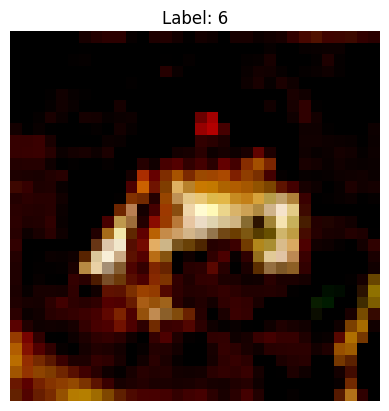

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

img, label = trainset[0]


# img = img / 2 + 0.5

img = img.permute(1, 2, 0).numpy()

plt.imshow(img)
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()


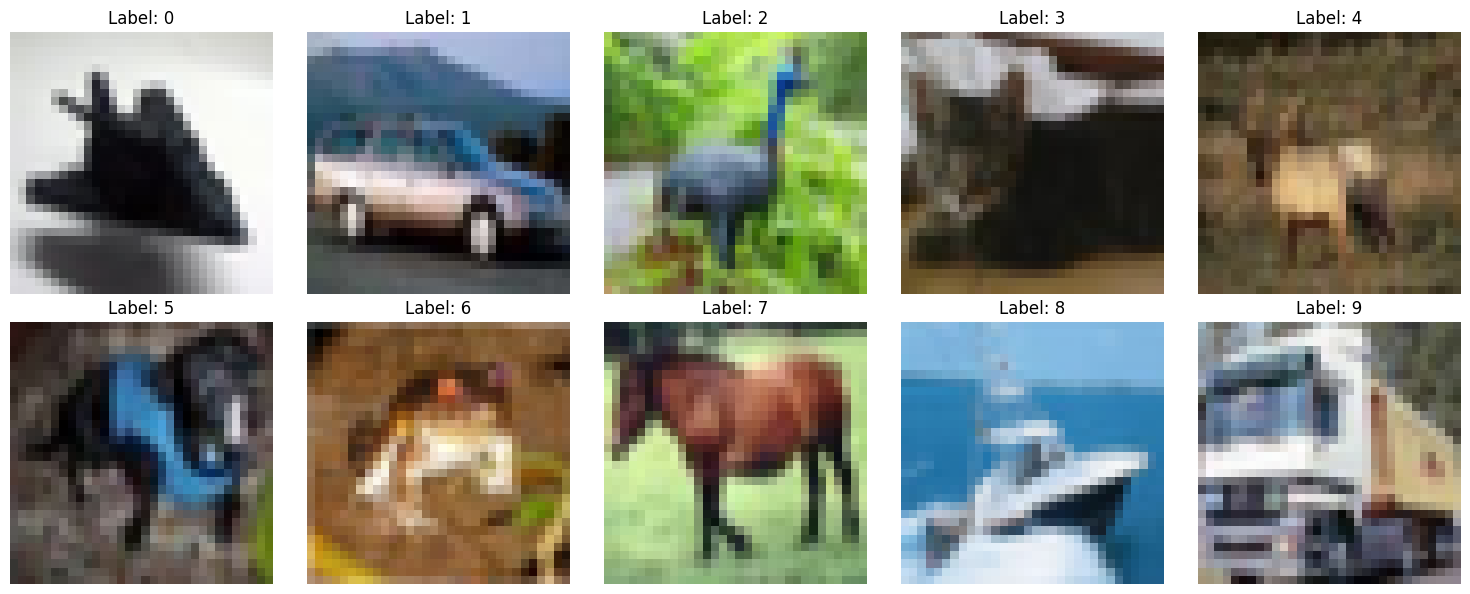

In [14]:
images = {}

for img,label in trainset:
  if label not in images:
    images[label] = img
  if len(images)==10:
    break

plt.figure(figsize=(15, 6))
for label, img in images.items():

    img = img.permute(1, 2, 0).numpy()
    img = img/2+0.5

    plt.subplot(2, 5, label + 1)
    plt.imshow(img)
    plt.title(f'Label: {label}')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def prelu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def softmax(x):
    exp_x = np.exp(x - np.max(x))
    return exp_x / np.sum(exp_x)

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def normalize_image(image):
    if image.dtype == np.float32 or image.dtype == np.float64:
        return np.clip(image, 0, 1)
    else:
        return np.clip(image, 0, 255)


def convolution(img, kernel, stride, padding, activation):
    img = np.pad(img, ((padding, padding), (padding, padding)), mode='constant')
    h, w = kernel.shape[0], kernel.shape[1]
    output_h = (img.shape[0] - h) // stride + 1
    output_w = (img.shape[1] - w) // stride + 1
    output = np.zeros((output_h, output_w))

    for i in range(output_h):
        for j in range(output_w):
            region = img[i * stride:i * stride + h, j * stride:j * stride + w]
            output[i, j] = np.sum(region * kernel)

    if activation == 'sigmoid':
        output = sigmoid(output)
    elif activation == 'tanh':
        output = tanh(output)
    elif activation == 'relu':
        output = relu(output)
    elif activation == 'prelu':
        output = prelu(output)

    img, kernel, output = normalize_image(img), normalize_image(kernel), normalize_image(output)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Input Image')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.imshow(kernel)
    plt.title('Kernel')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.imshow(output)
    plt.title('Output Map')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return output

def pooling(inp_map, pool_size, stride, pool_fn):
    output_h = (inp_map.shape[0] - pool_size) // stride + 1
    output_w = (inp_map.shape[1] - pool_size) // stride + 1
    output = np.zeros((output_h, output_w))

    for i in range(output_h):
        for j in range(output_w):
            region = inp_map[i * stride:i * stride + pool_size, j * stride:j * stride + pool_size]
            if region.size > 0:
                if pool_fn == 'max':
                    output[i, j] = np.max(region)
                elif pool_fn == 'mean':
                    output[i, j] = np.mean(region)

    inp_map, output = normalize_image(inp_map), normalize_image(output)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(inp_map)
    plt.title('Input Map')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(output)
    plt.title('Output Map')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return output

def convolution_layer(input_volume, kernels, stride=1, padding=0, activation='relu'):
    num_kernels = kernels.shape[3]
    output_height = (input_volume.shape[0] - kernels.shape[0] + 2 * padding) // stride + 1
    output_width = (input_volume.shape[1] - kernels.shape[1] + 2 * padding) // stride + 1
    output_volume = np.zeros((output_height, output_width, num_kernels))

    for k in range(num_kernels):
        conv_output = np.zeros((output_height, output_width))
        for c in range(input_volume.shape[2]):
            conv_output += convolution(input_volume[:, :, c], kernels[:, :, c, k], stride, padding, activation)
        output_volume[:, :, k] = conv_output

    input_volume, output_volume = normalize_image(input_volume), normalize_image(output_volume)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input_volume)
    plt.title('Input Volume')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(output_volume[:, :, 0])
    plt.title('Output Volume')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return output_volume

def pooling_layer(inp_map, pool_size, stride, pool_fn):
    num_channels = inp_map.shape[2]
    output_height = (inp_map.shape[0] - pool_size) // stride + 1
    output_width = (inp_map.shape[1] - pool_size) // stride + 1
    output_volume = np.zeros((output_height, output_width, num_channels))

    for k in range(num_channels):
        output_volume[:, :, k] = pooling(inp_map[:, :, k], pool_size, stride, pool_fn)

    inp_map, output_volume = normalize_image(inp_map), normalize_image(output_volume)

    plt.figure(figsize=(15, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(inp_map)
    plt.title('Input Map')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(output_volume[:, :, 0])
    plt.title('Output Volume')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    return output_volume

def flattening(input_volume, output_size):
    flattened = input_volume.flatten()
    weight_matrix = np.ones((output_size, flattened.size))
    output_vector = weight_matrix @ flattened

    return output_vector

def MLP(input_vector, hidden_layers, hidden_layer_size, output_size, activation='relu'):
    weights = []
    biases = []

    if activation == 'relu':
        activation_fn = relu
    elif activation == 'sigmoid':
        activation_fn = sigmoid
    elif activation == 'tanh':
        activation_fn = tanh
    else:
        raise ValueError("Invalid activation function. Choose 'relu', 'sigmoid', or 'tanh'.")

    layer_input_size = input_vector.shape[0]
    layer_output = input_vector
    for i in range(hidden_layers):
        weights.append(np.random.randn(layer_input_size, hidden_layer_size))
        bias = np.random.randn(hidden_layer_size)
        layer_output = np.dot(layer_output, weights[-1]) + bias
        layer_output = activation_fn(layer_output)
        layer_input_size = hidden_layer_size

    weights.append(np.random.randn(layer_input_size, output_size))
    bias = np.random.randn(output_size)
    output = np.dot(layer_output, weights[-1]) + bias

    output = softmax(output)
    return output




In [33]:
def flattend(img,label):
  kernels = np.random.rand(5, 5, 3, 4)
  conv_output_1 = convolution_layer(img, kernels, stride=1, padding=2, activation='relu')
  print(conv_output_1.shape)
  pooled_output_1 = pooling_layer(conv_output_1, pool_size=2, stride=2, pool_fn='max')
  print(pooled_output_1.shape)
  kernels = np.random.rand(5, 5, 4, 4)
  conv_output_2 = convolution_layer(pooled_output_1, kernels, stride=1, padding=2, activation='relu')
  print(conv_output_2.shape)
  pooled_output_2 = pooling_layer(conv_output_2, pool_size=2, stride=2, pool_fn='max')
  print(pooled_output_2.shape)
  flattened_output = flattening(pooled_output_2, output_size=10)
  return flattened_output
def label_pred(flattened_output):
  mlp_output = MLP(flattened_output, hidden_layers=1, hidden_layer_size=49, output_size=10, activation='relu')
  return mlp_output

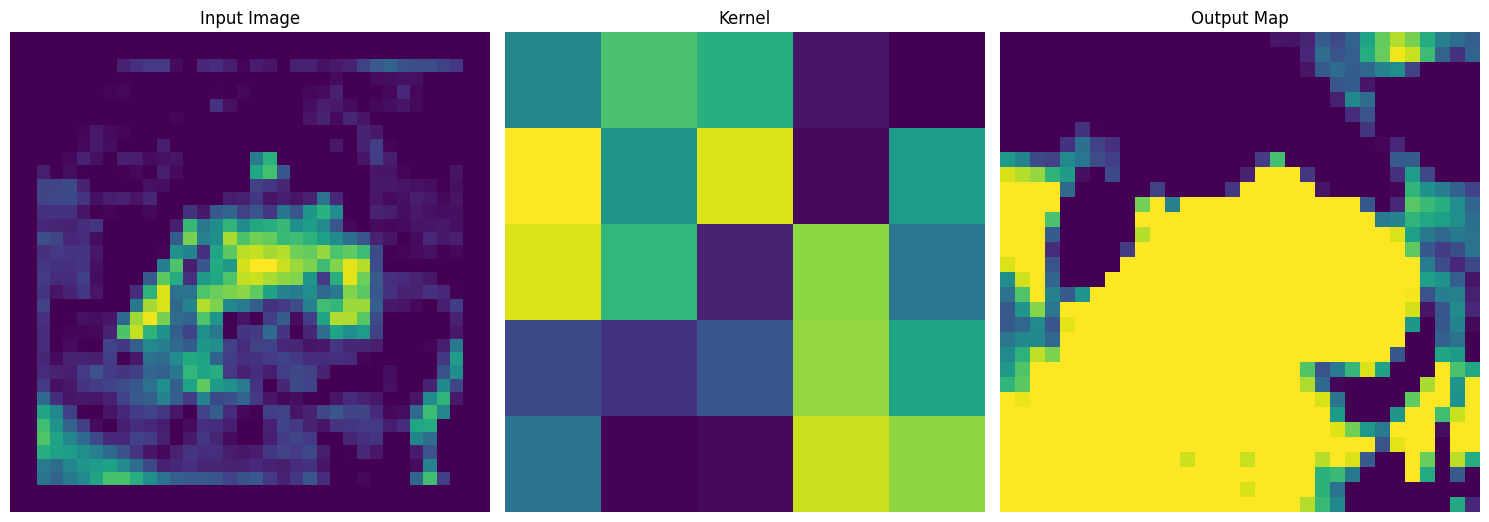

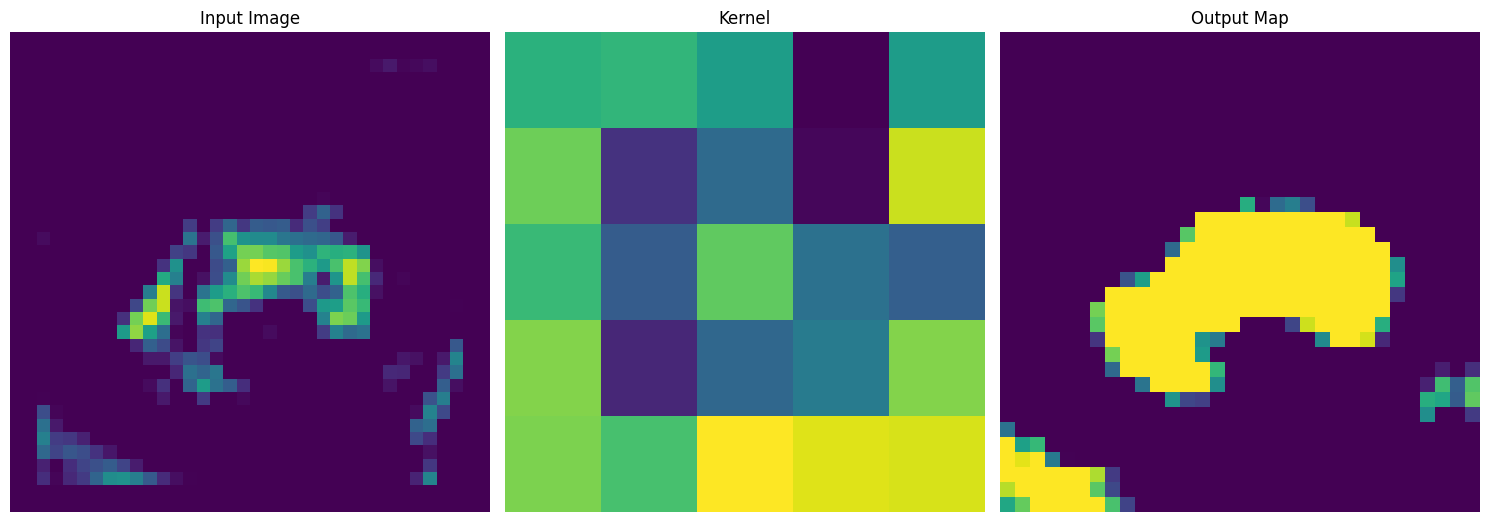

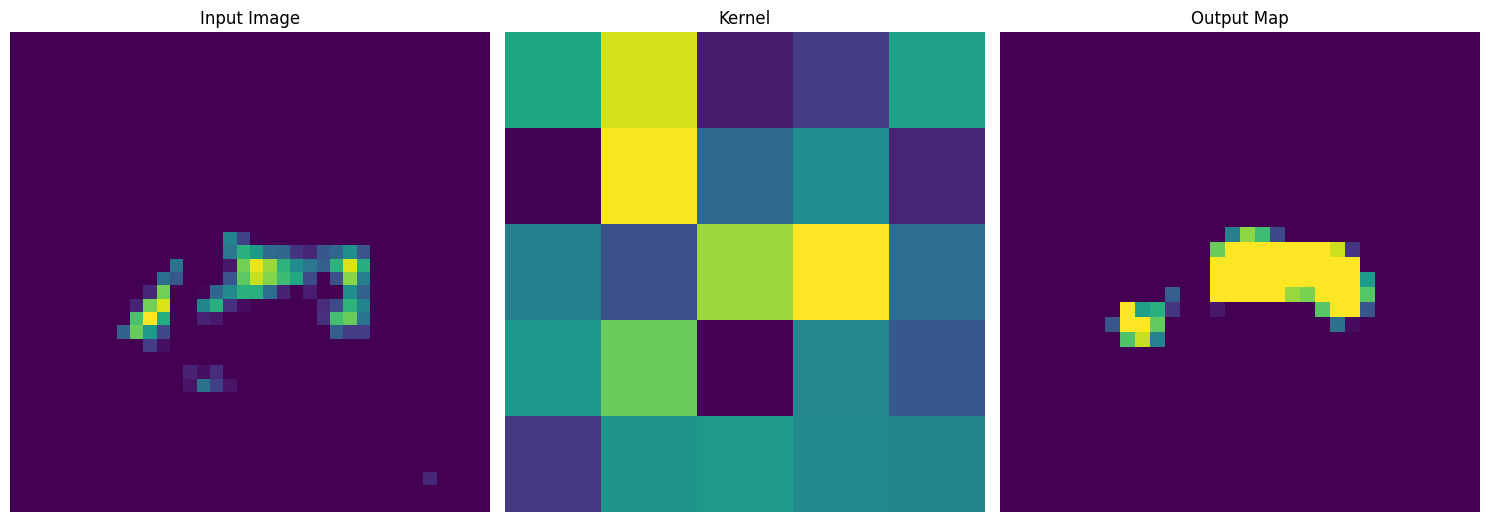

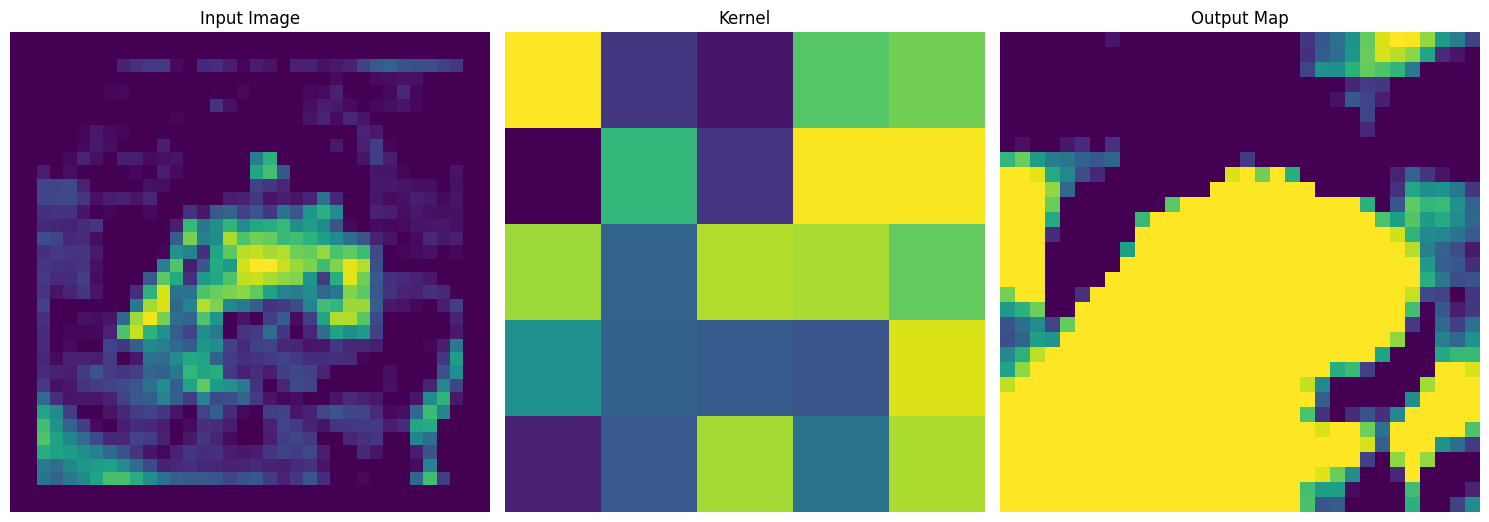

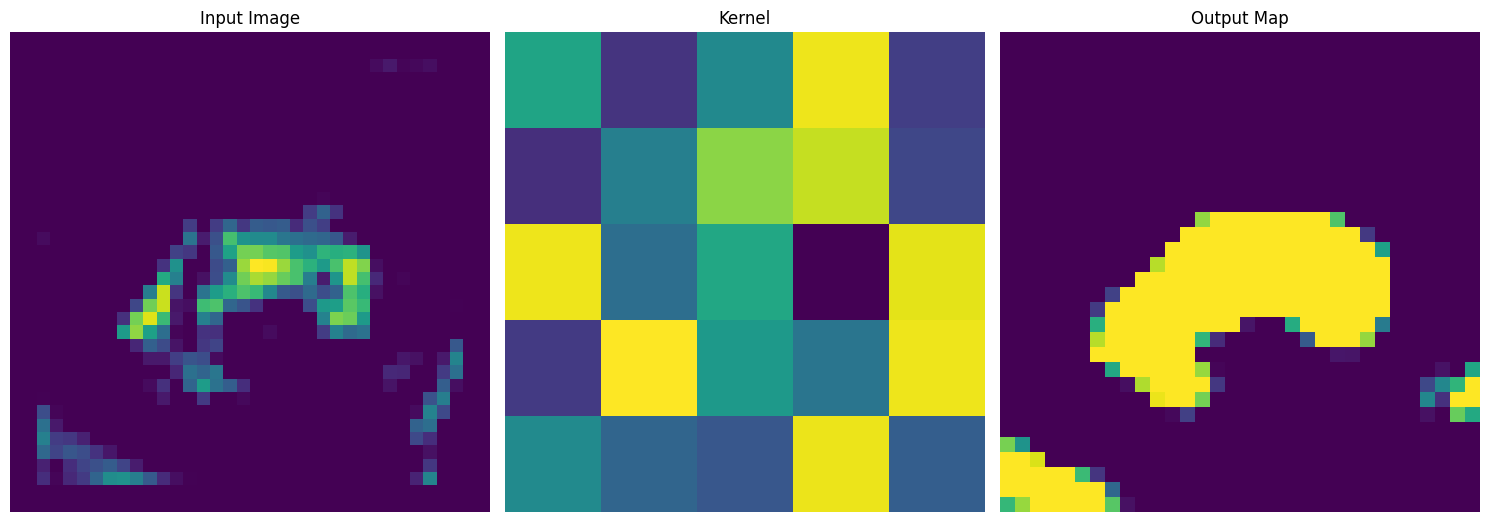

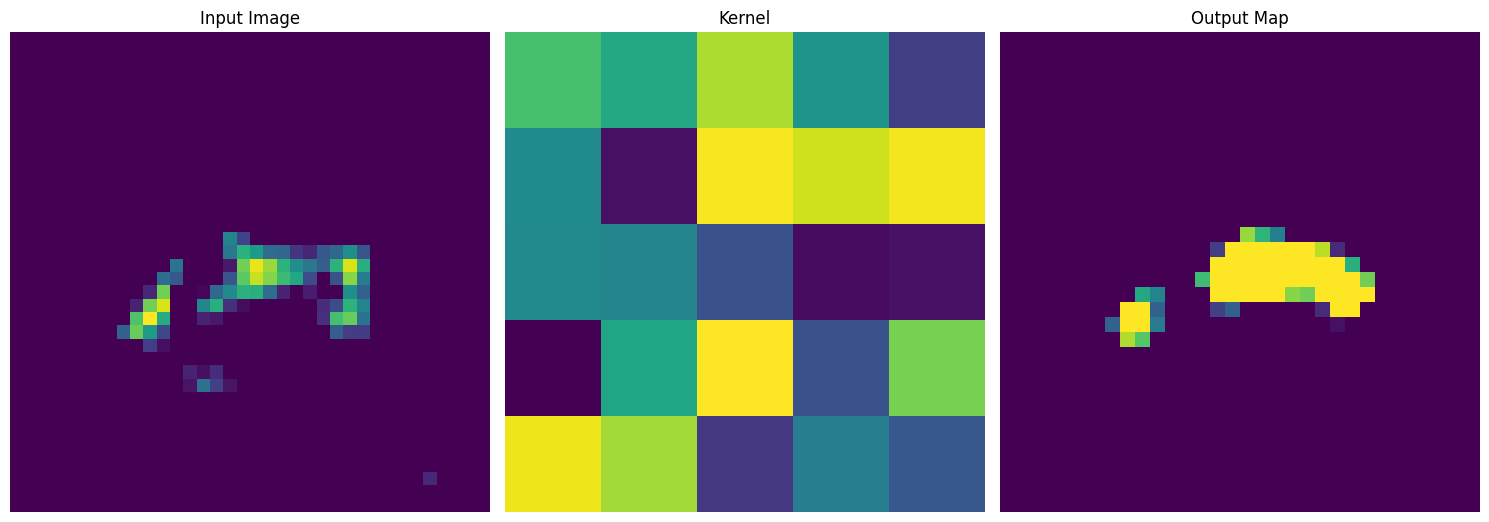

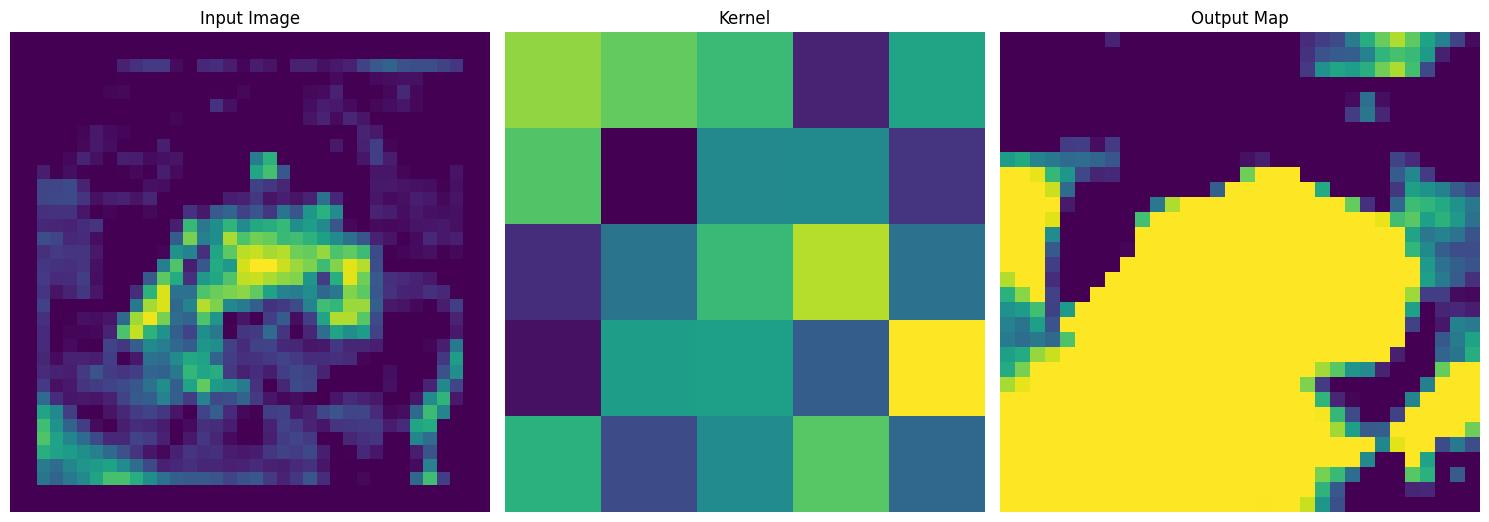

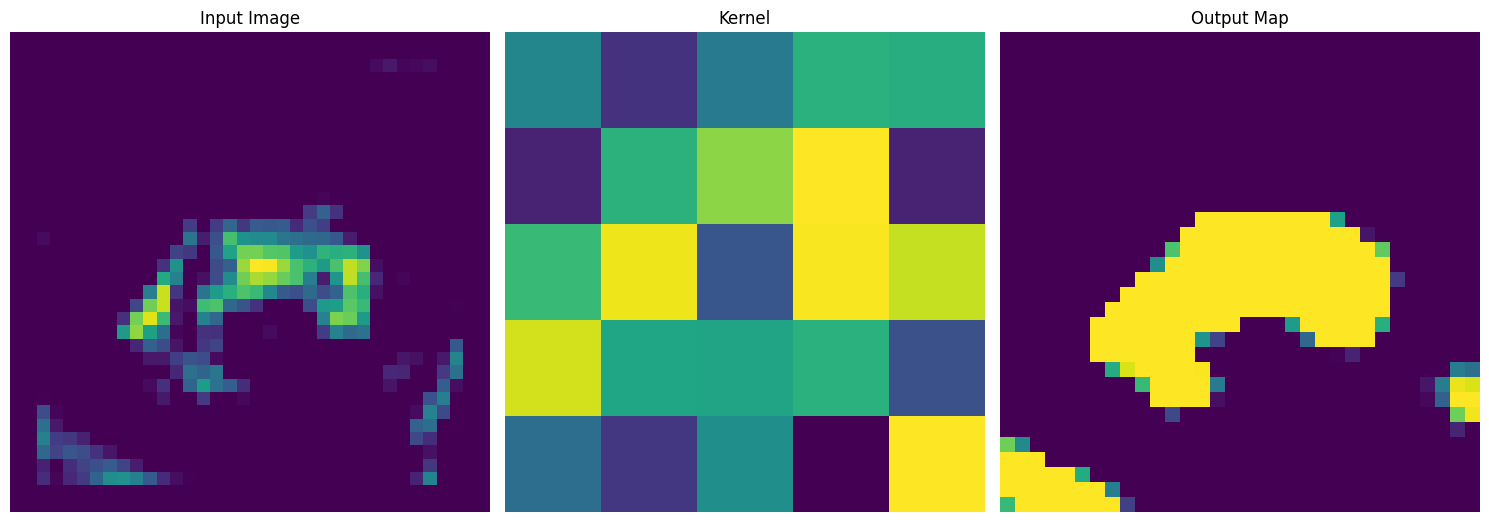

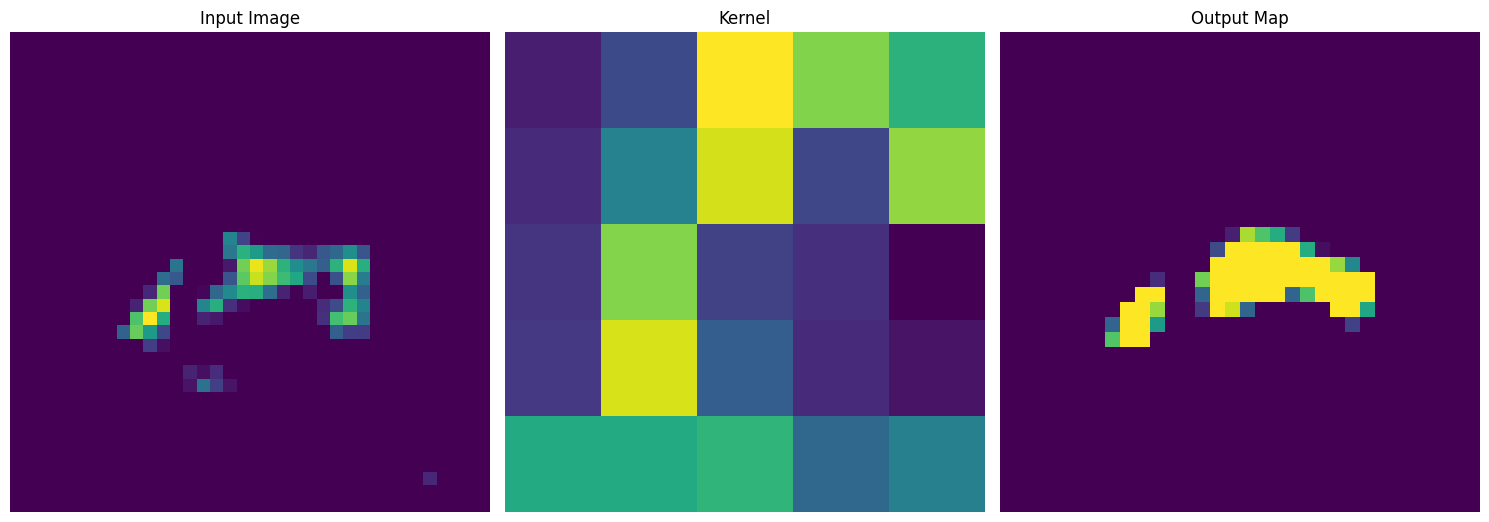

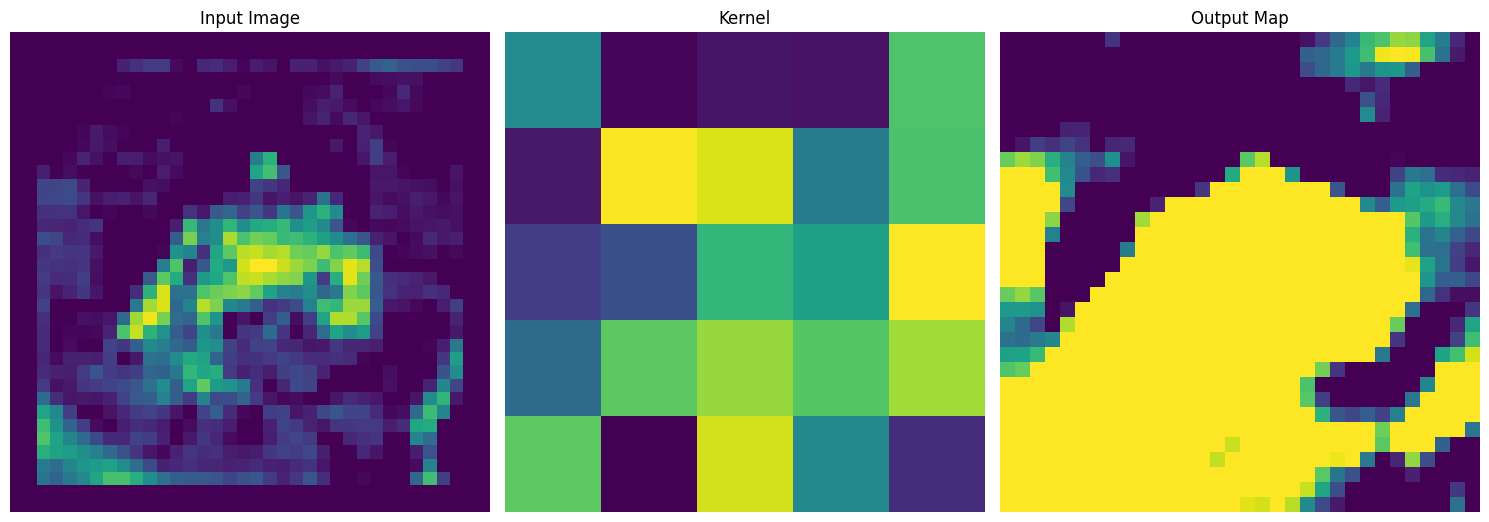

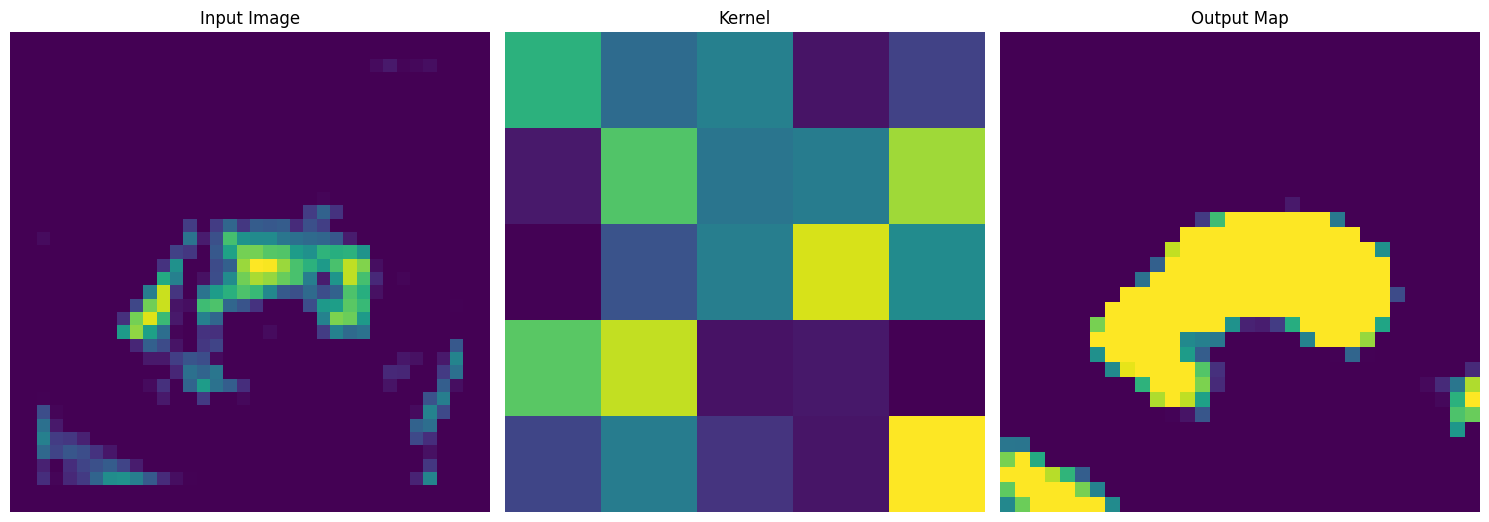

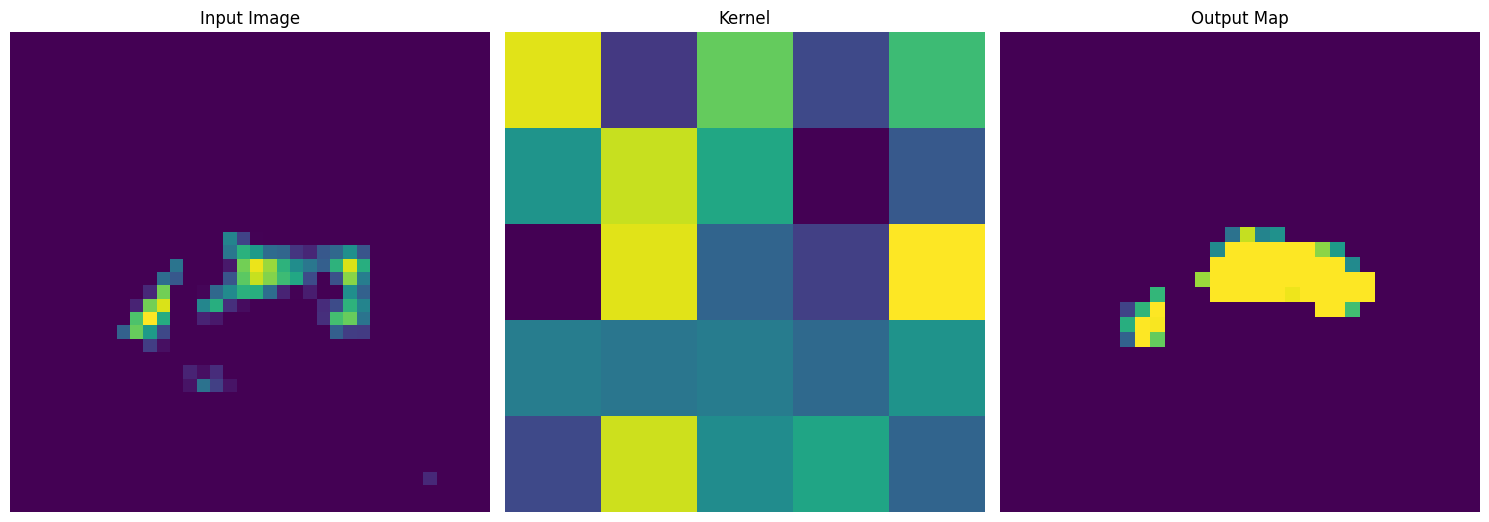

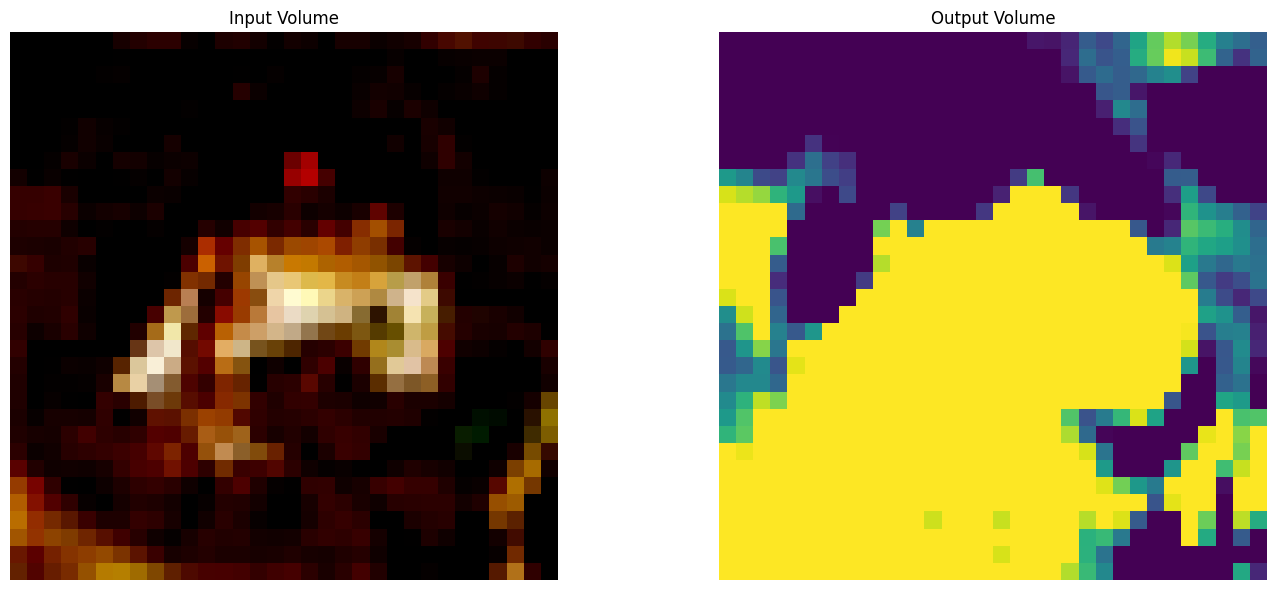

(32, 32, 4)


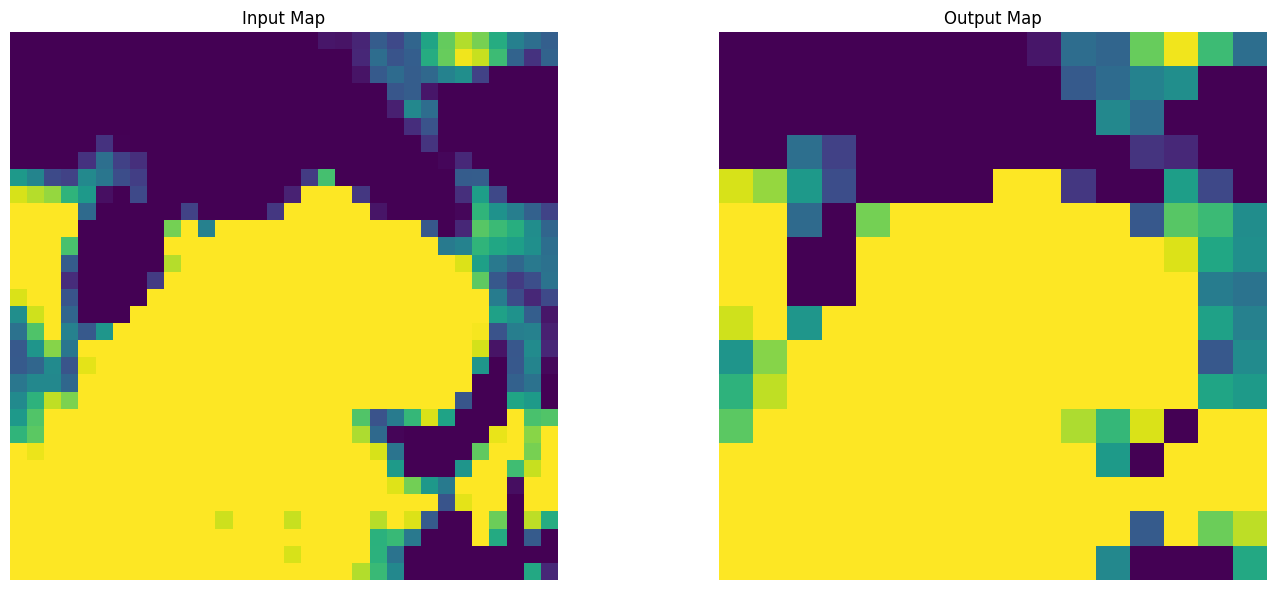

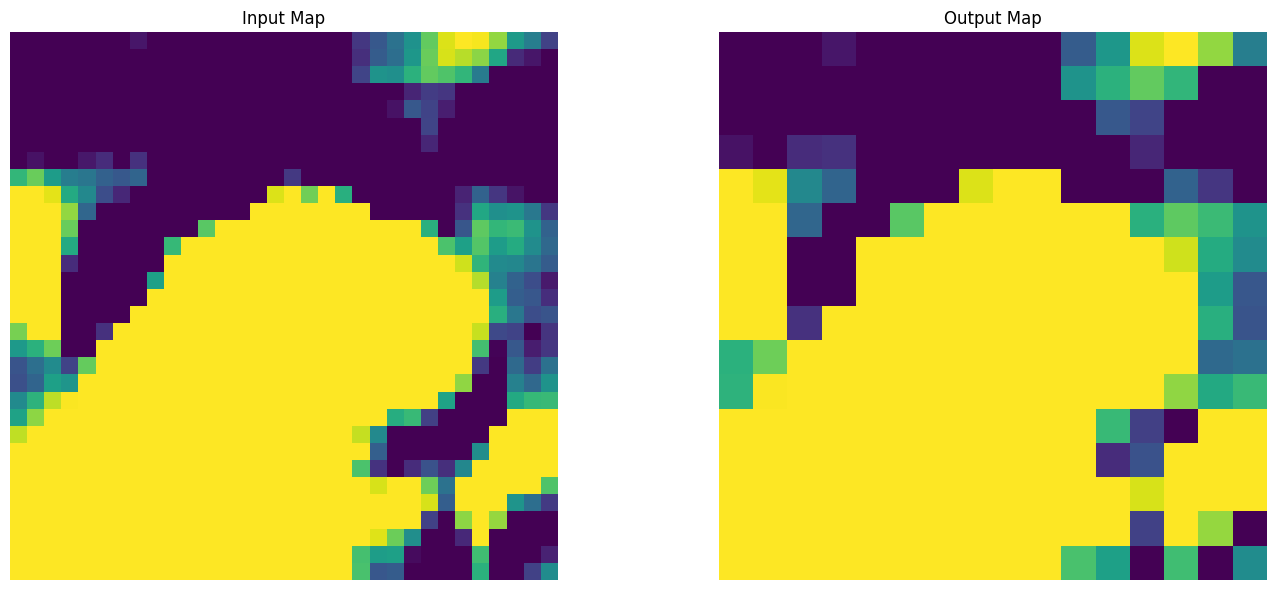

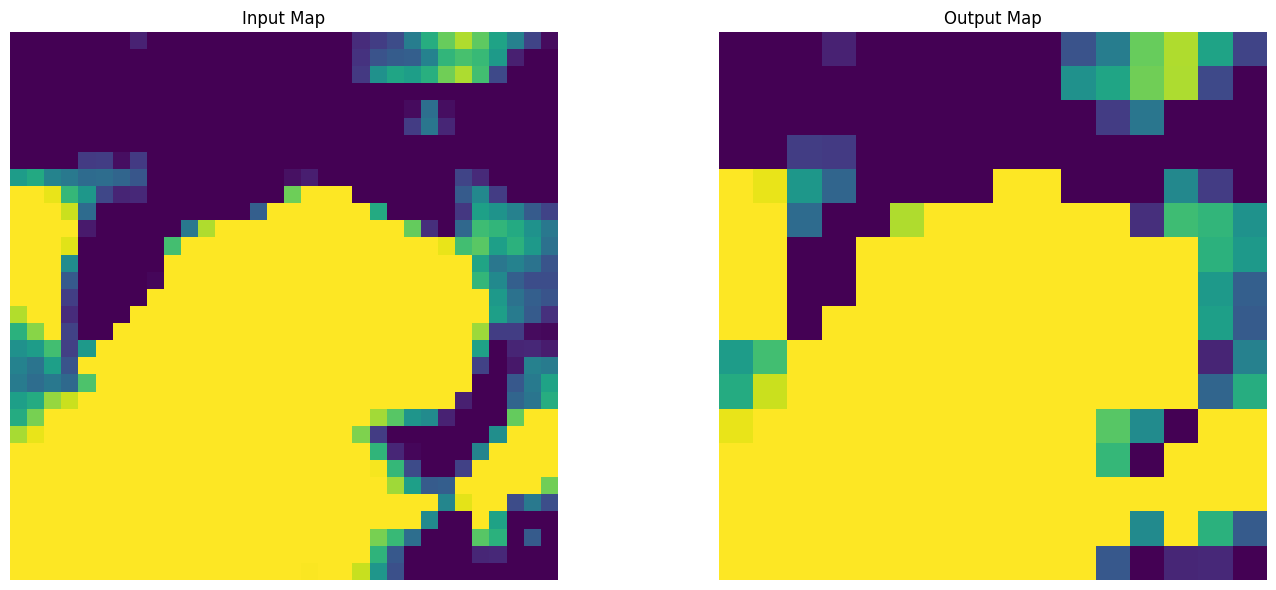

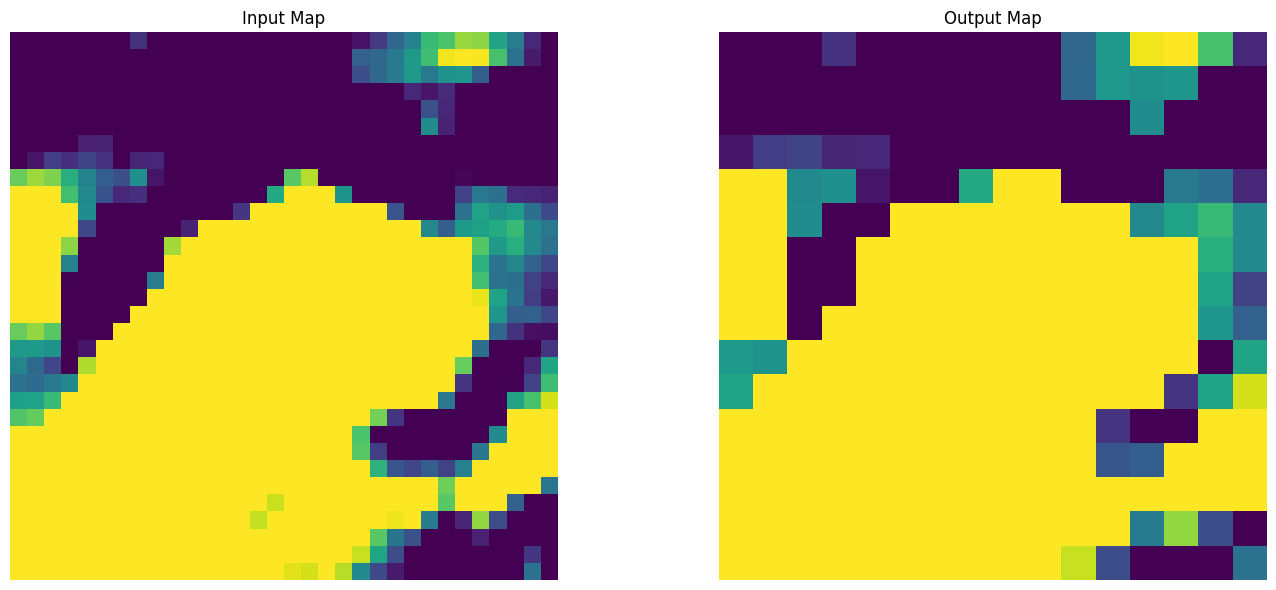

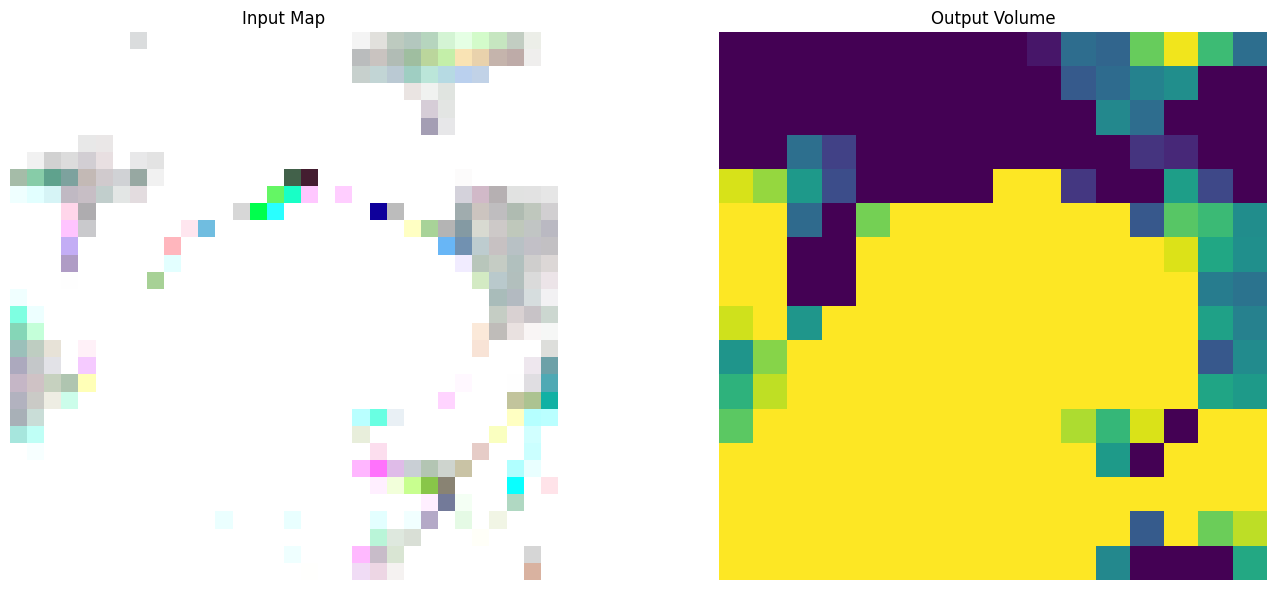

(16, 16, 4)


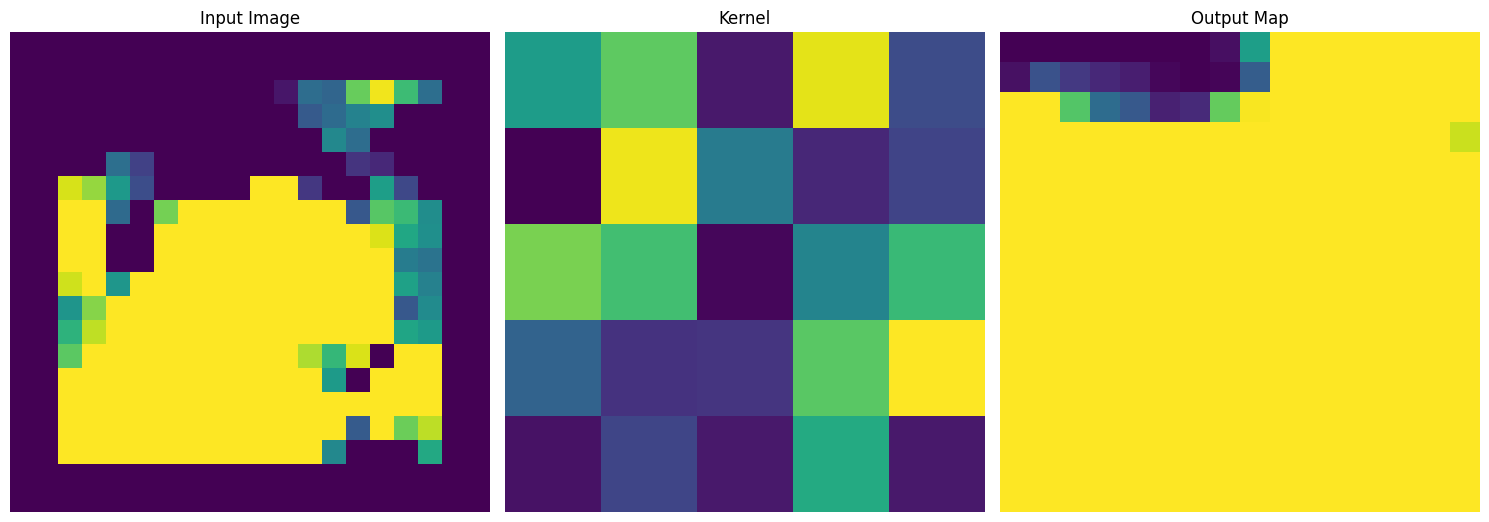

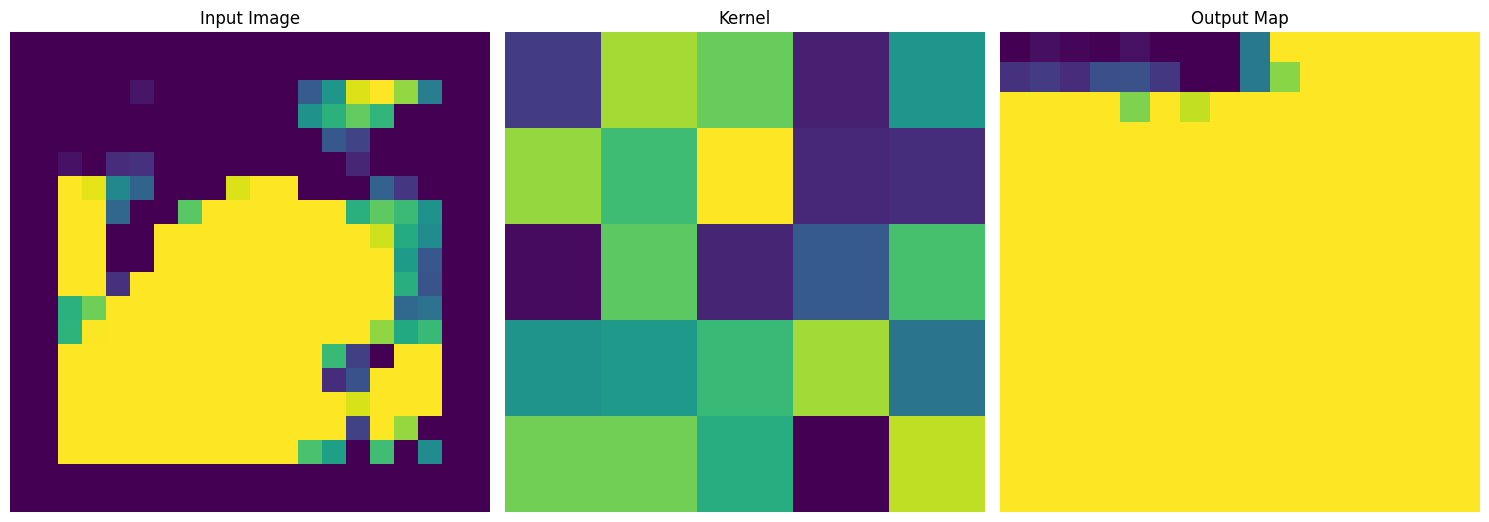

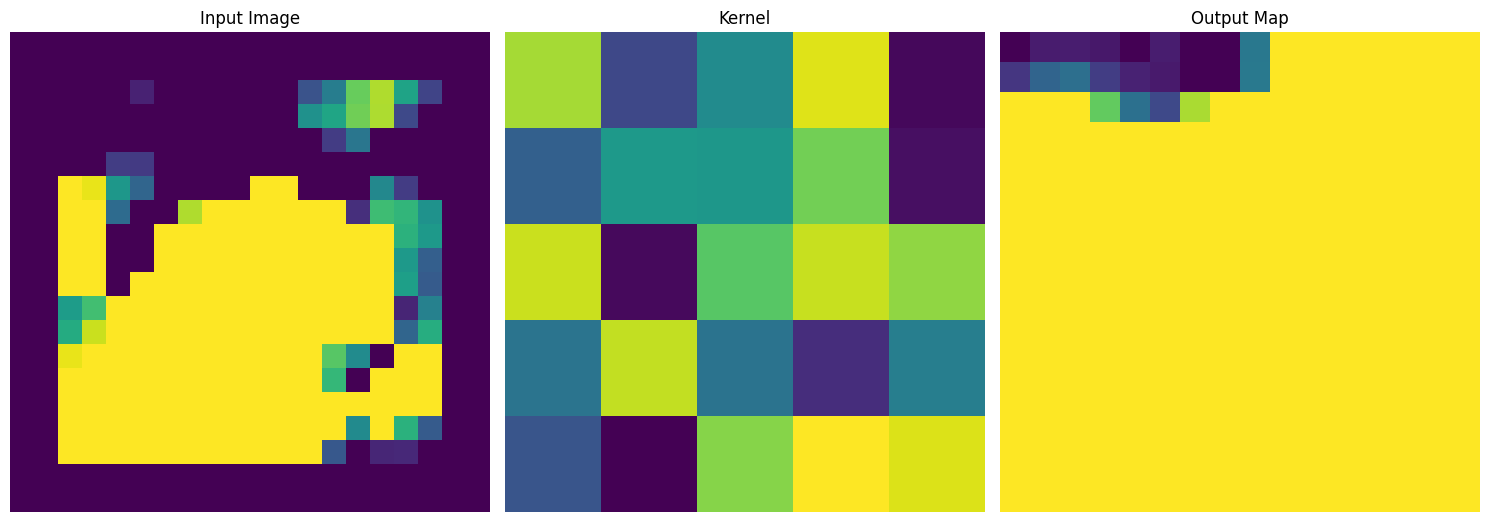

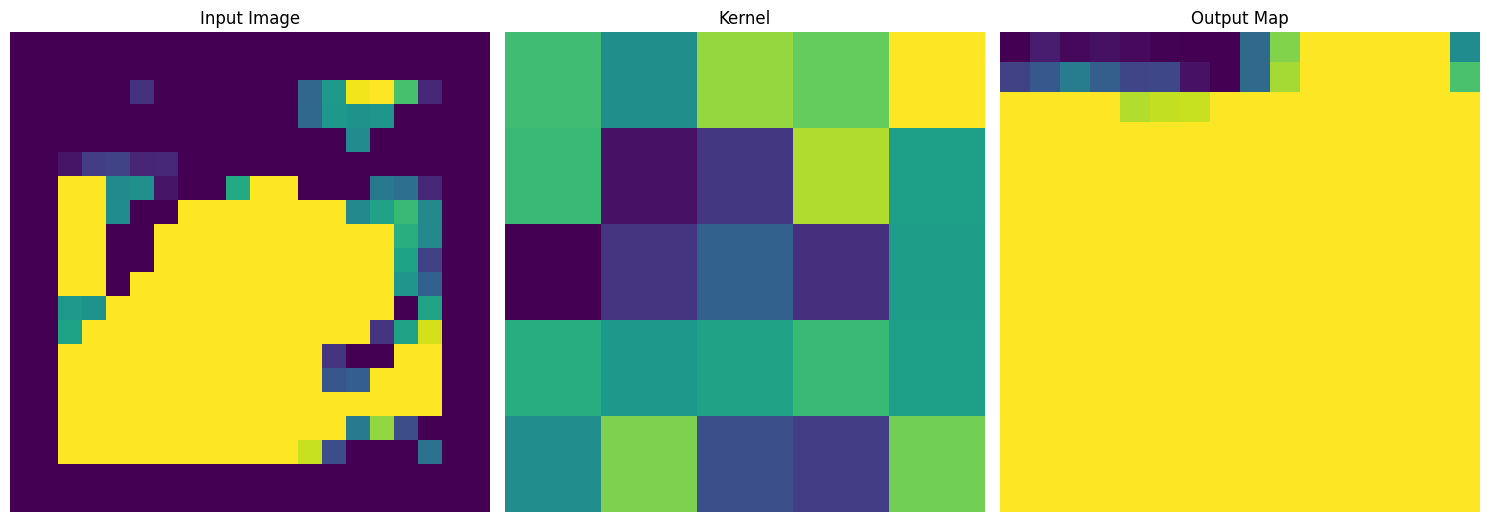

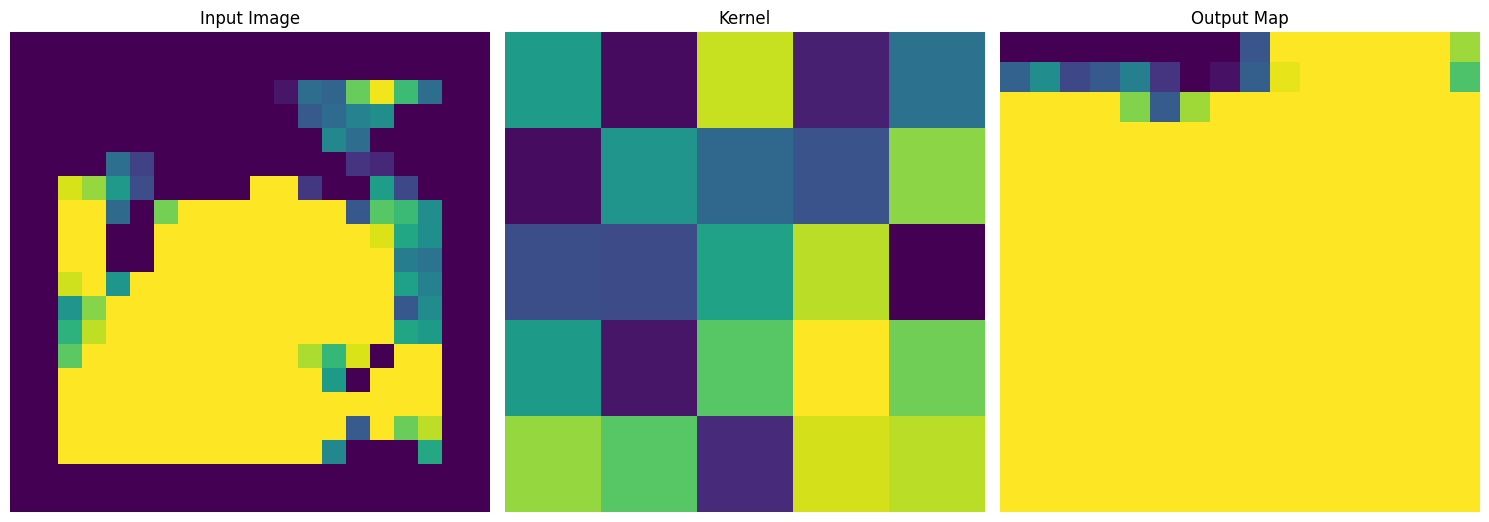

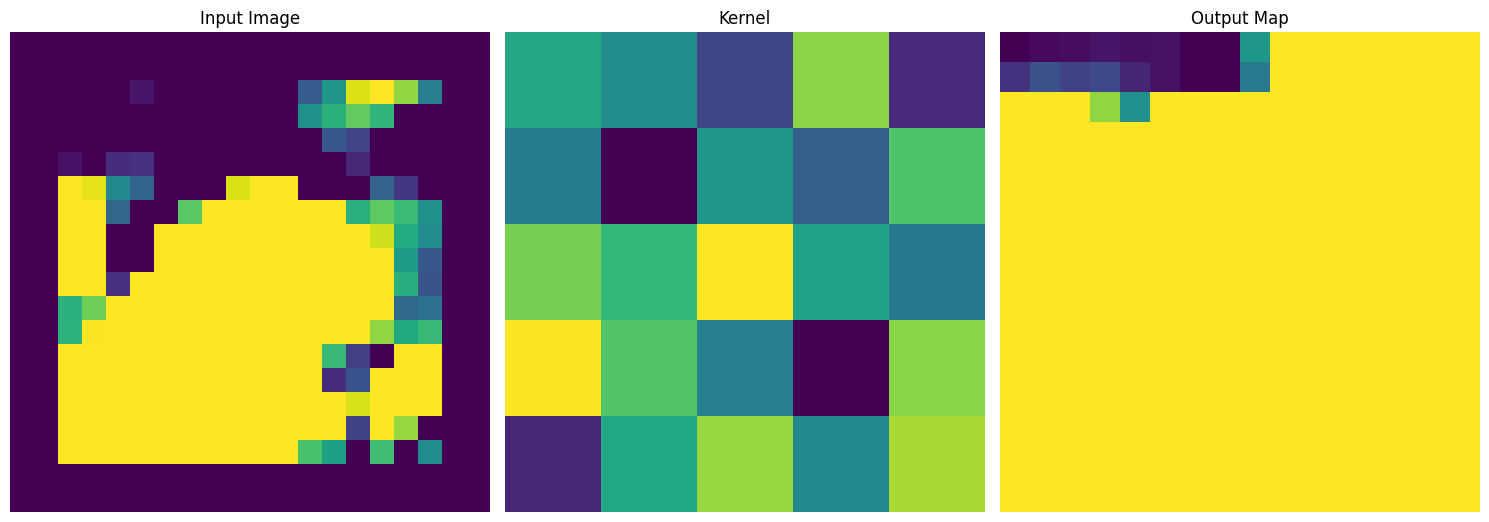

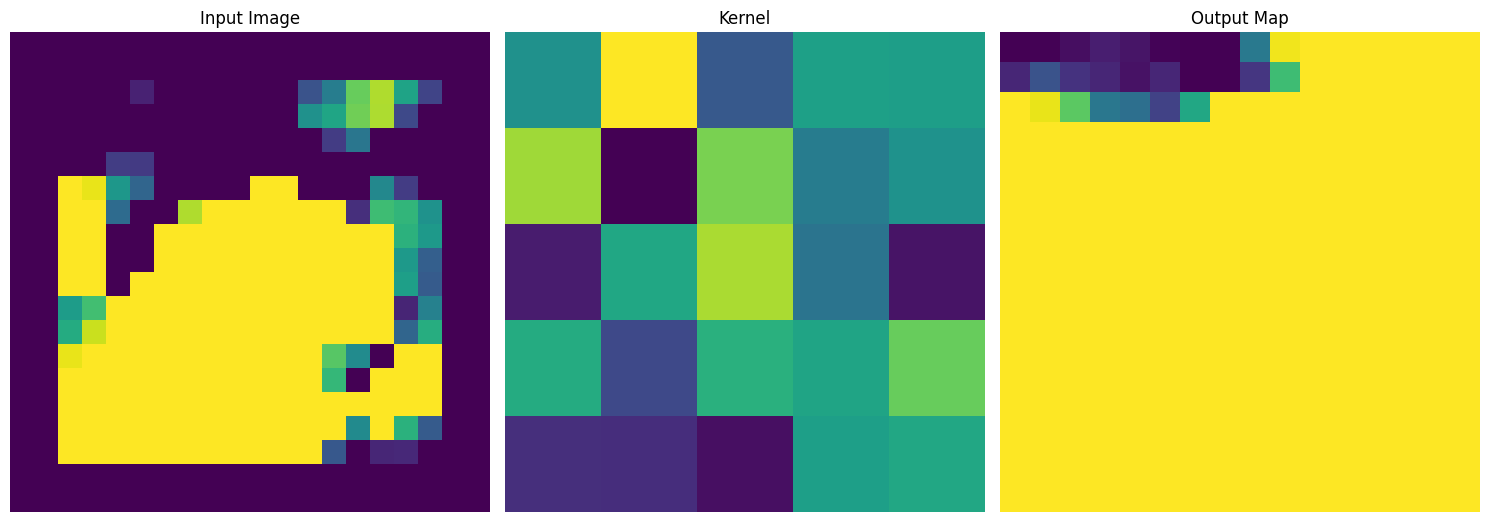

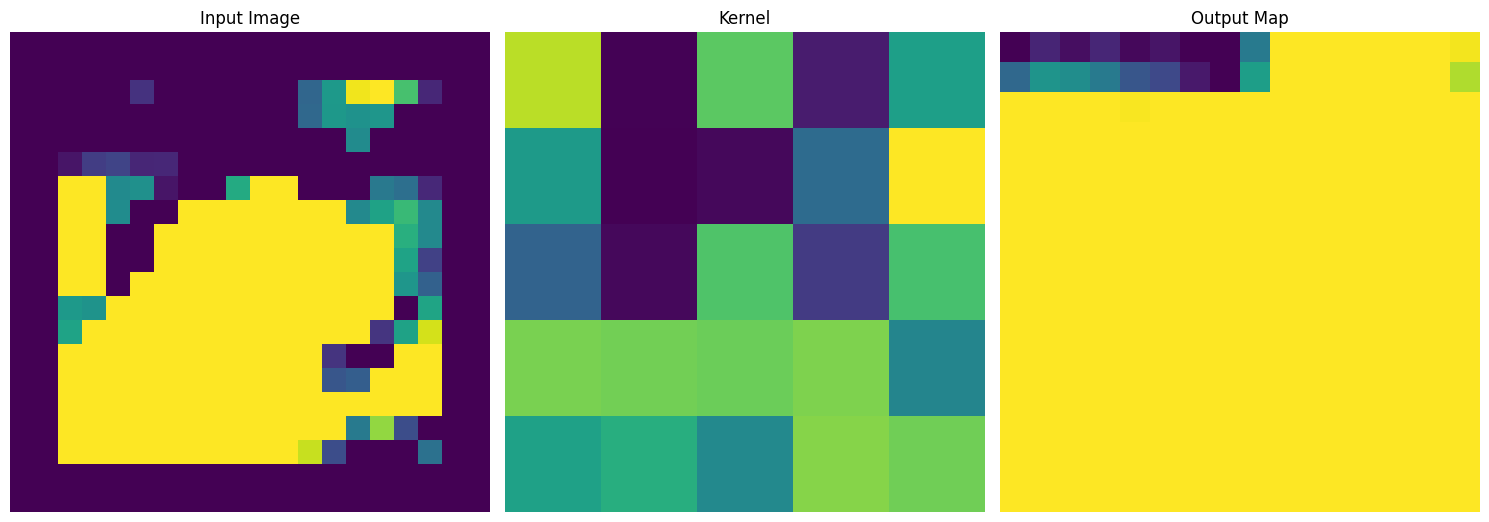

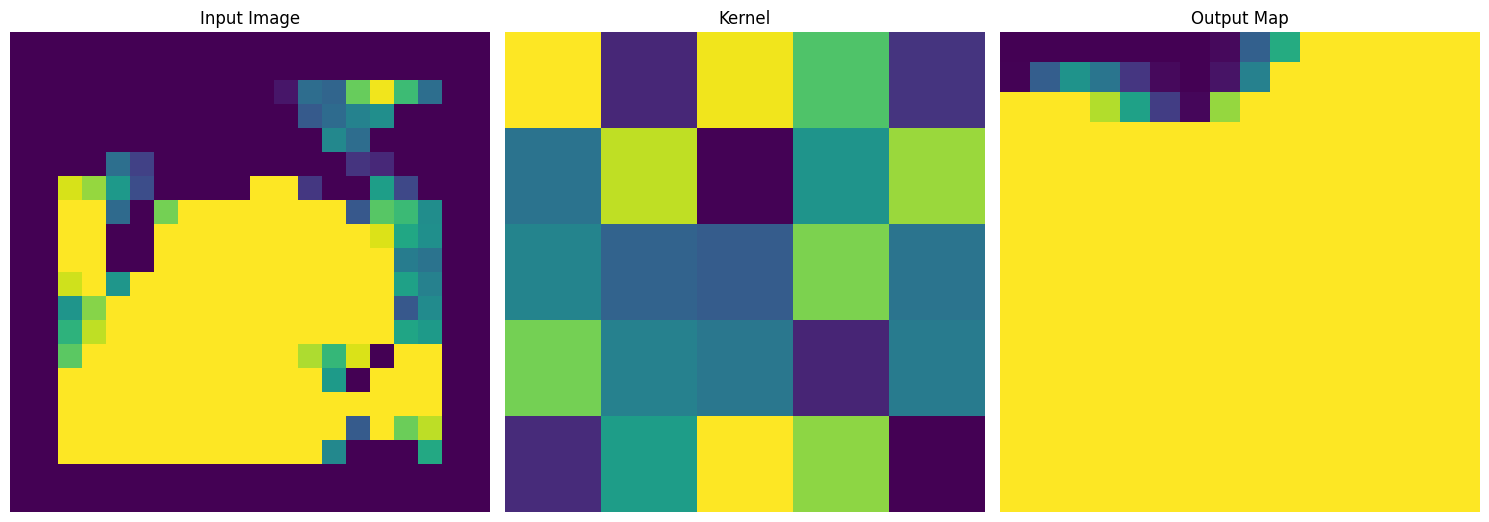

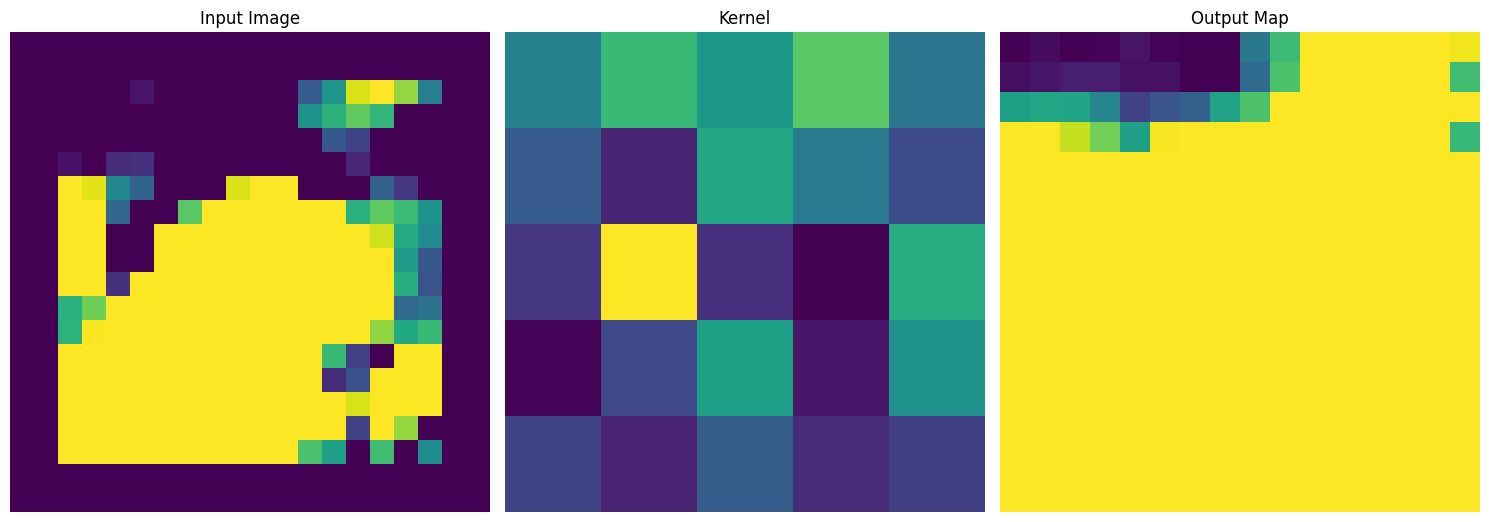

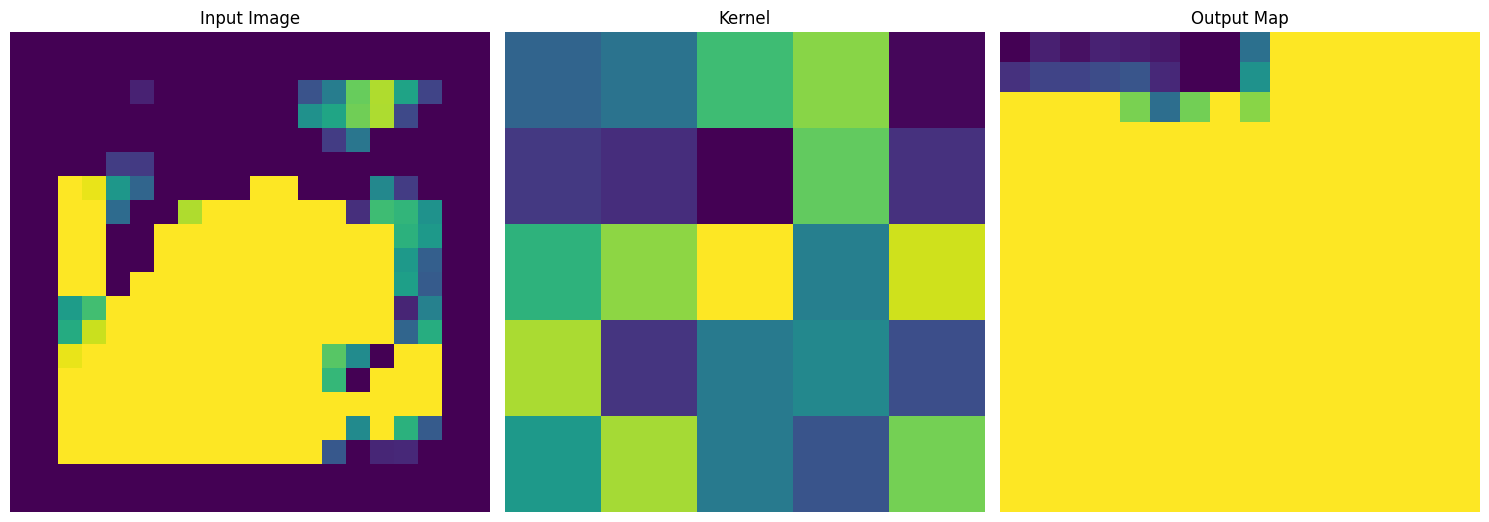

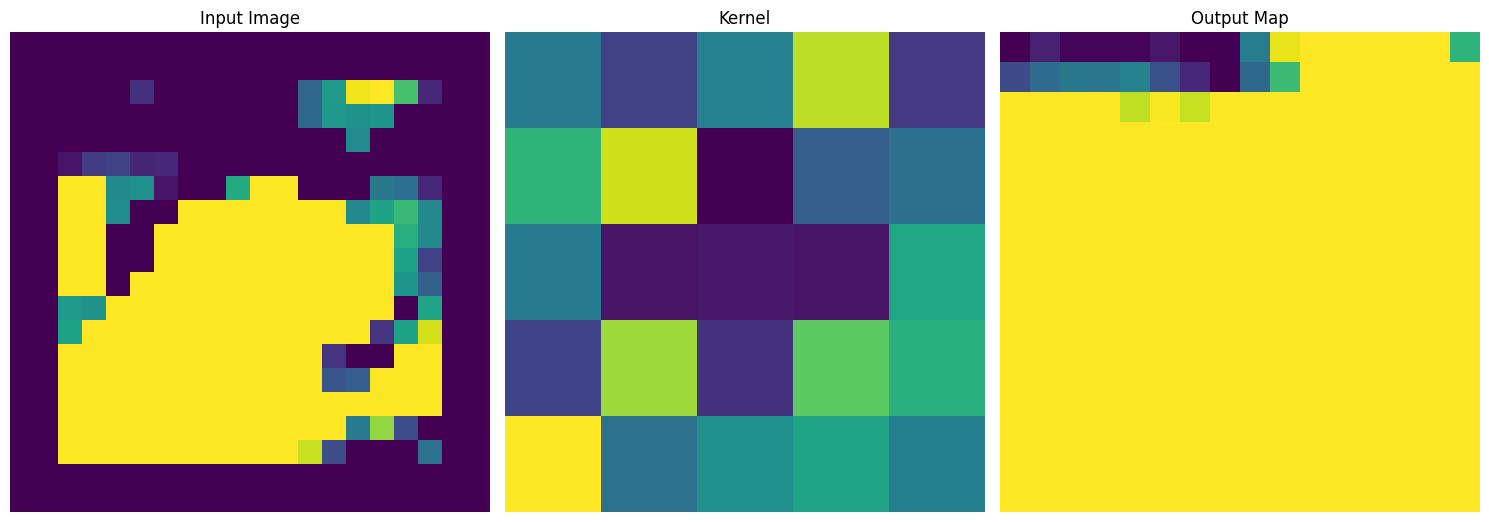

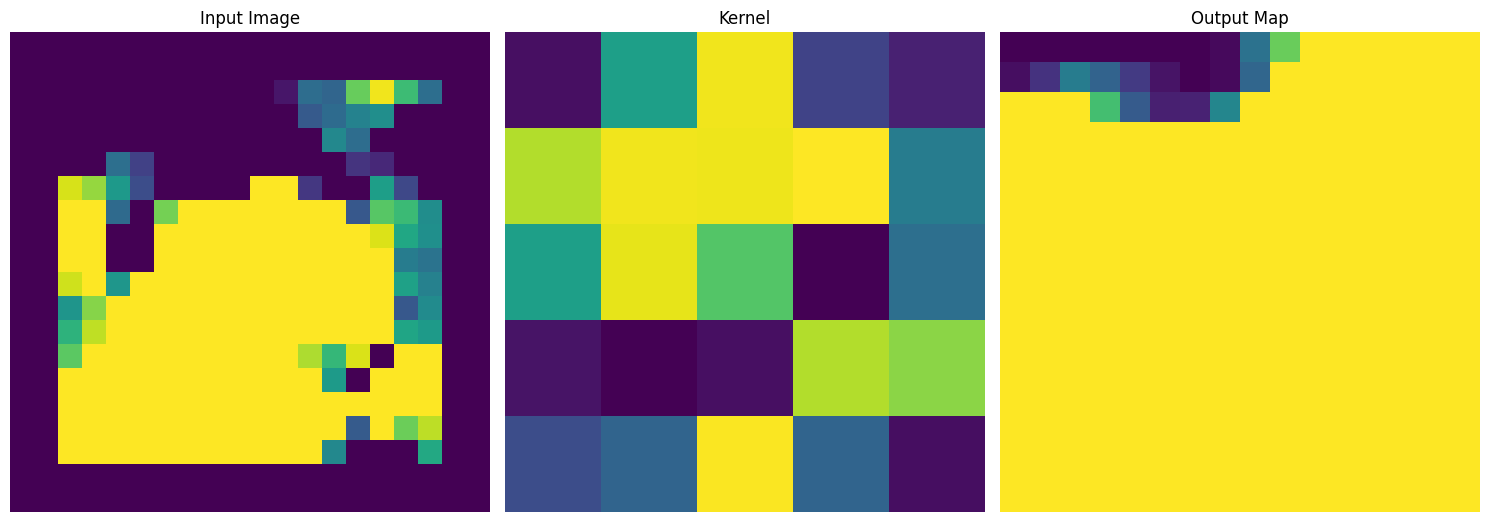

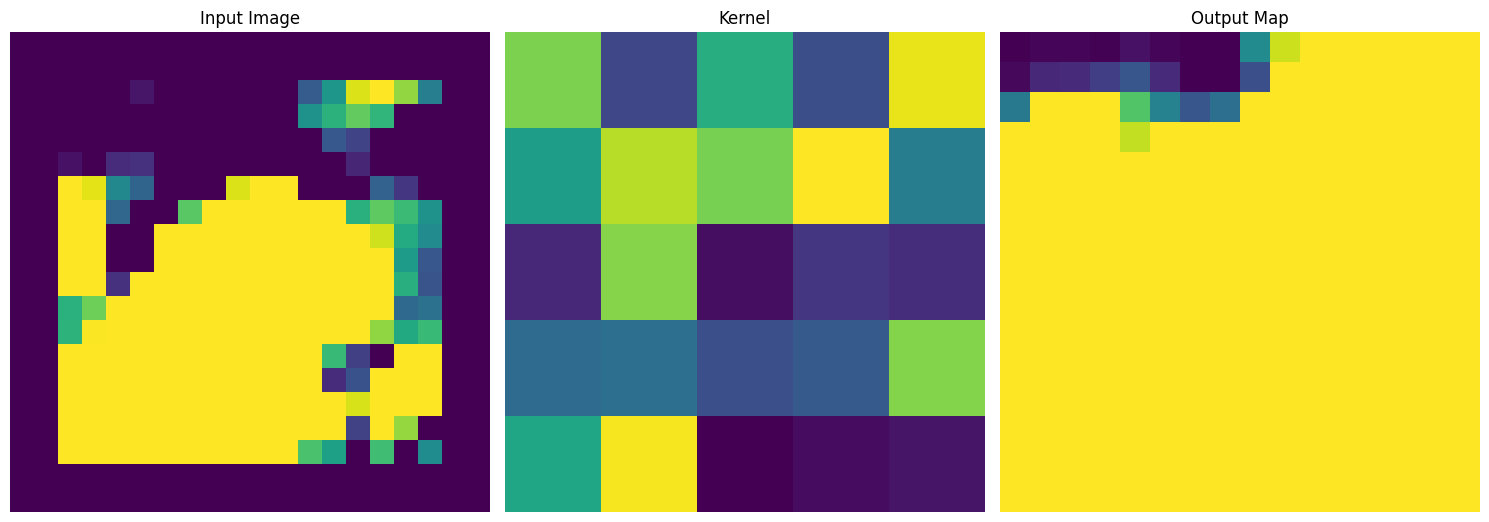

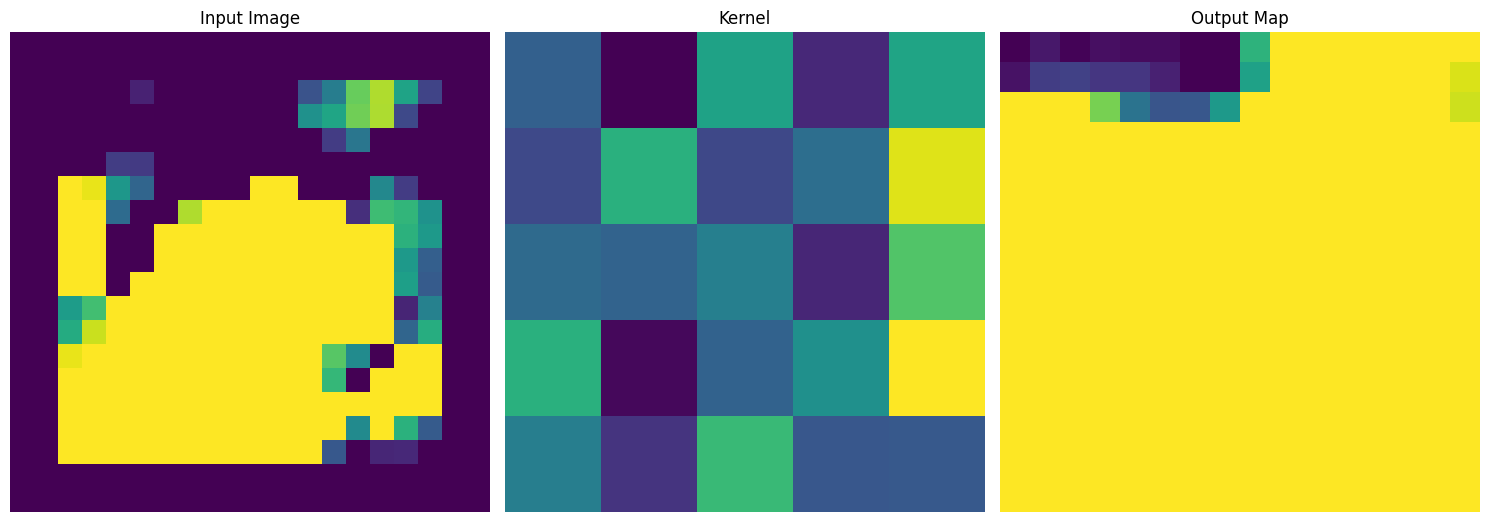

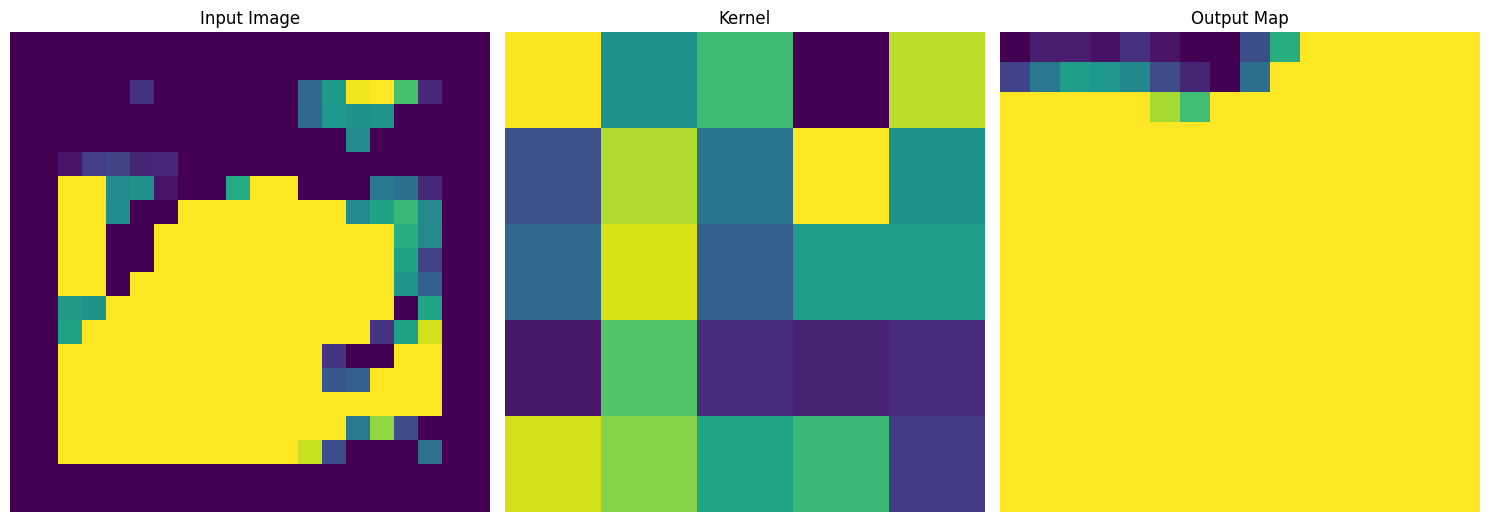

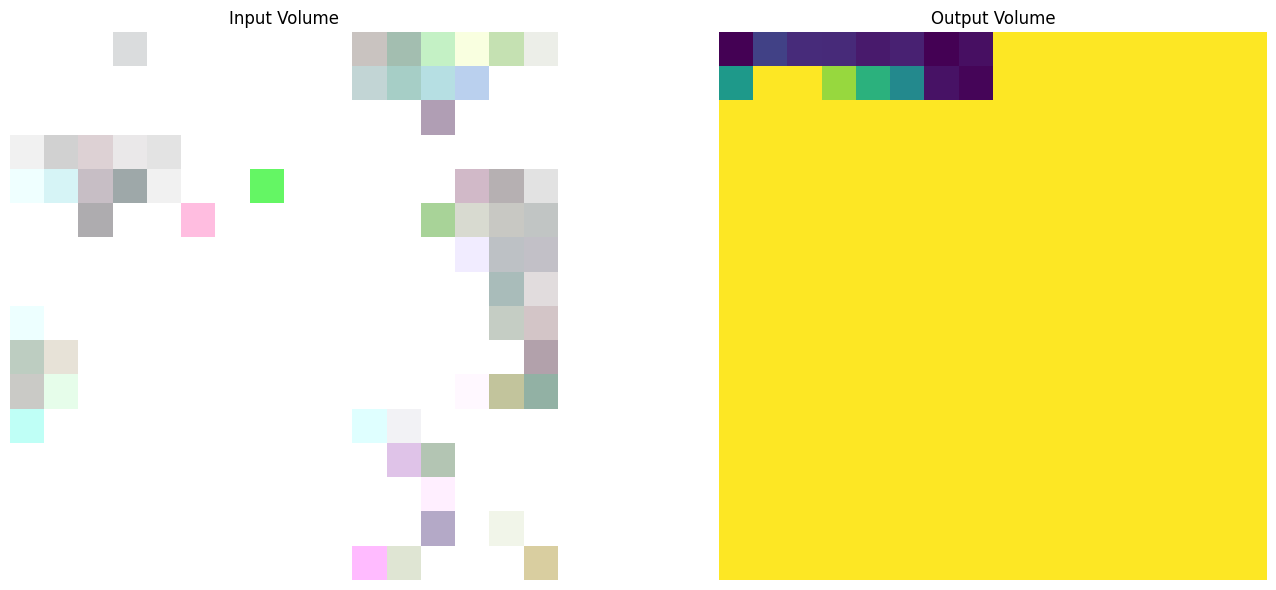

(16, 16, 4)


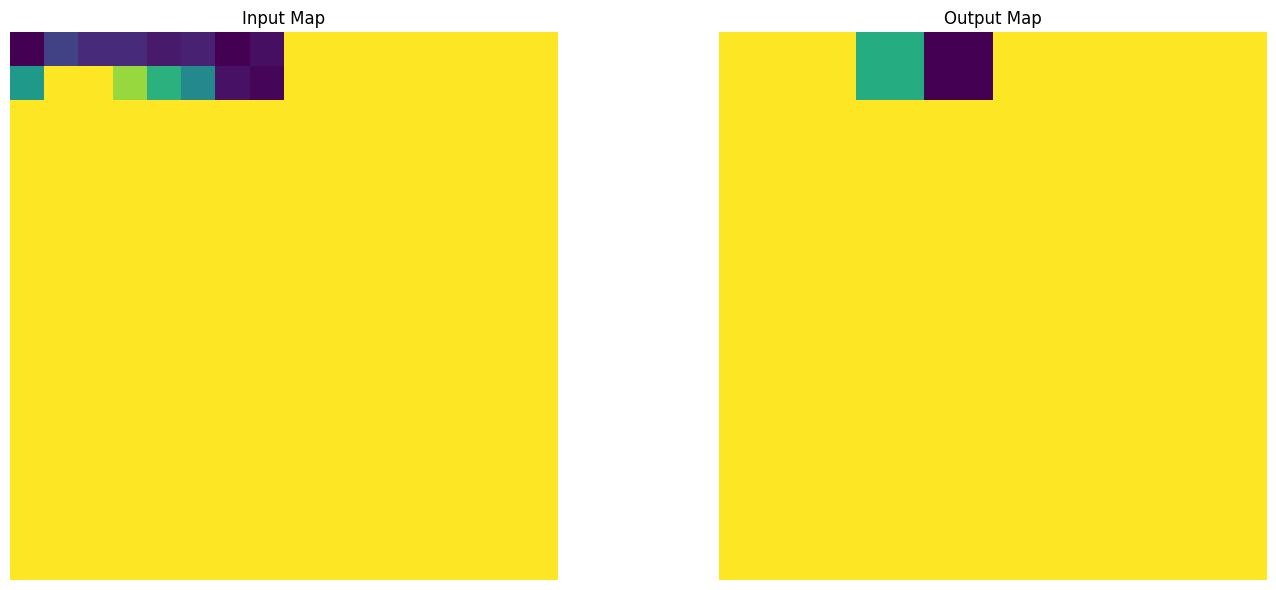

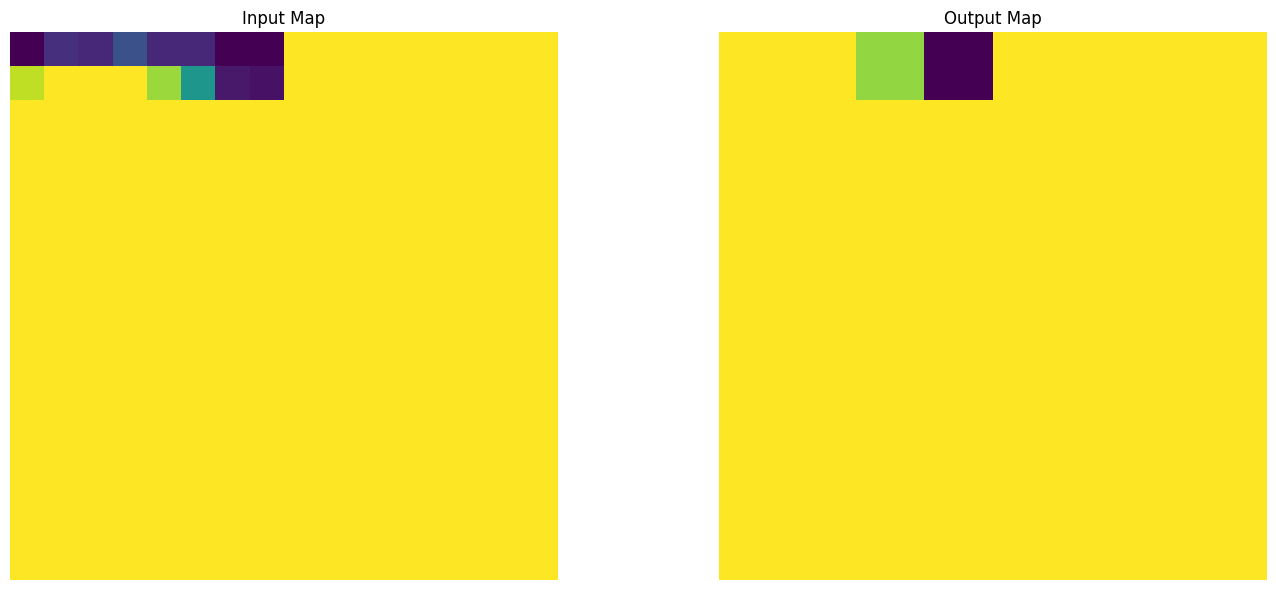

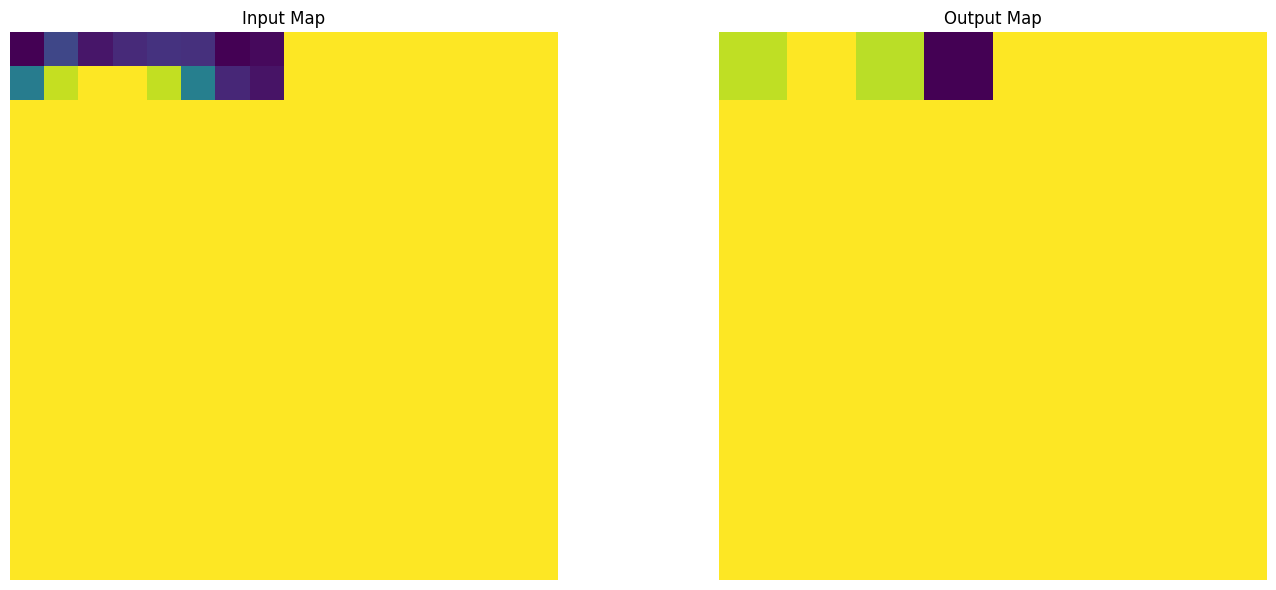

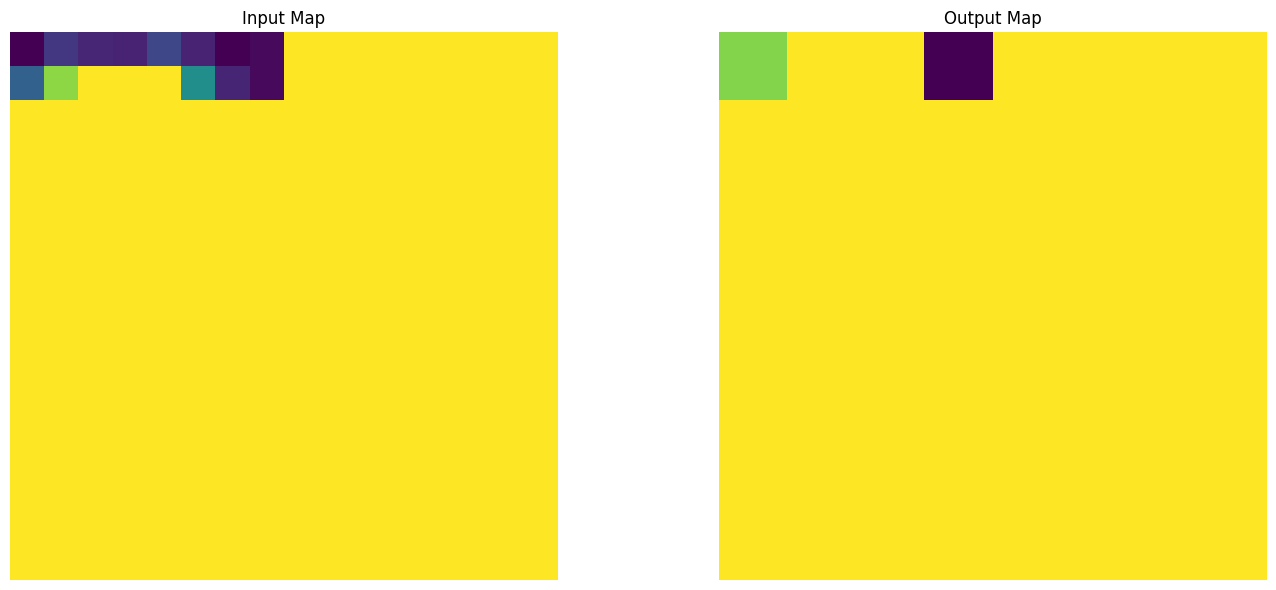

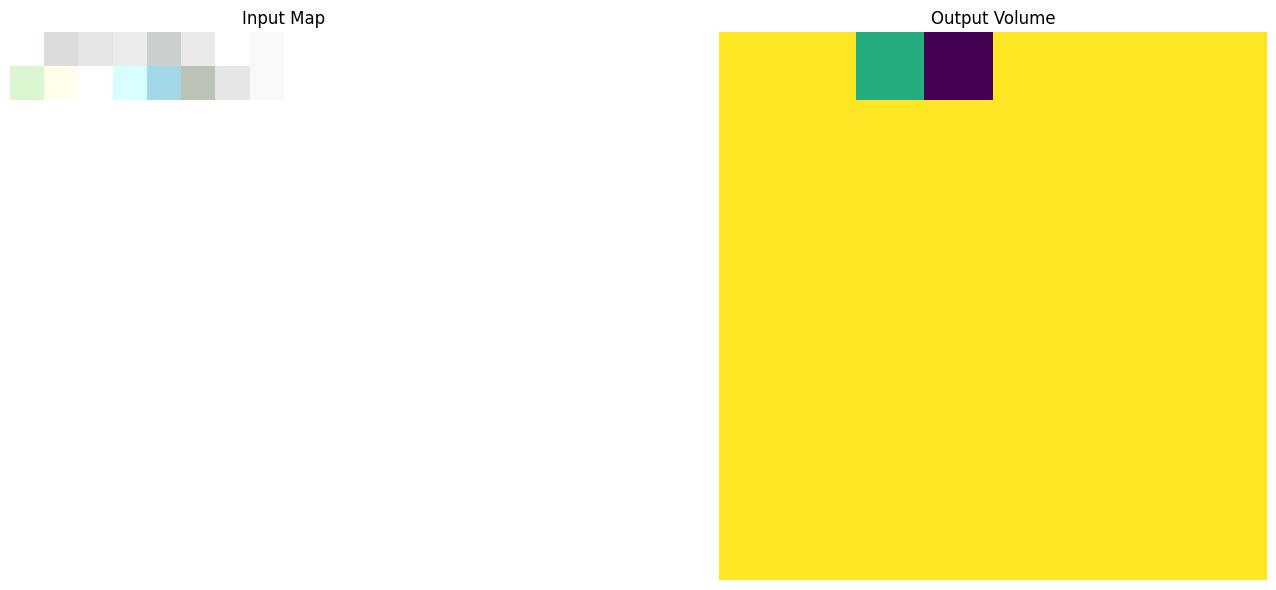

(8, 8, 4)


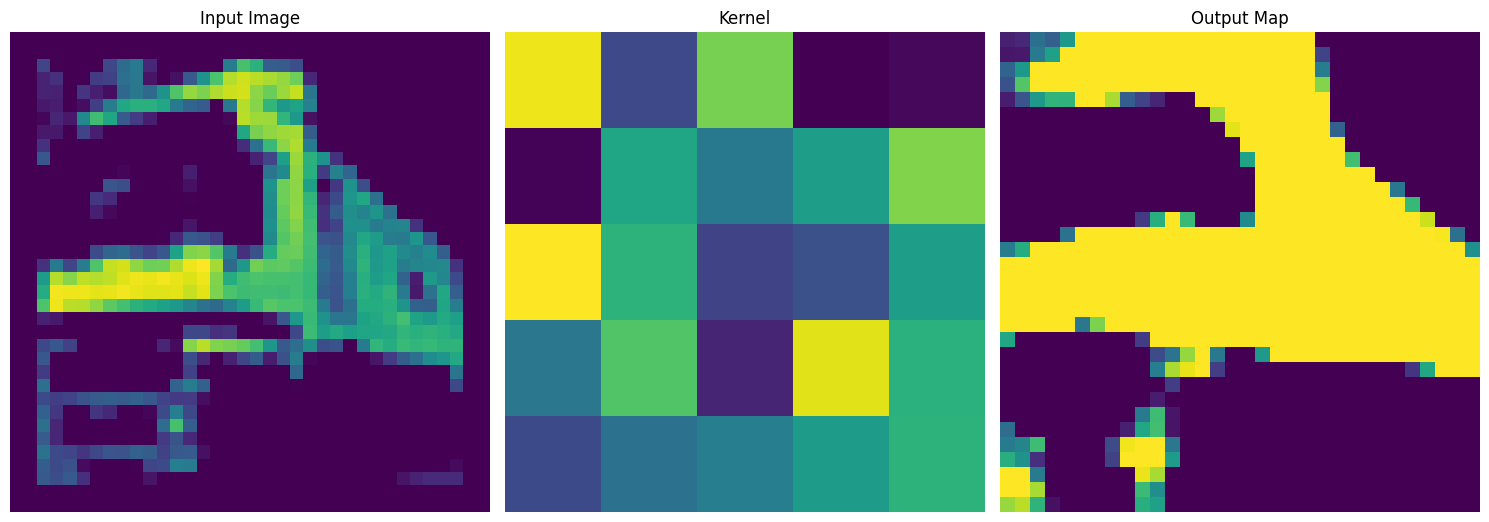

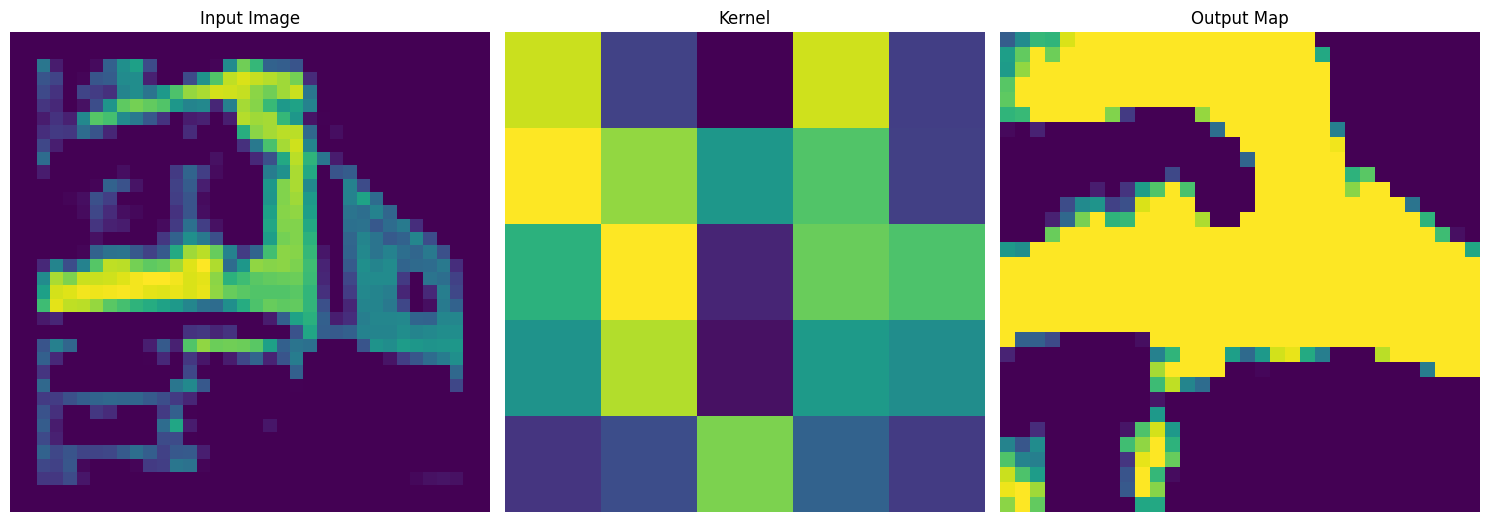

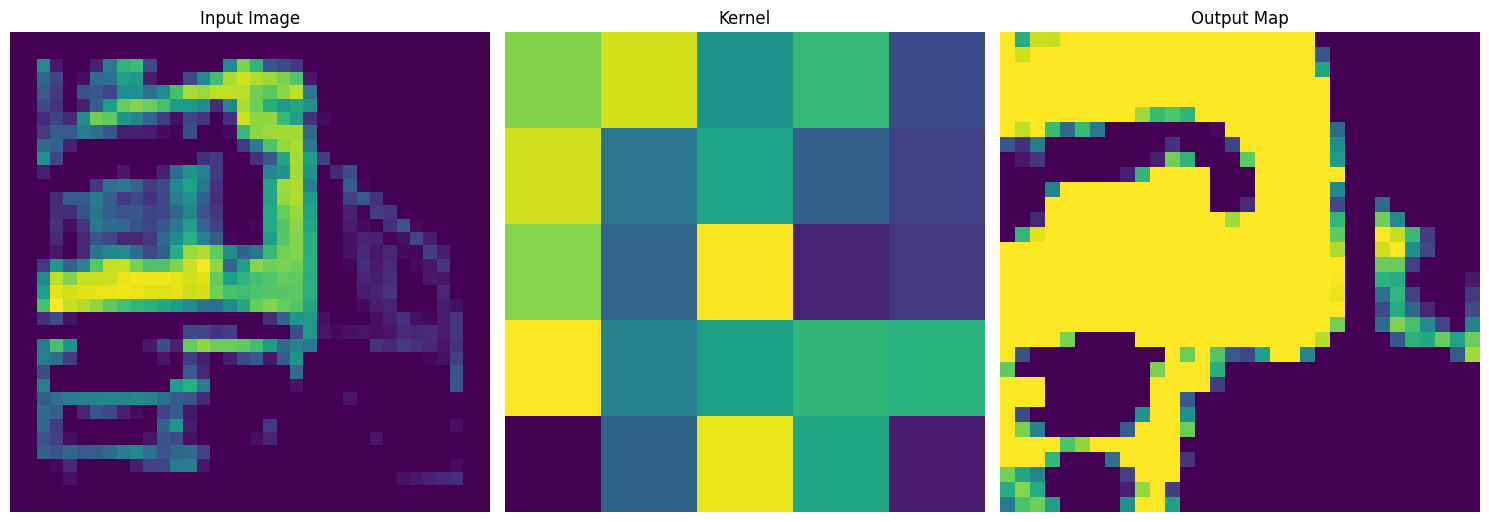

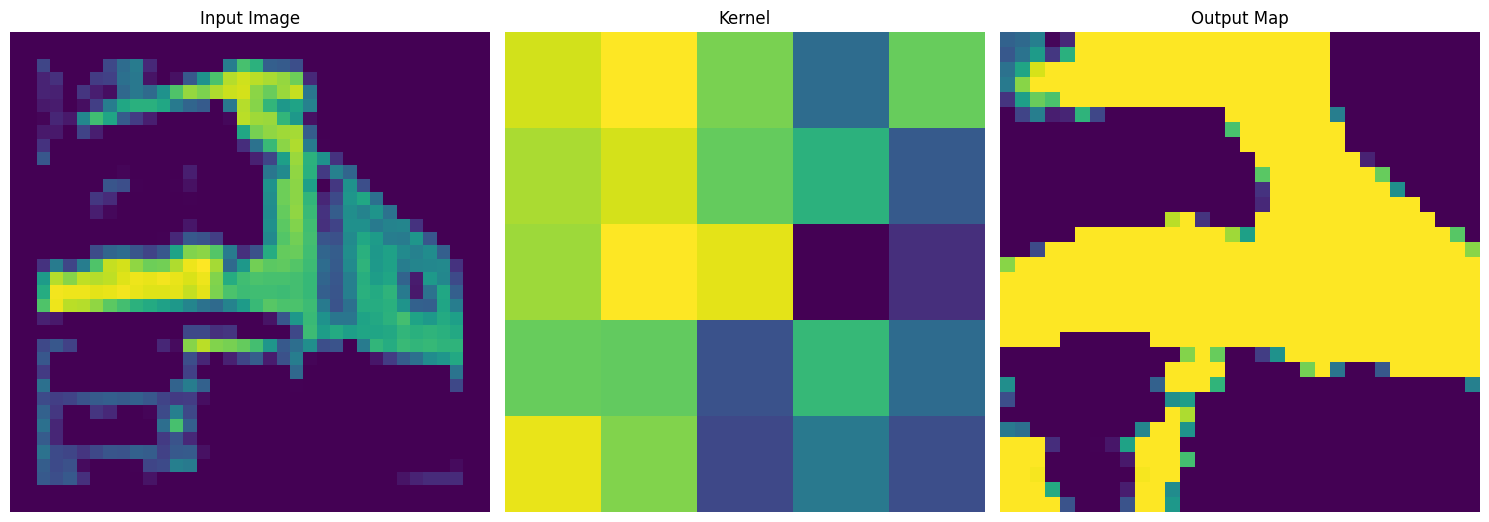

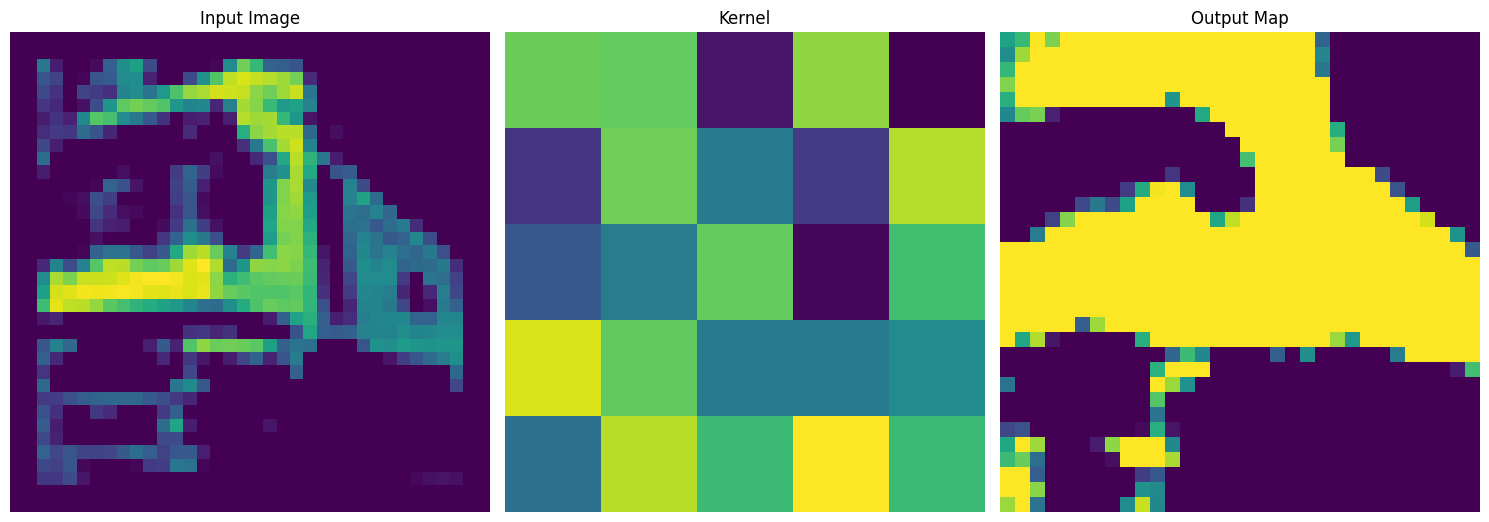

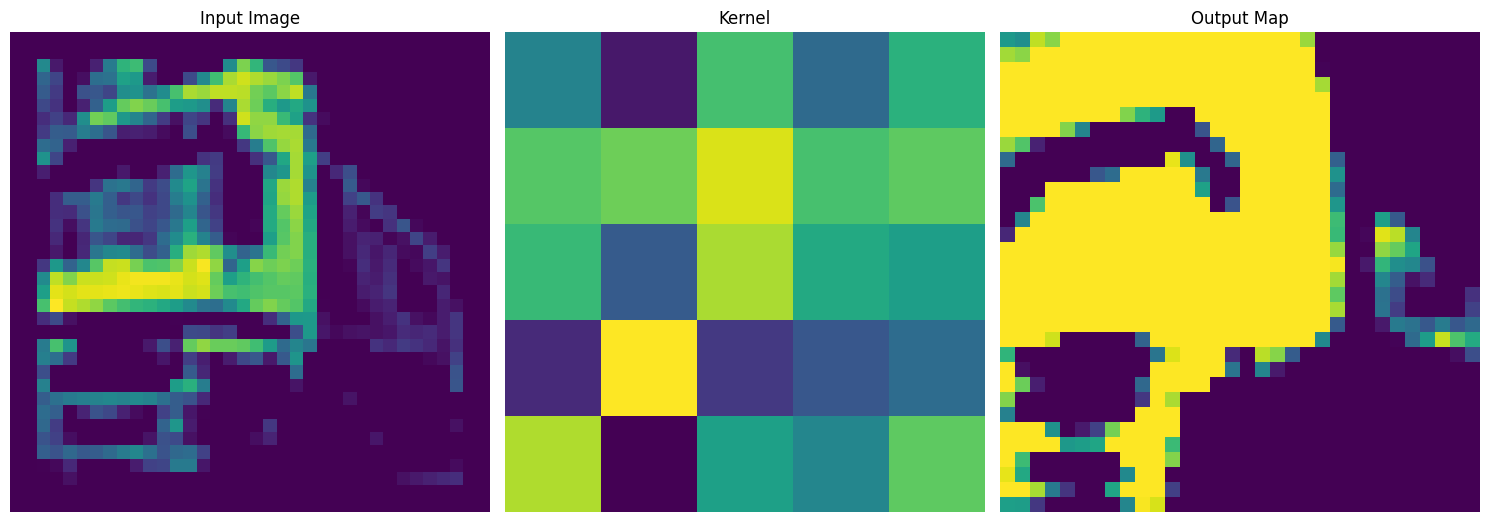

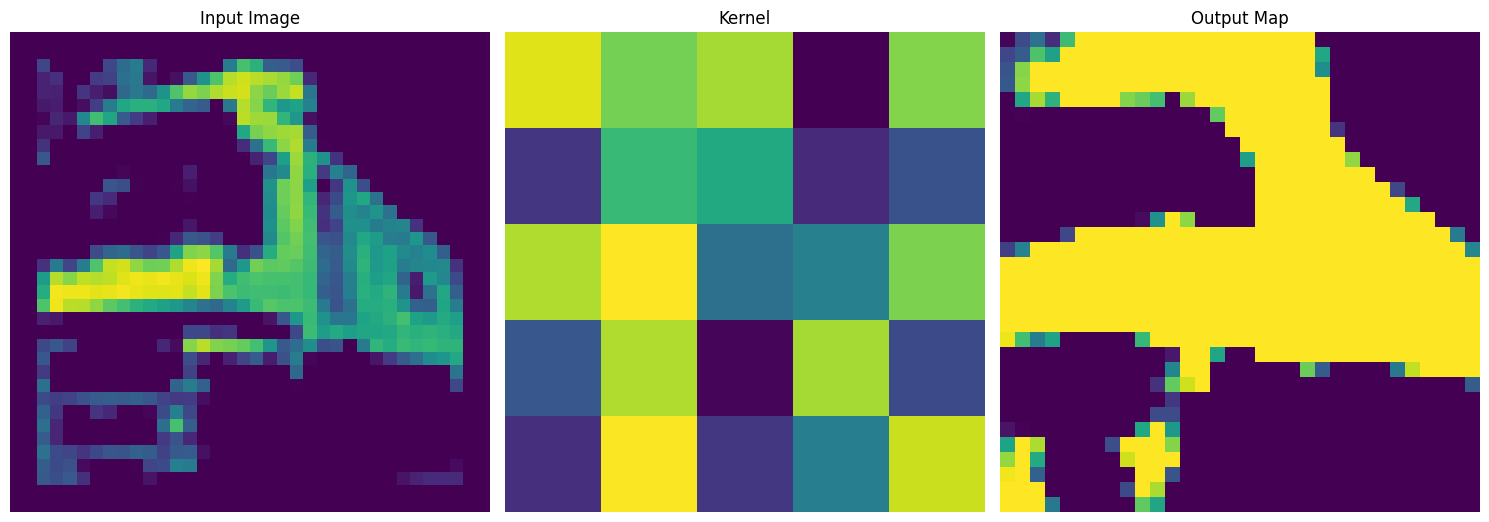

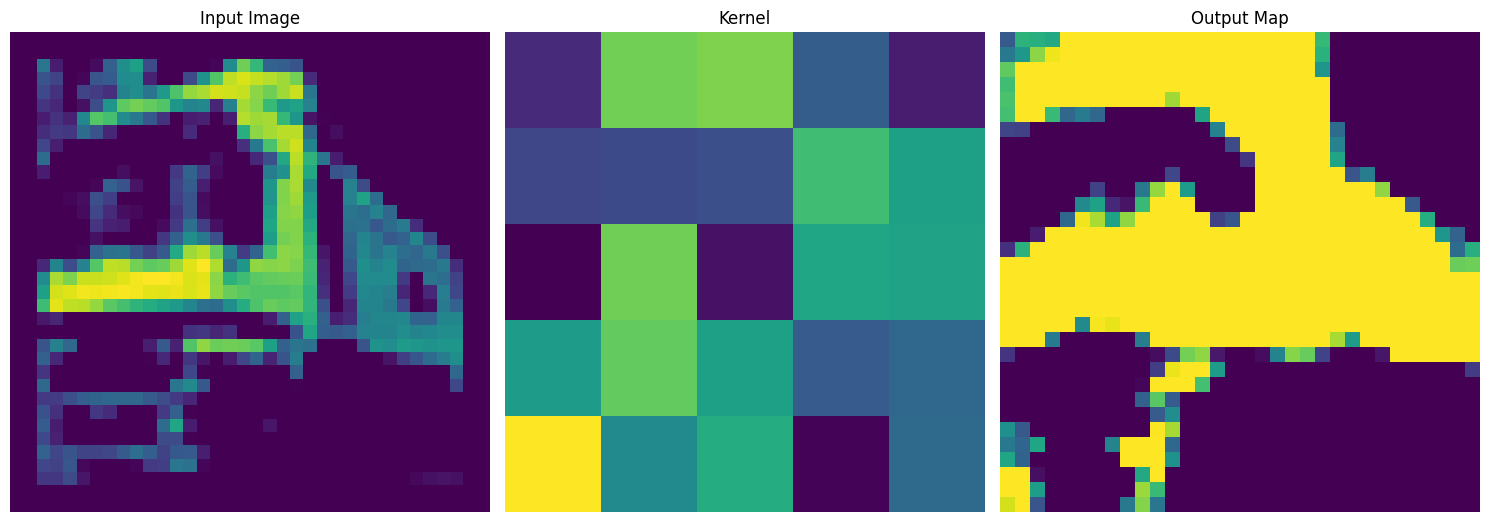

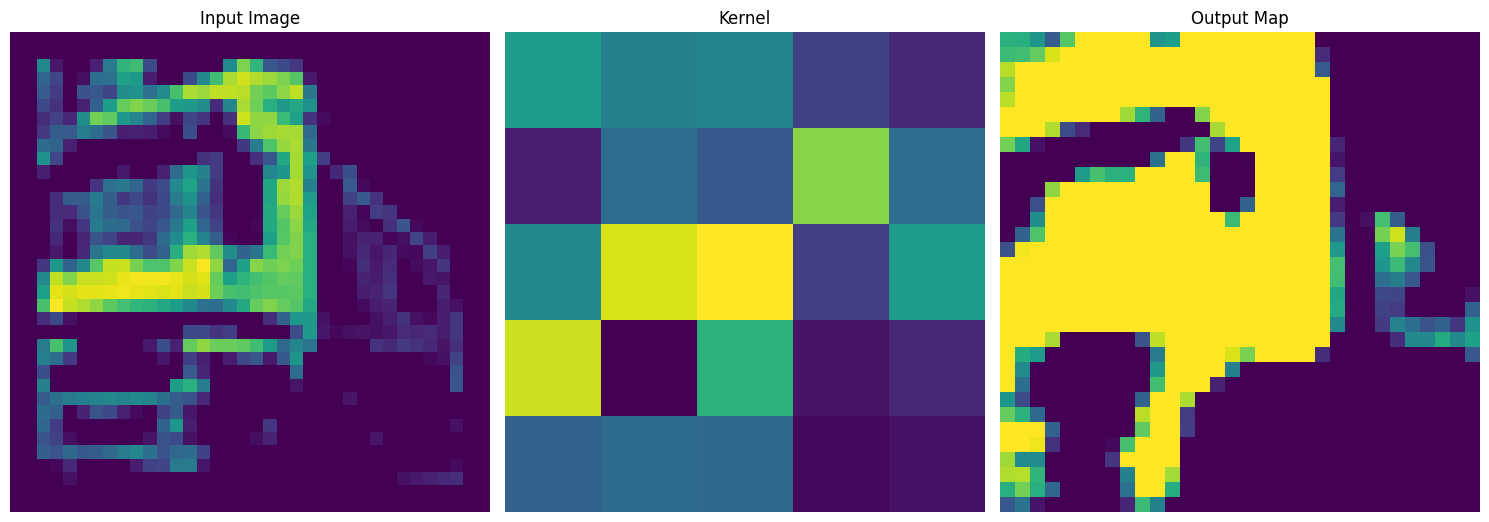

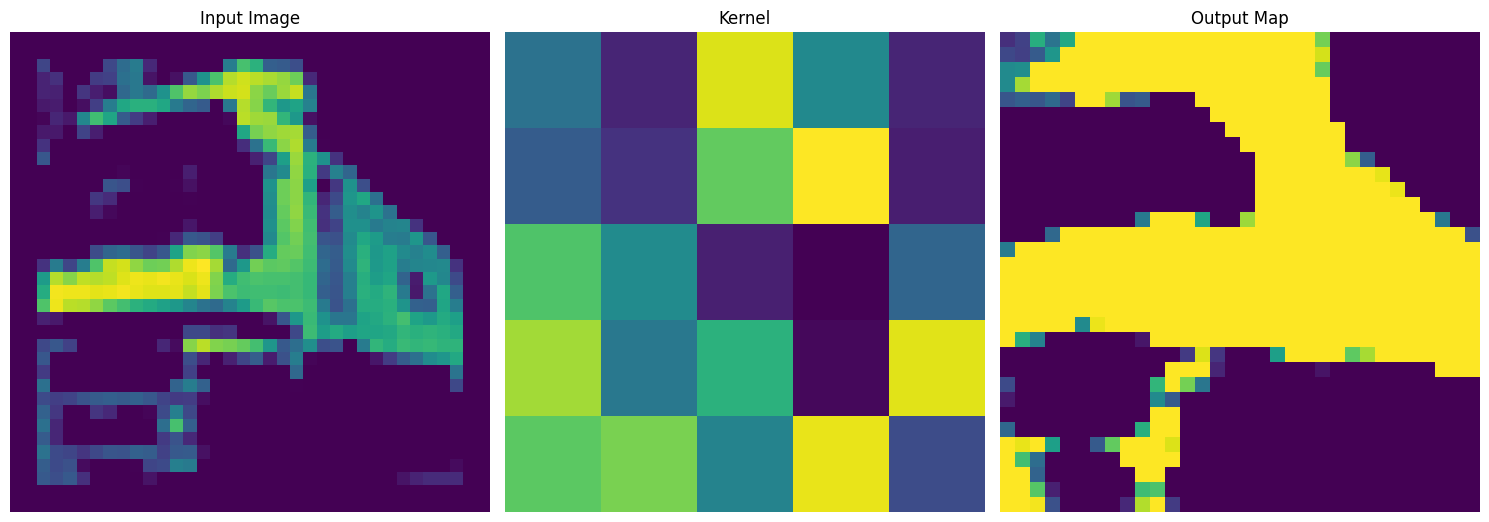

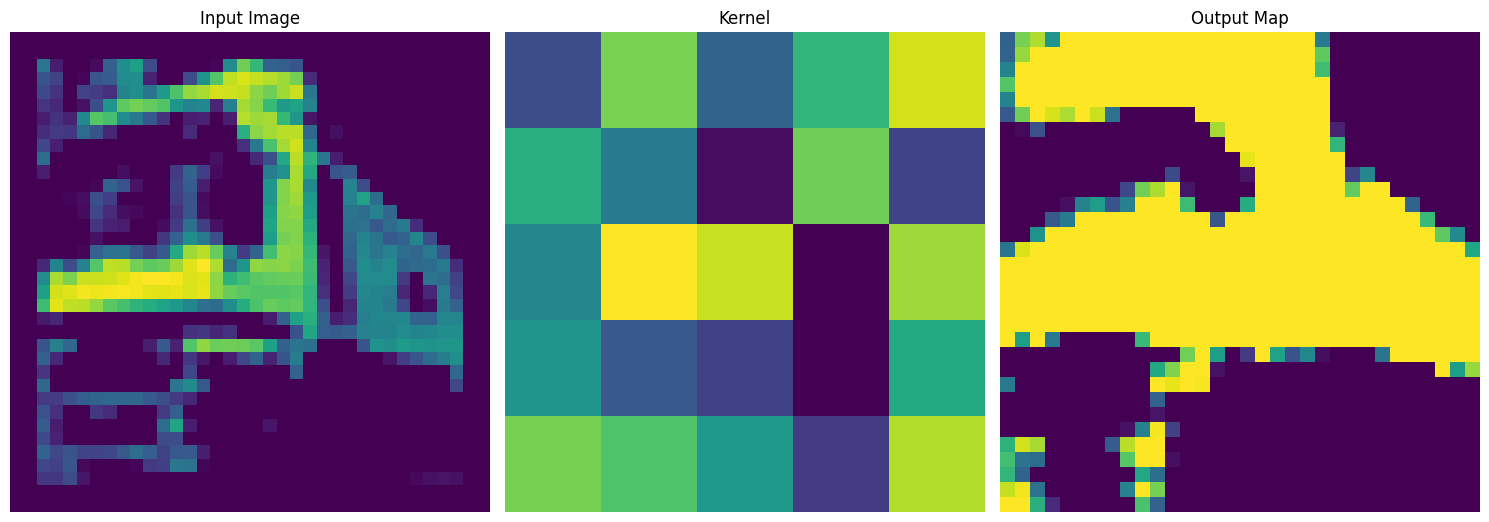

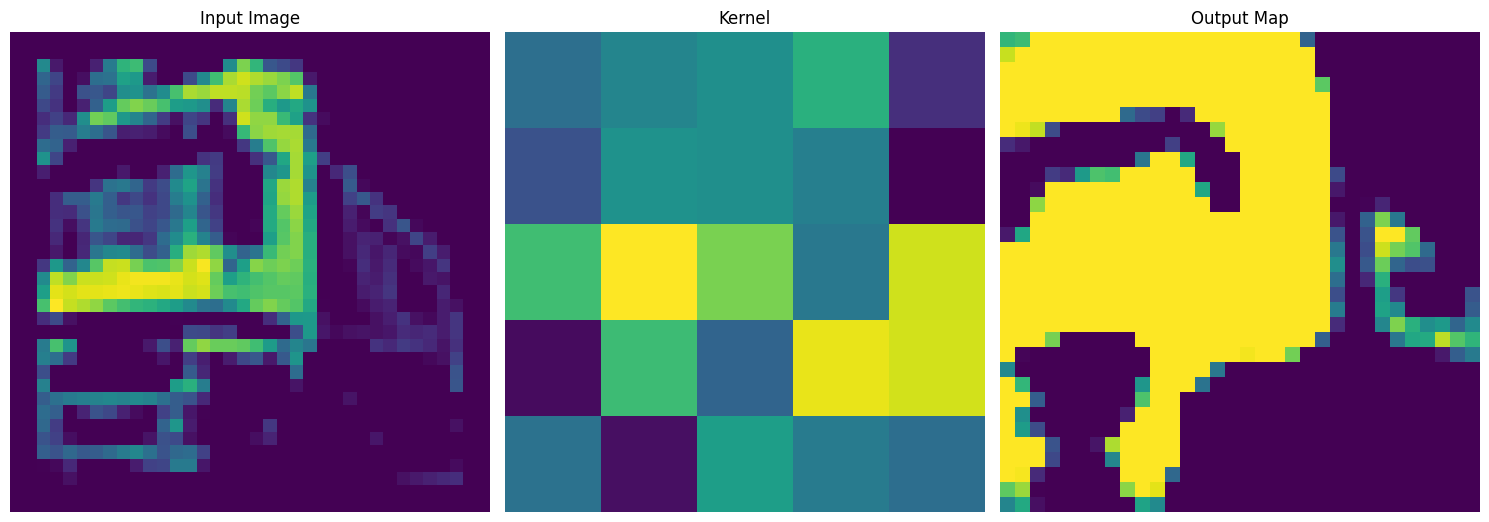

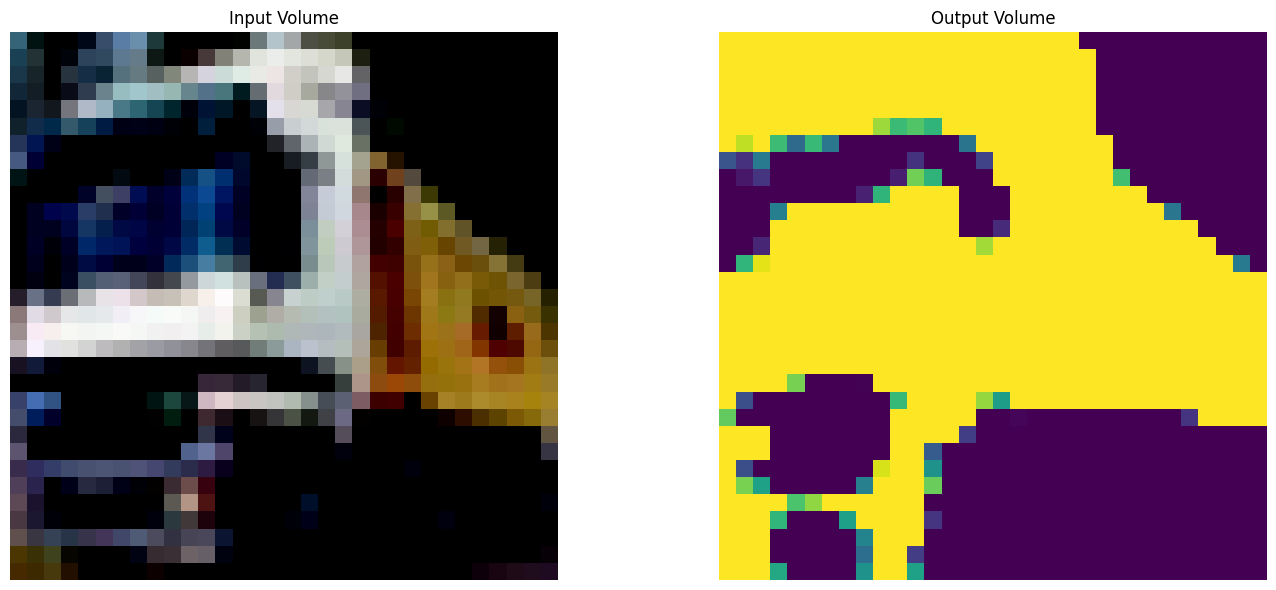

(32, 32, 4)


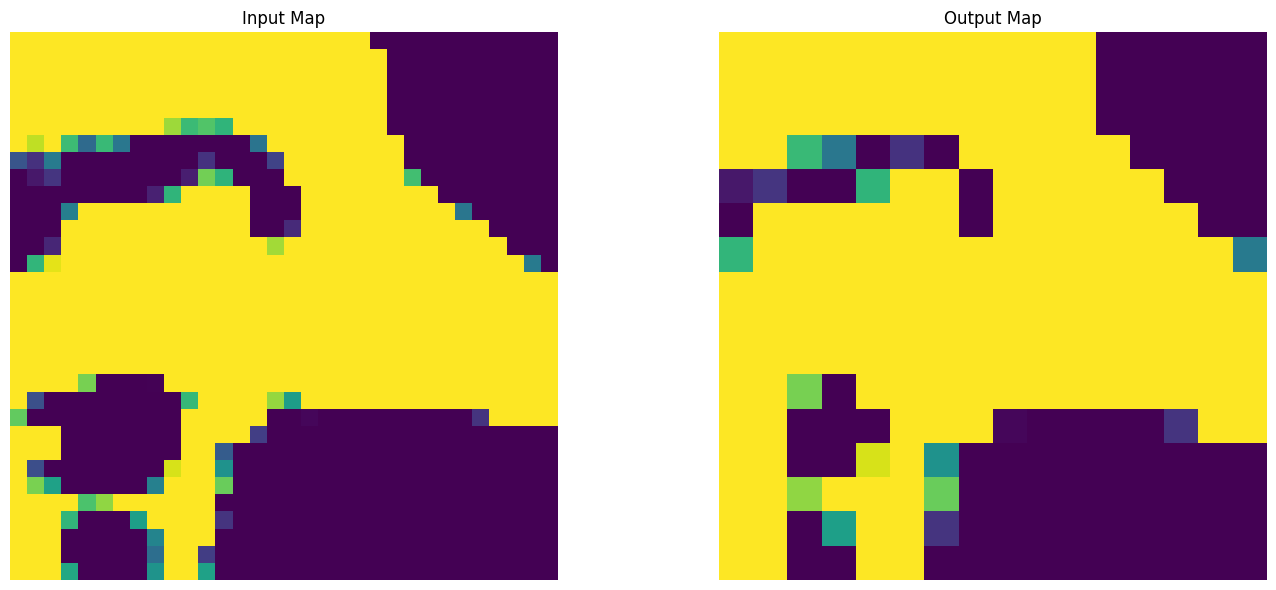

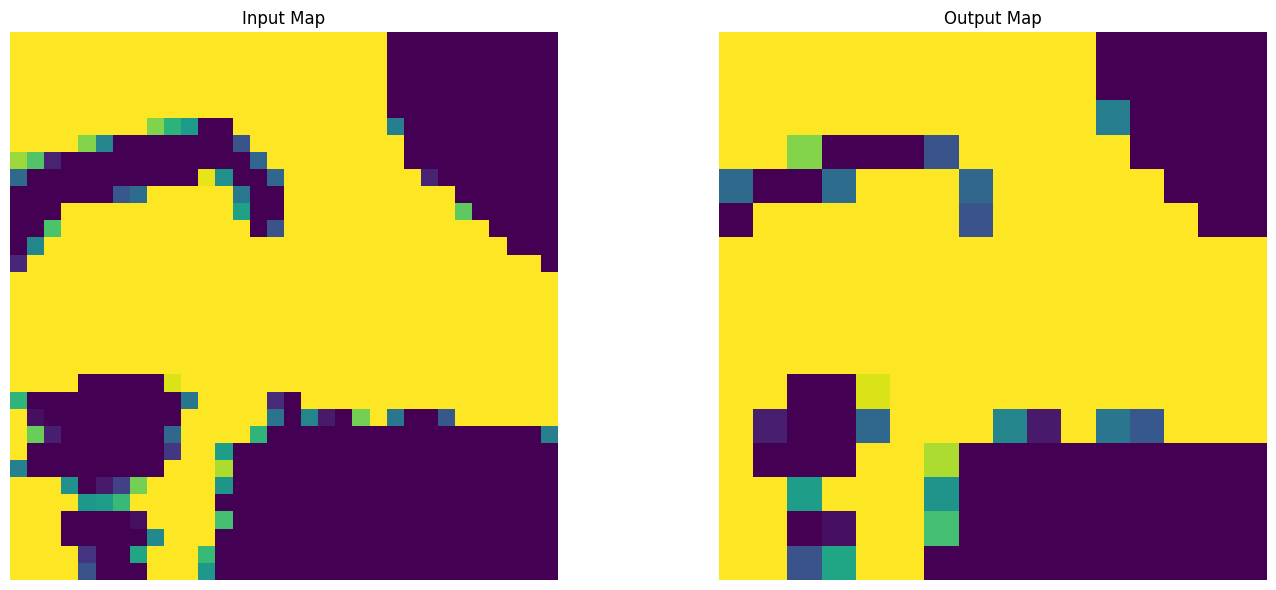

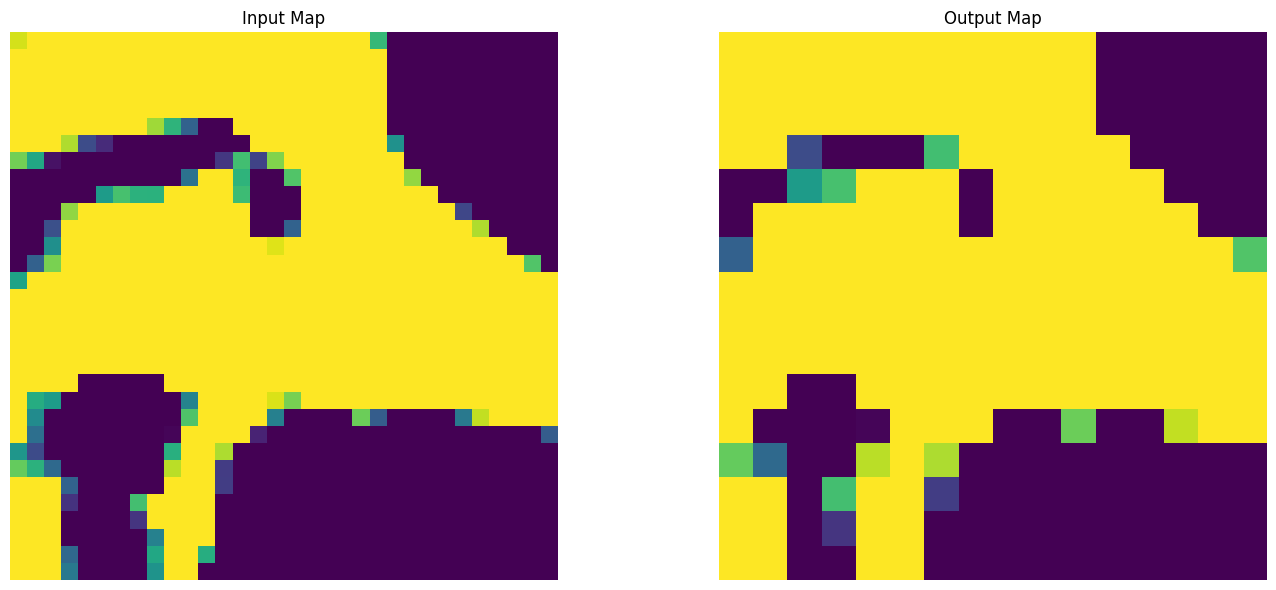

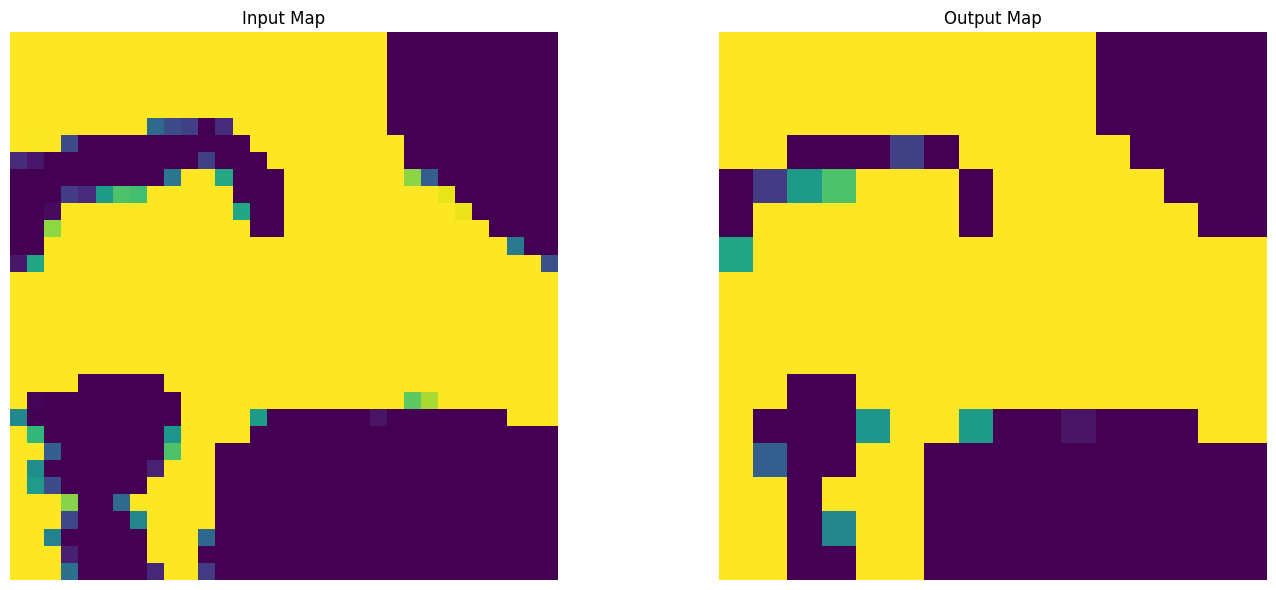

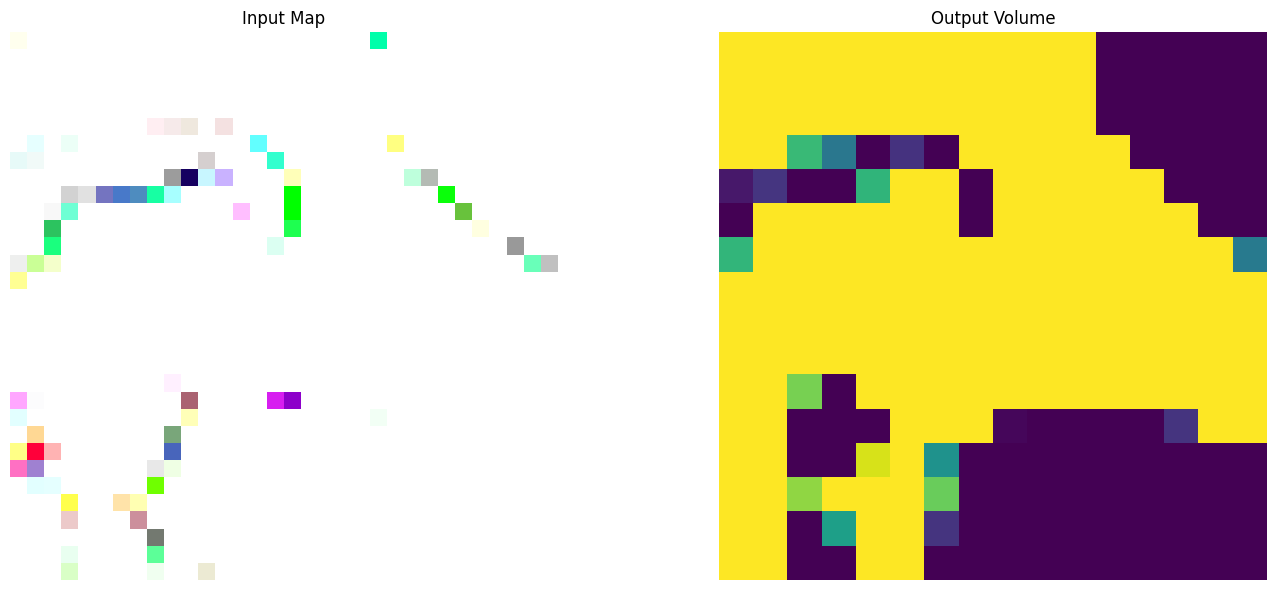

(16, 16, 4)


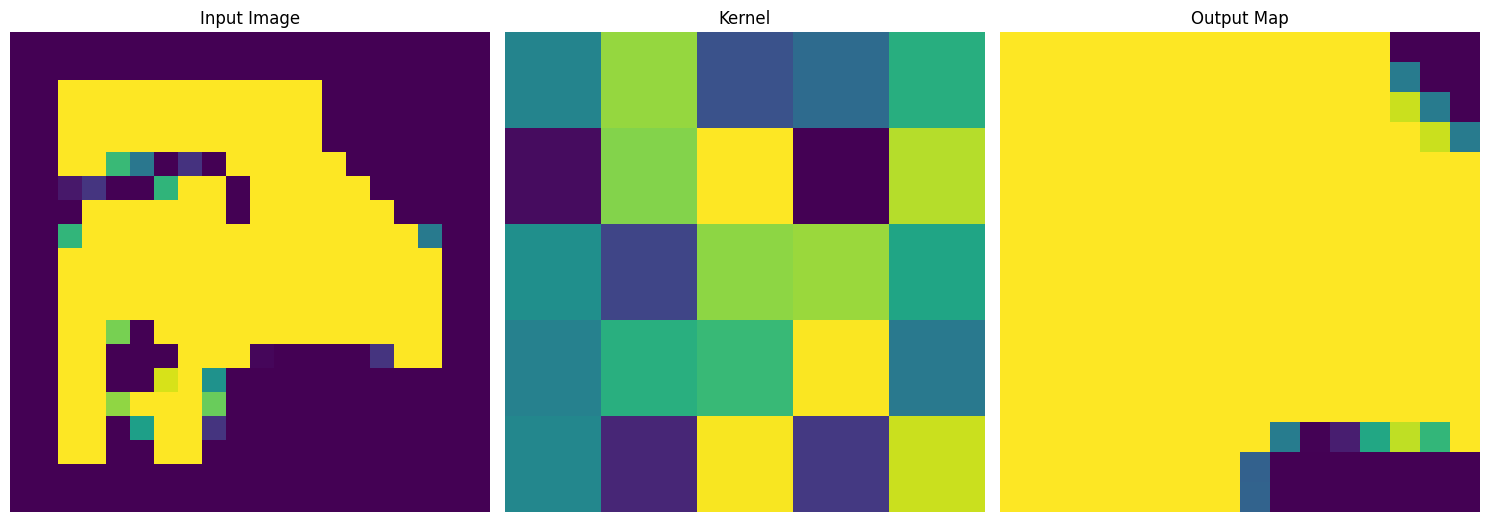

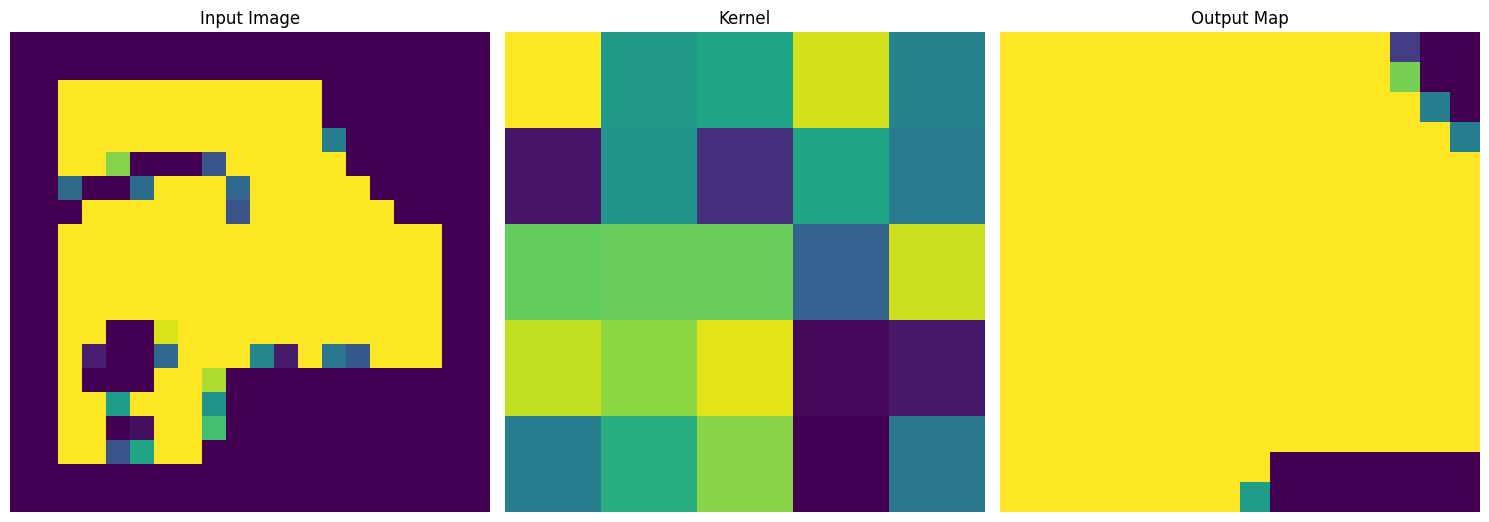

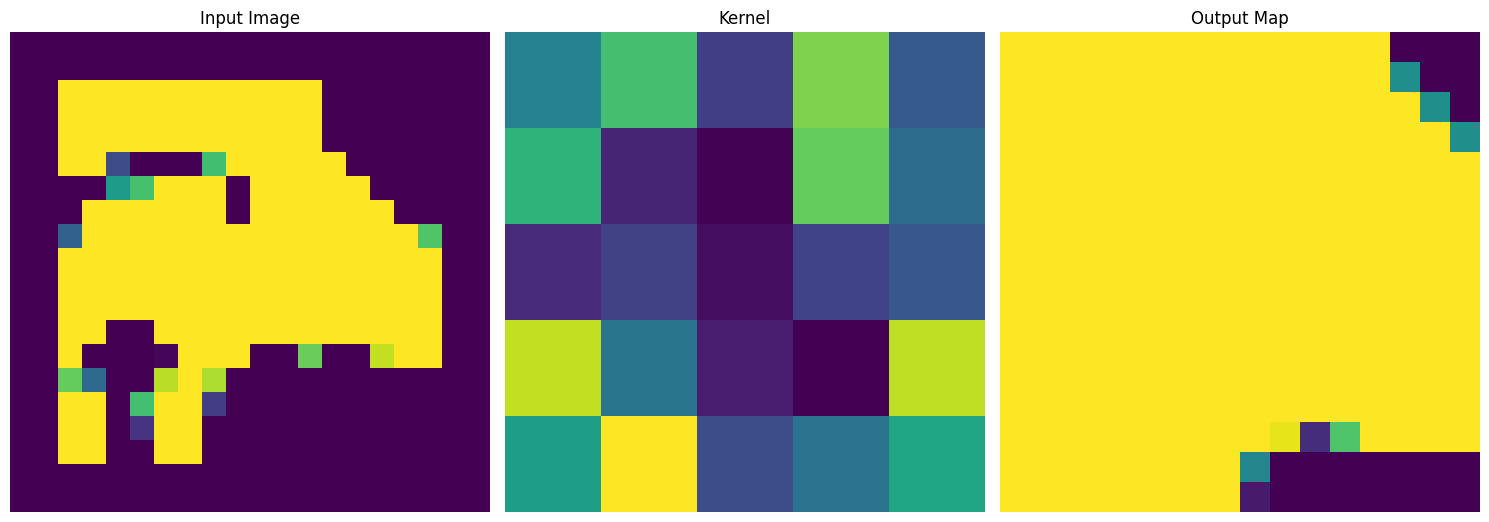

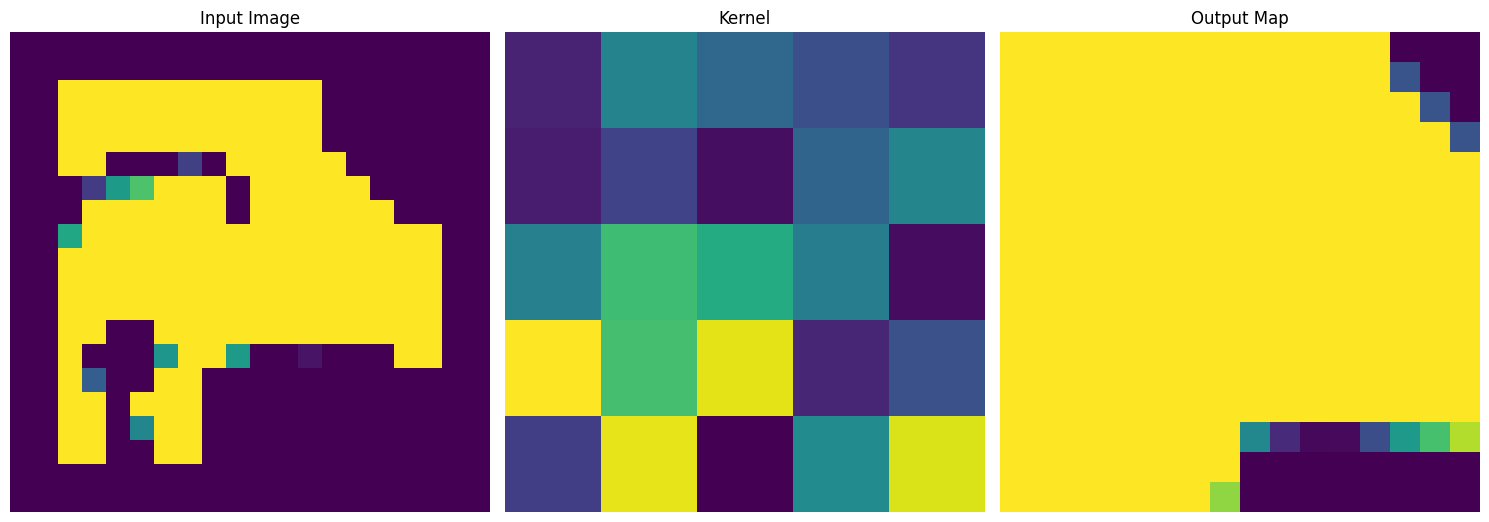

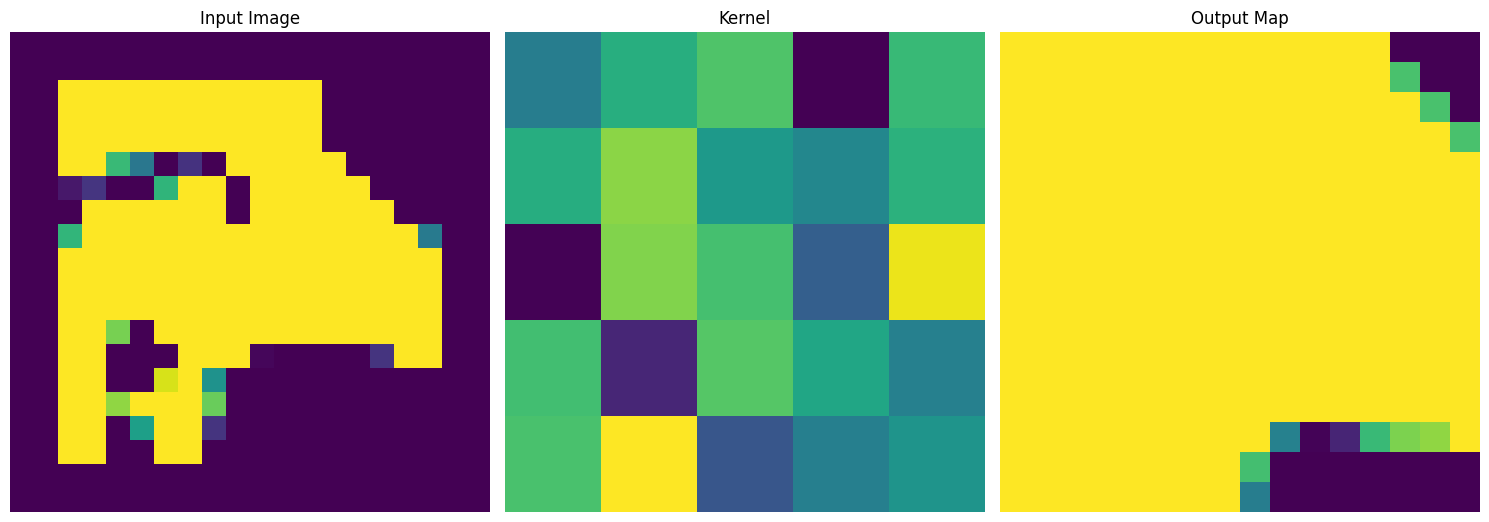

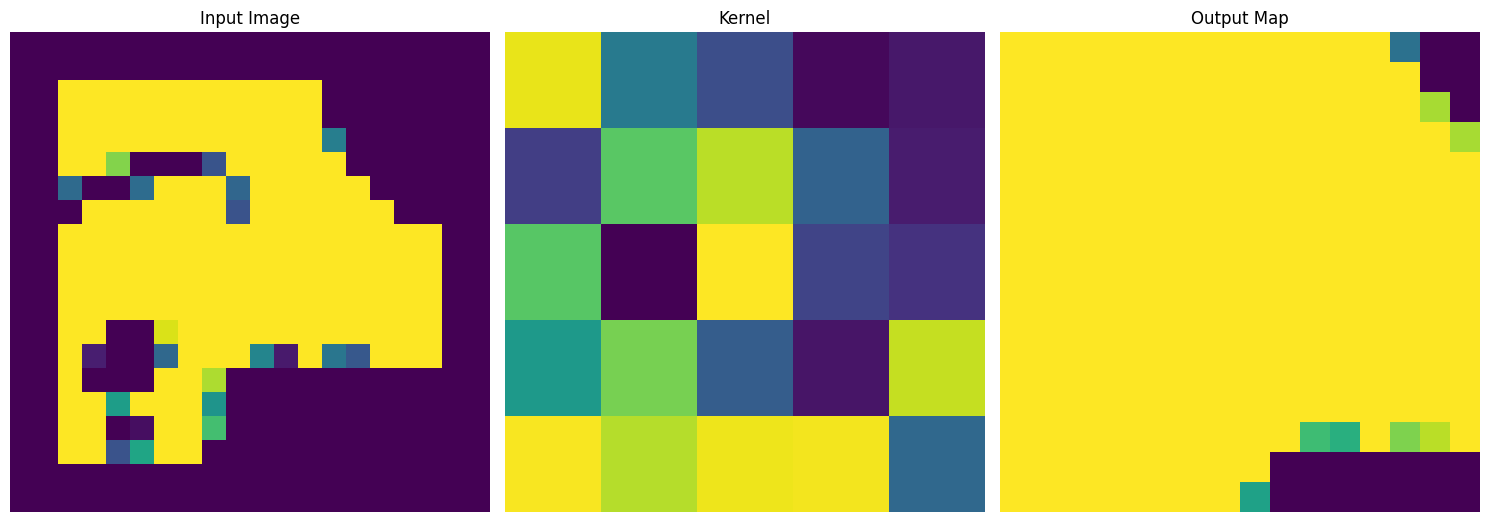

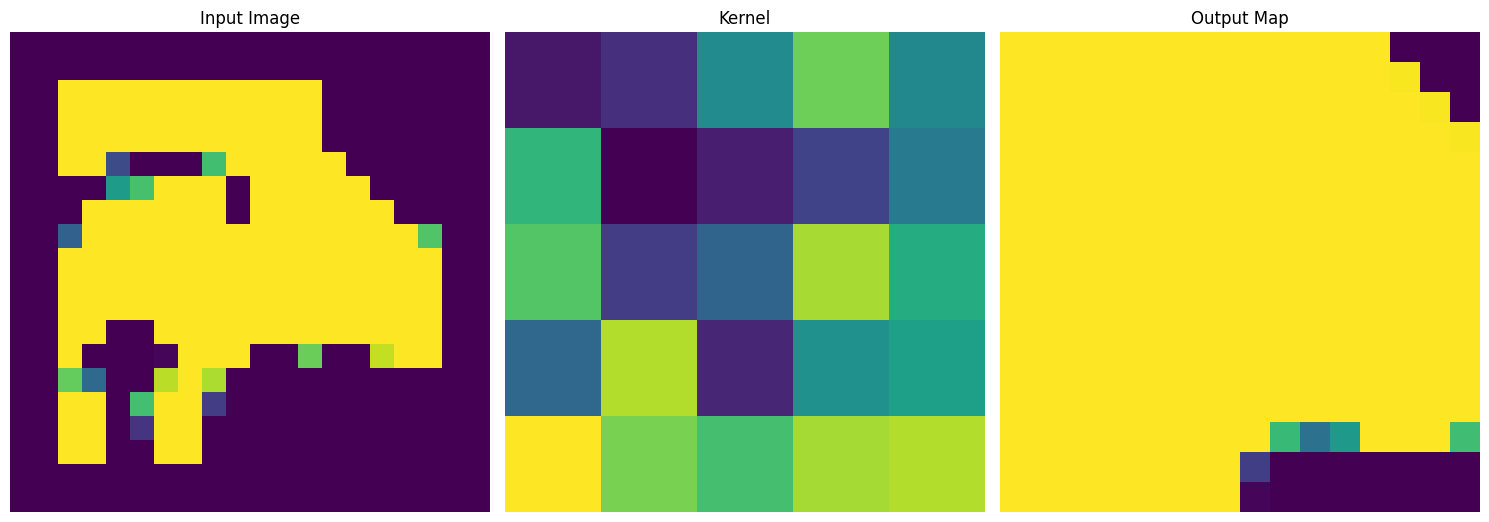

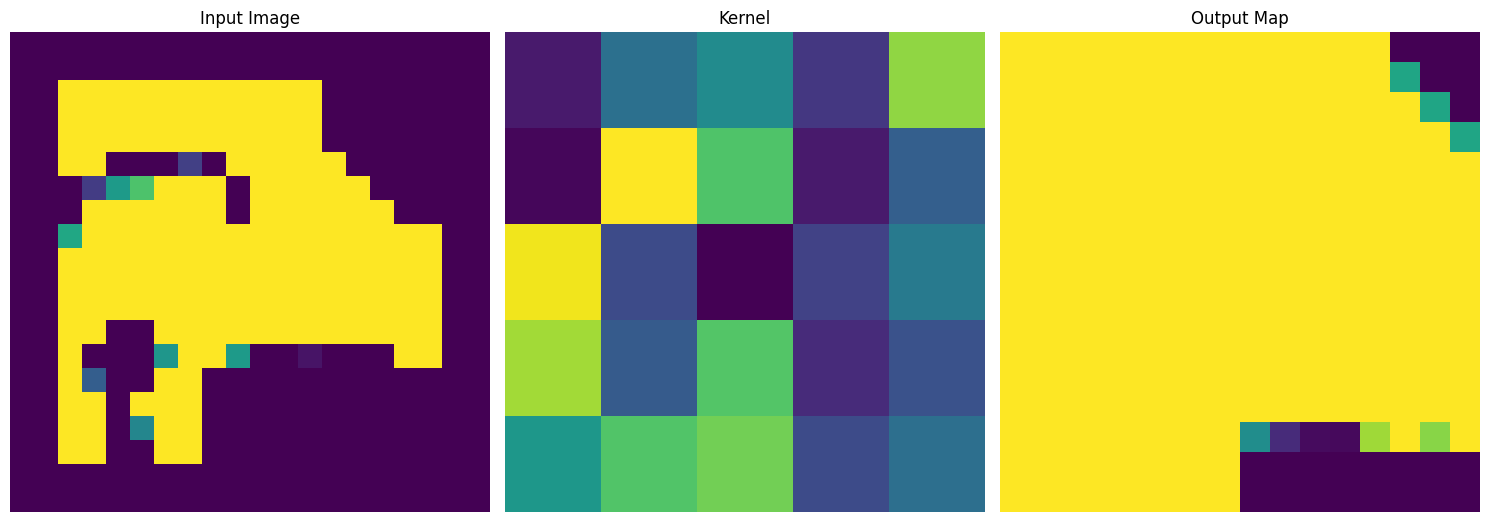

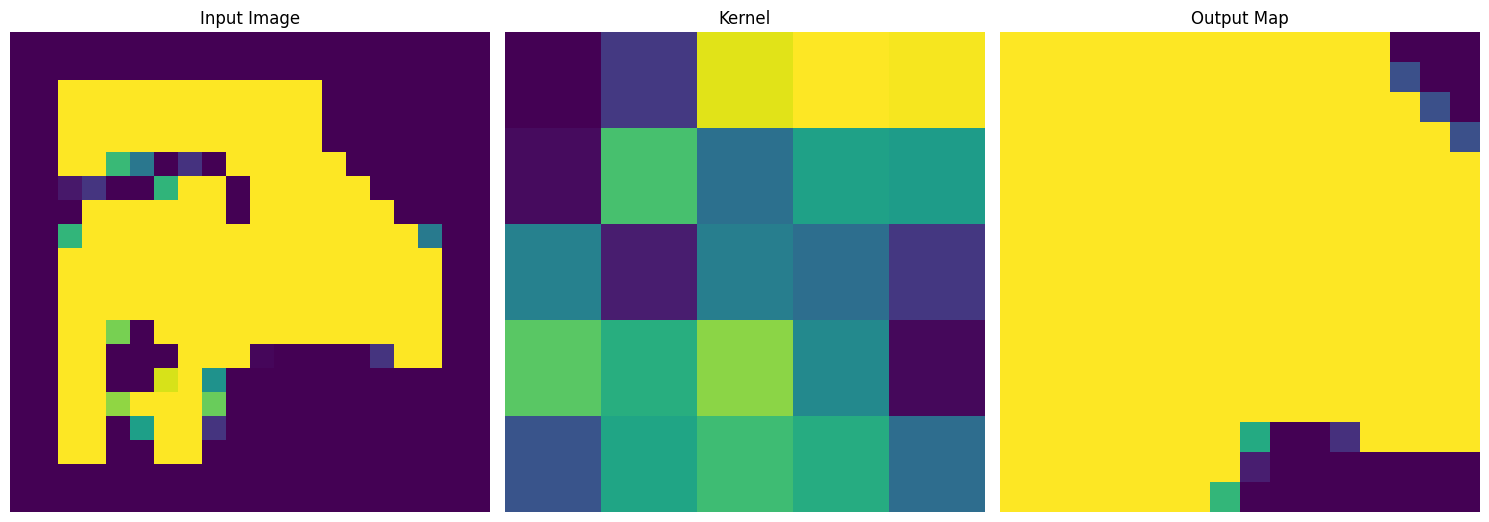

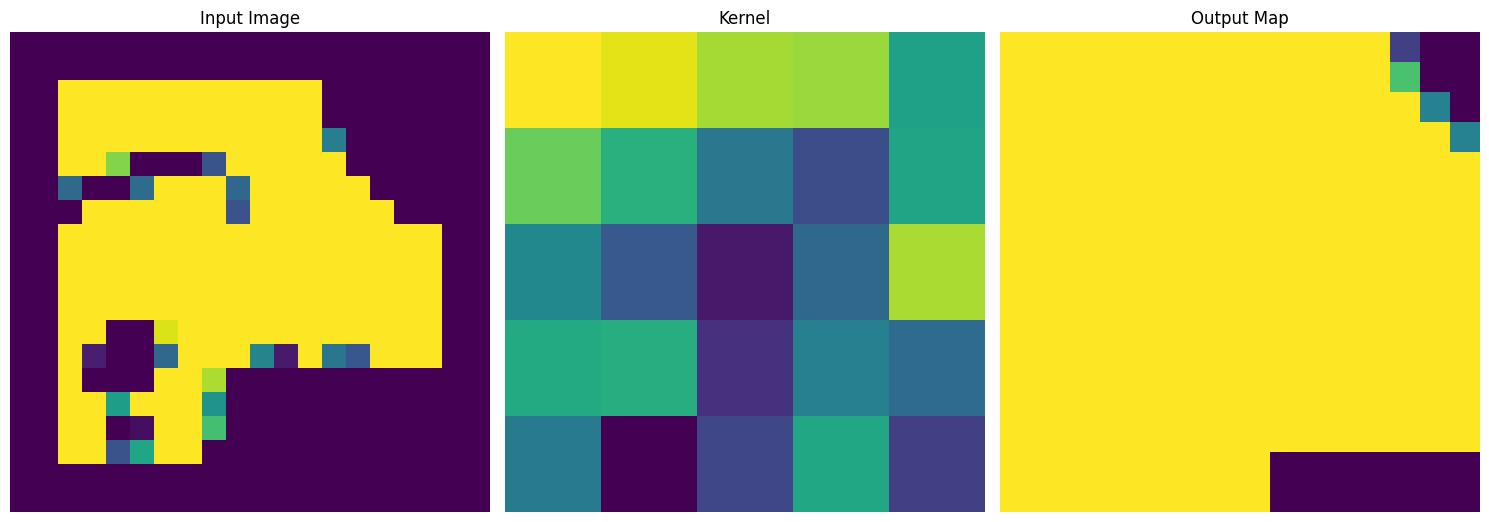

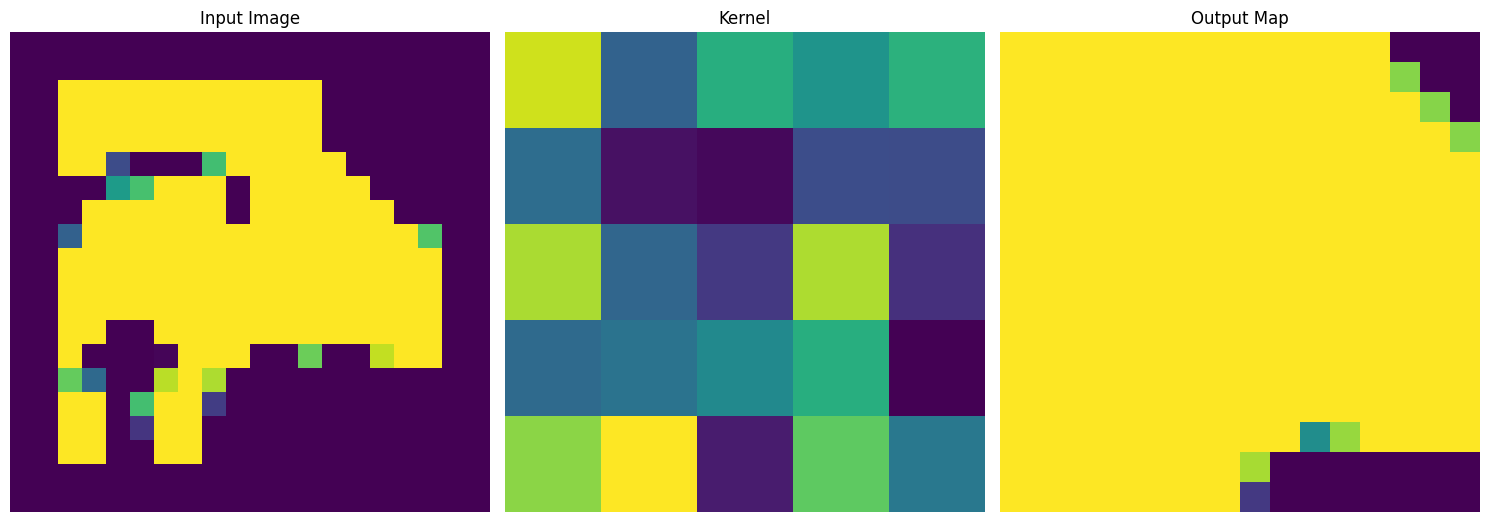

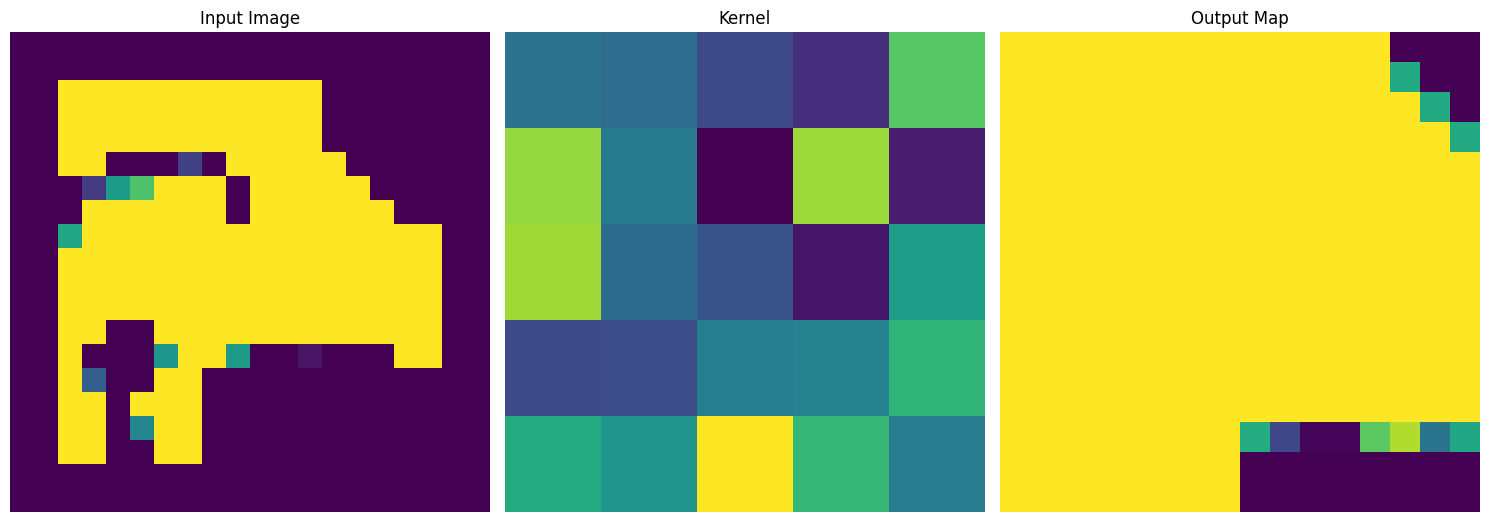

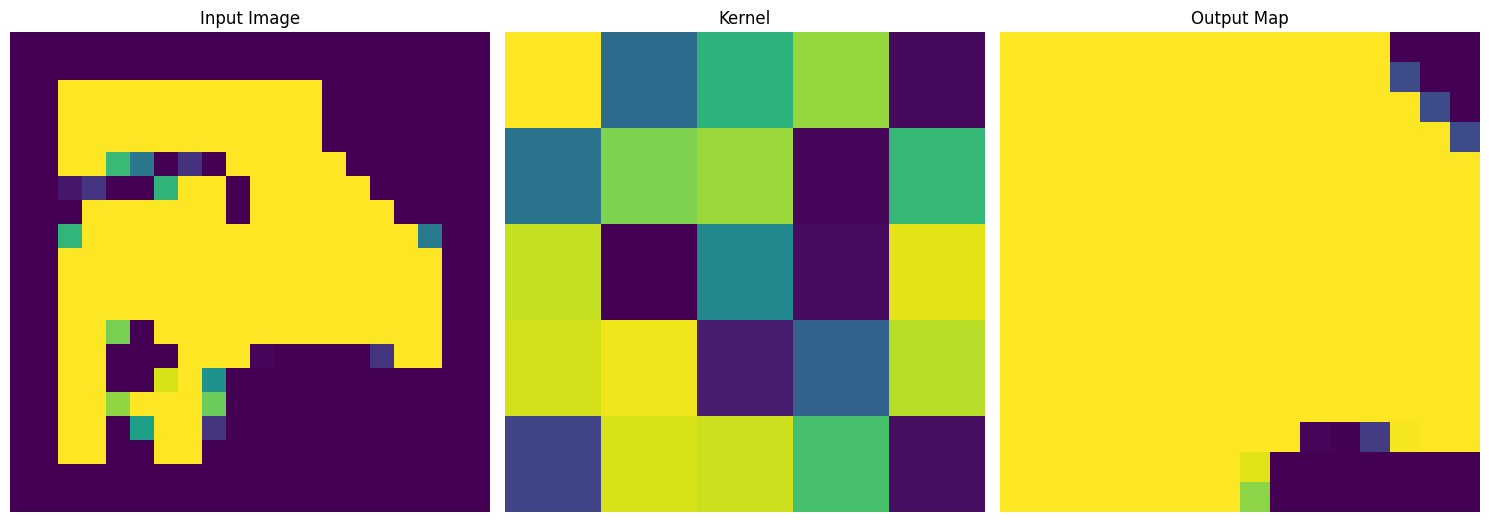

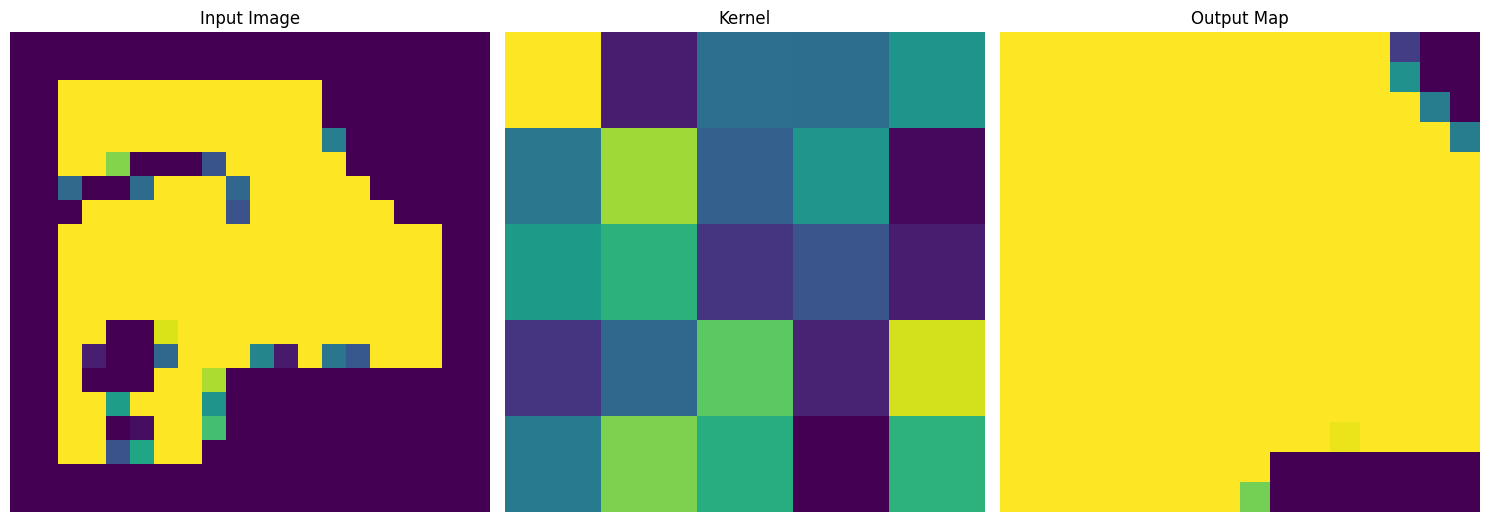

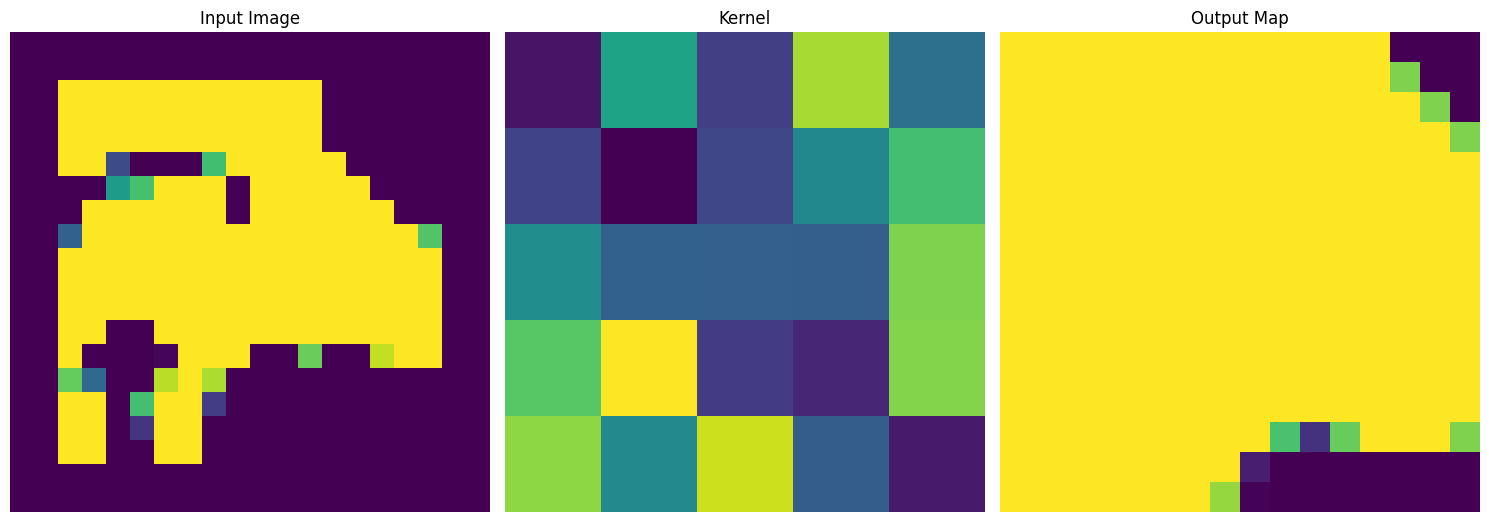

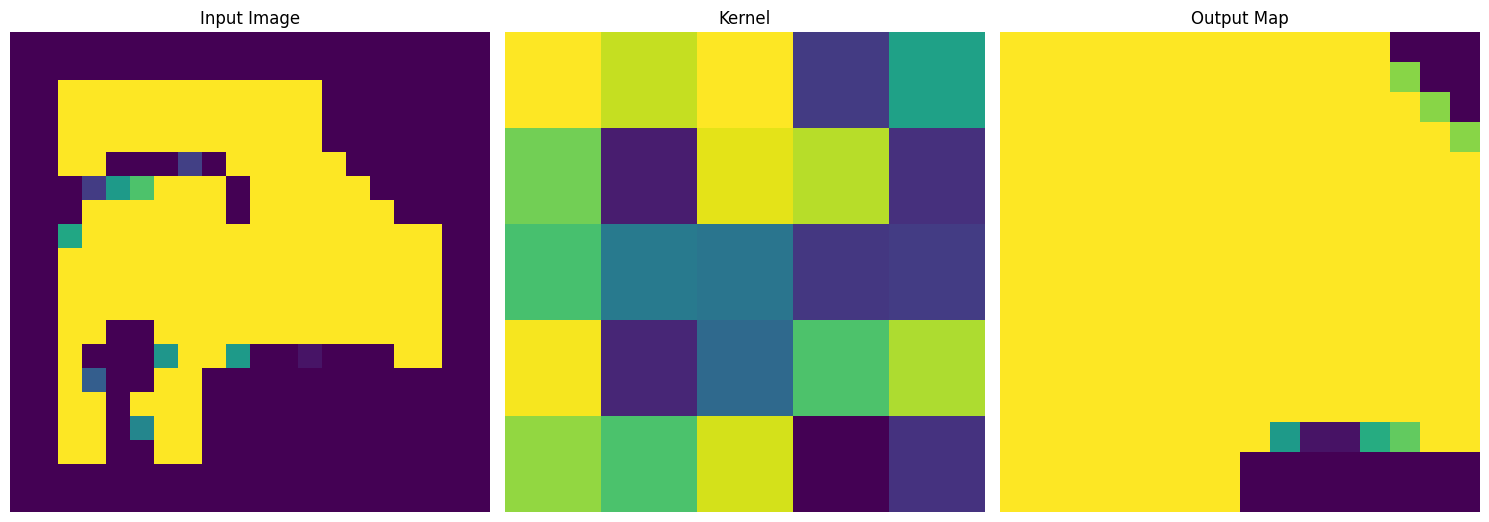

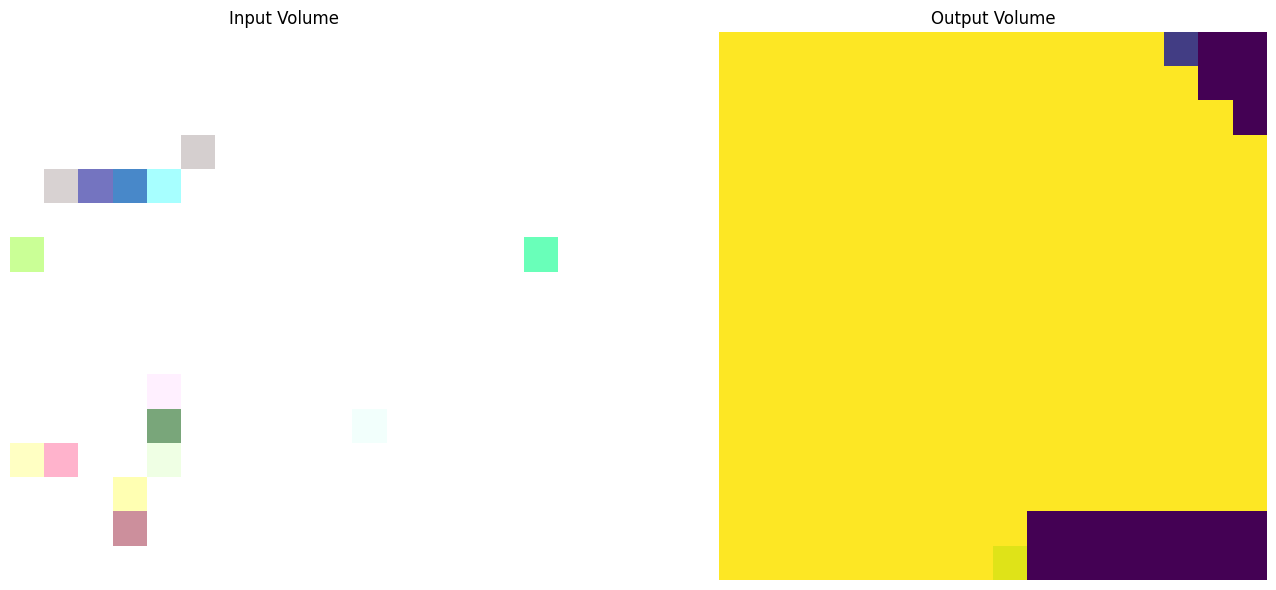

(16, 16, 4)


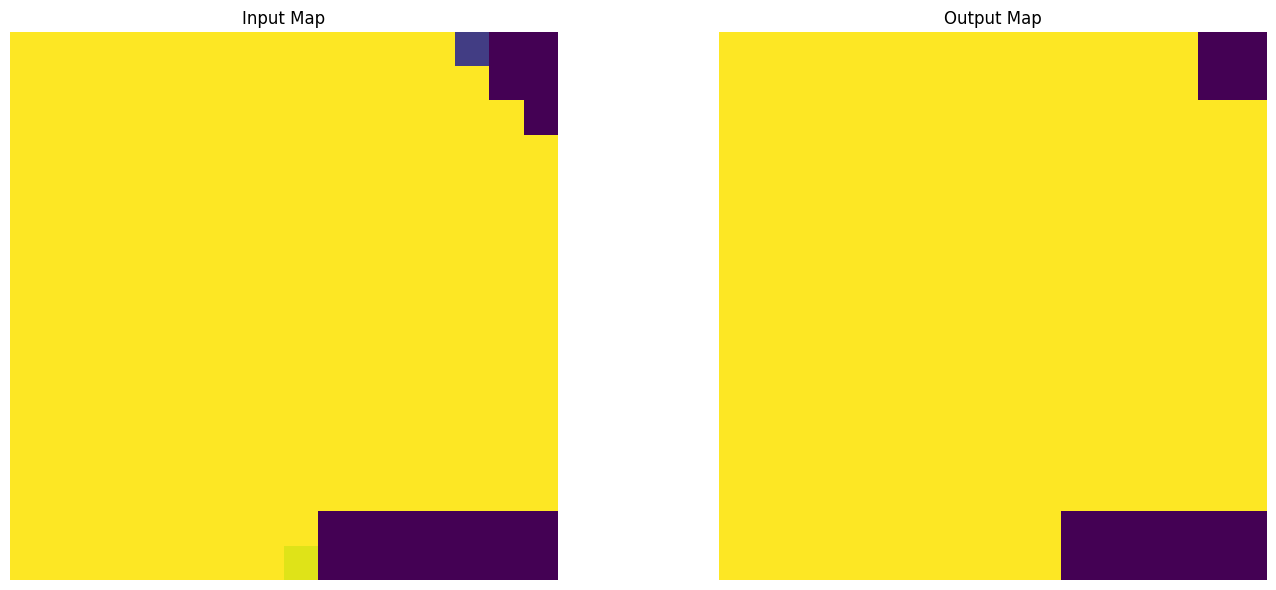

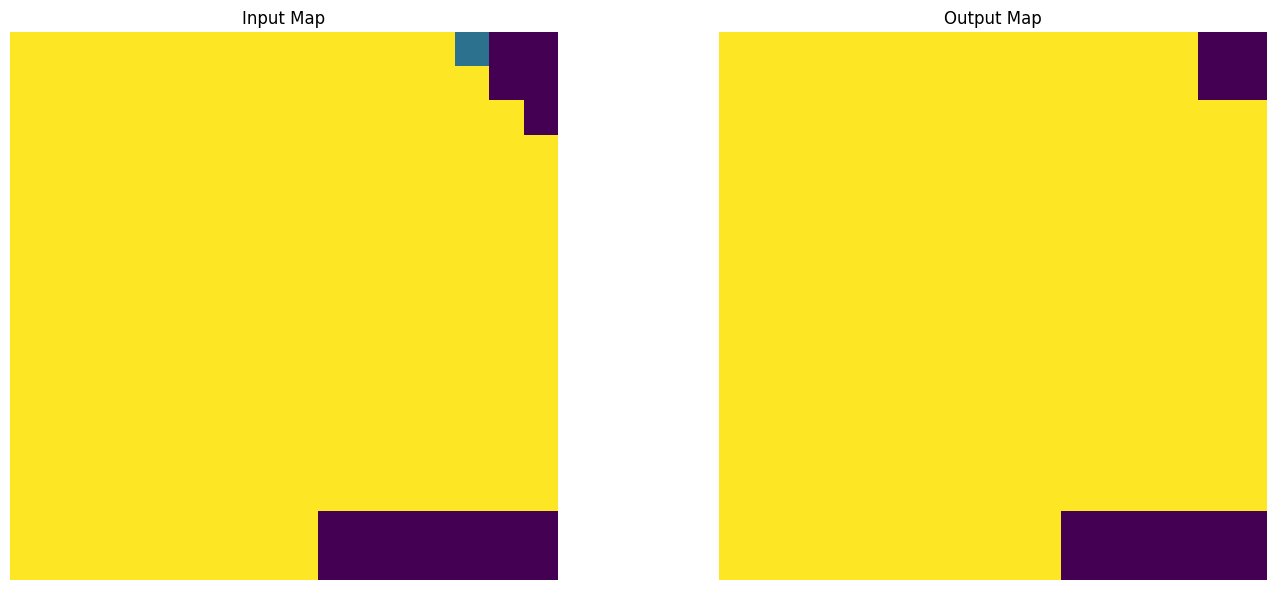

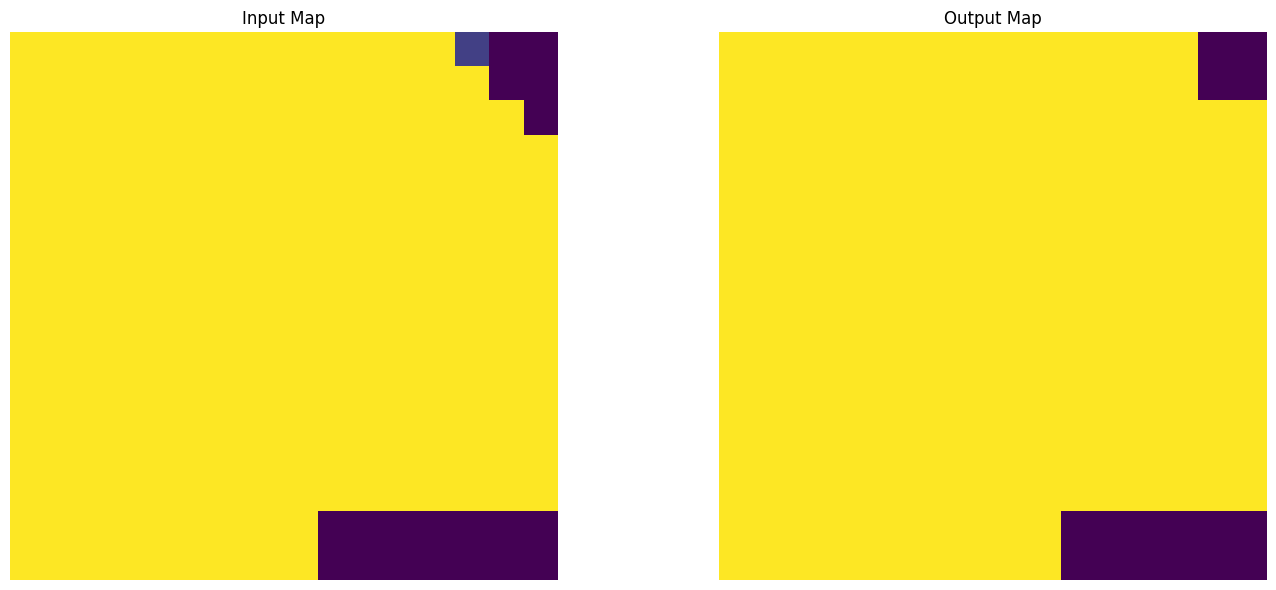

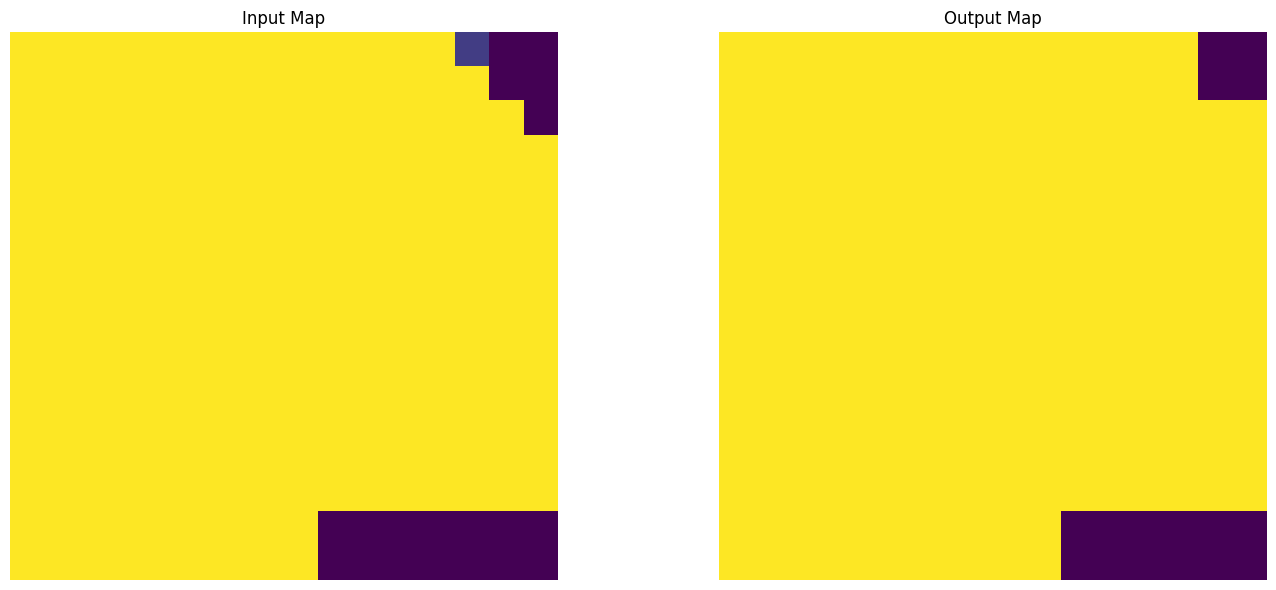

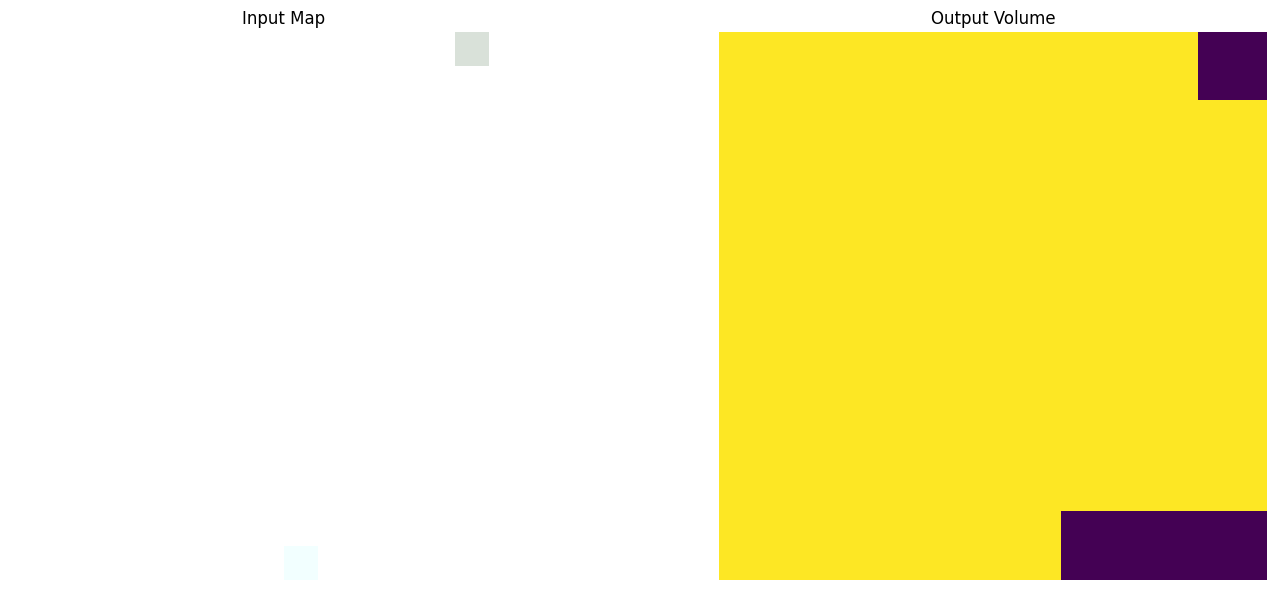

(8, 8, 4)


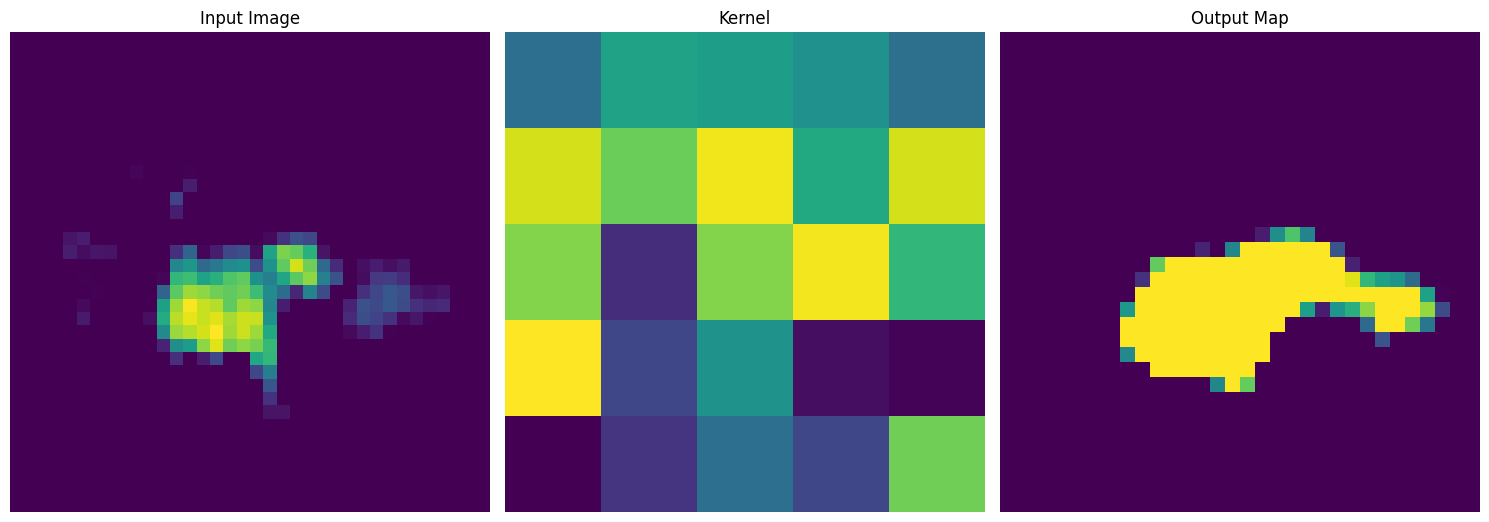

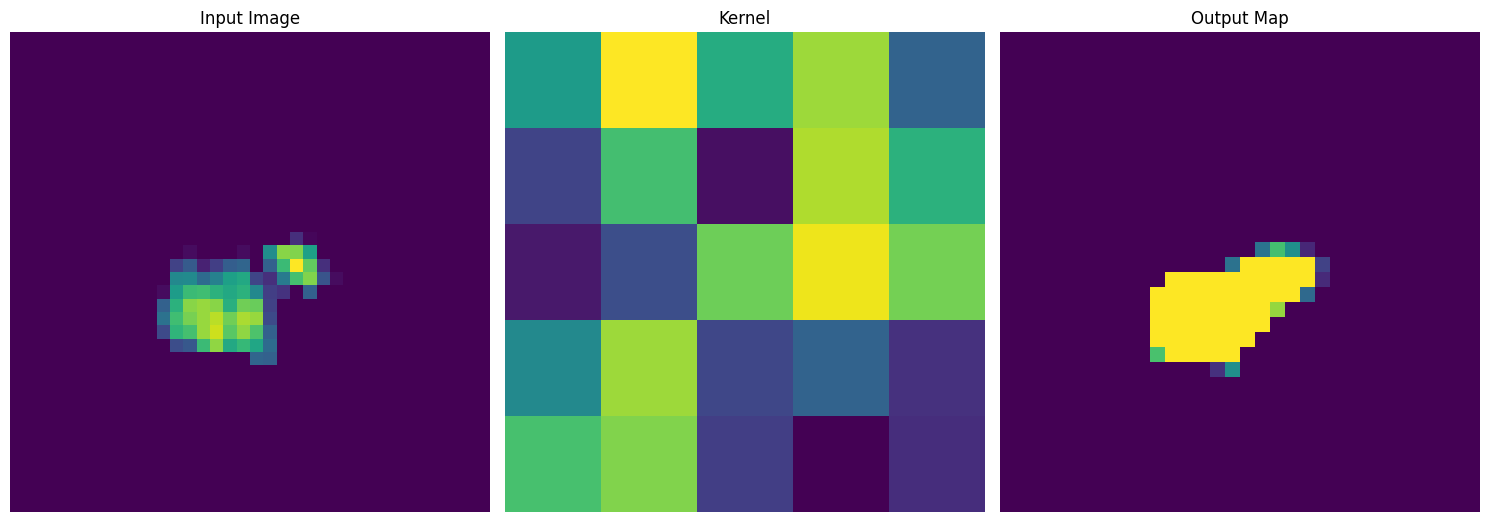

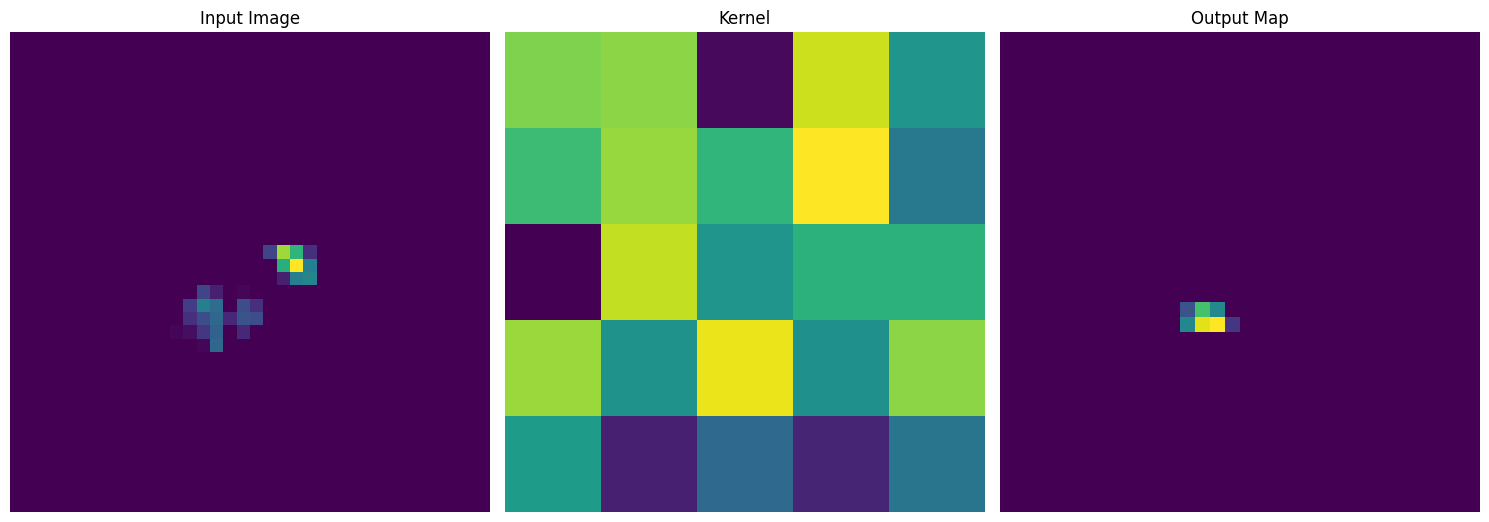

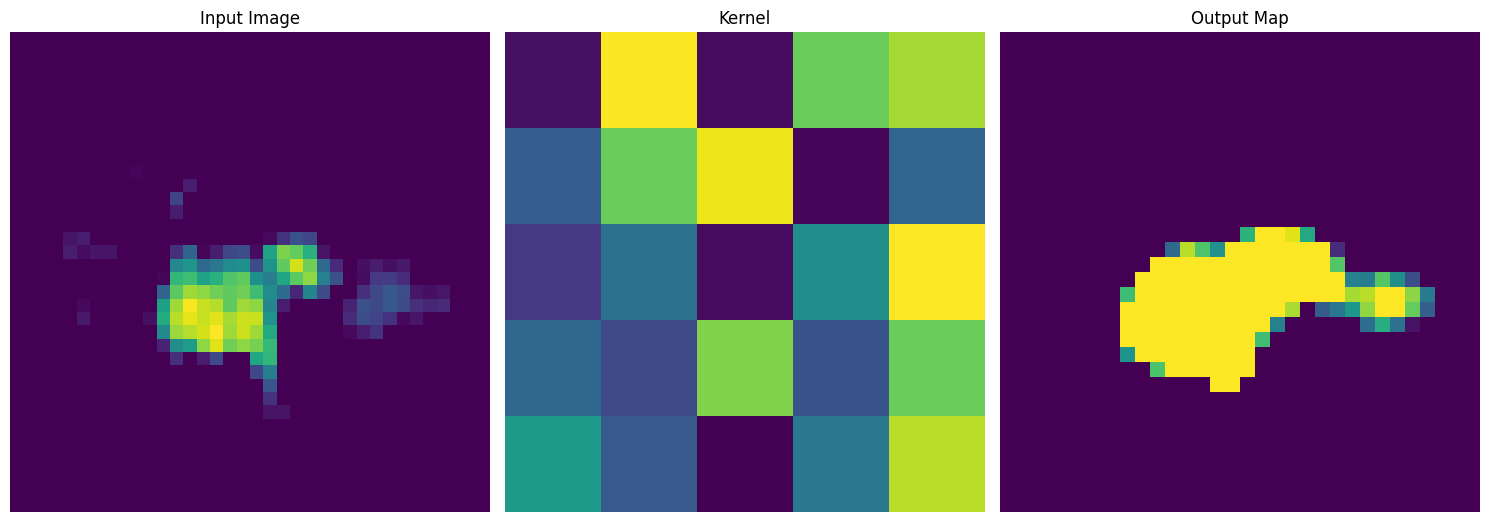

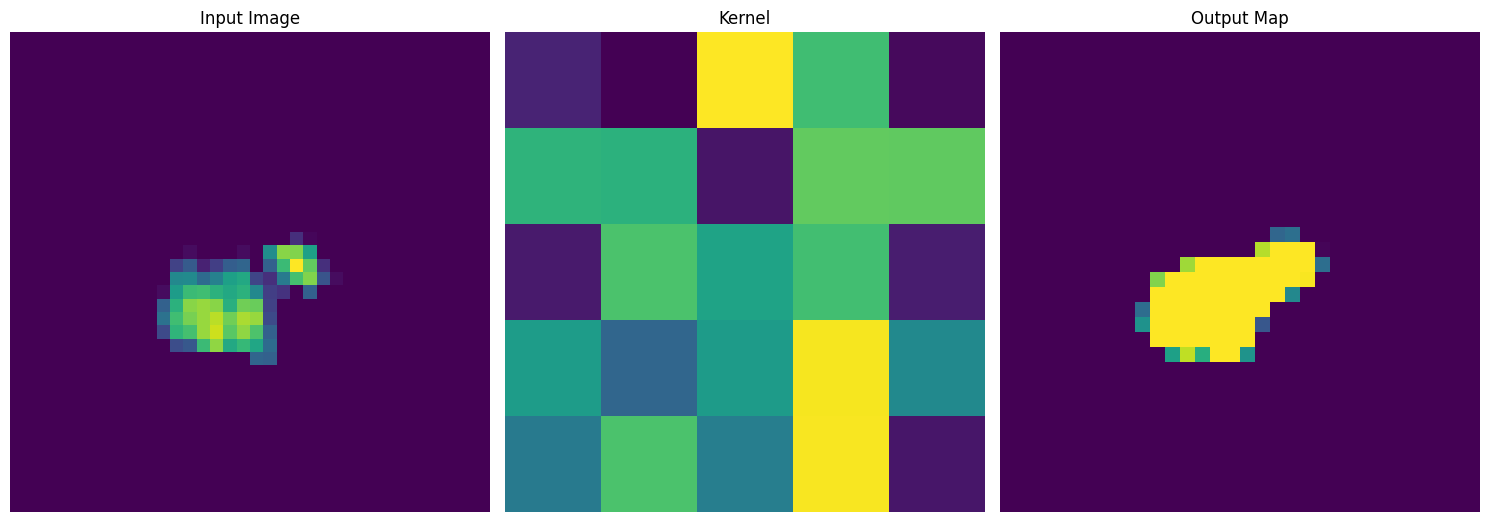

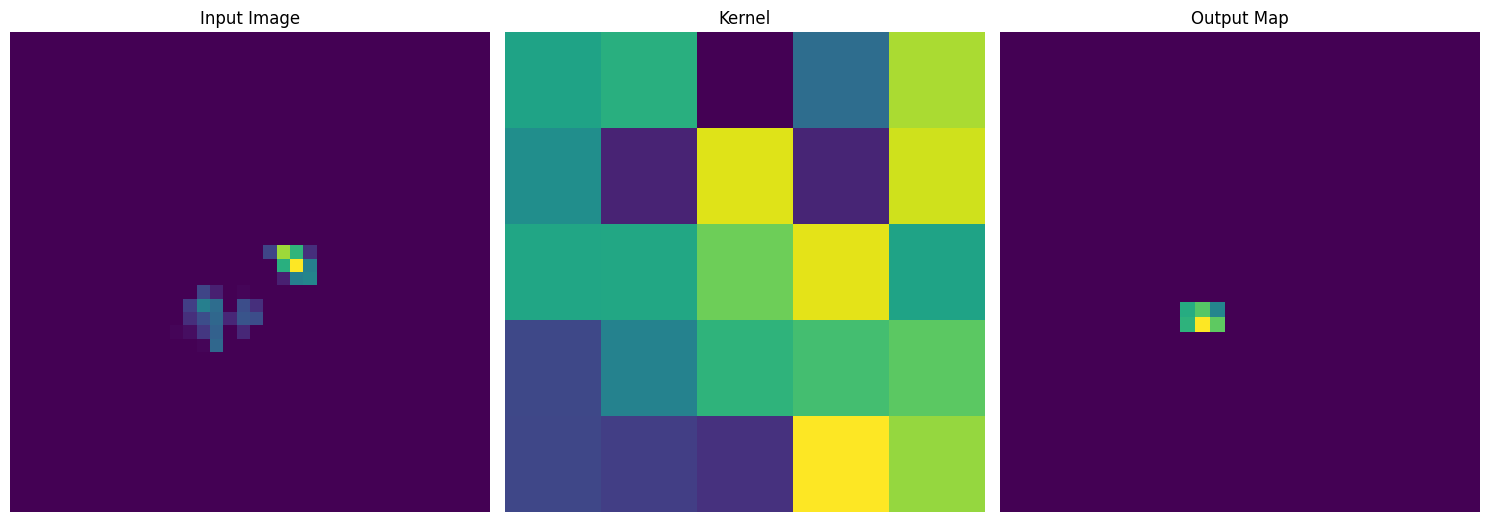

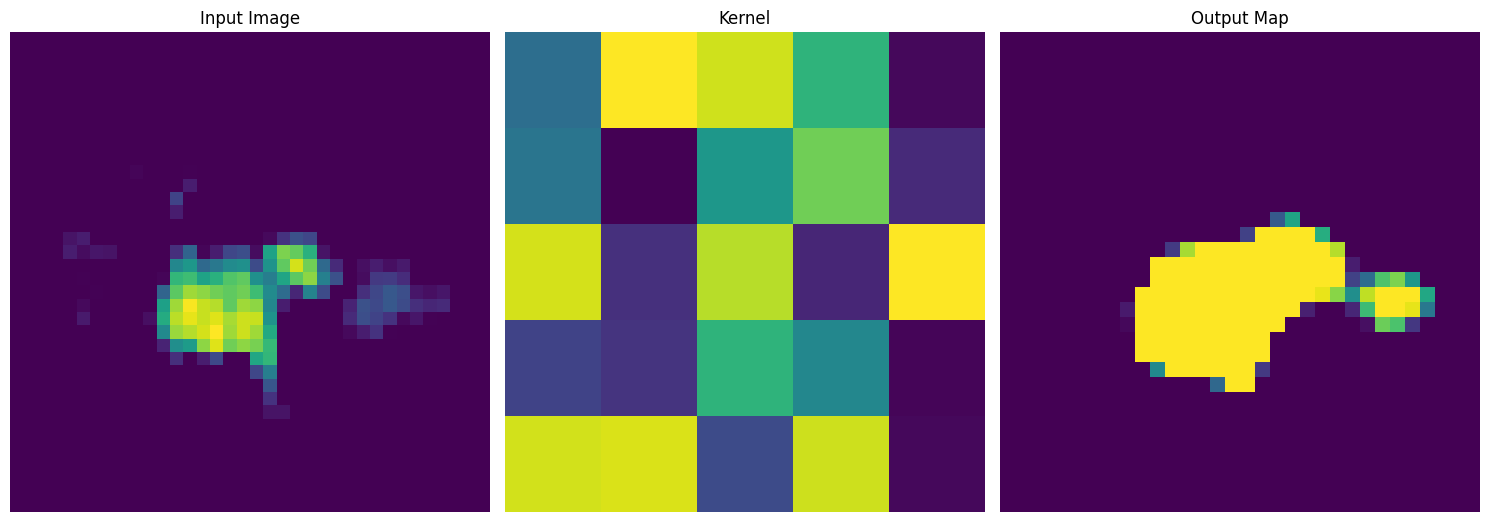

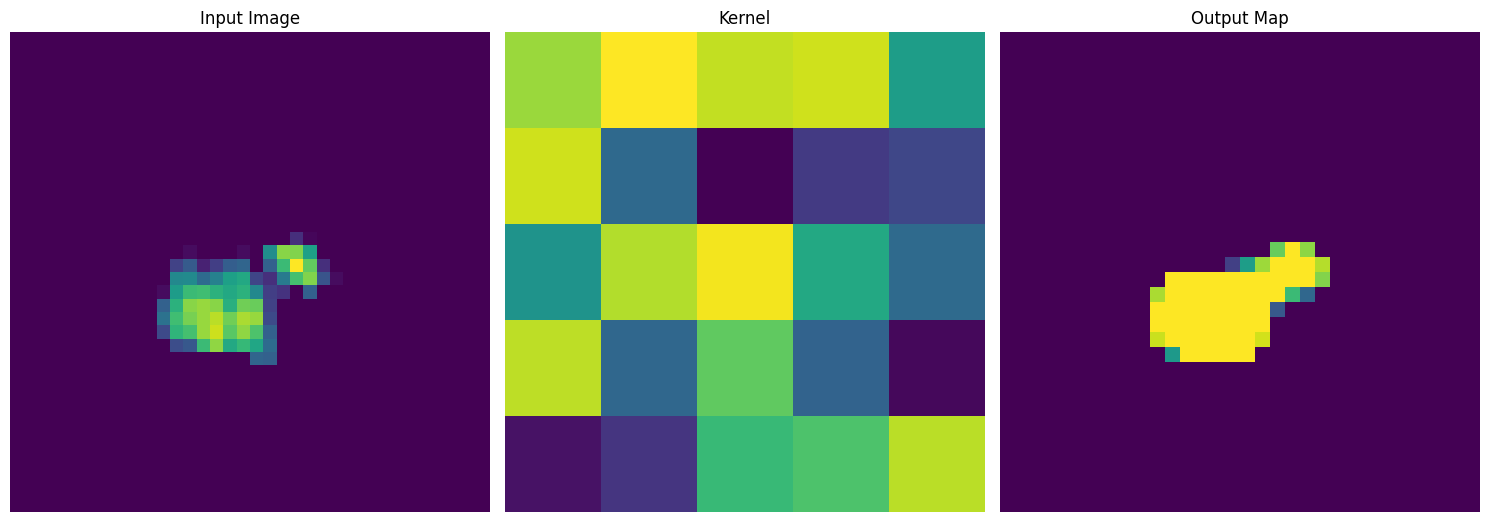

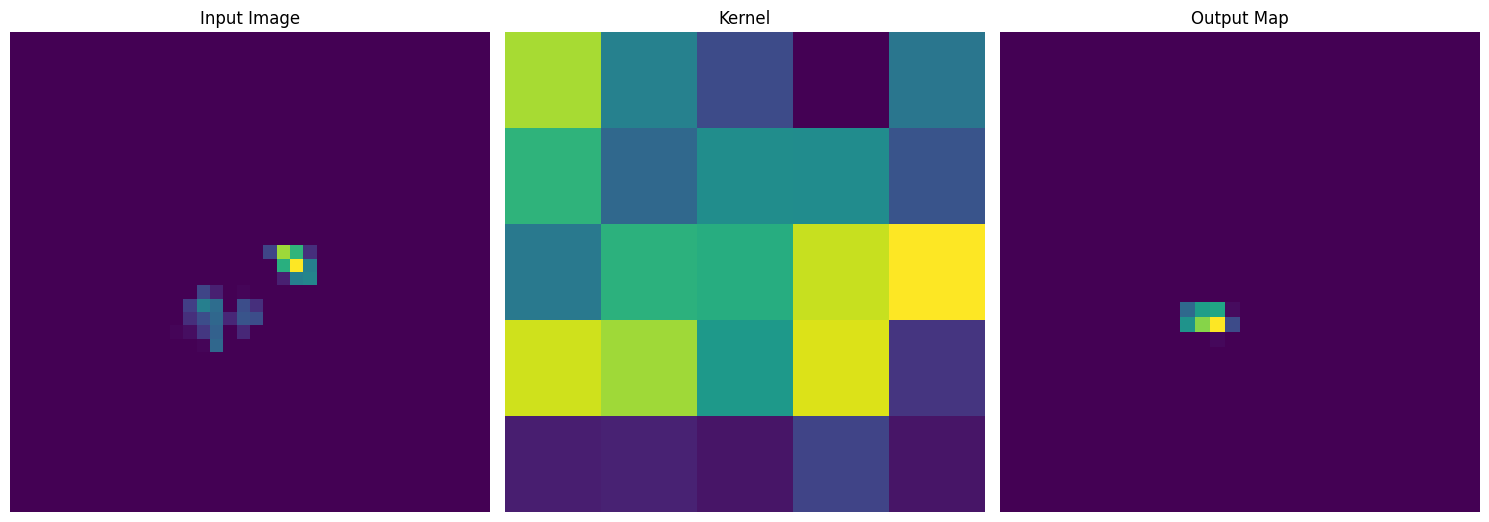

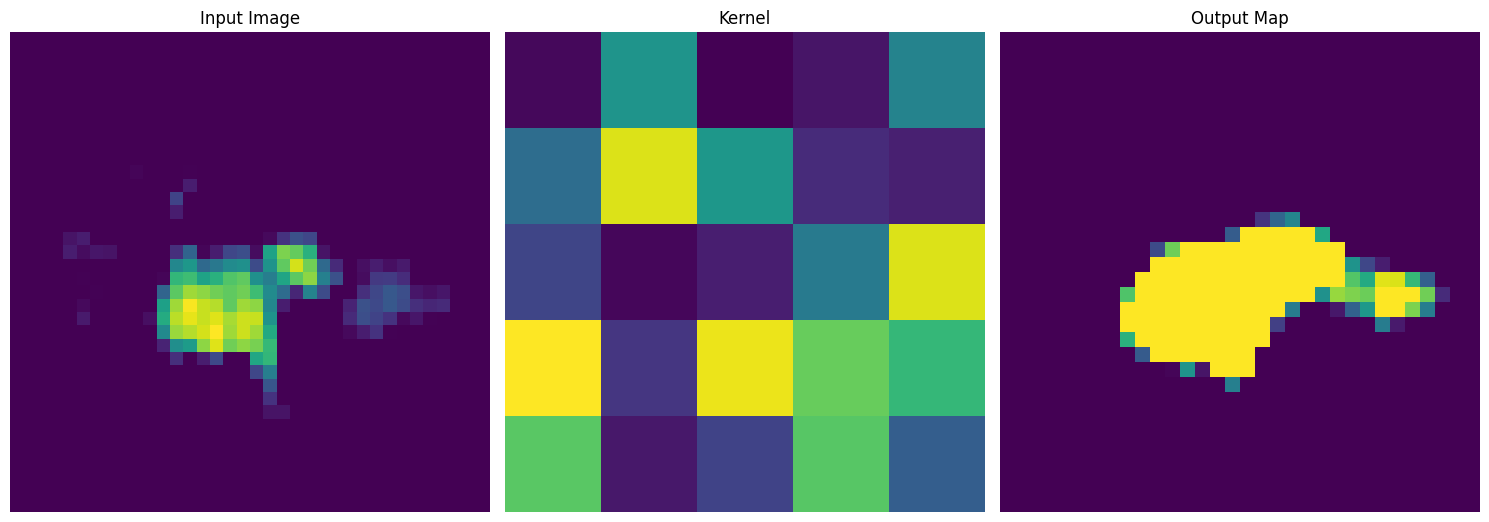

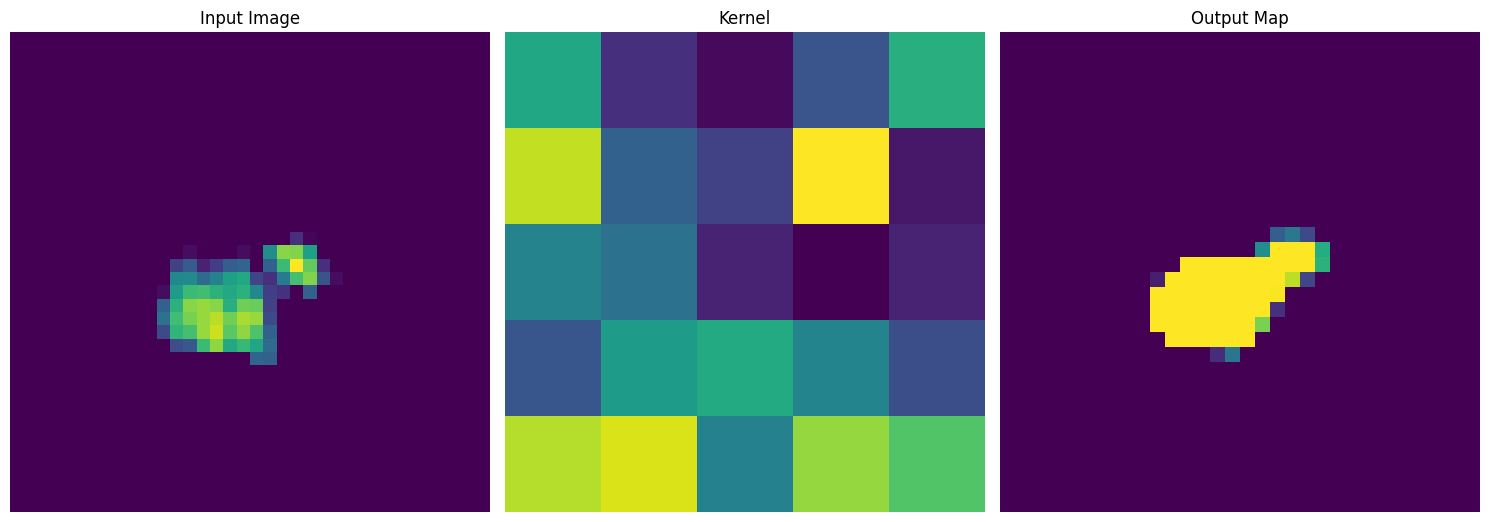

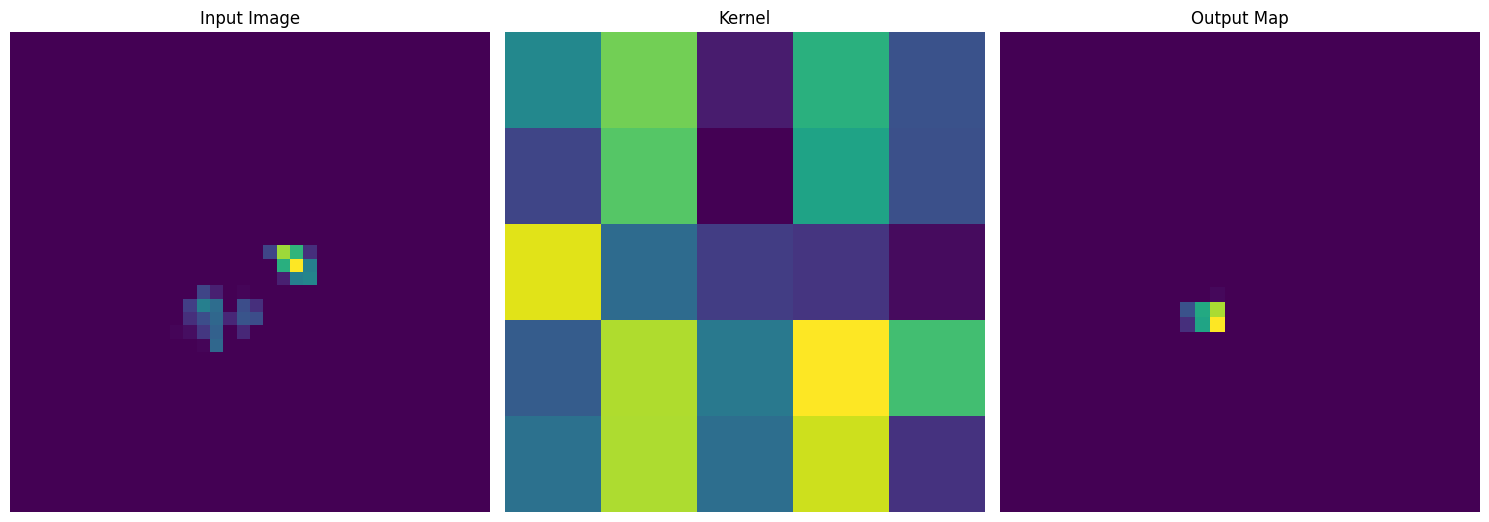

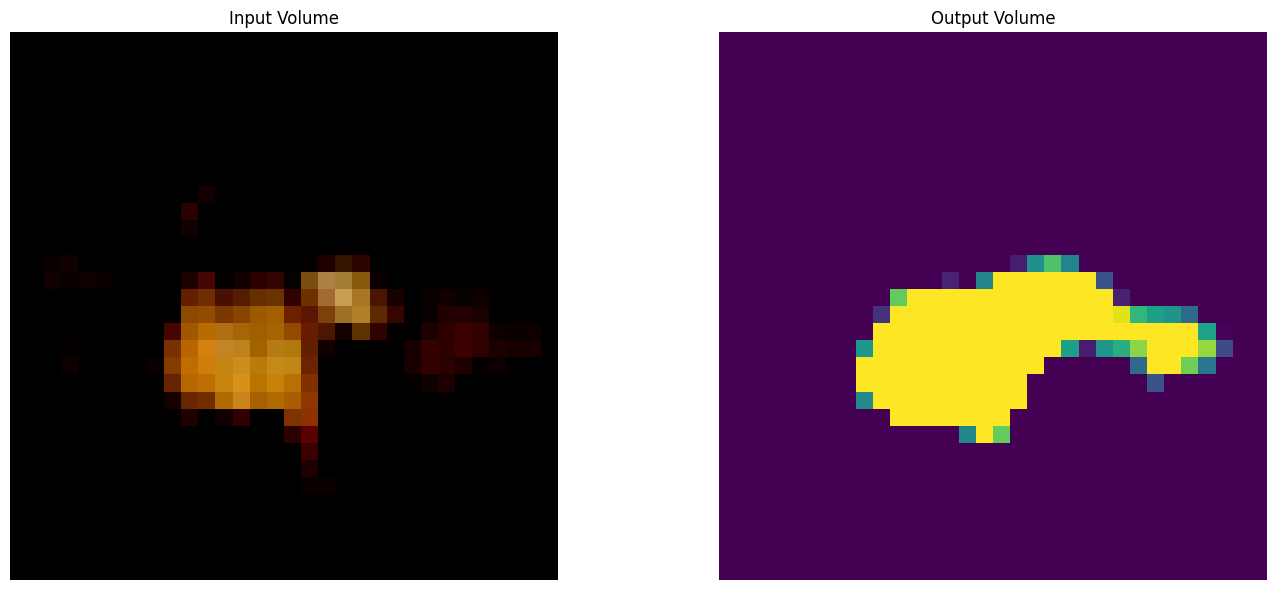

(32, 32, 4)


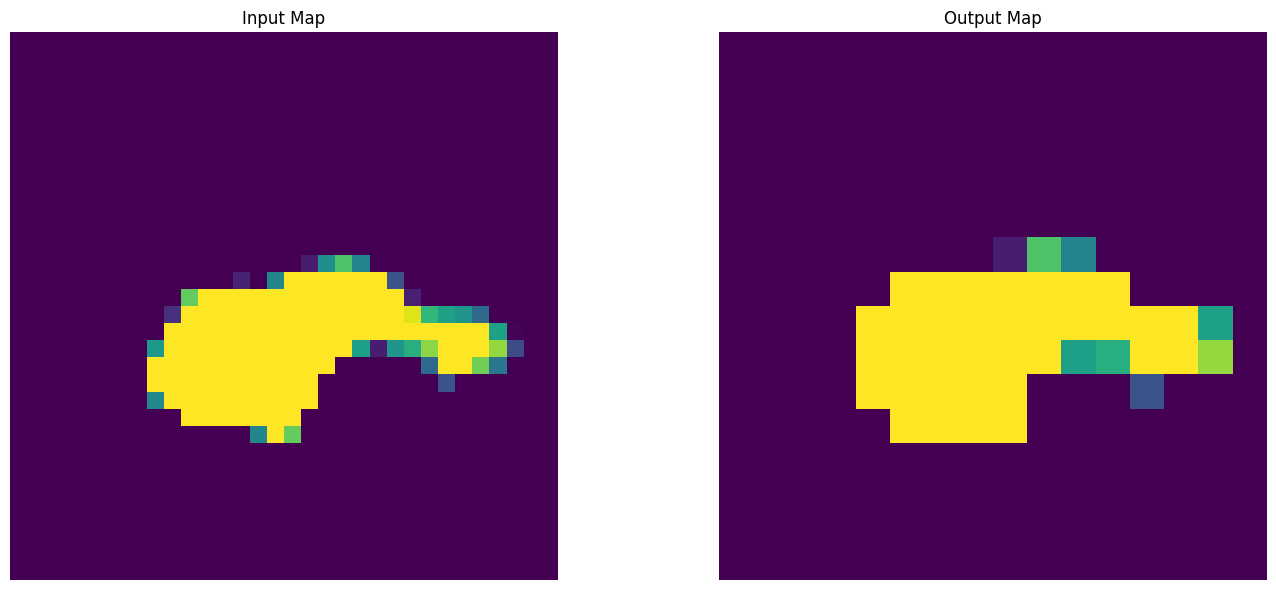

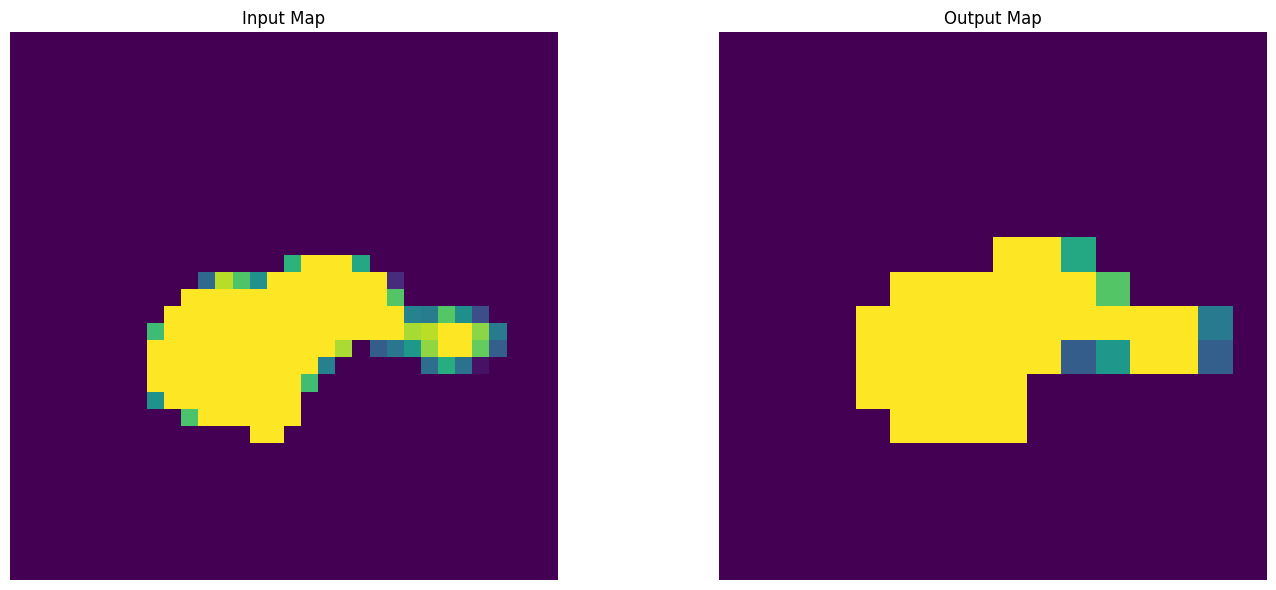

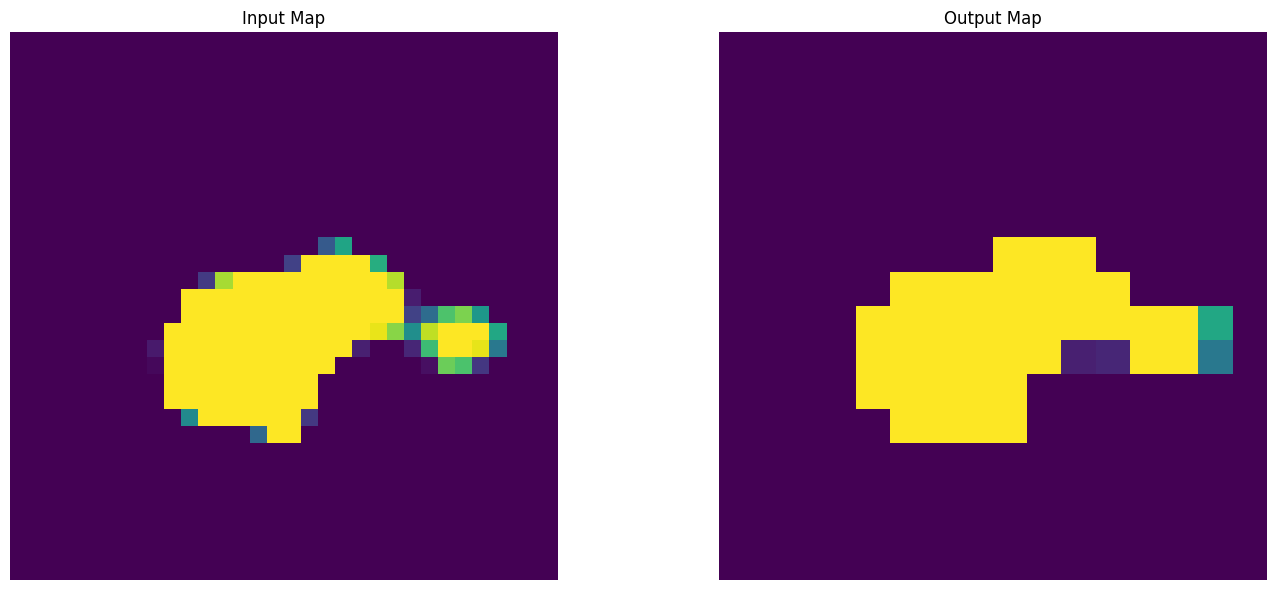

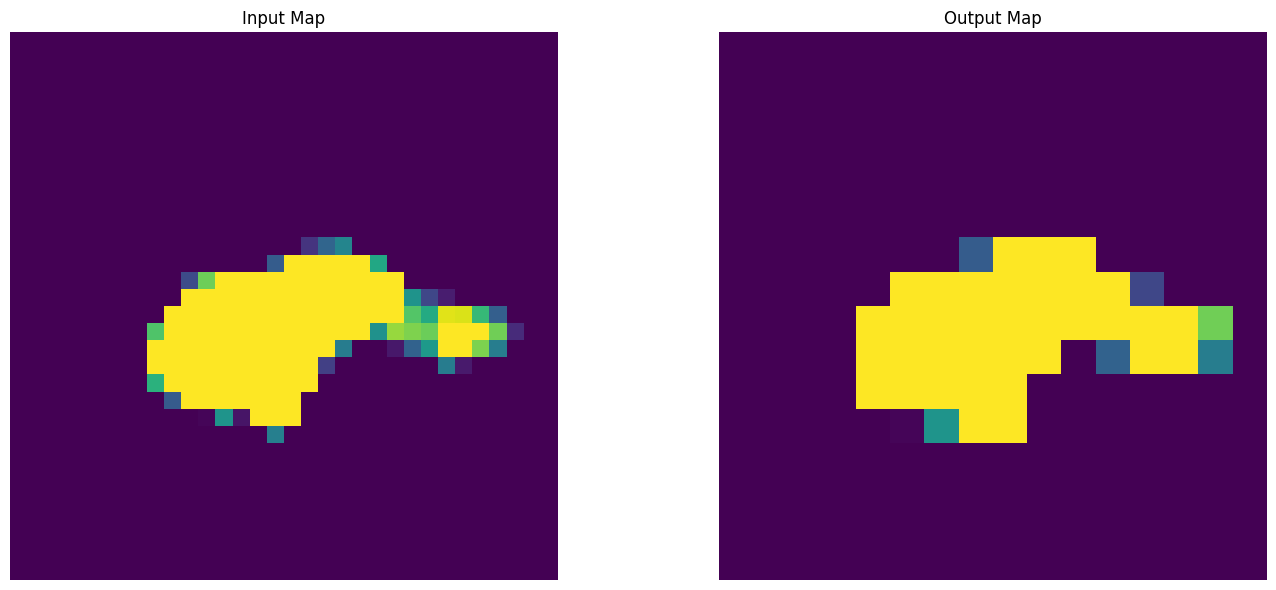

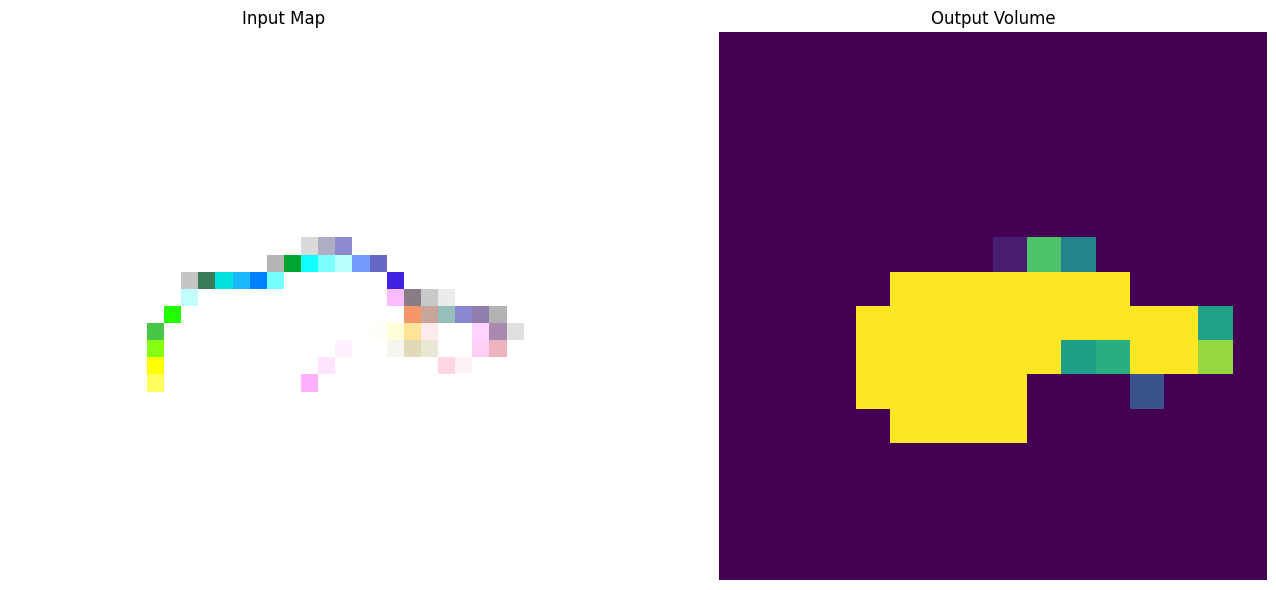

(16, 16, 4)


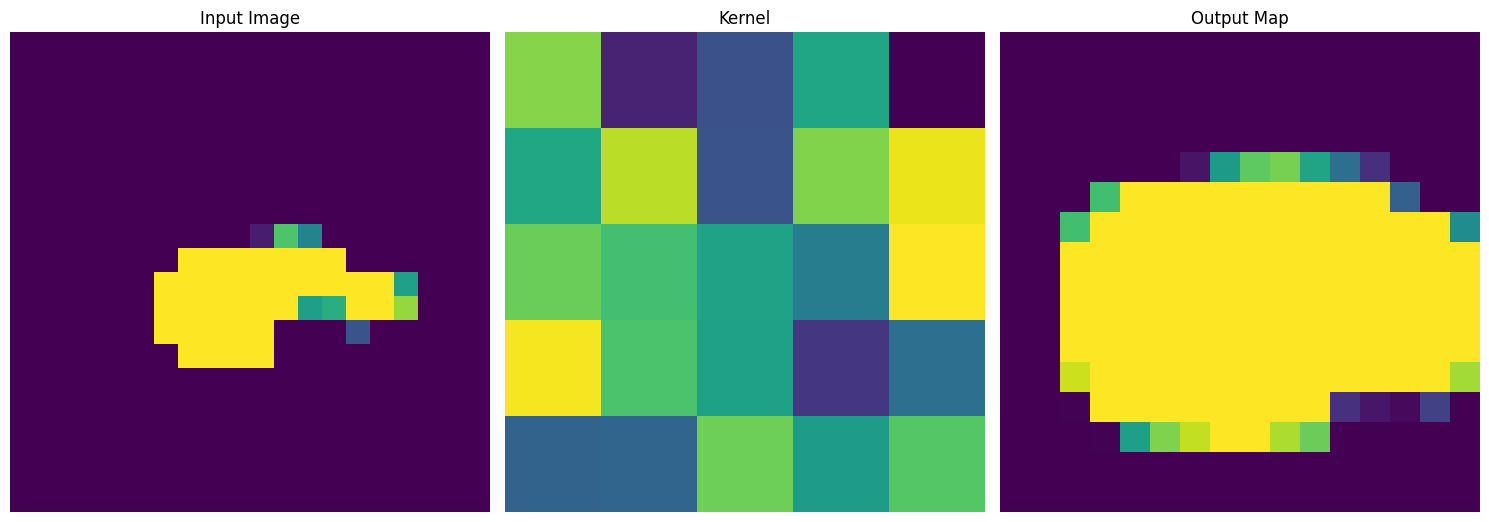

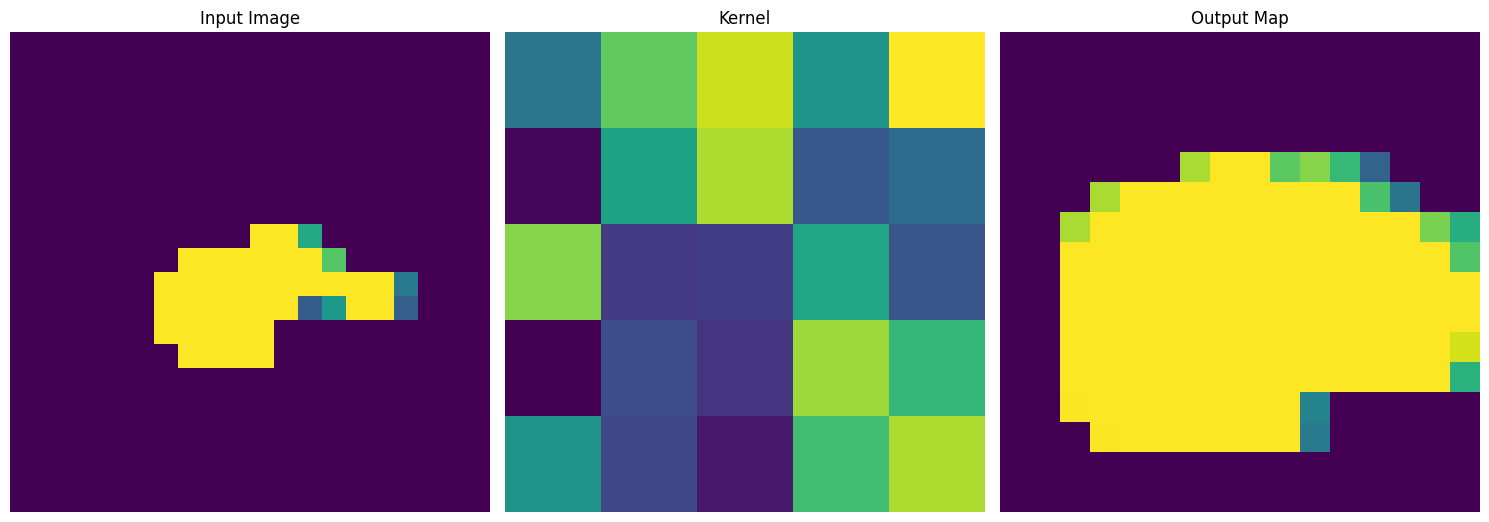

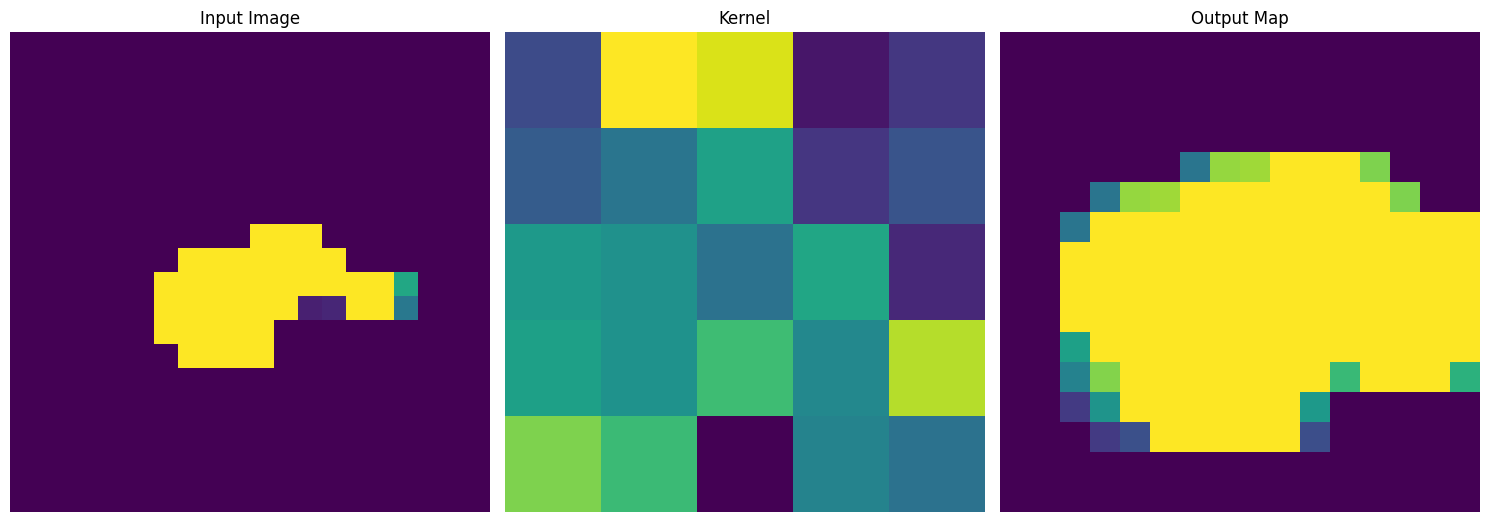

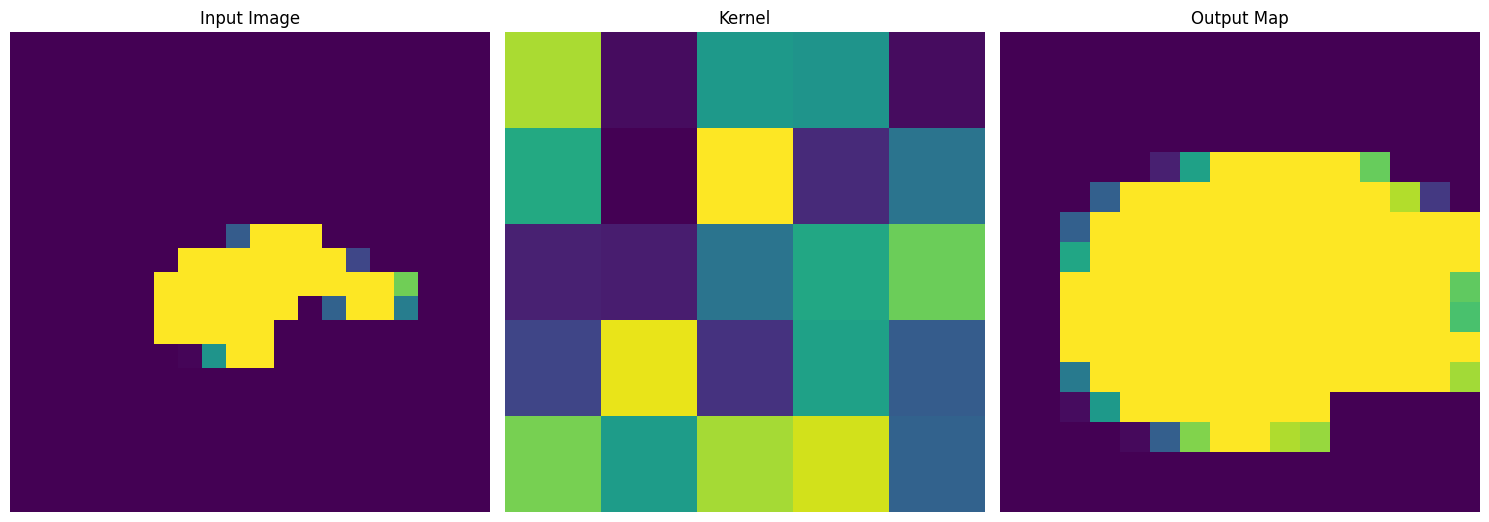

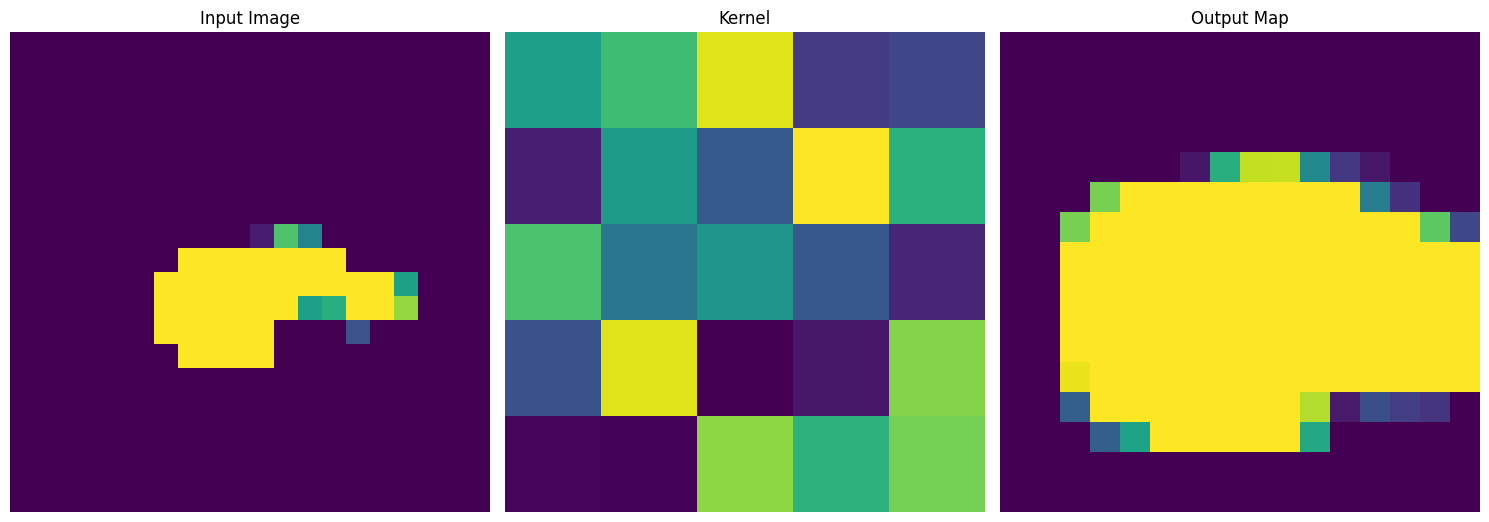

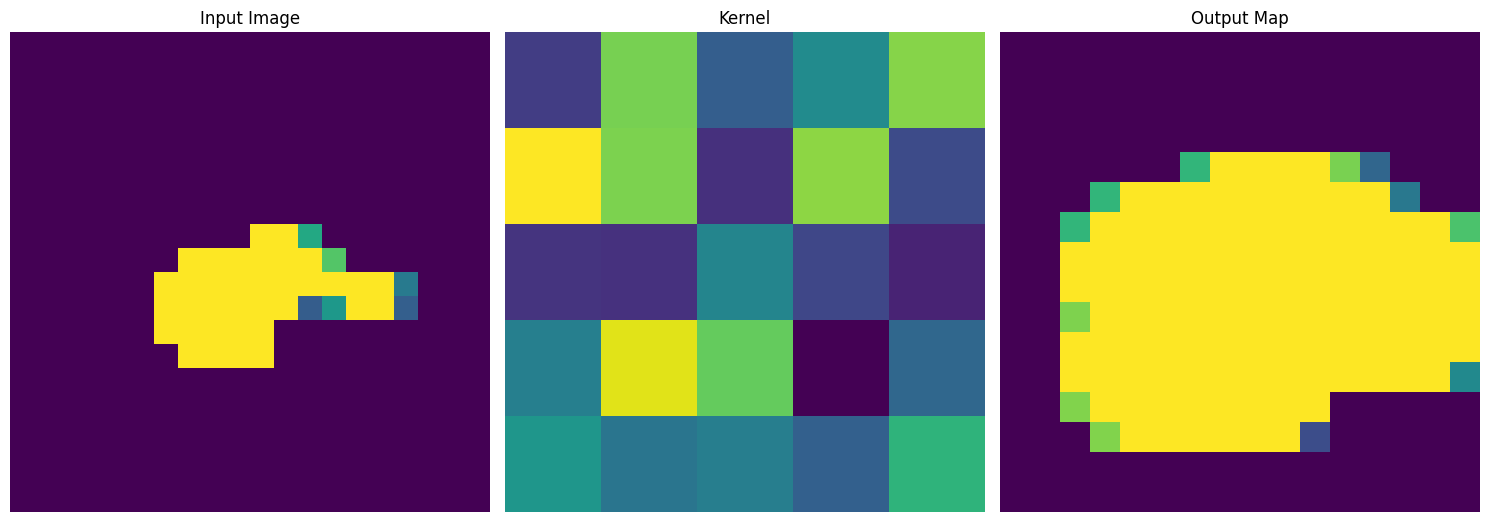

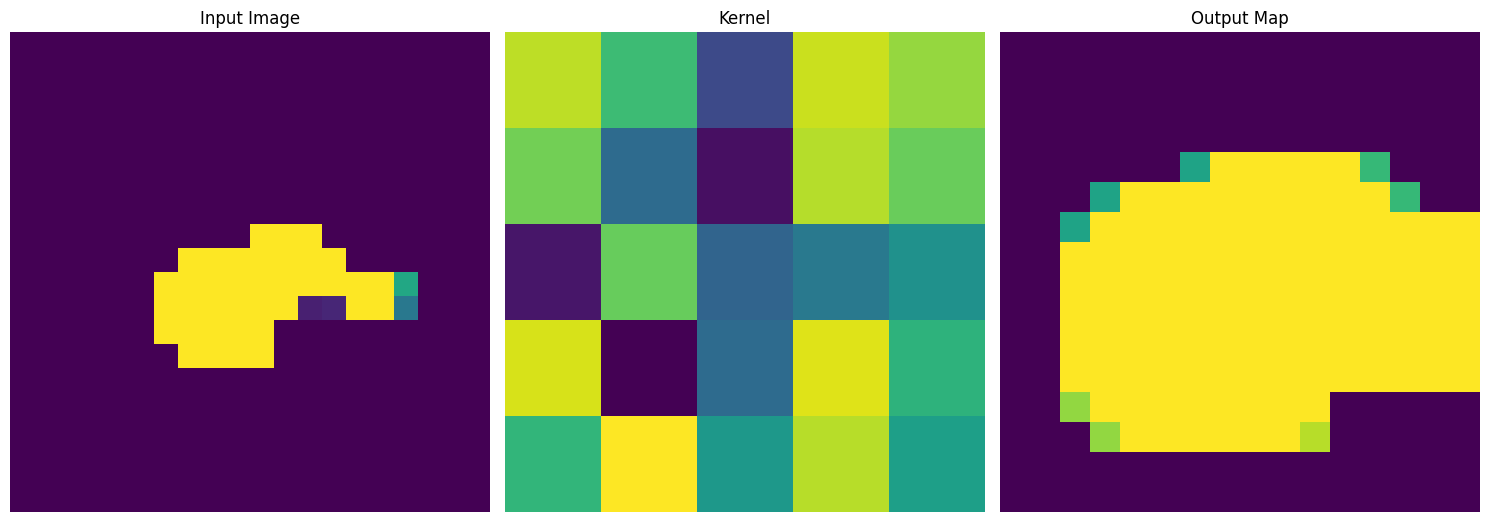

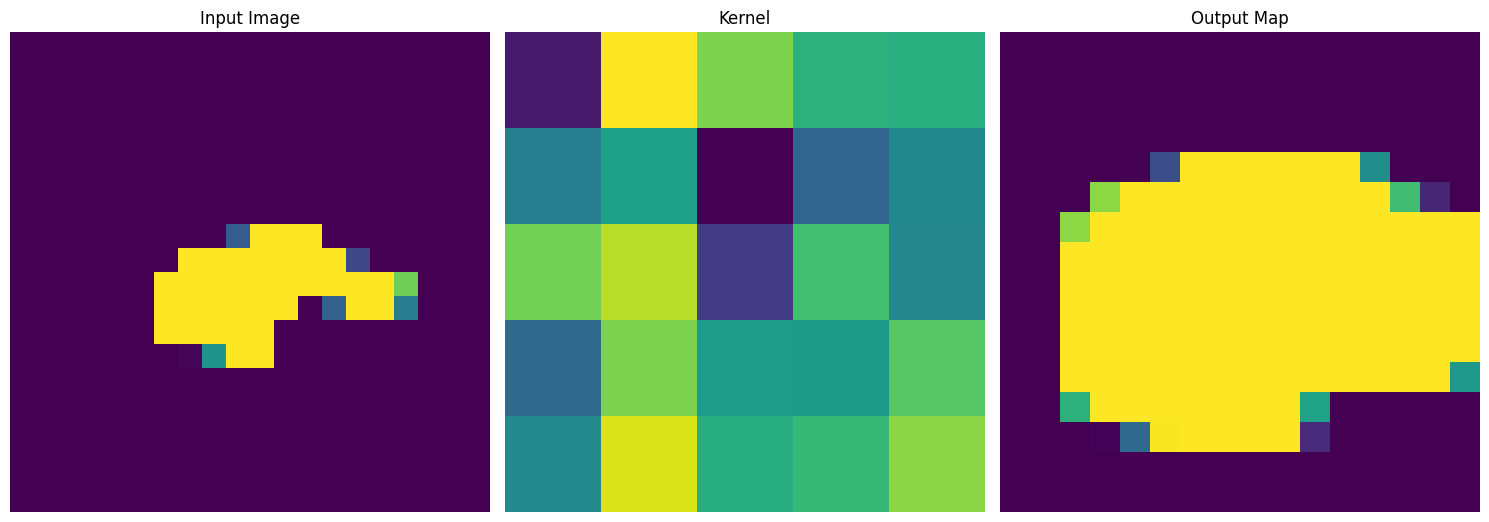

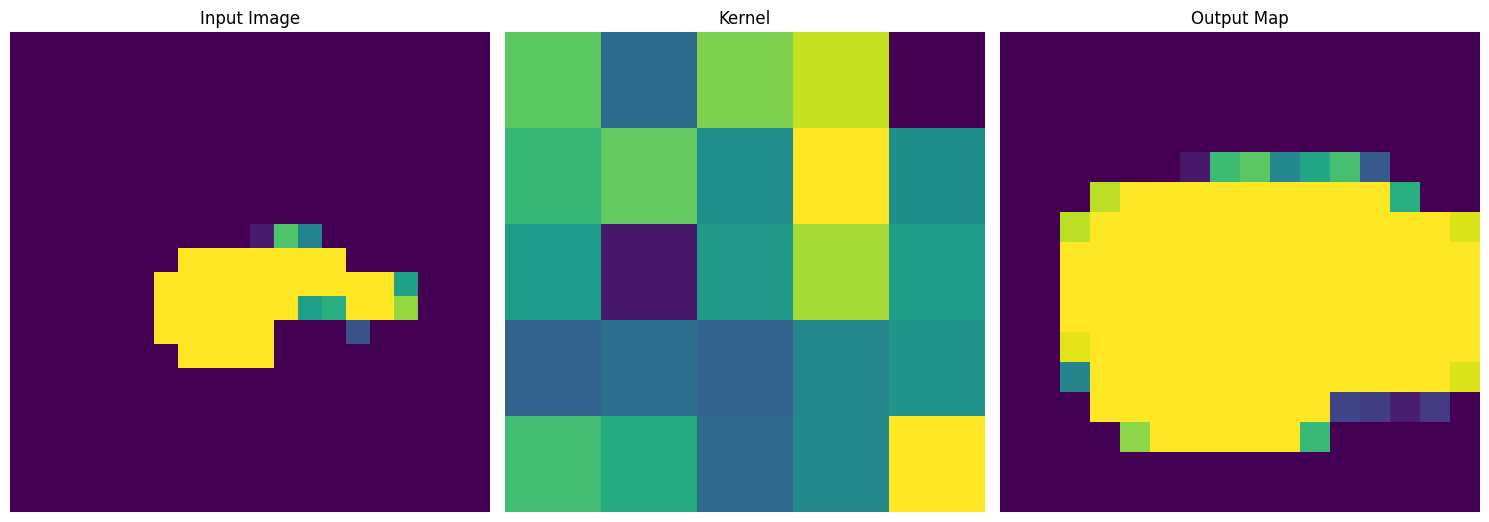

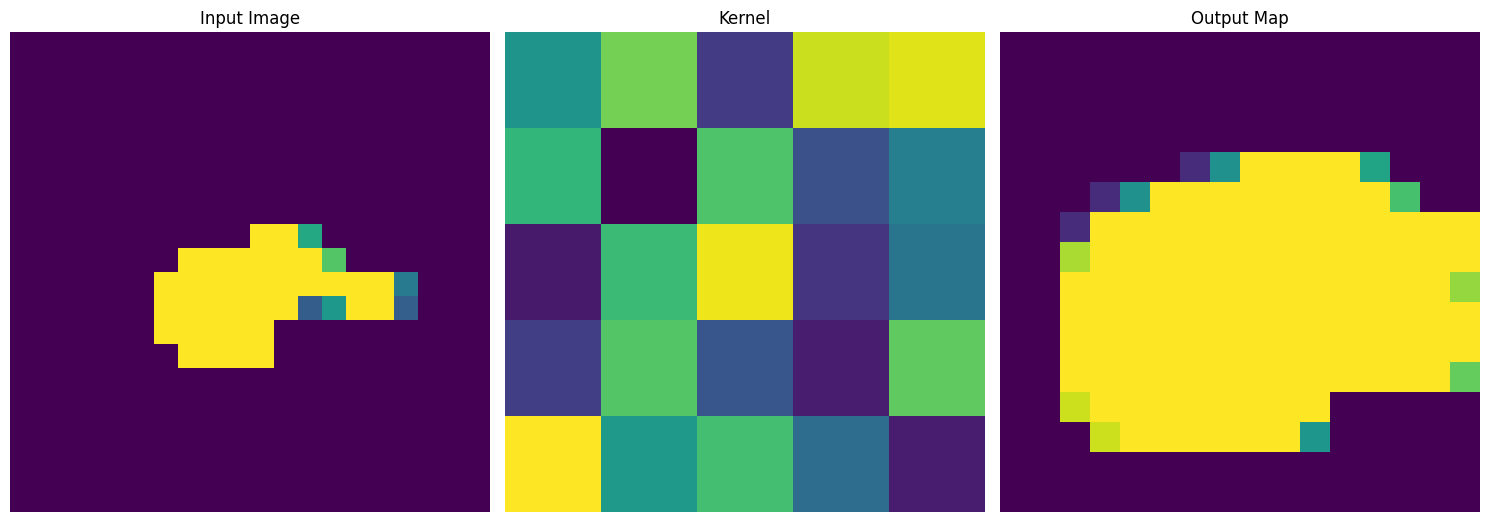

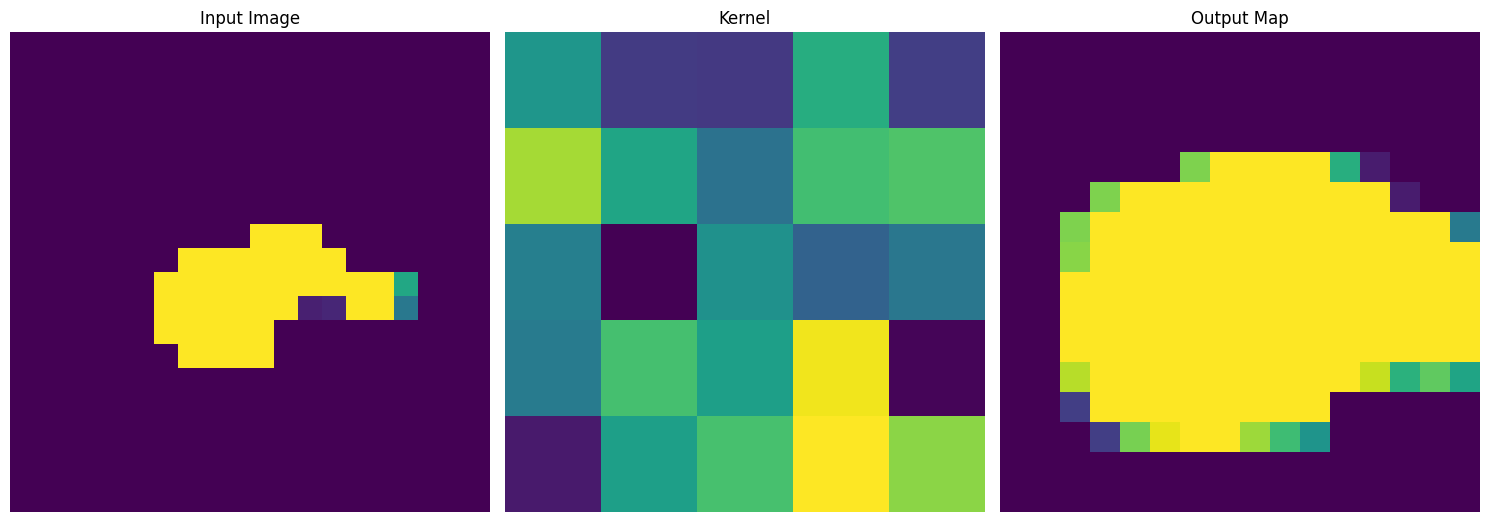

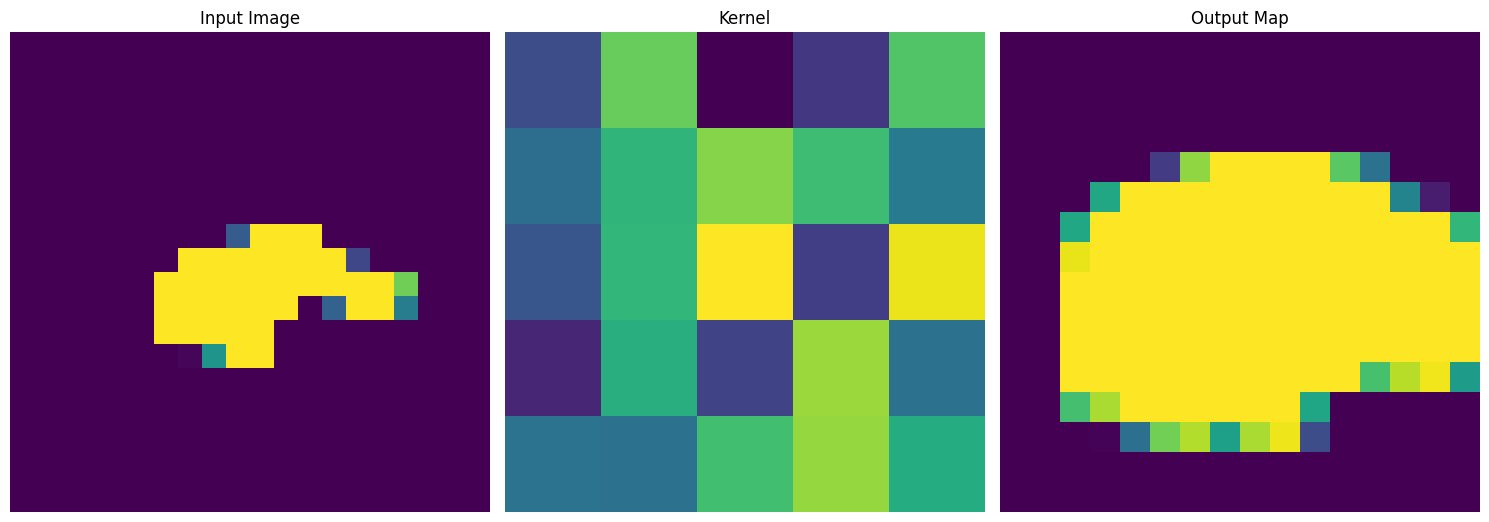

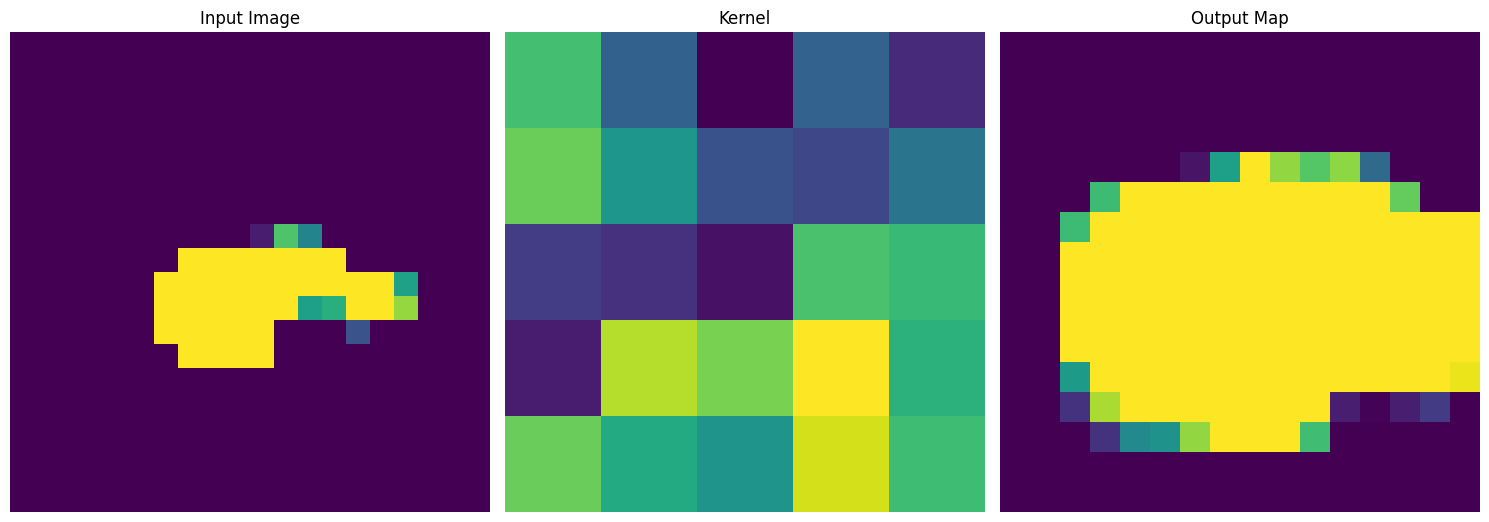

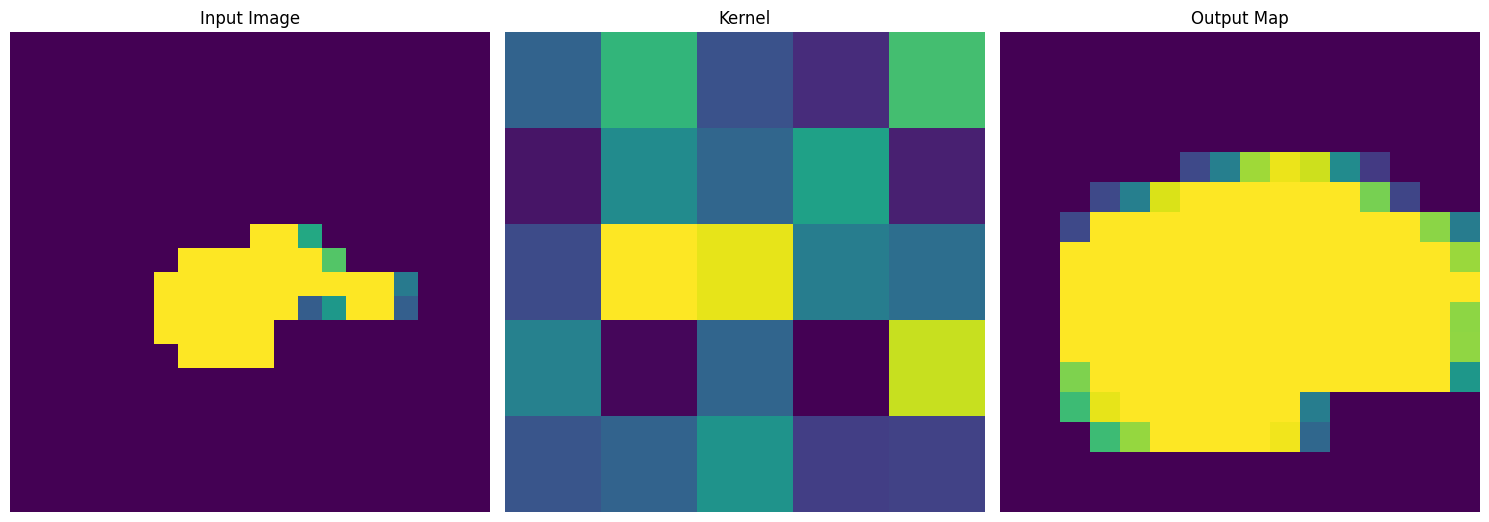

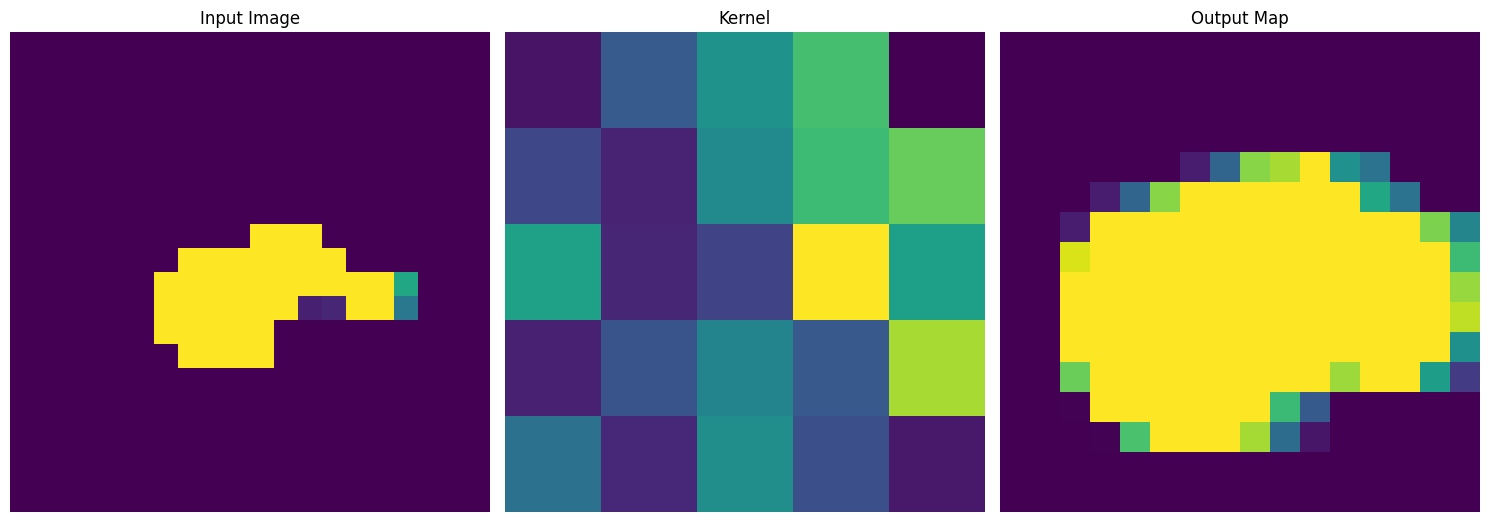

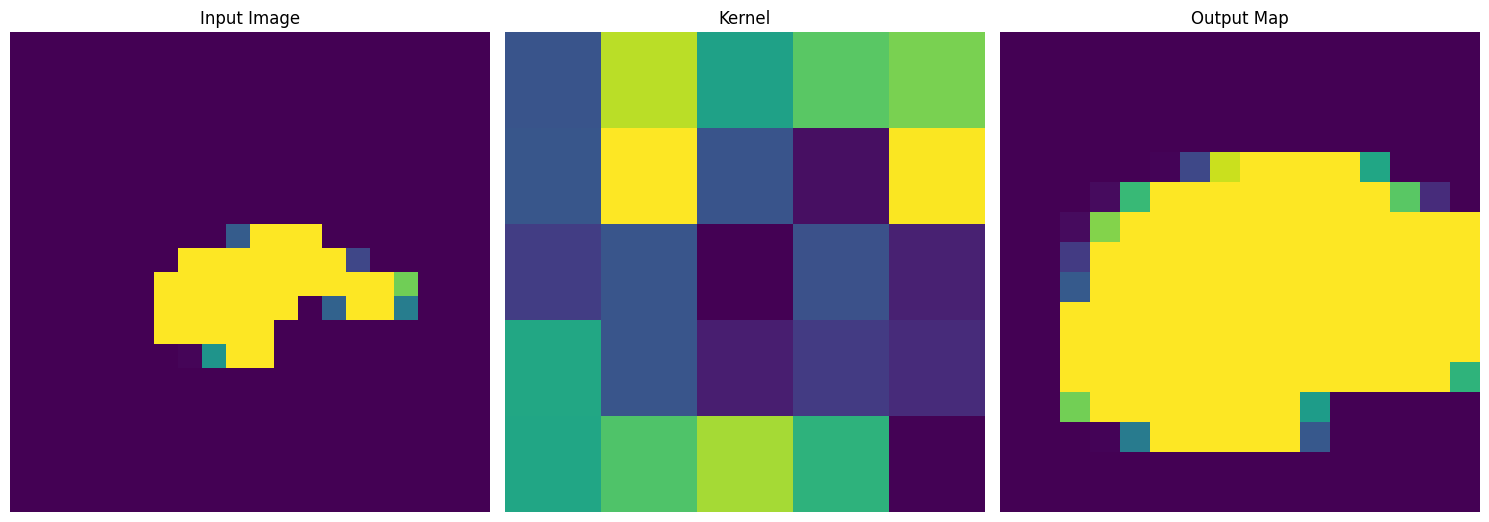

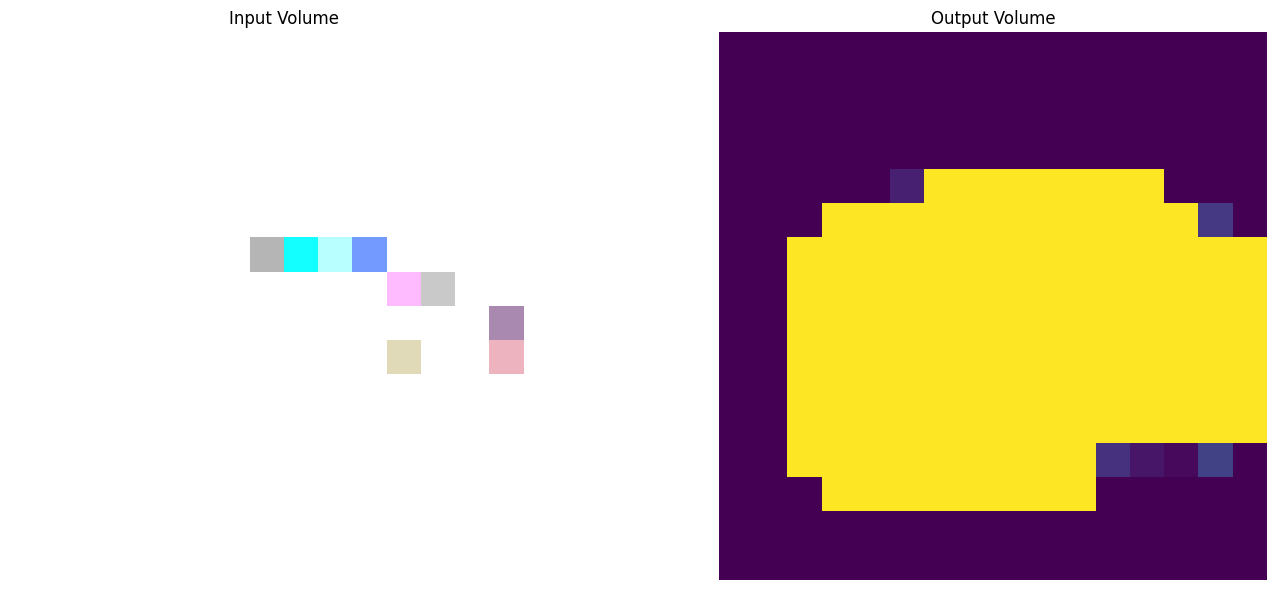

(16, 16, 4)


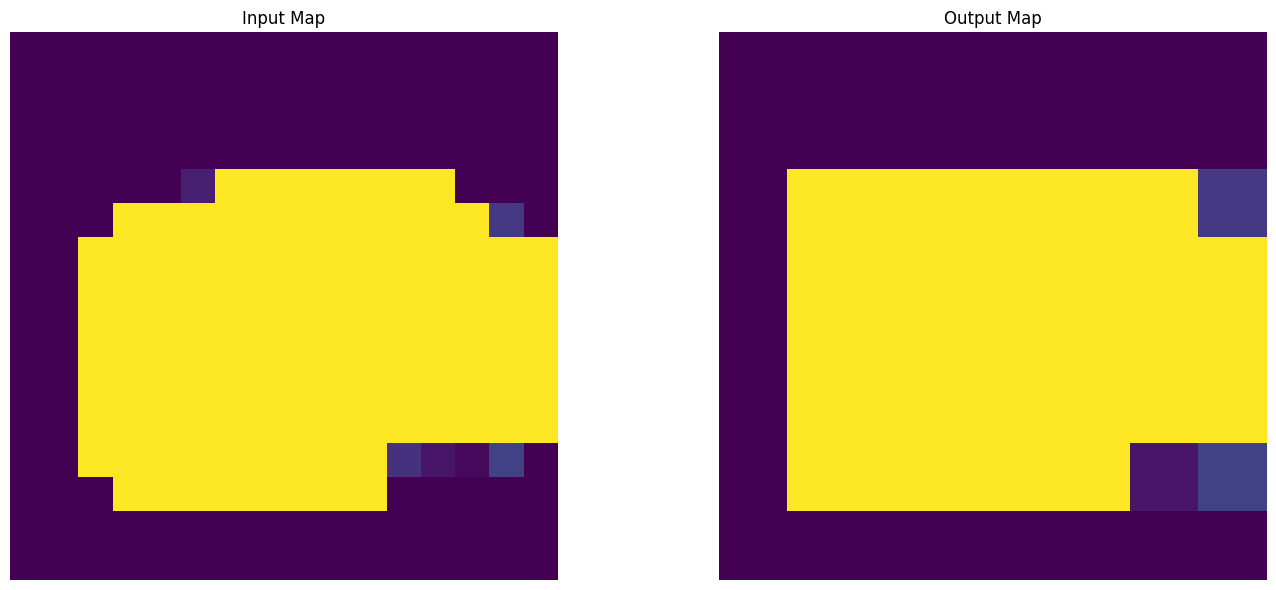

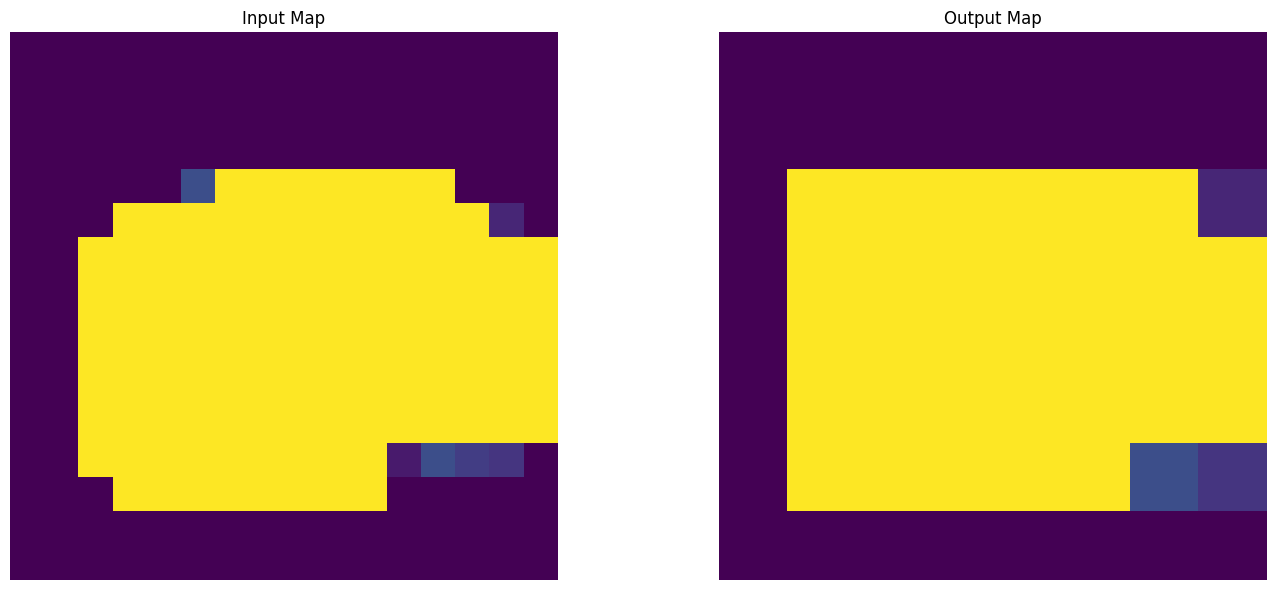

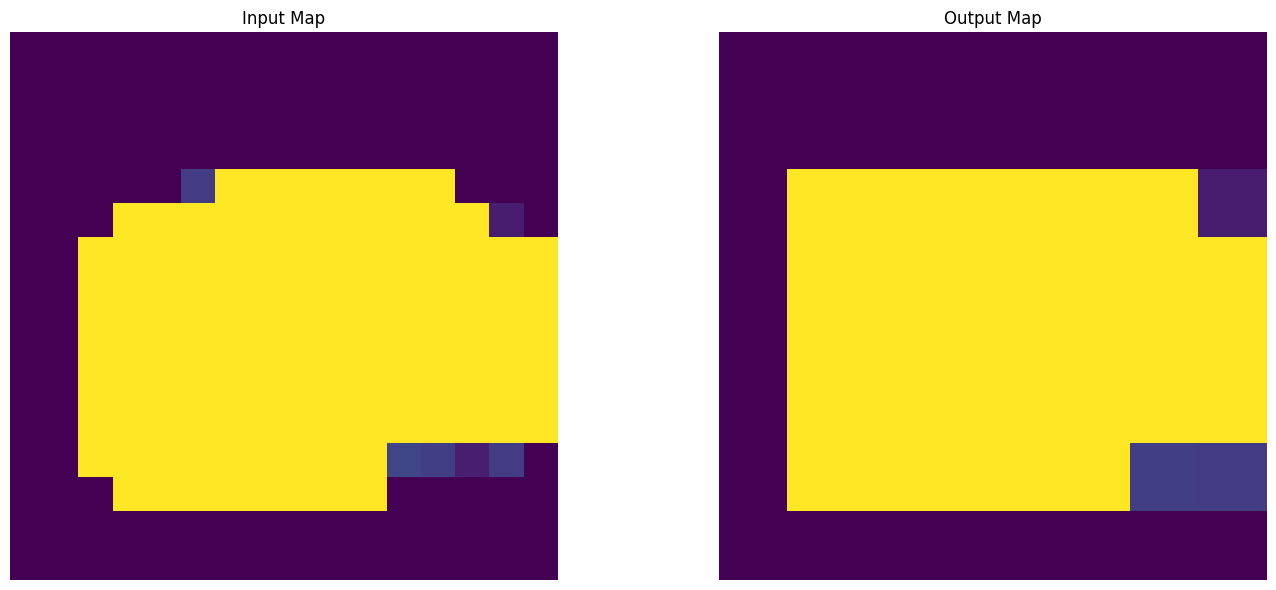

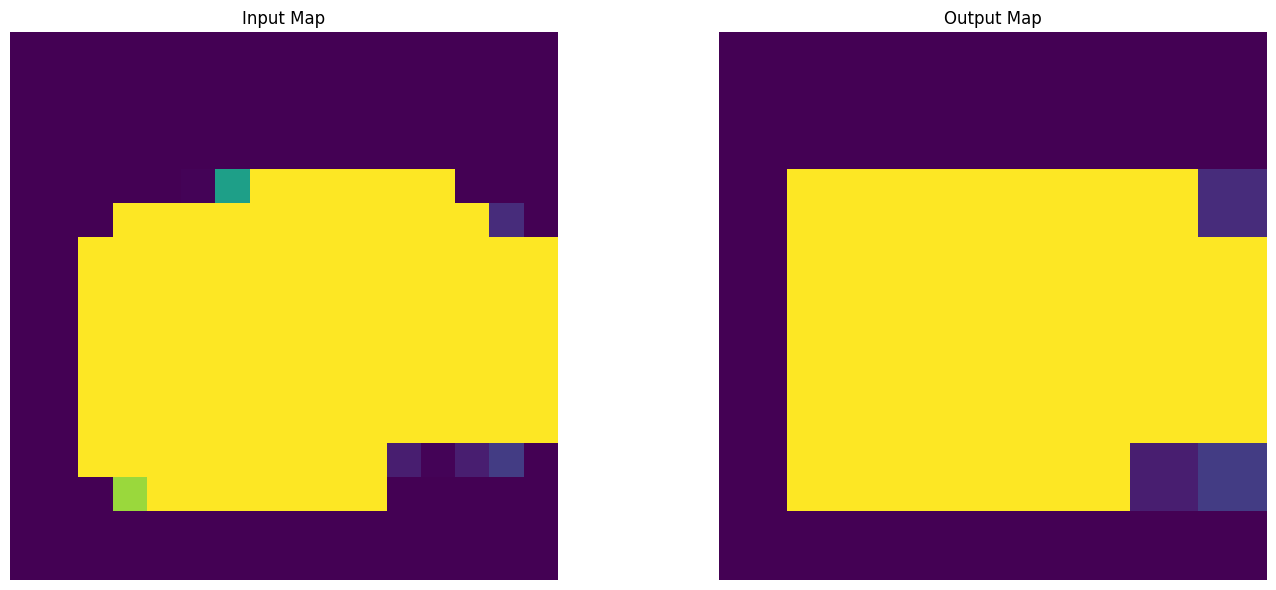

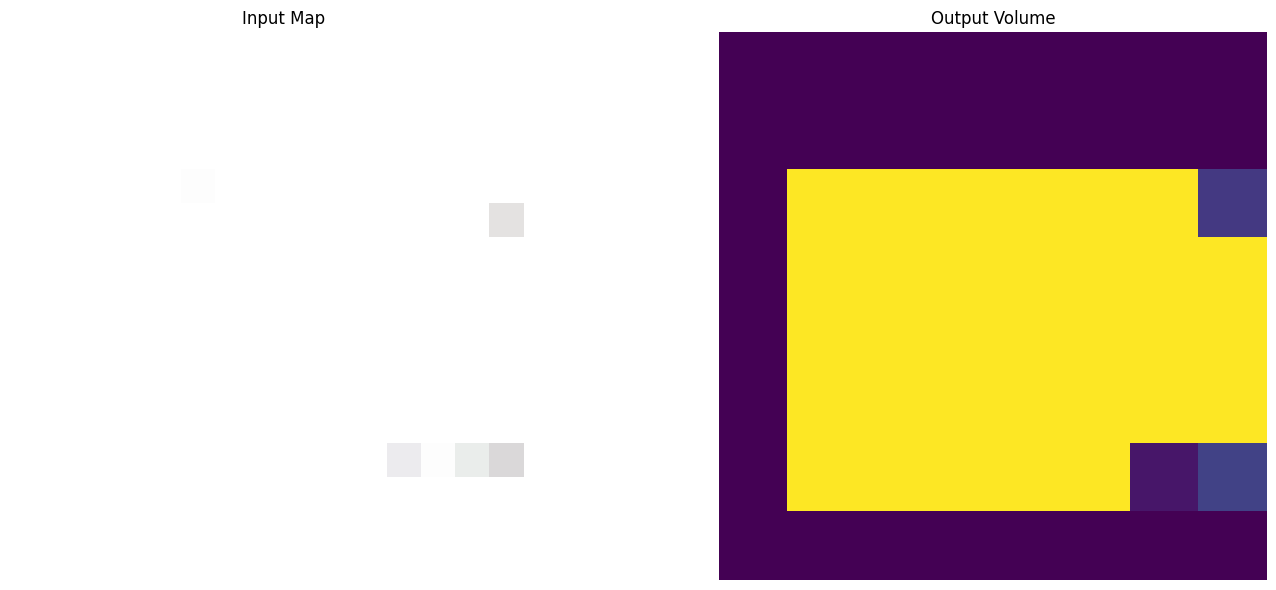

(8, 8, 4)


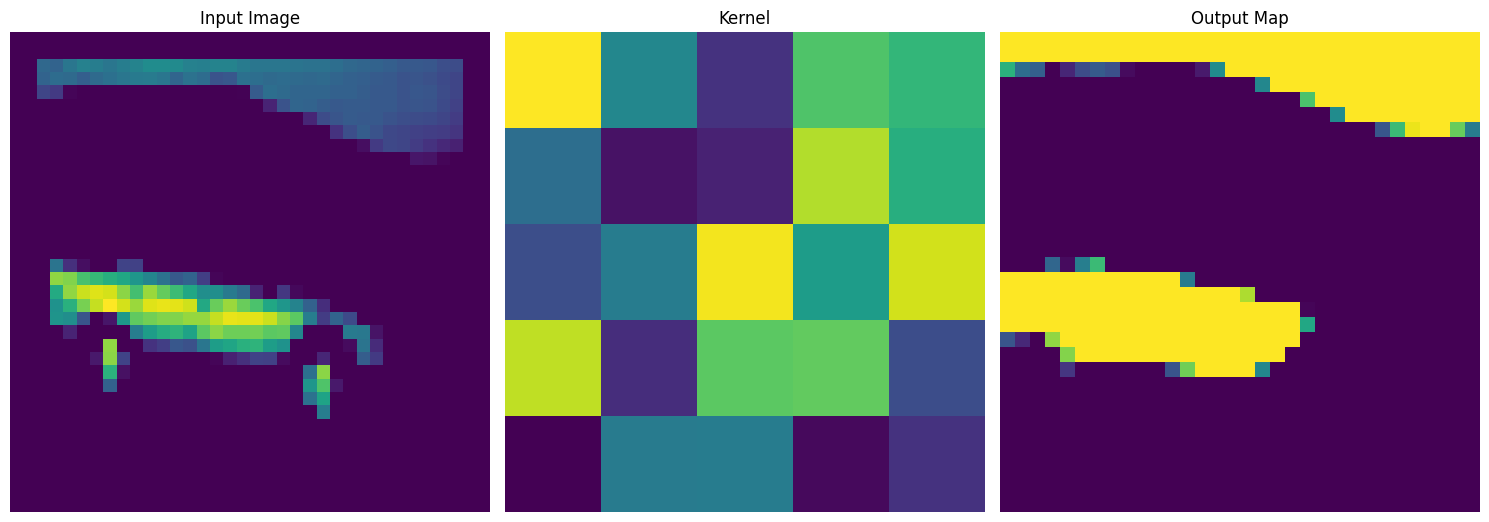

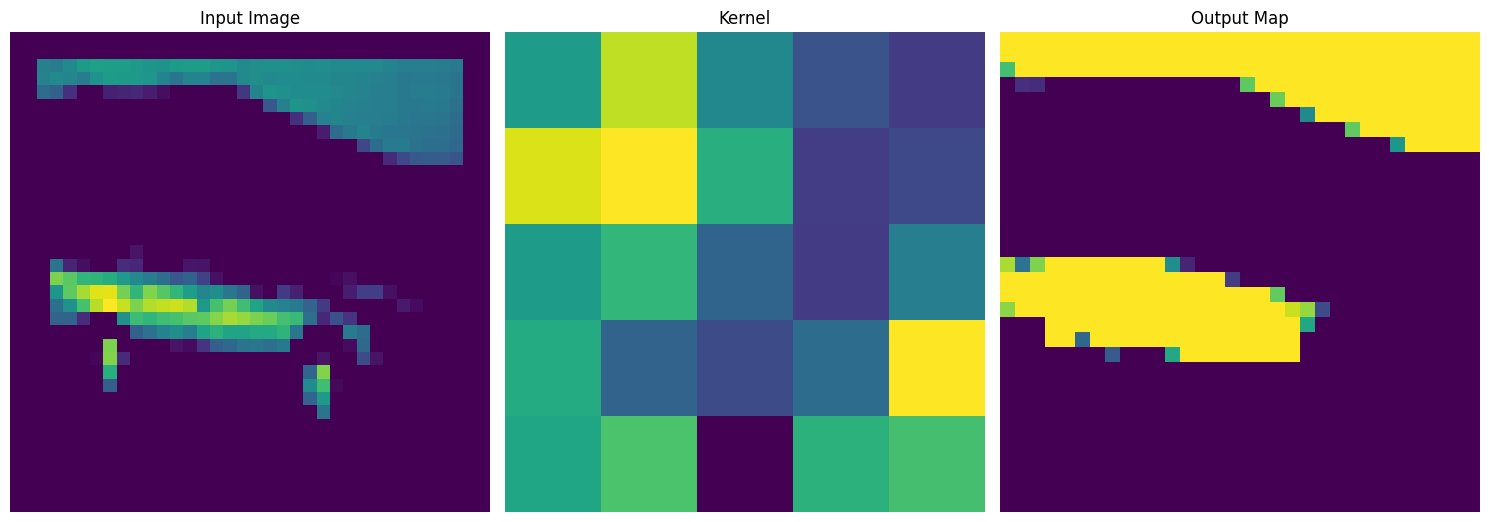

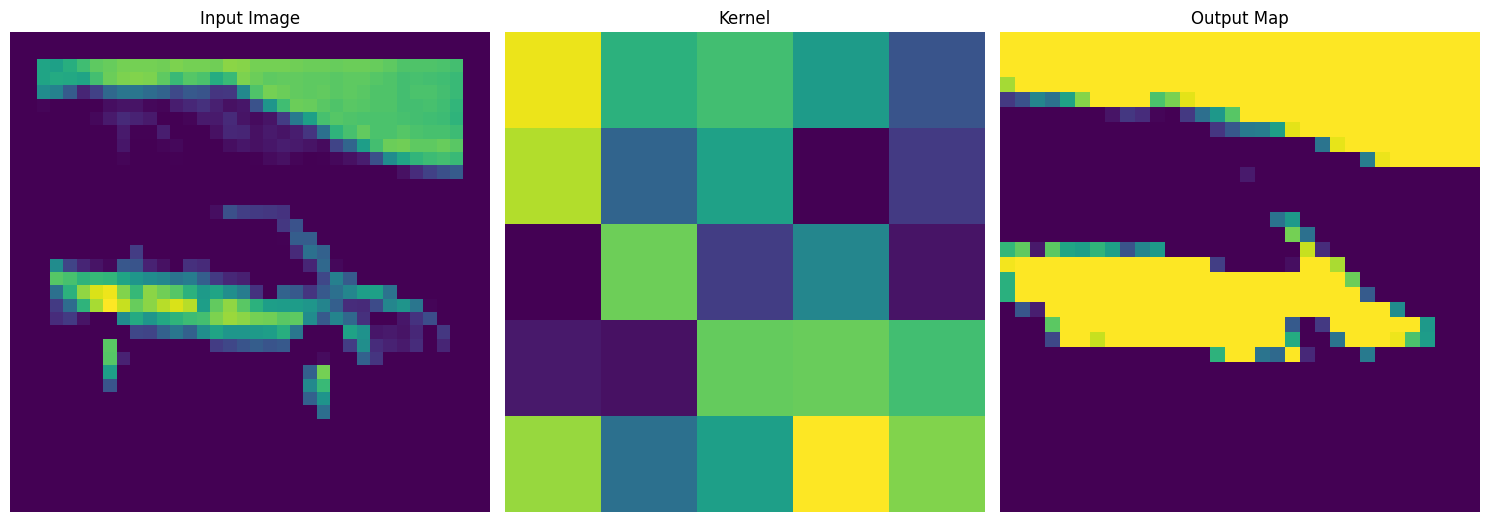

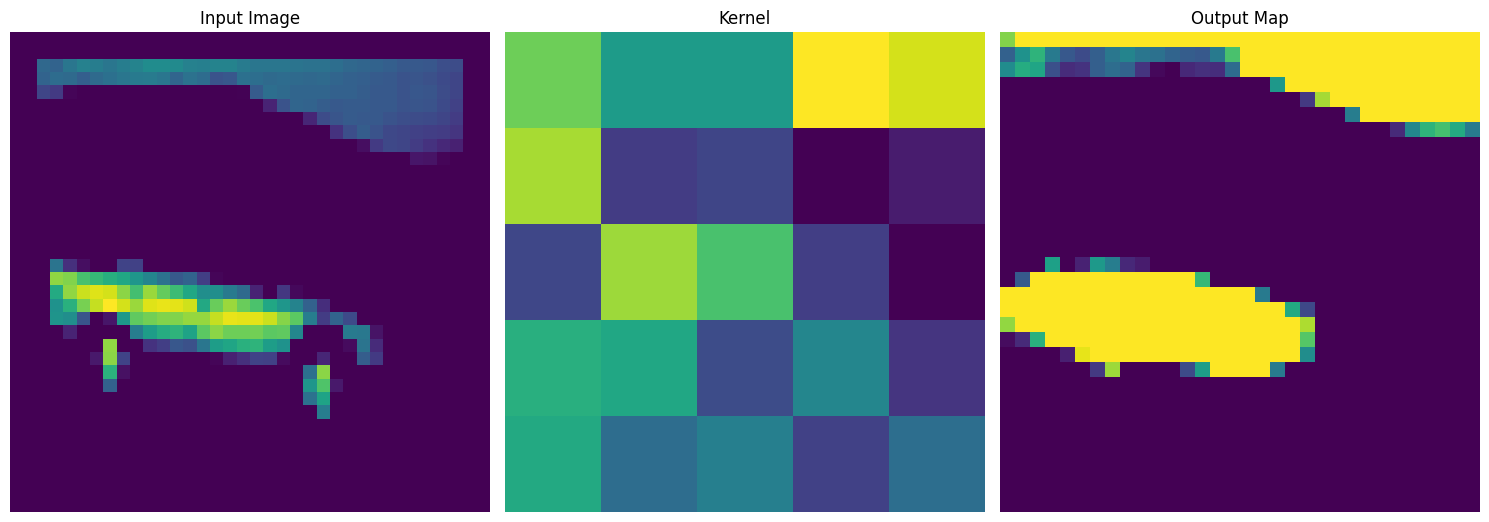

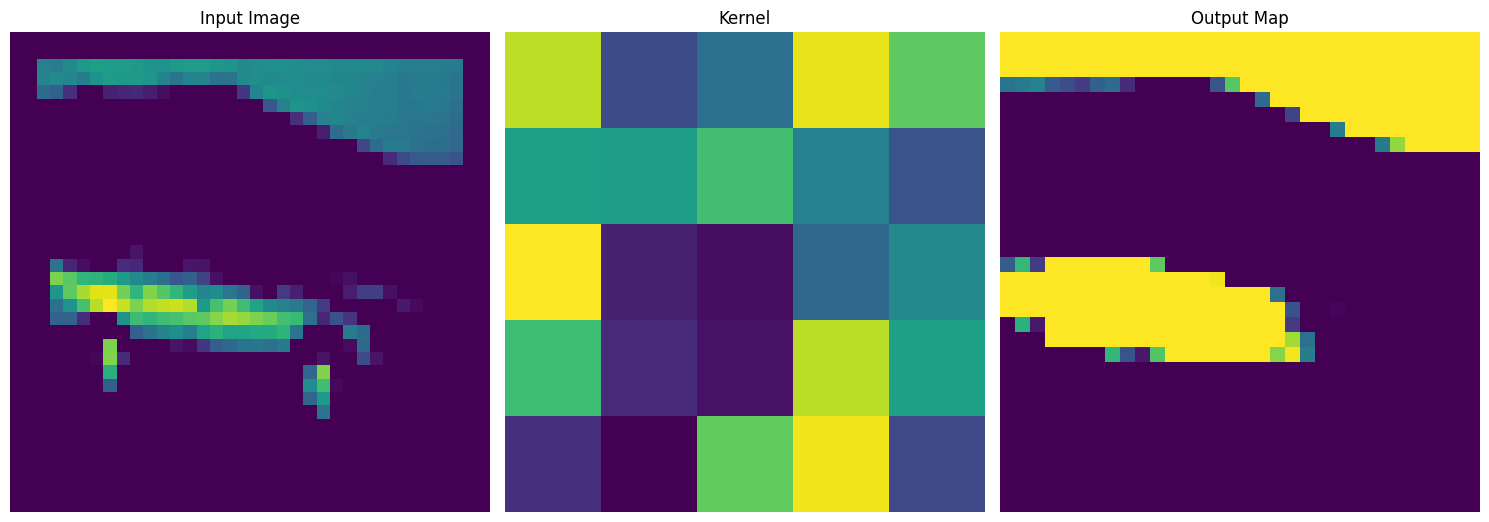

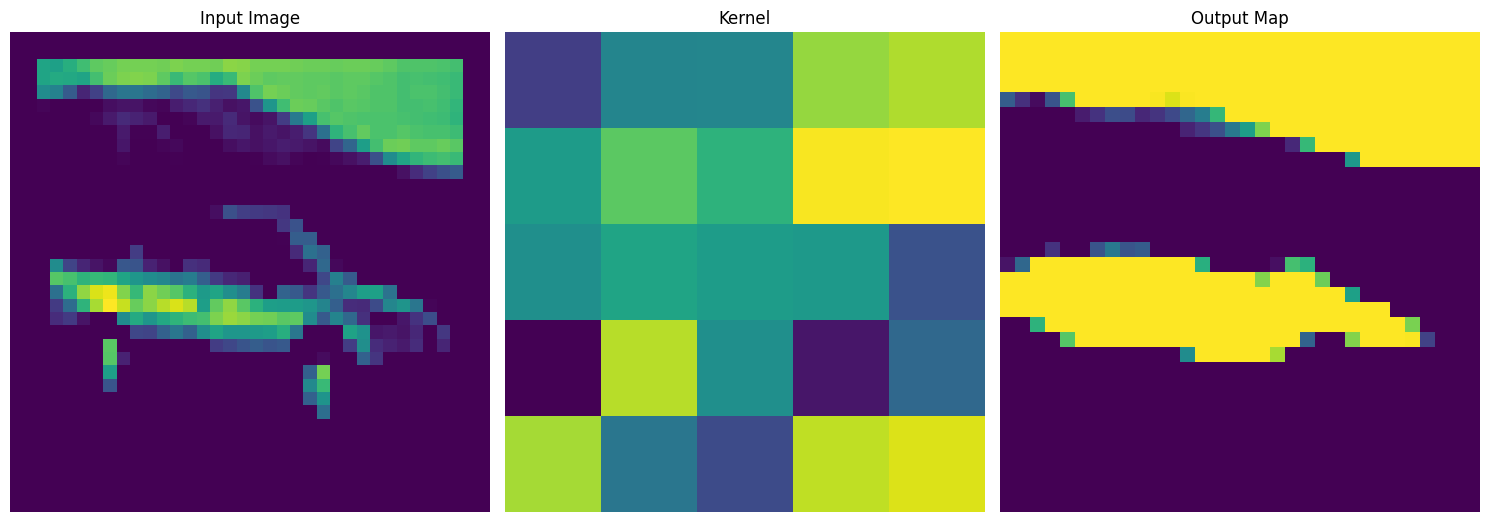

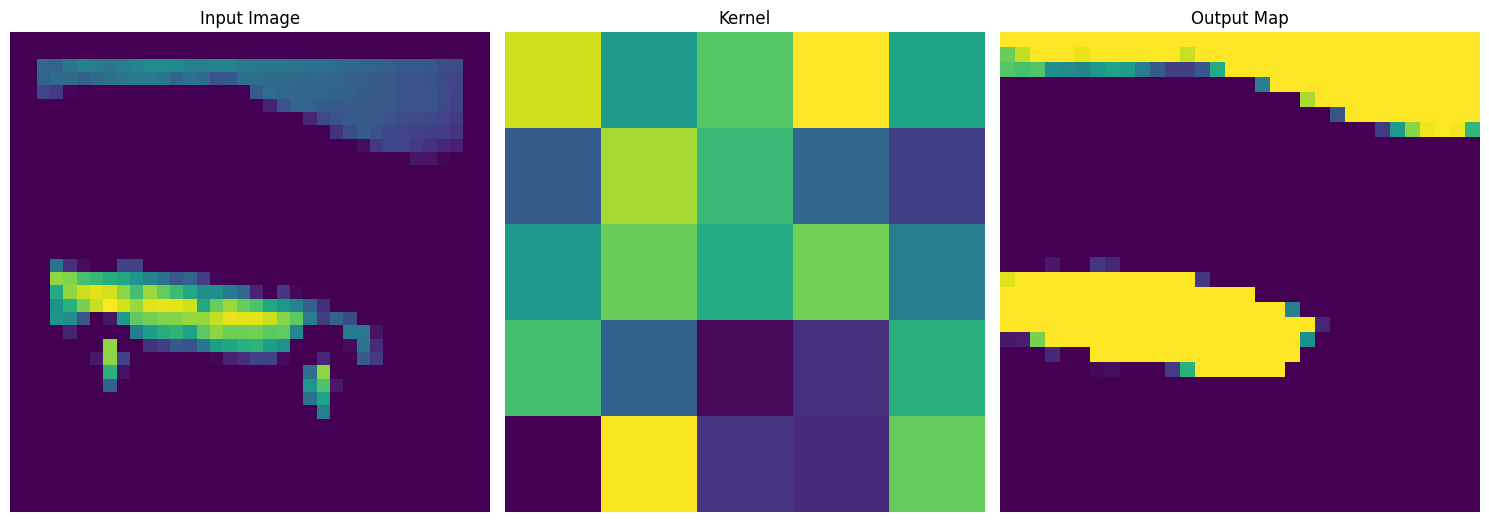

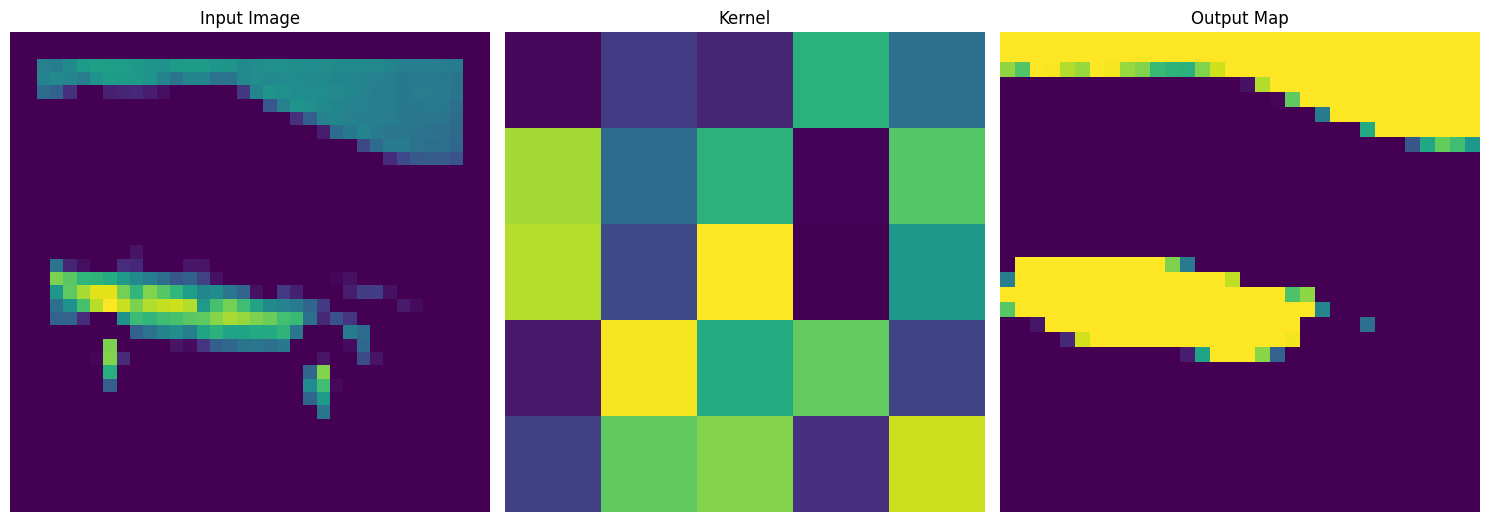

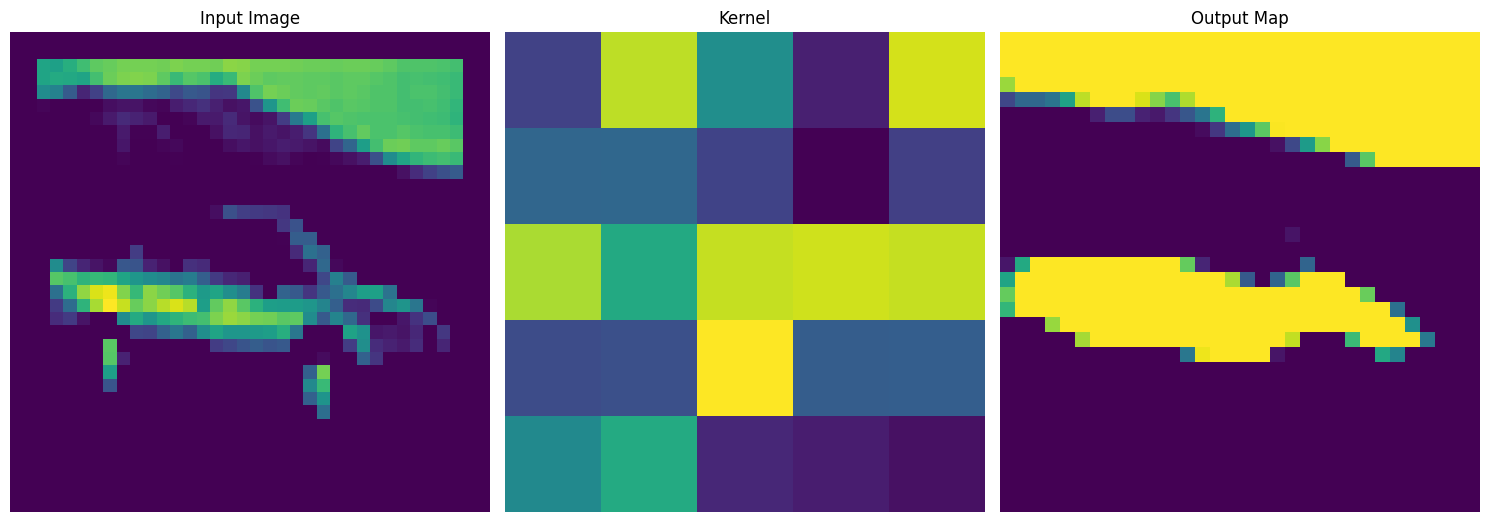

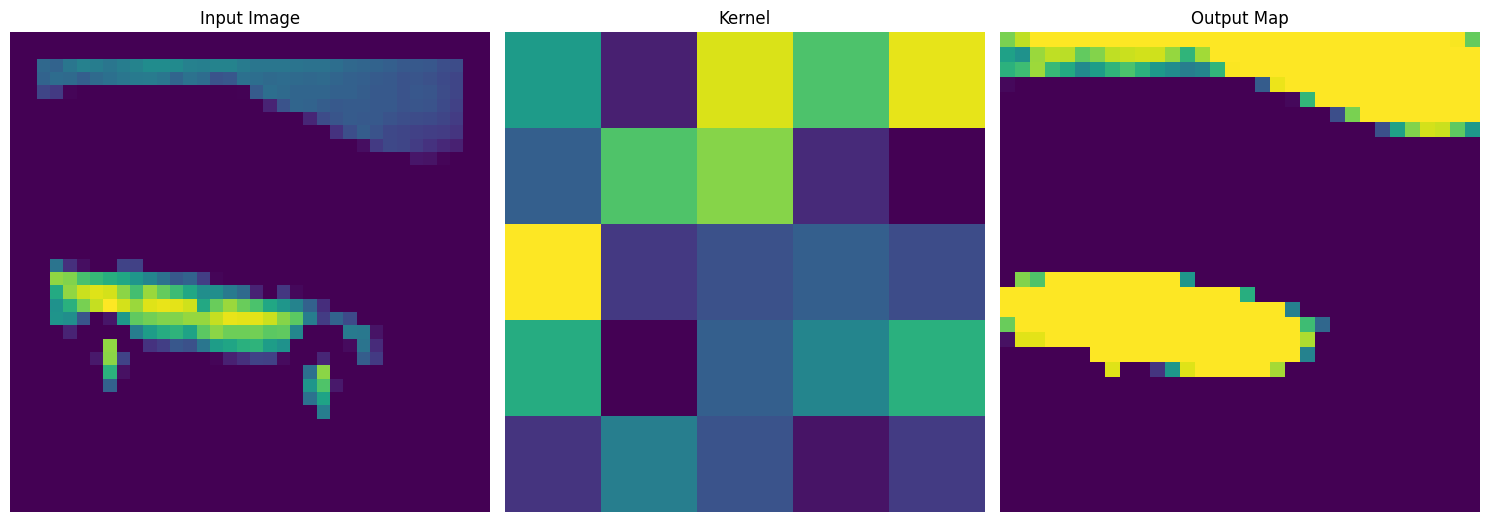

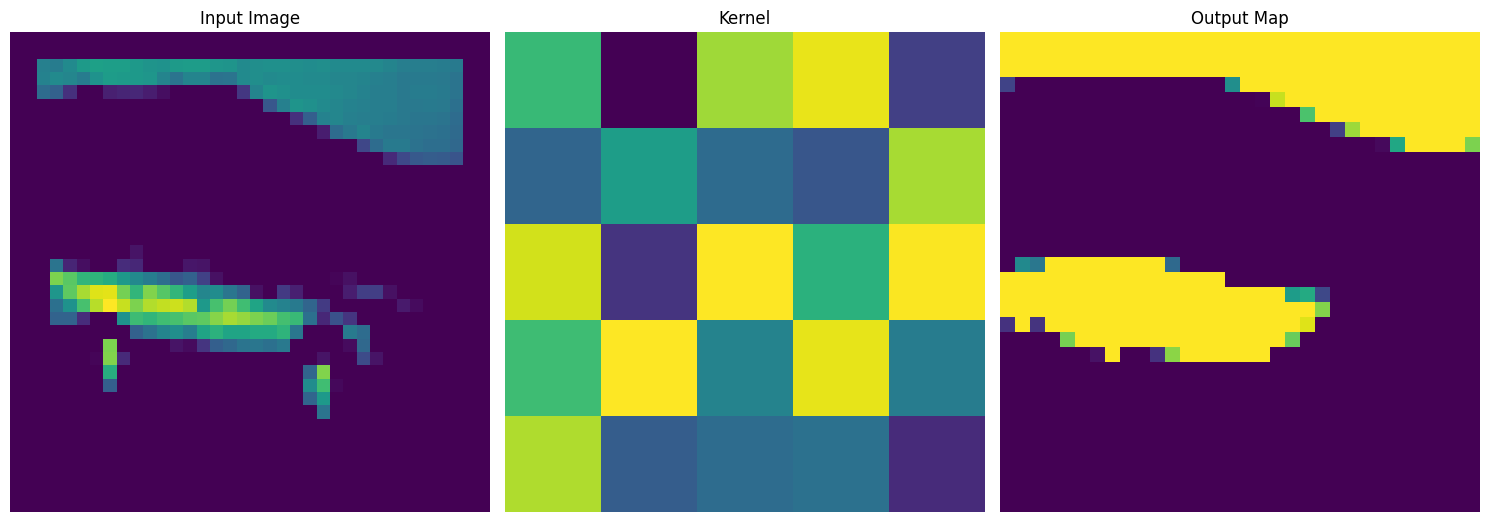

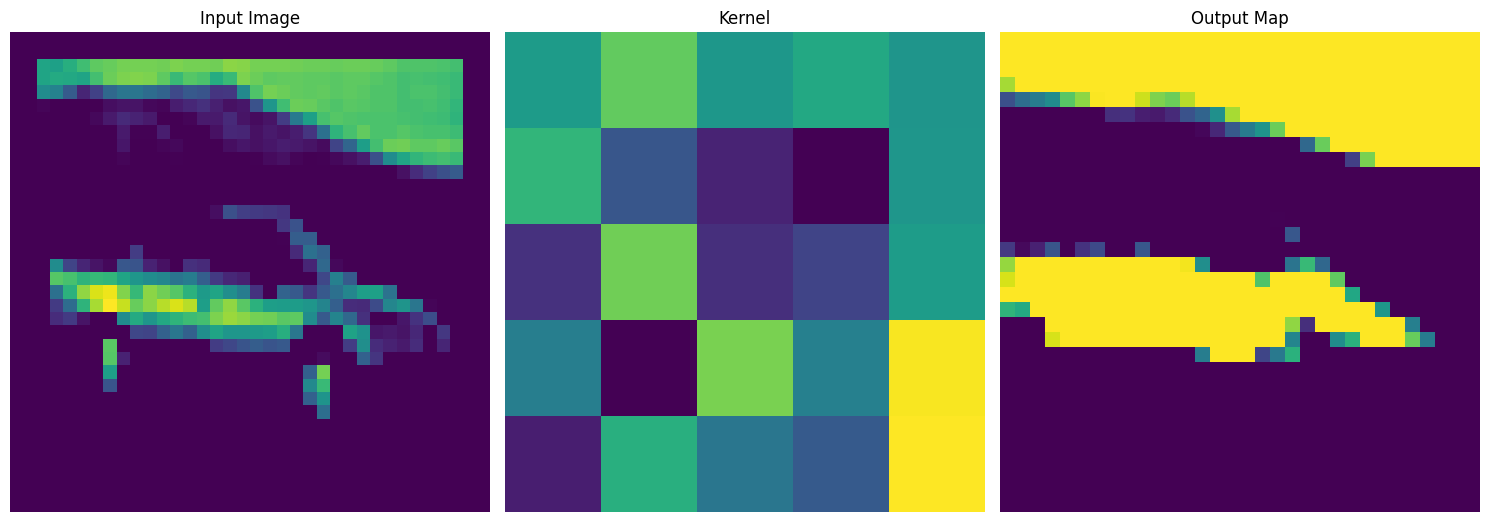

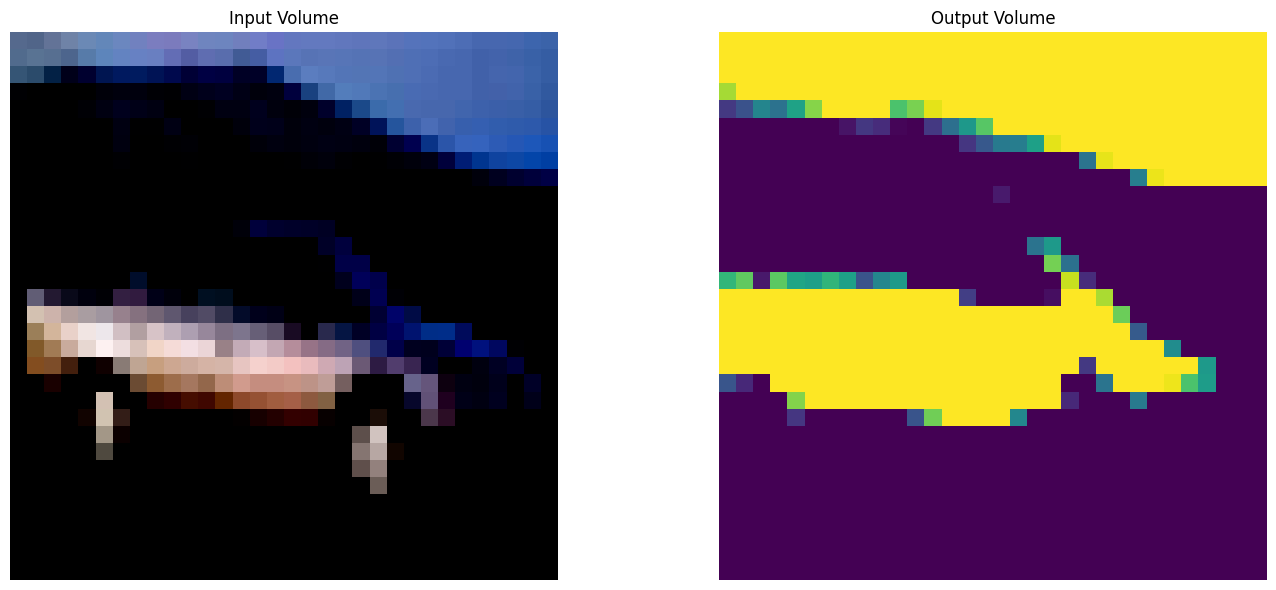

(32, 32, 4)


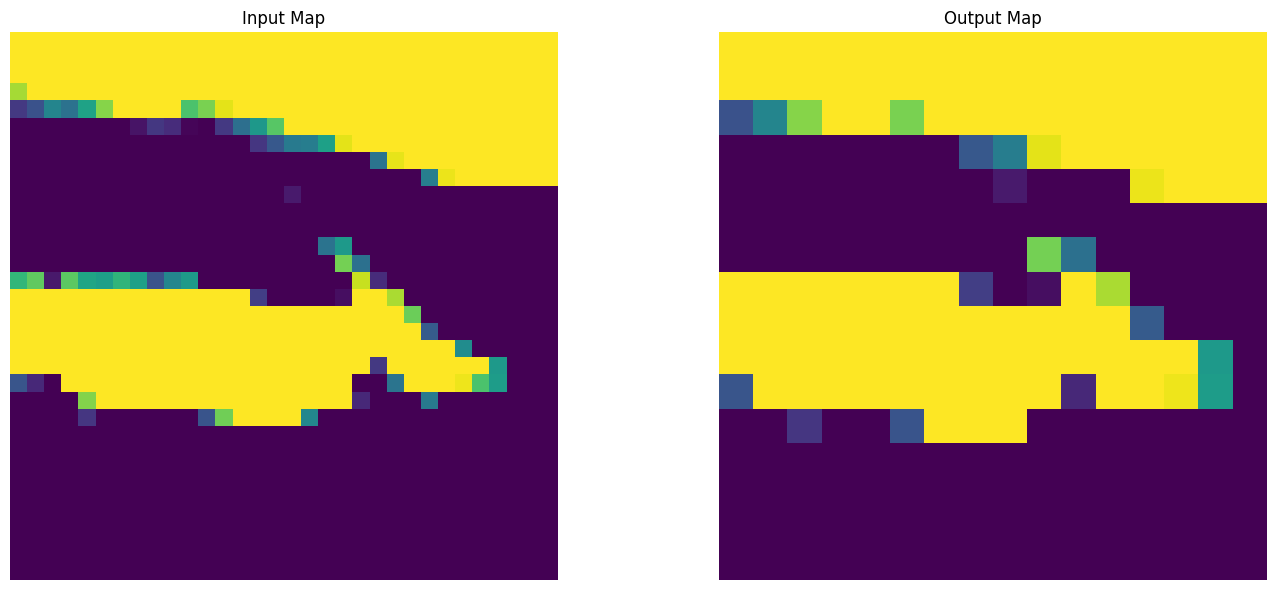

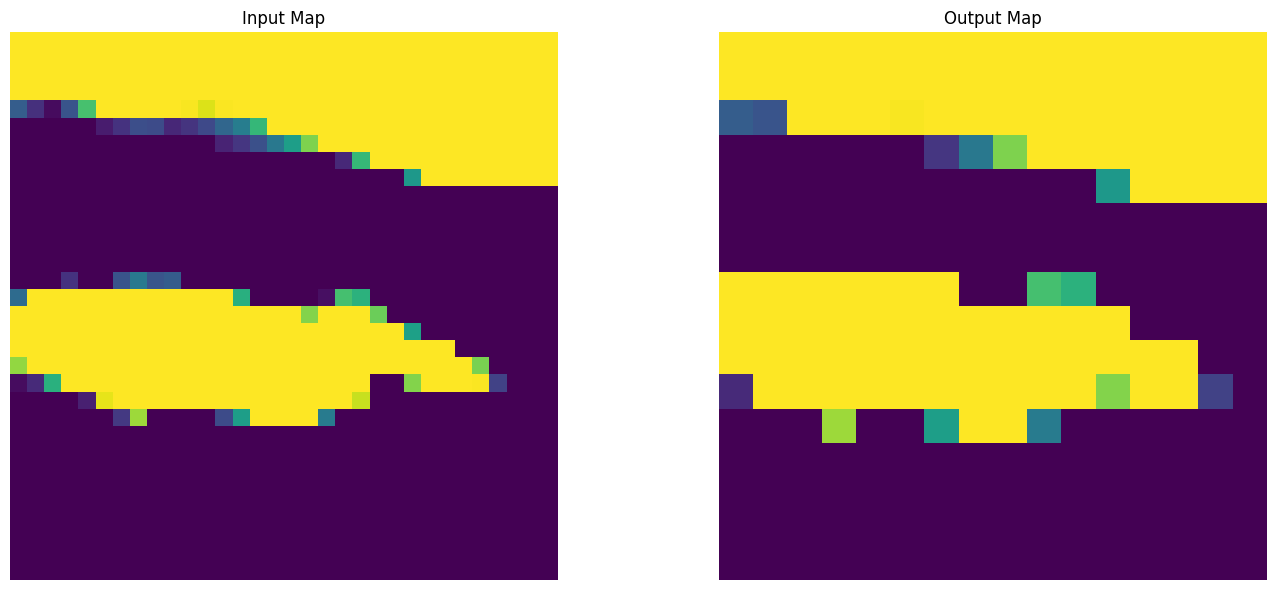

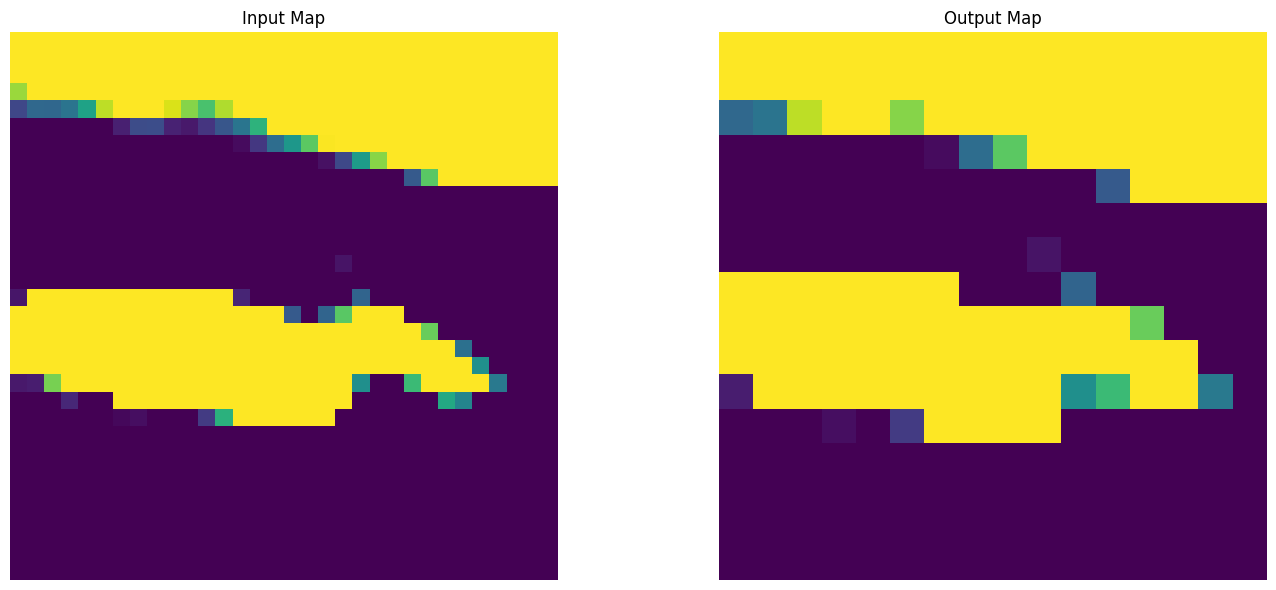

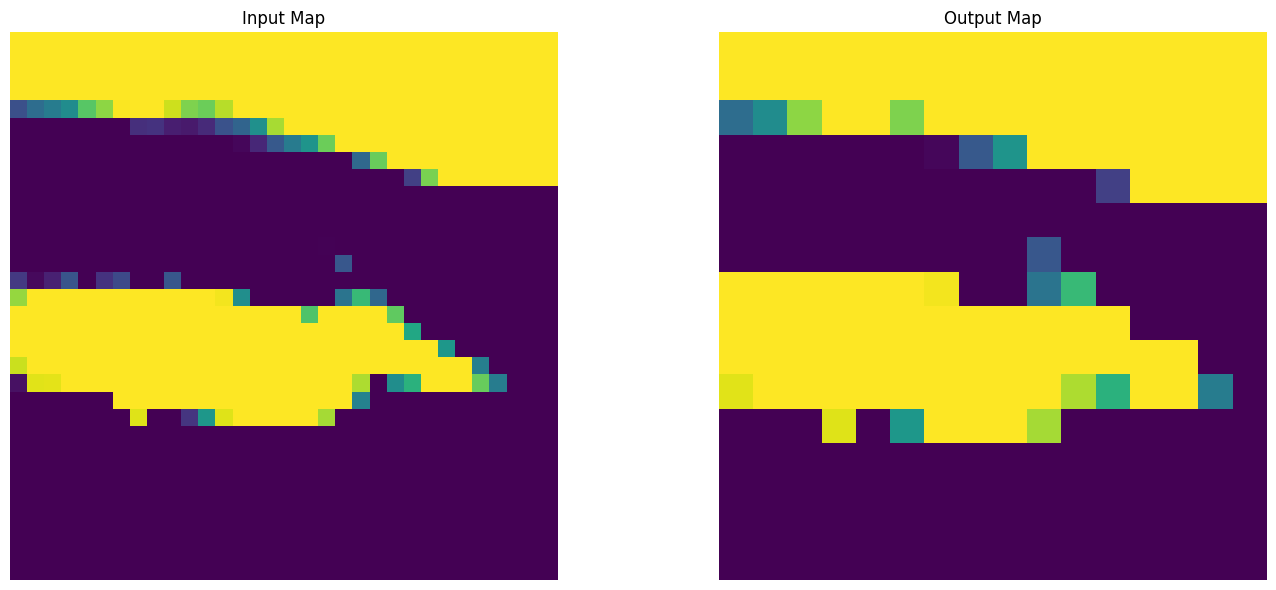

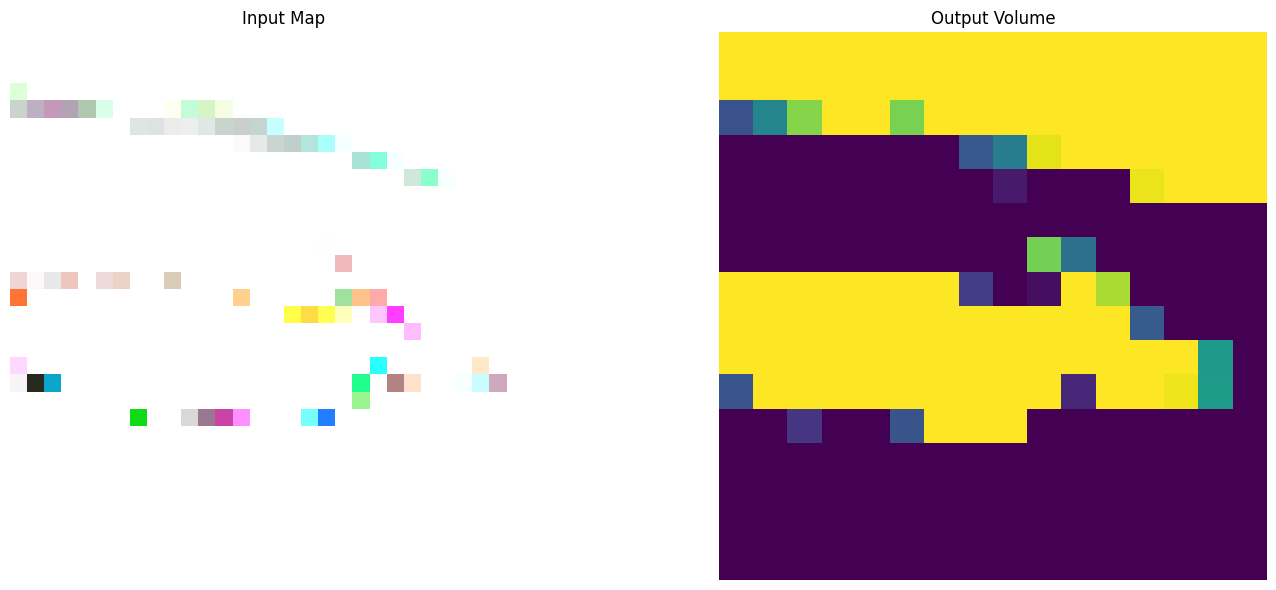

(16, 16, 4)


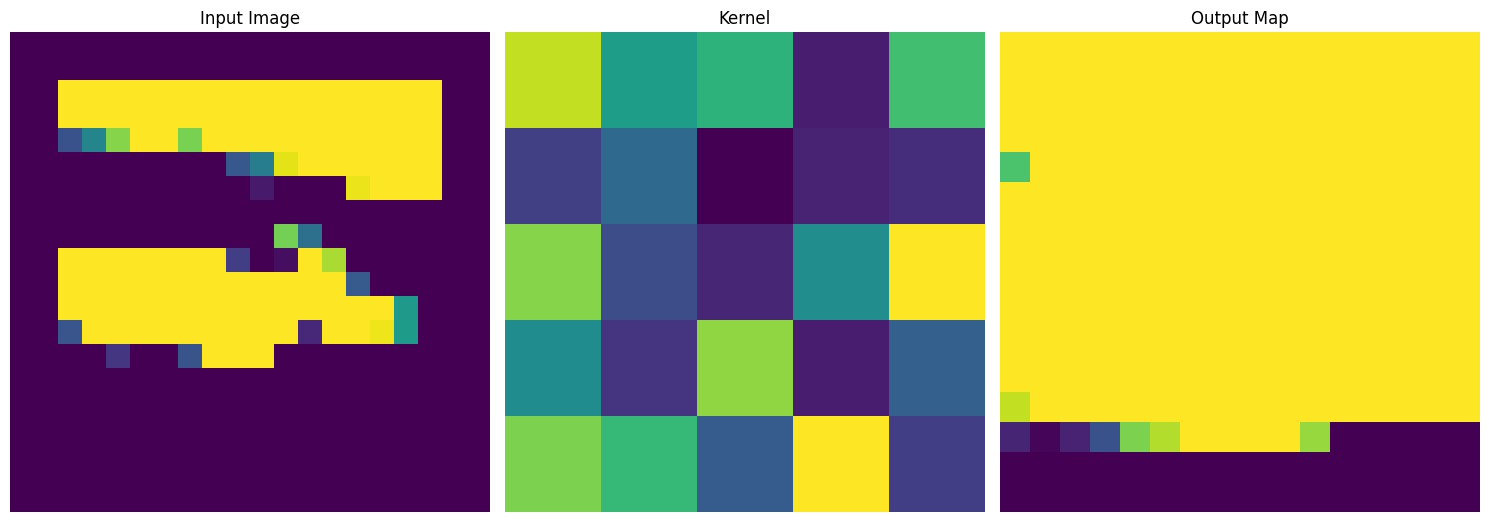

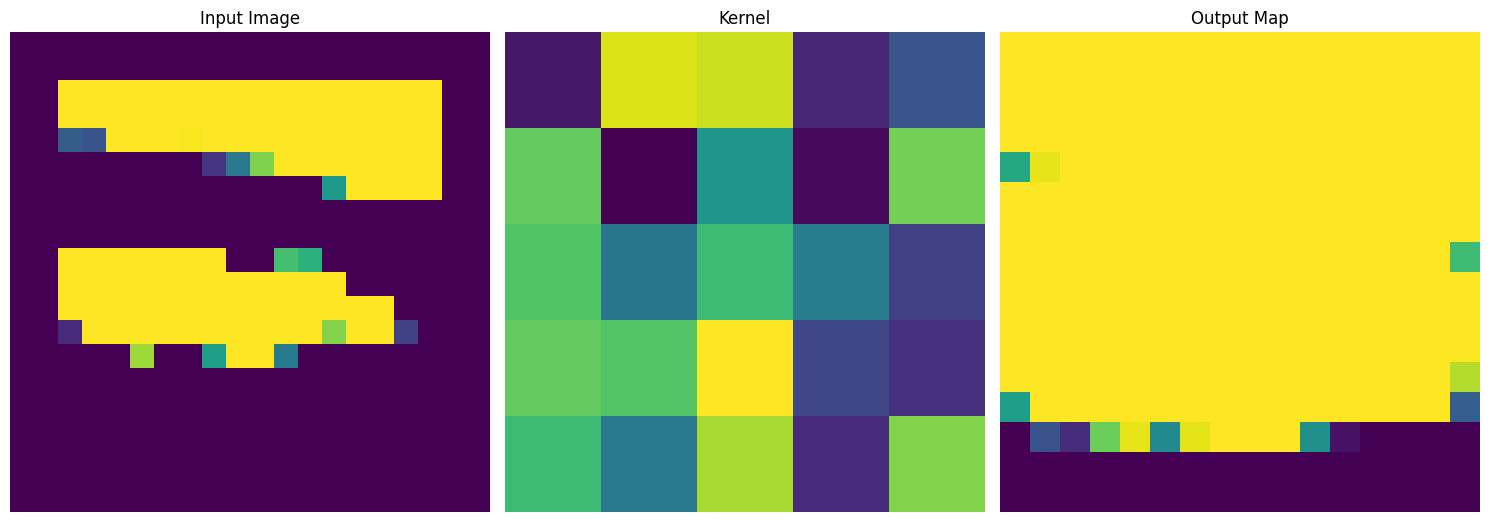

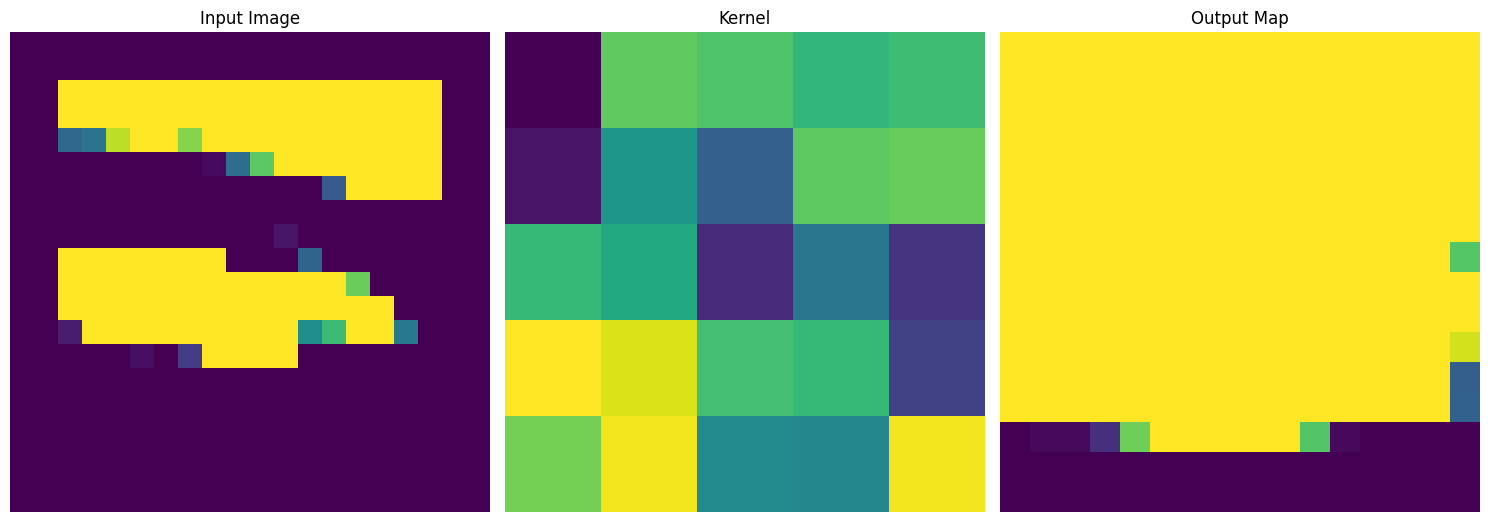

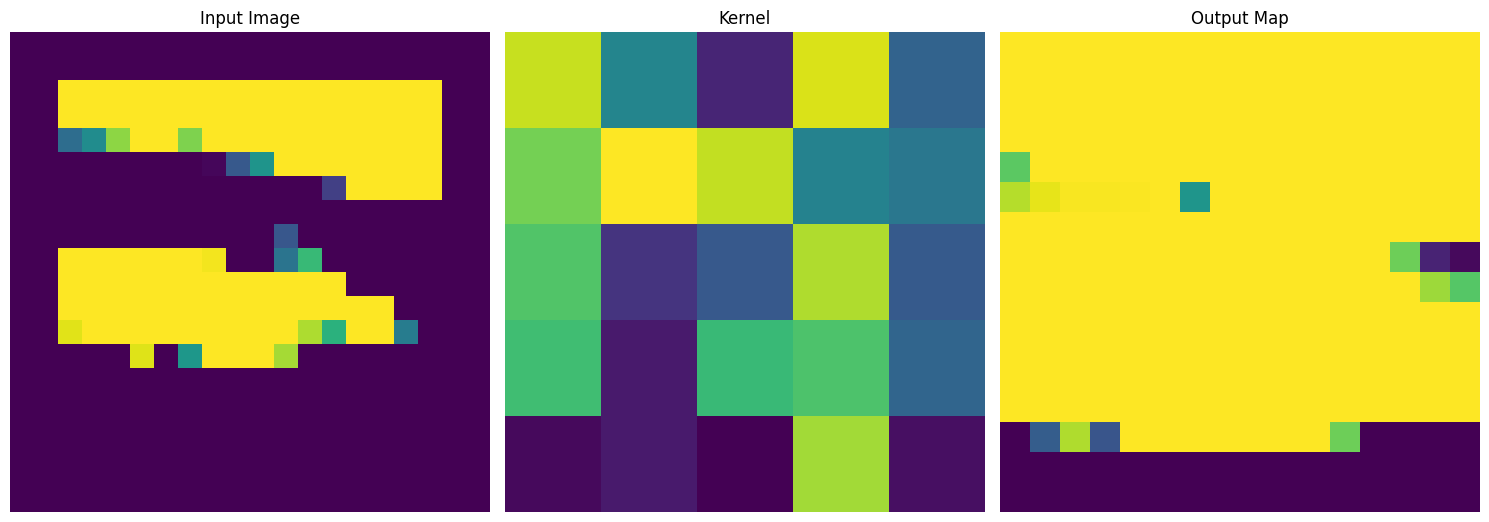

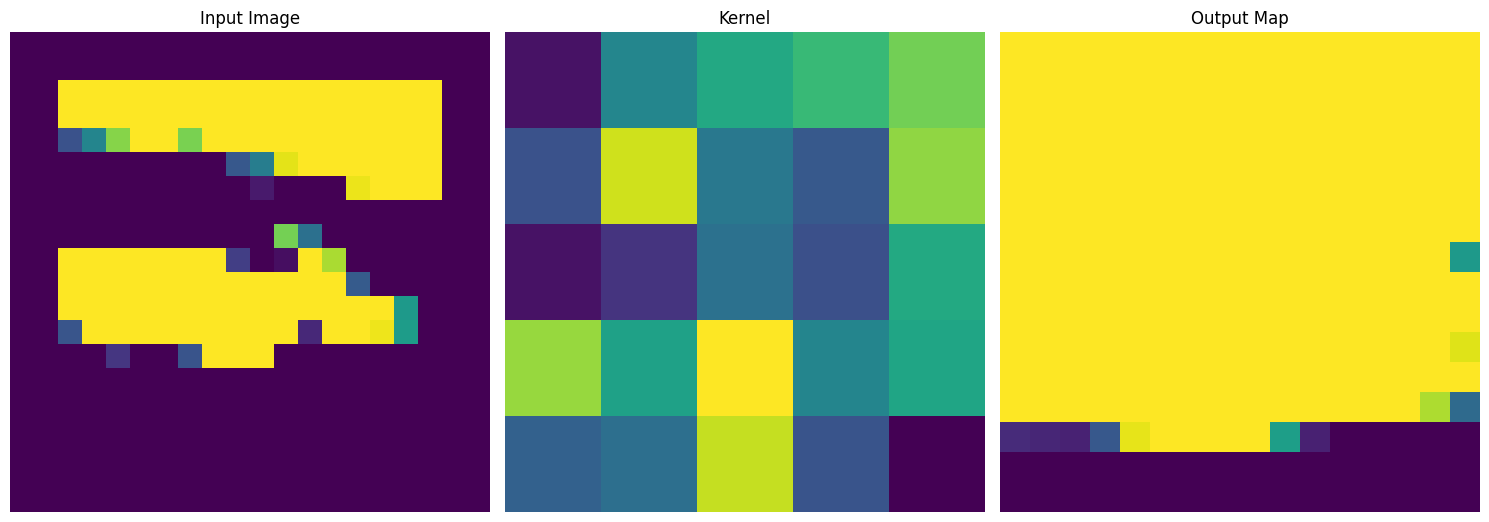

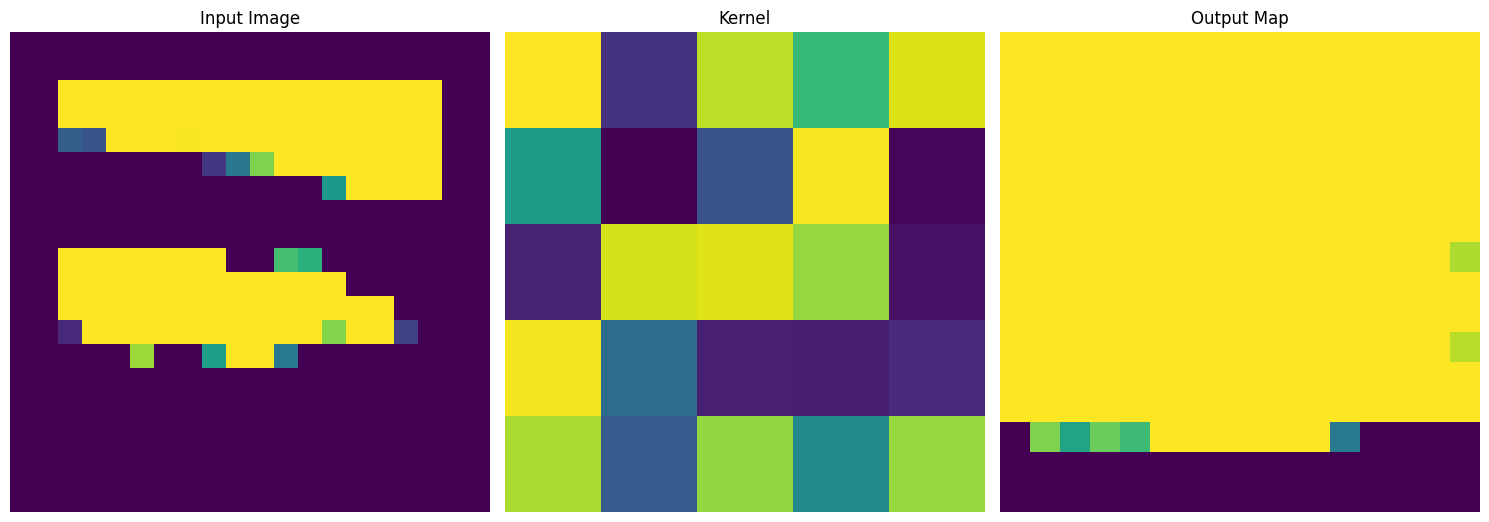

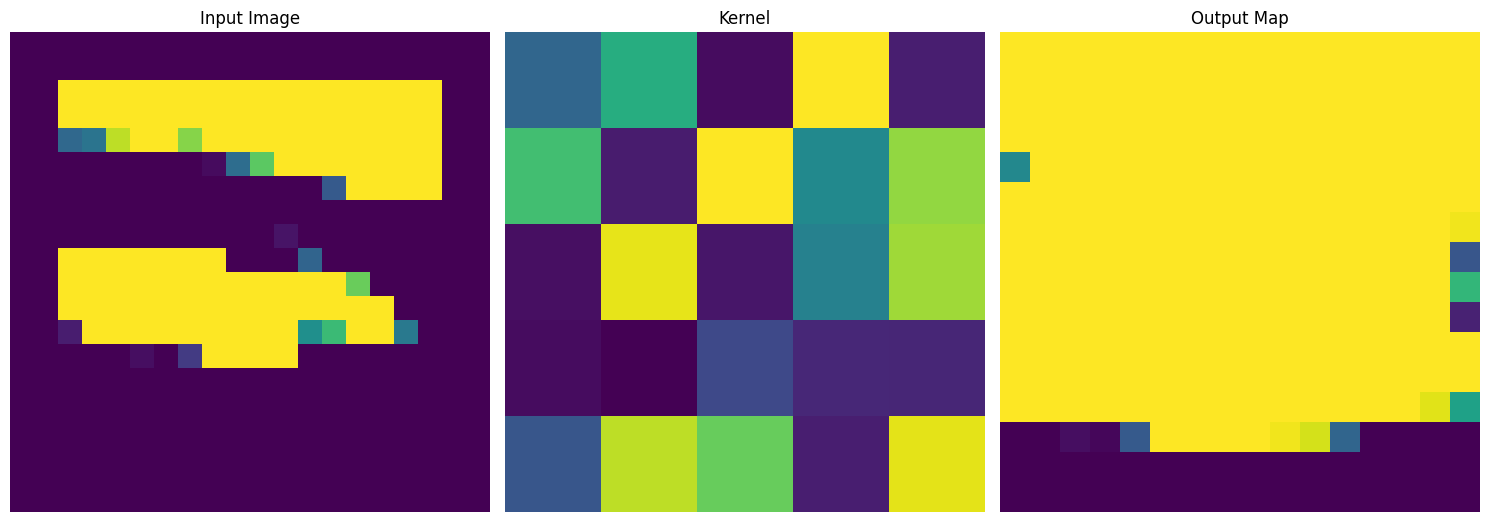

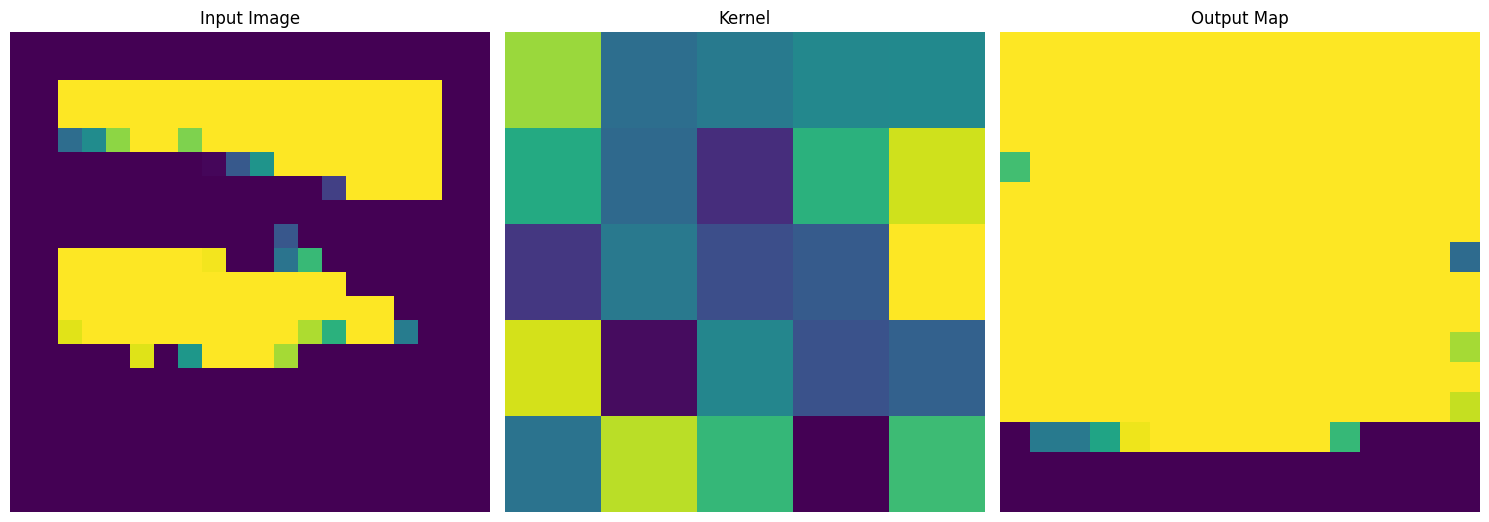

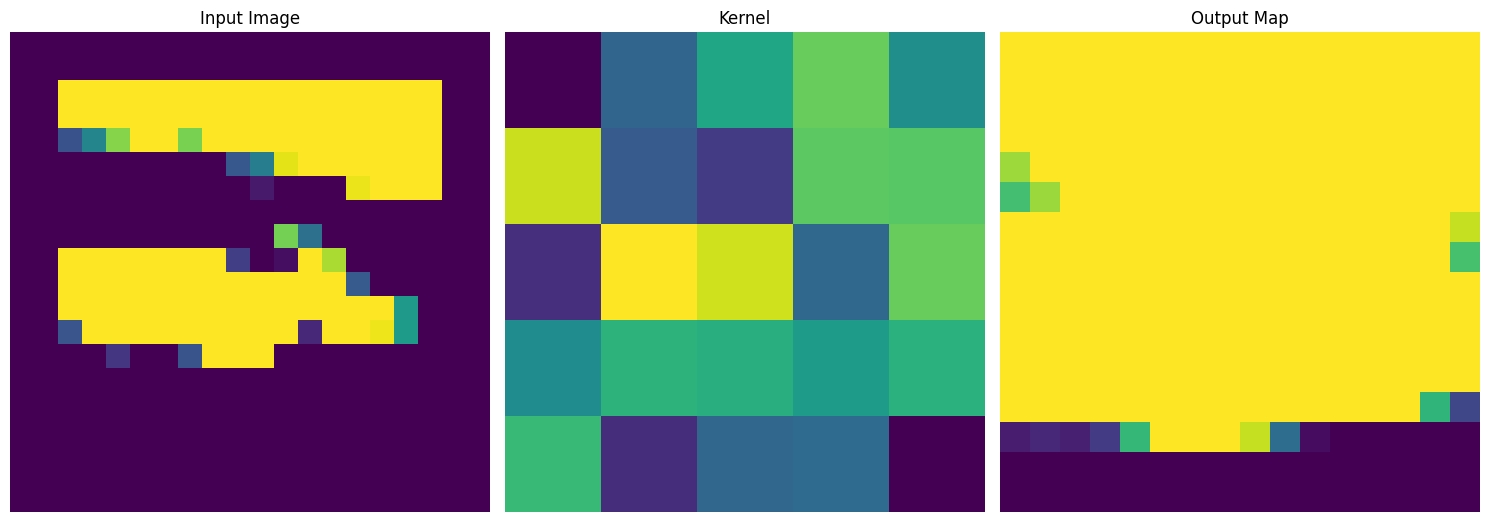

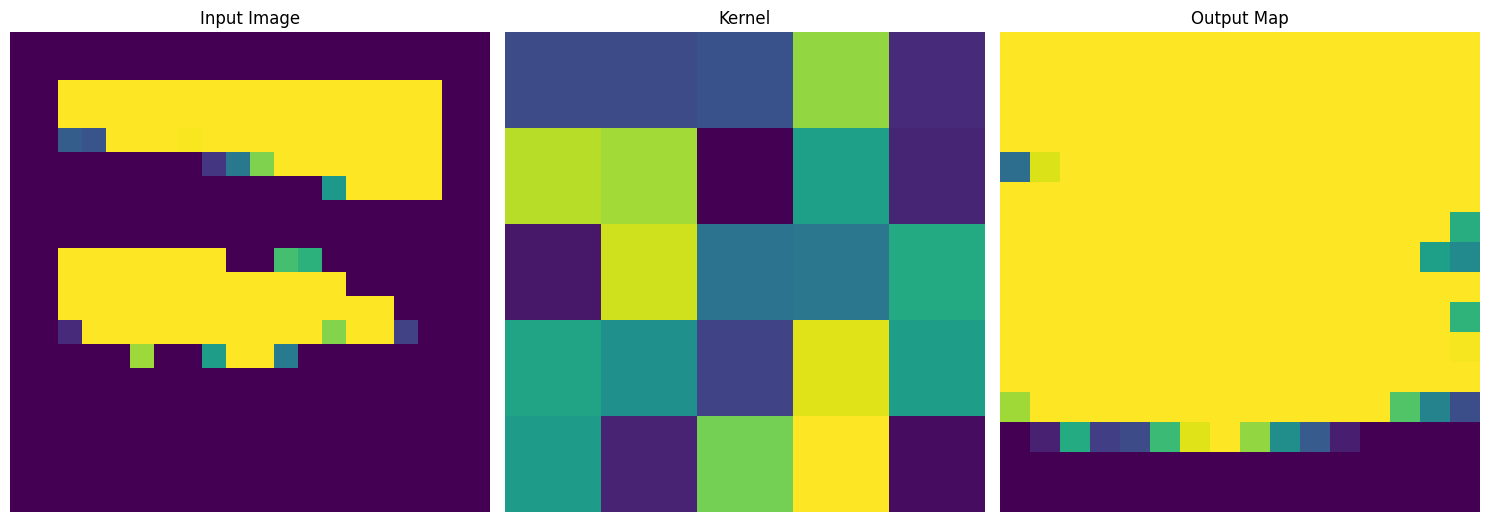

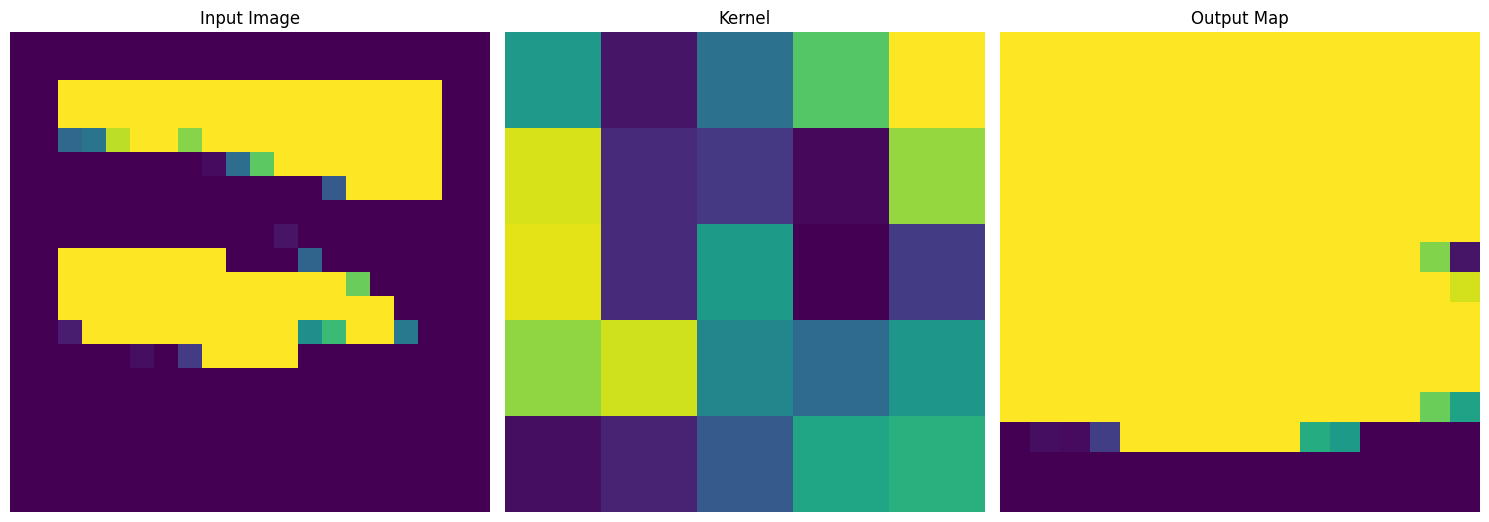

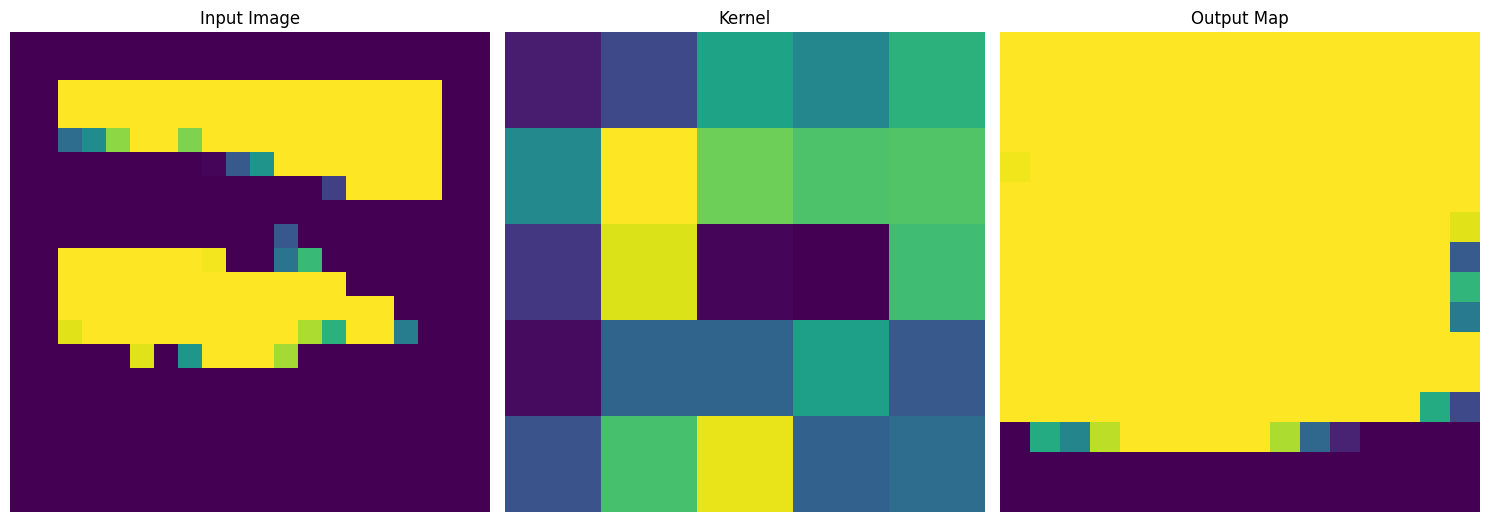

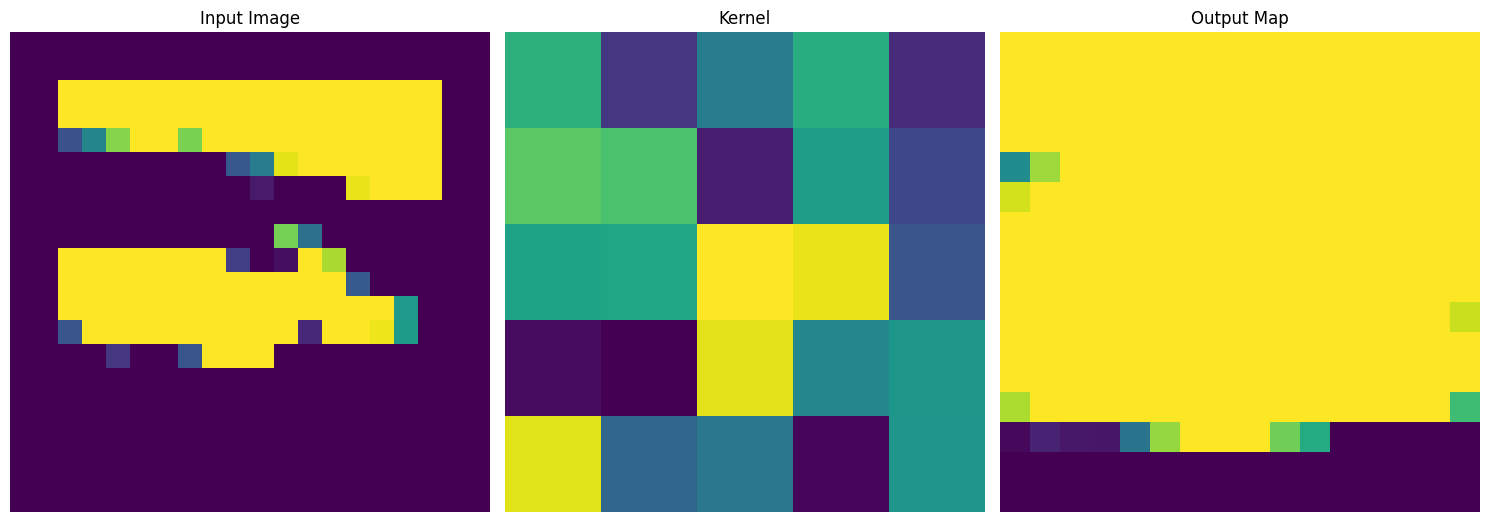

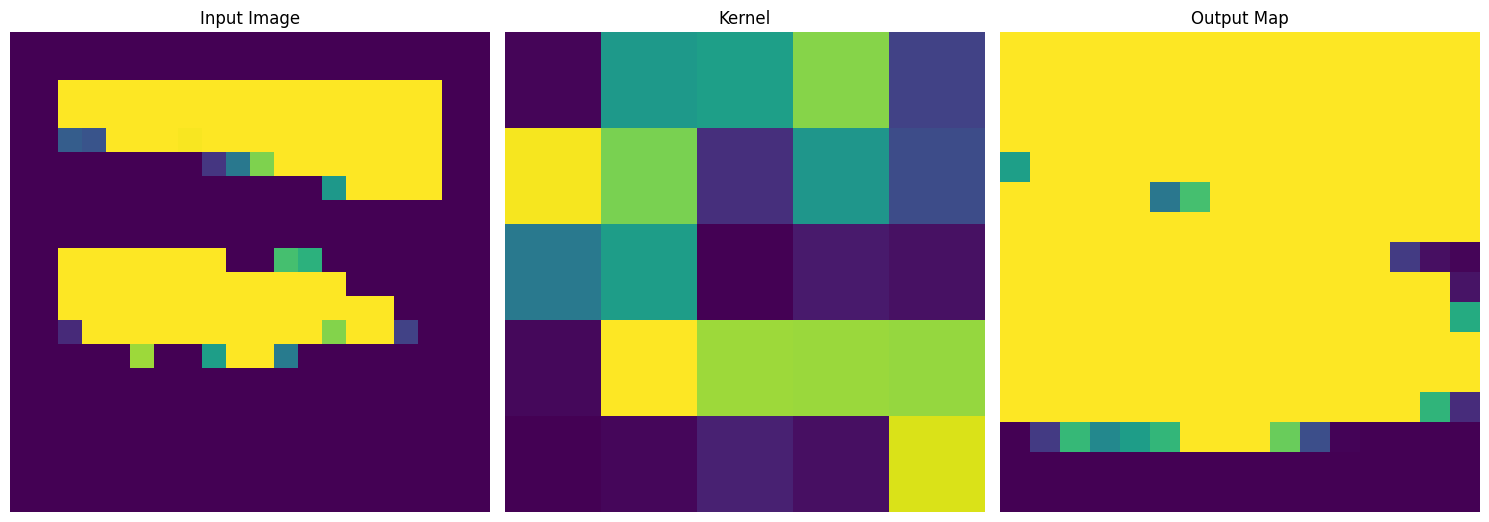

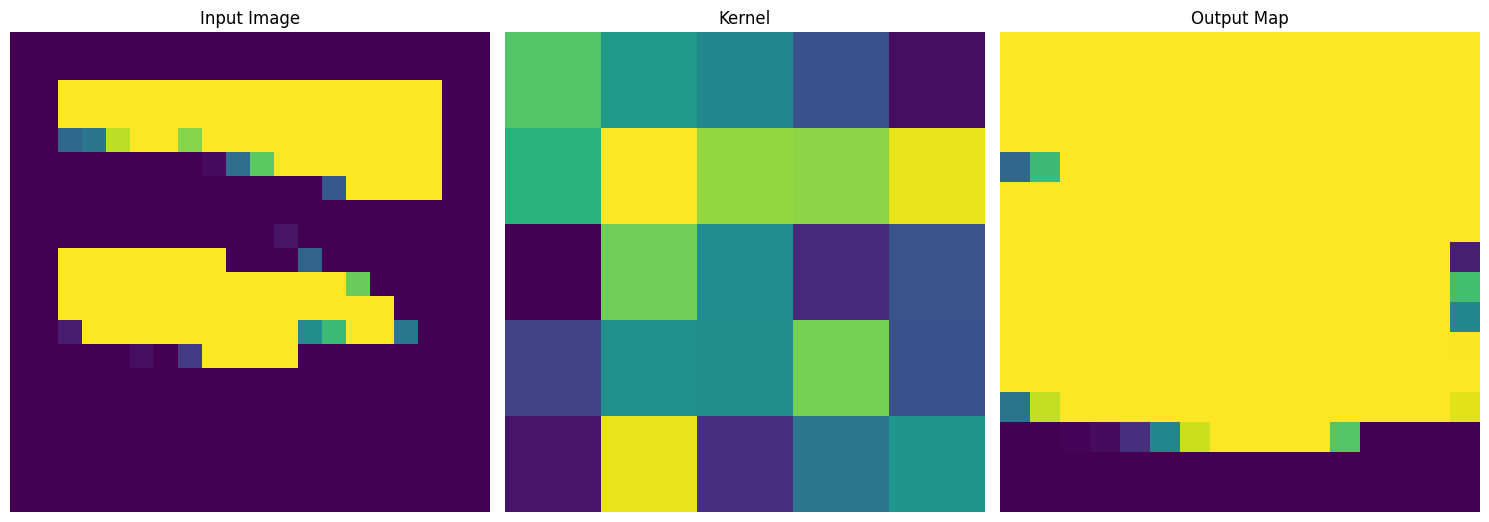

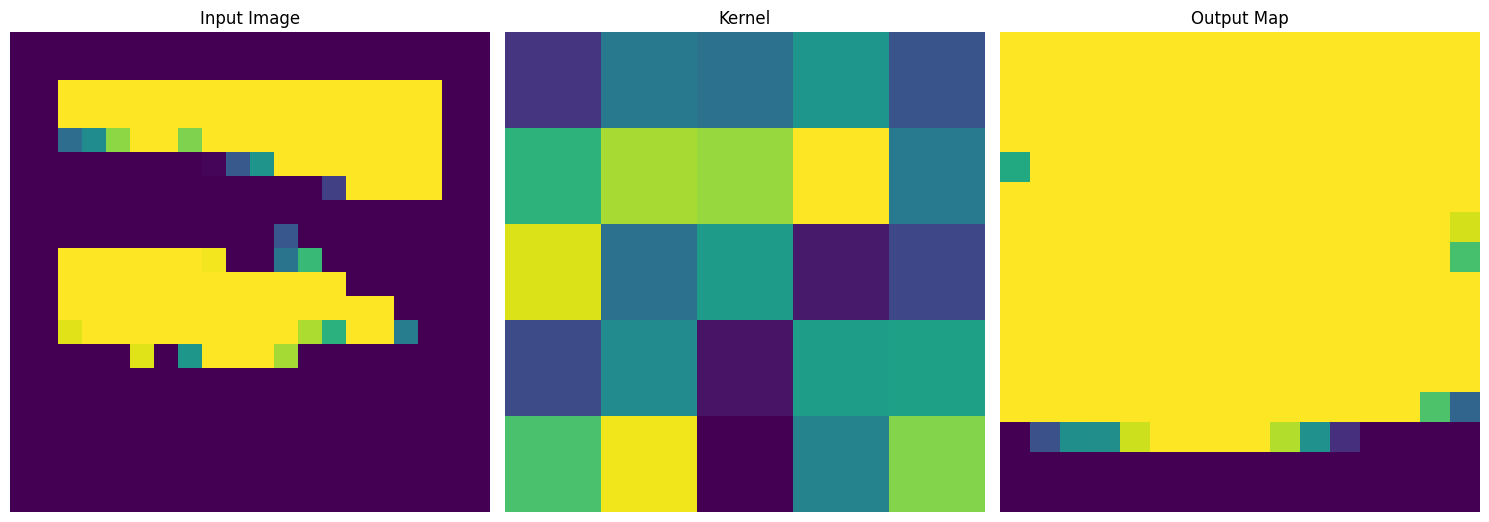

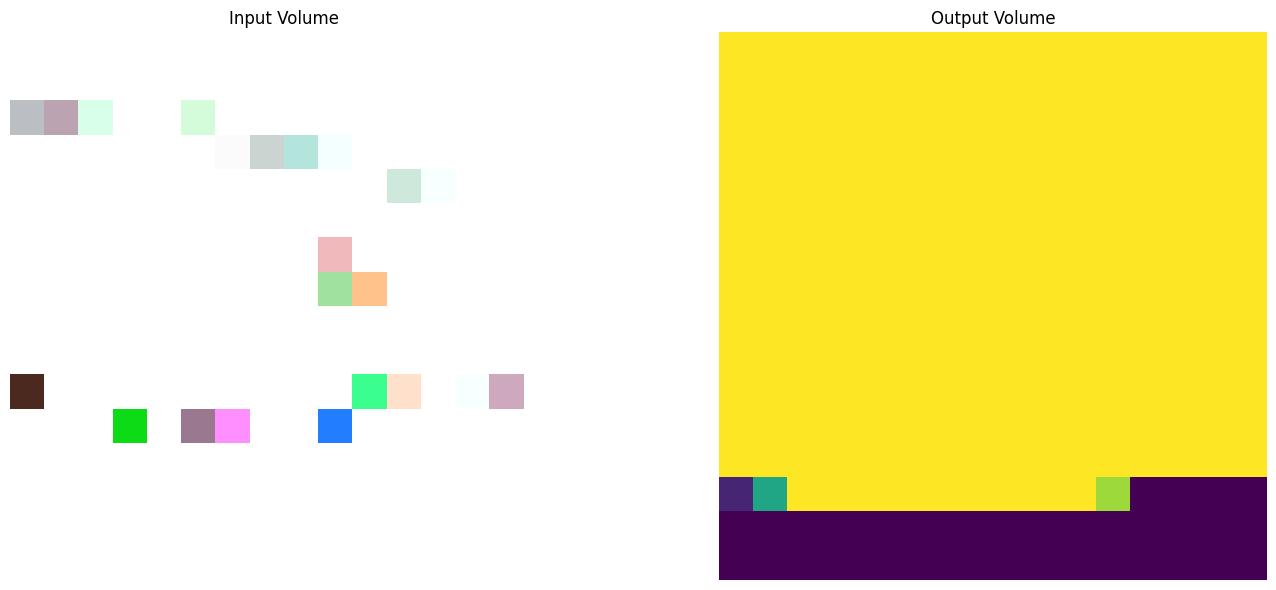

(16, 16, 4)


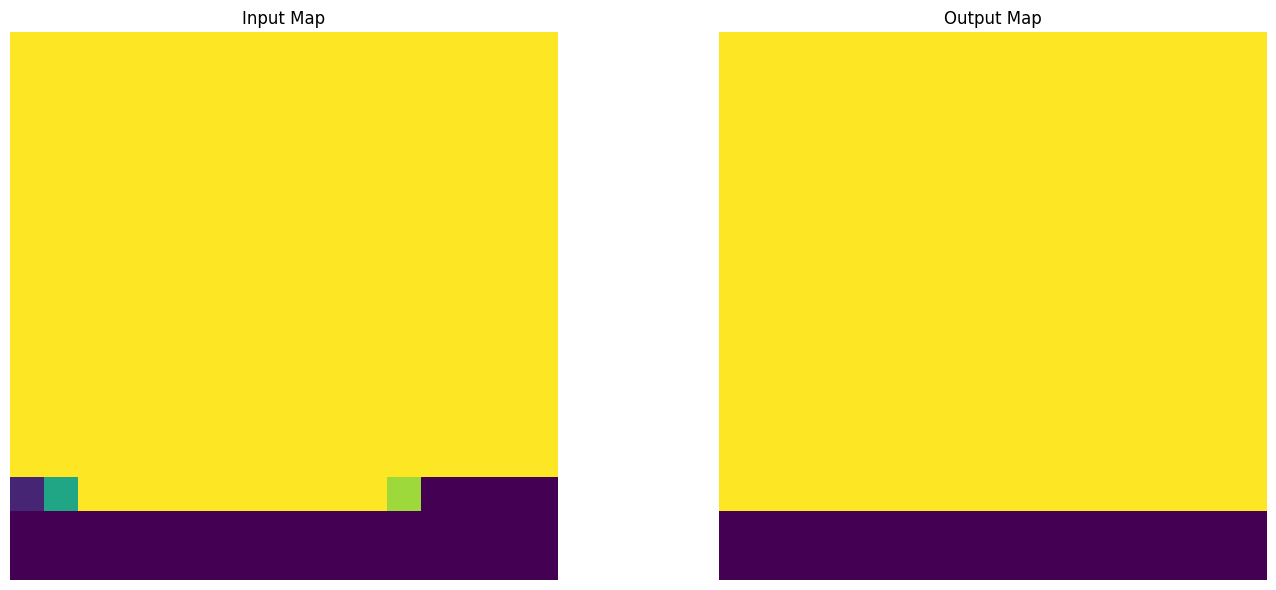

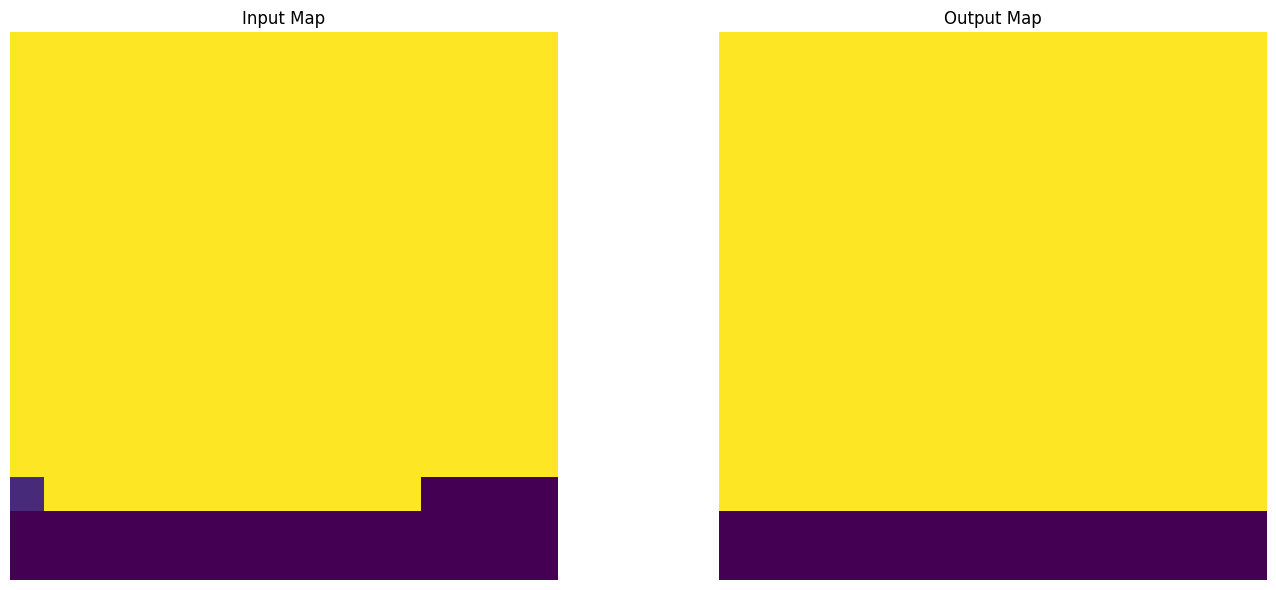

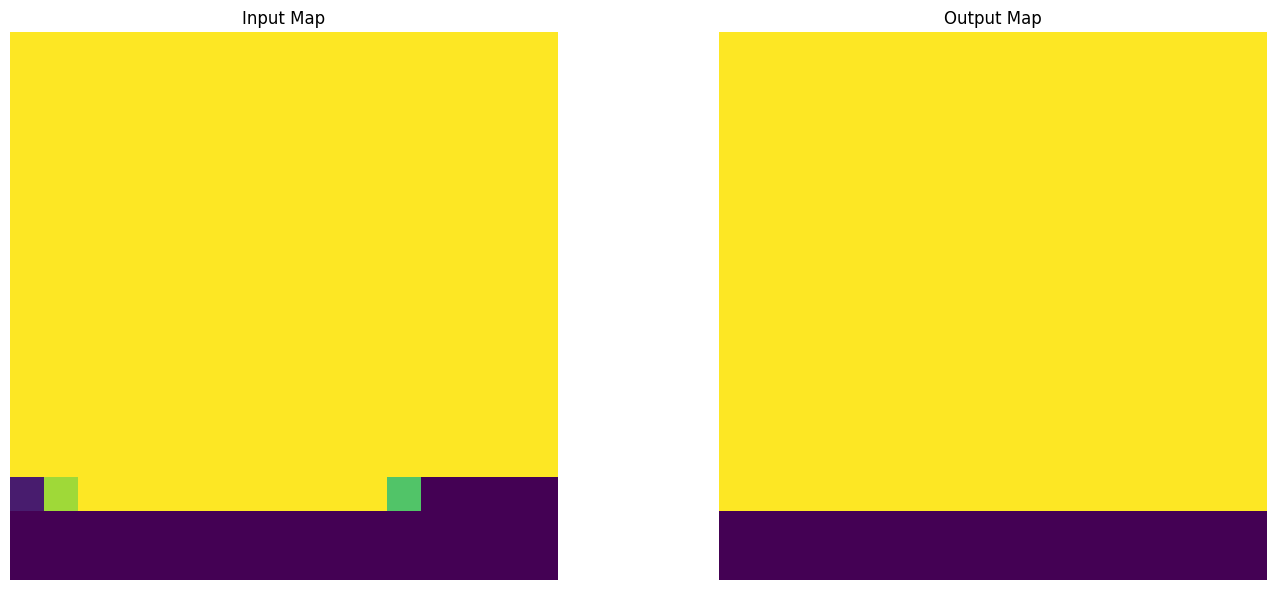

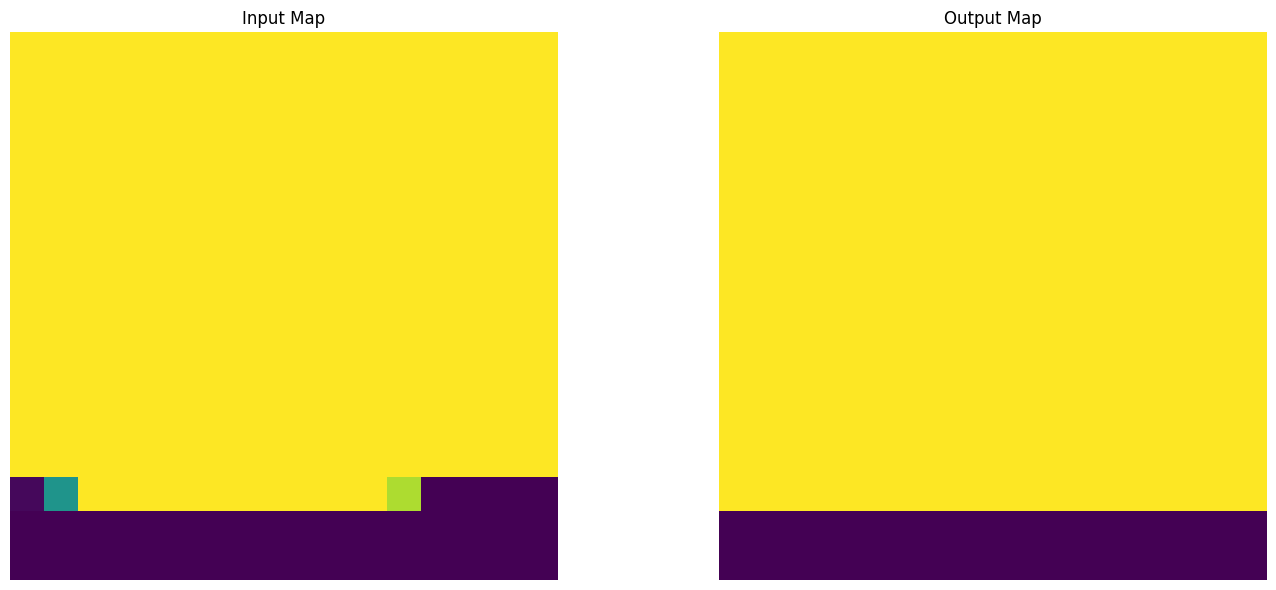

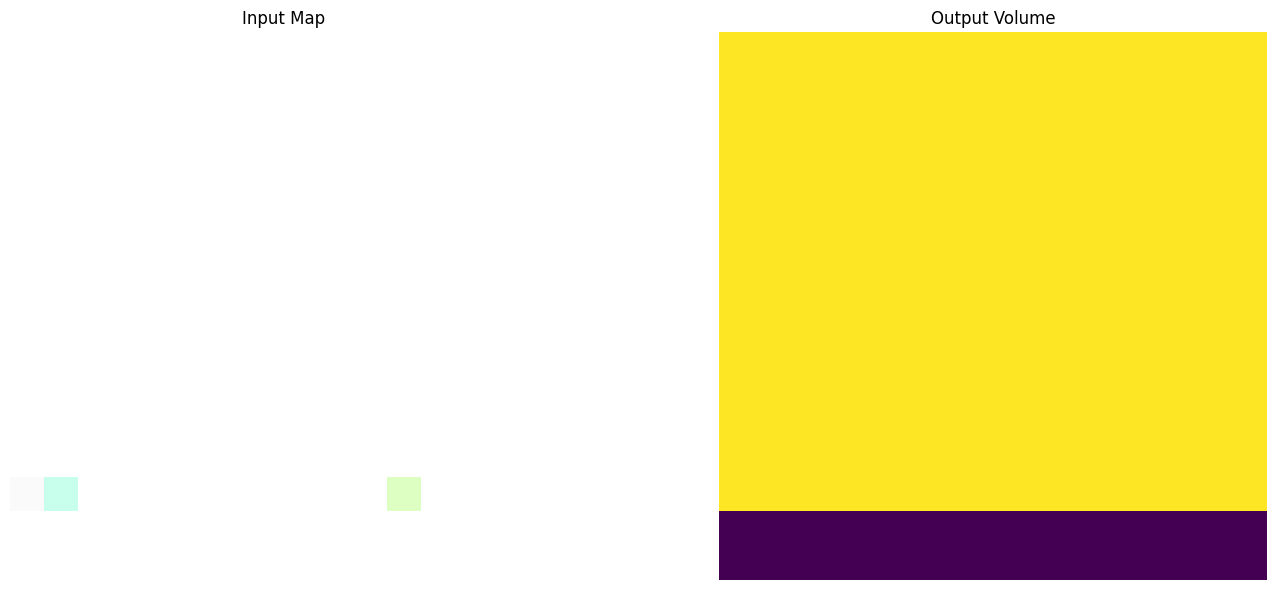

(8, 8, 4)


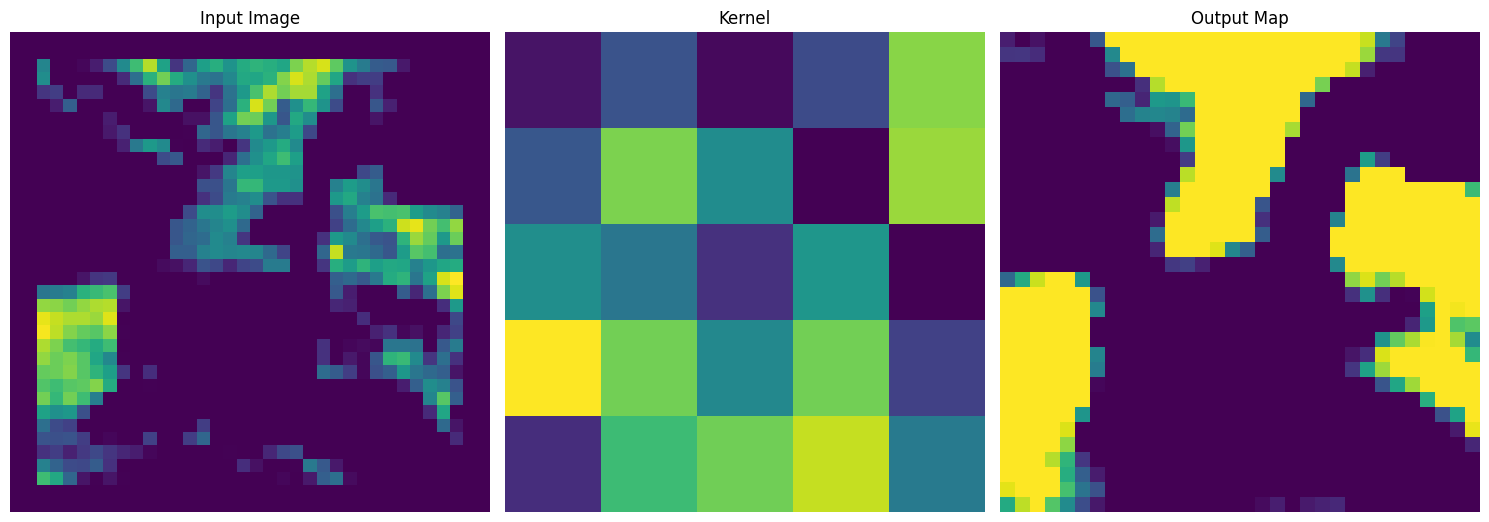

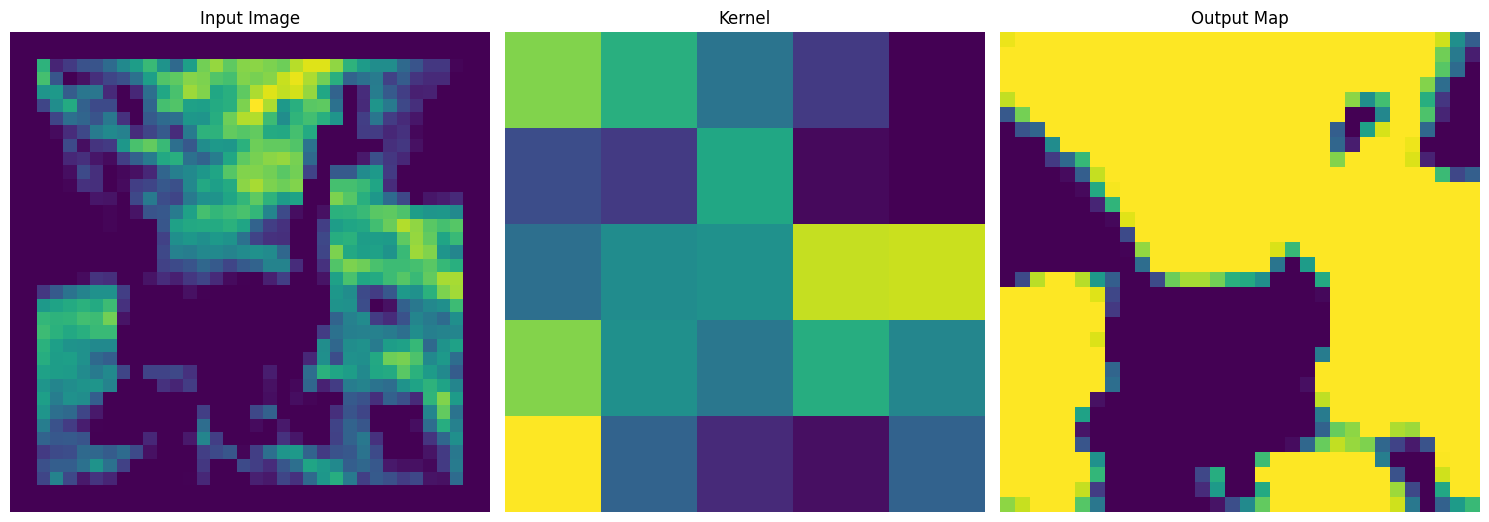

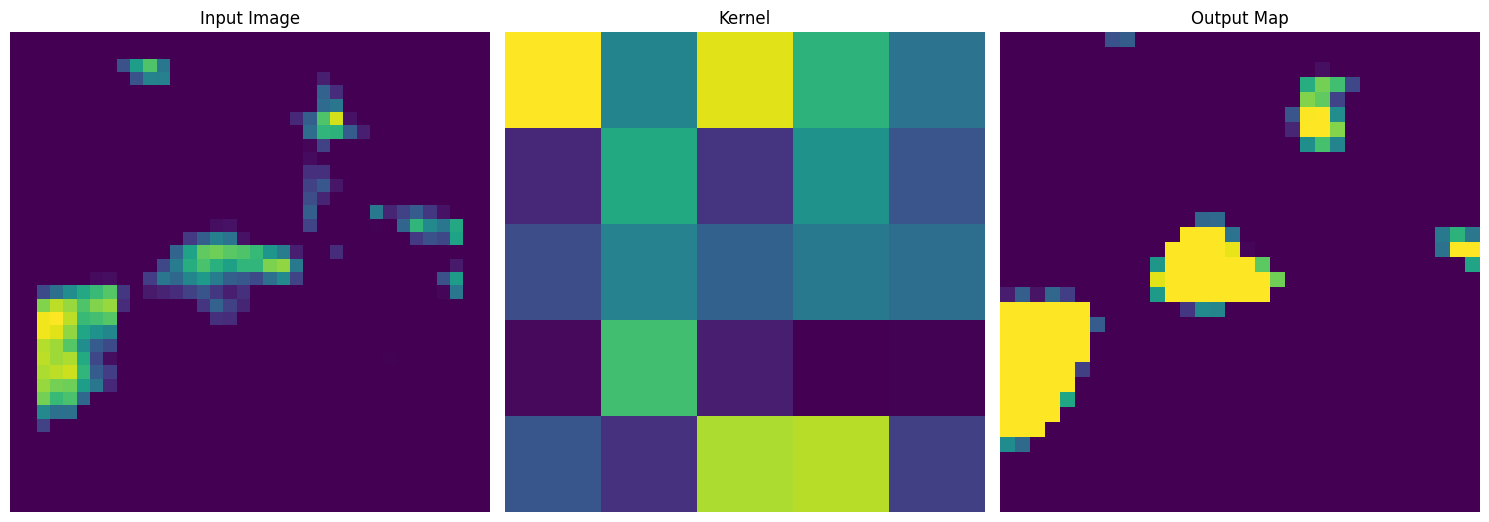

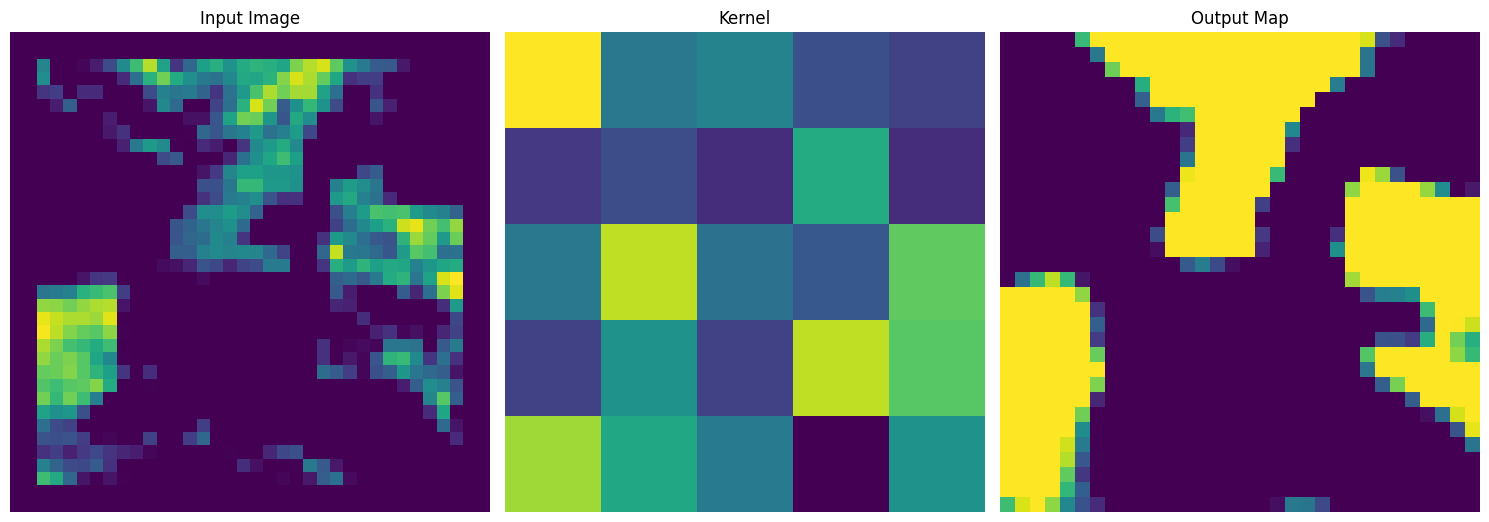

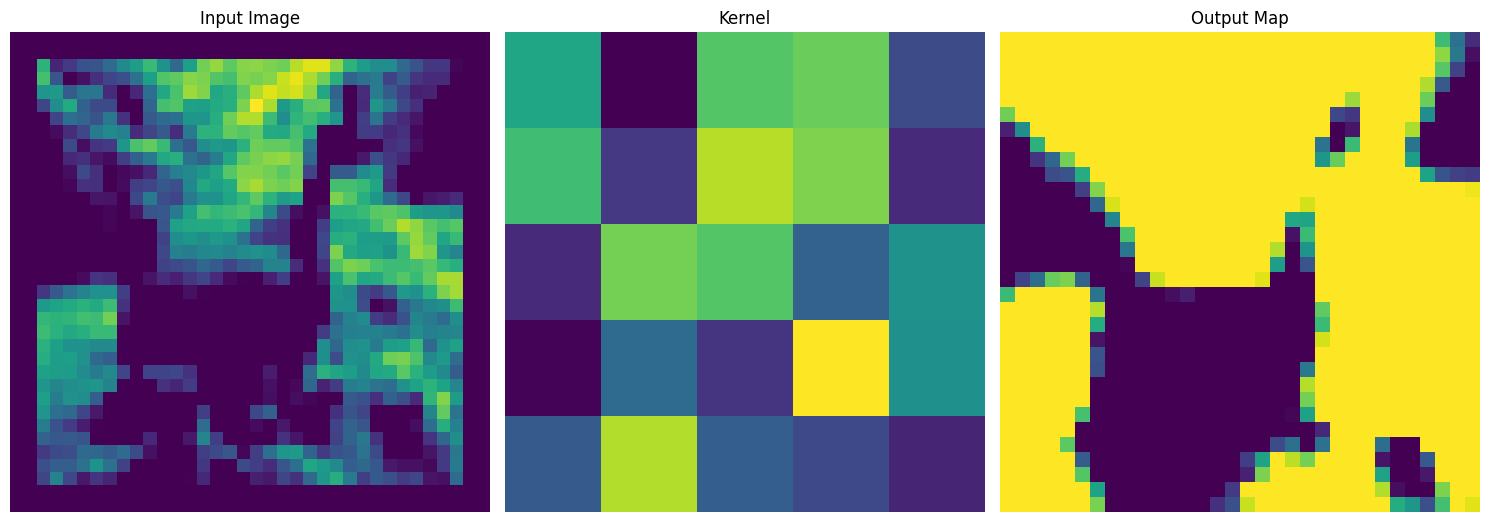

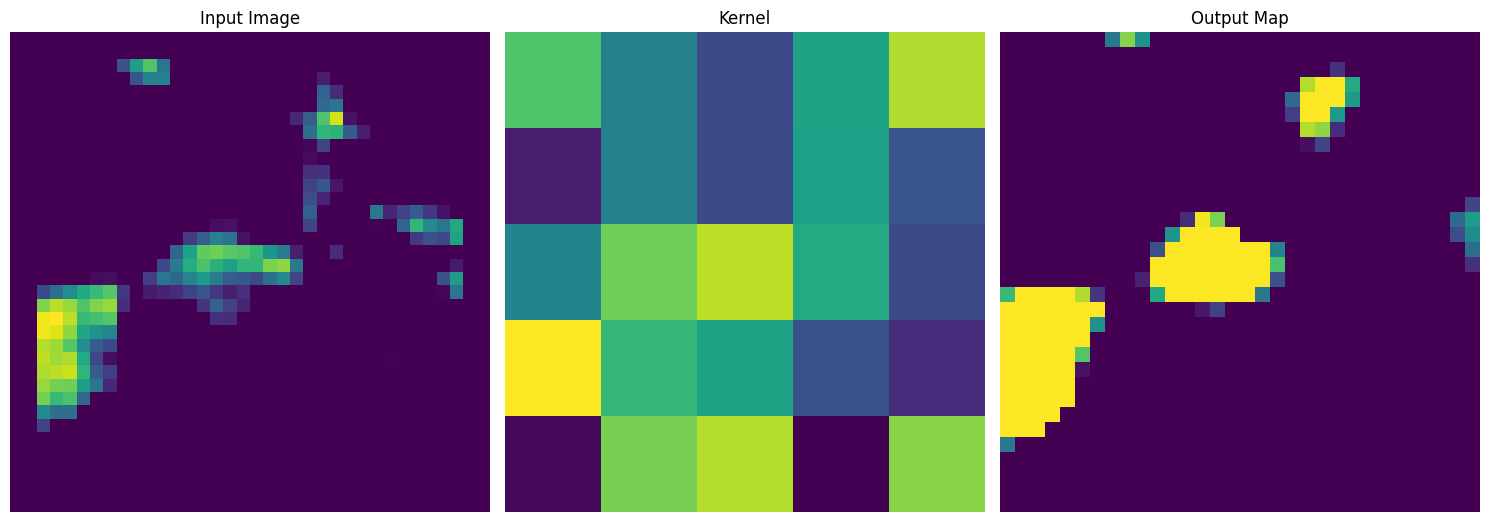

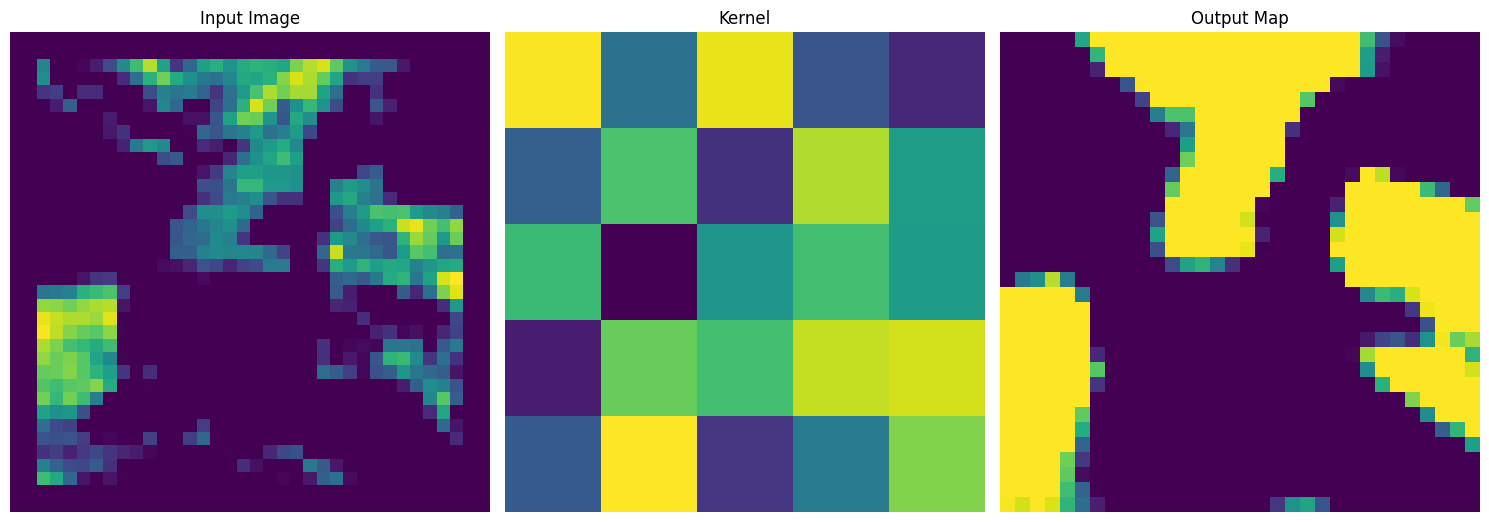

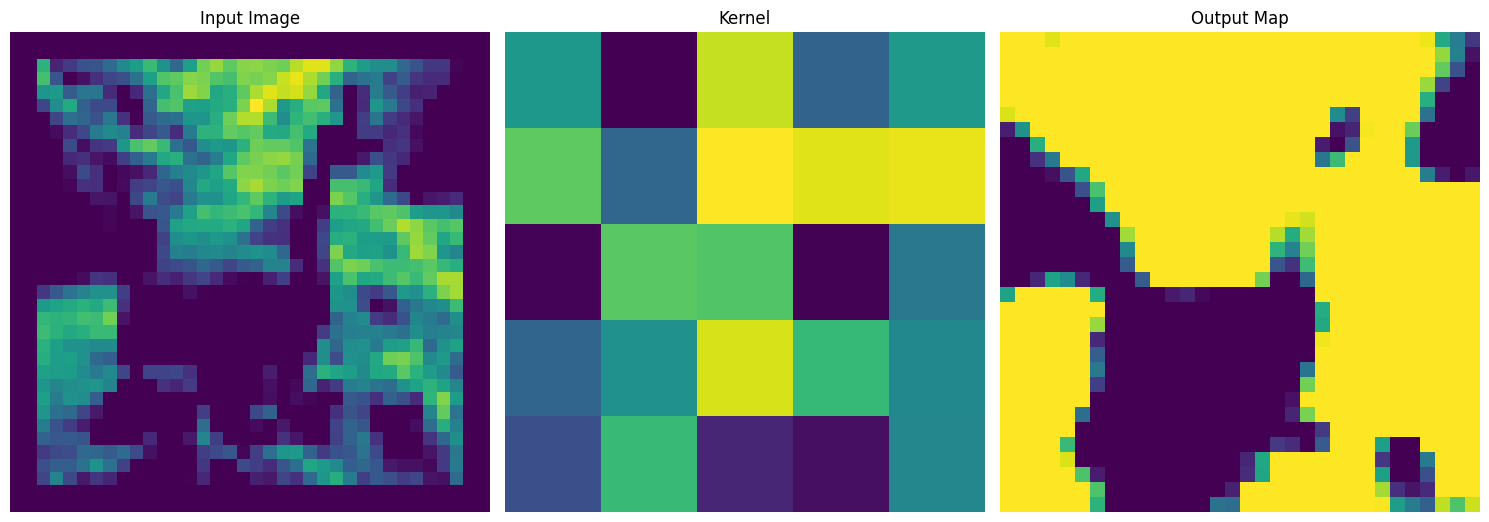

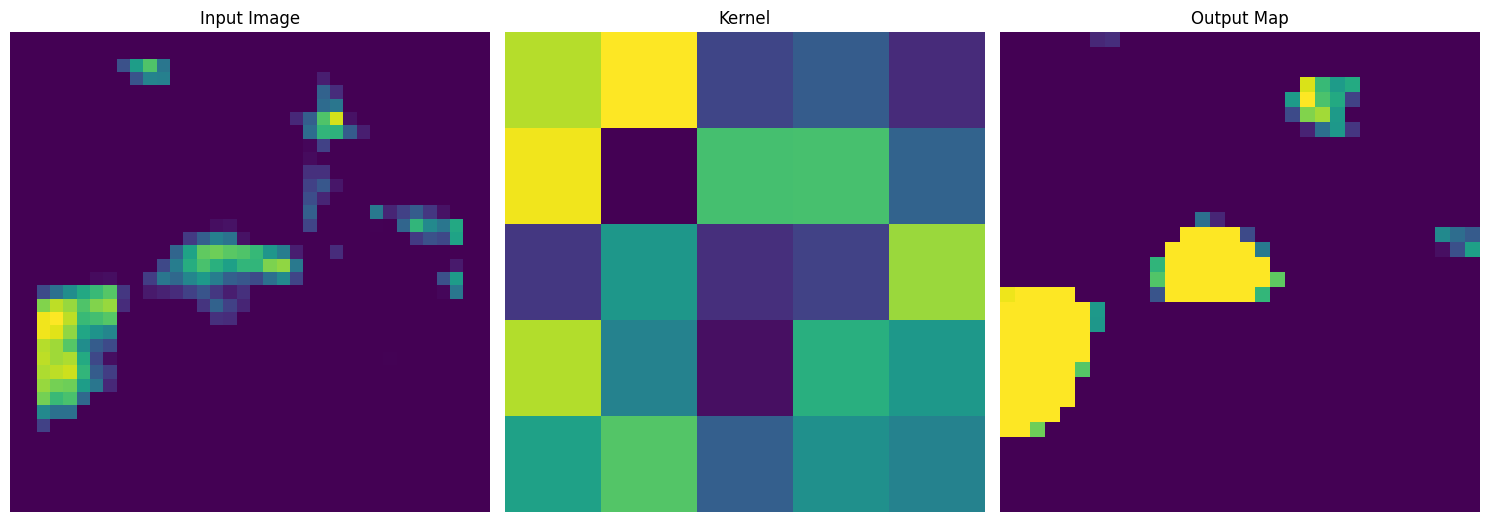

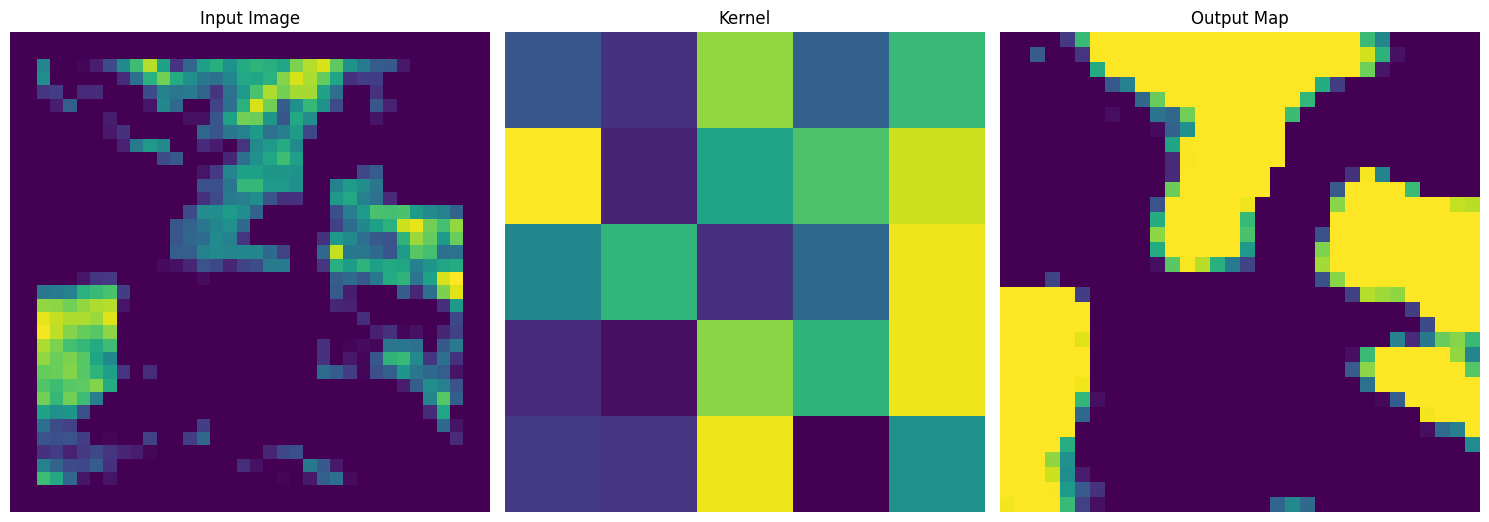

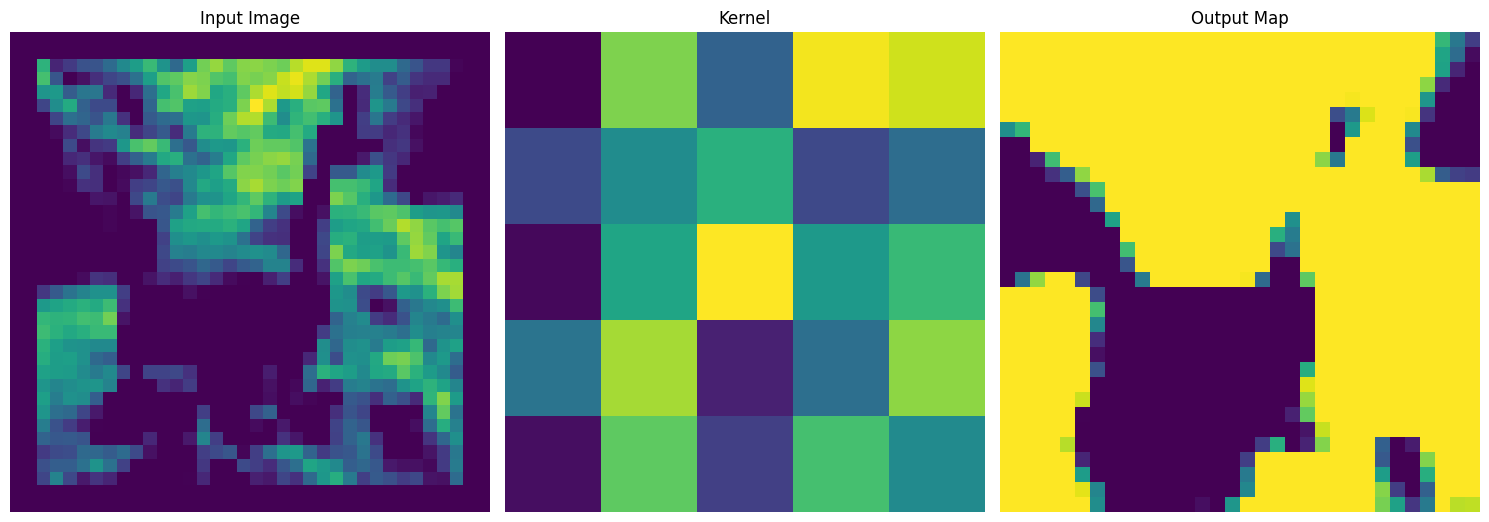

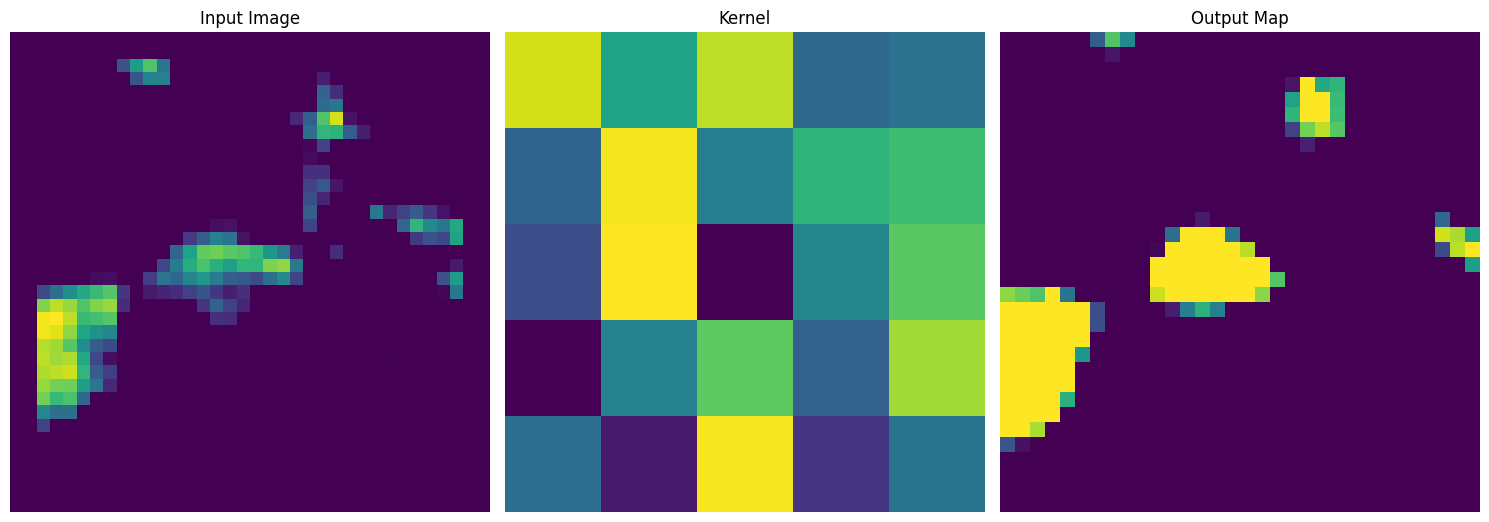

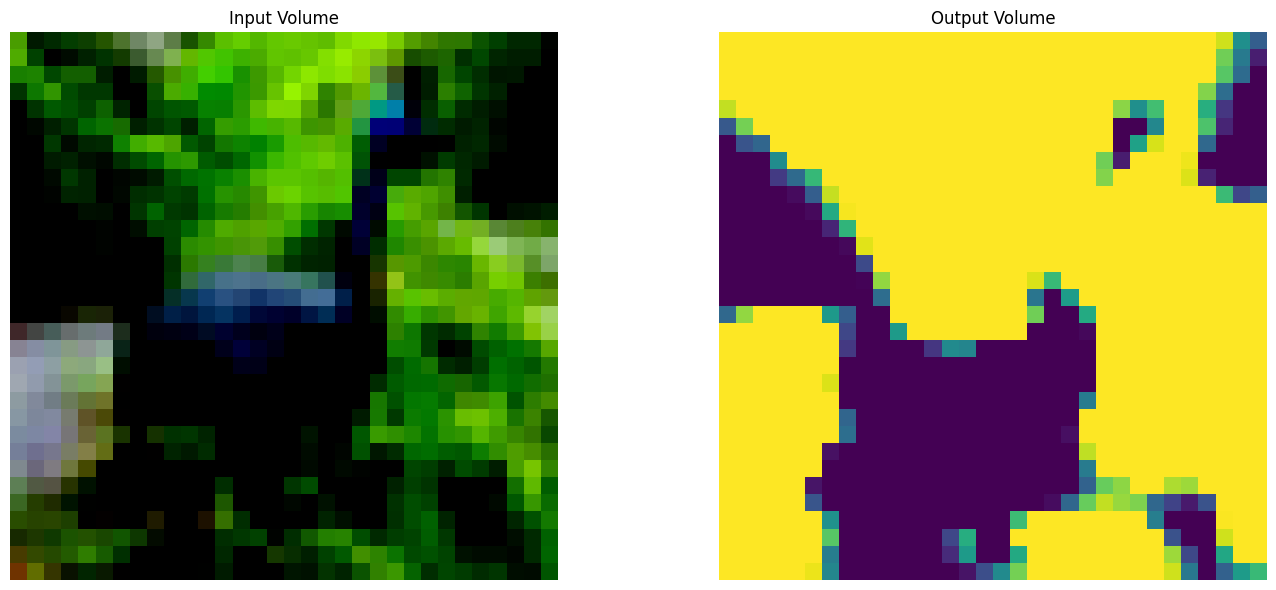

(32, 32, 4)


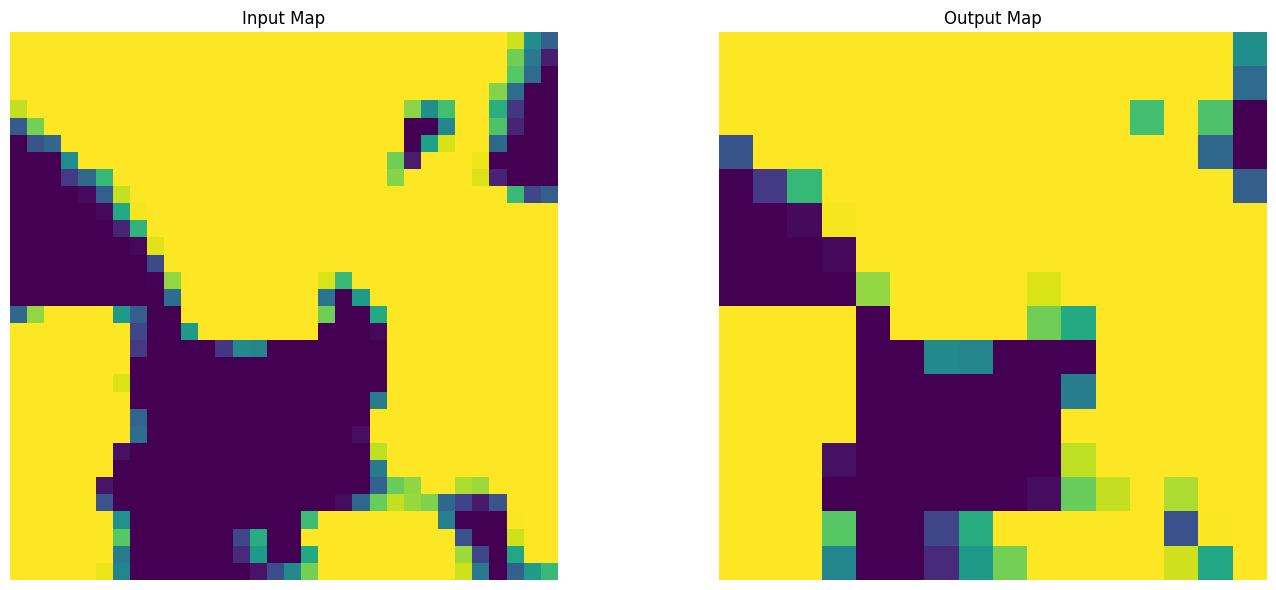

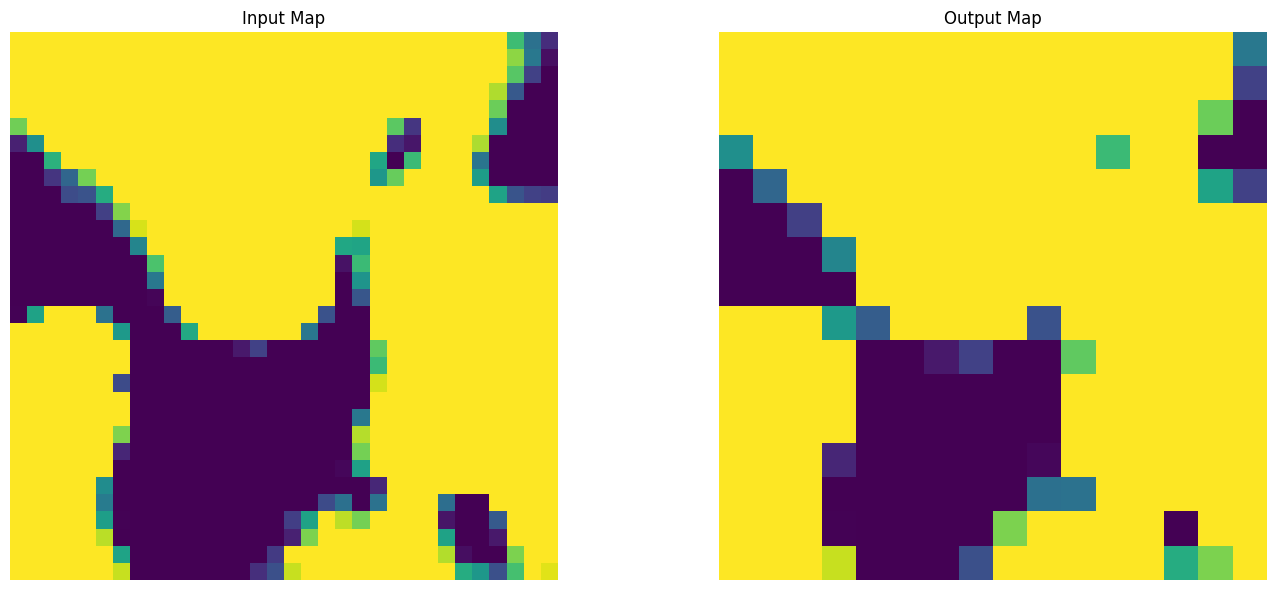

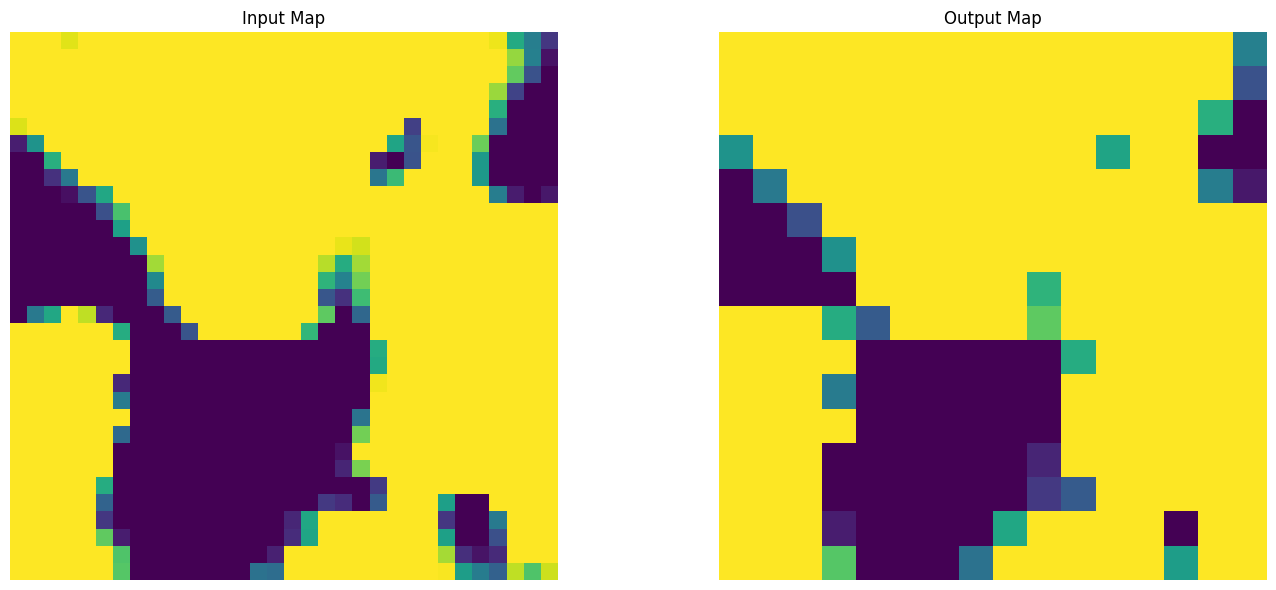

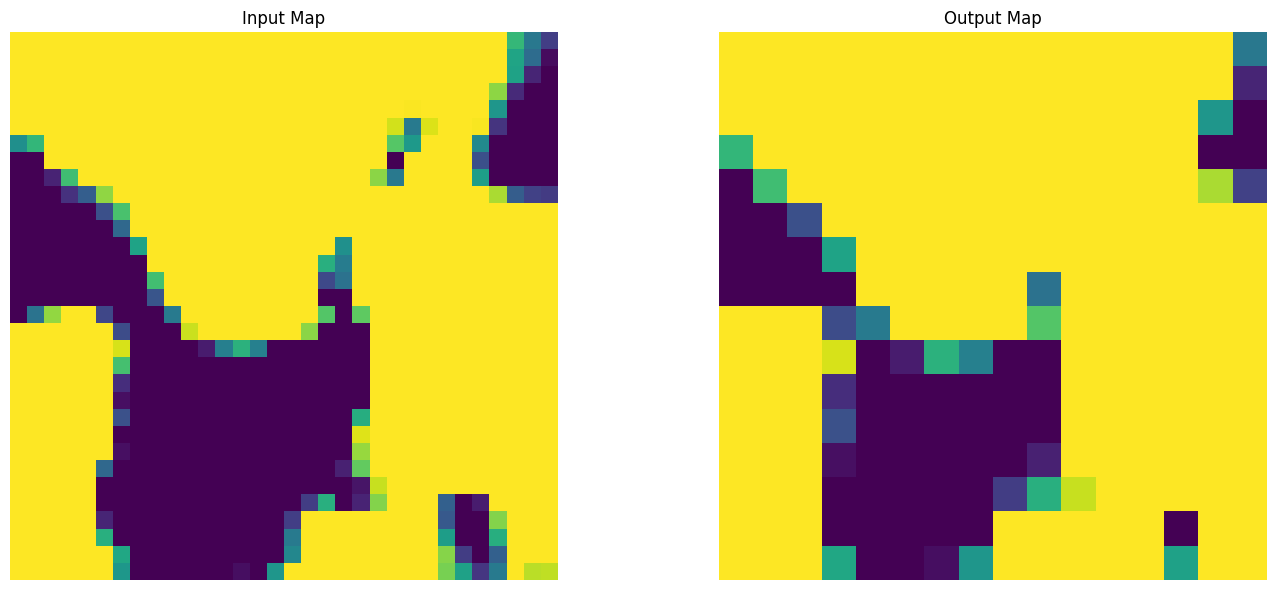

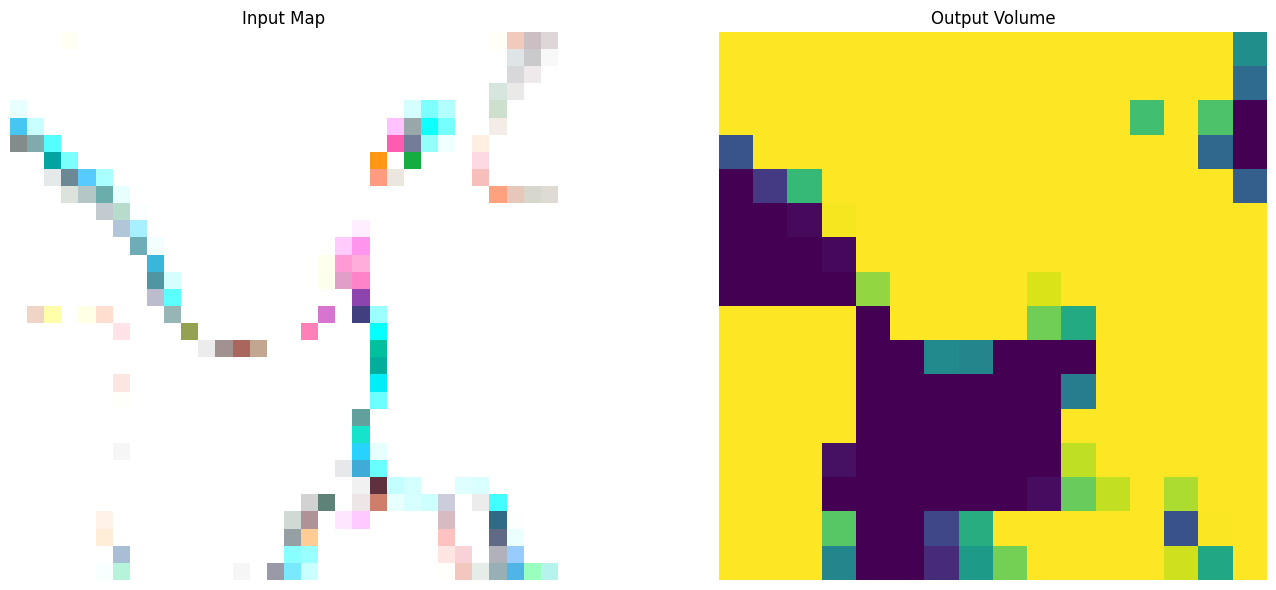

(16, 16, 4)


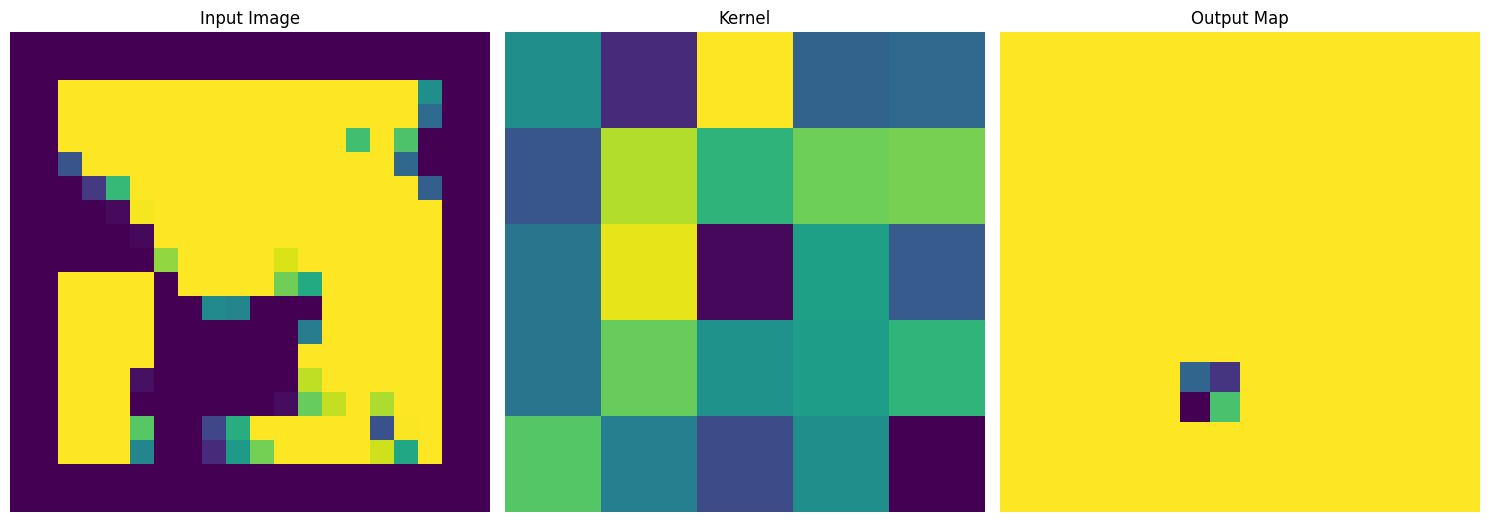

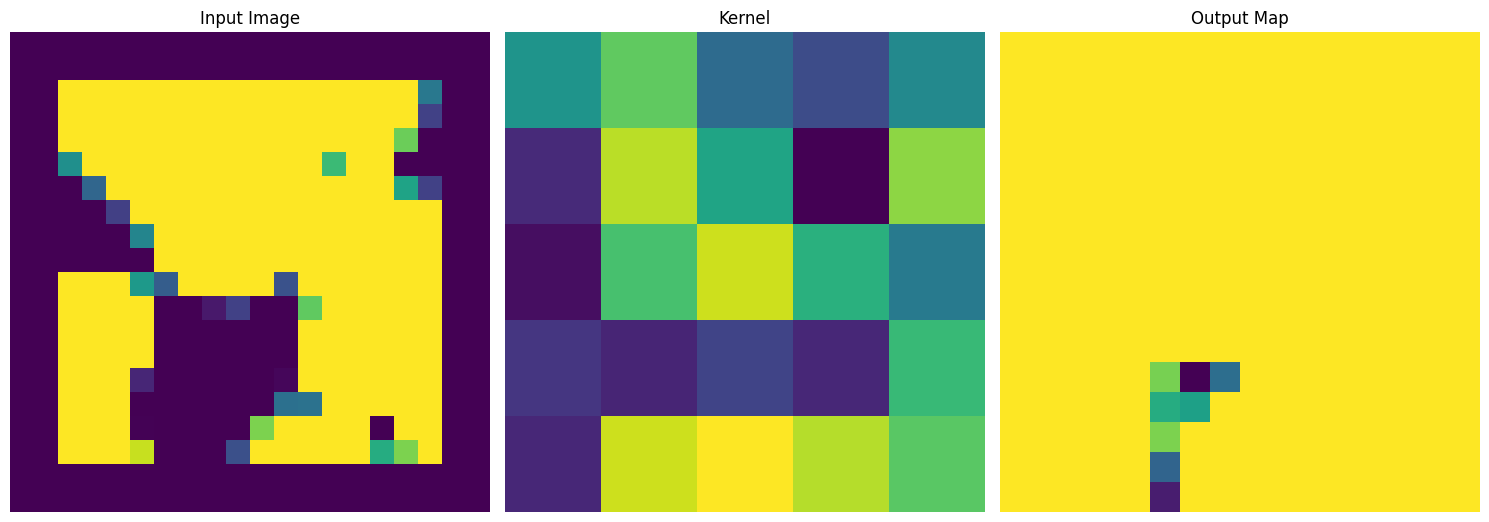

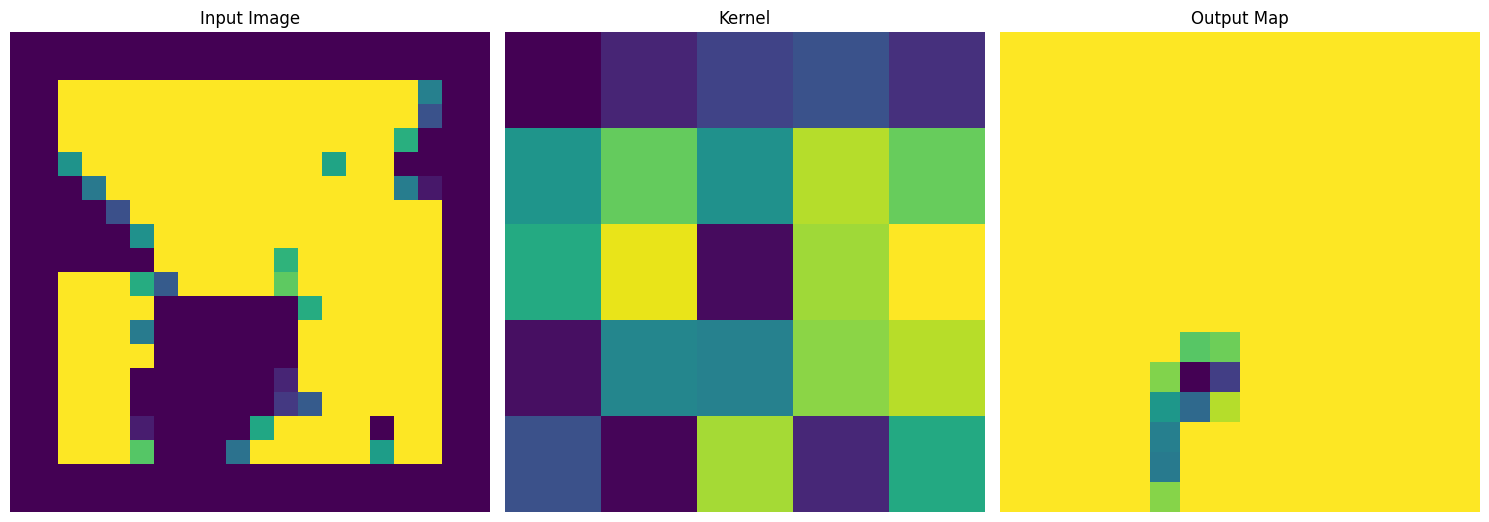

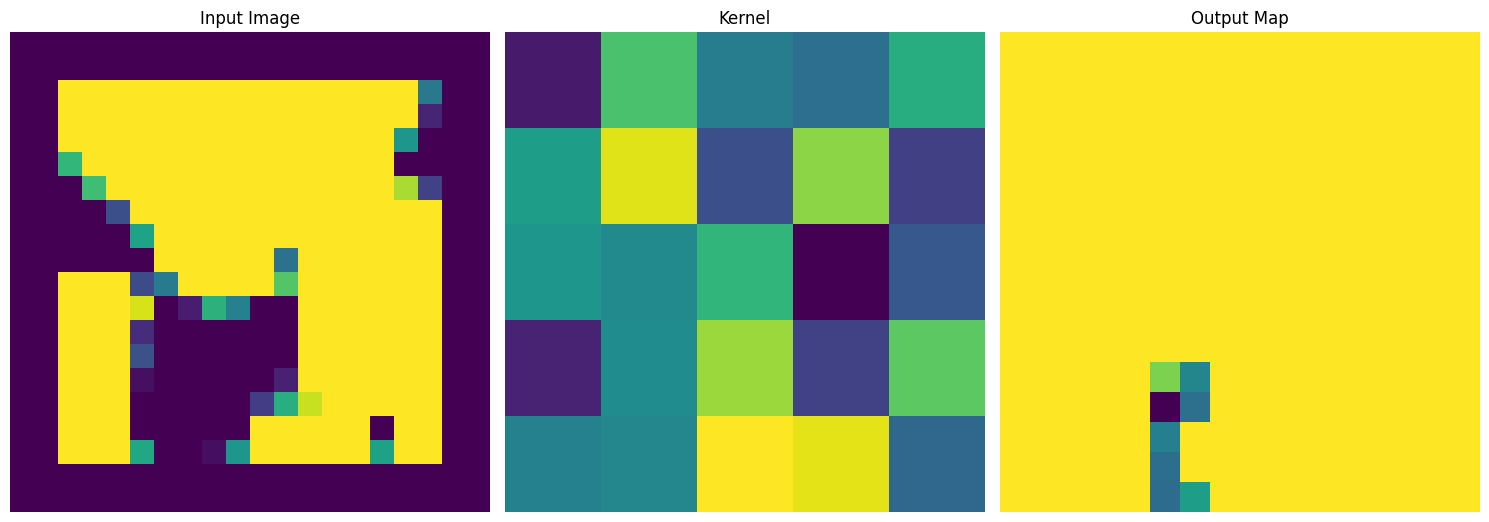

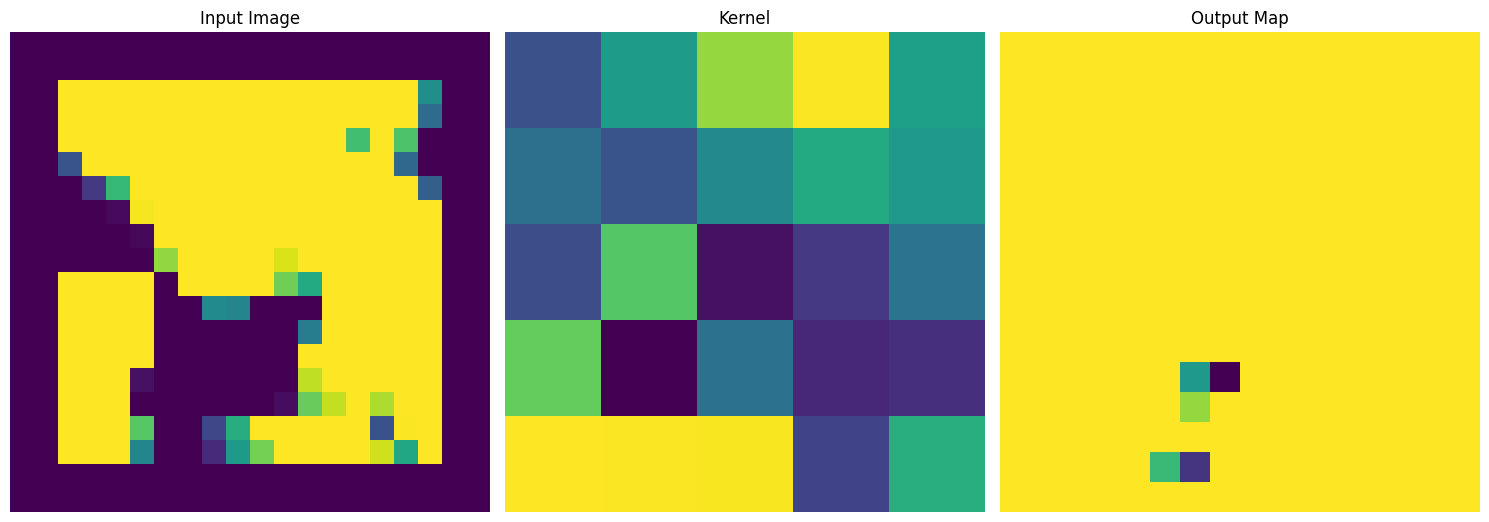

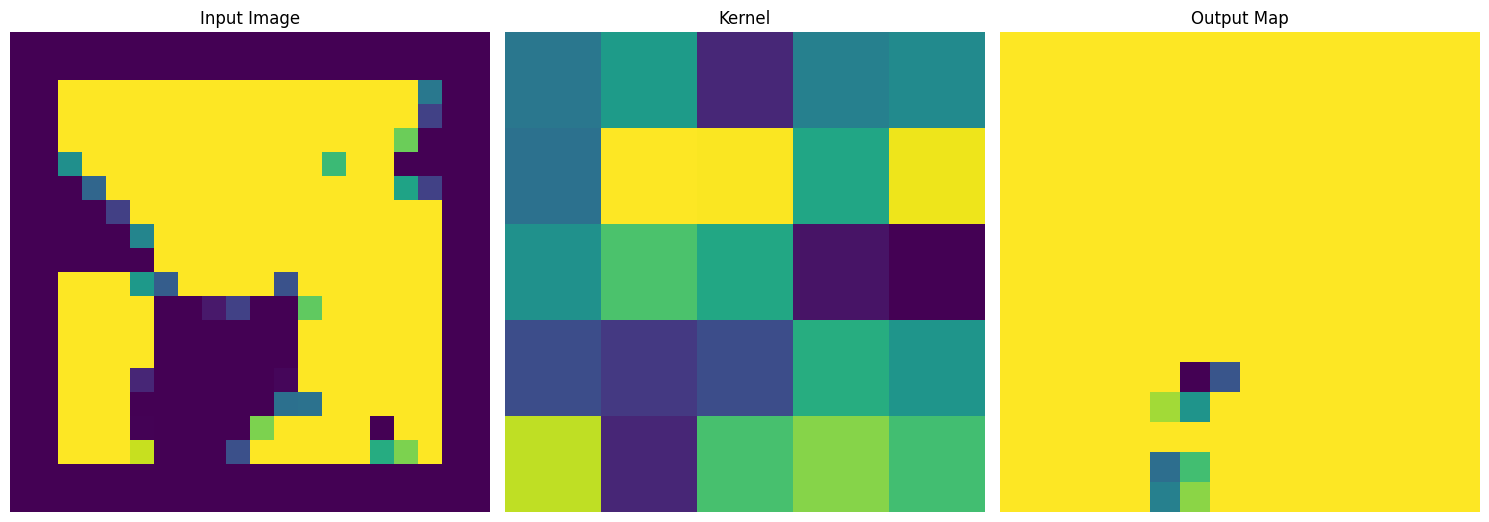

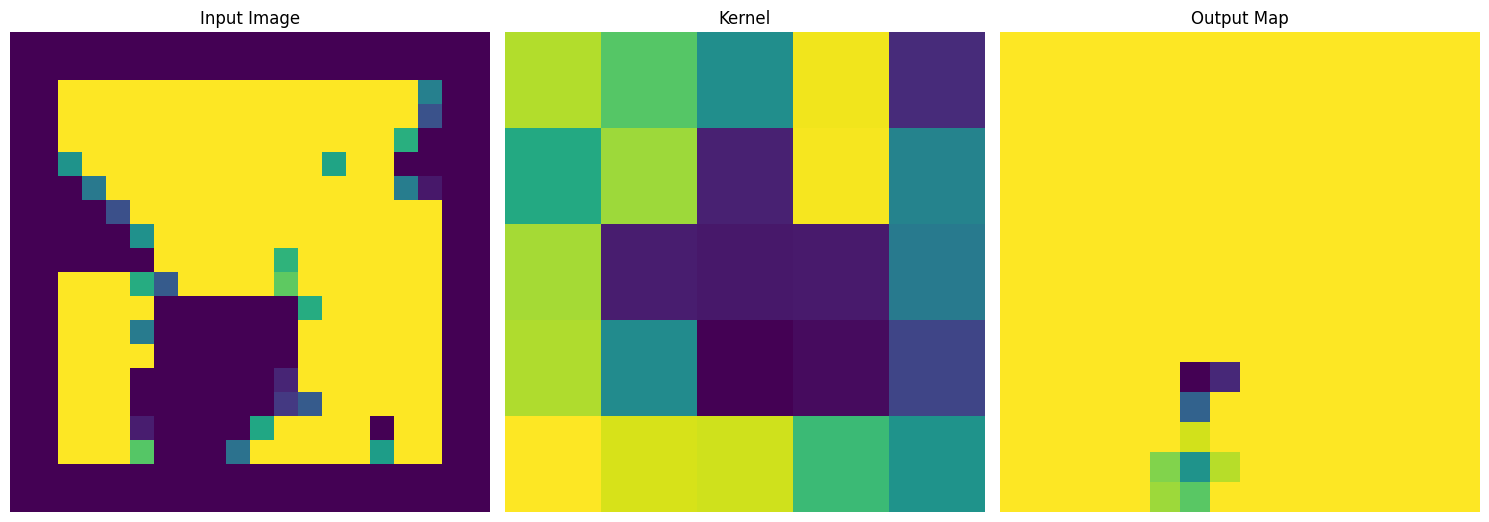

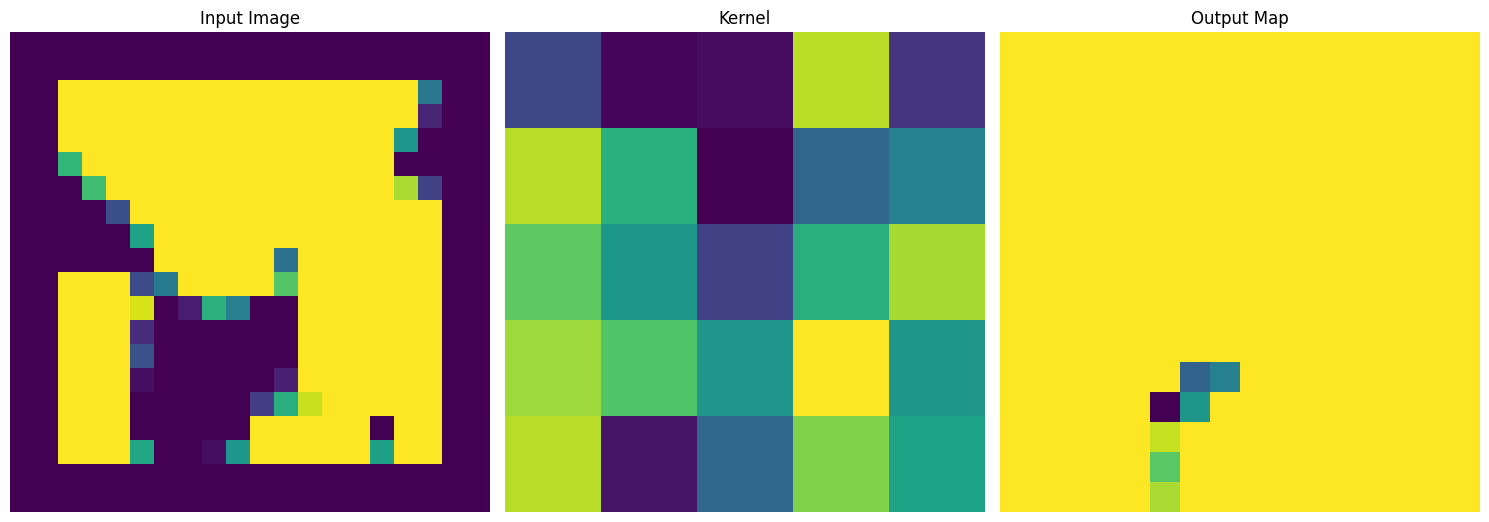

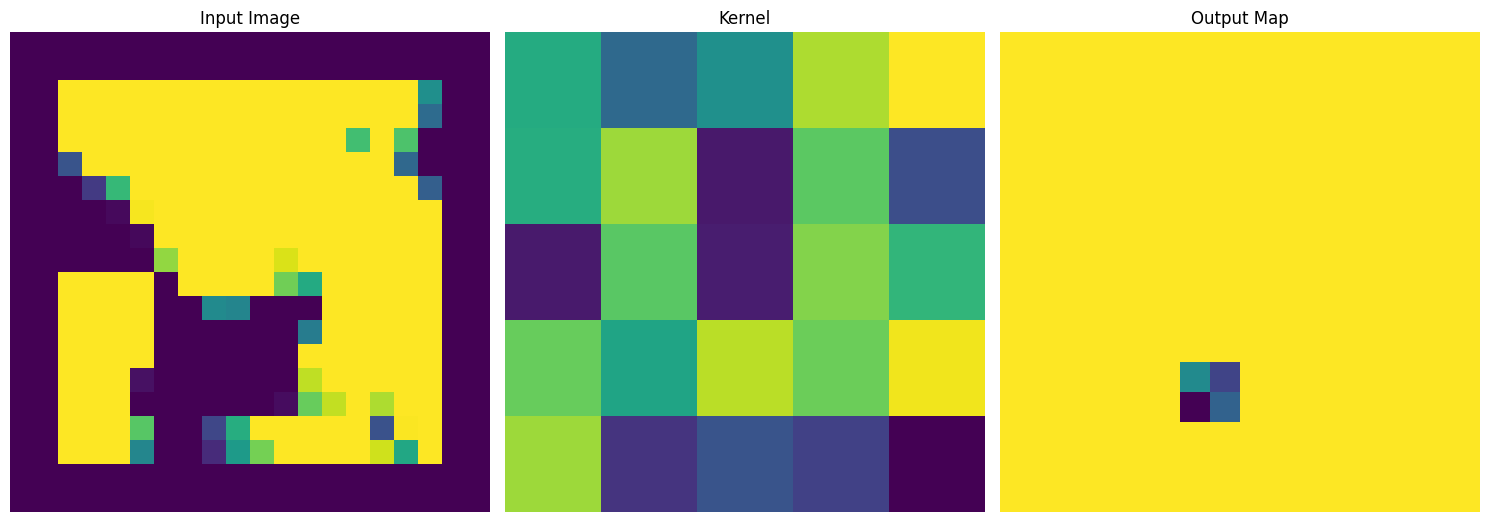

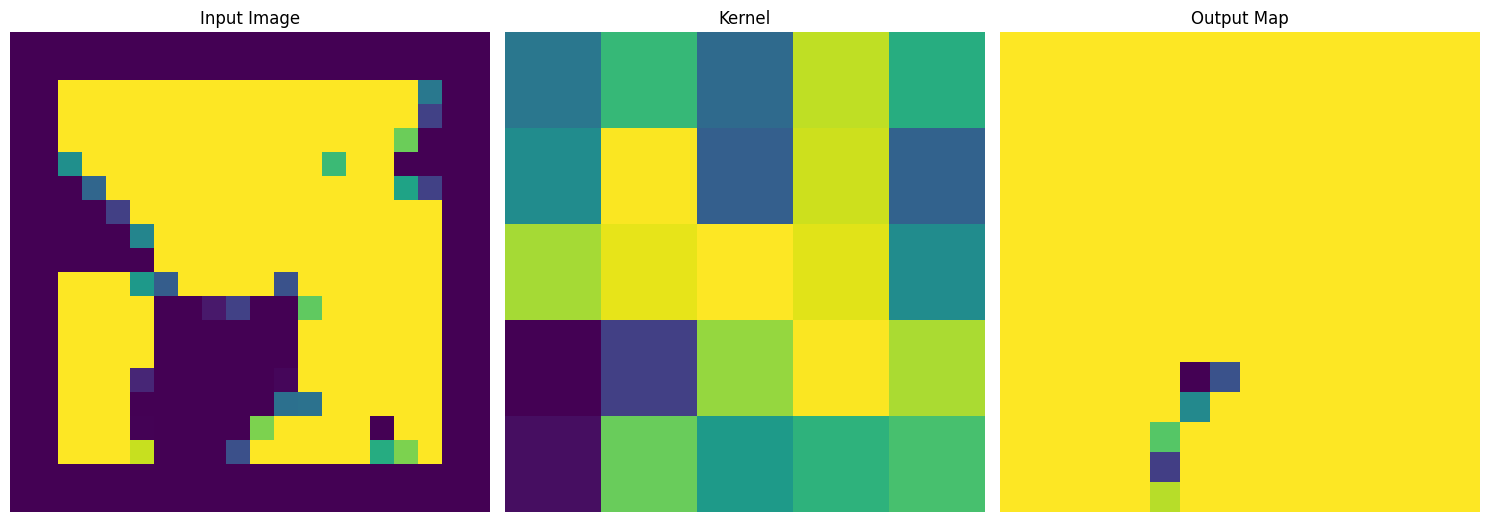

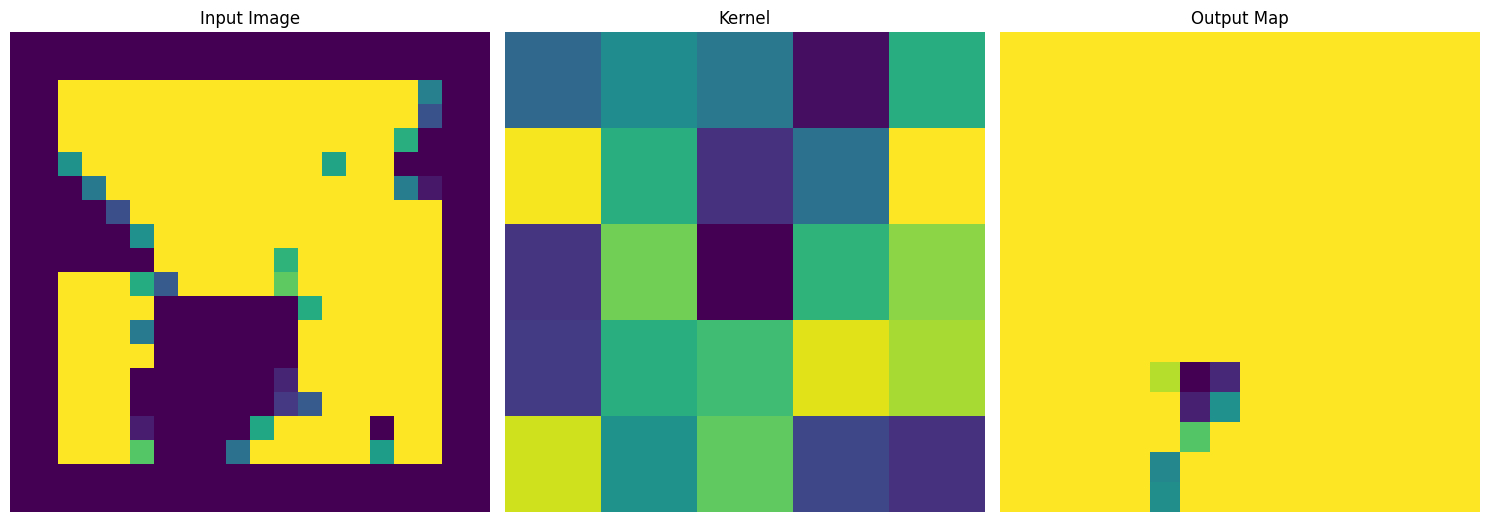

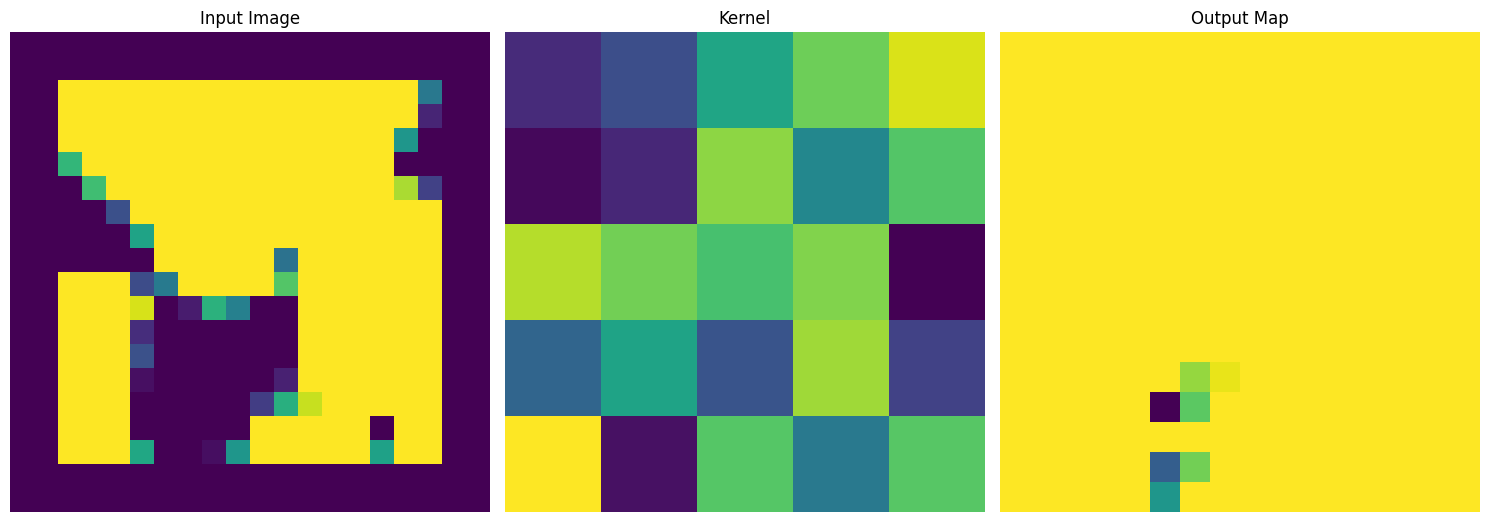

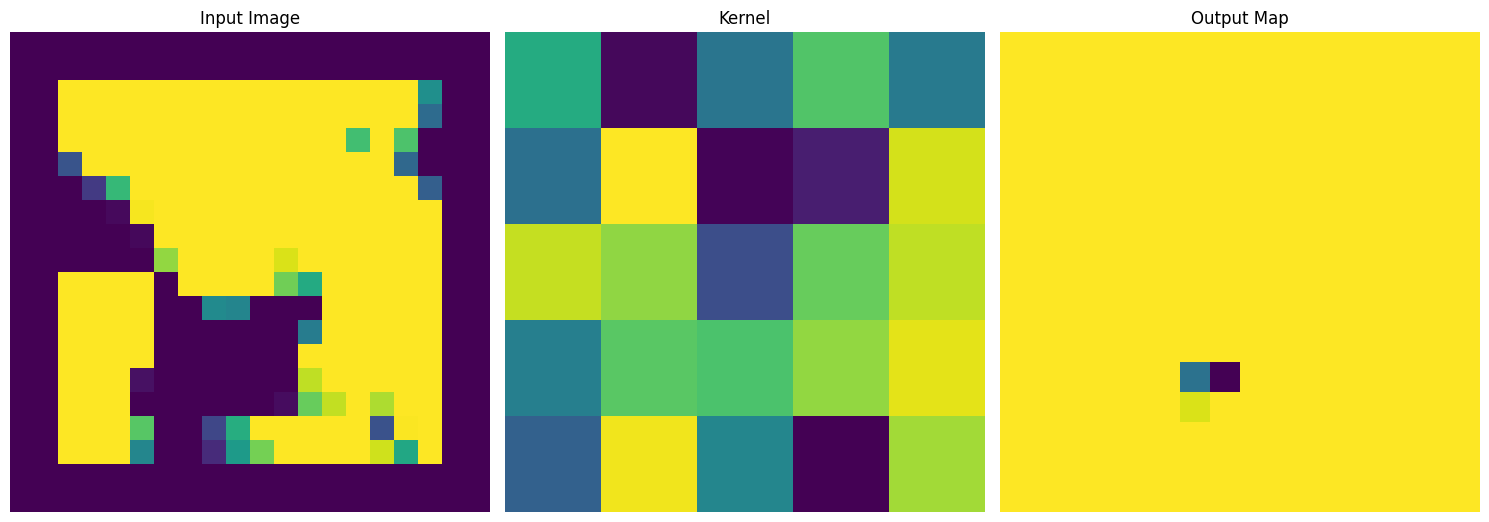

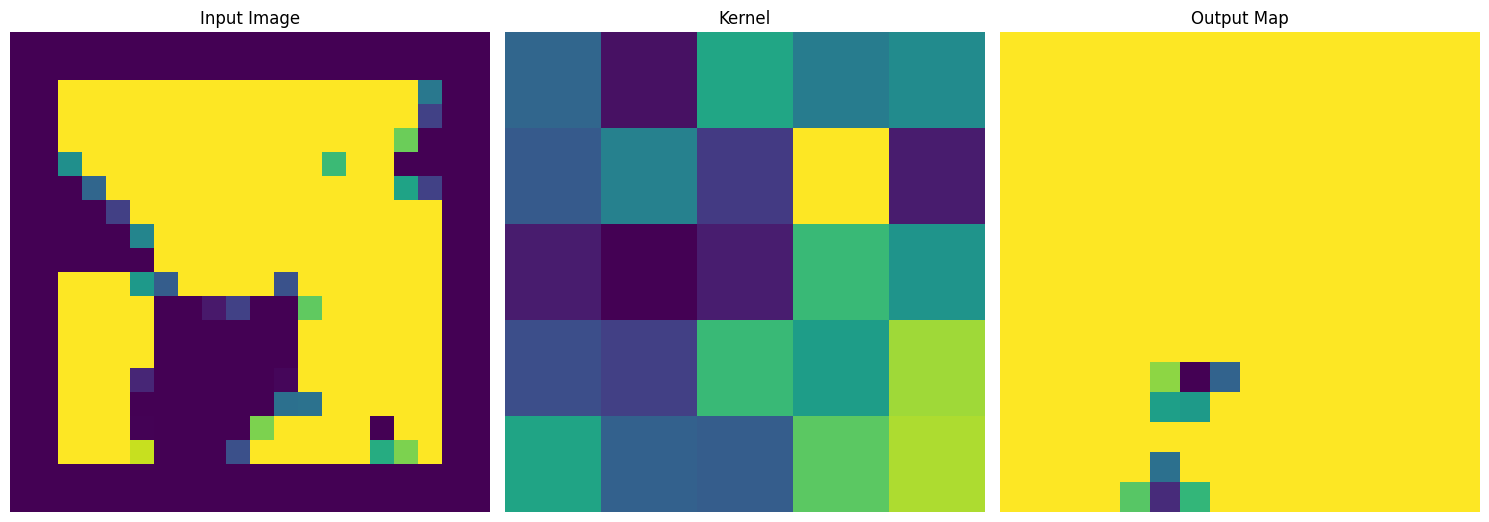

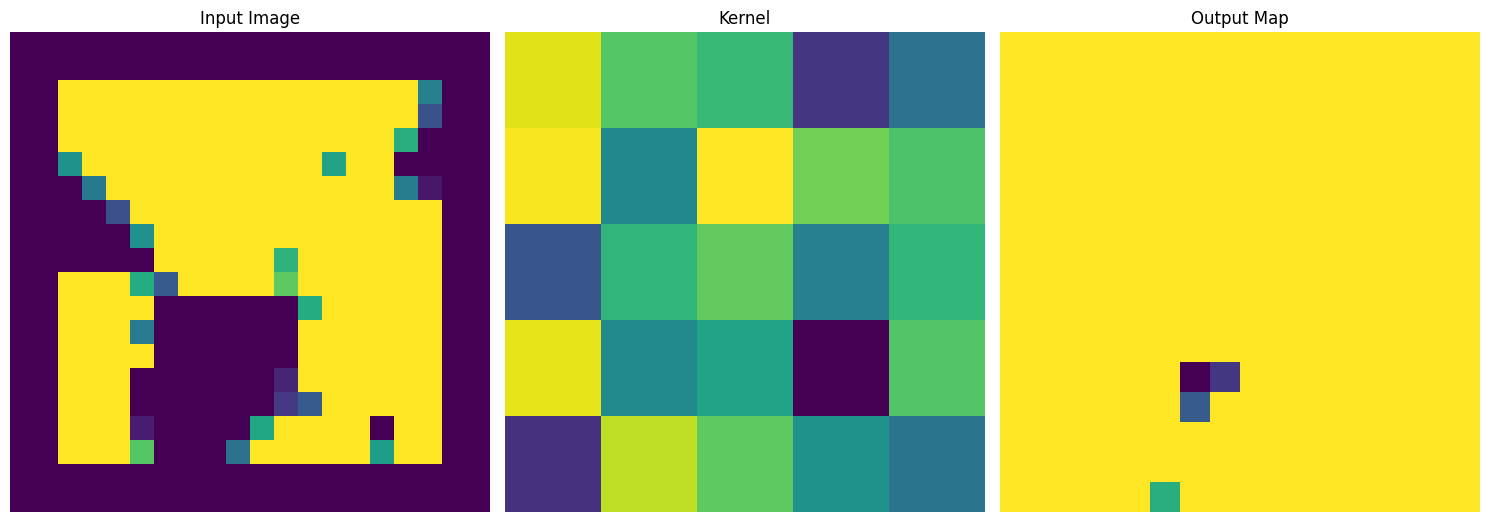

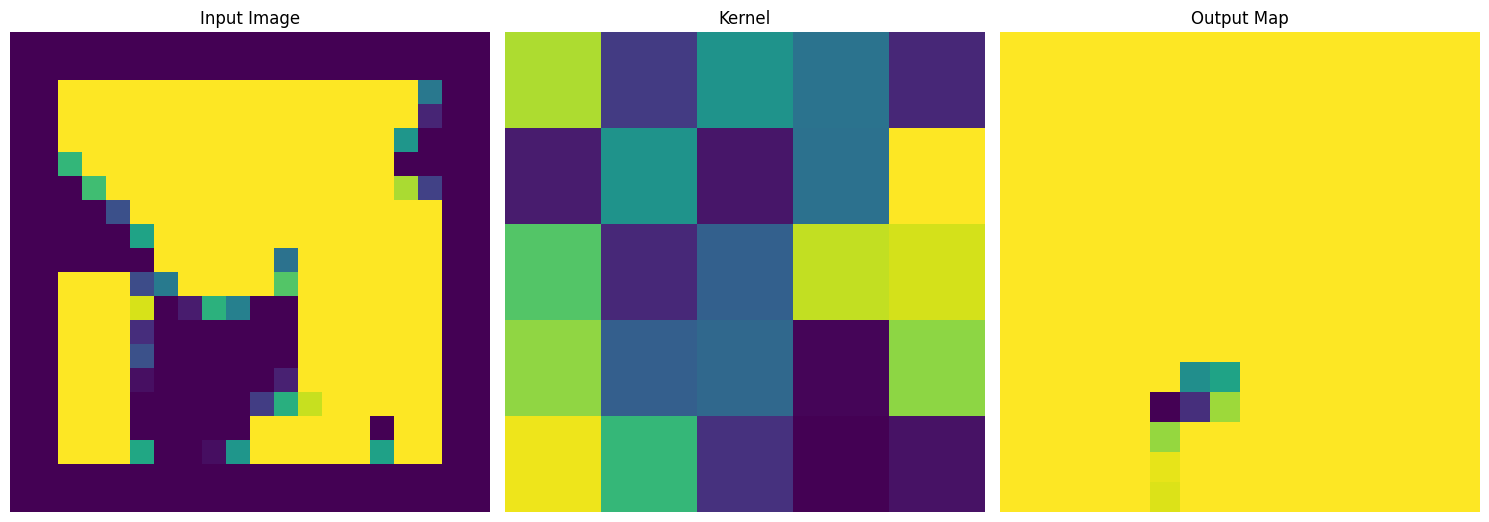

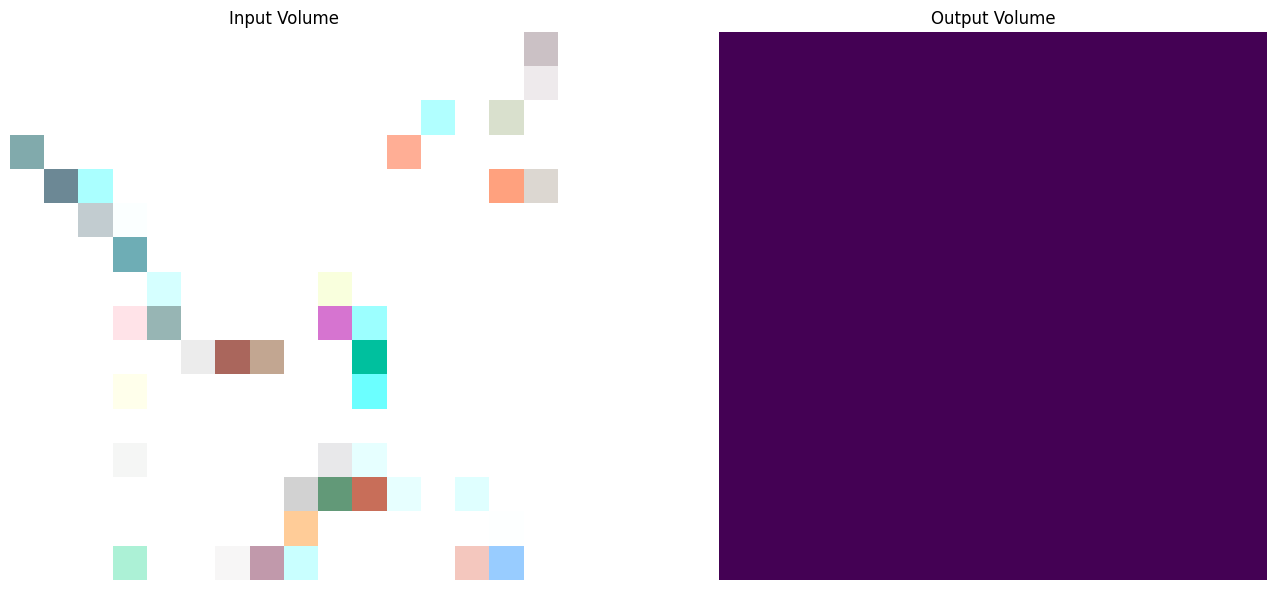

(16, 16, 4)


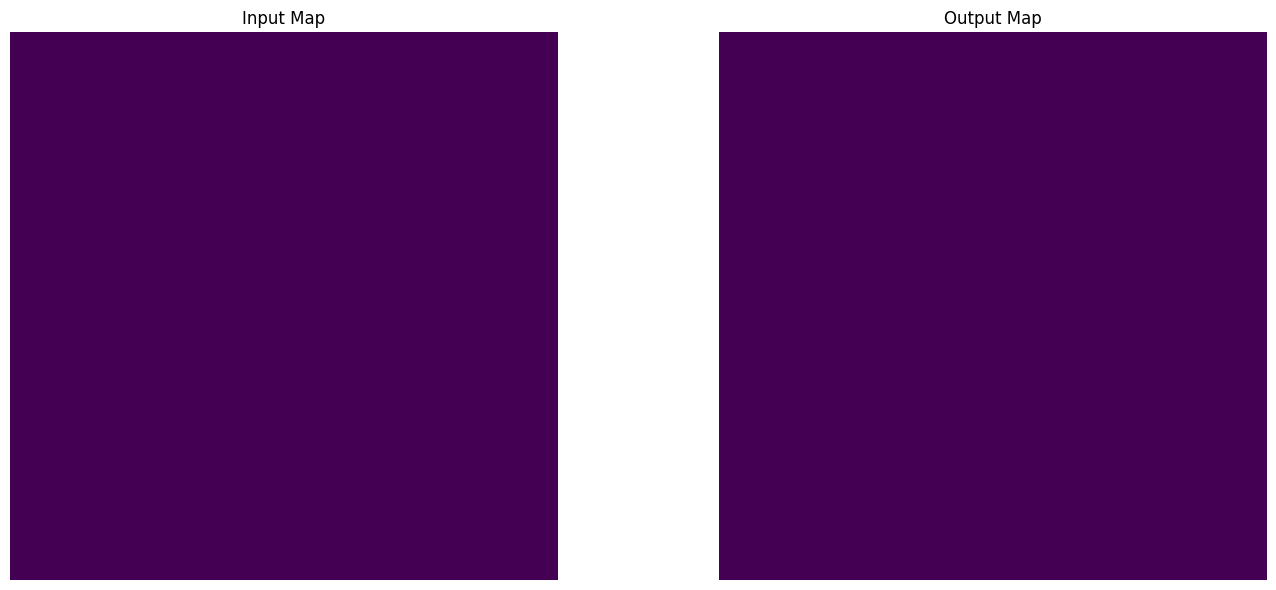

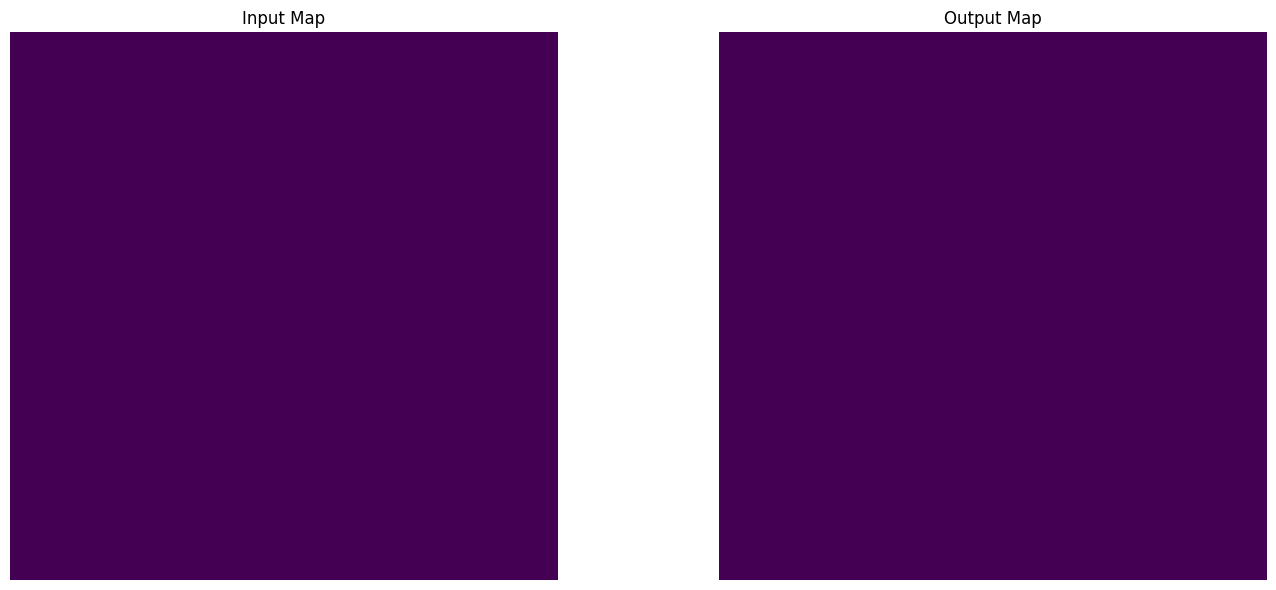

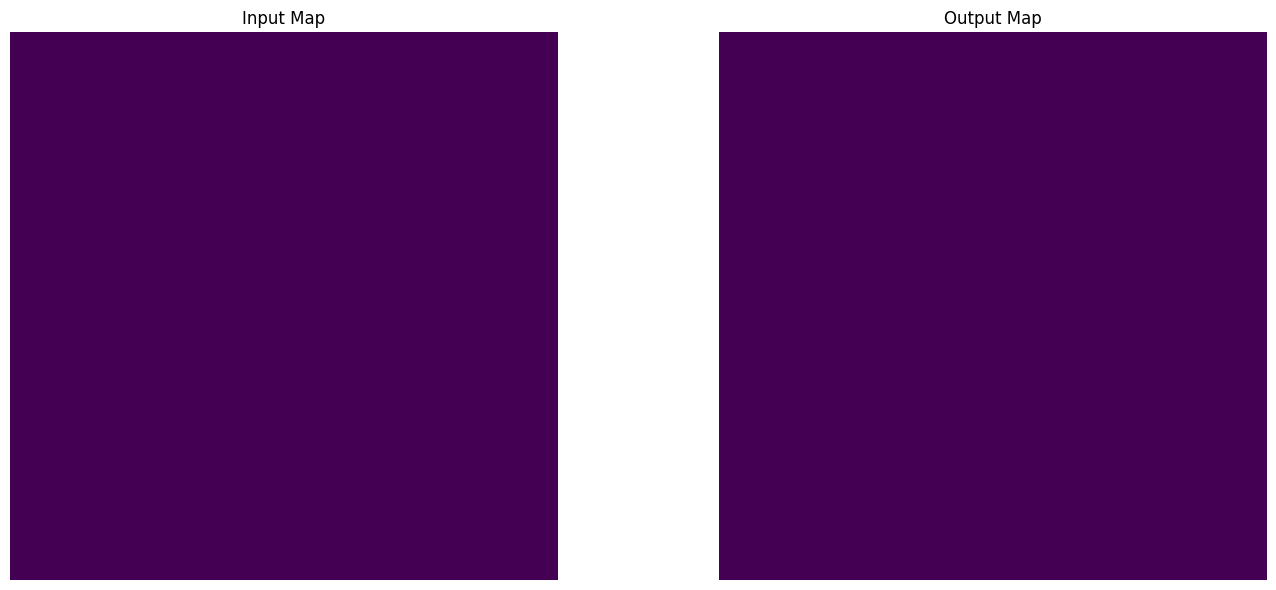

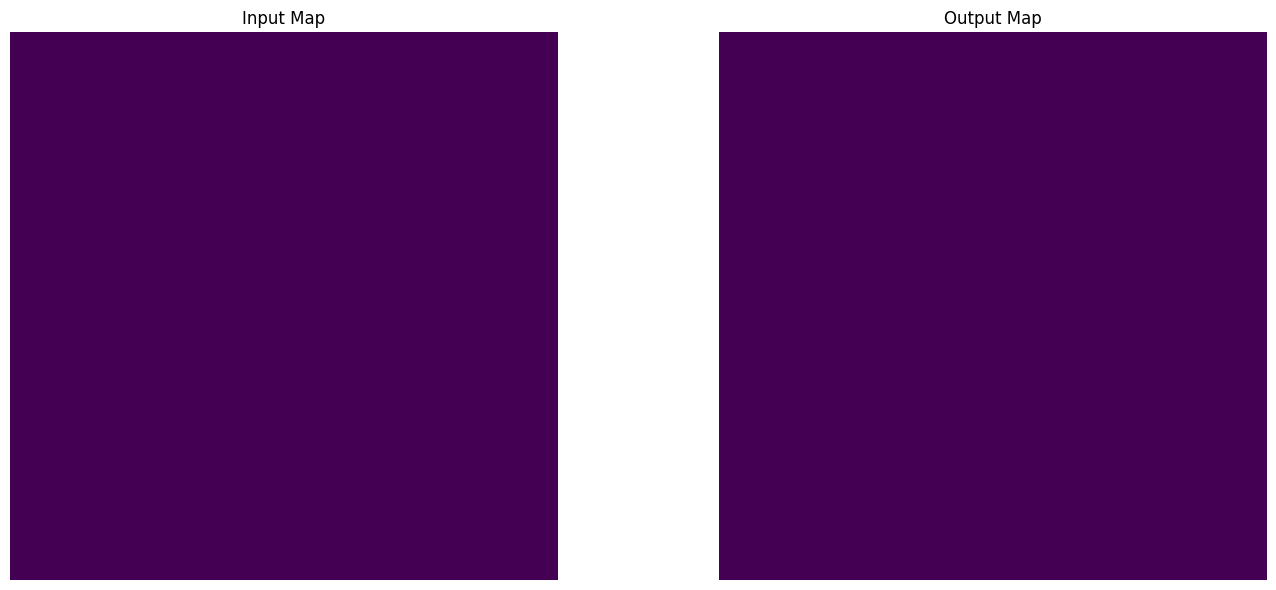

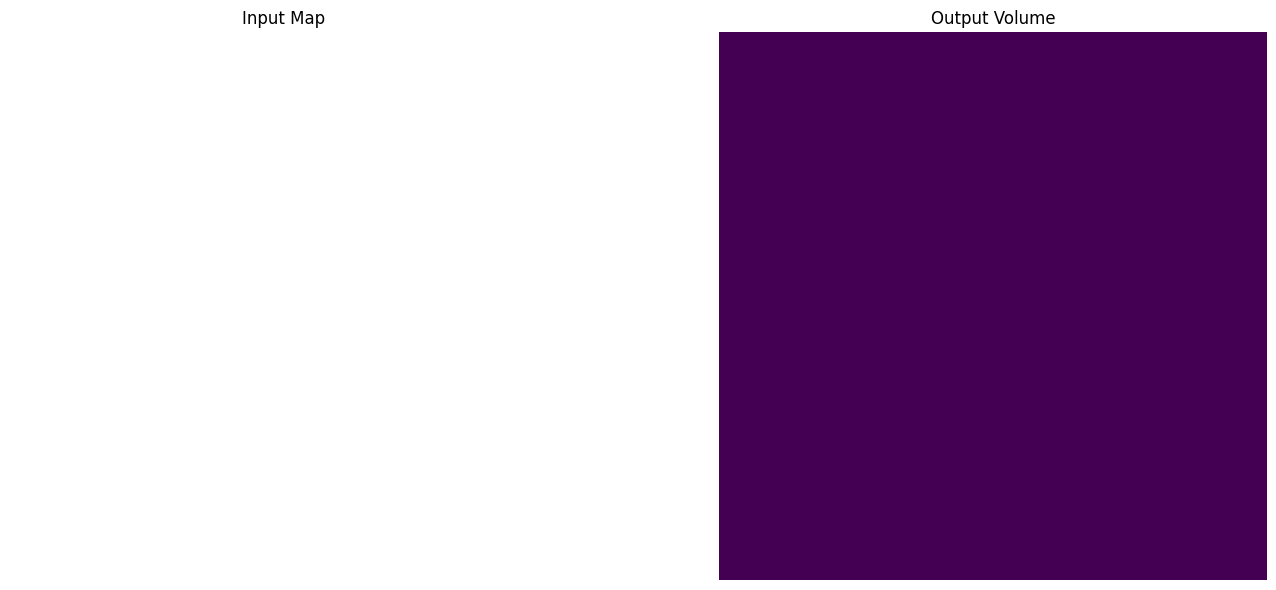

(8, 8, 4)


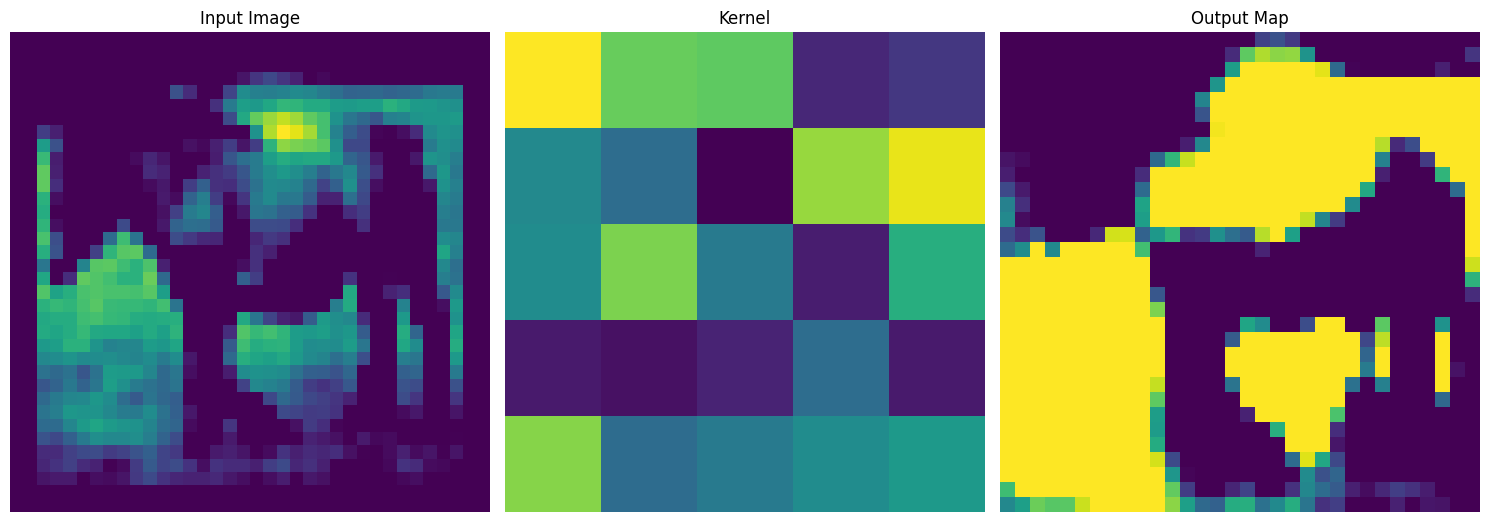

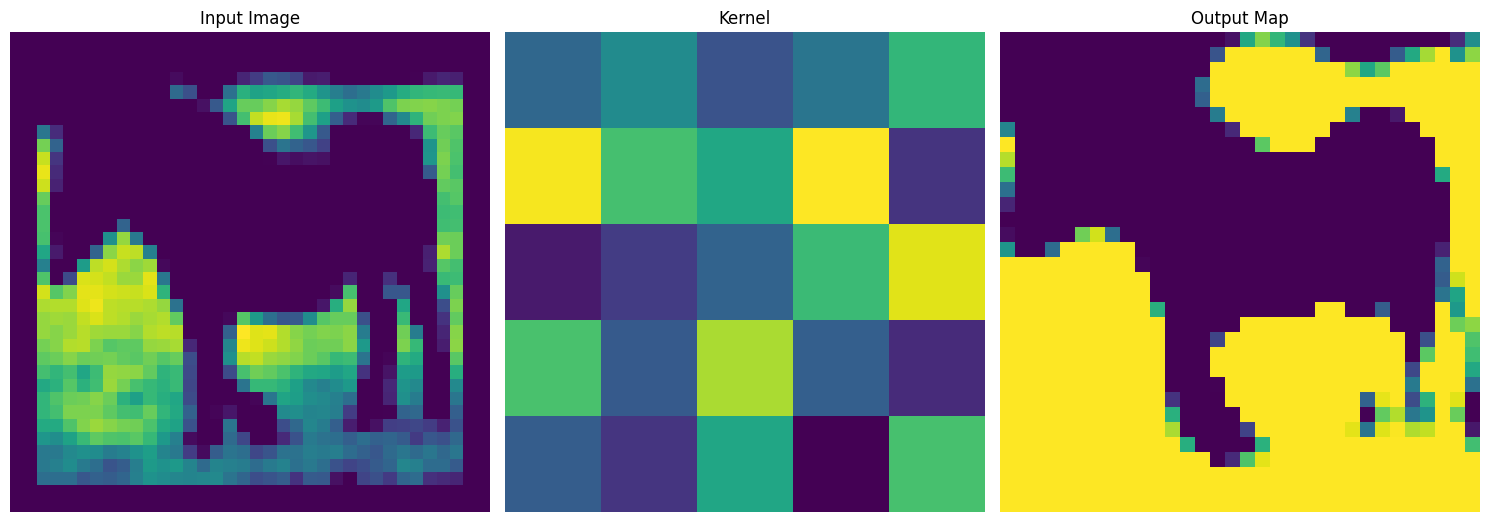

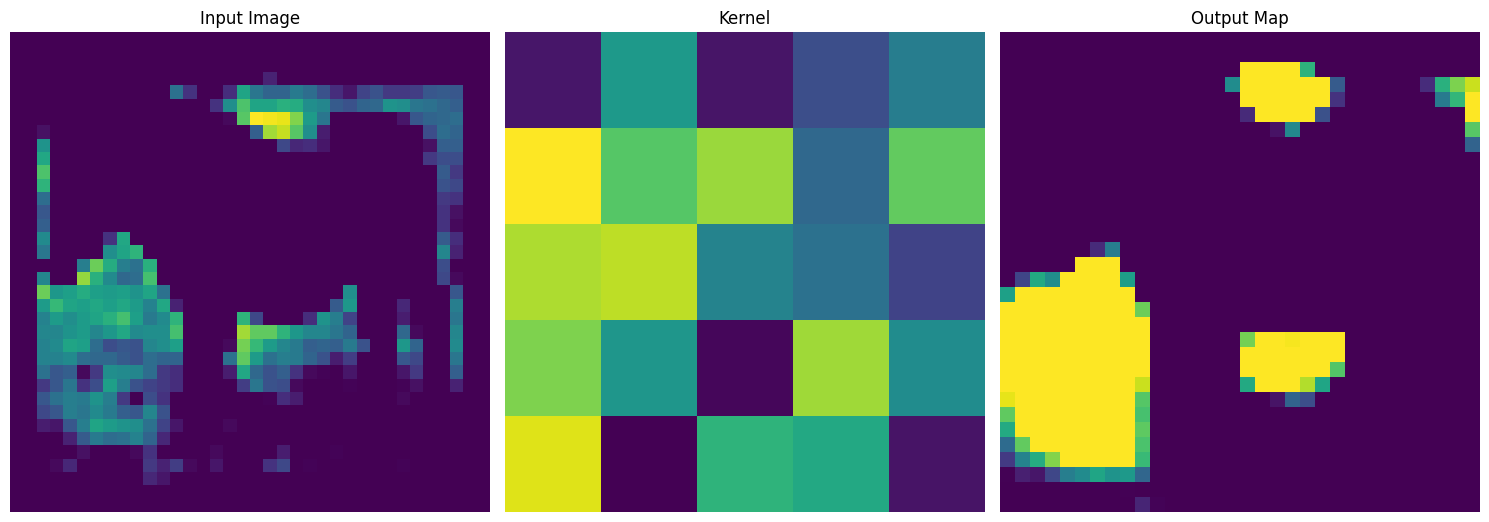

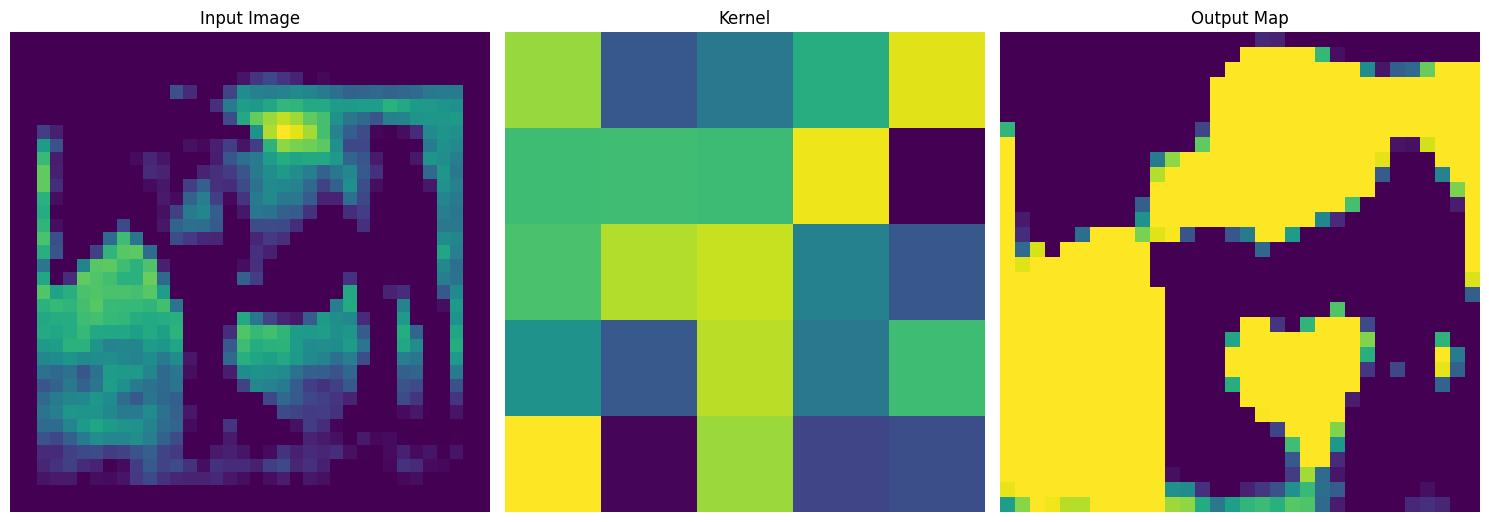

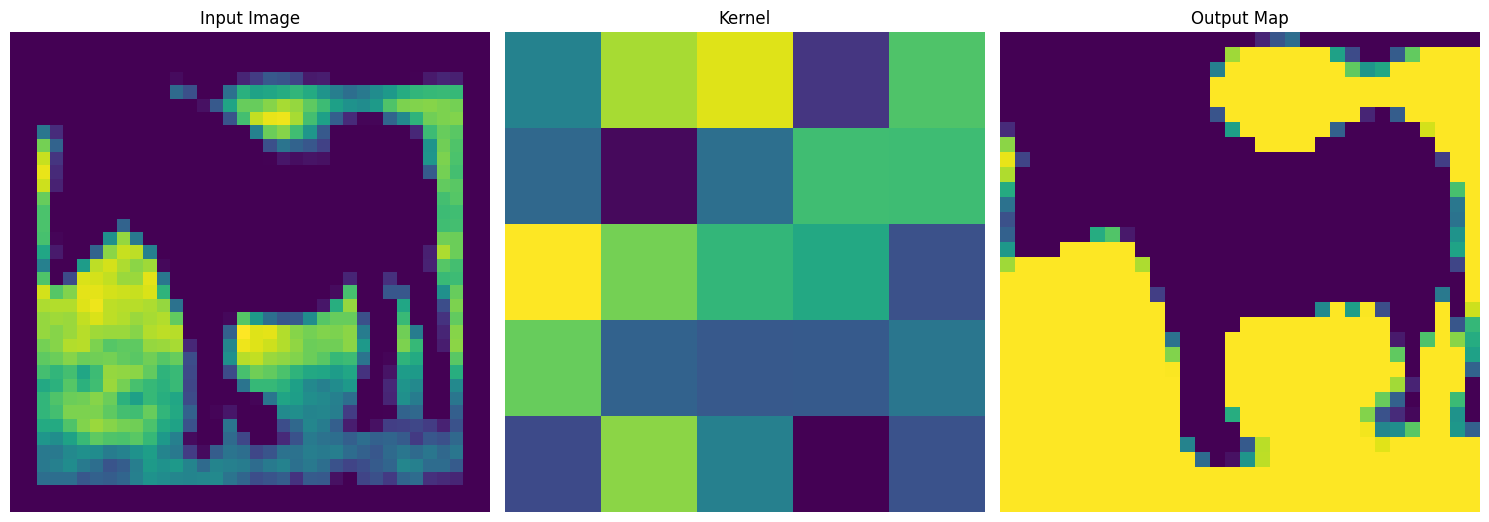

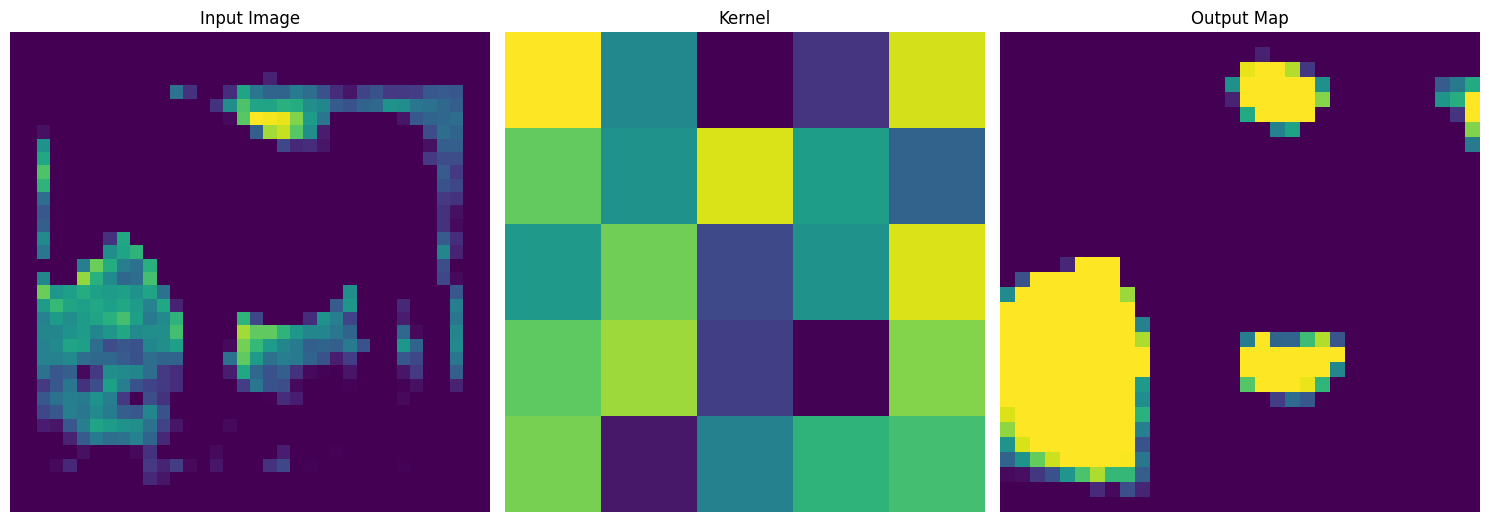

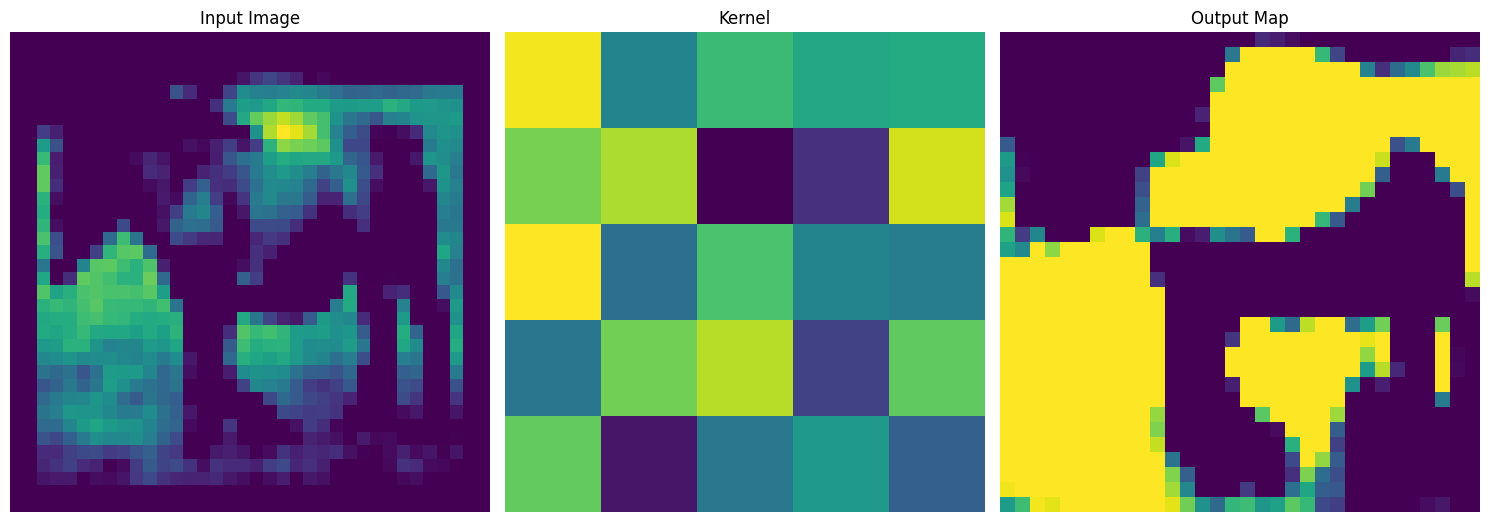

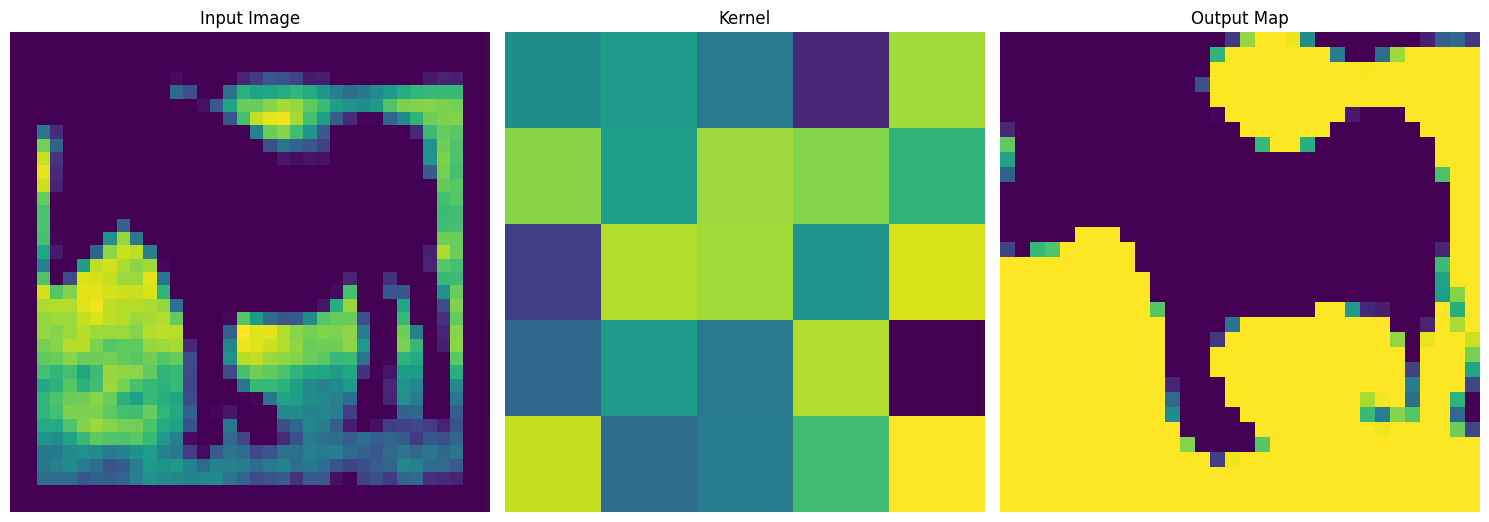

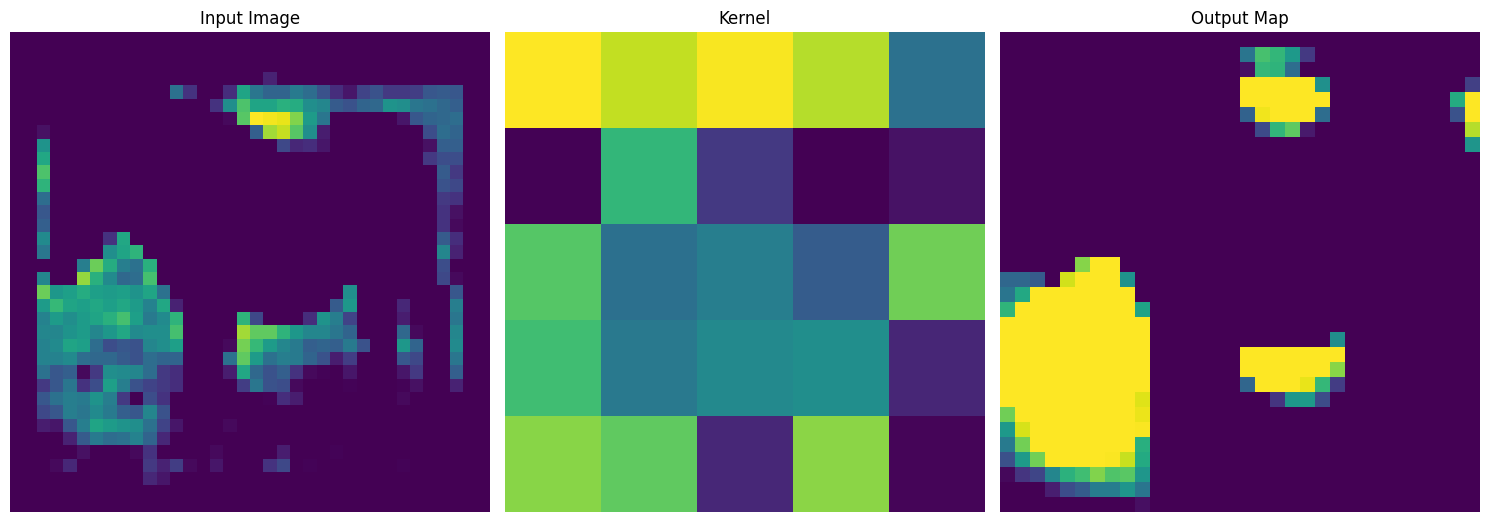

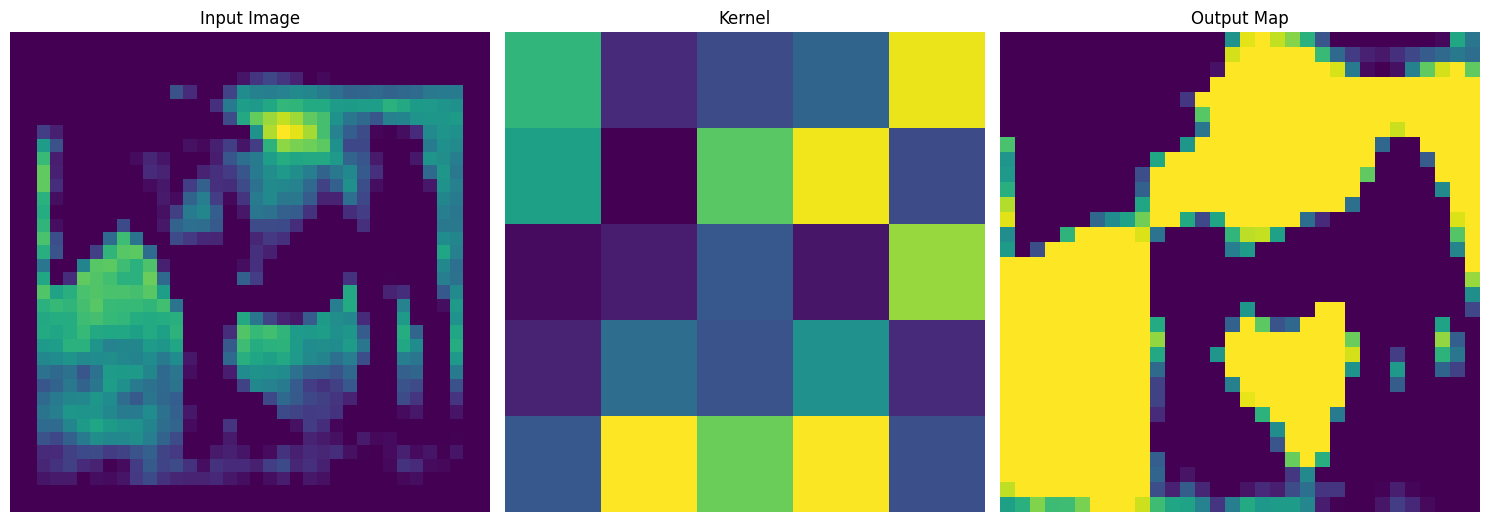

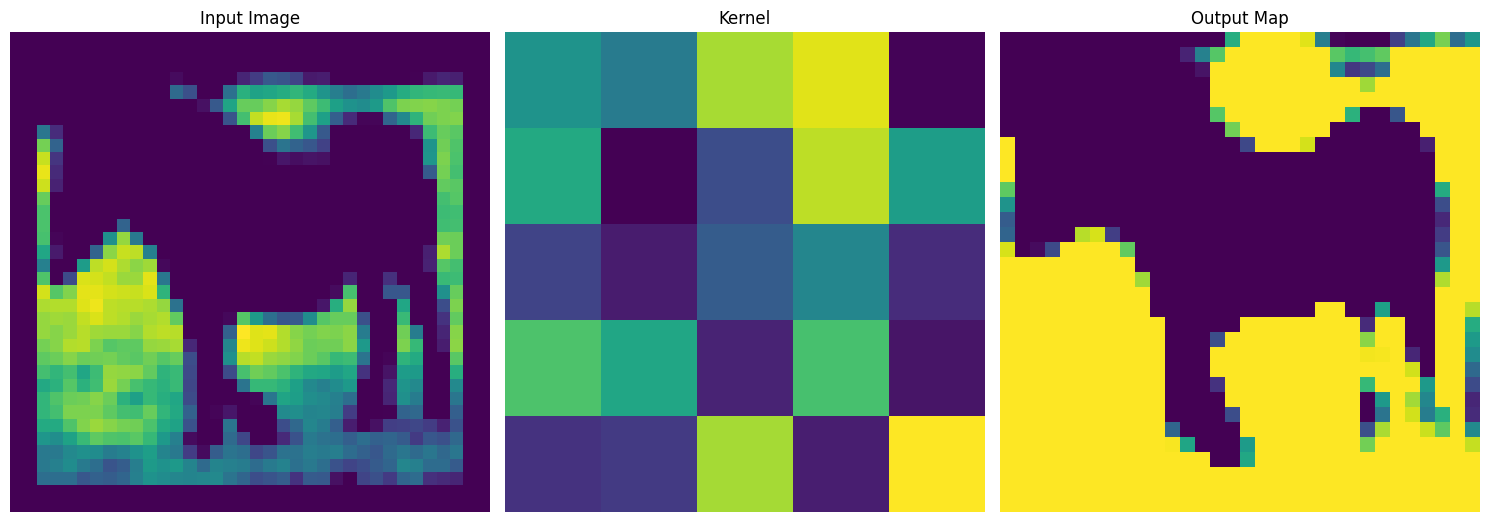

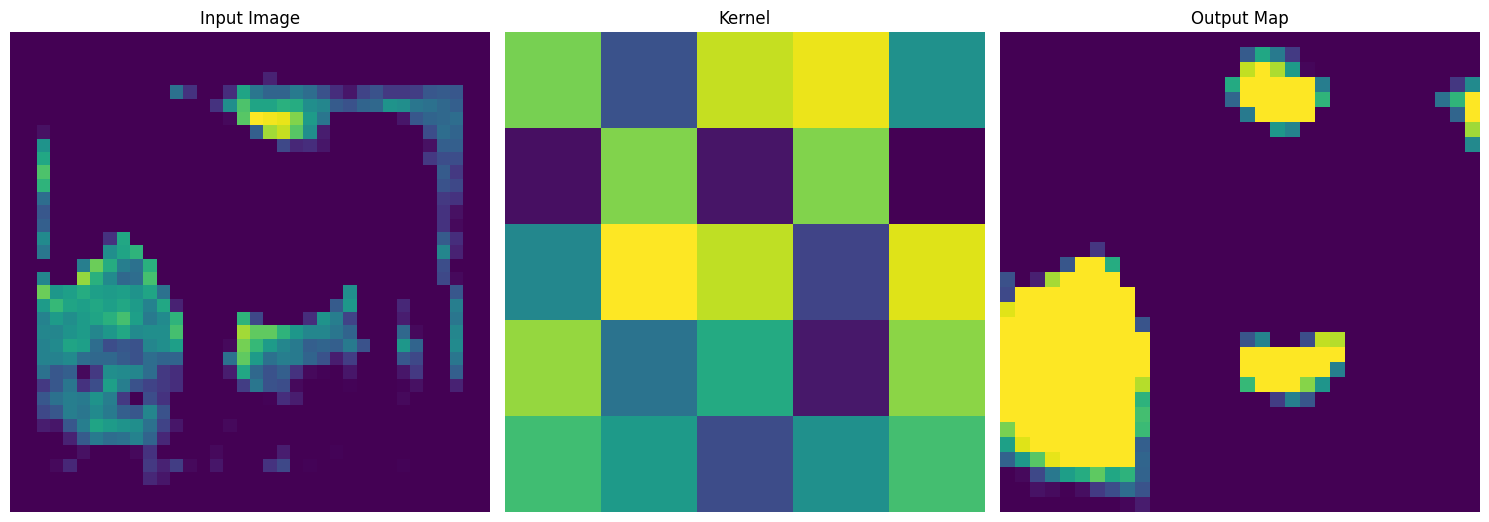

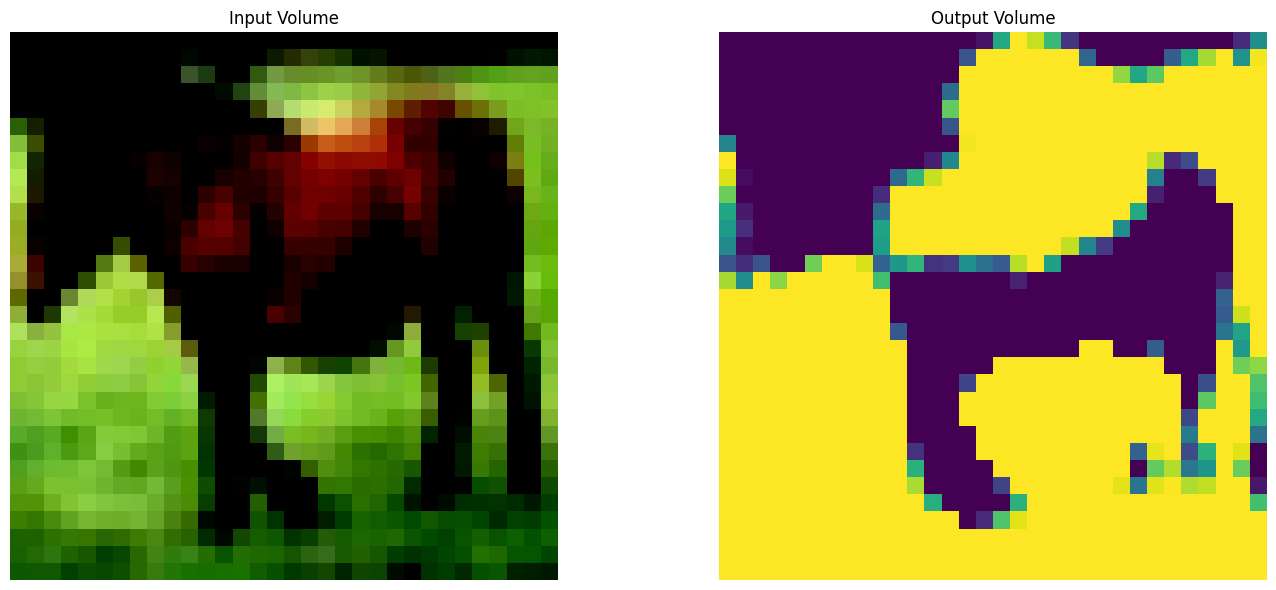

(32, 32, 4)


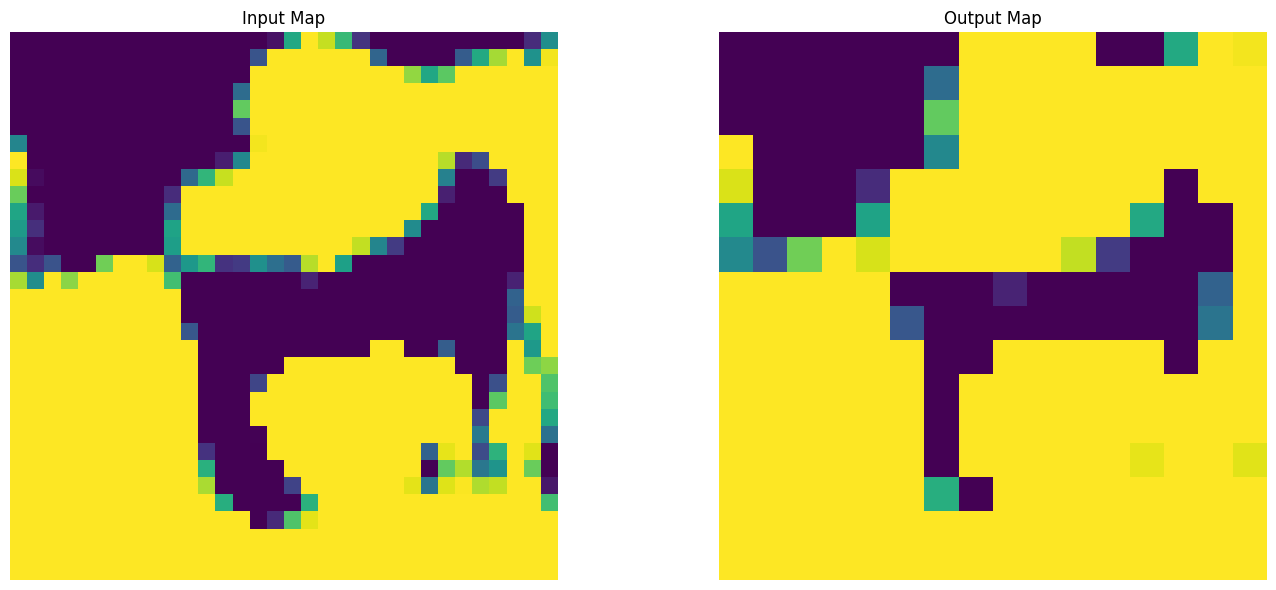

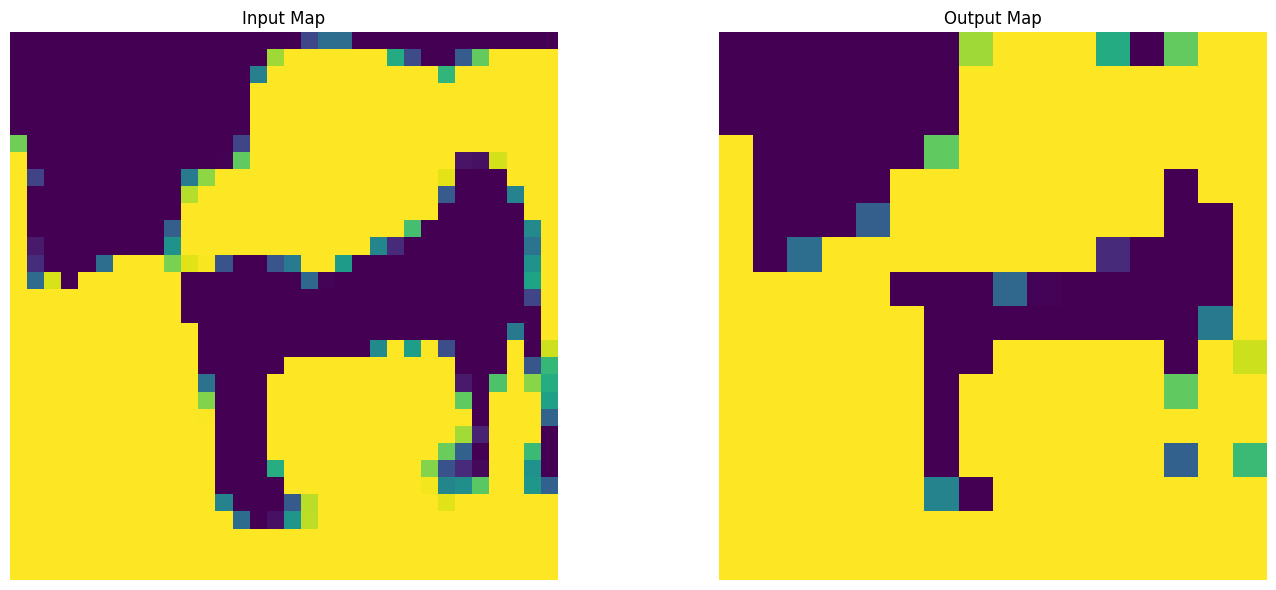

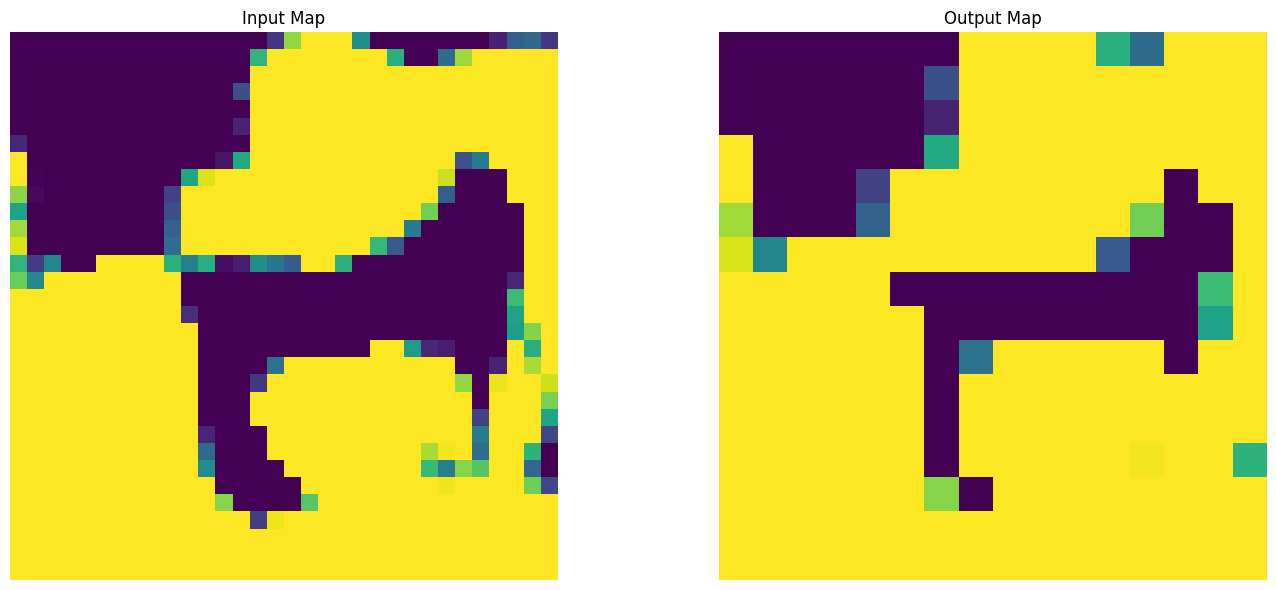

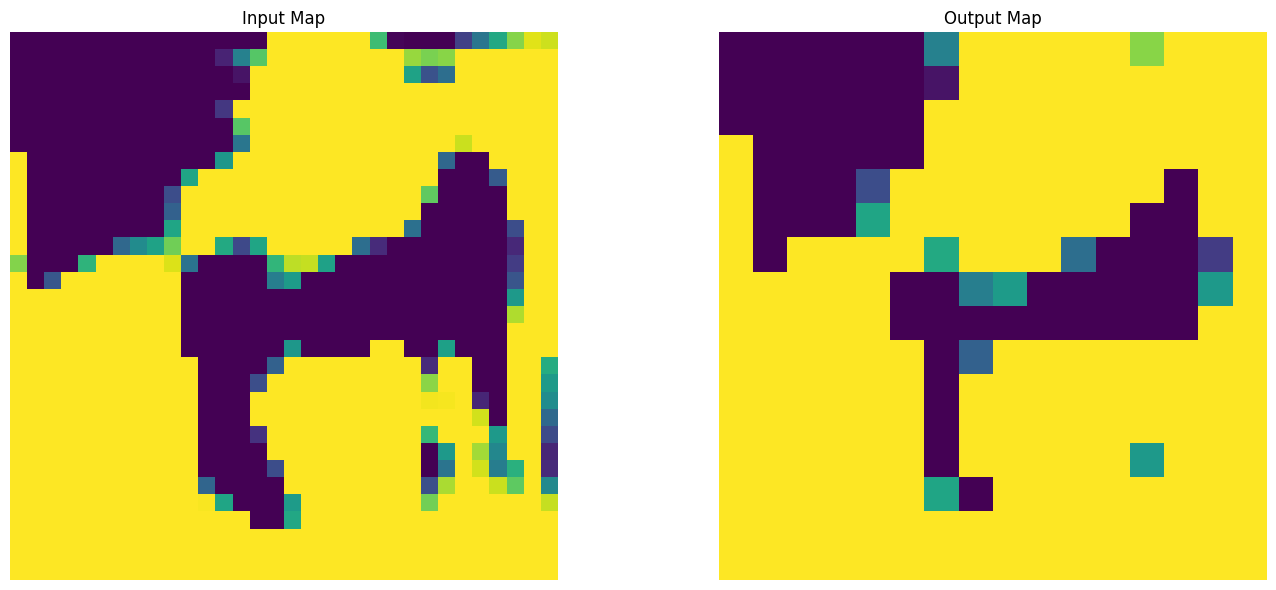

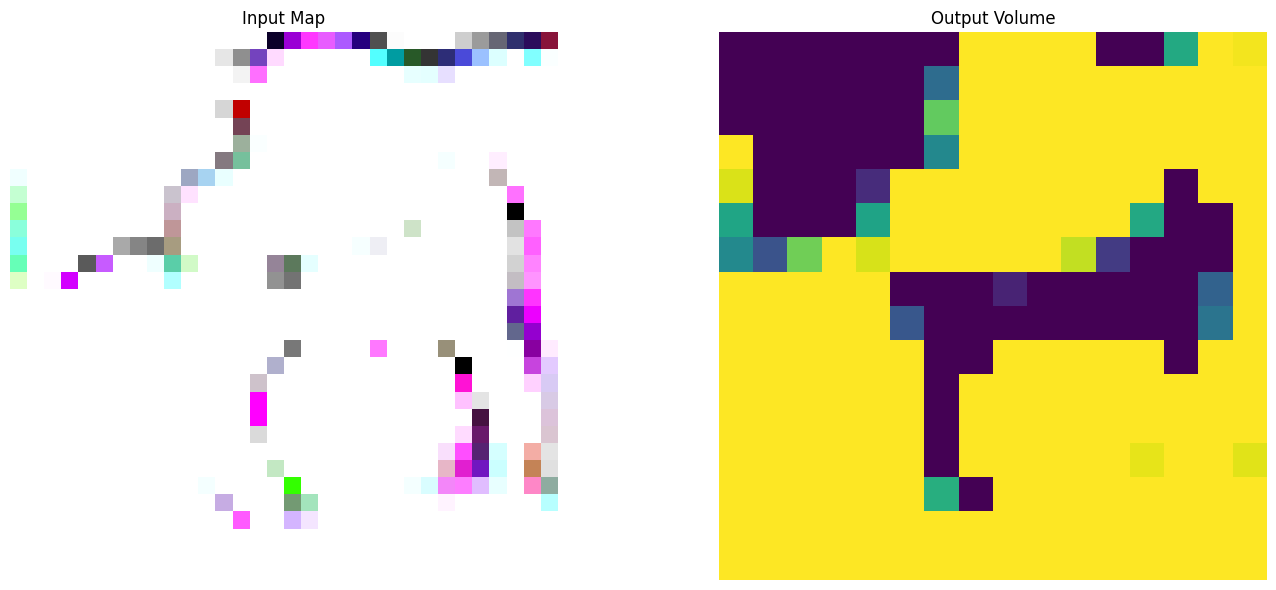

(16, 16, 4)


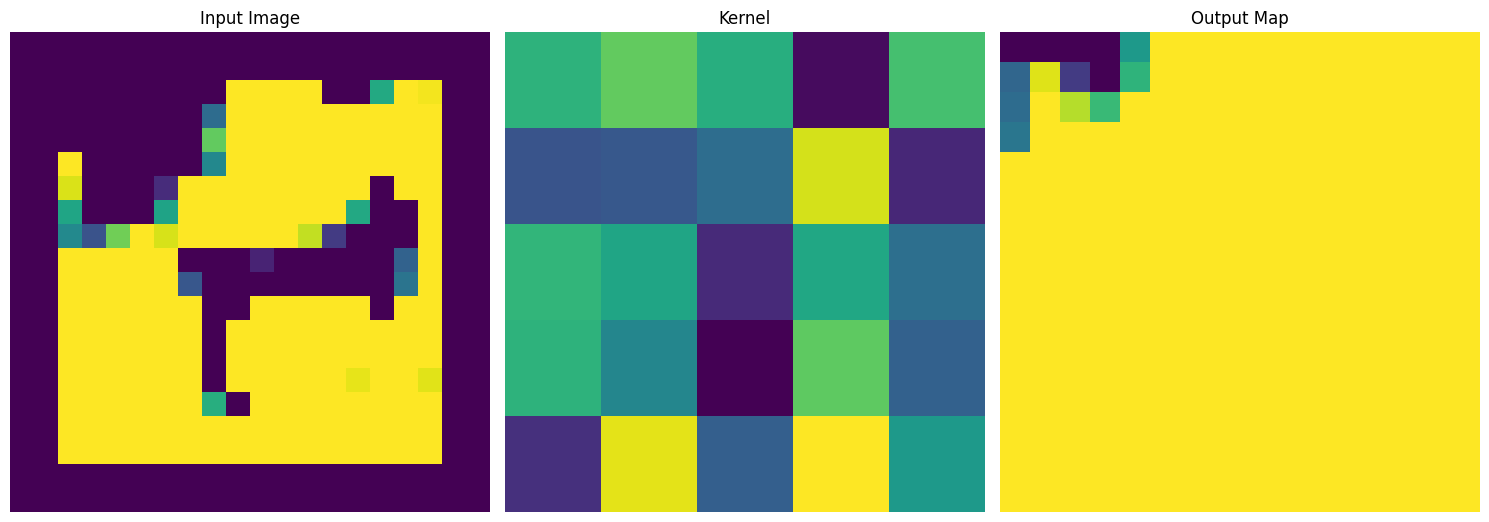

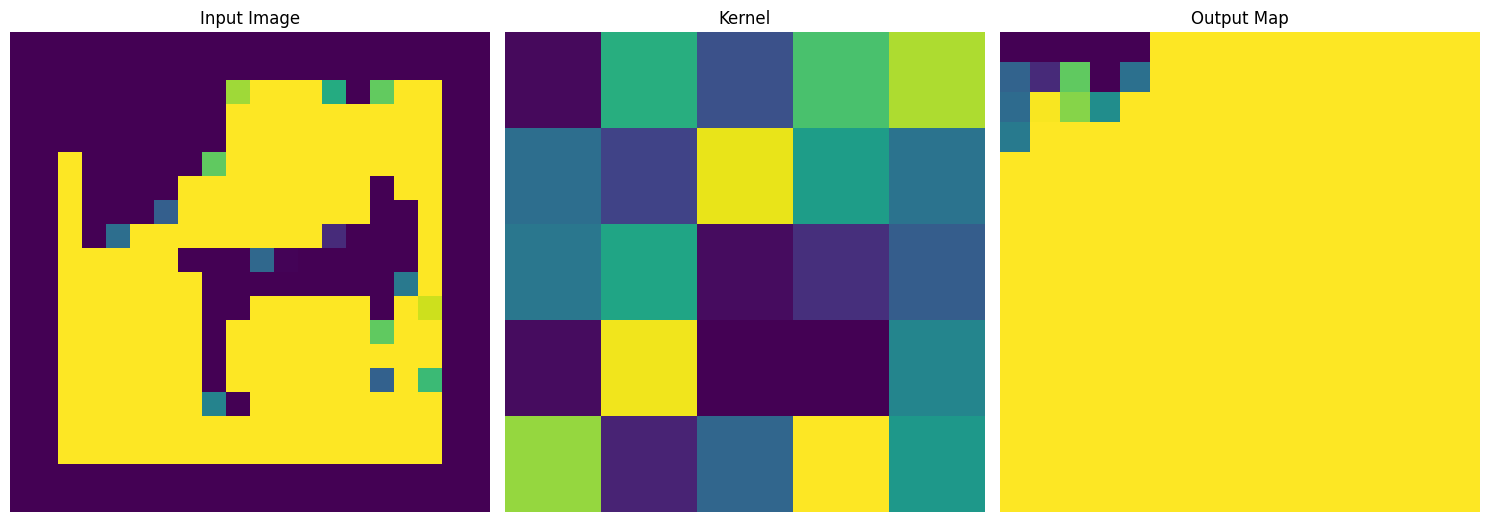

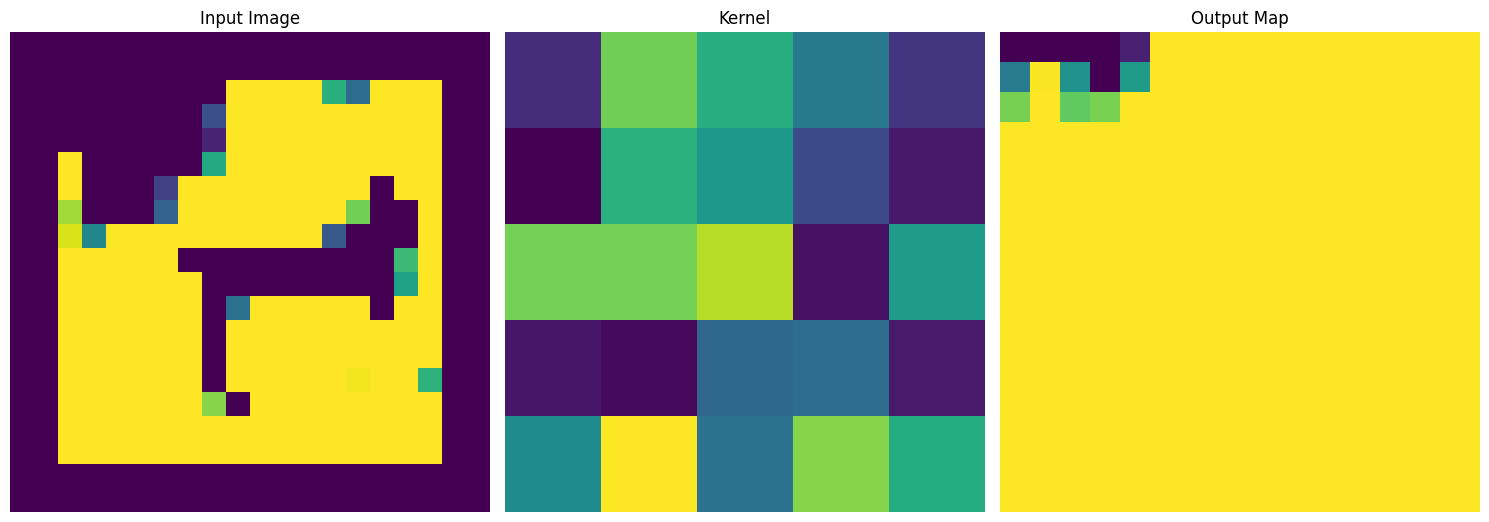

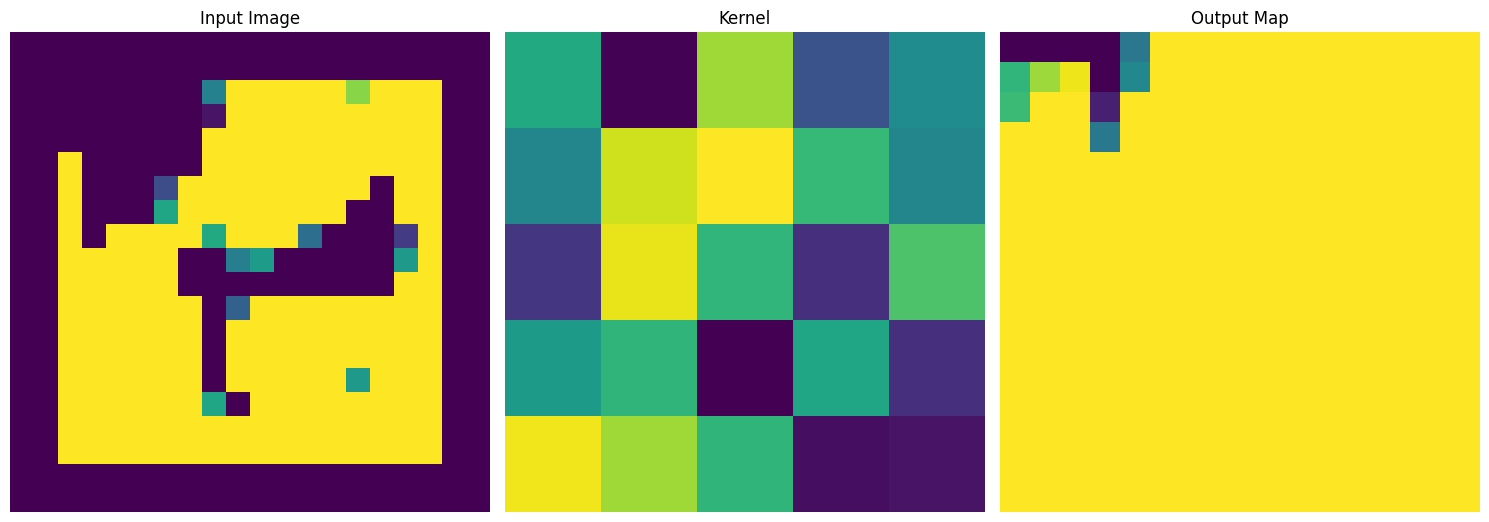

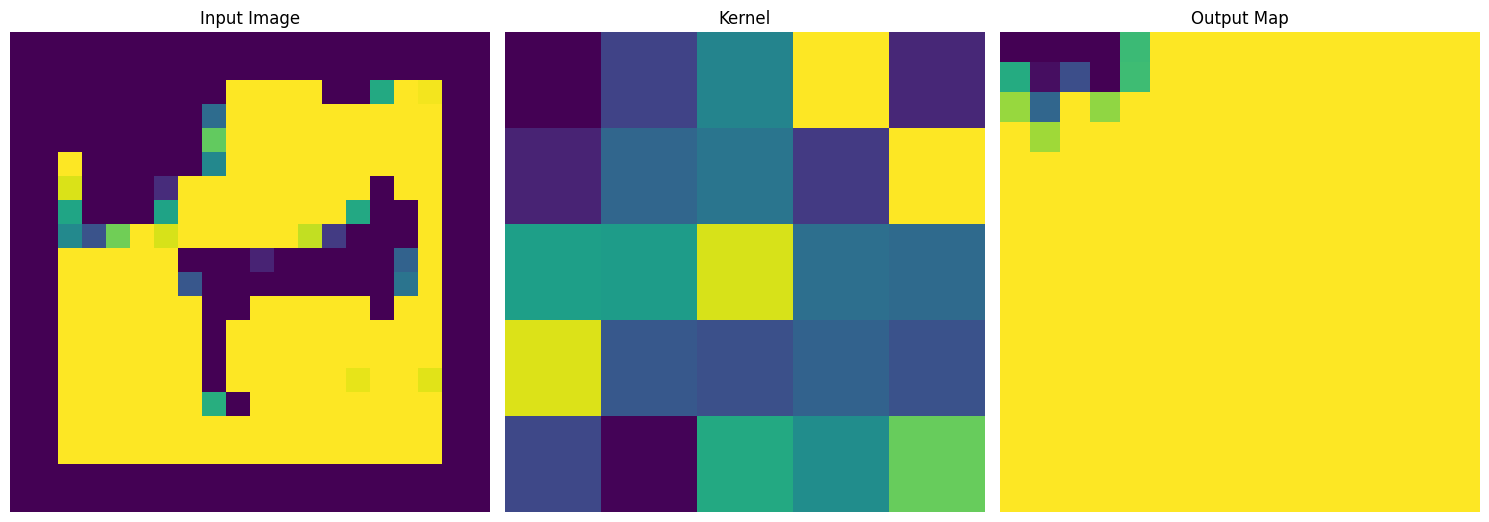

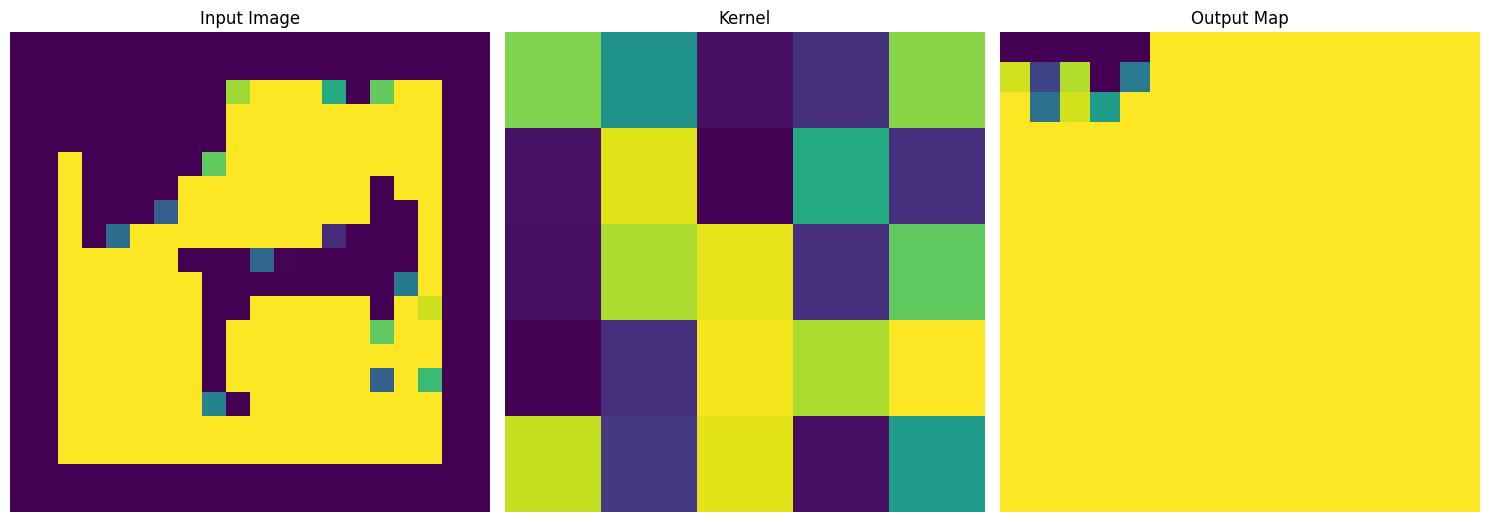

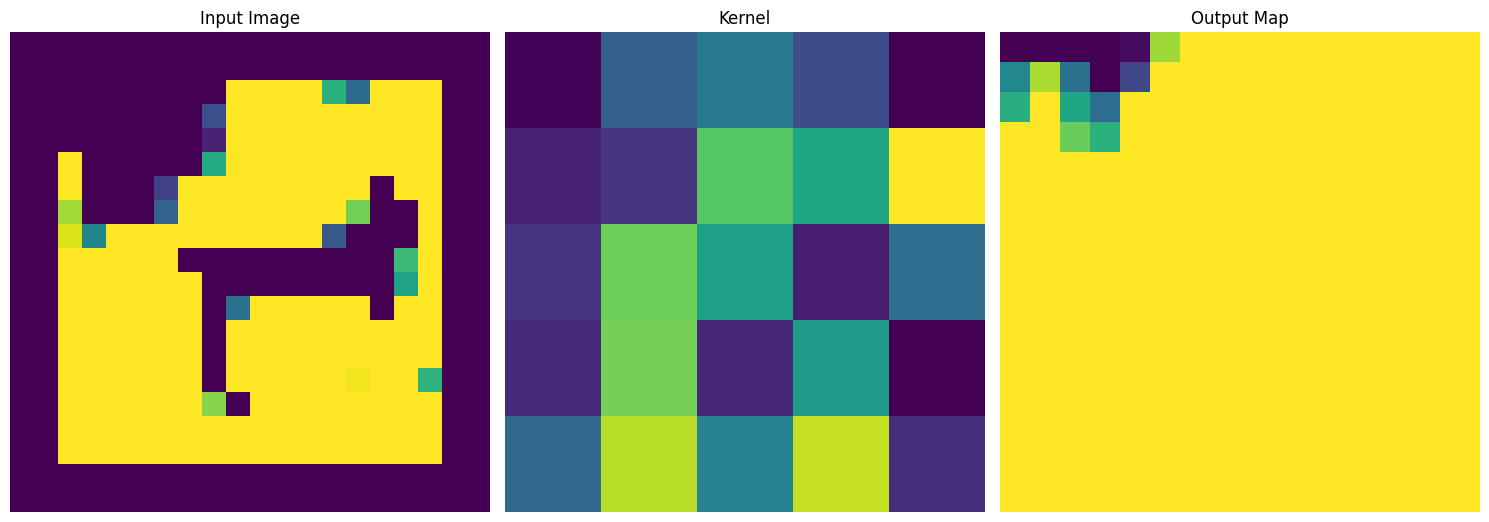

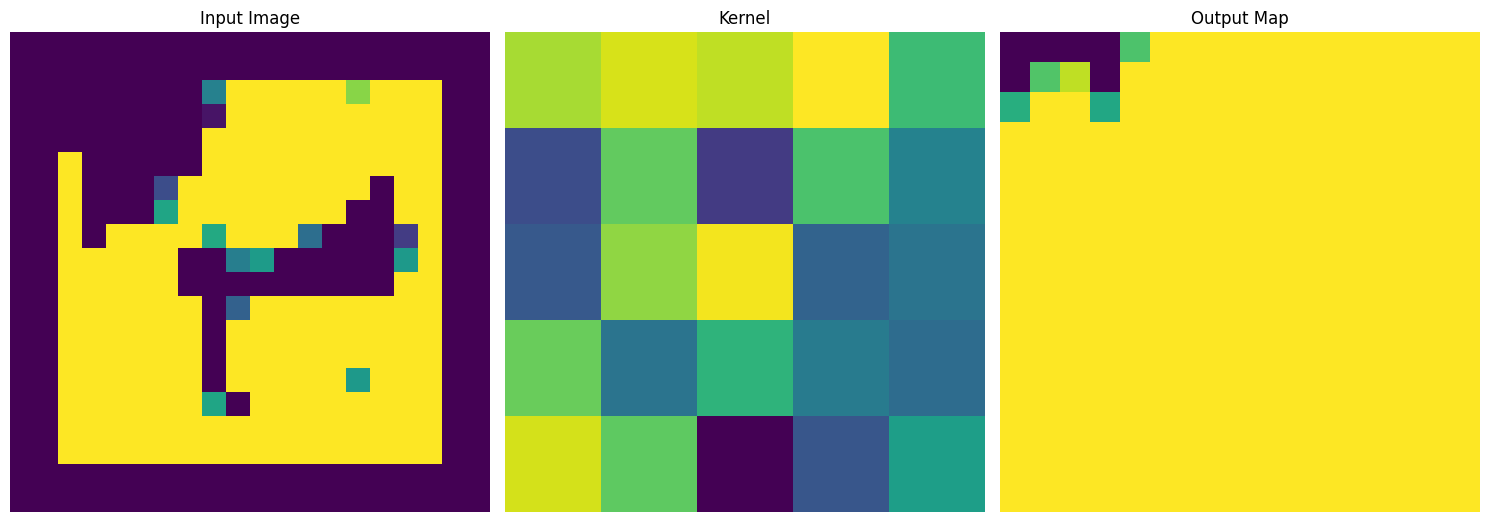

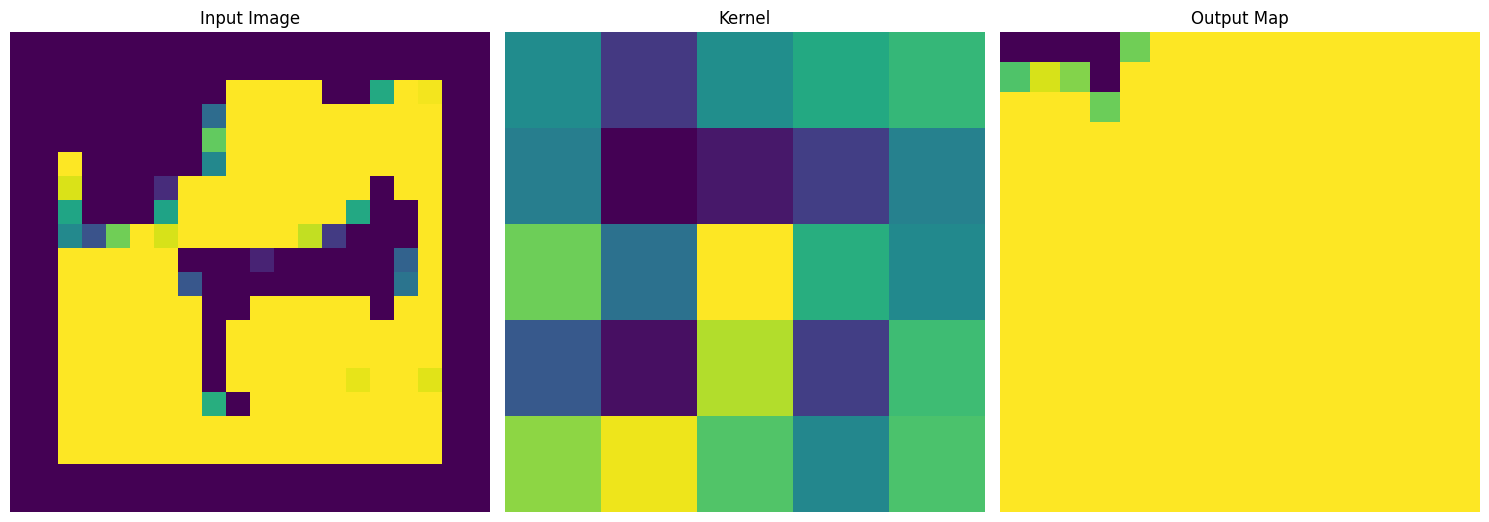

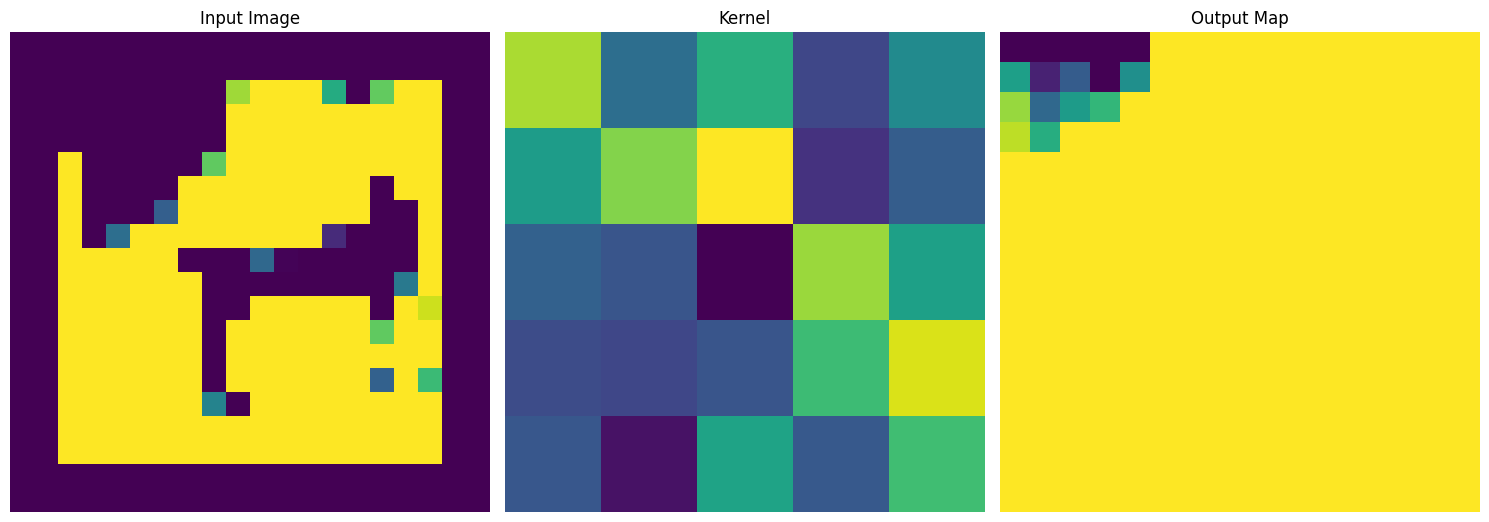

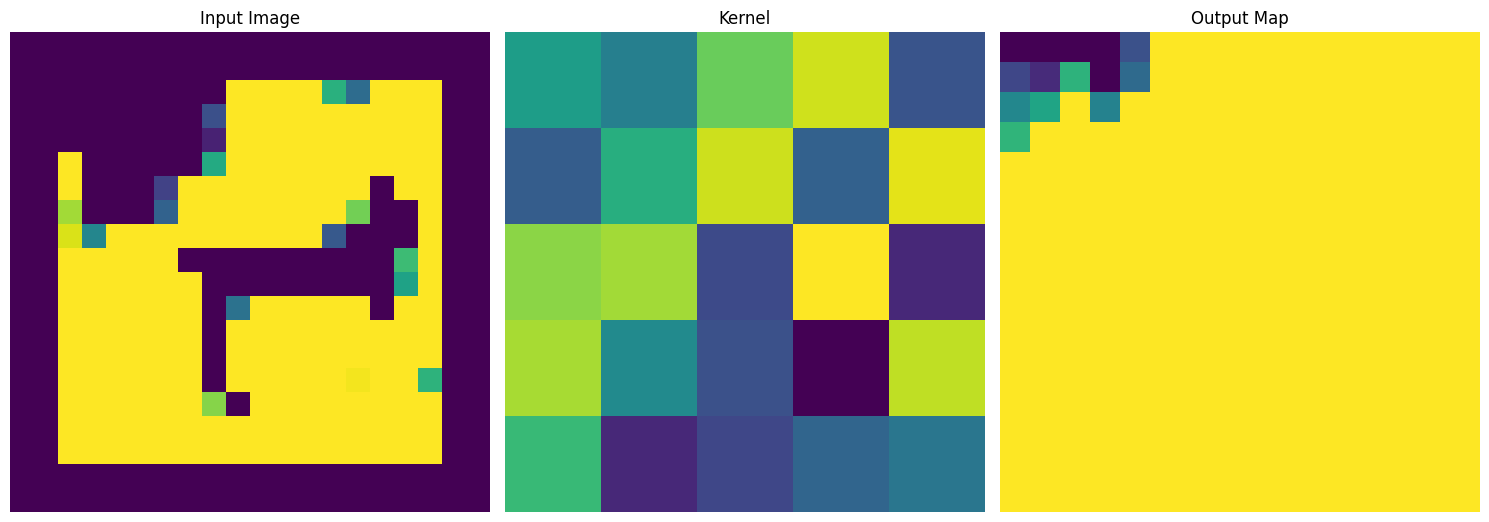

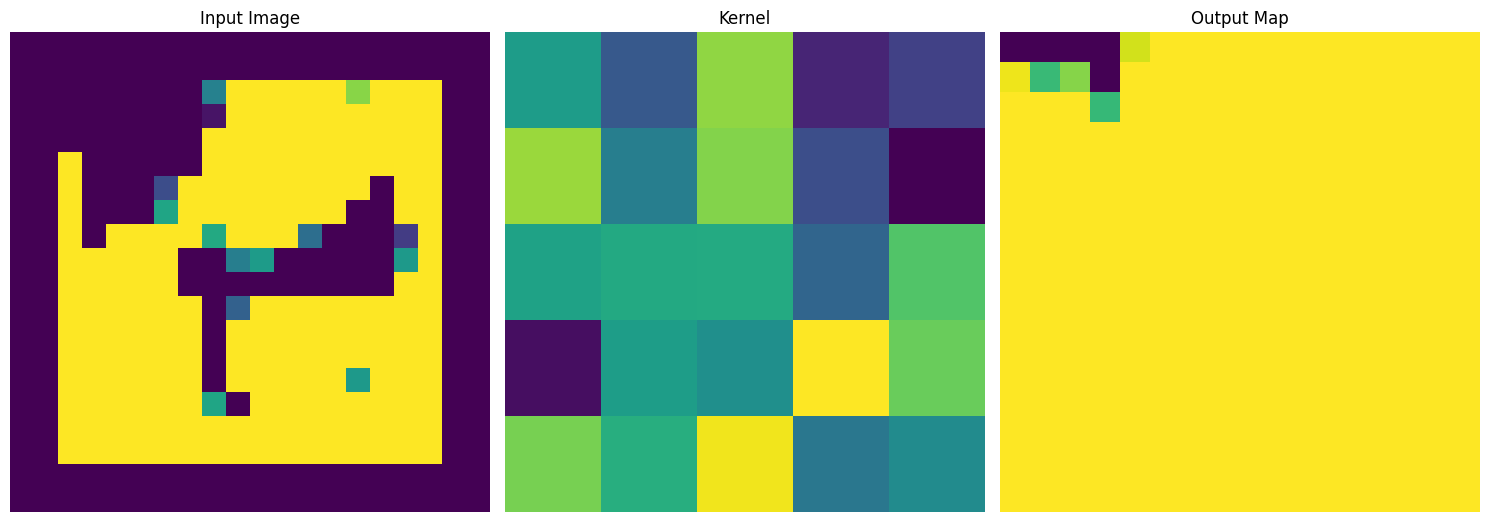

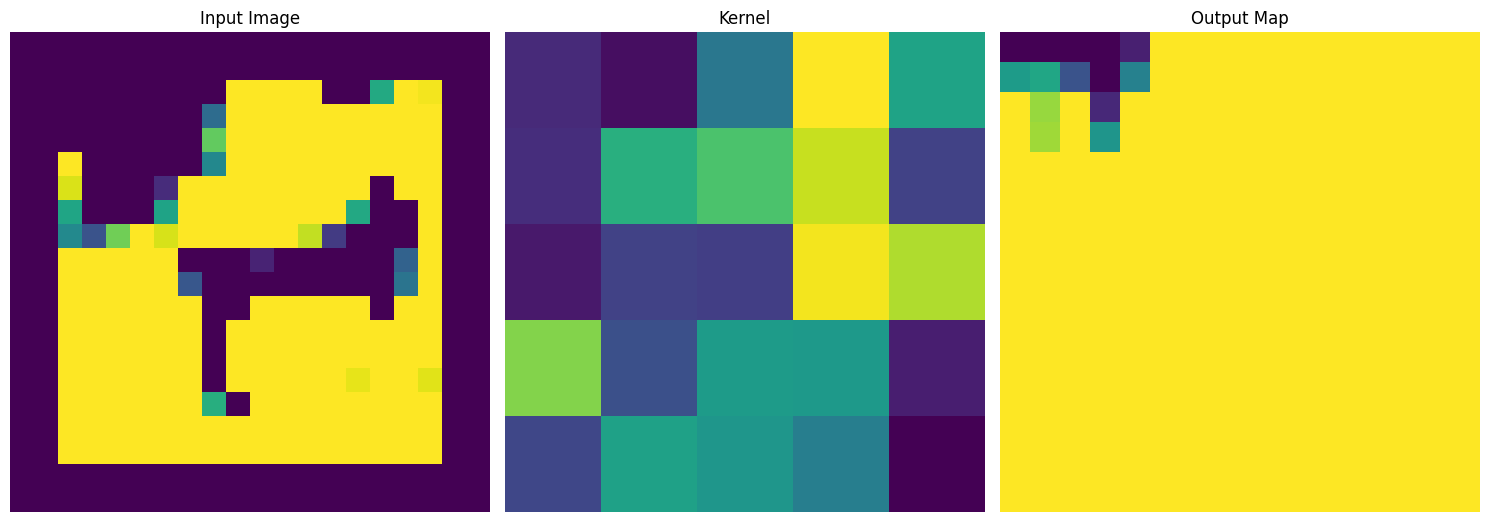

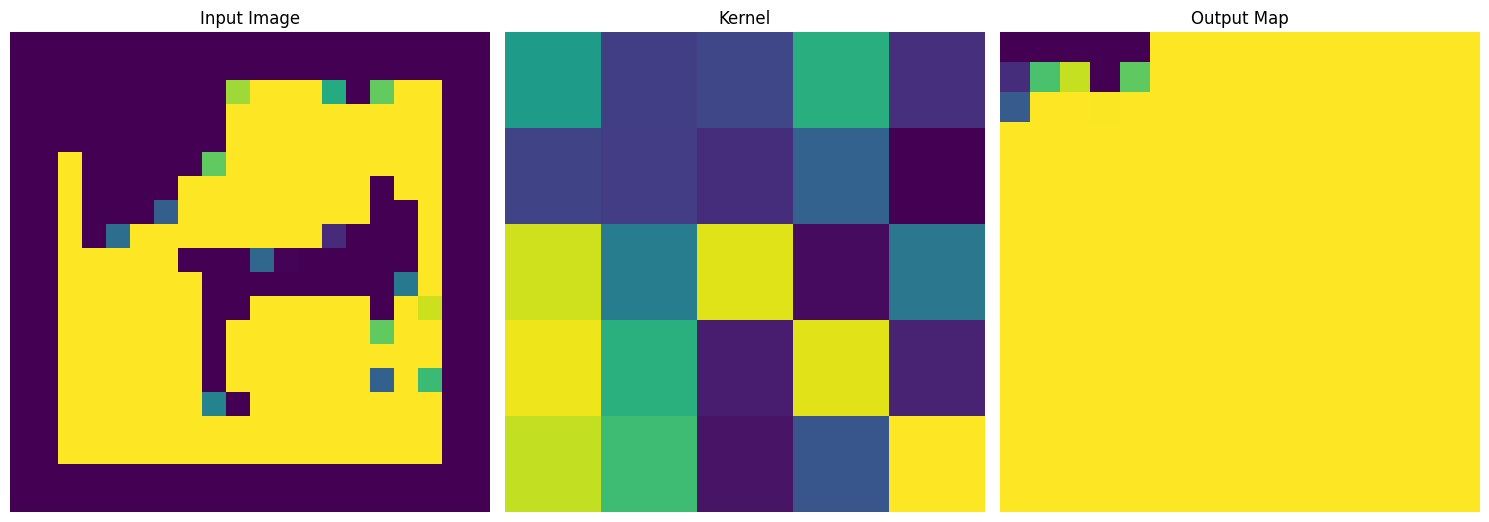

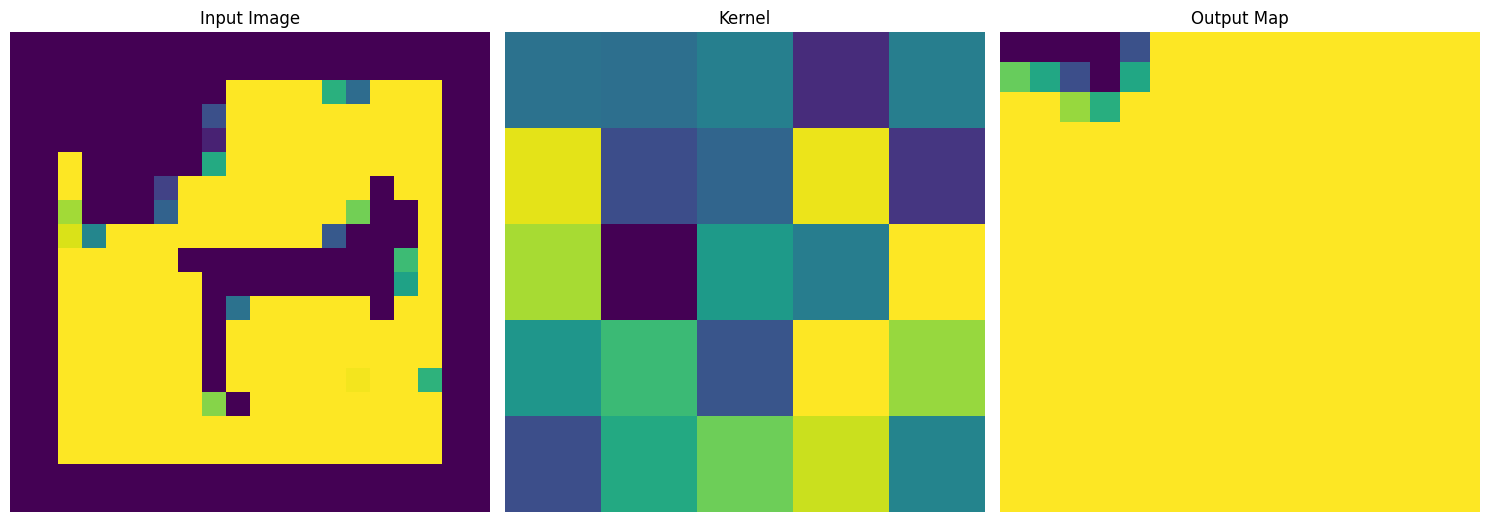

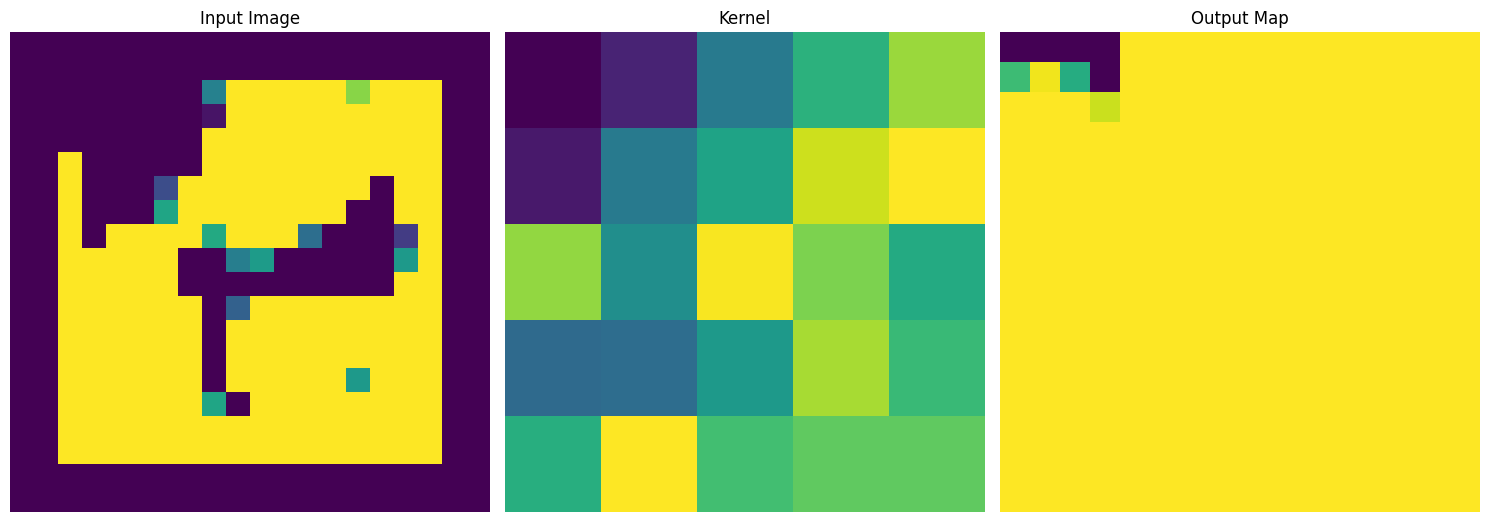

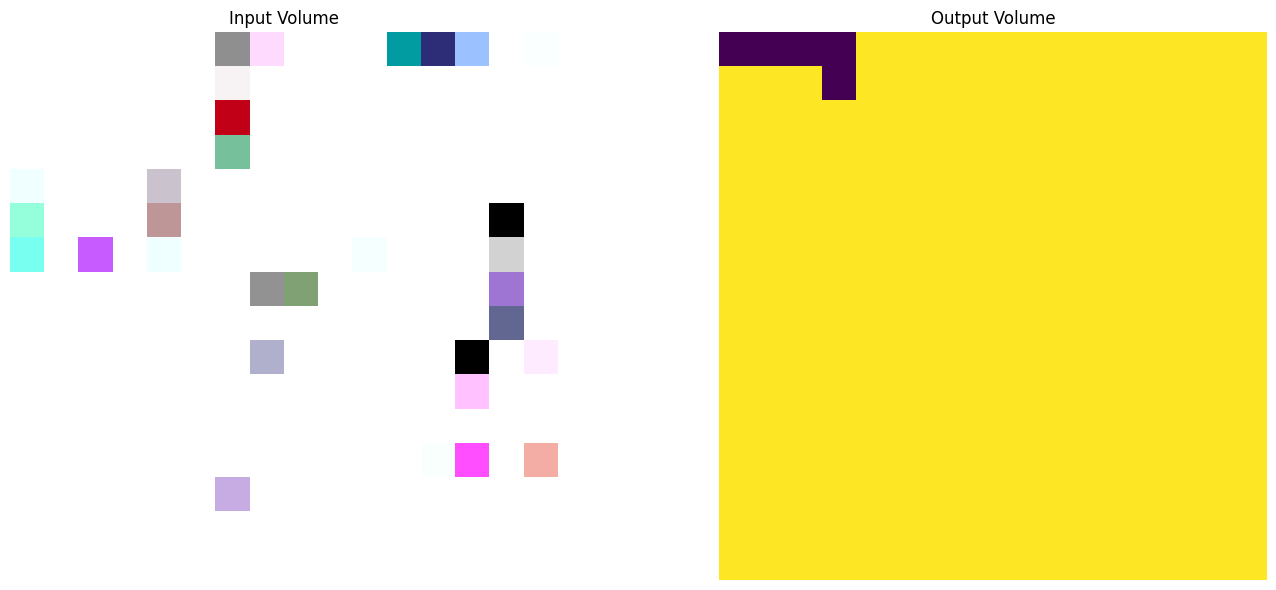

(16, 16, 4)


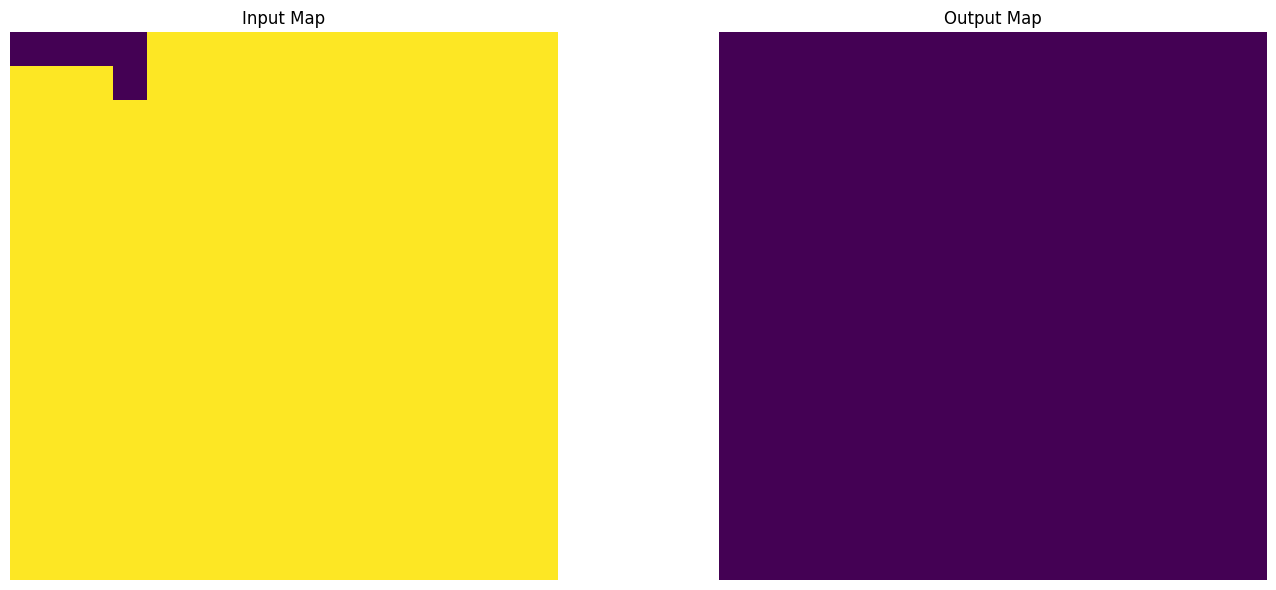

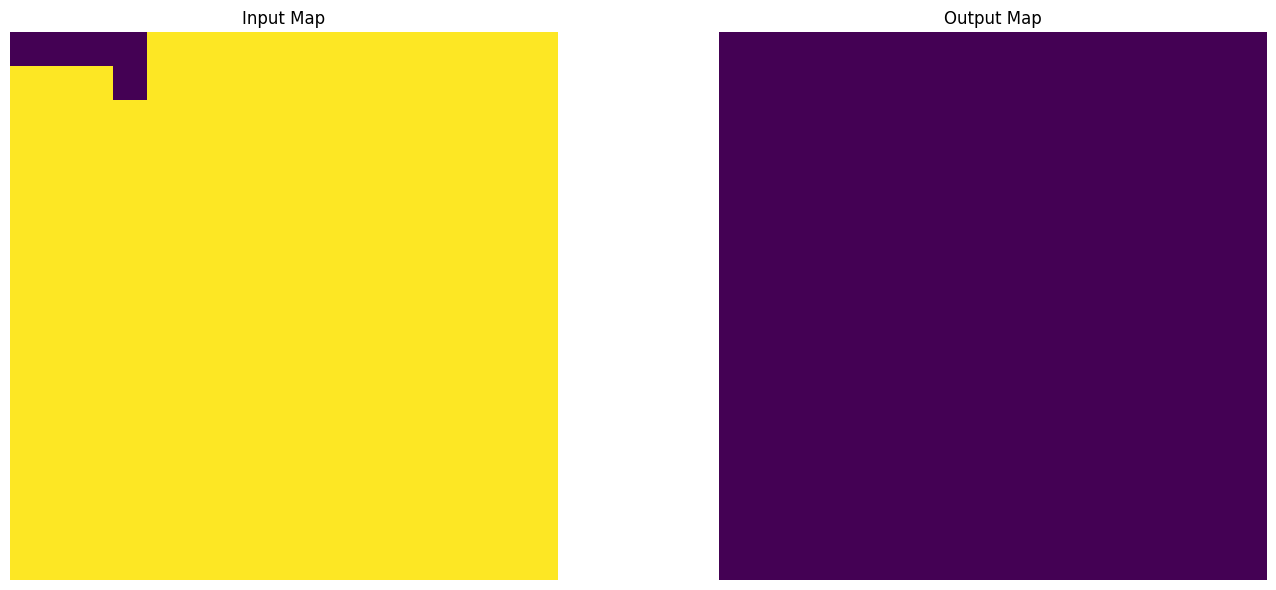

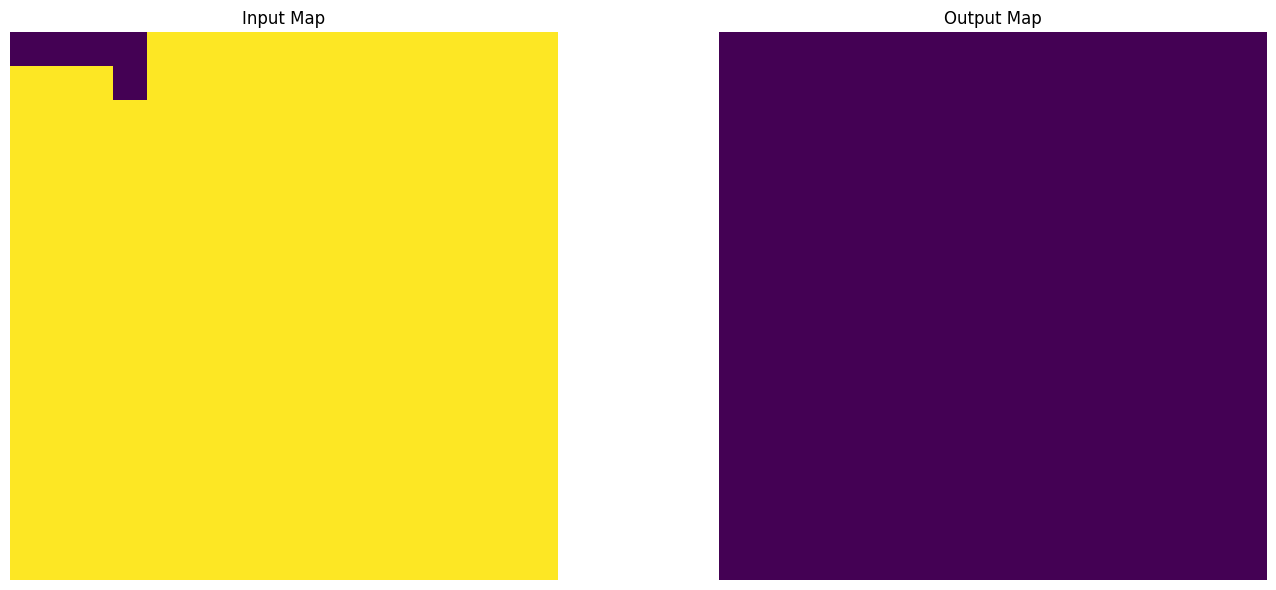

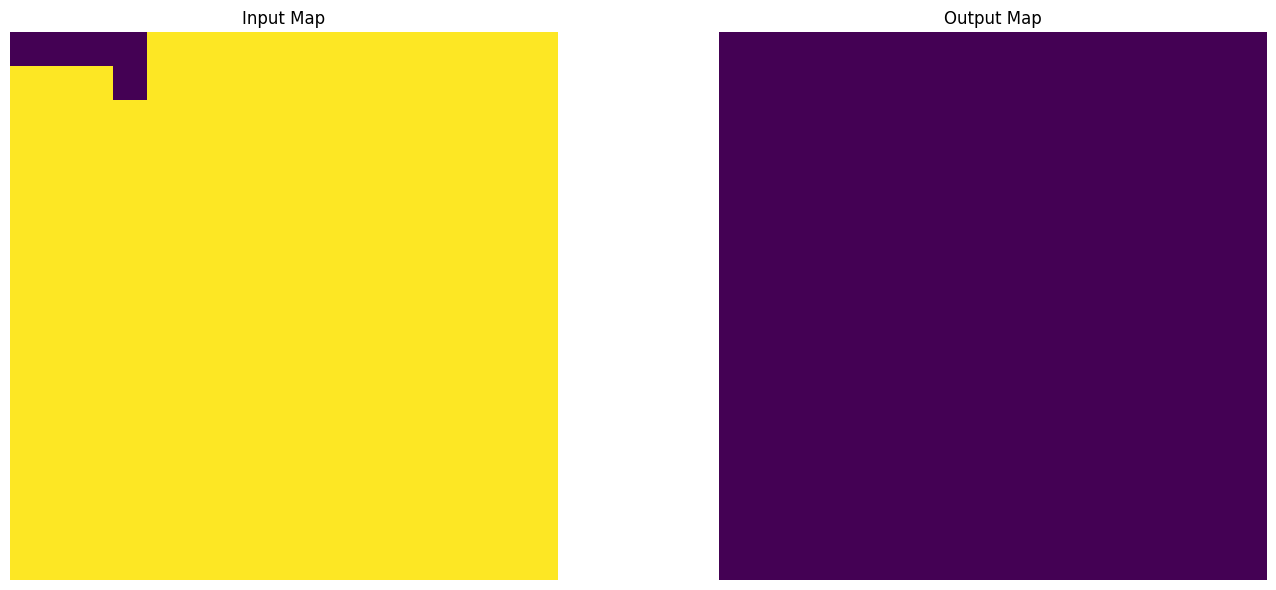

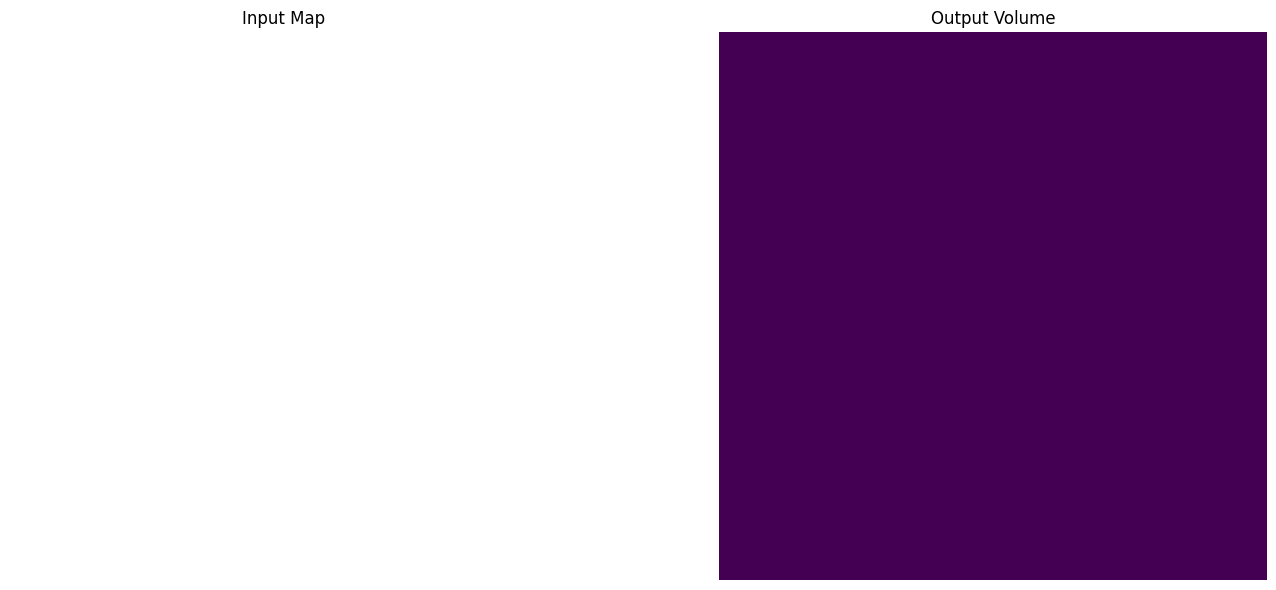

(8, 8, 4)


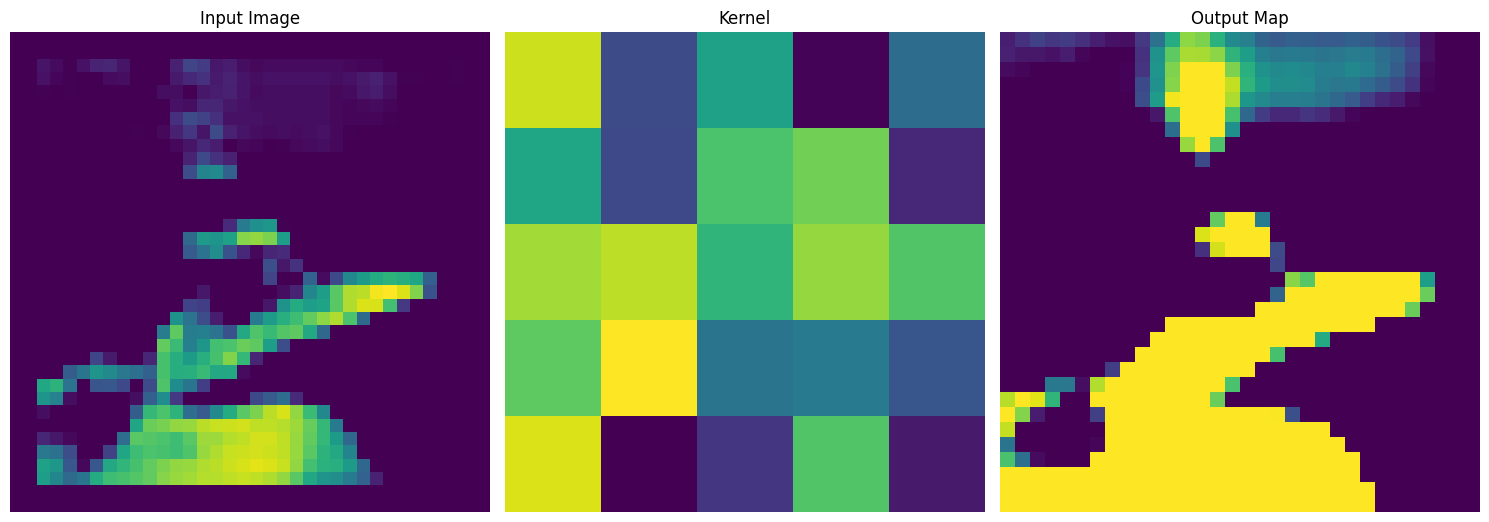

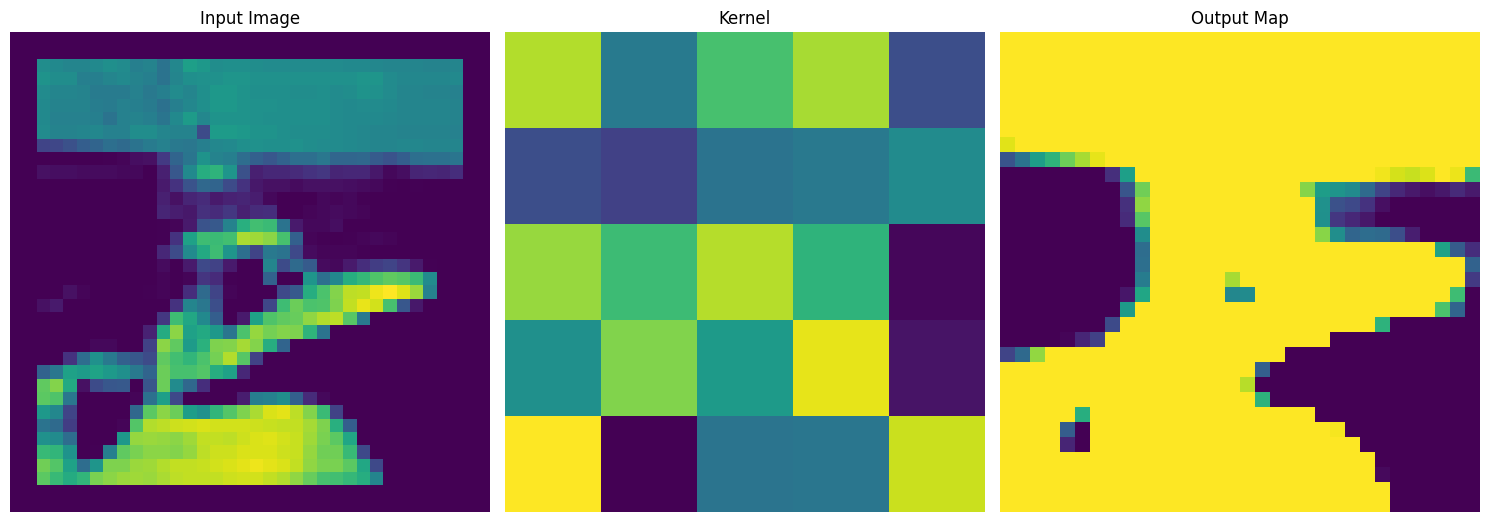

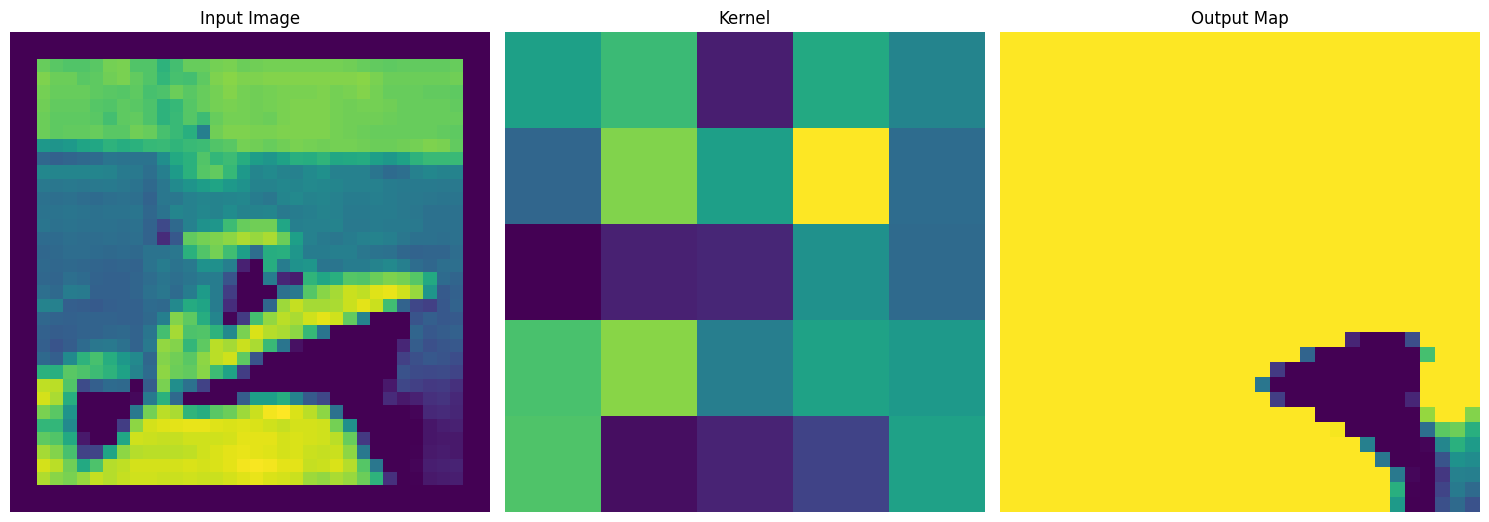

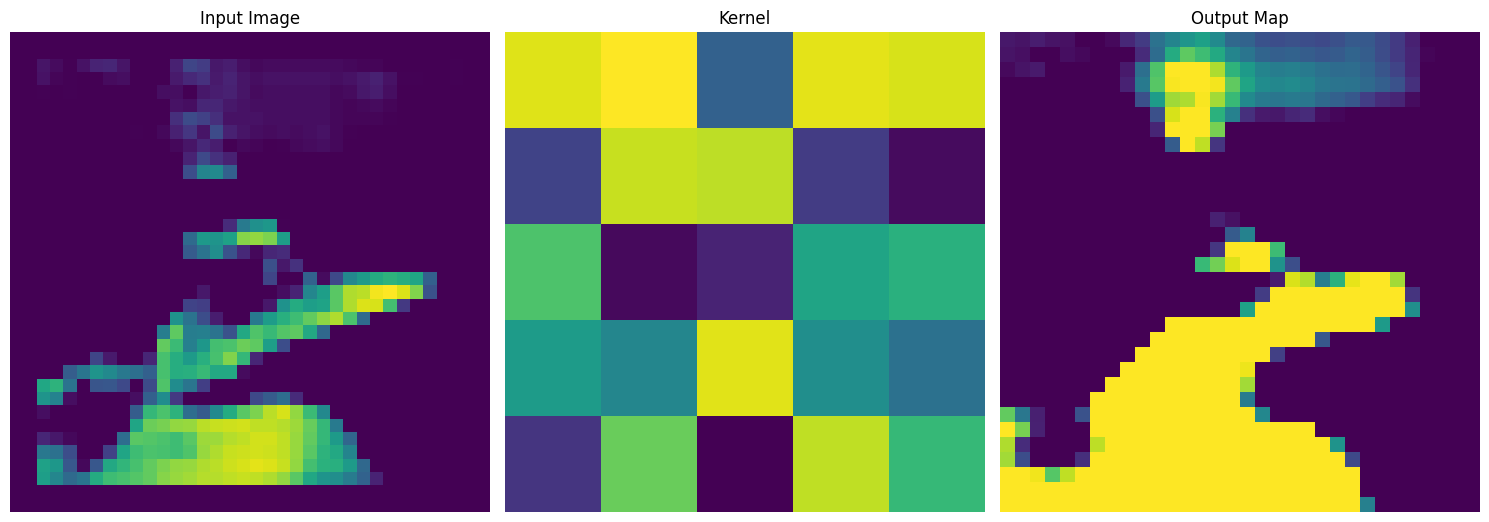

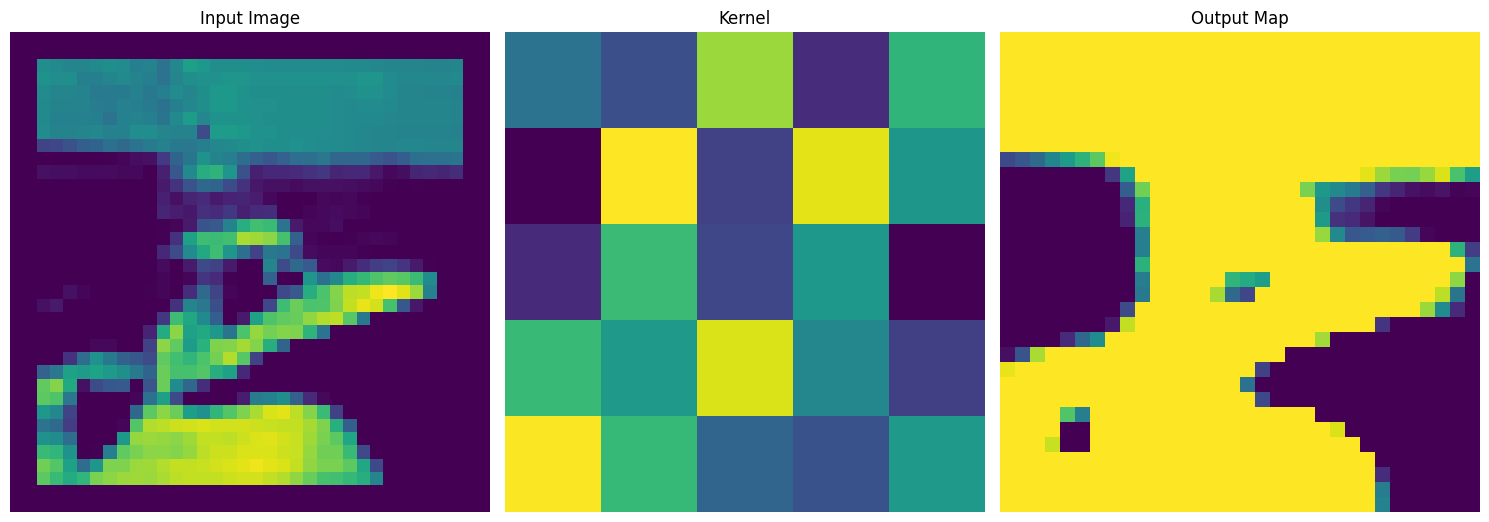

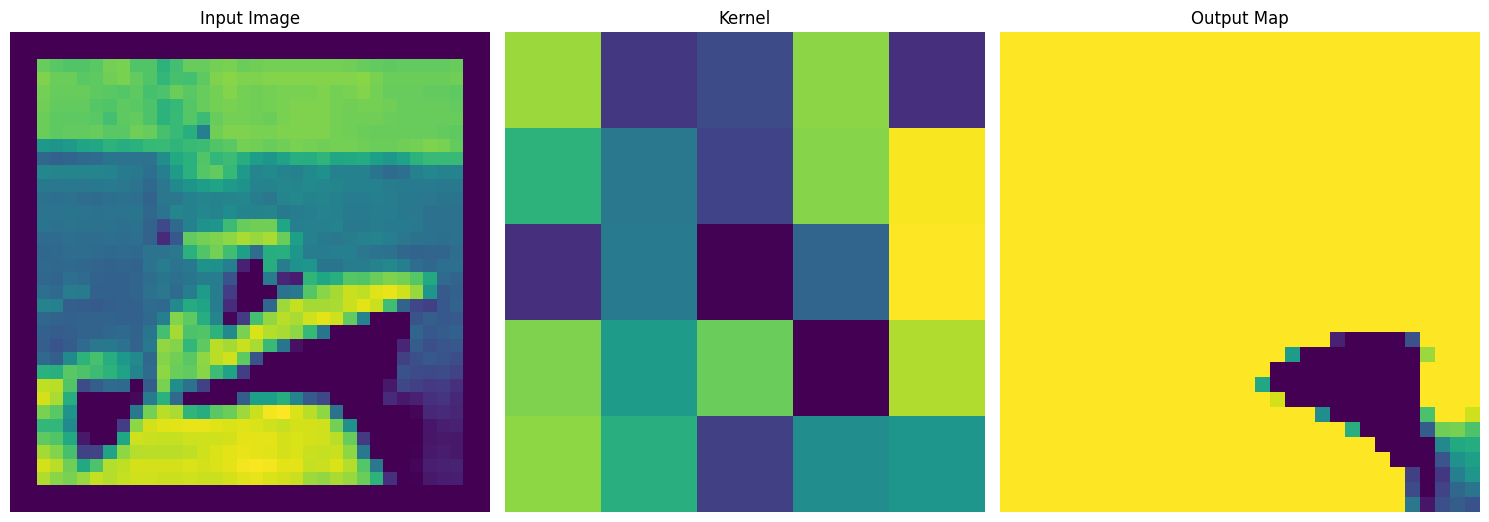

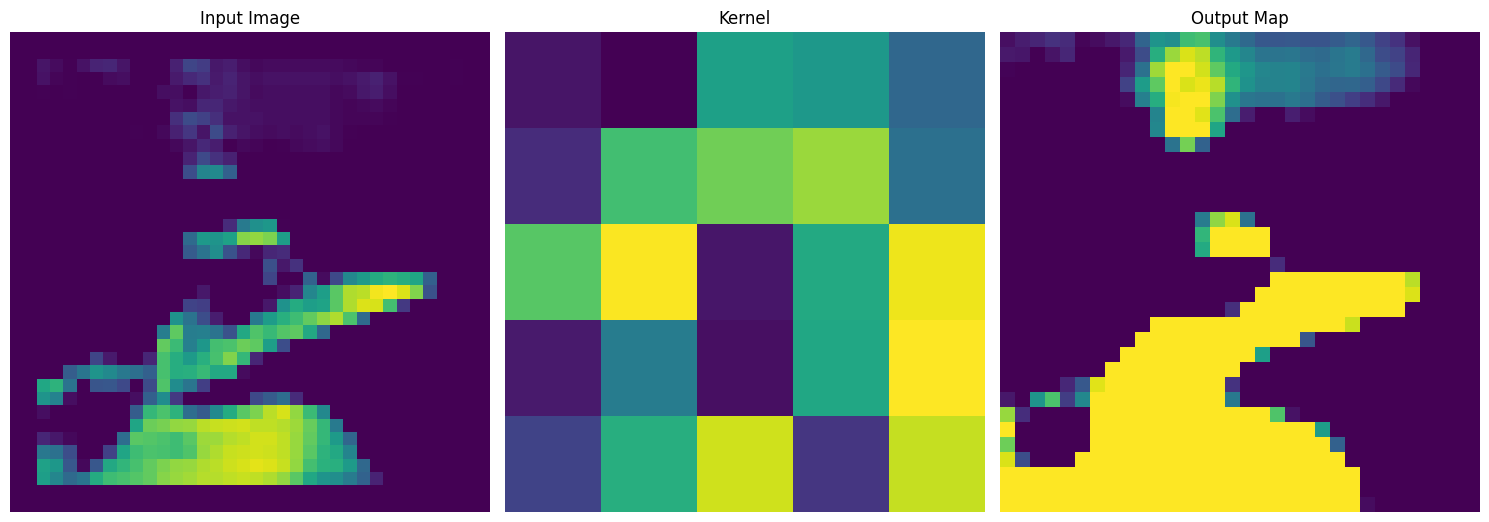

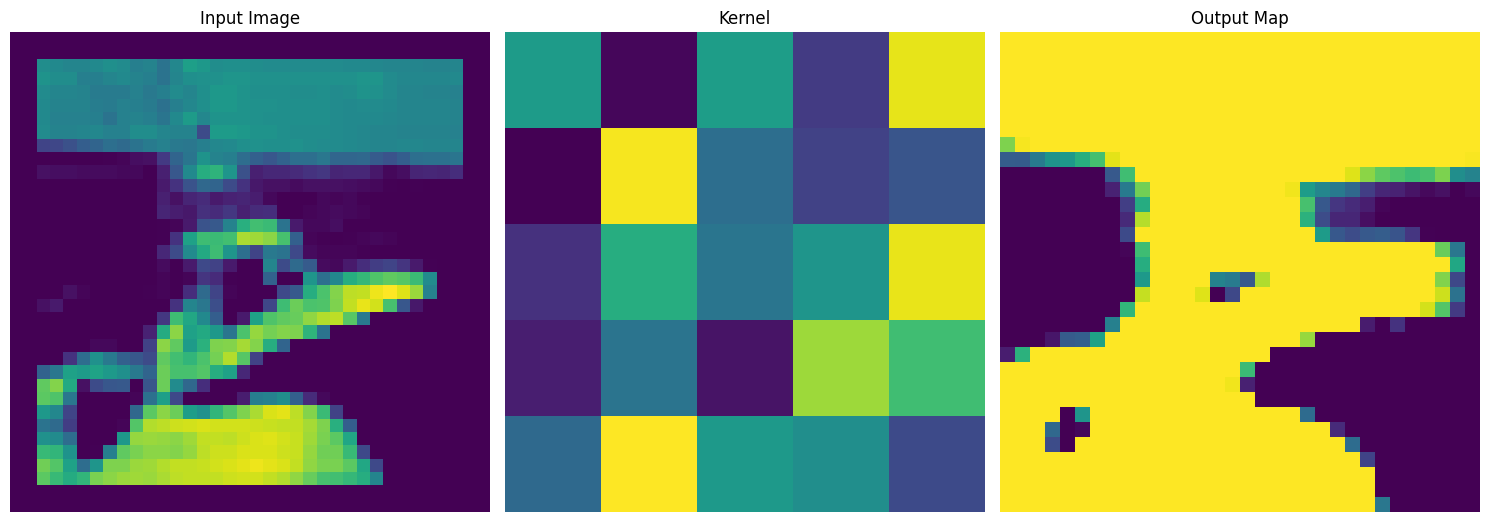

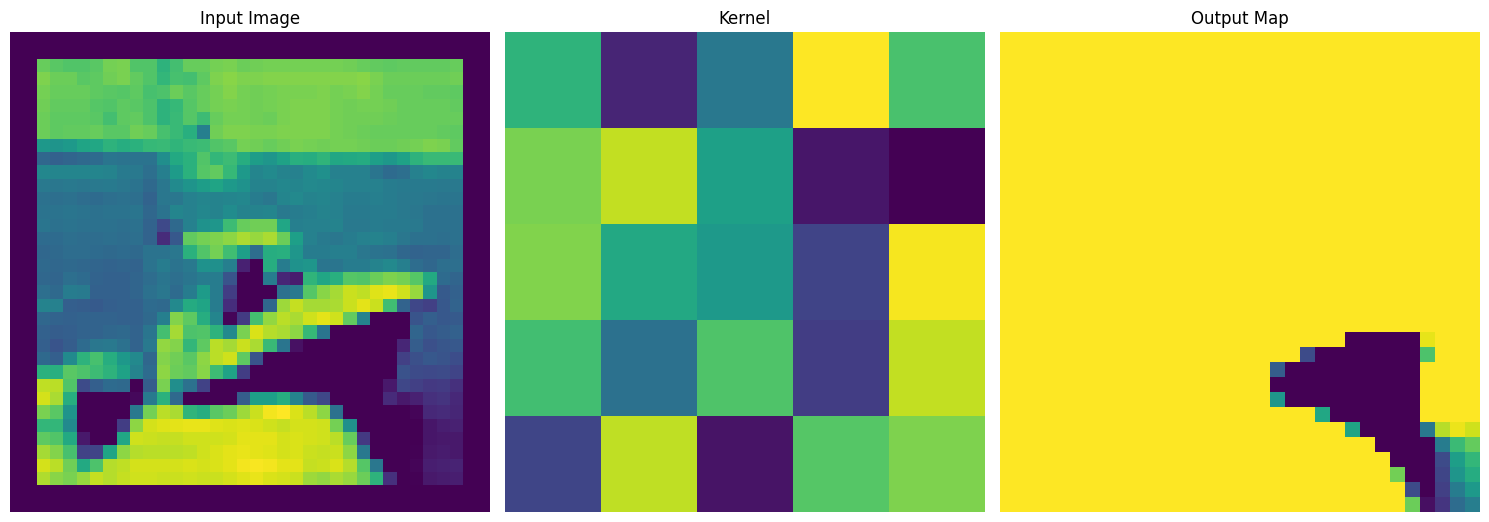

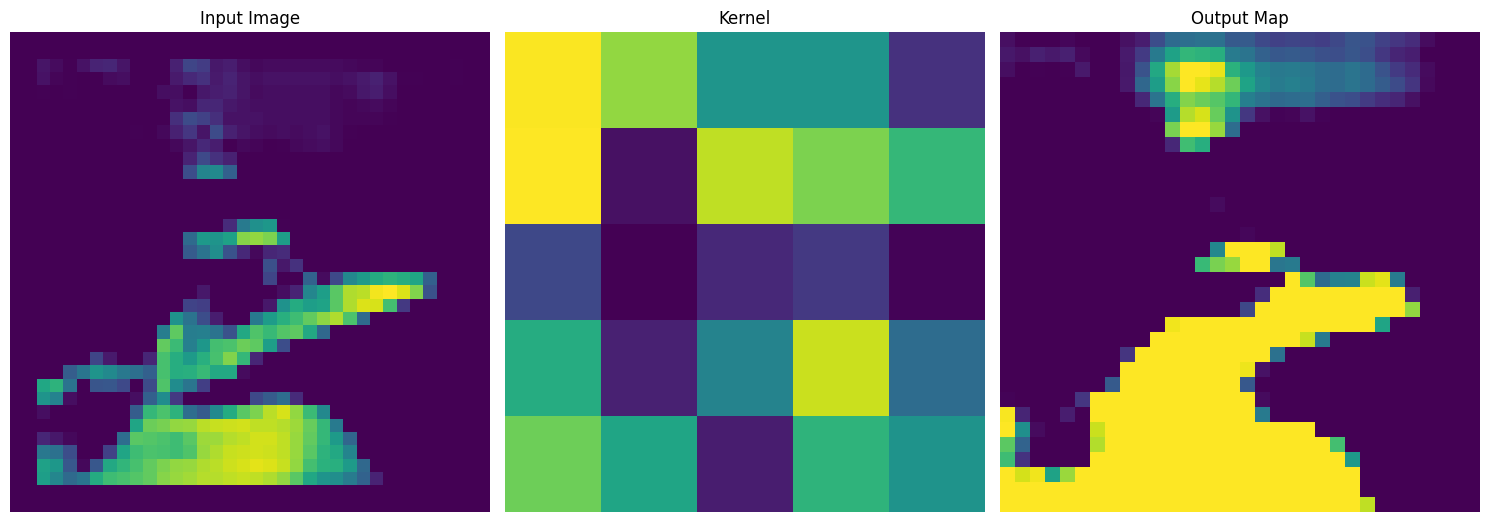

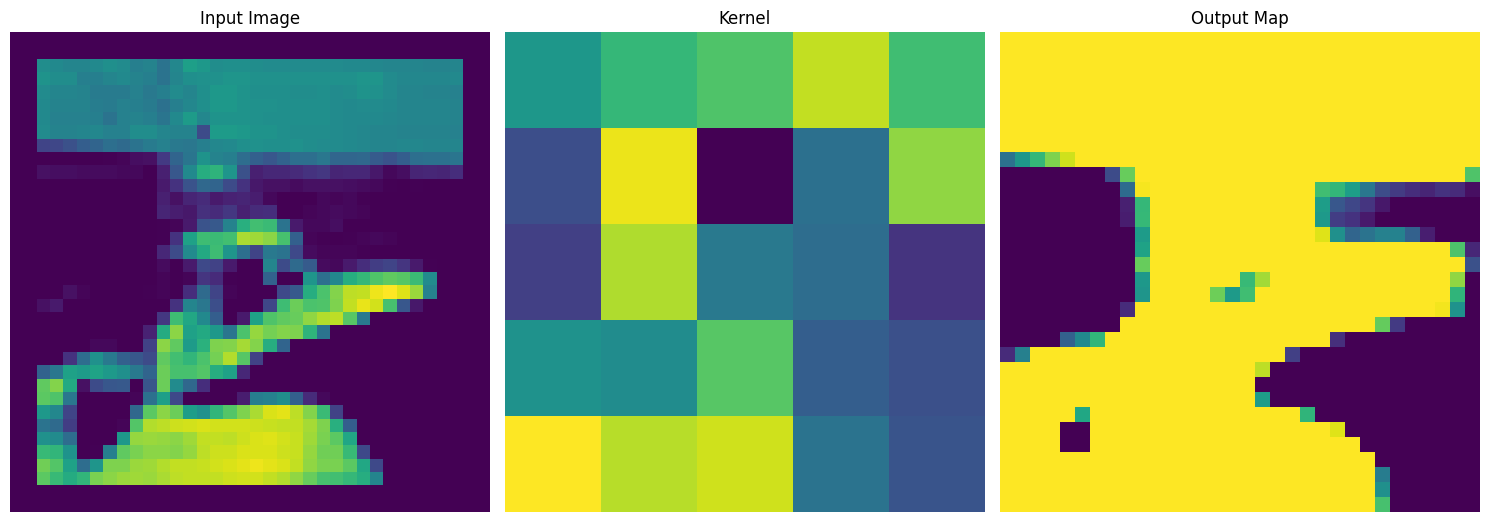

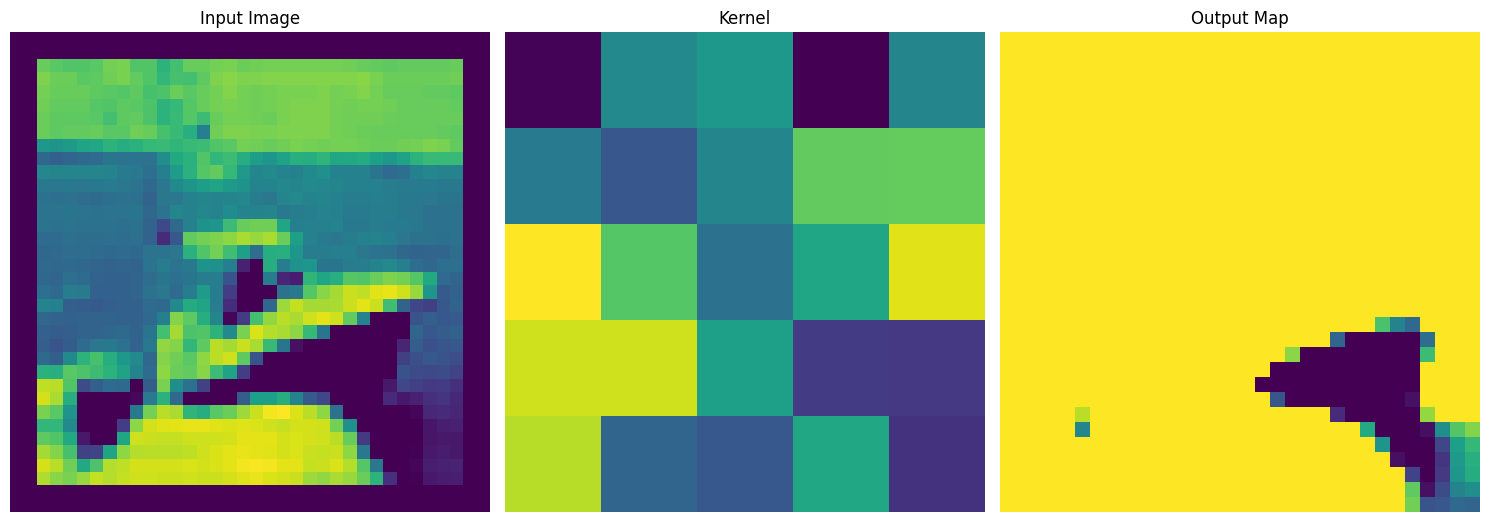

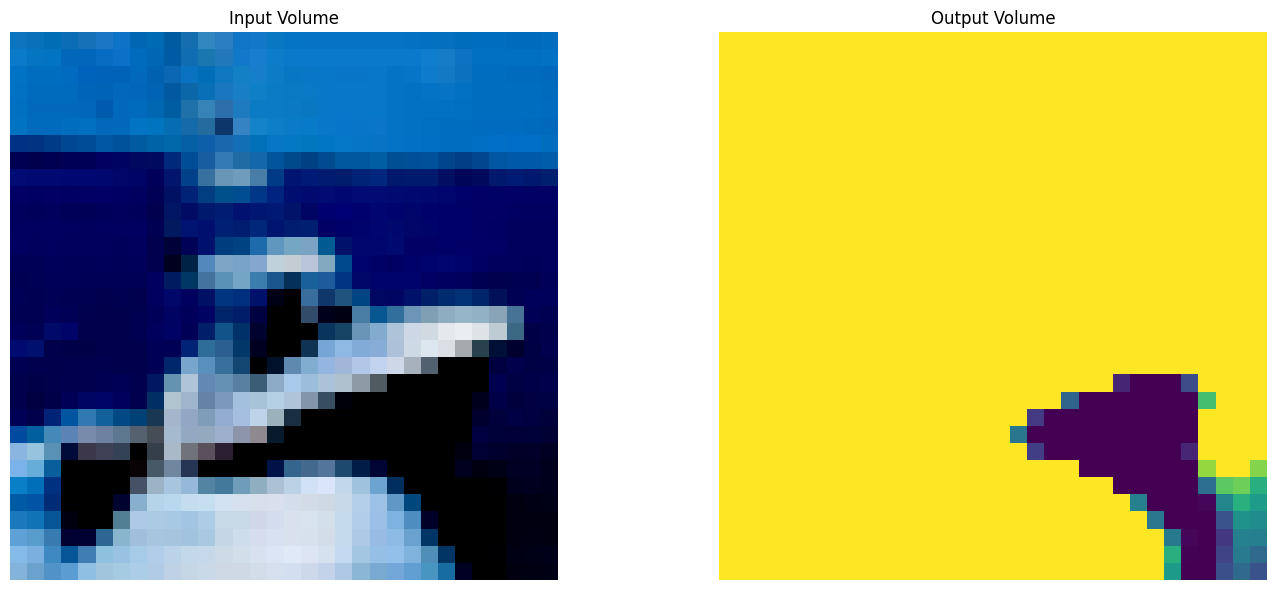

(32, 32, 4)


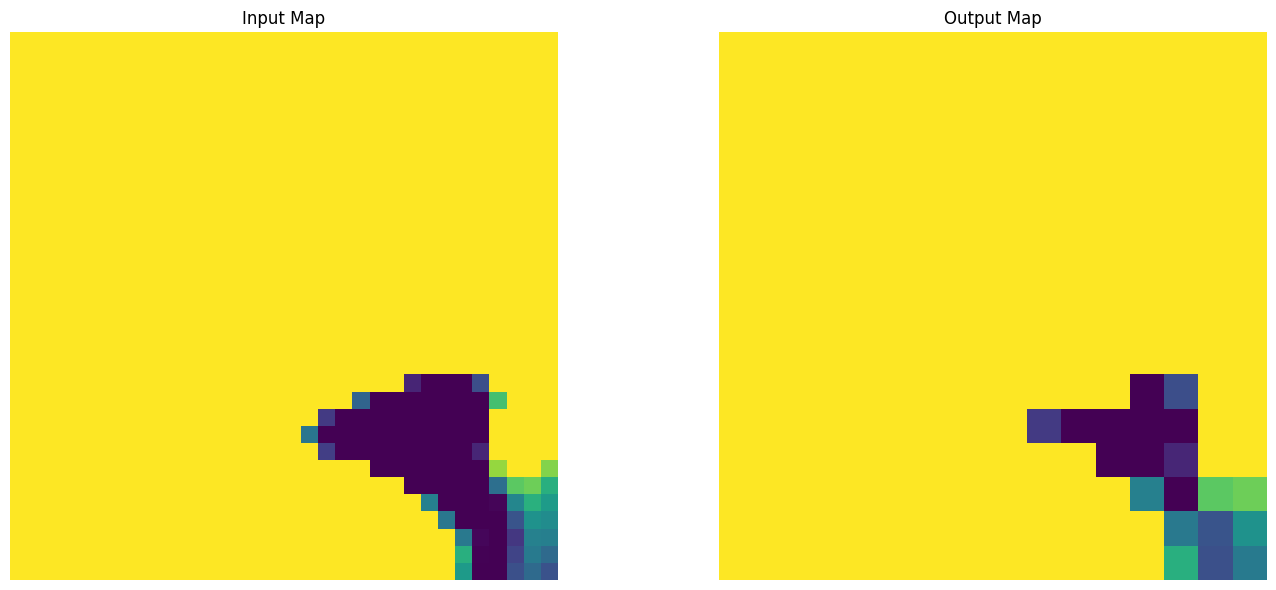

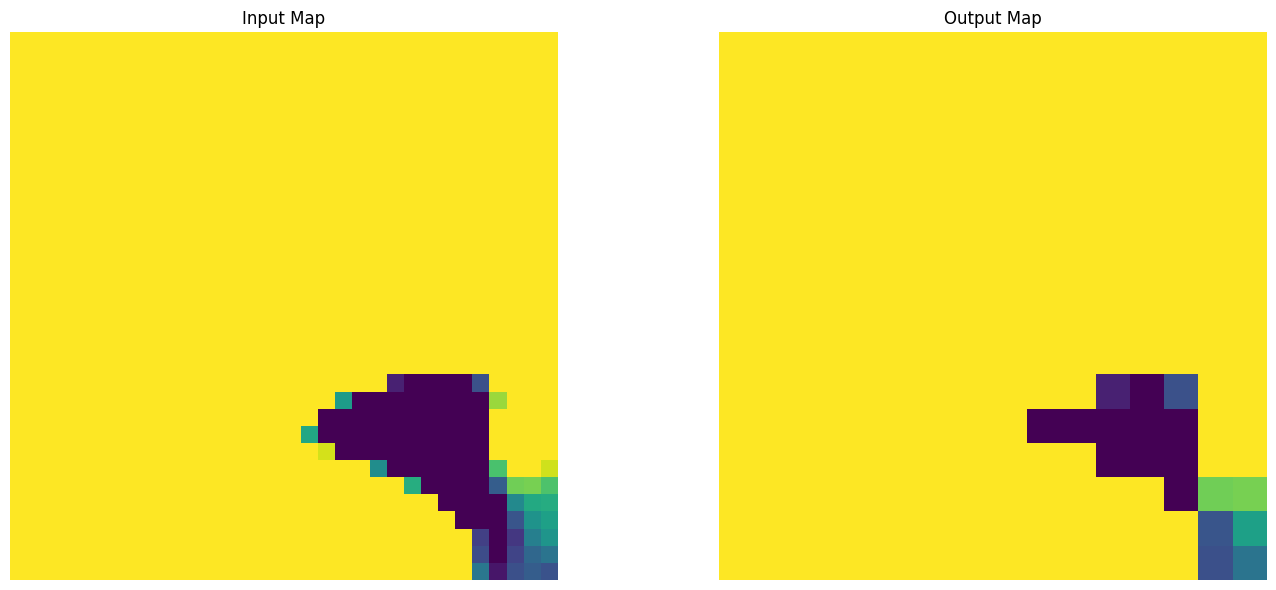

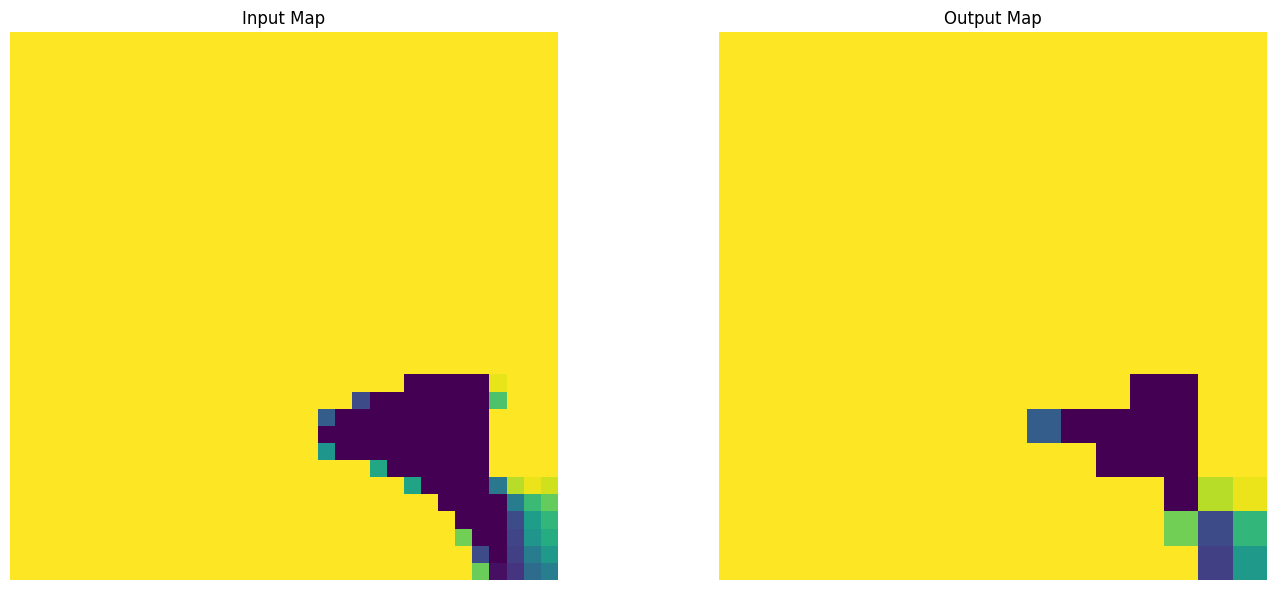

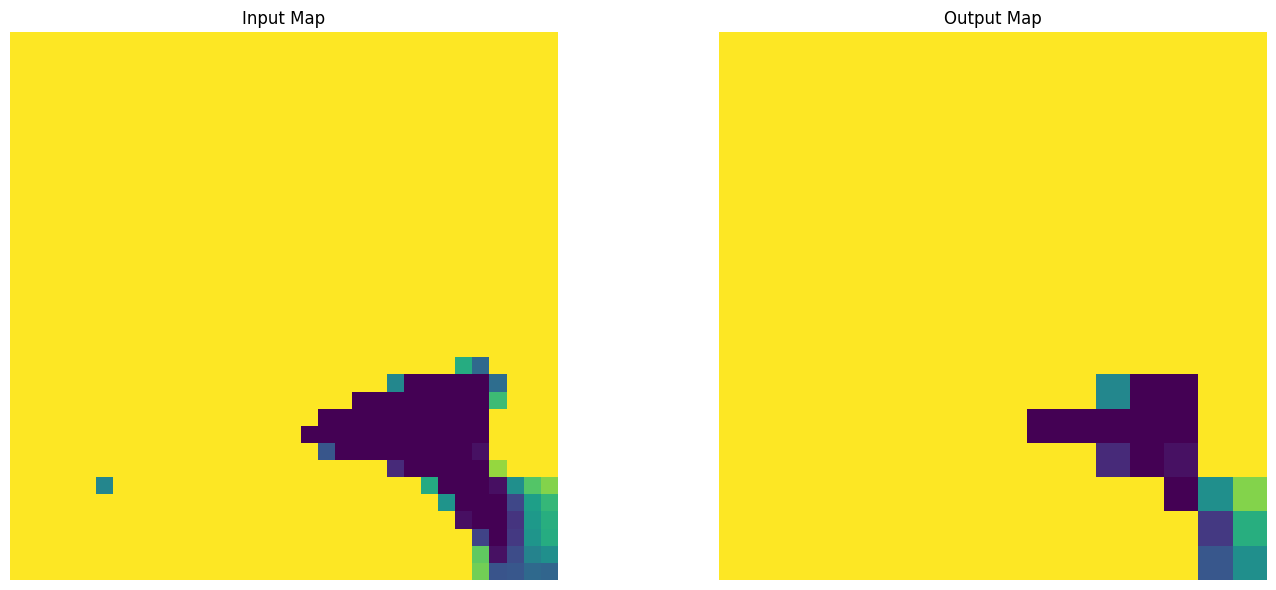

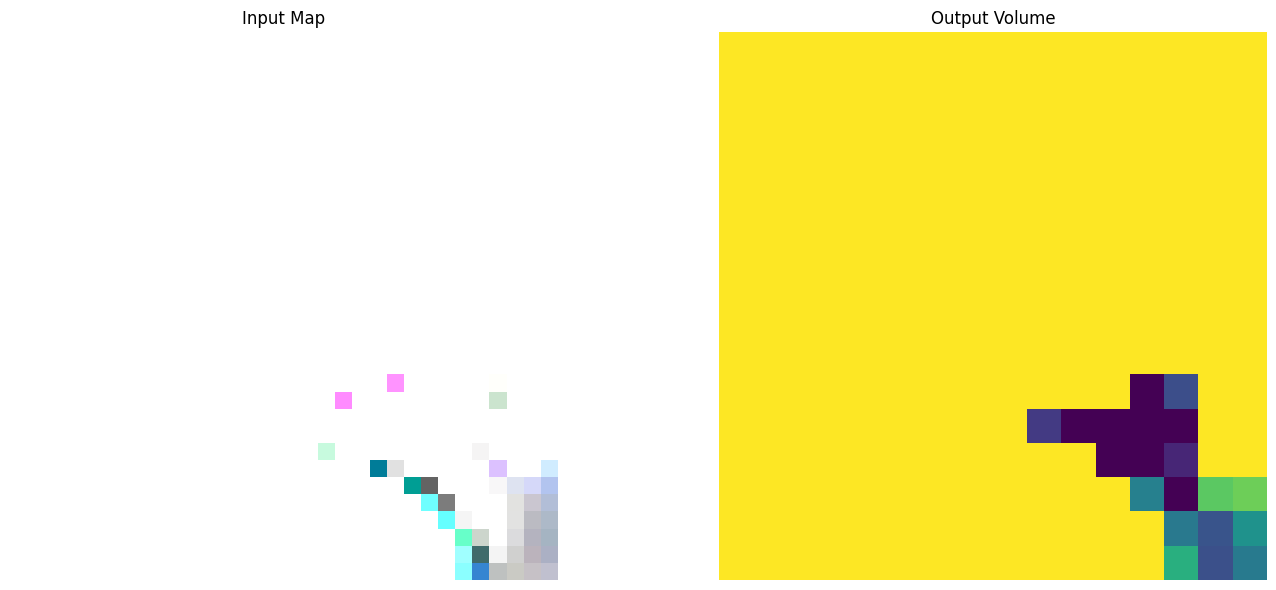

(16, 16, 4)


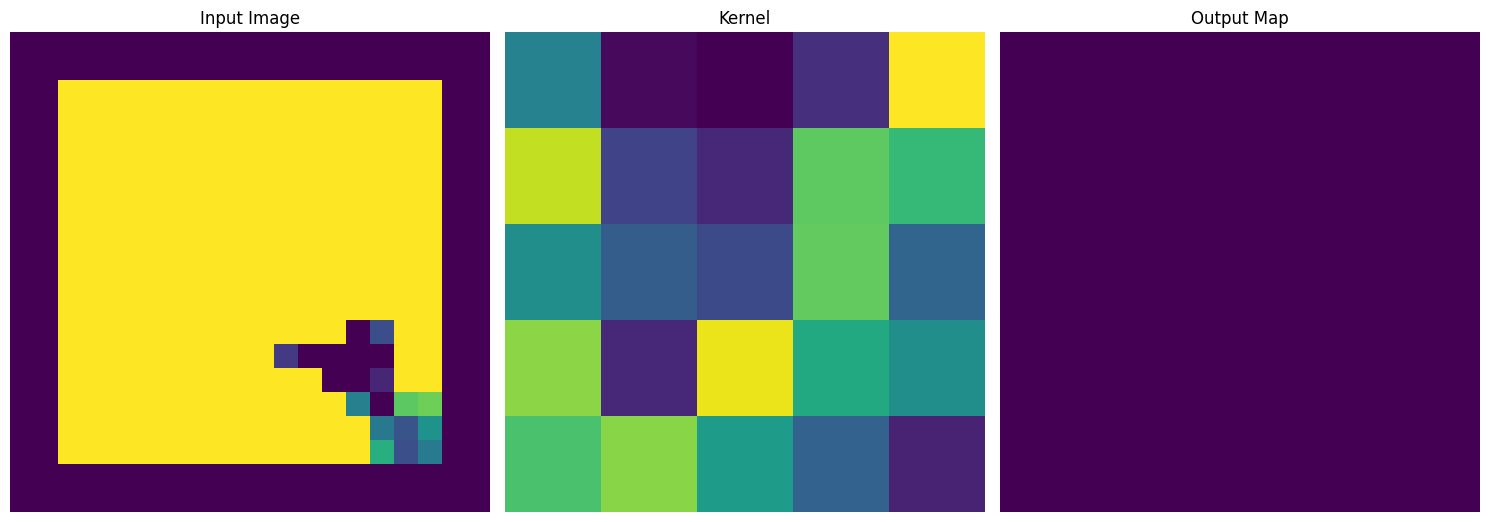

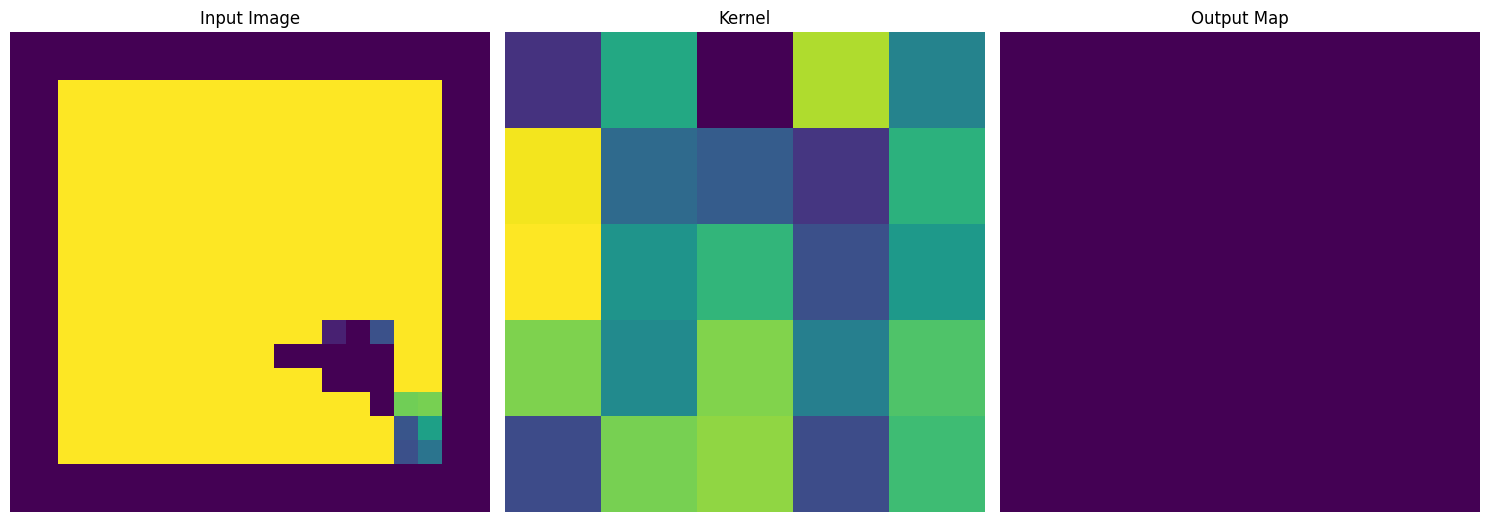

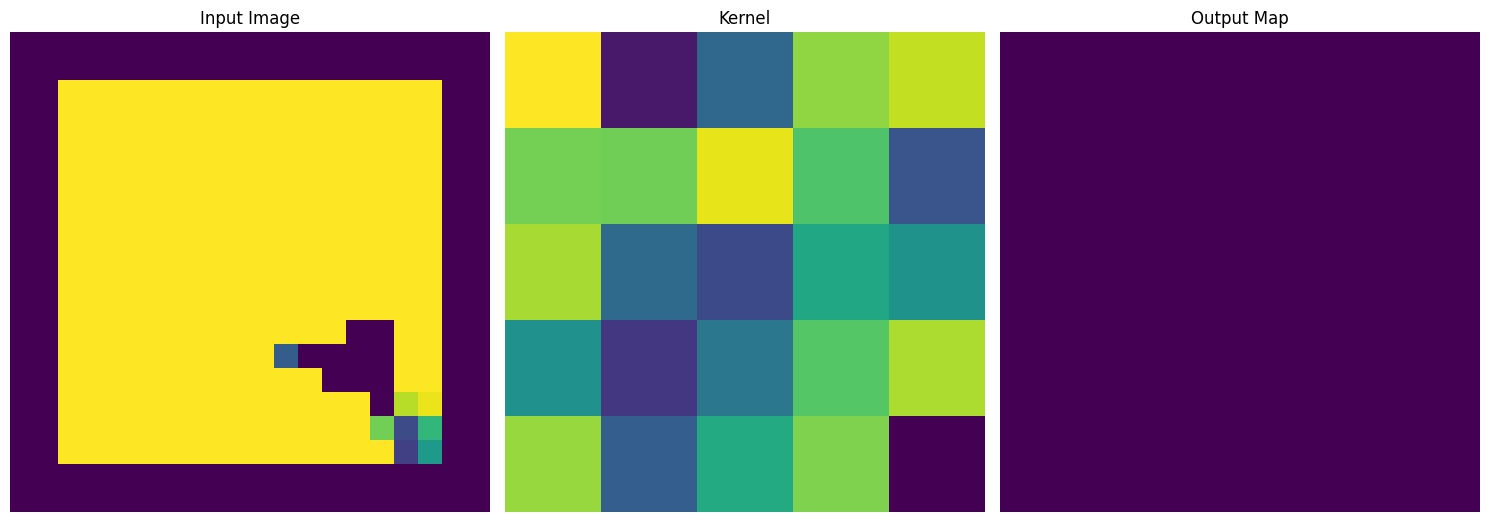

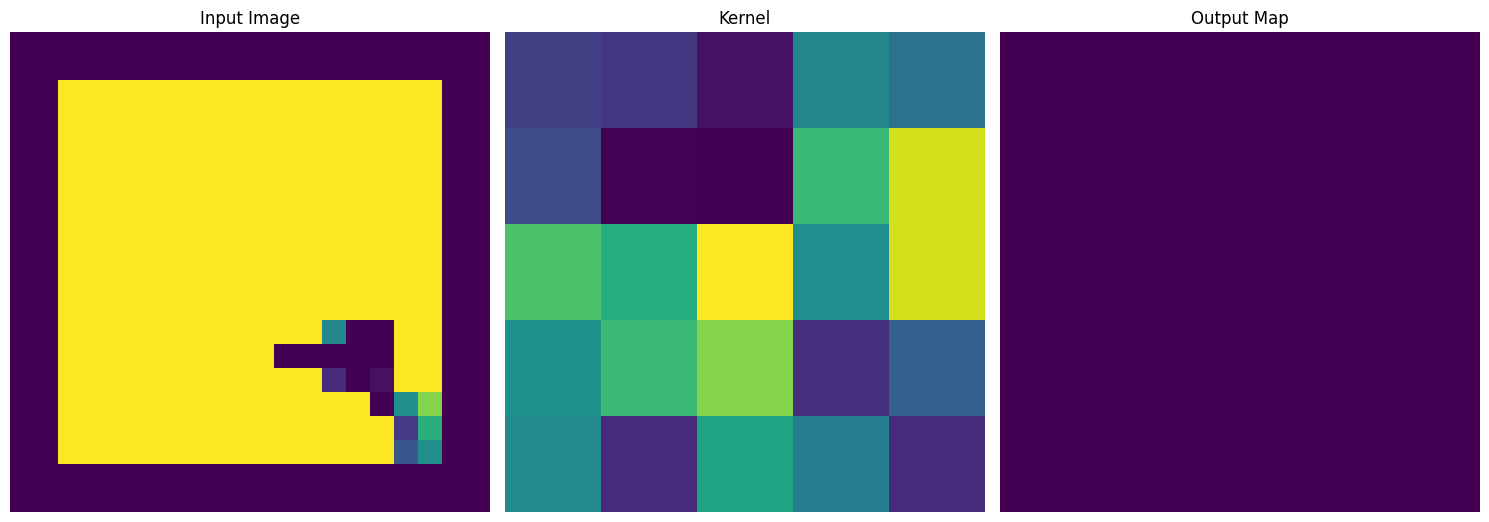

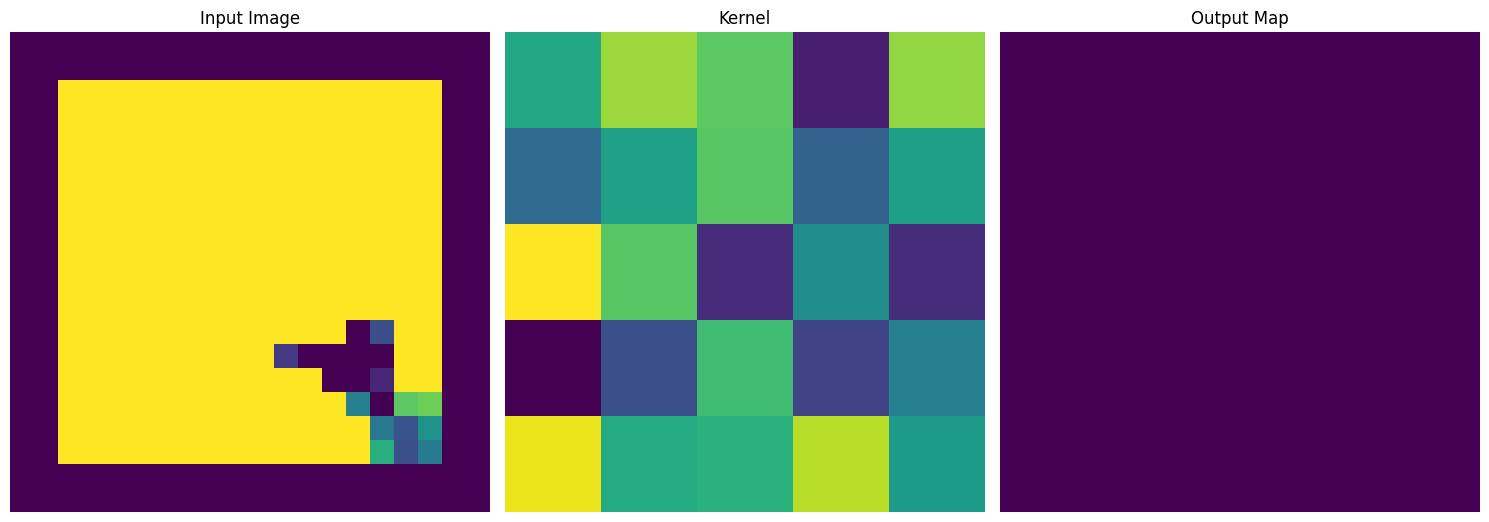

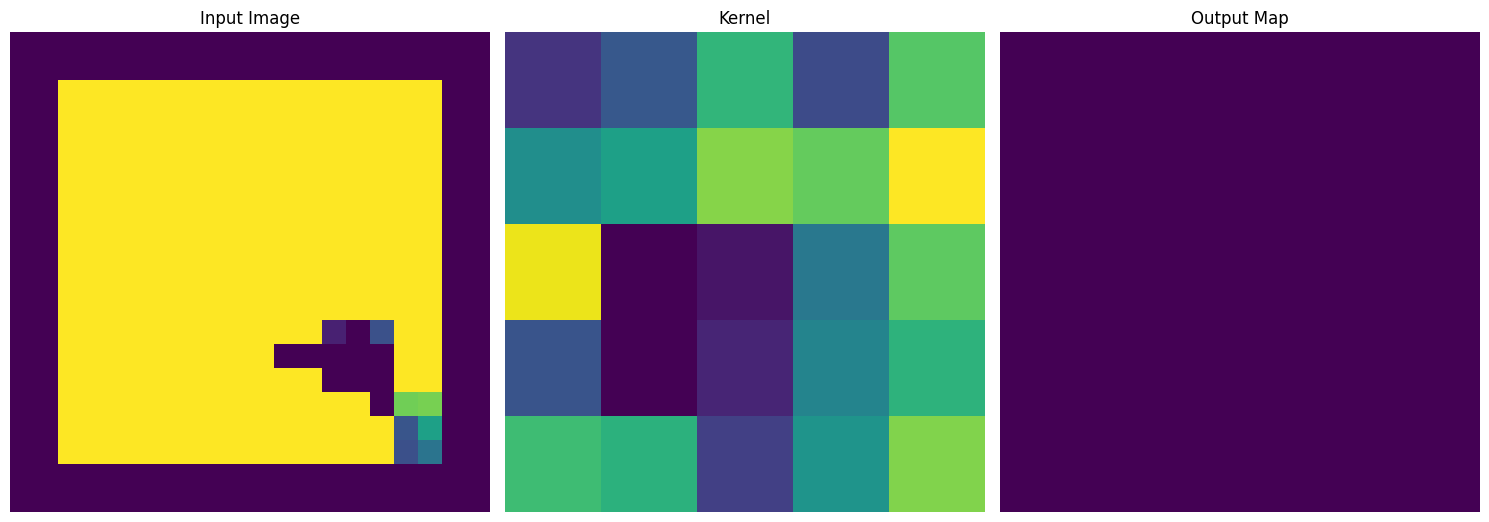

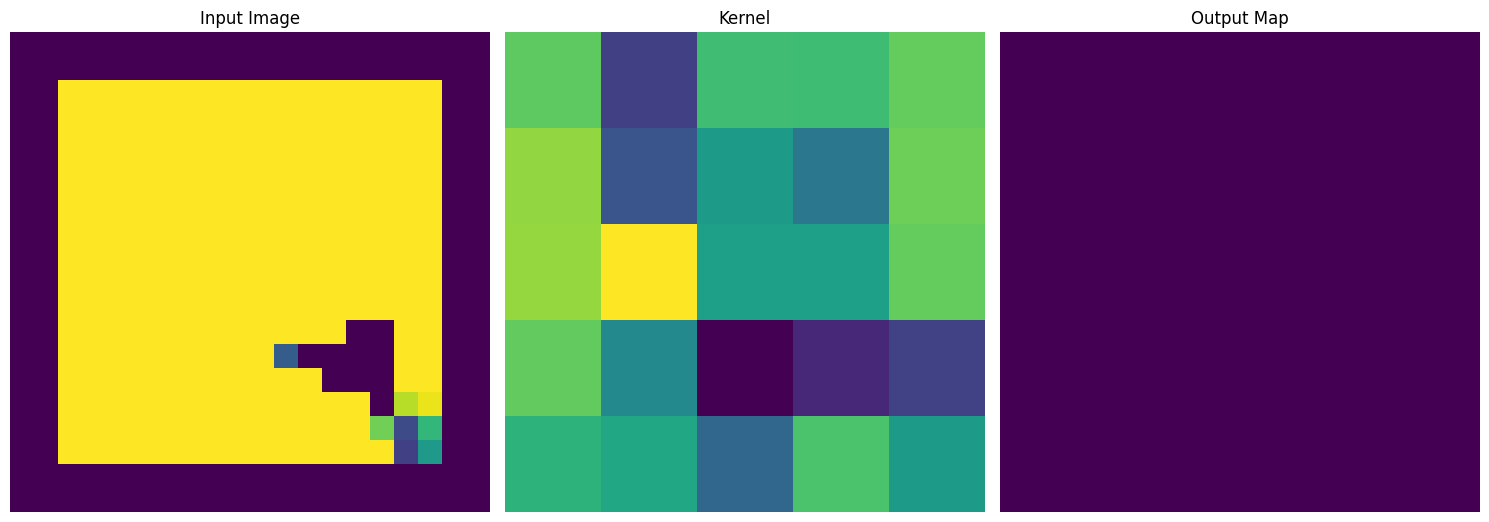

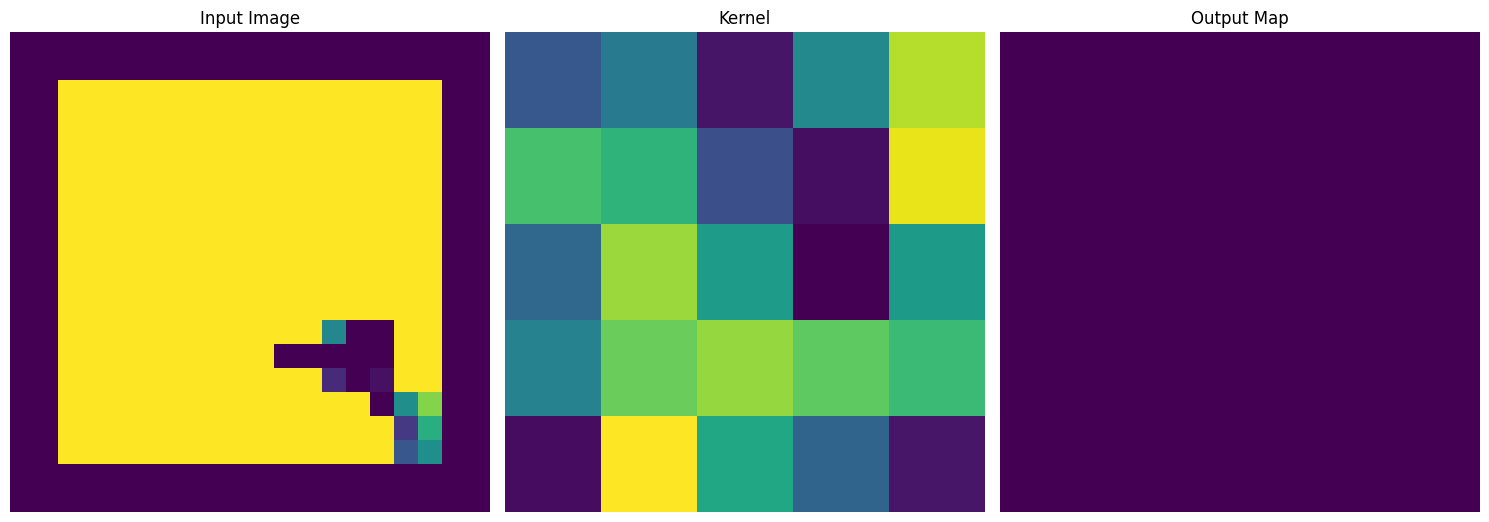

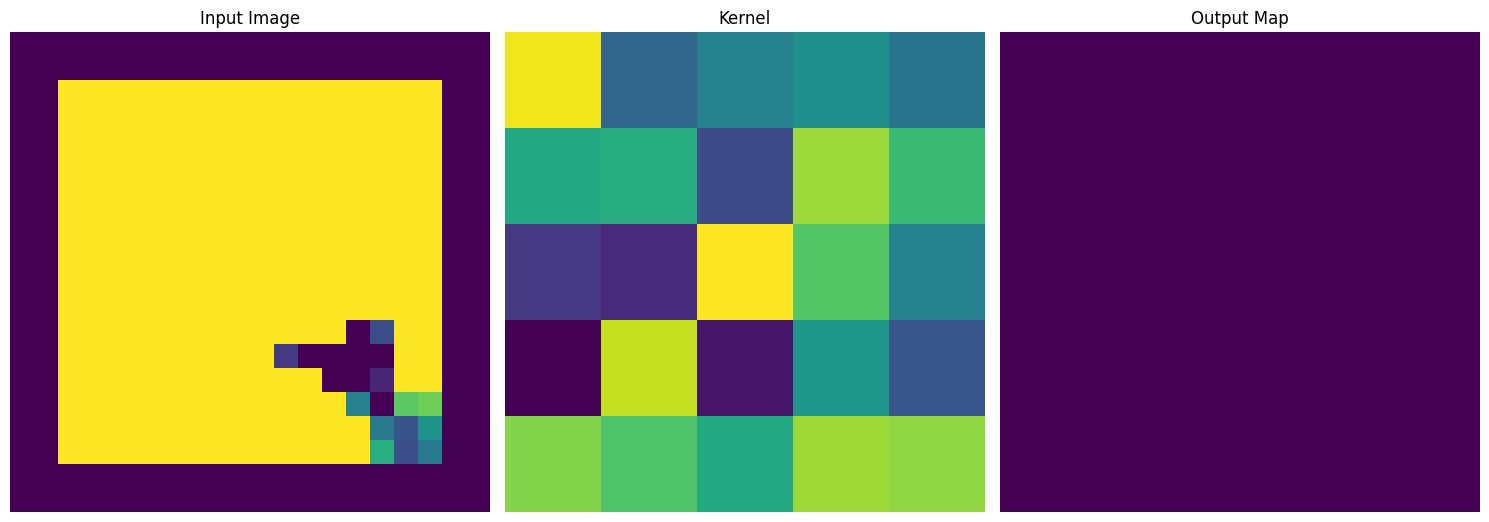

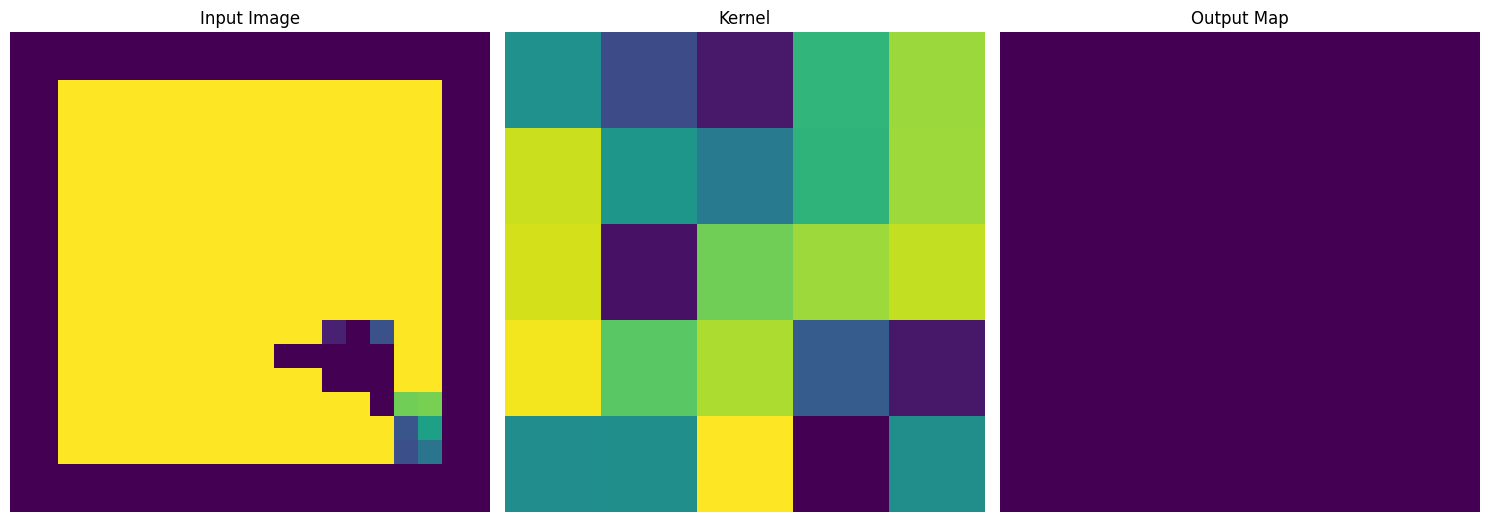

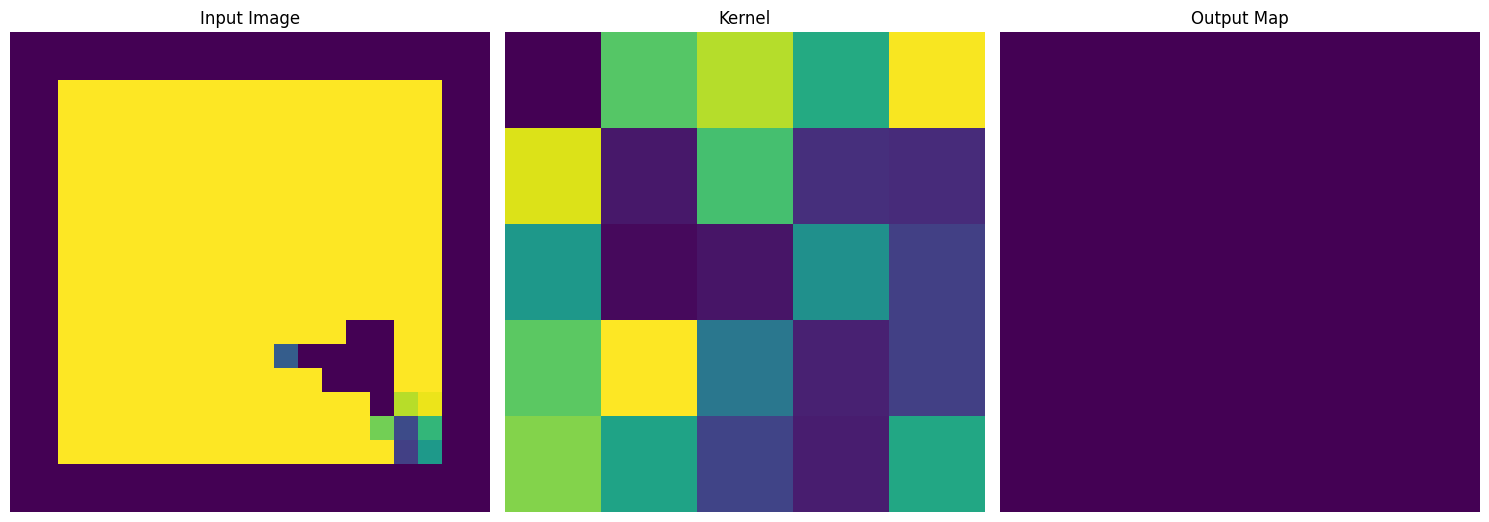

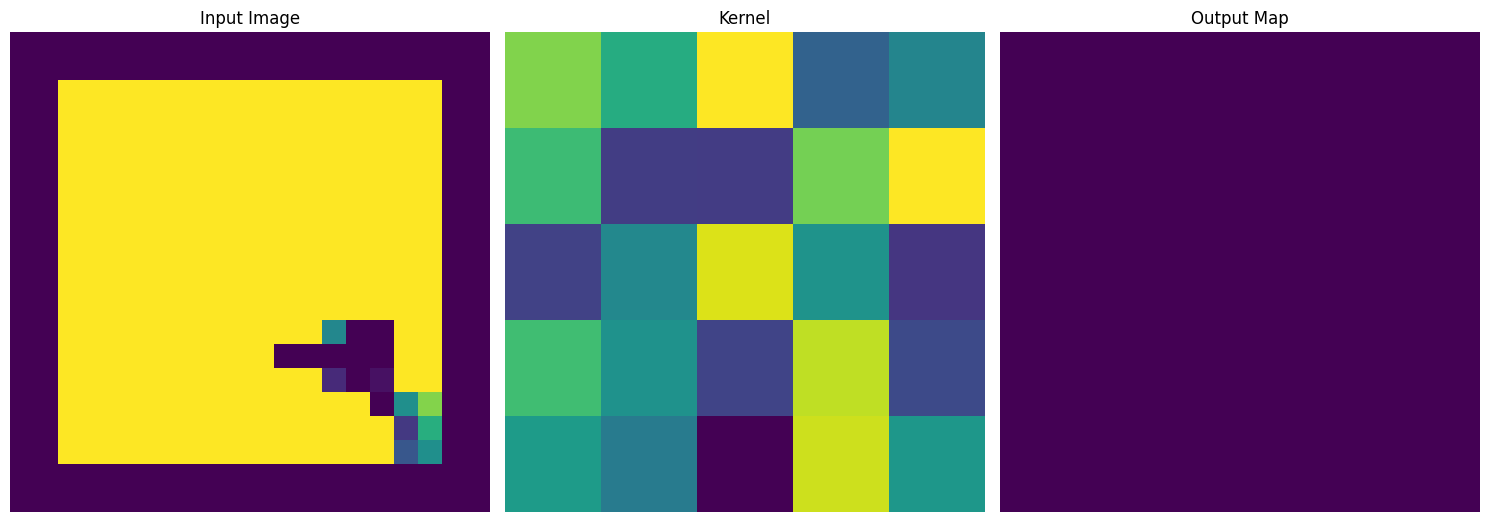

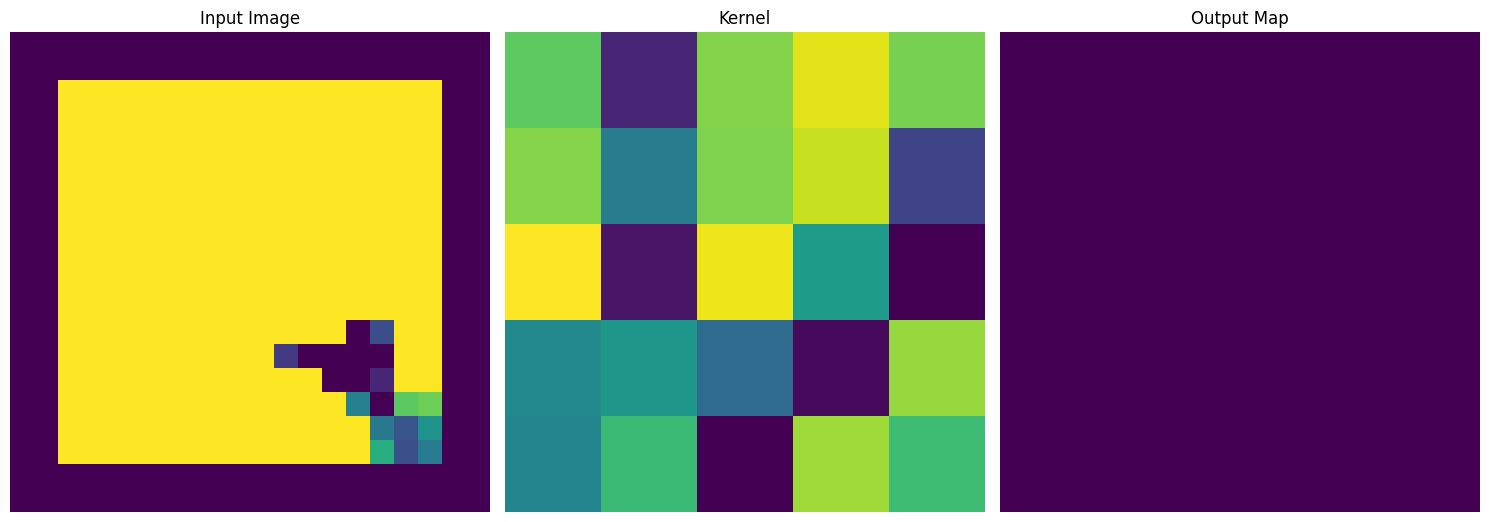

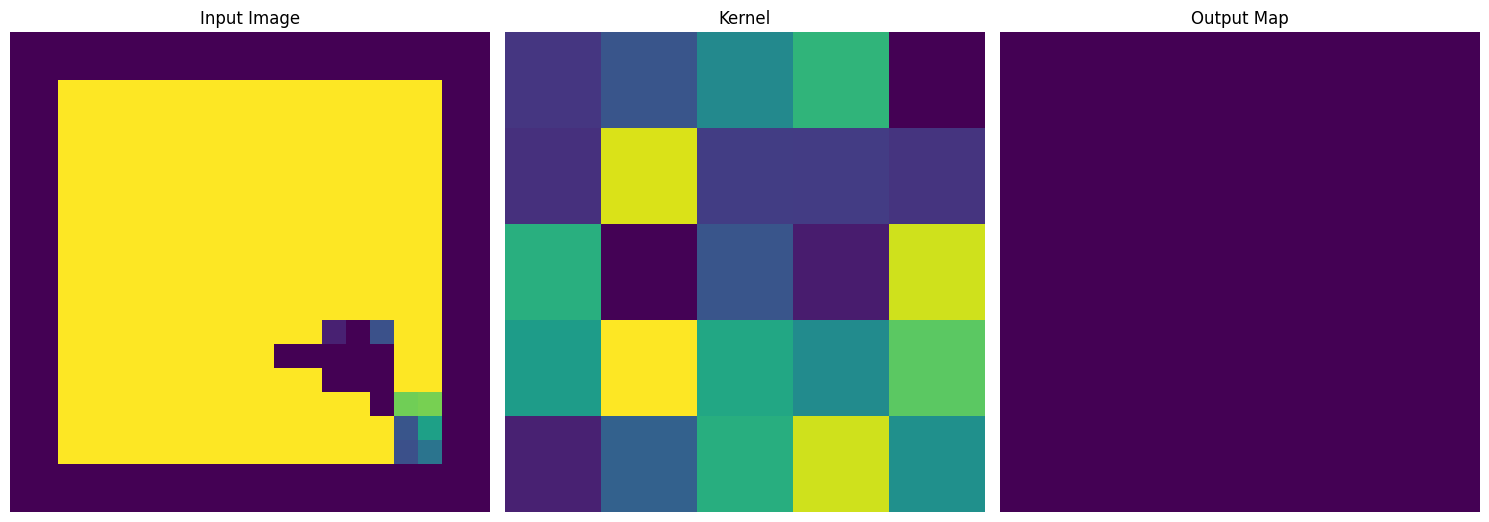

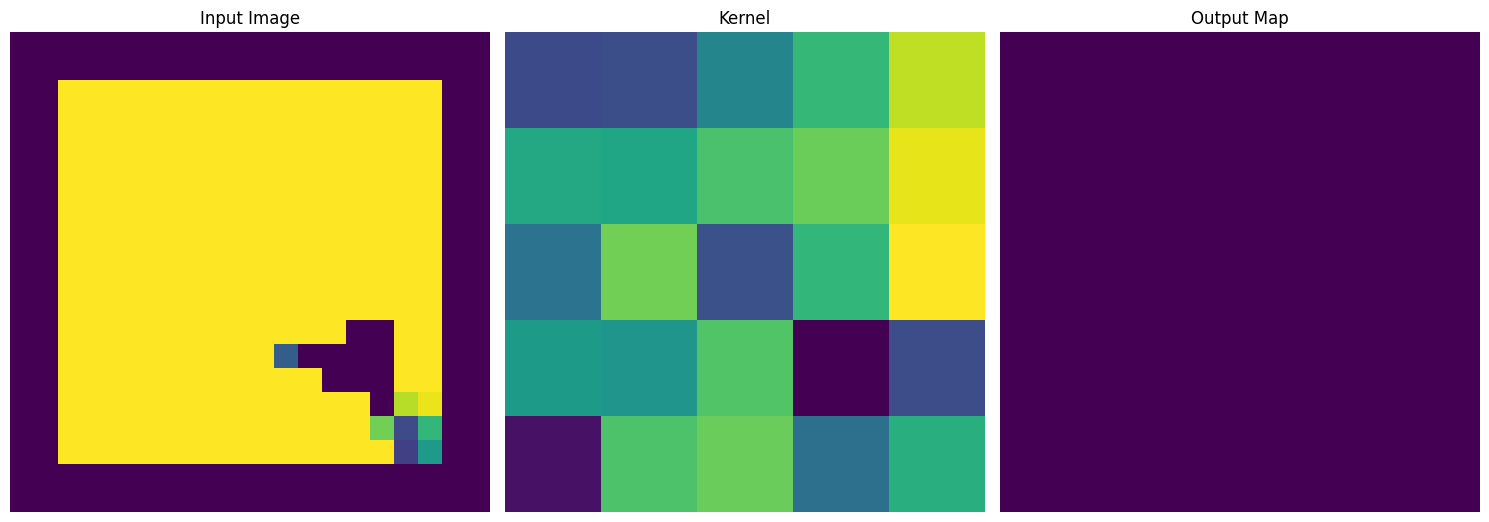

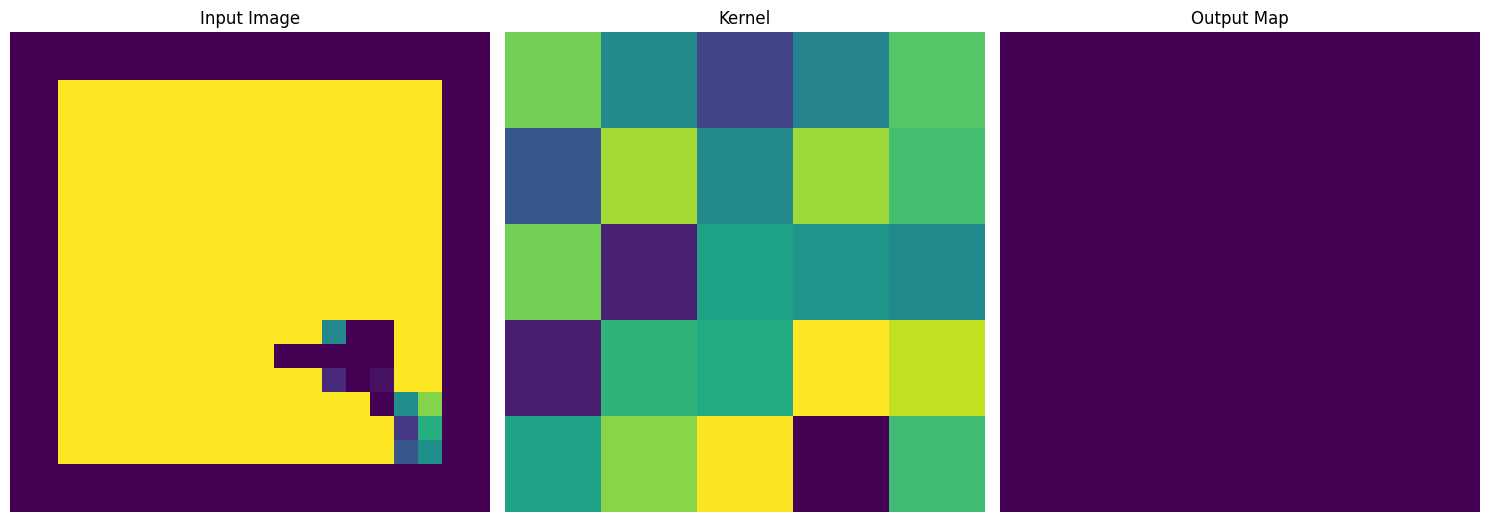

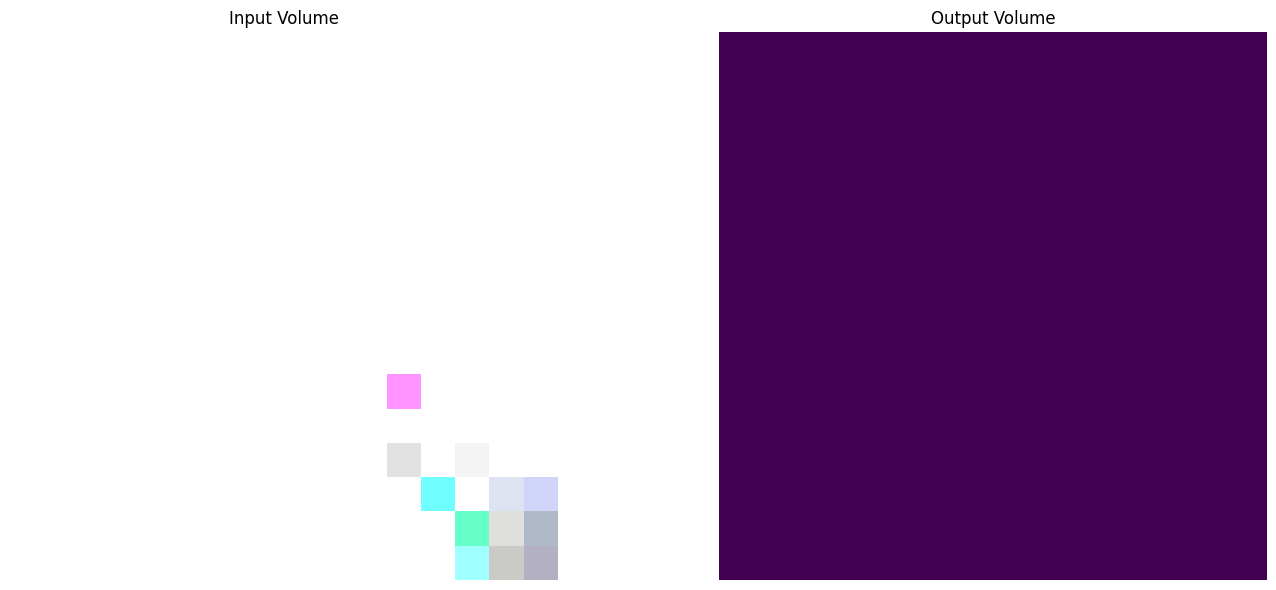

(16, 16, 4)


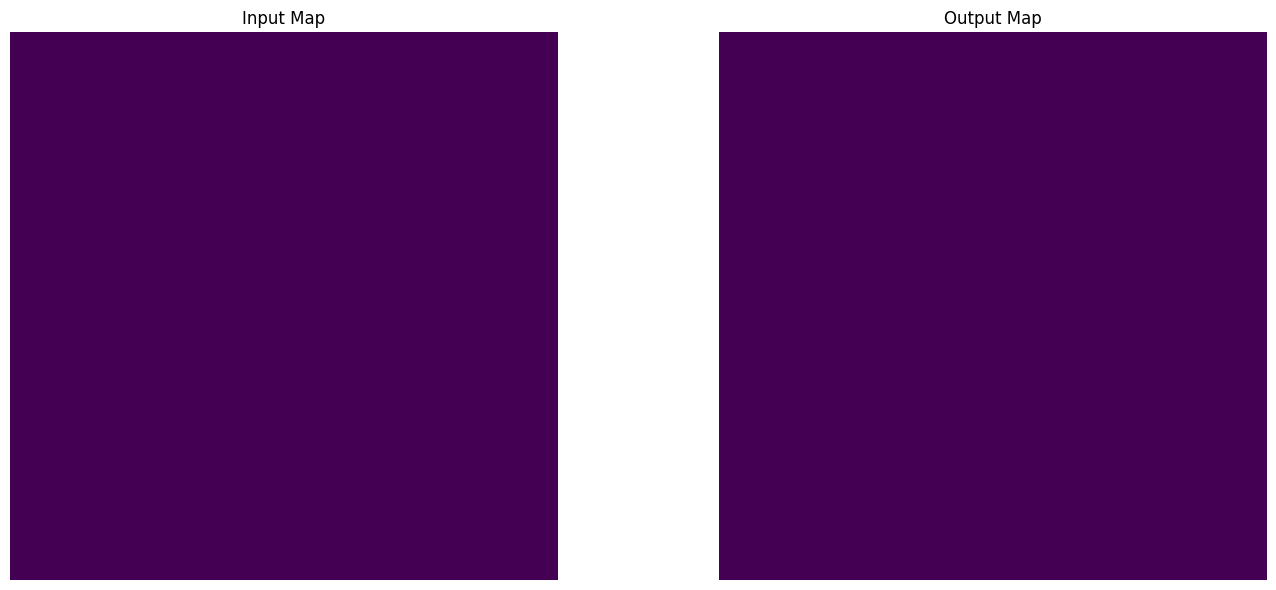

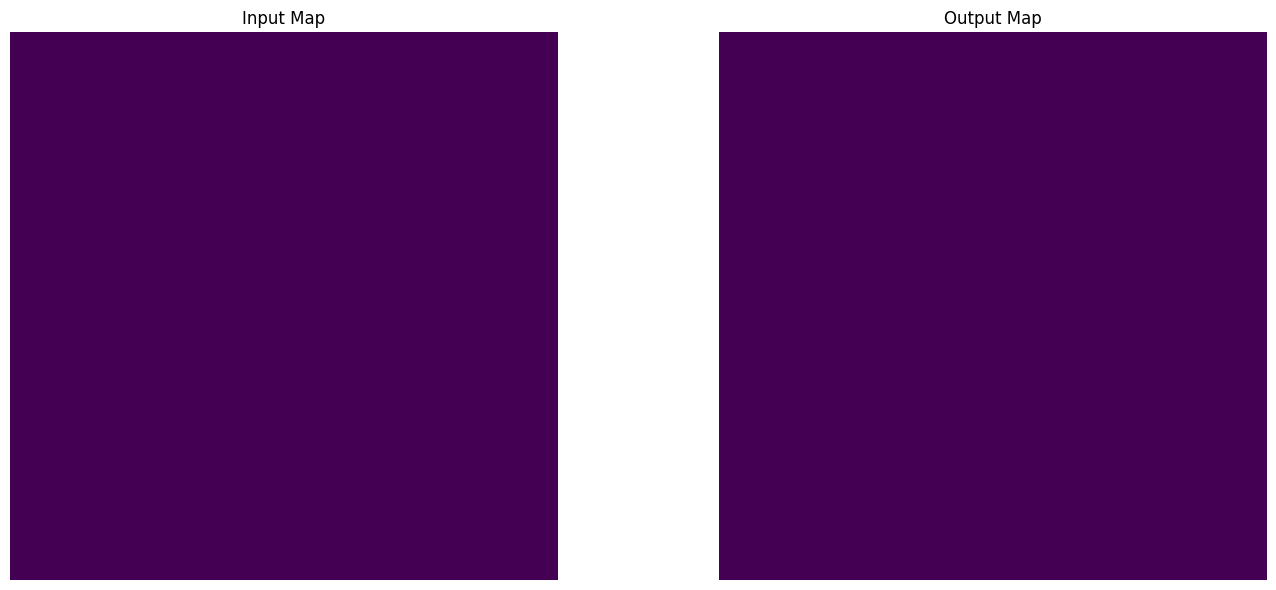

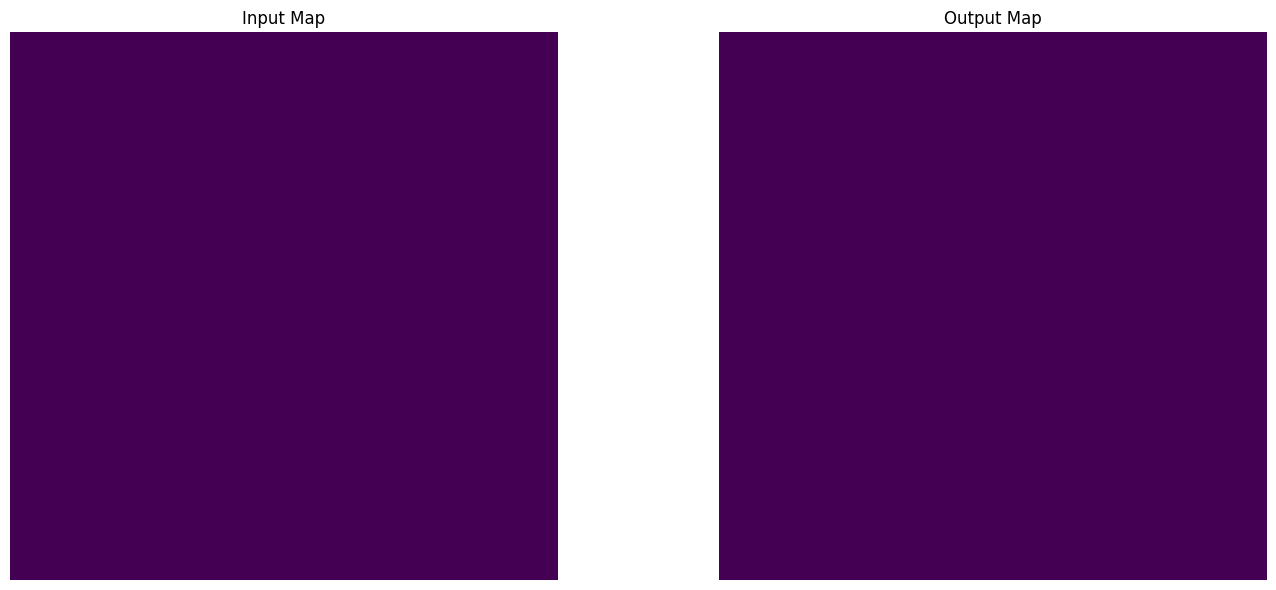

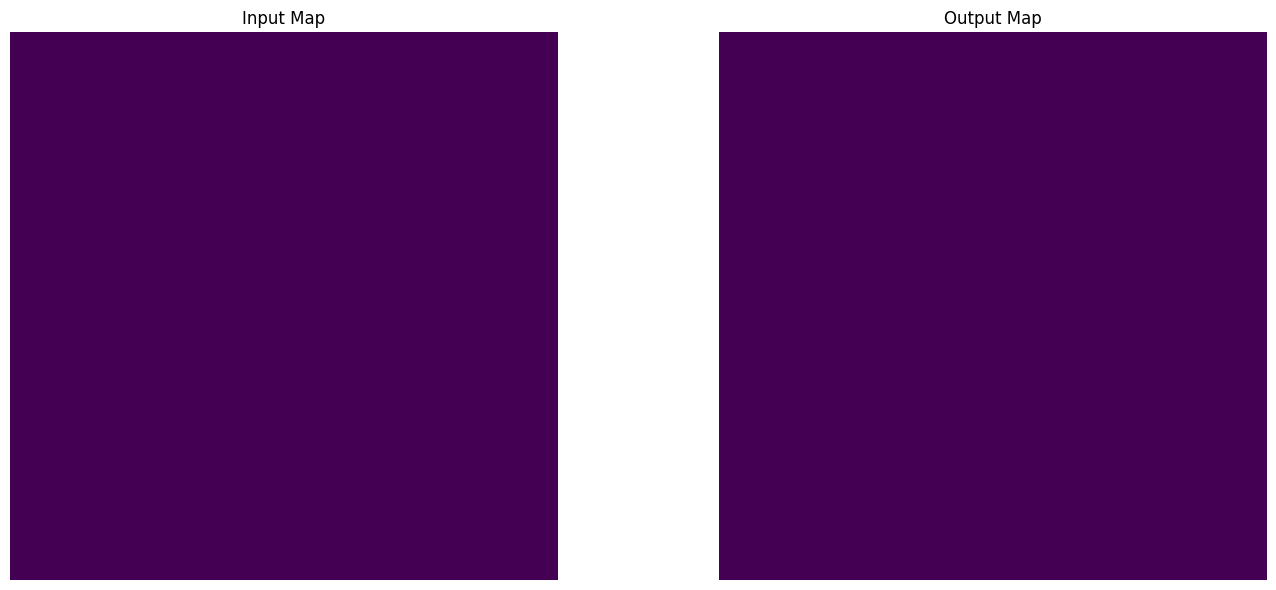

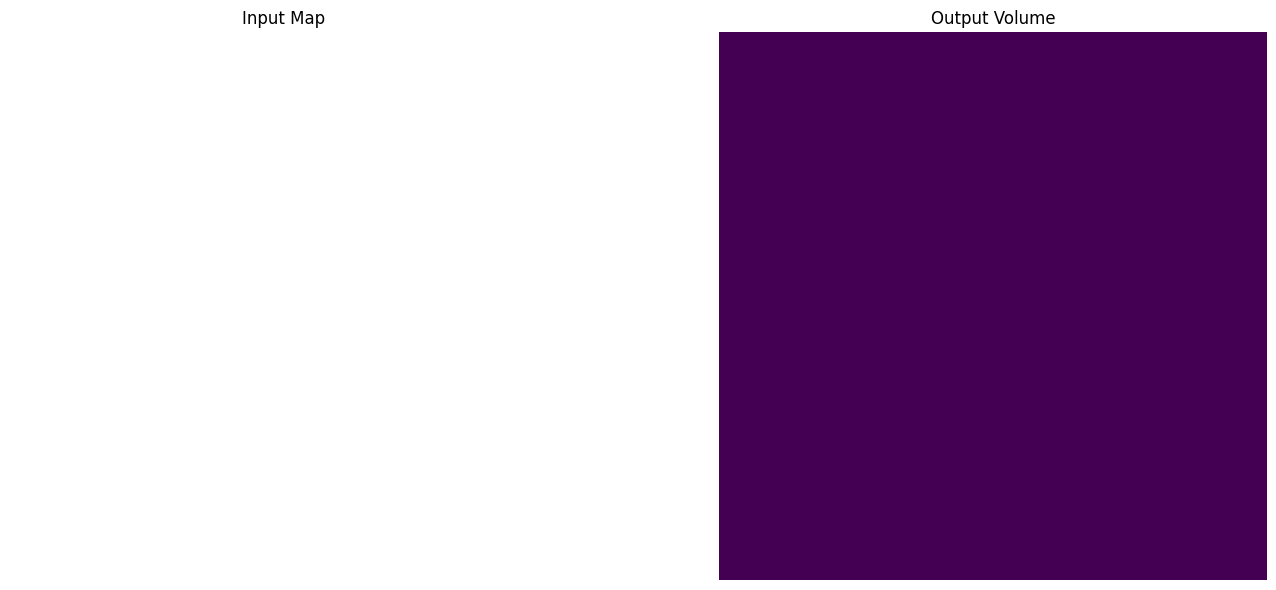

(8, 8, 4)


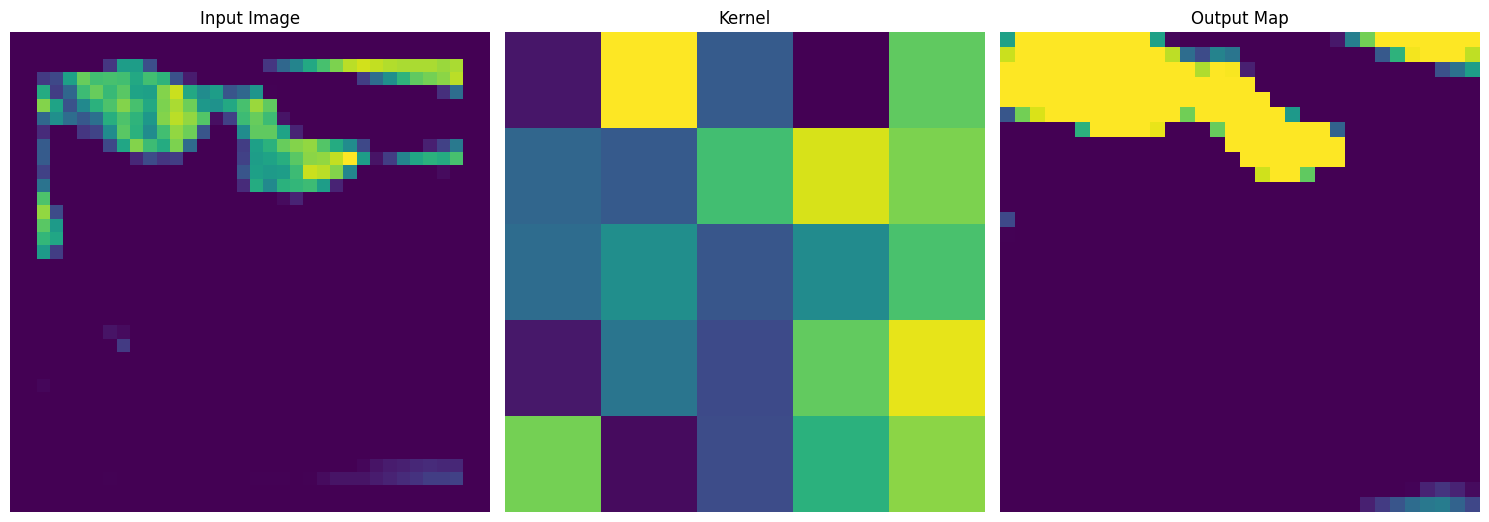

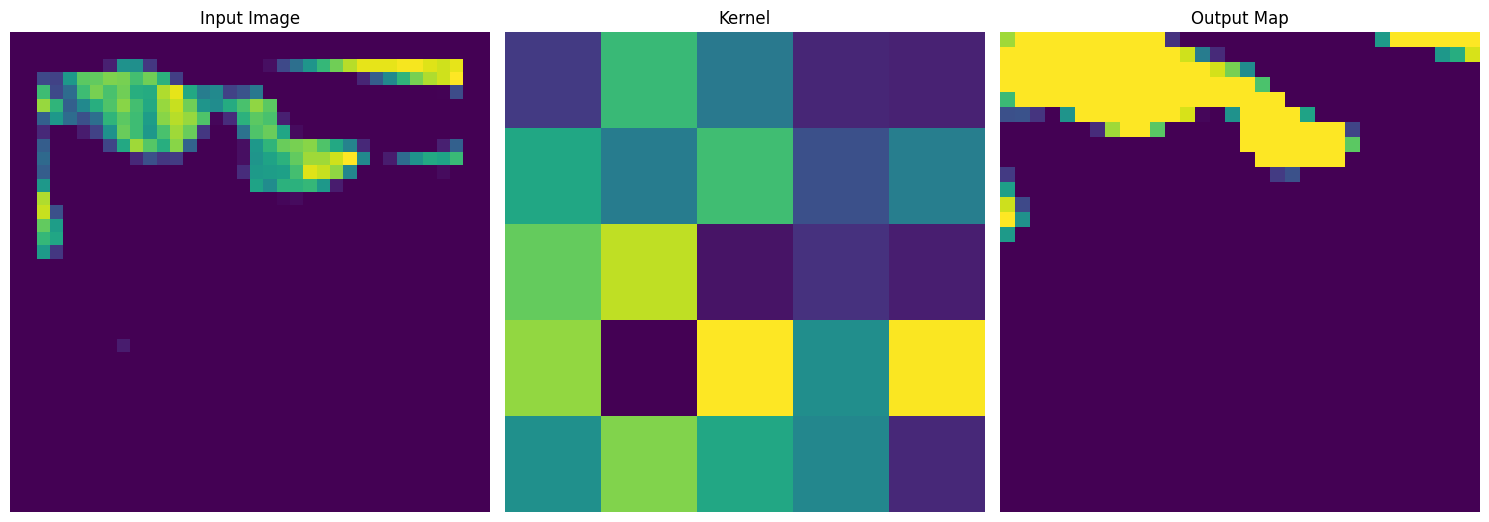

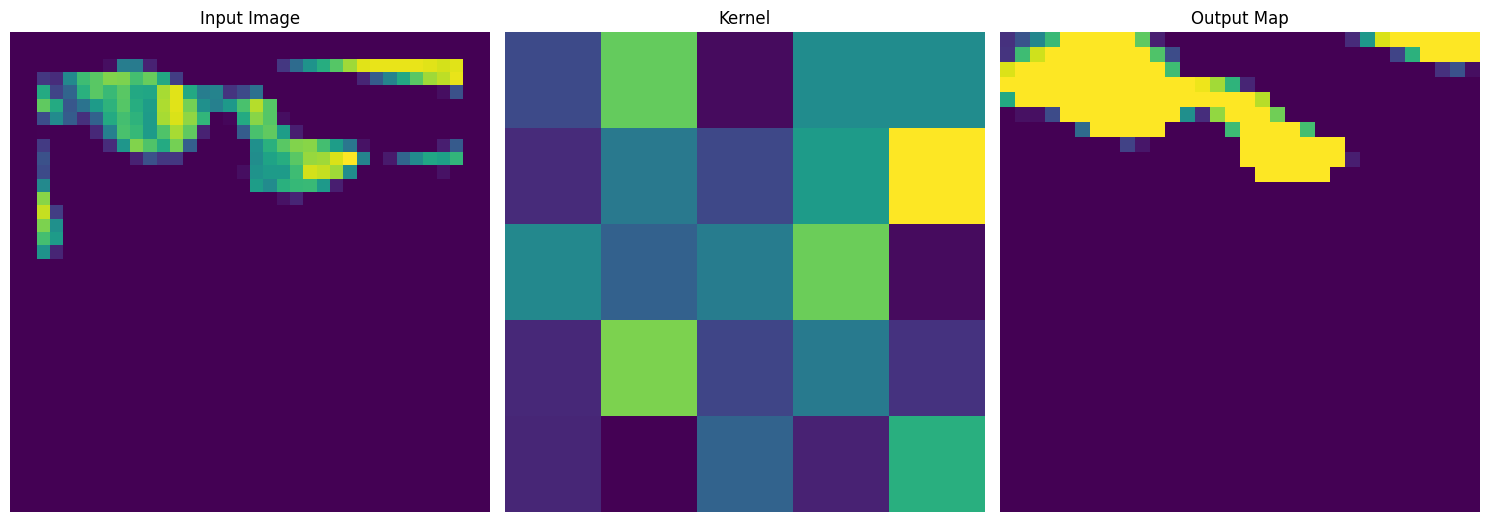

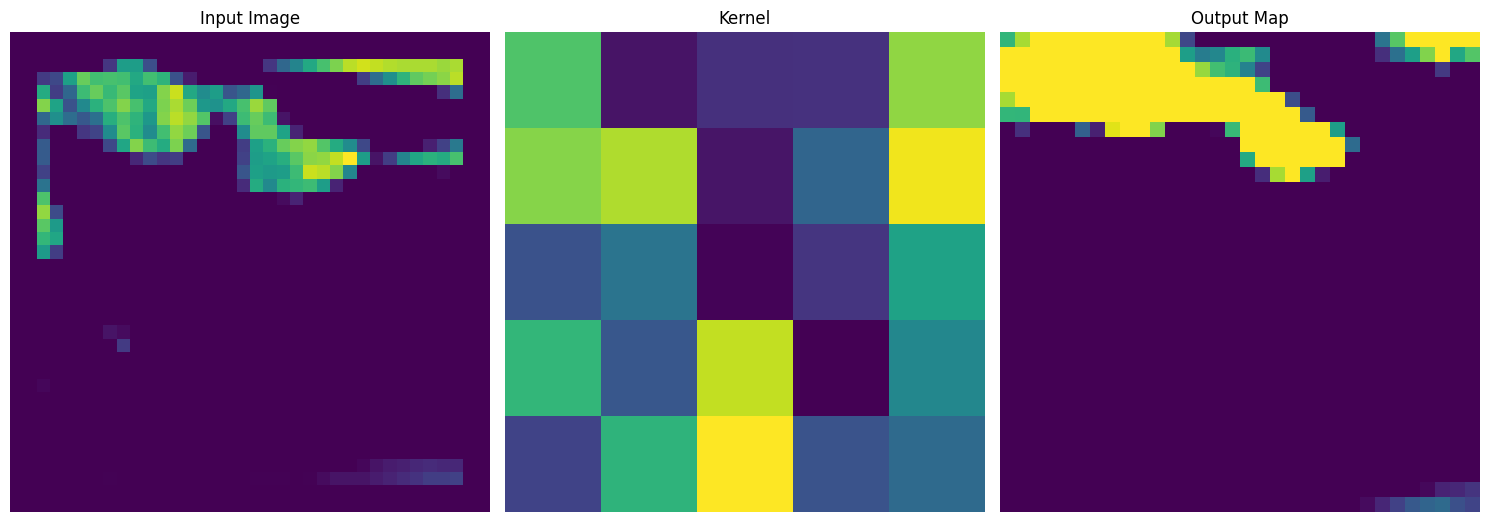

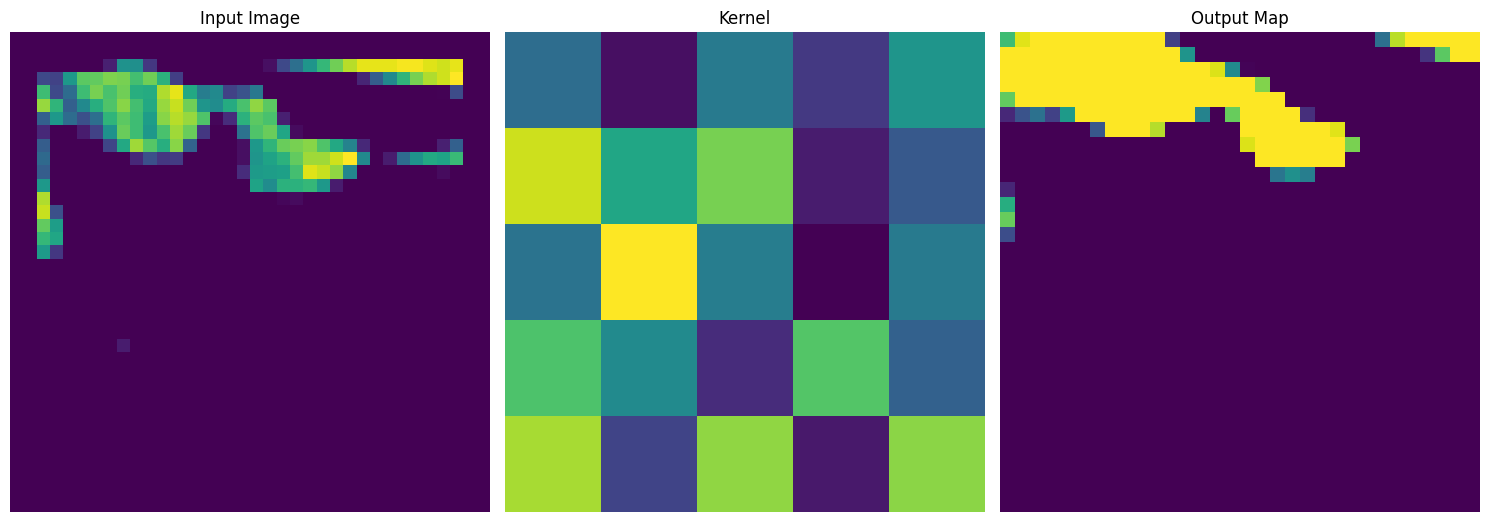

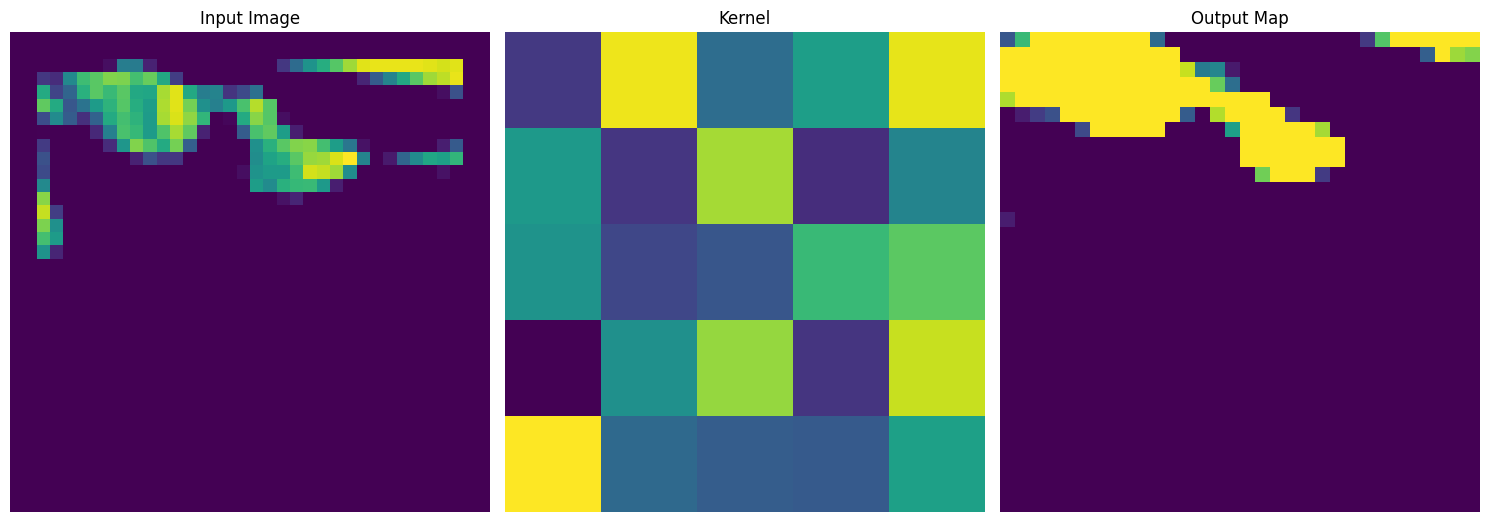

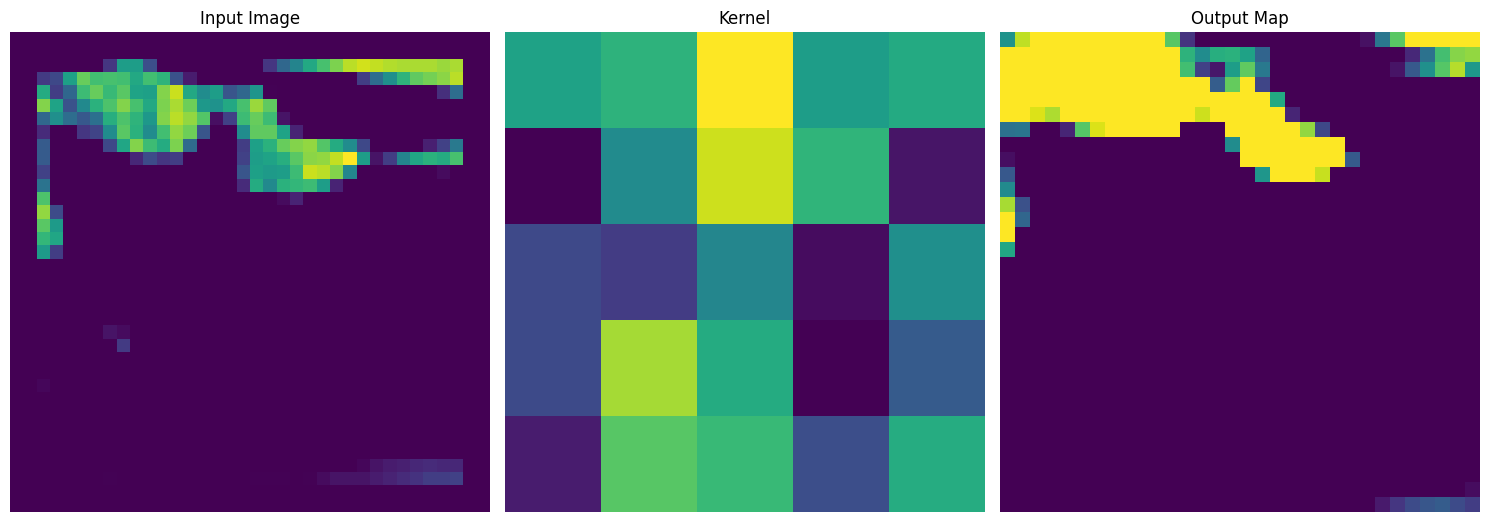

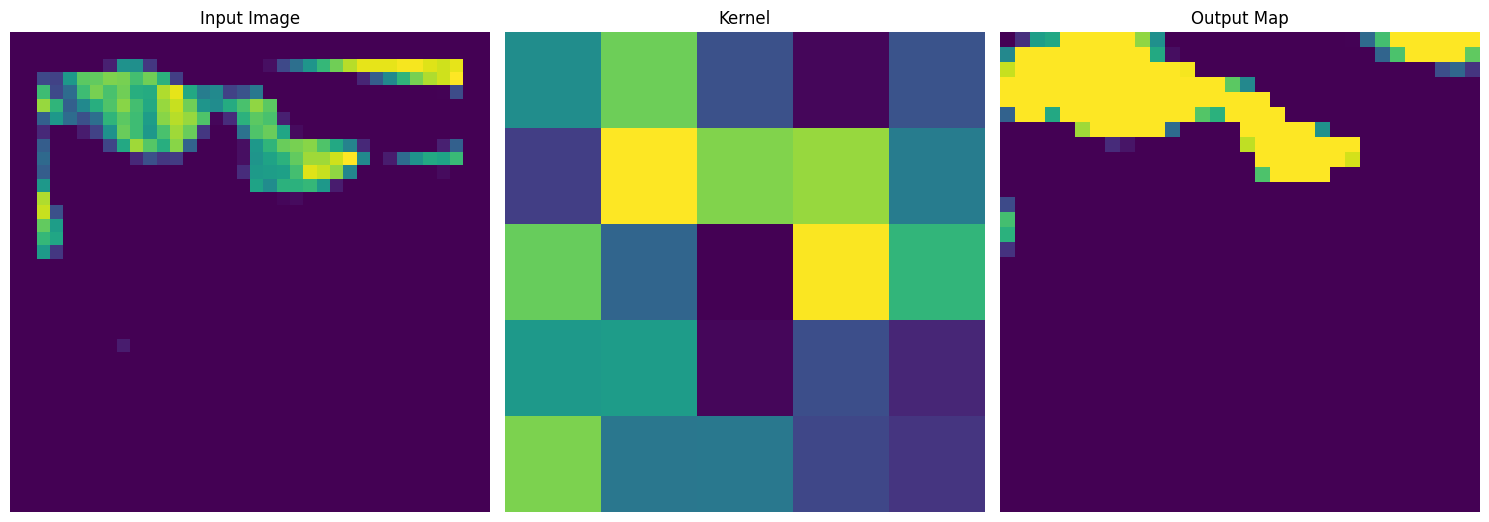

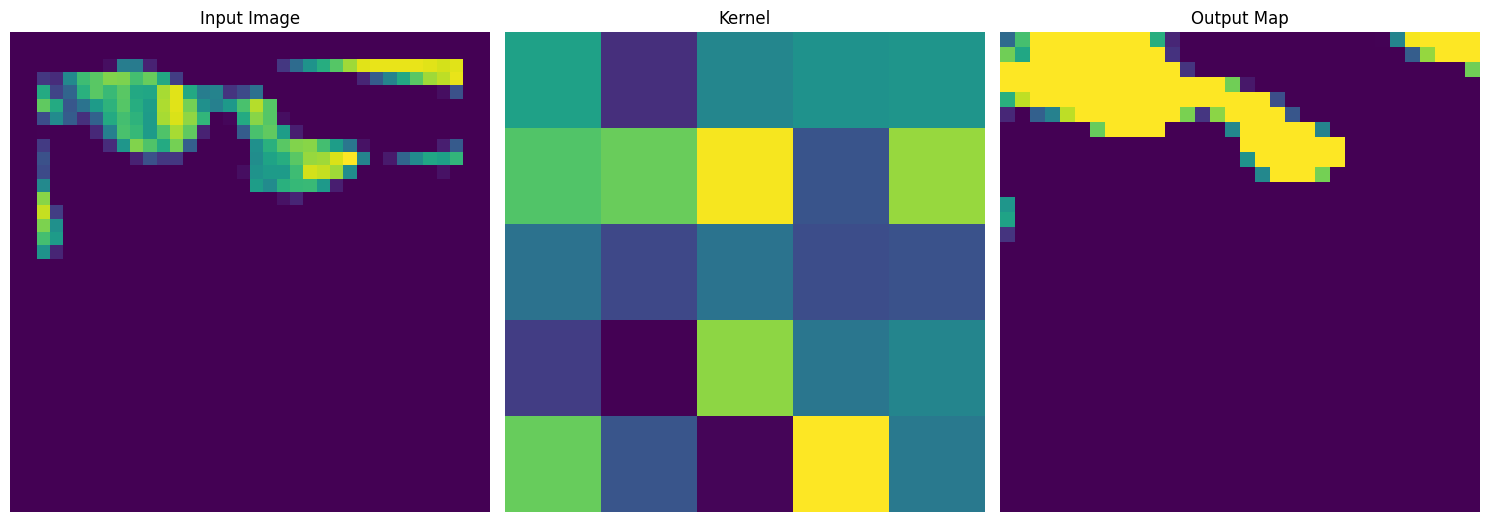

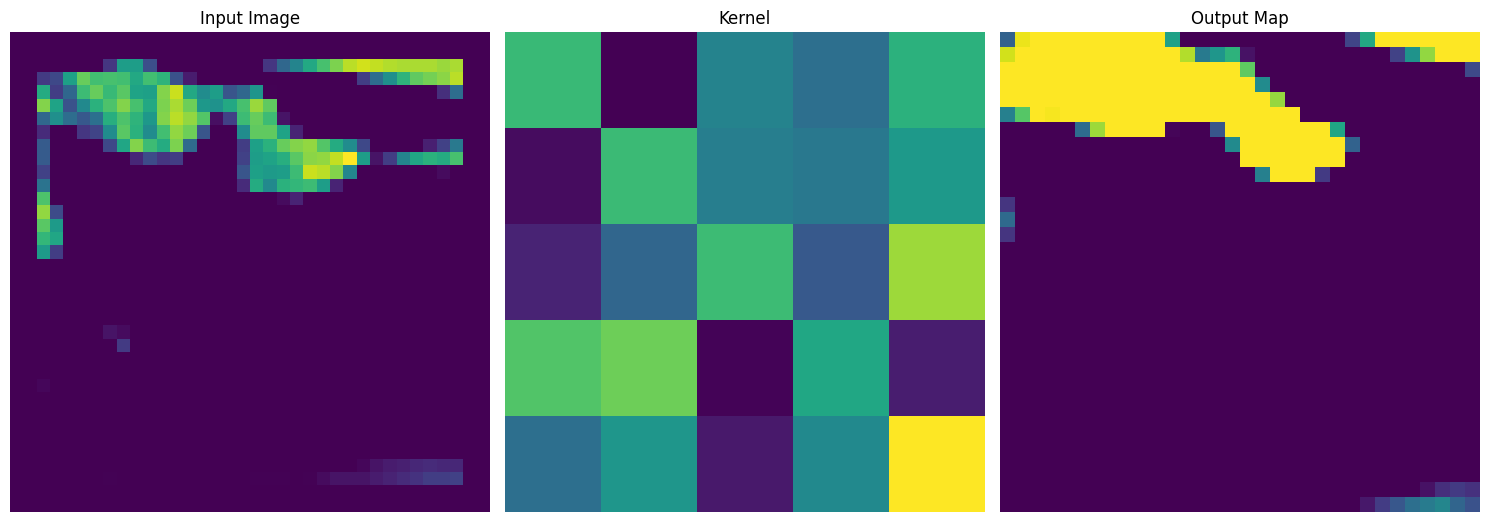

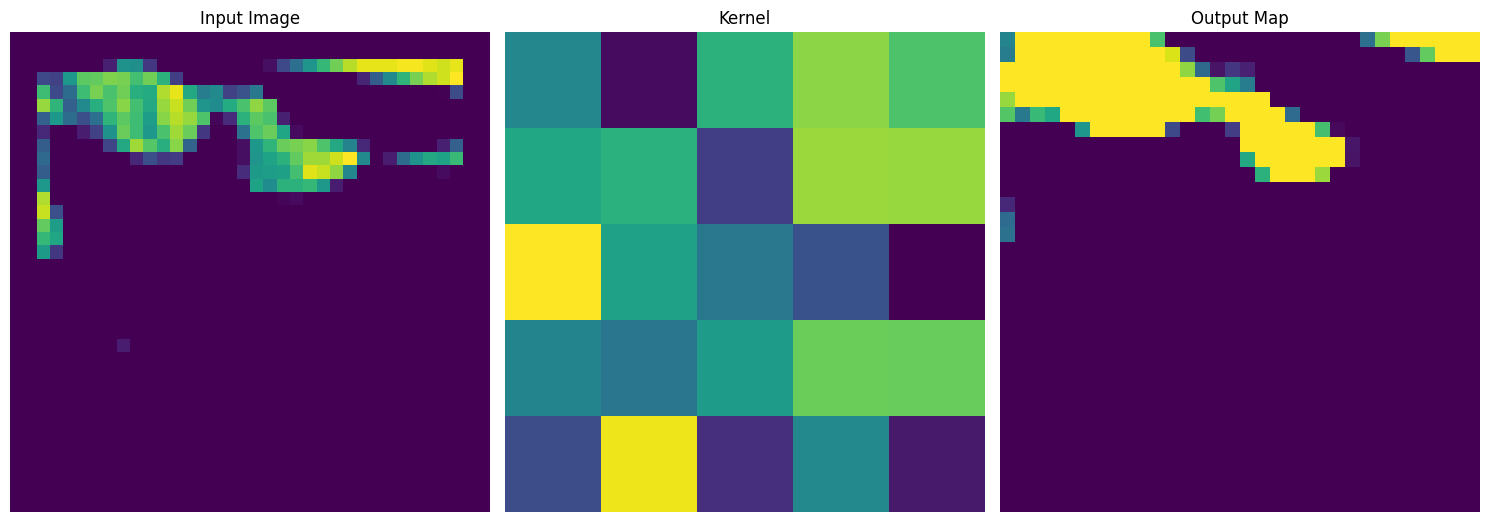

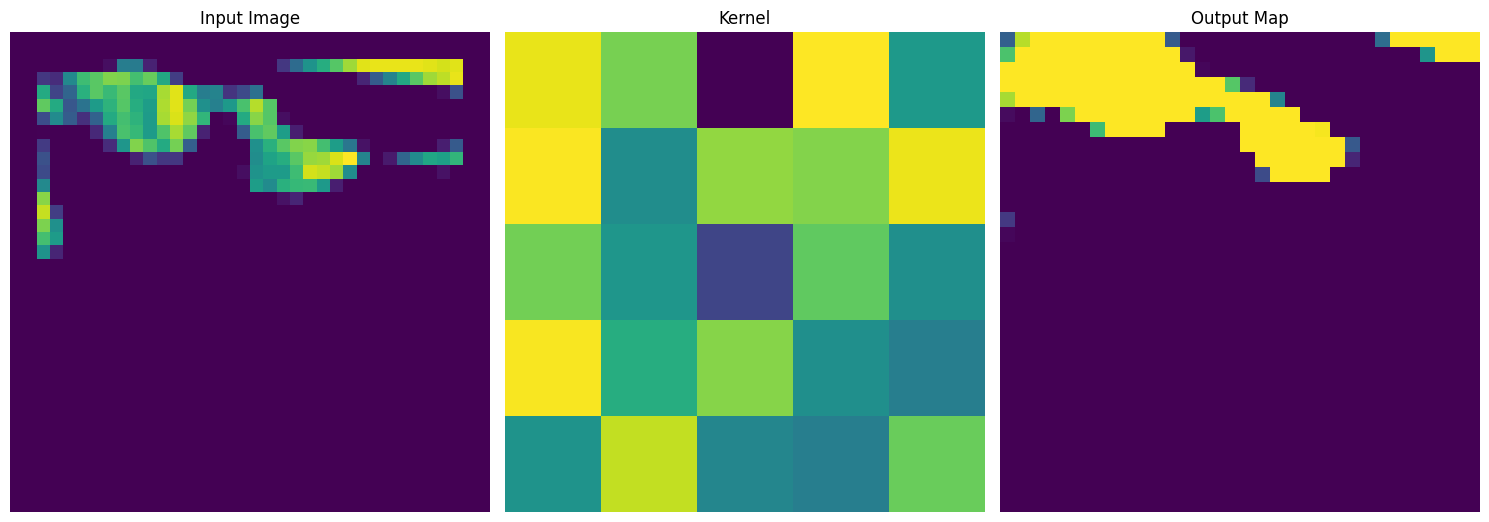

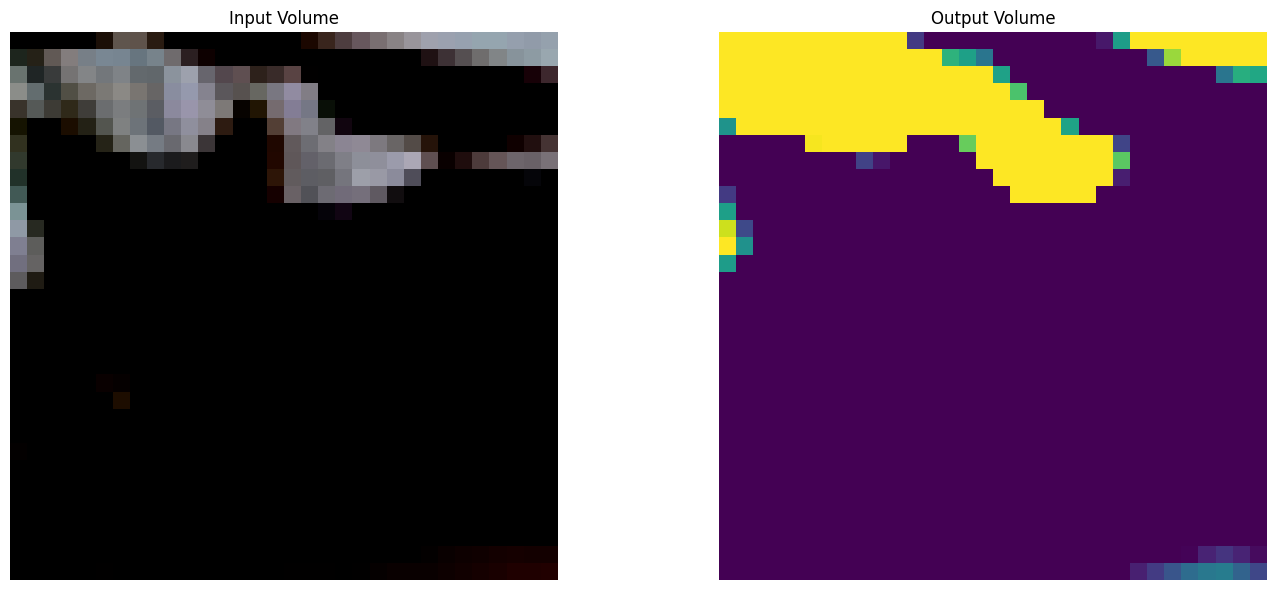

(32, 32, 4)


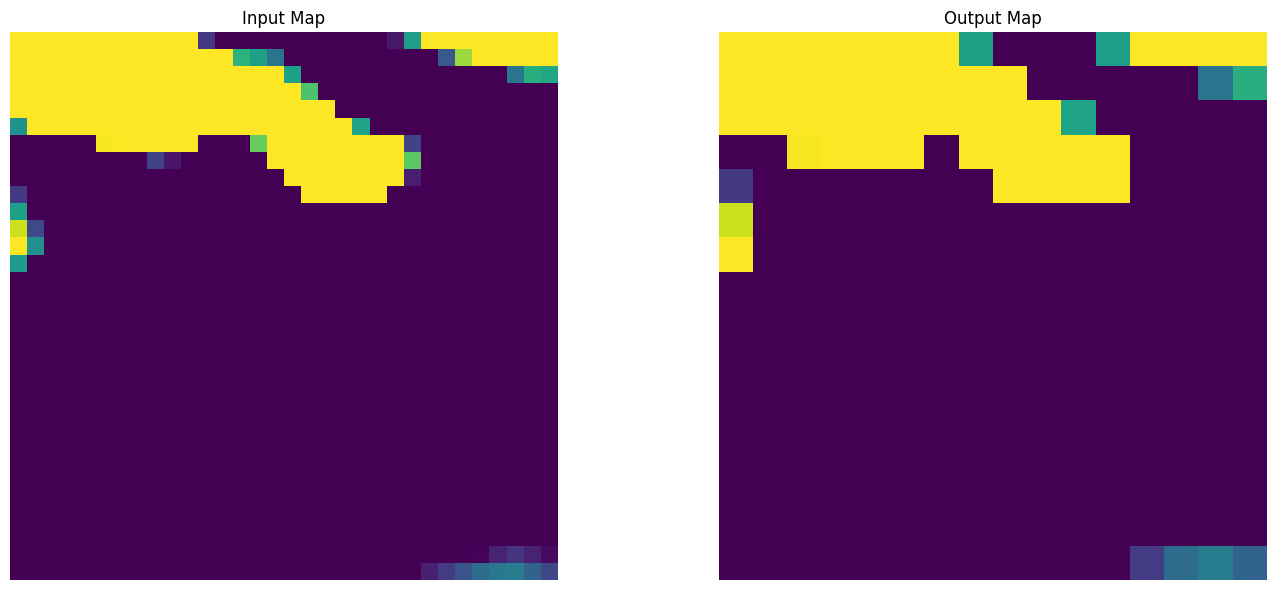

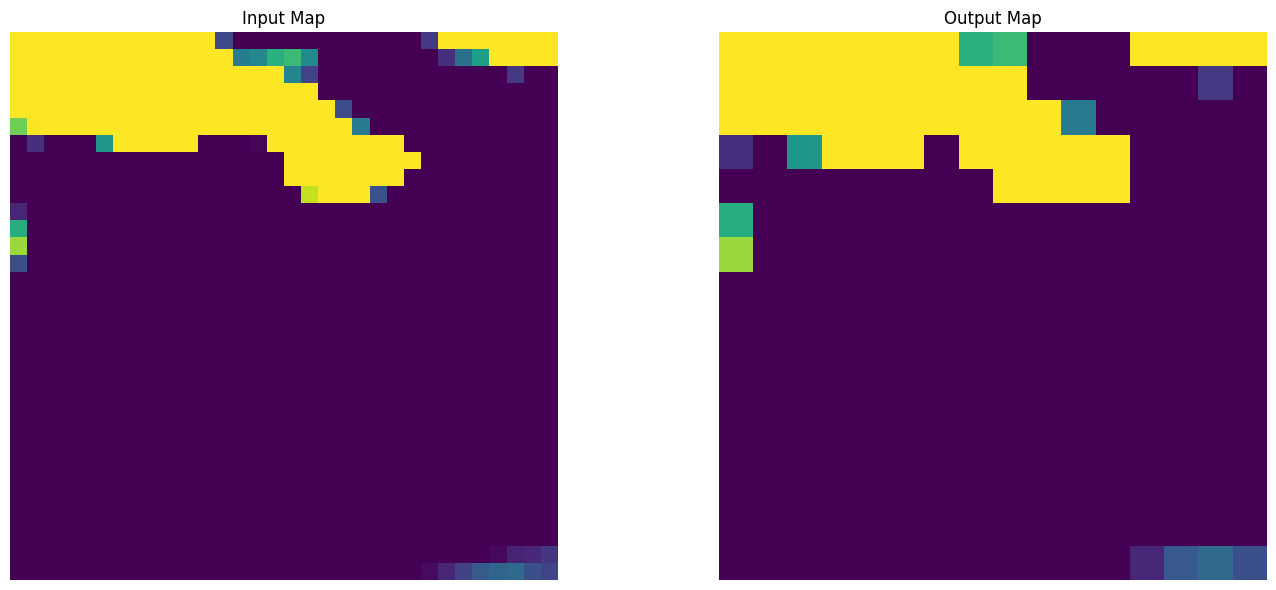

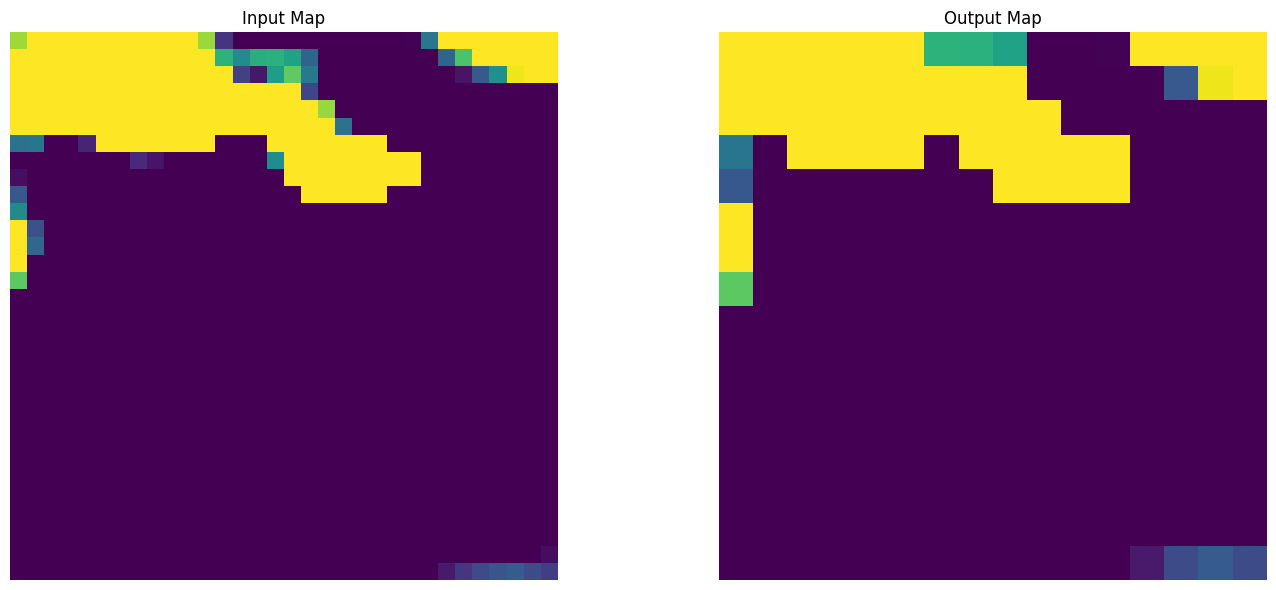

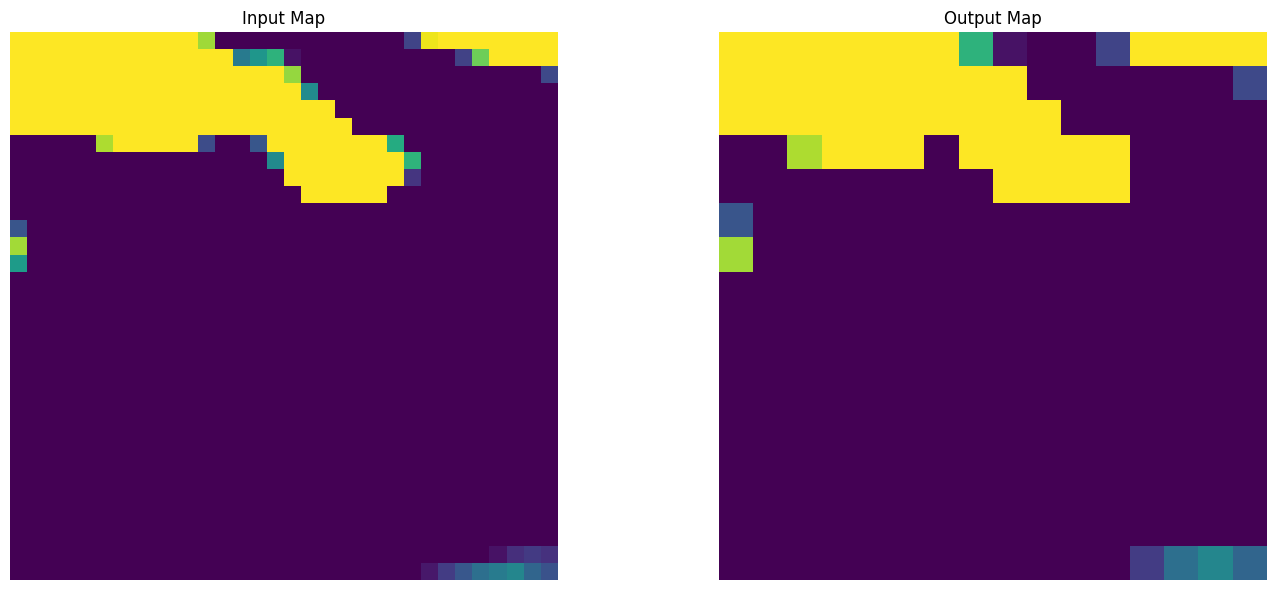

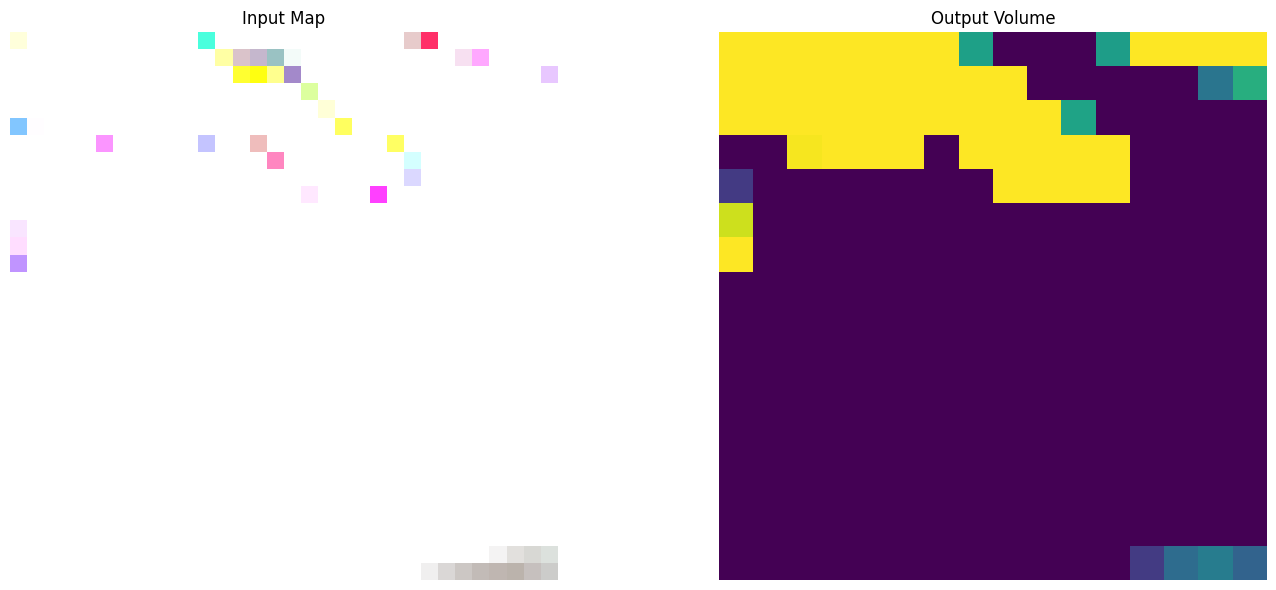

(16, 16, 4)


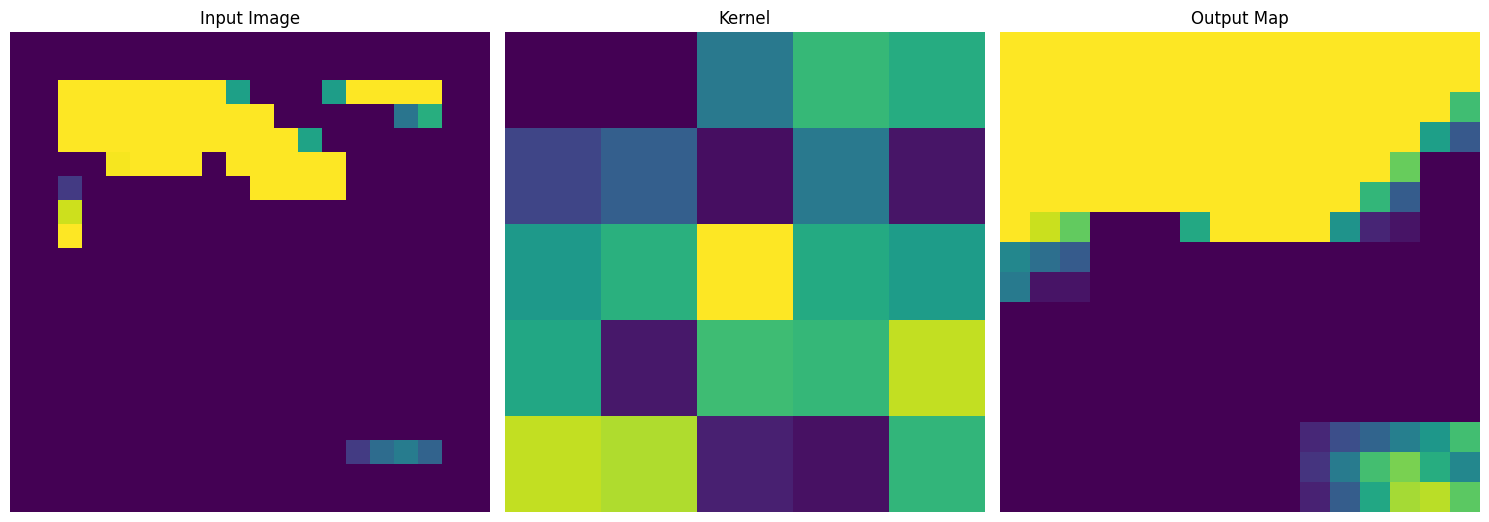

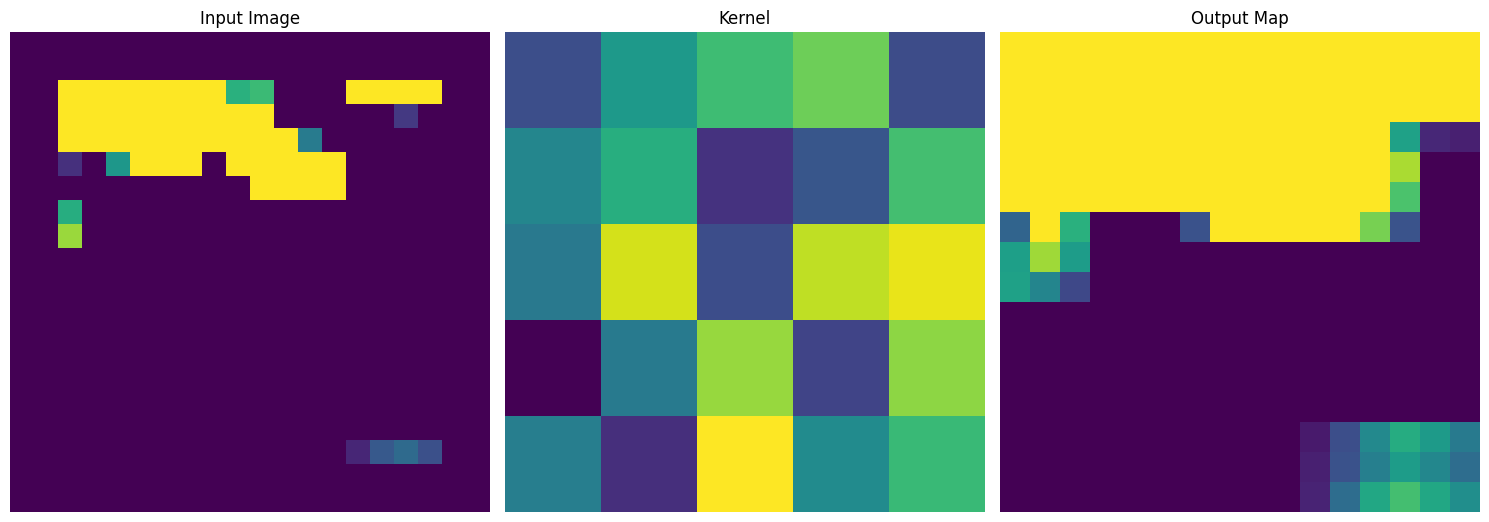

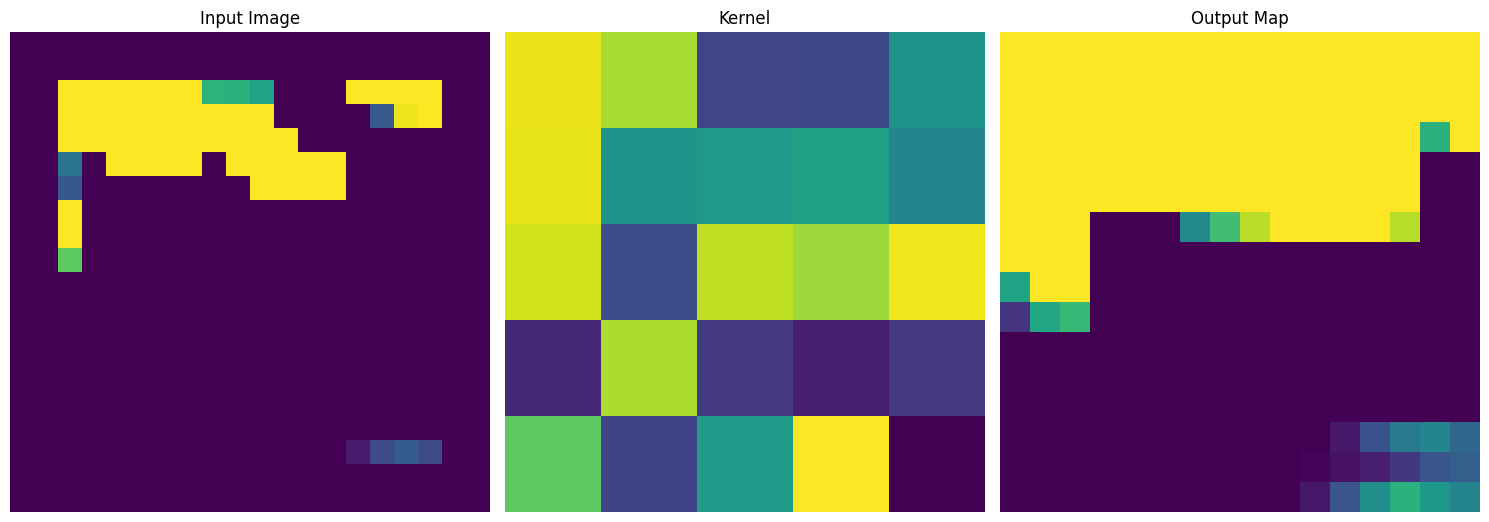

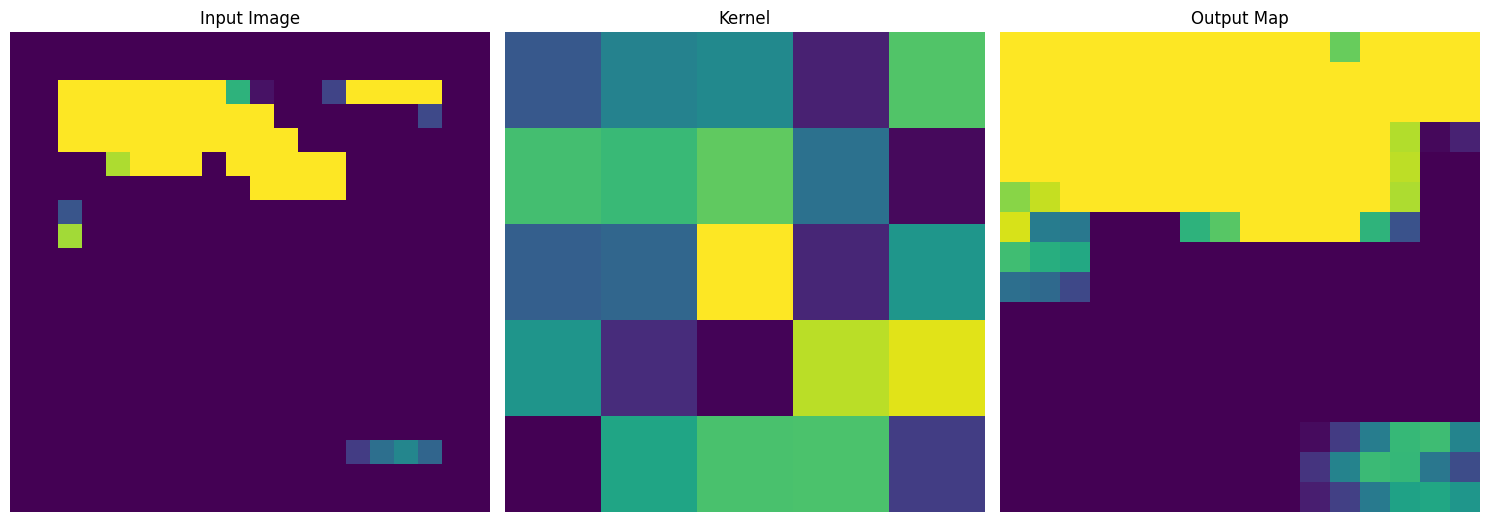

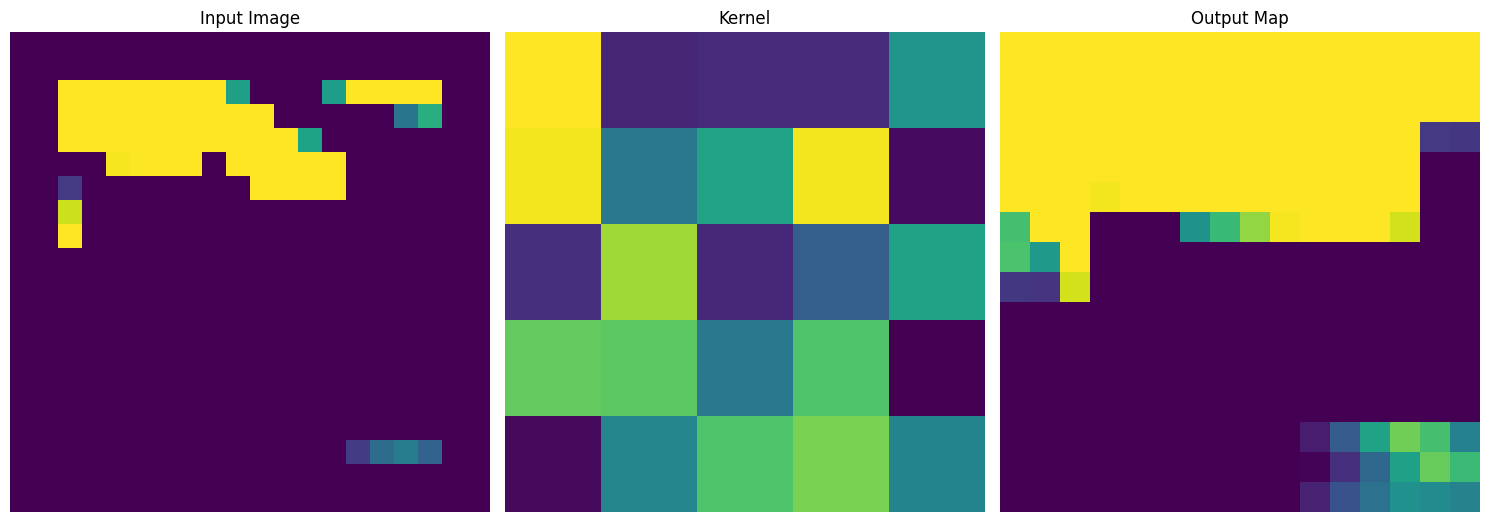

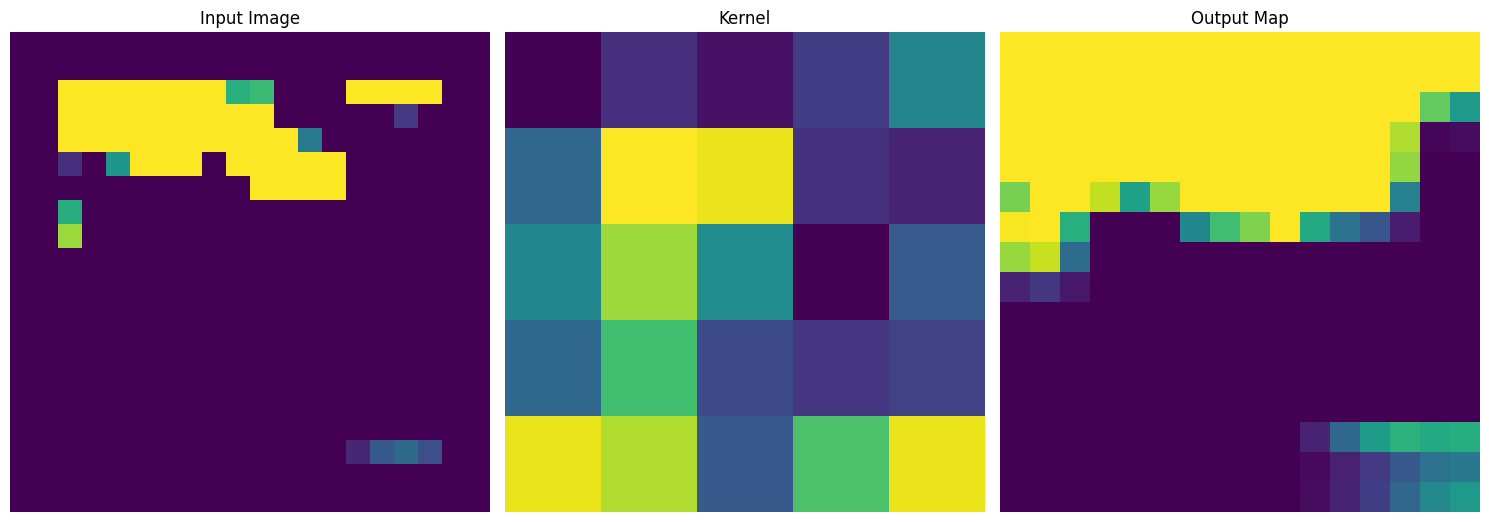

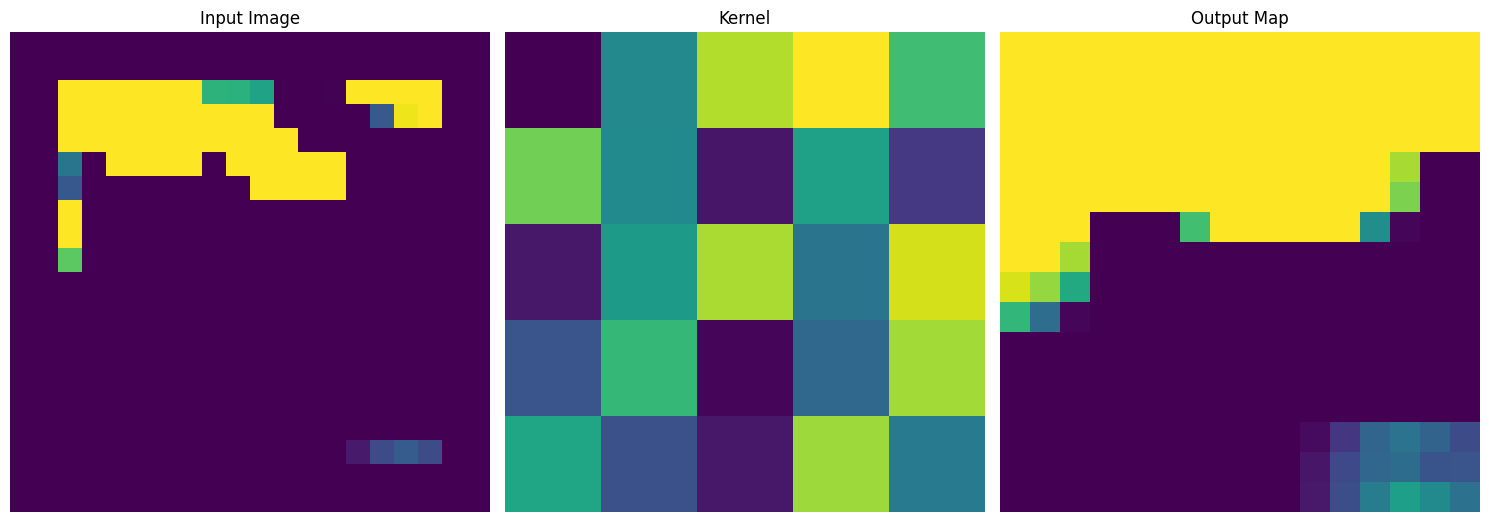

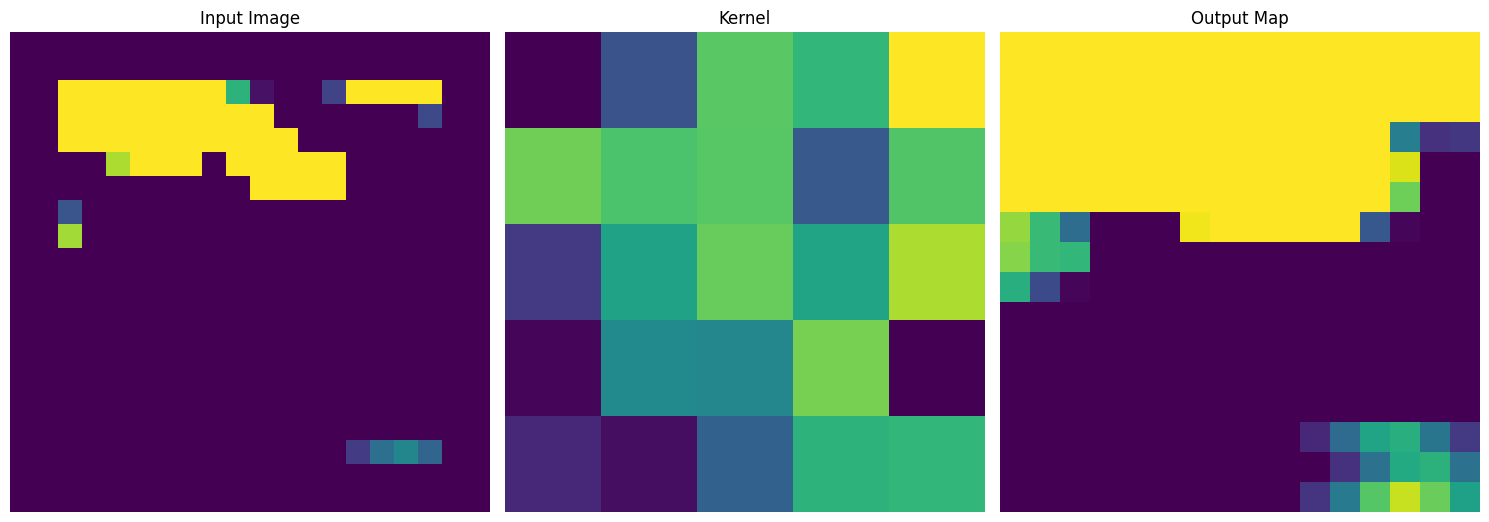

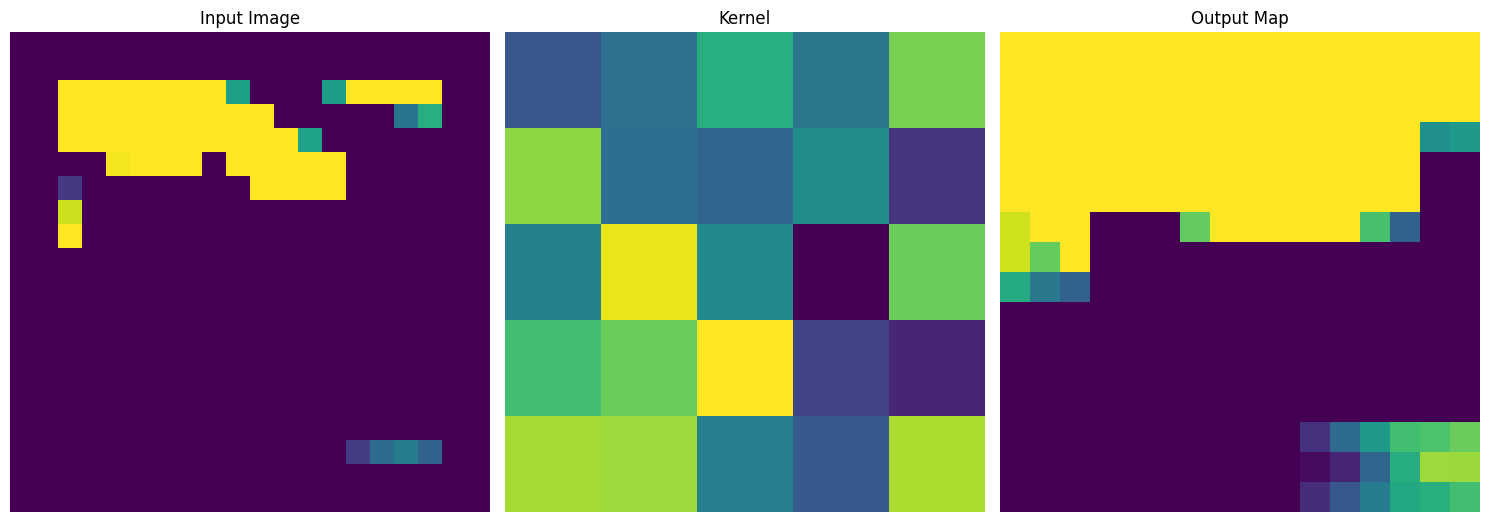

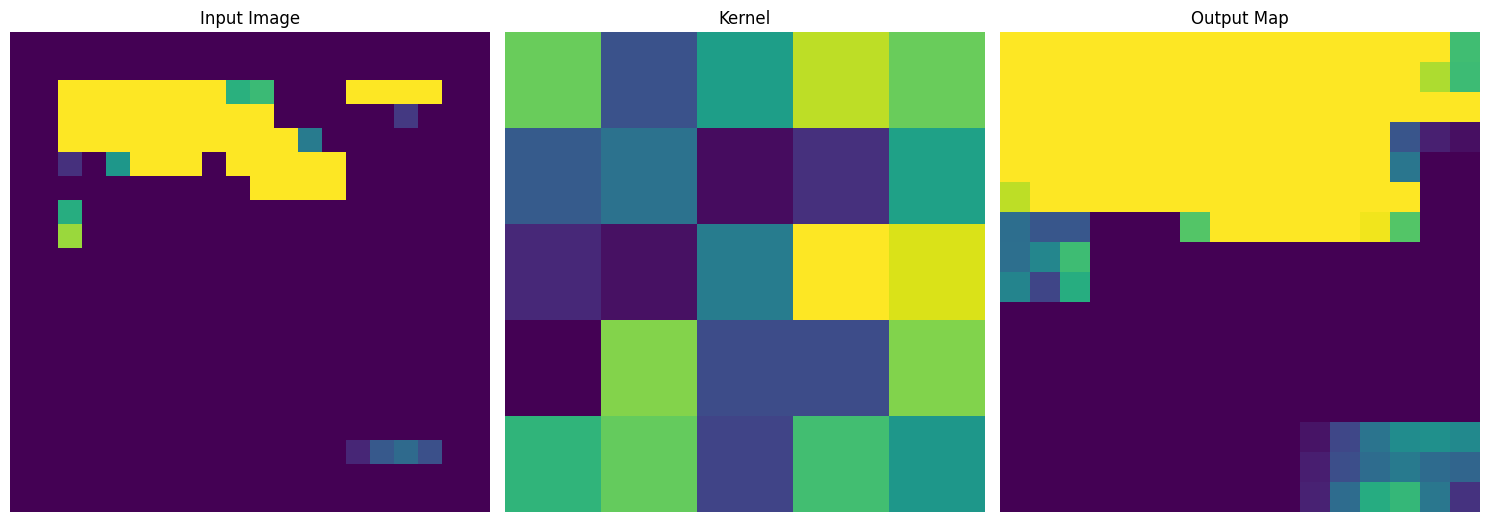

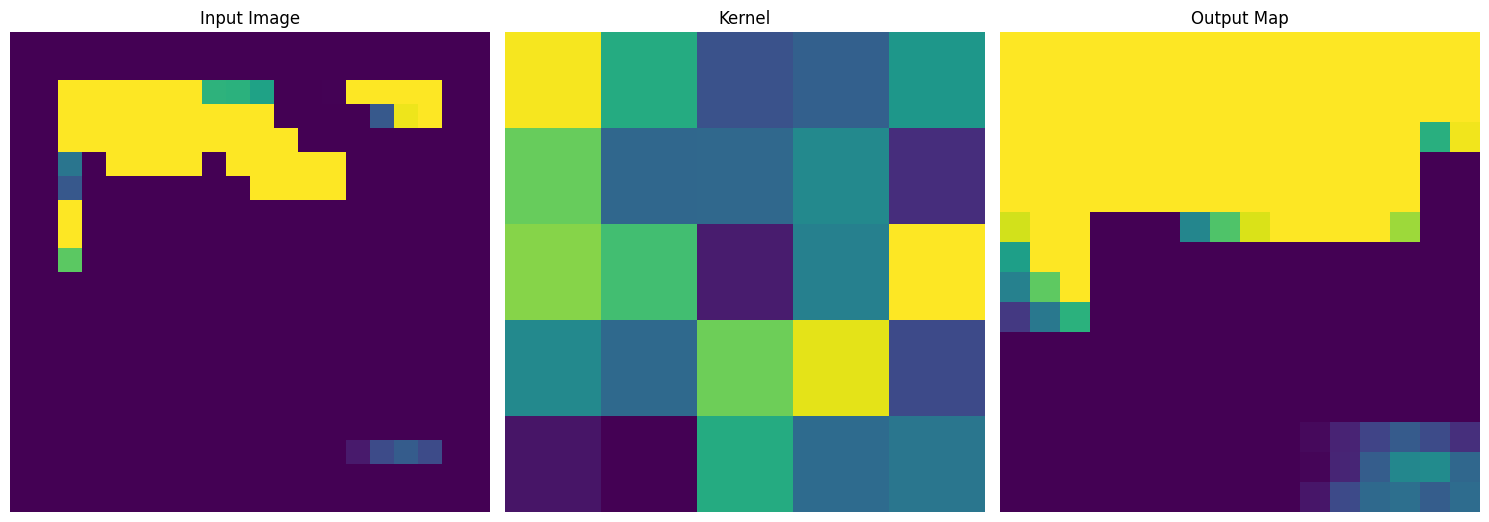

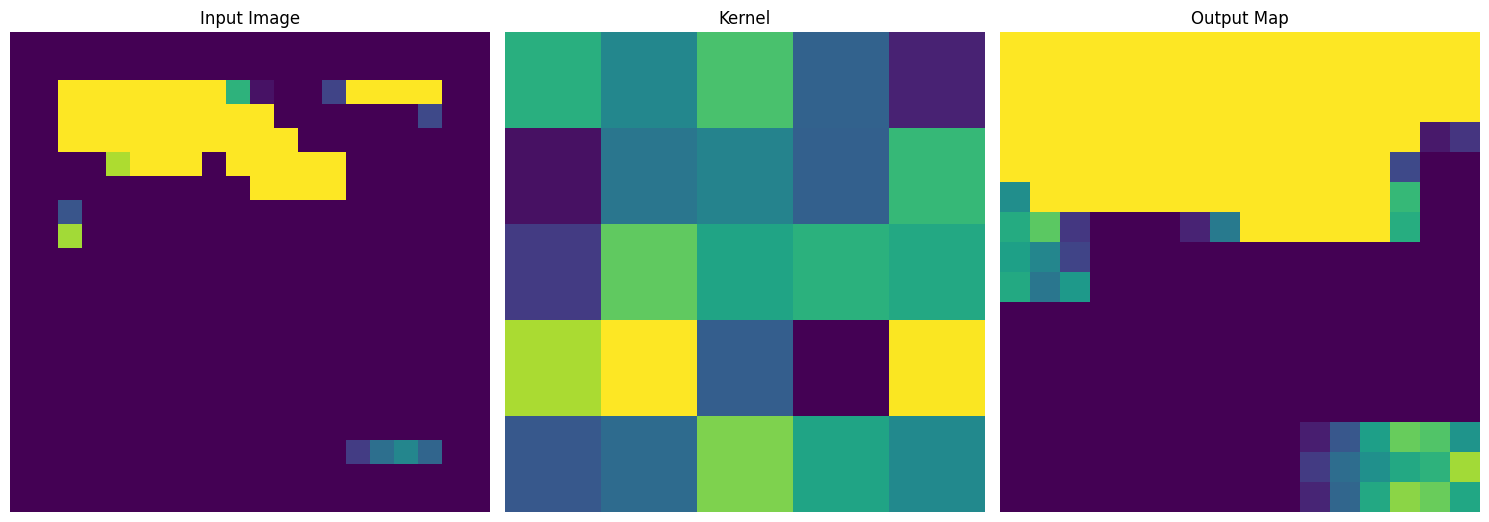

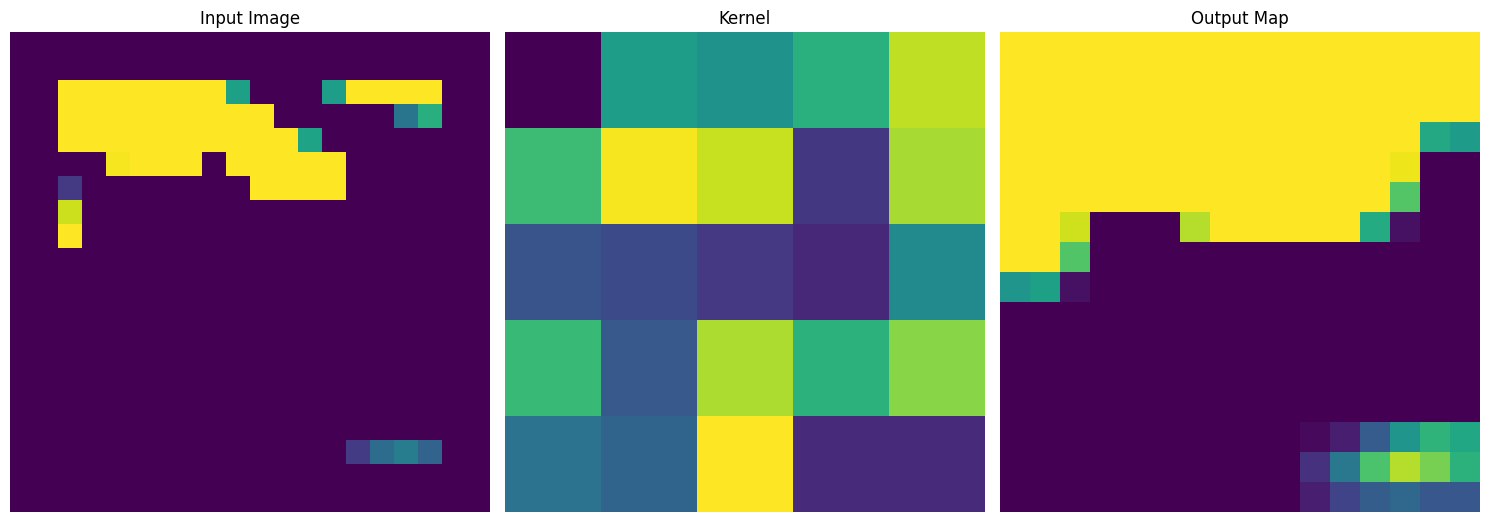

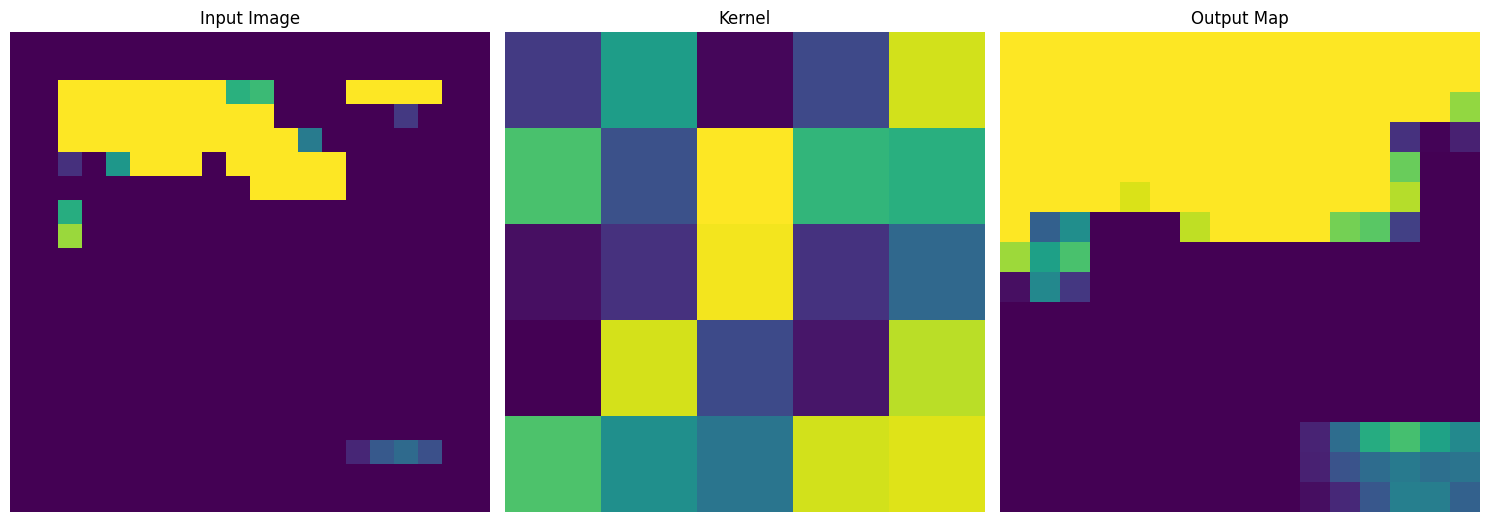

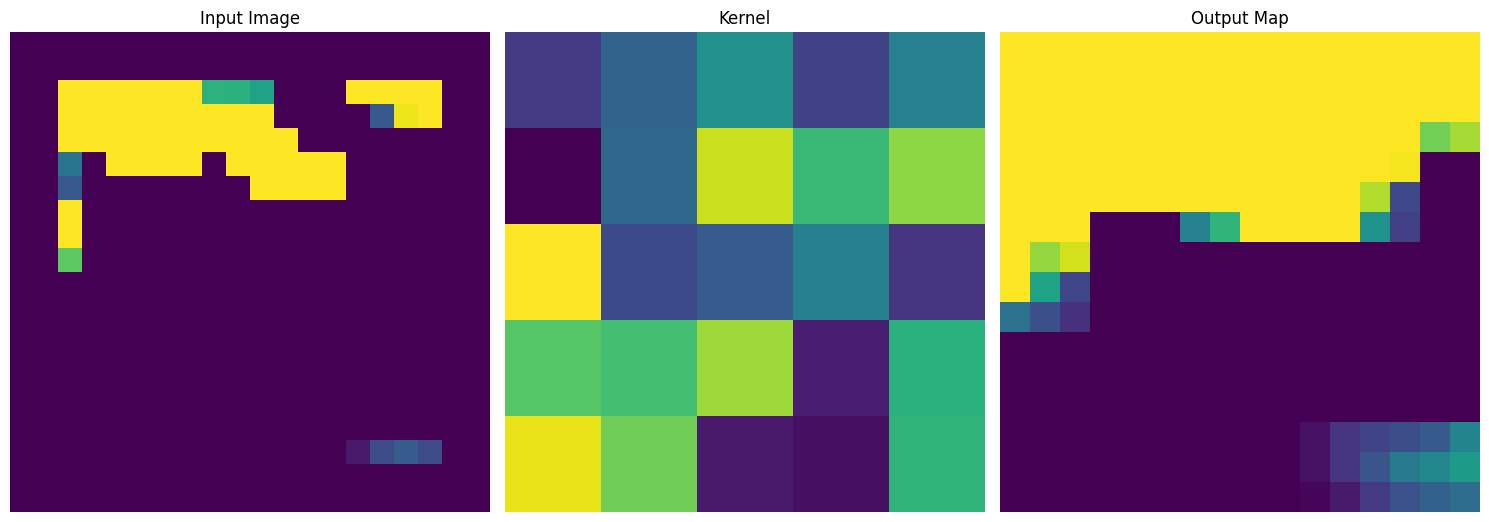

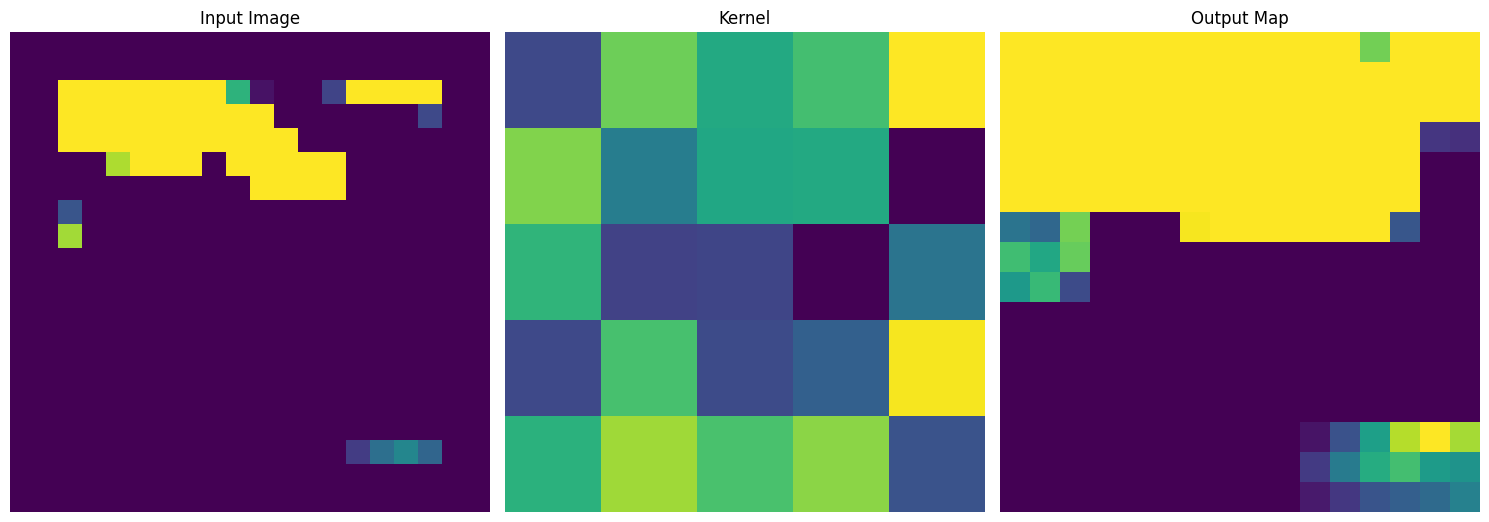

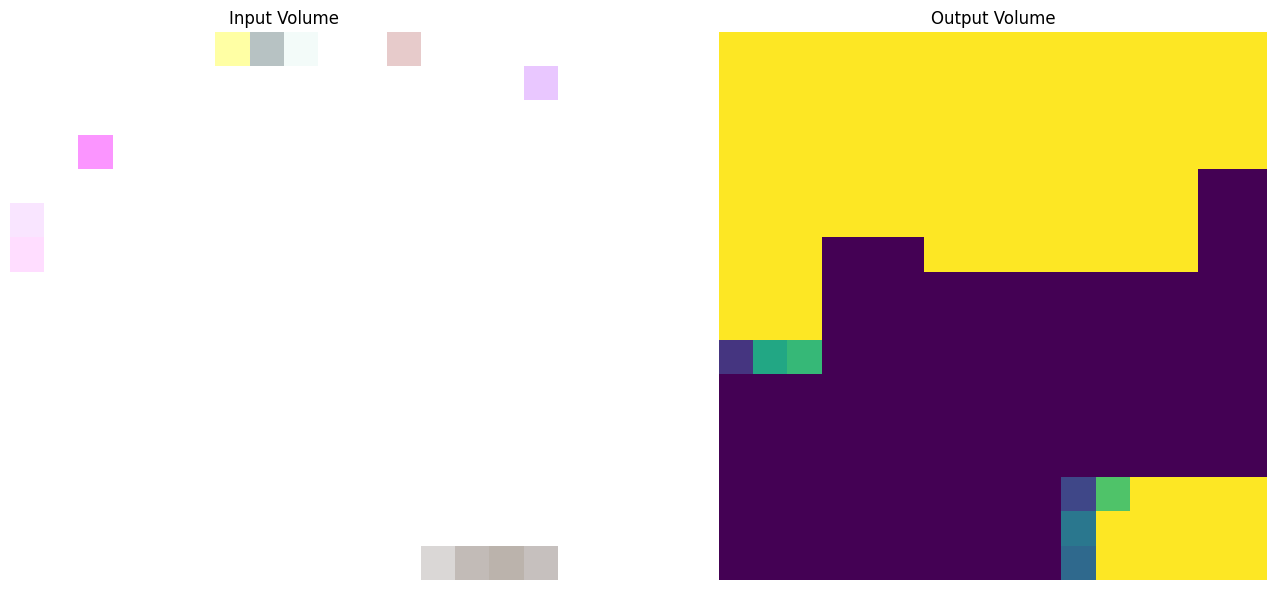

(16, 16, 4)


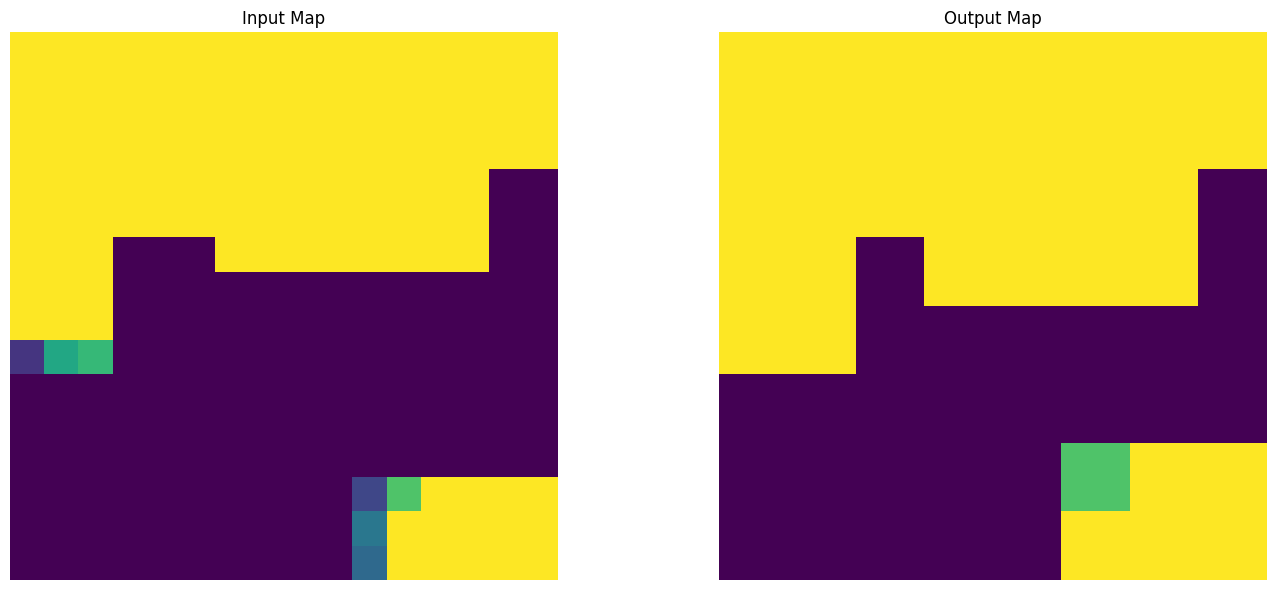

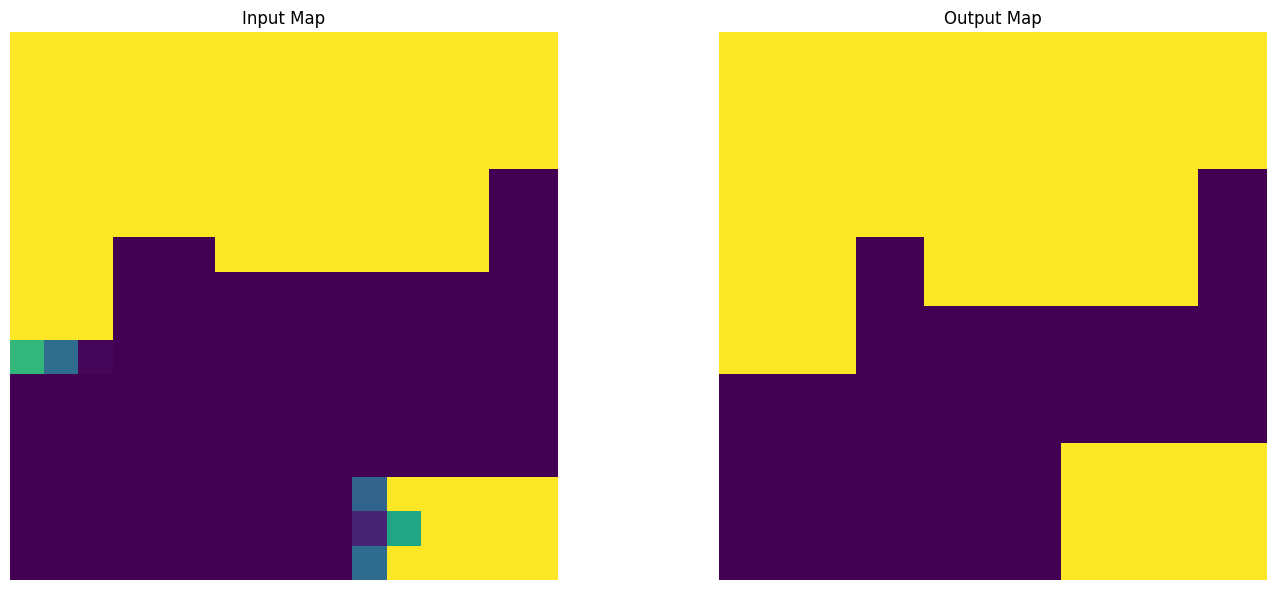

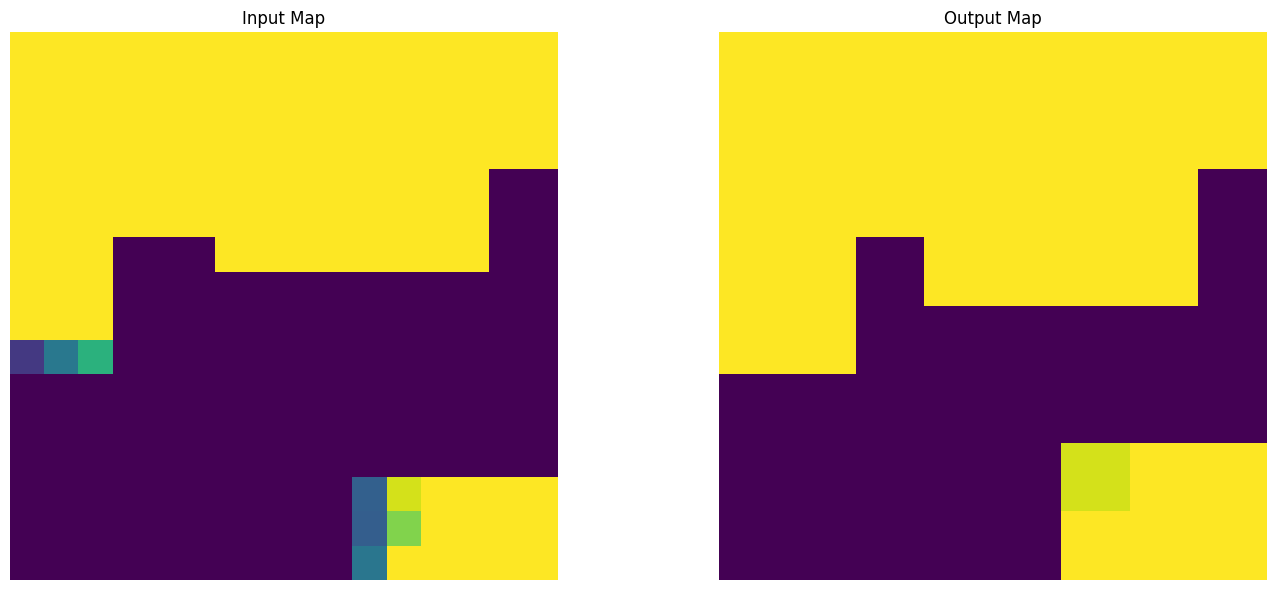

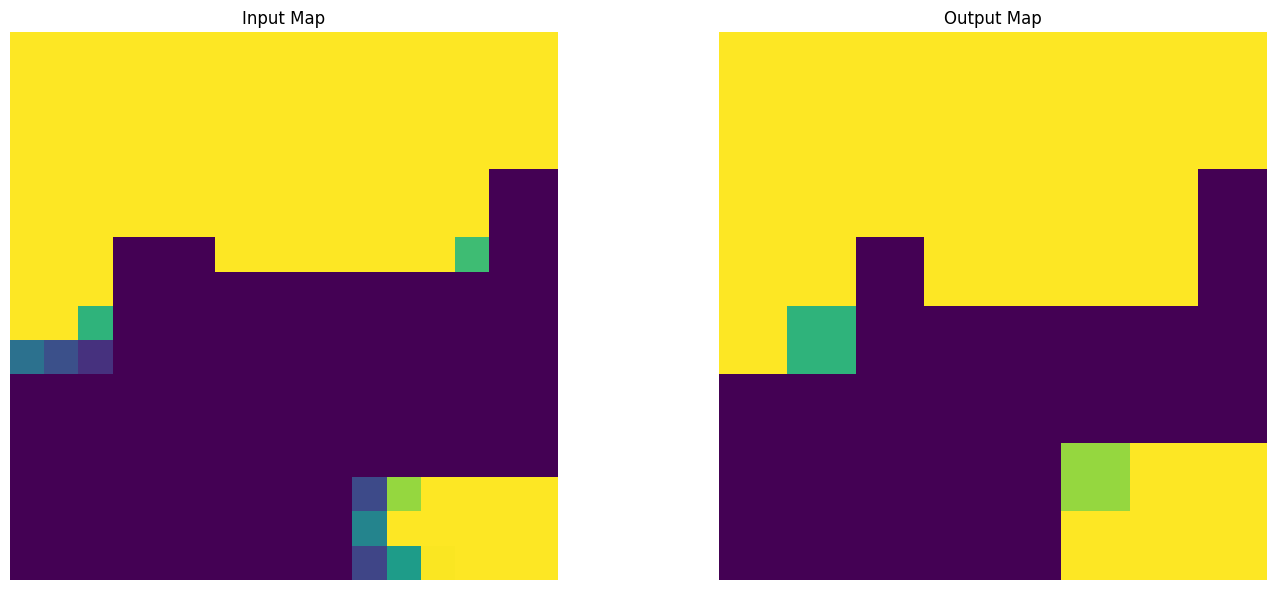

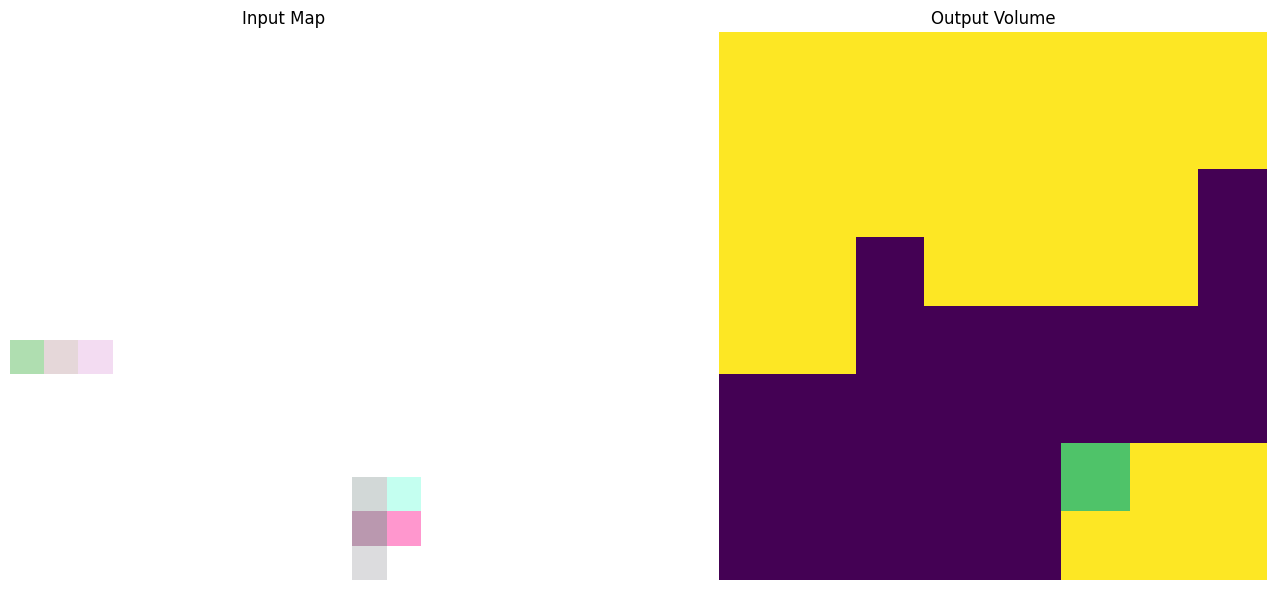

(8, 8, 4)


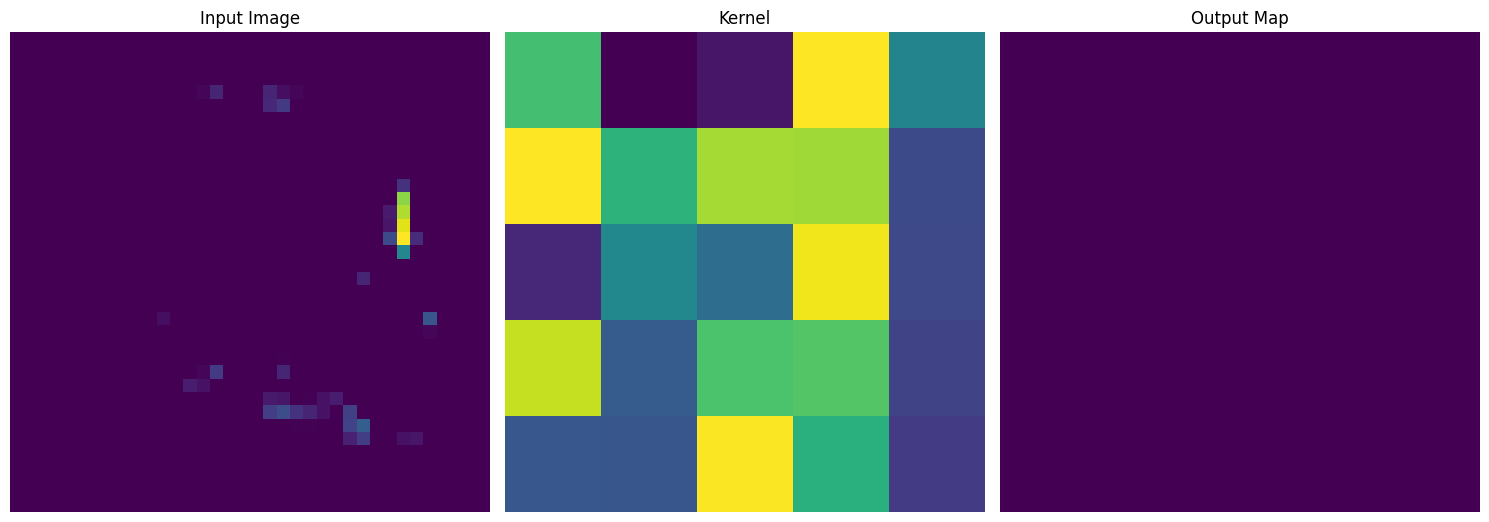

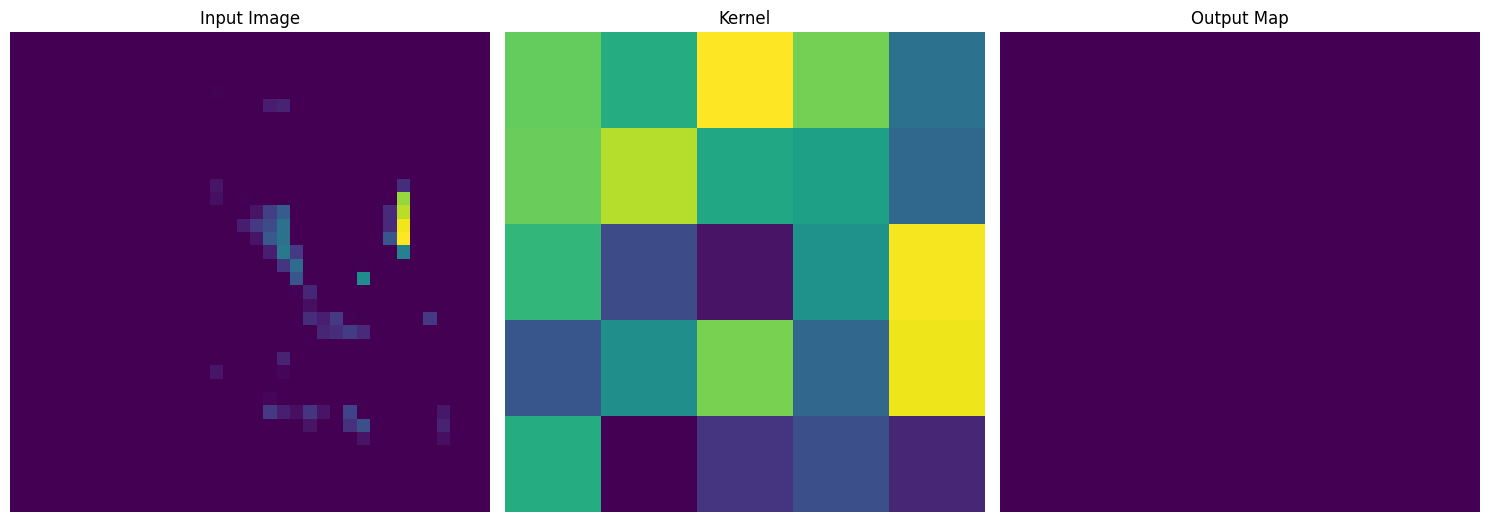

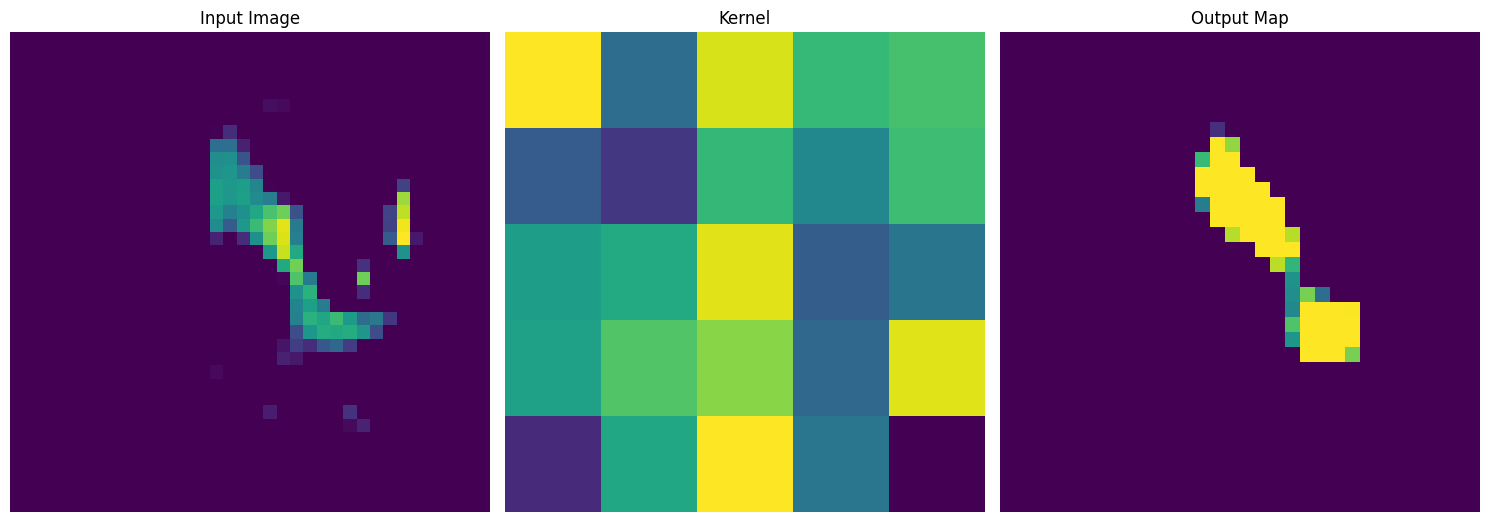

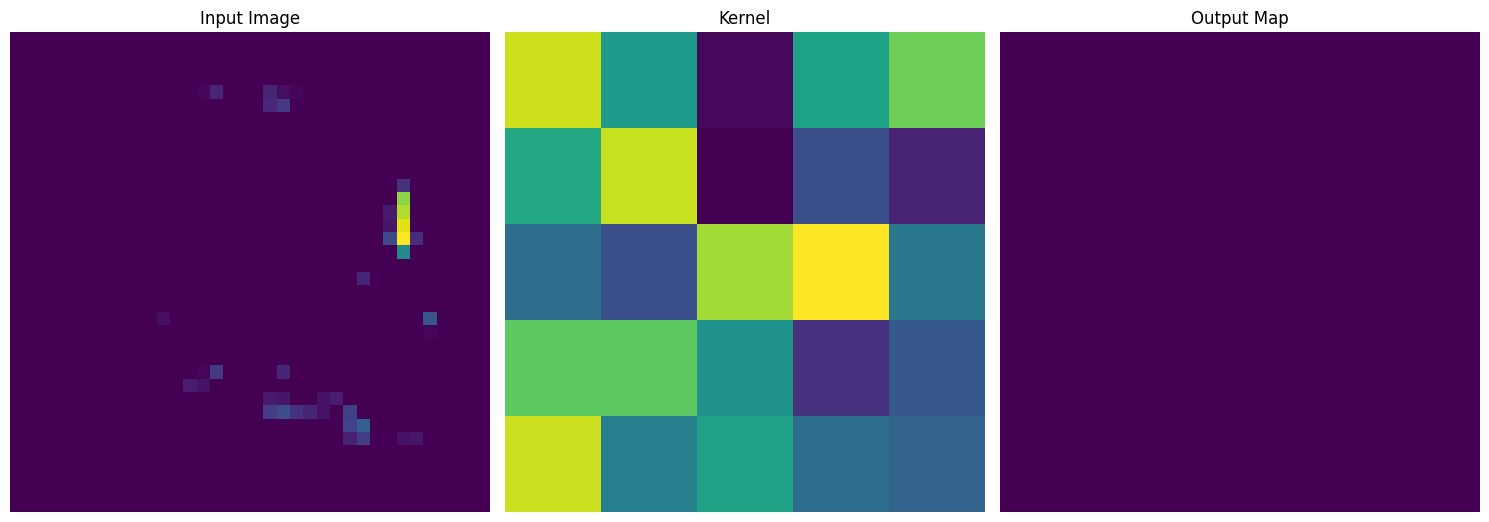

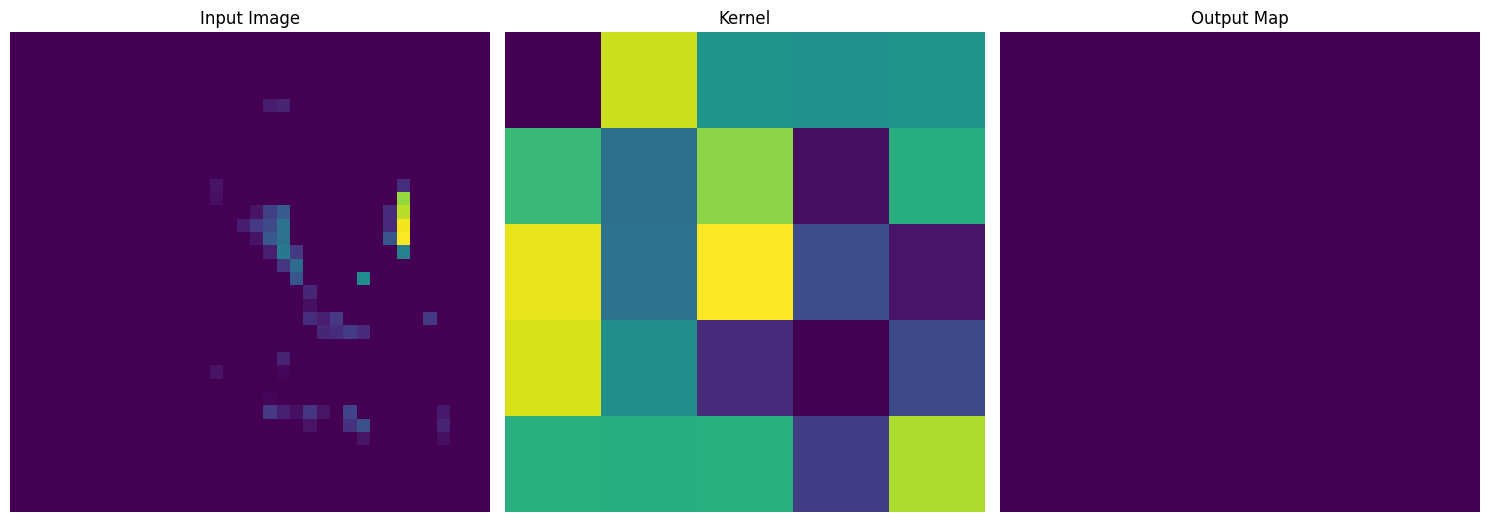

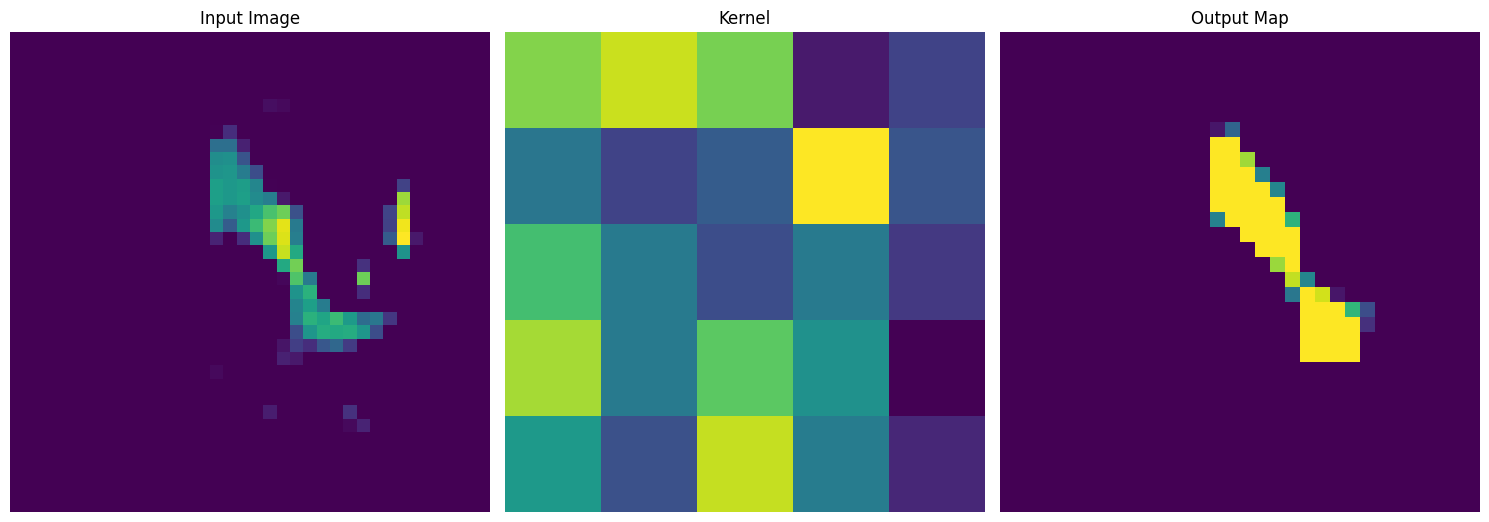

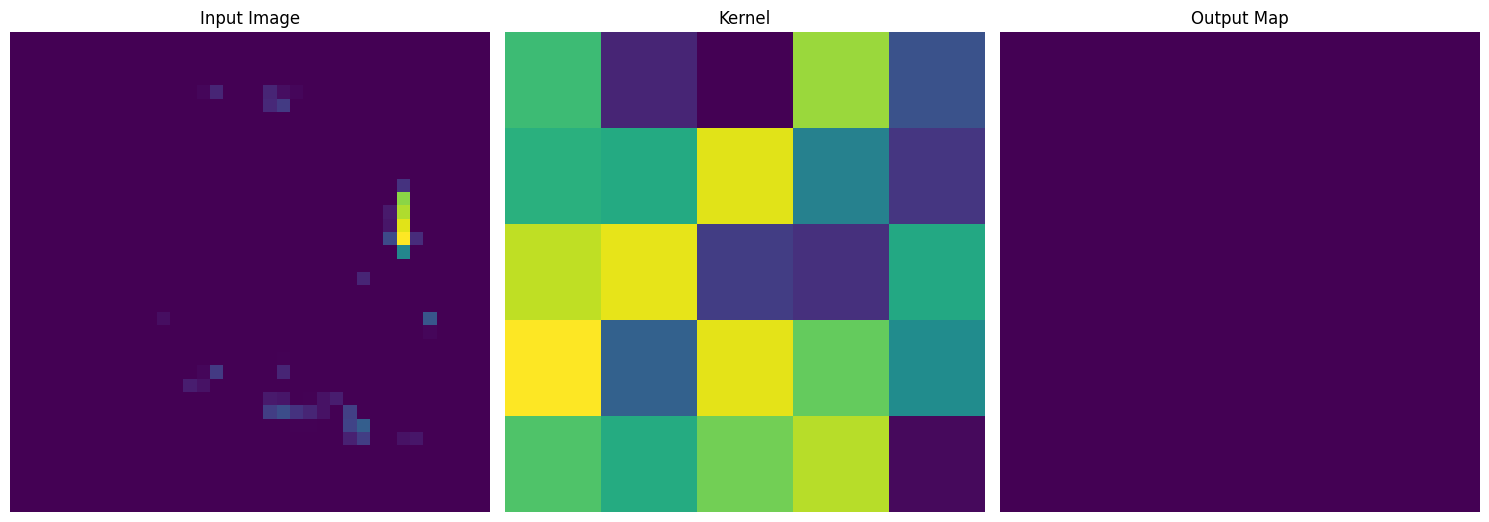

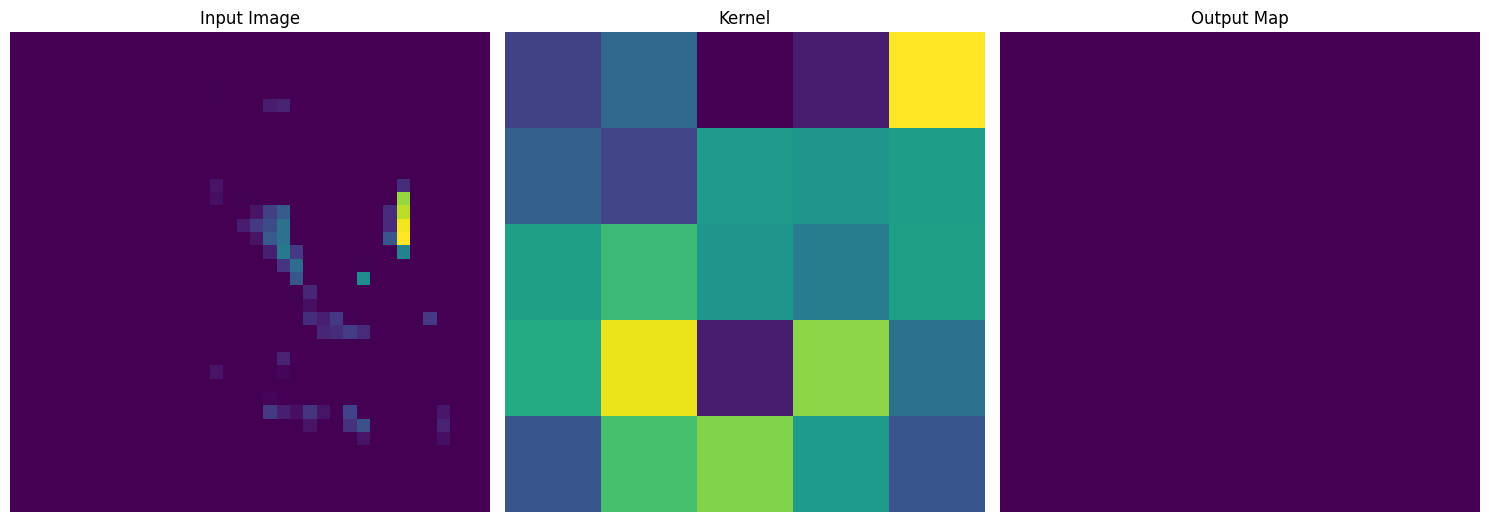

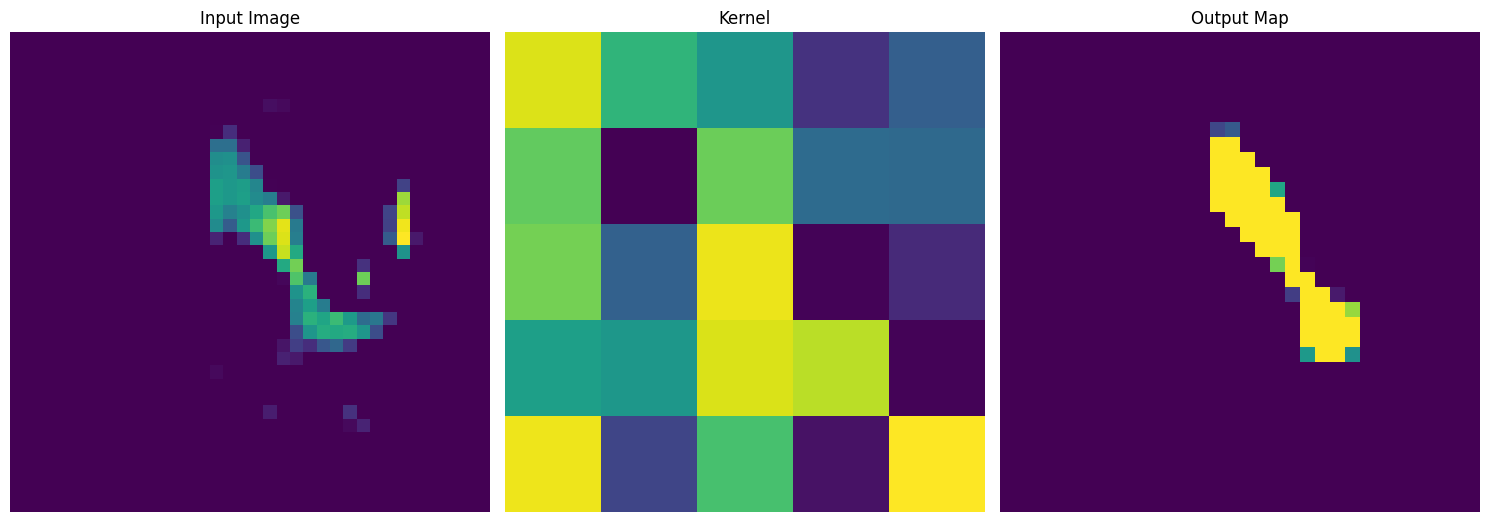

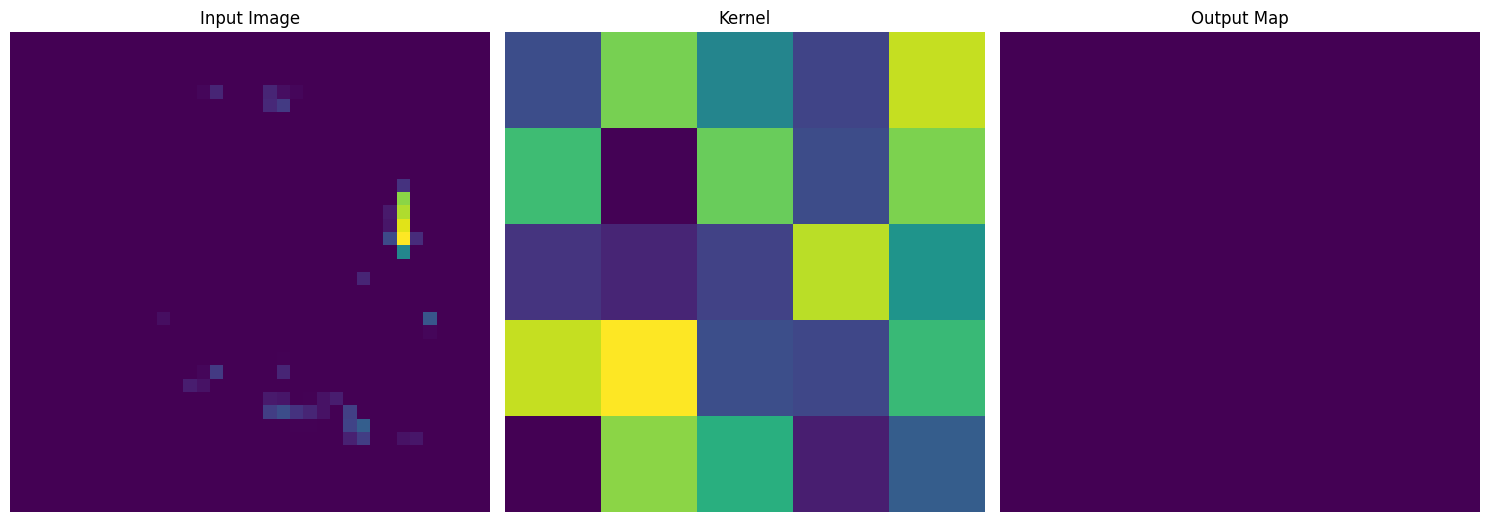

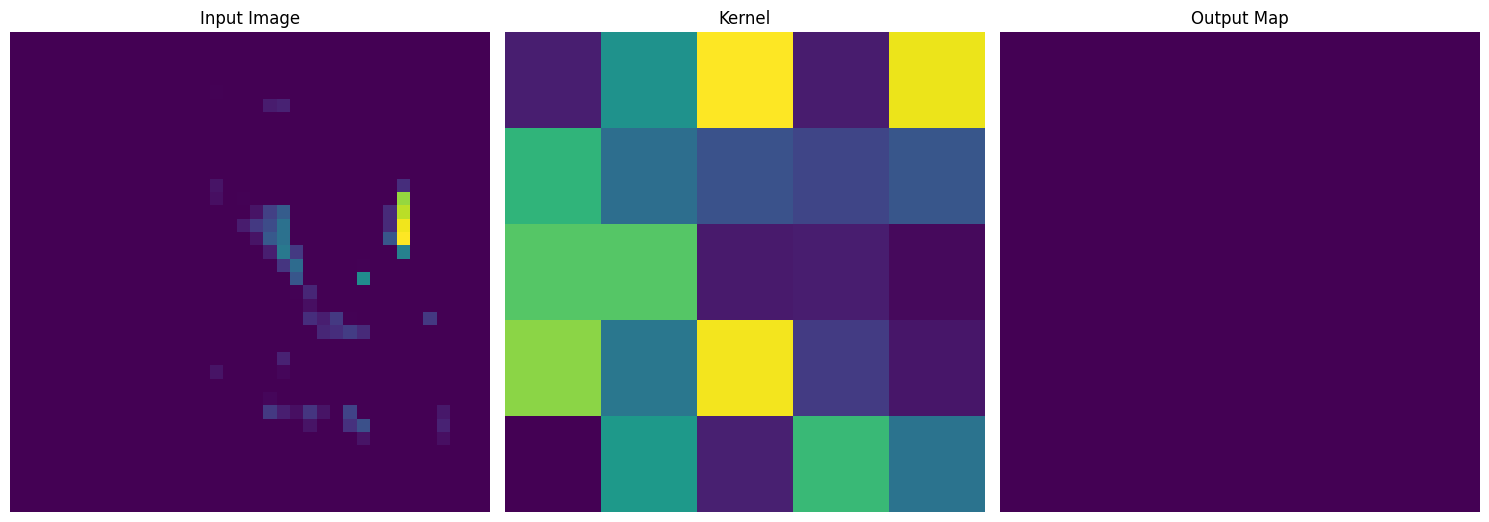

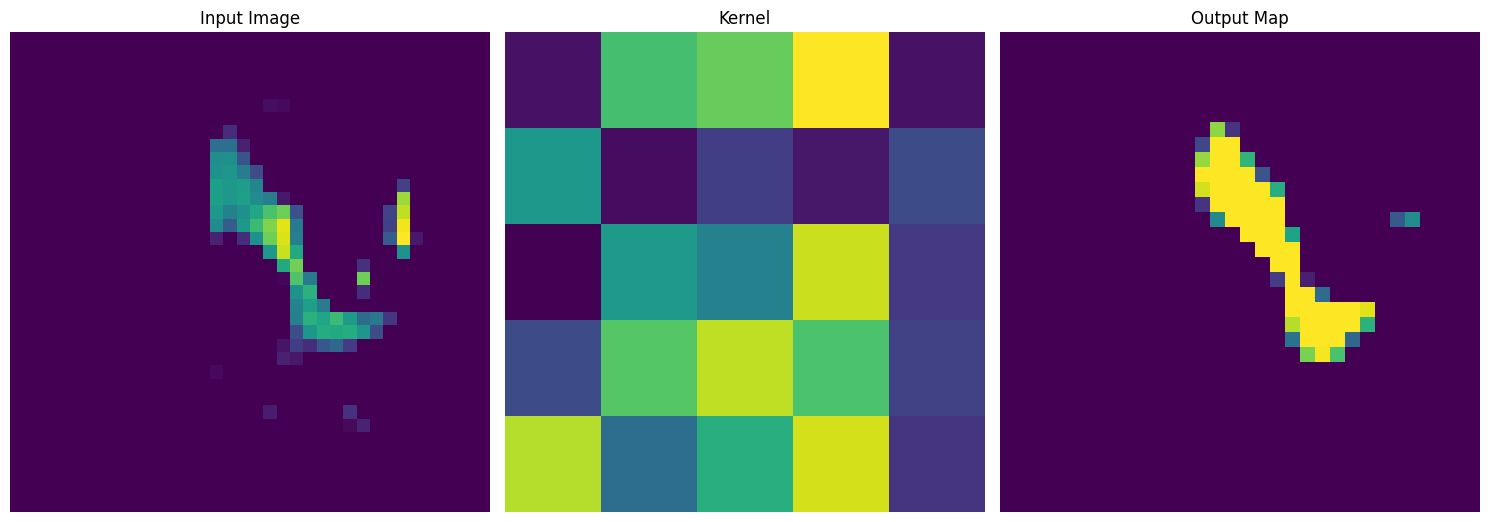

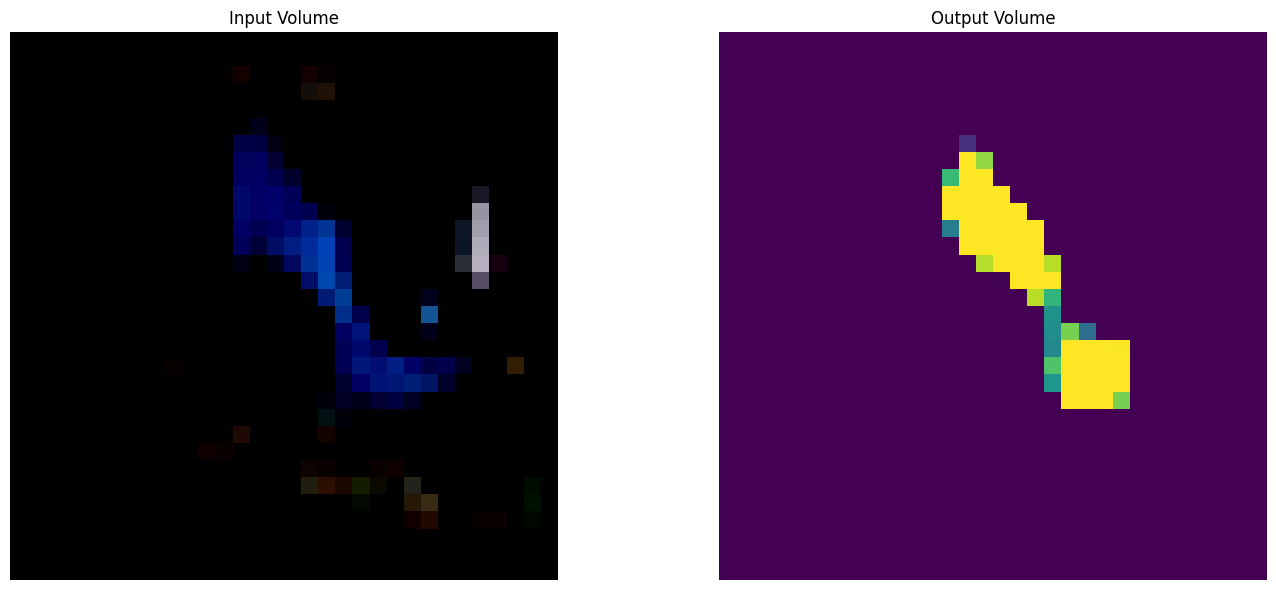

(32, 32, 4)


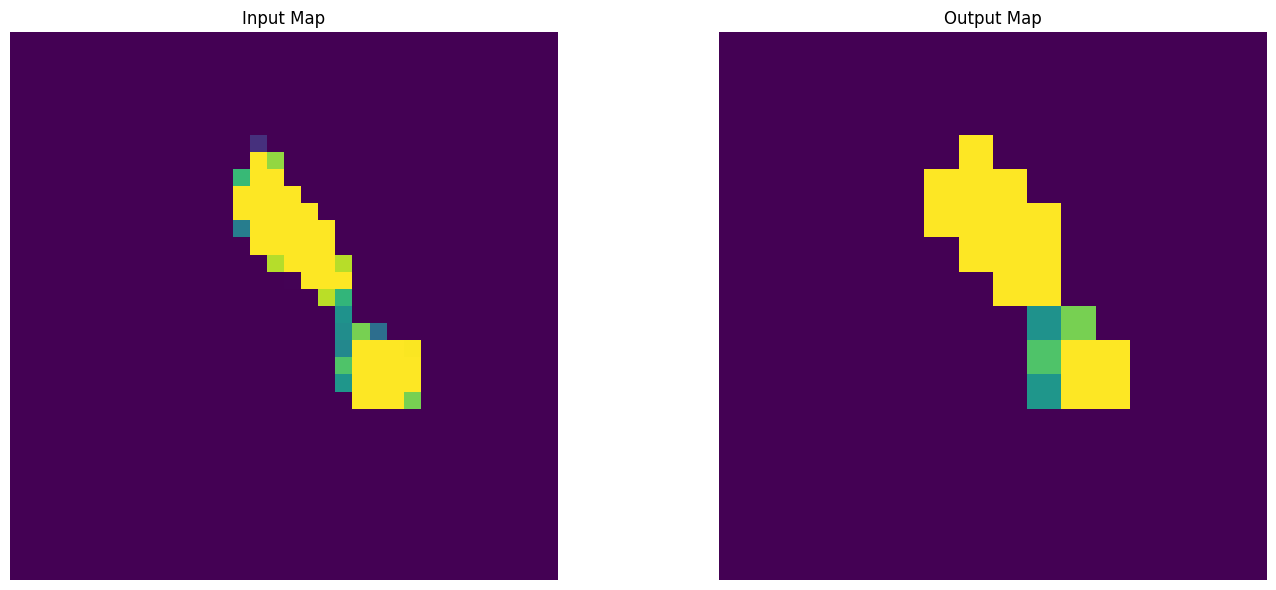

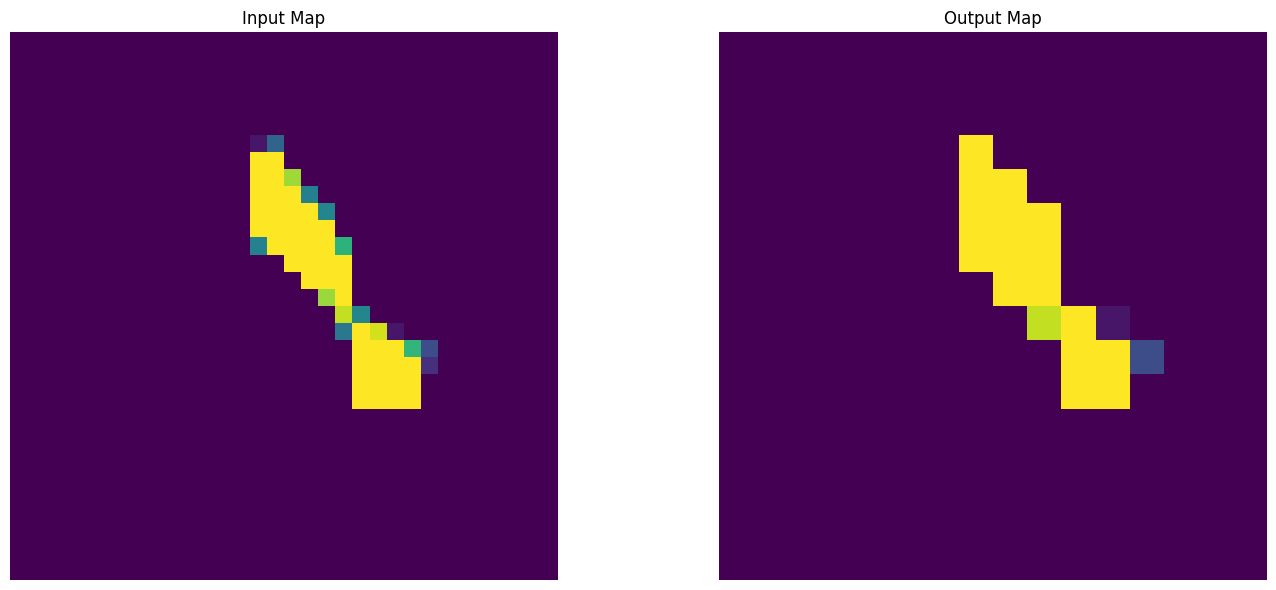

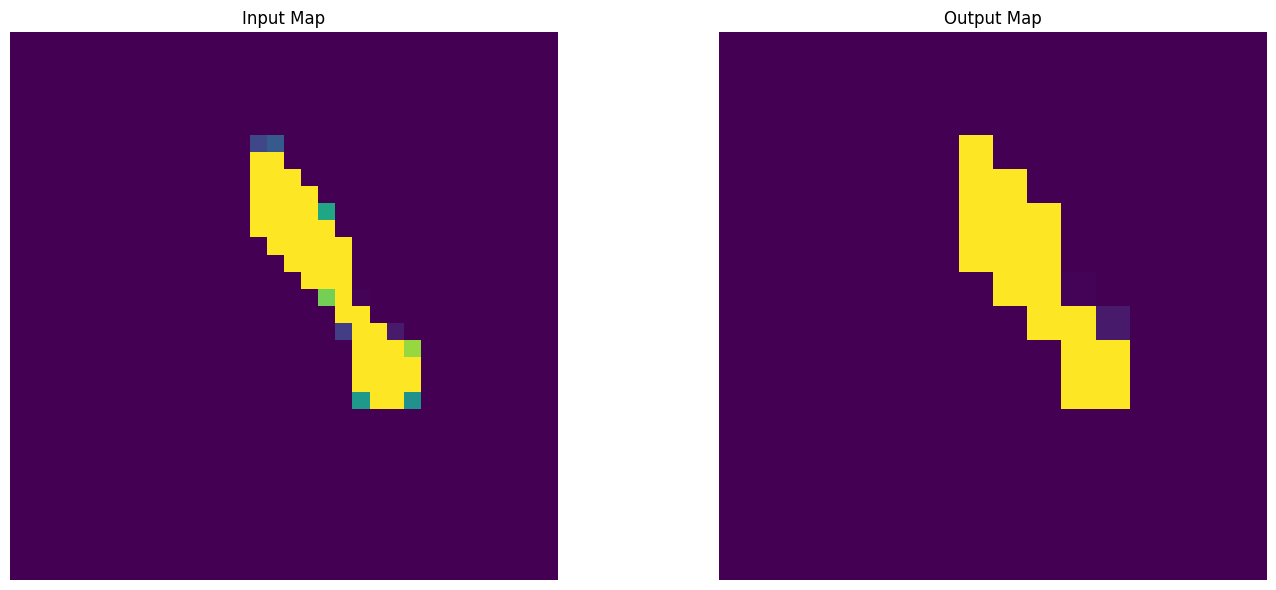

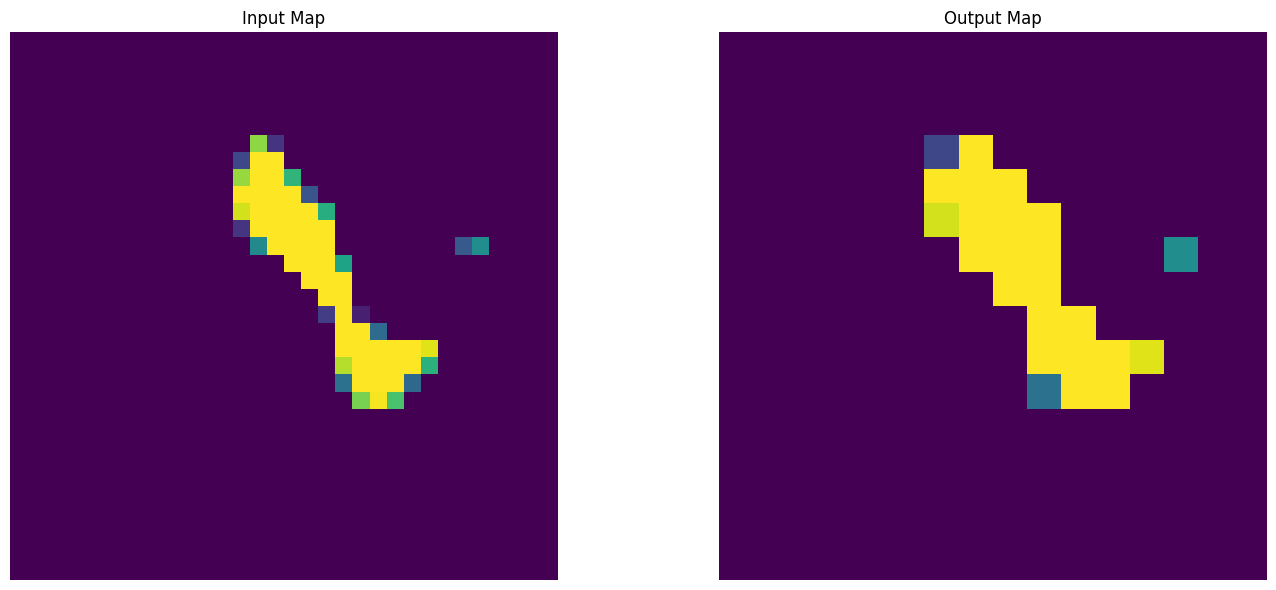

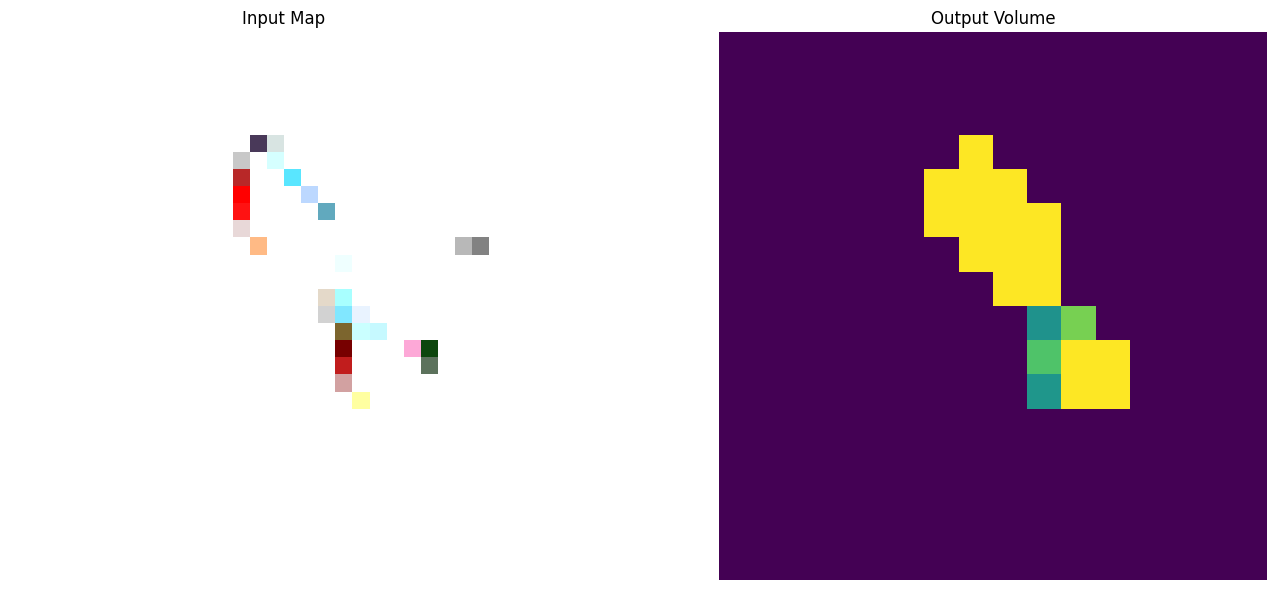

(16, 16, 4)


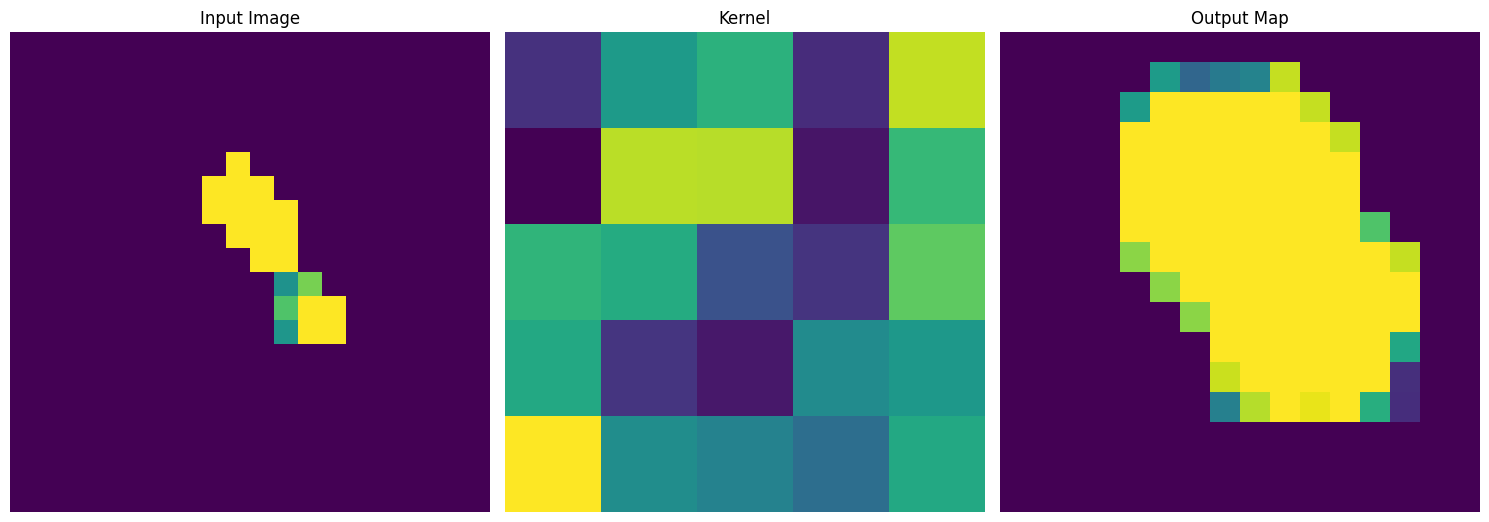

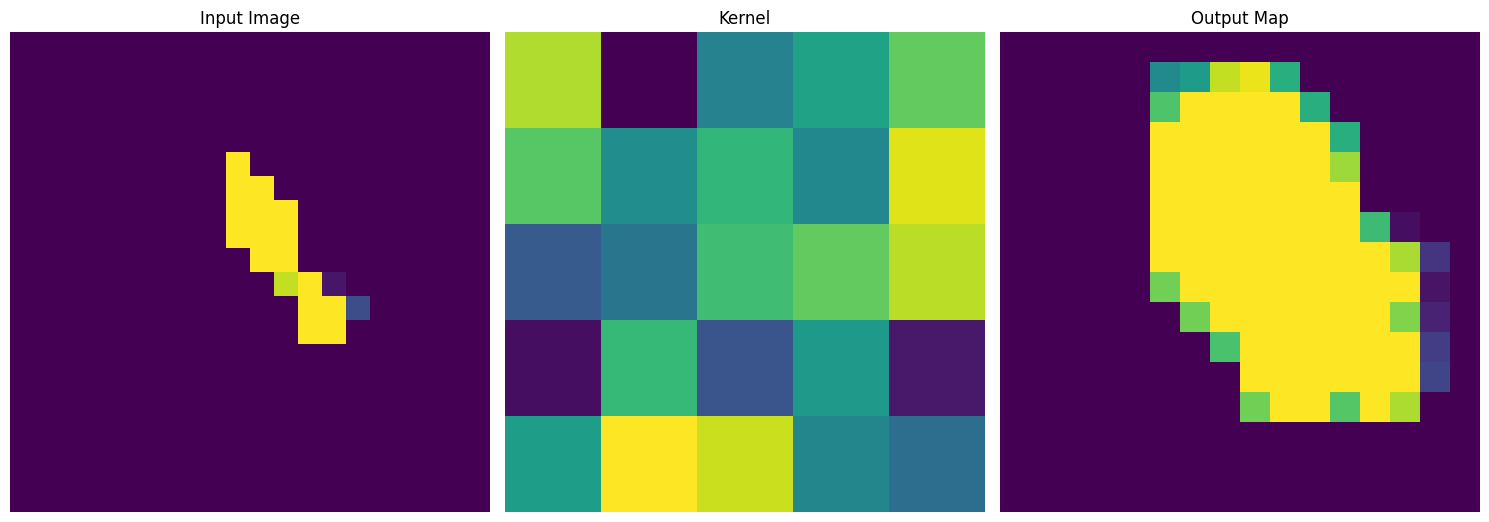

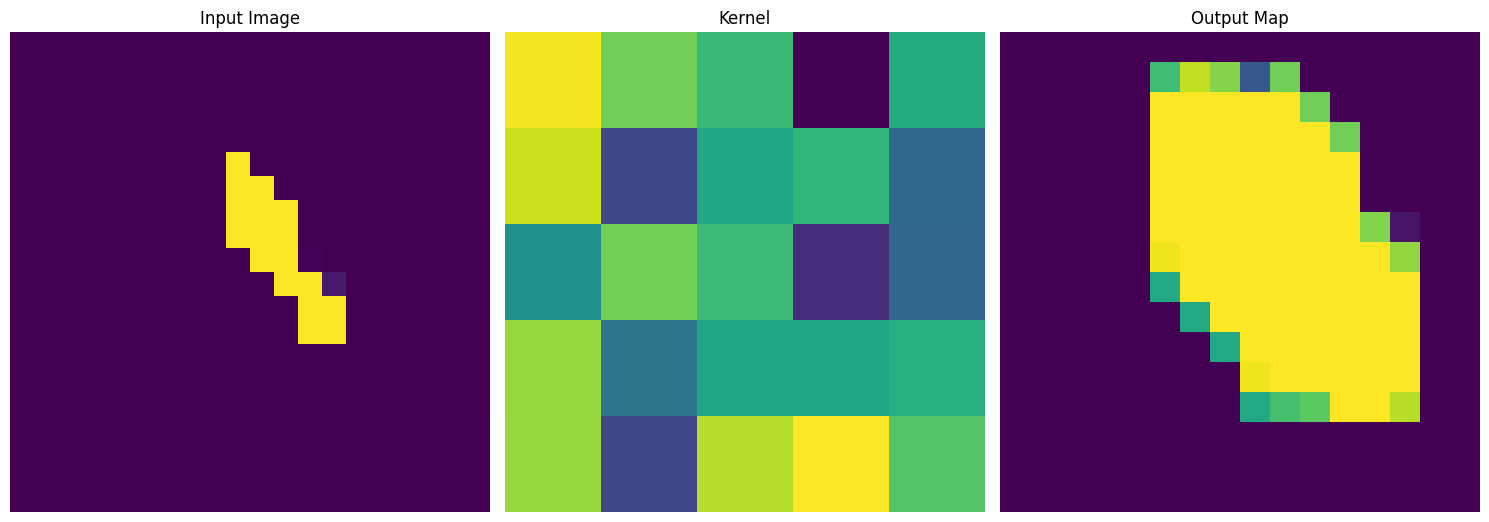

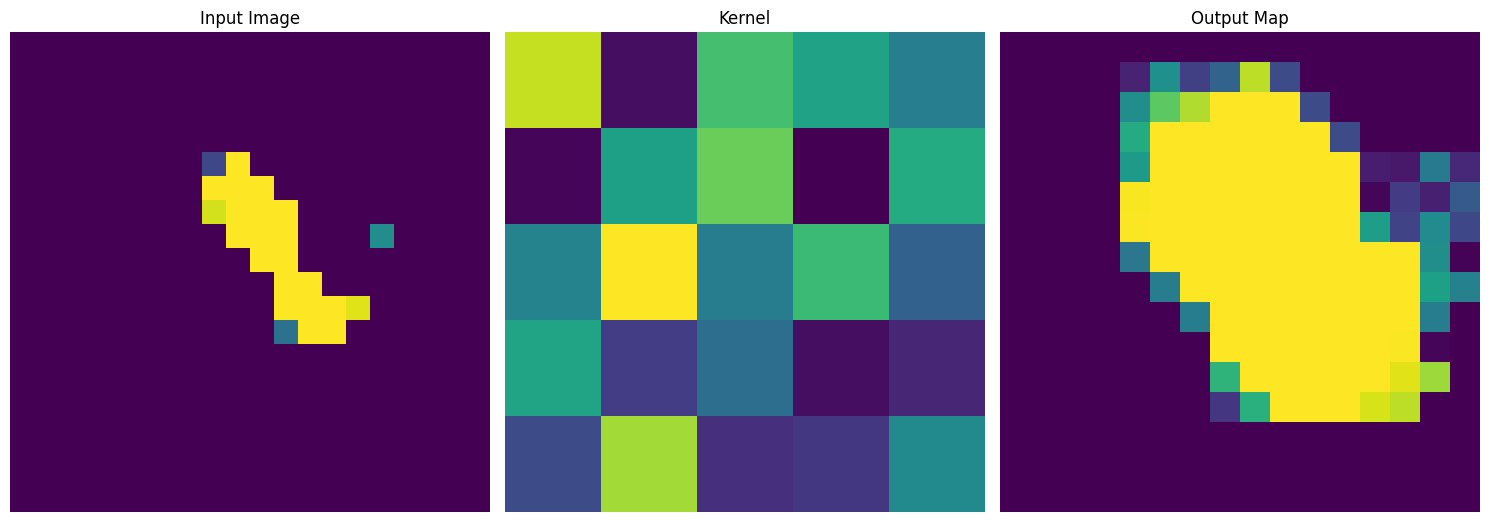

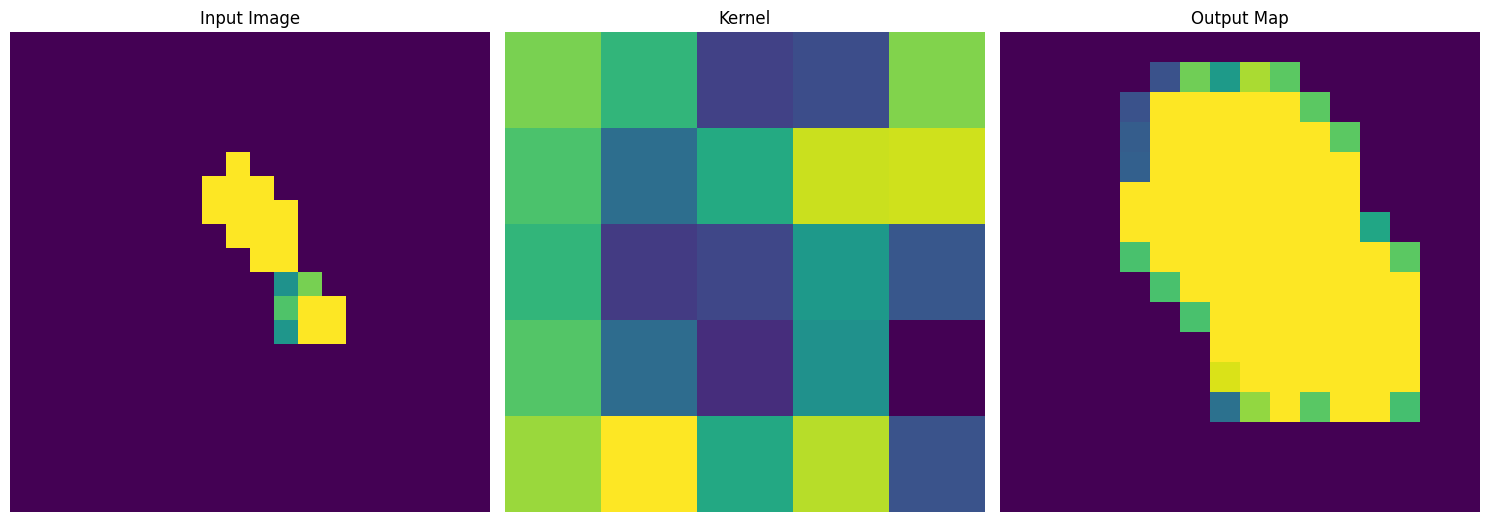

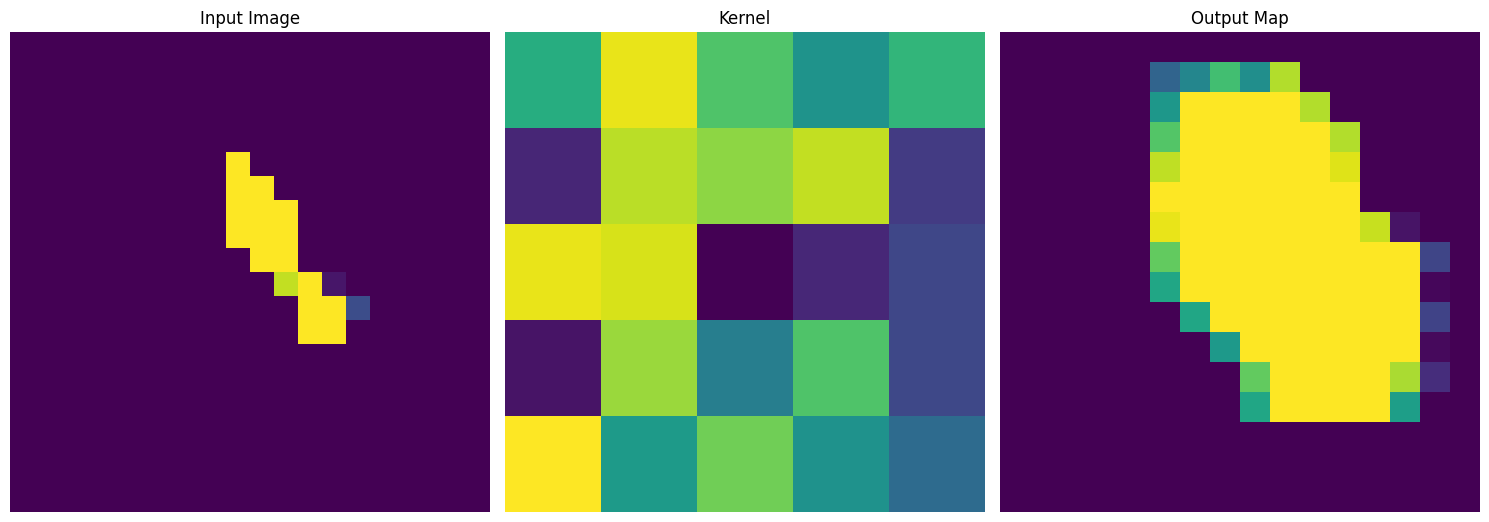

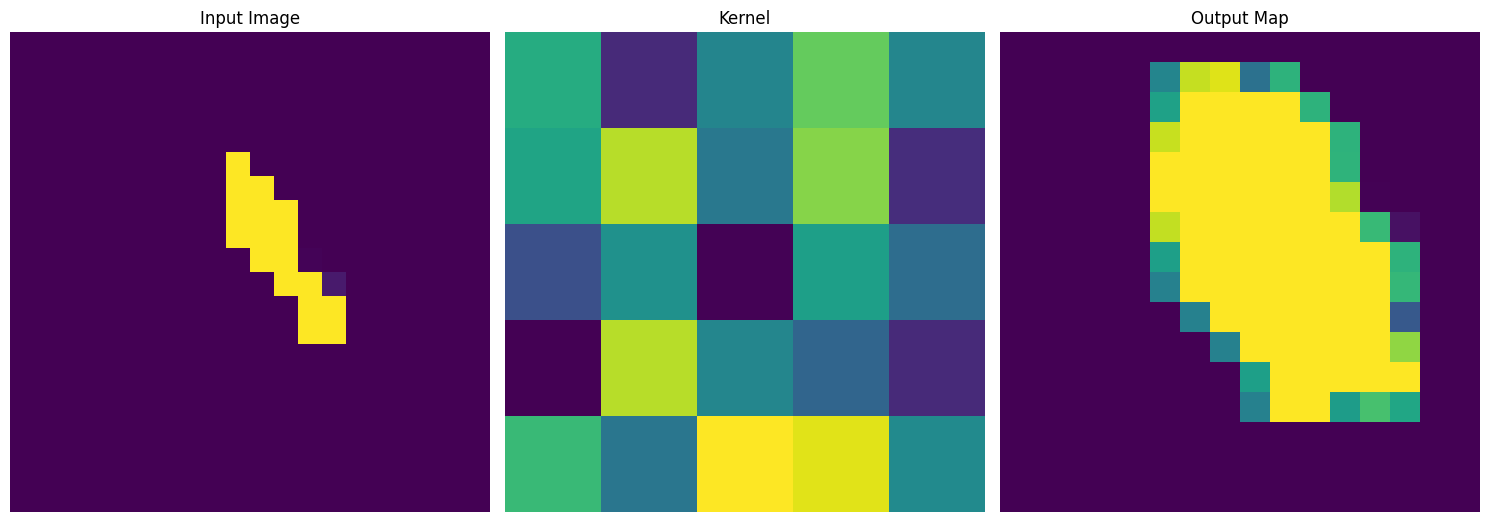

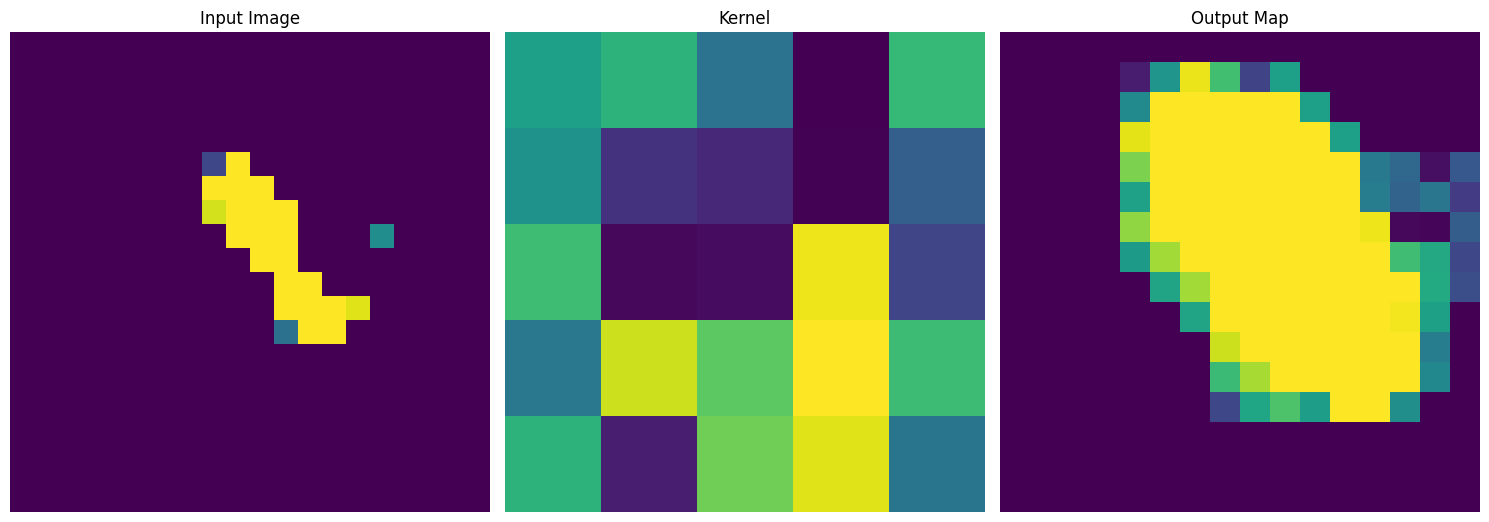

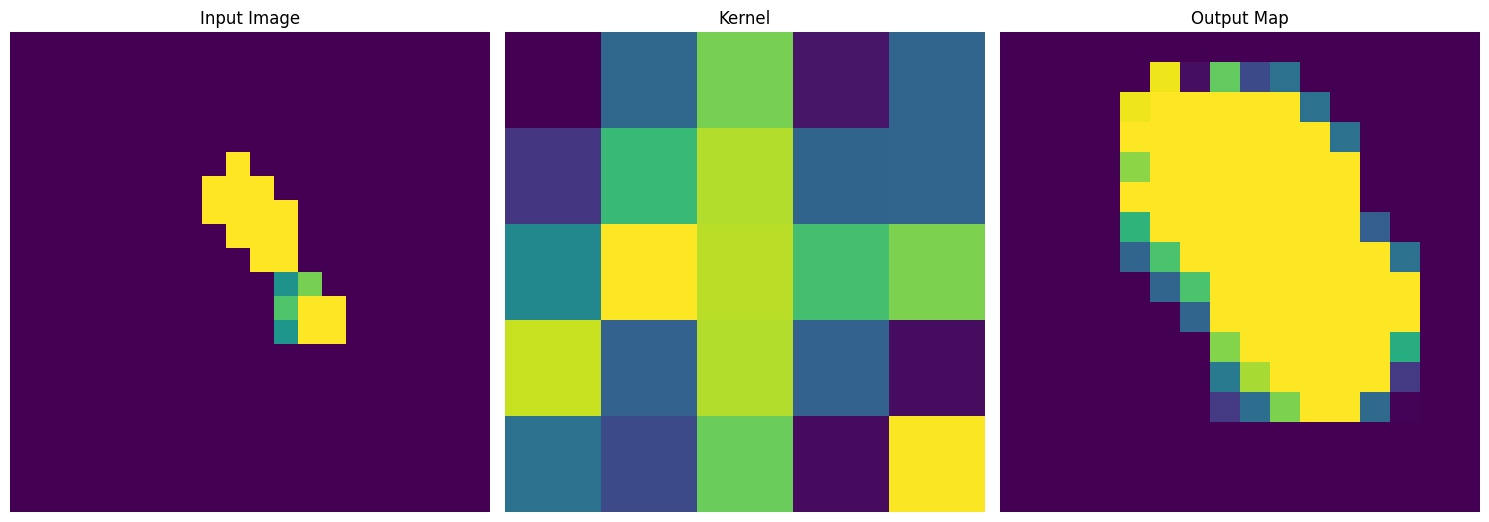

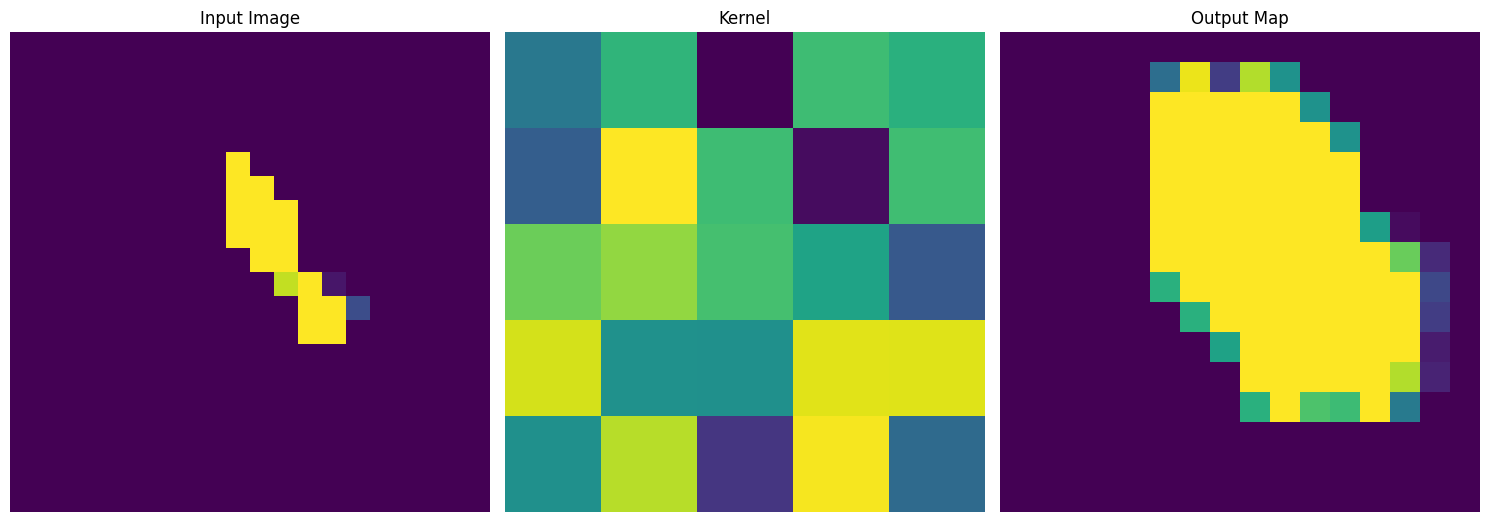

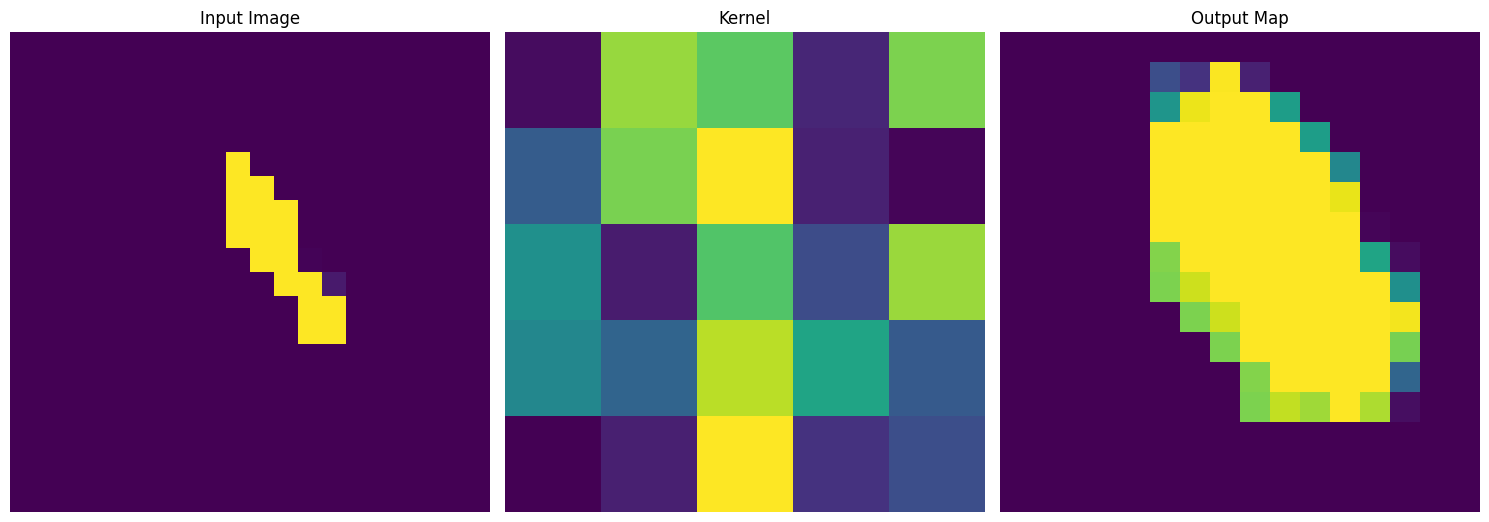

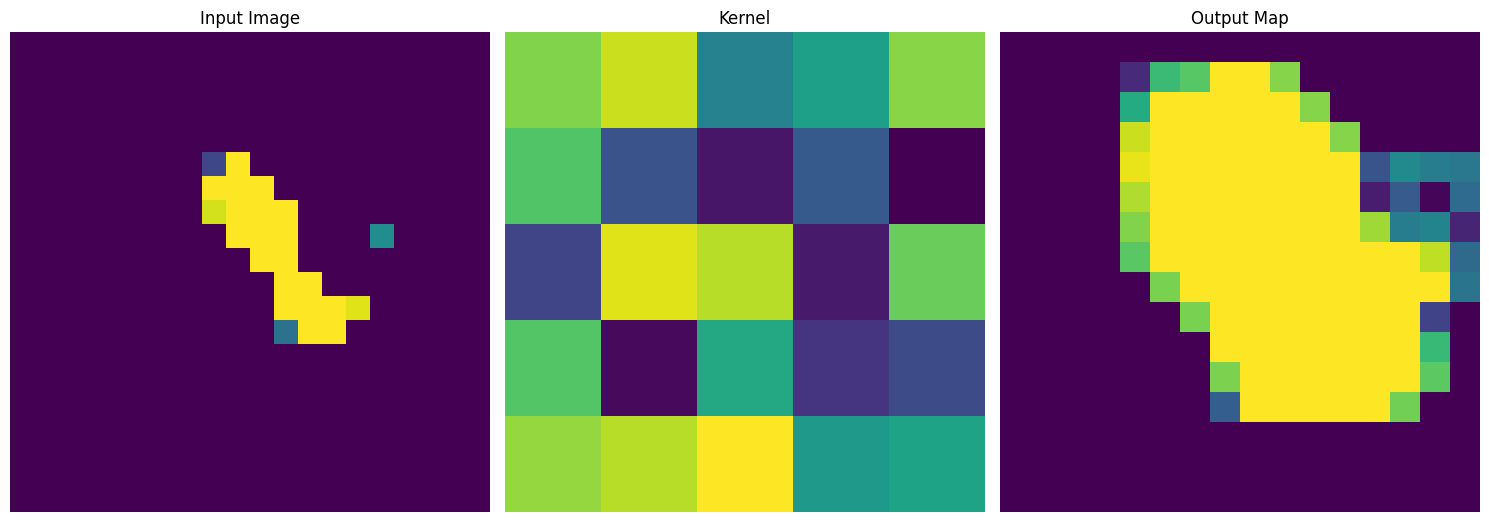

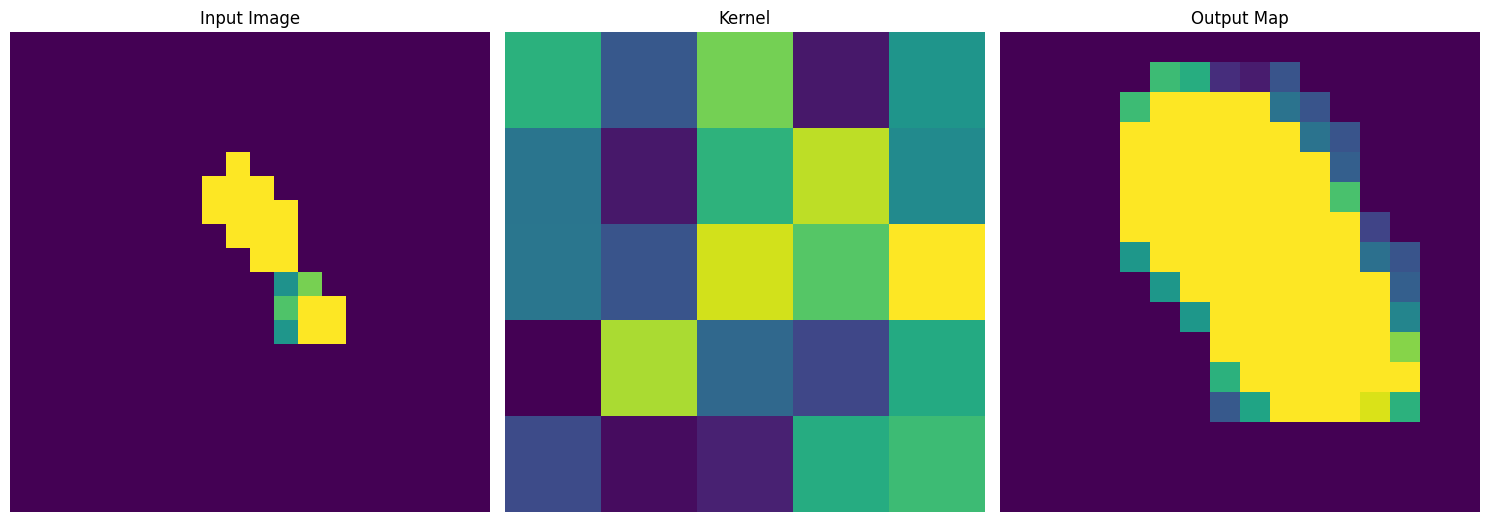

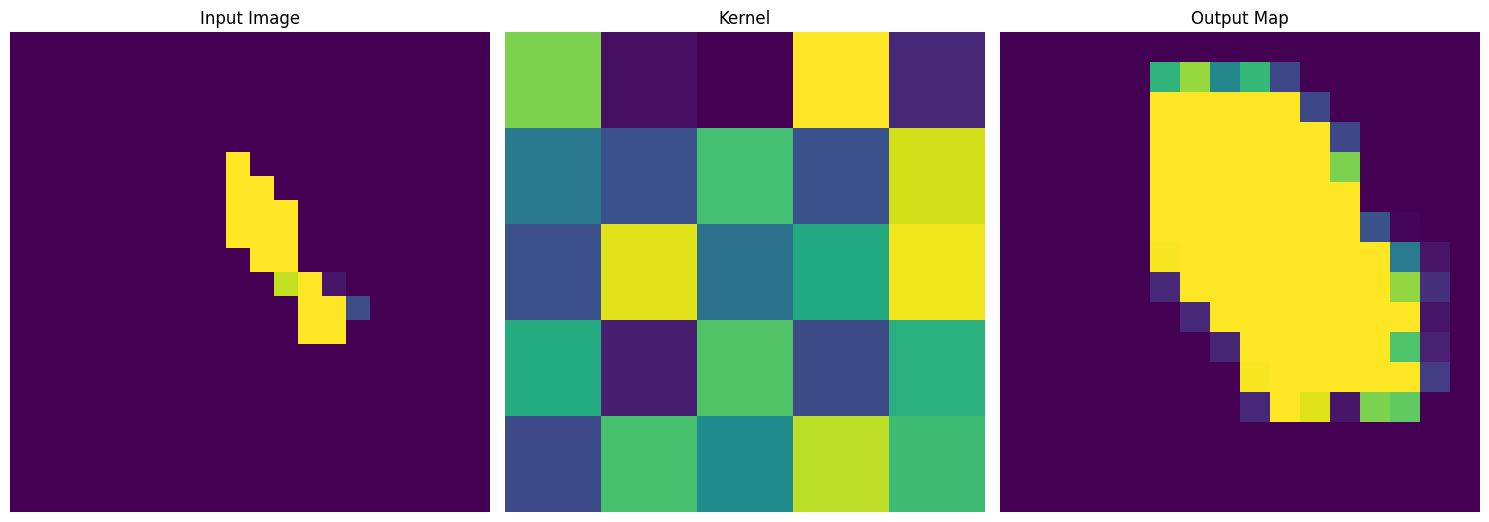

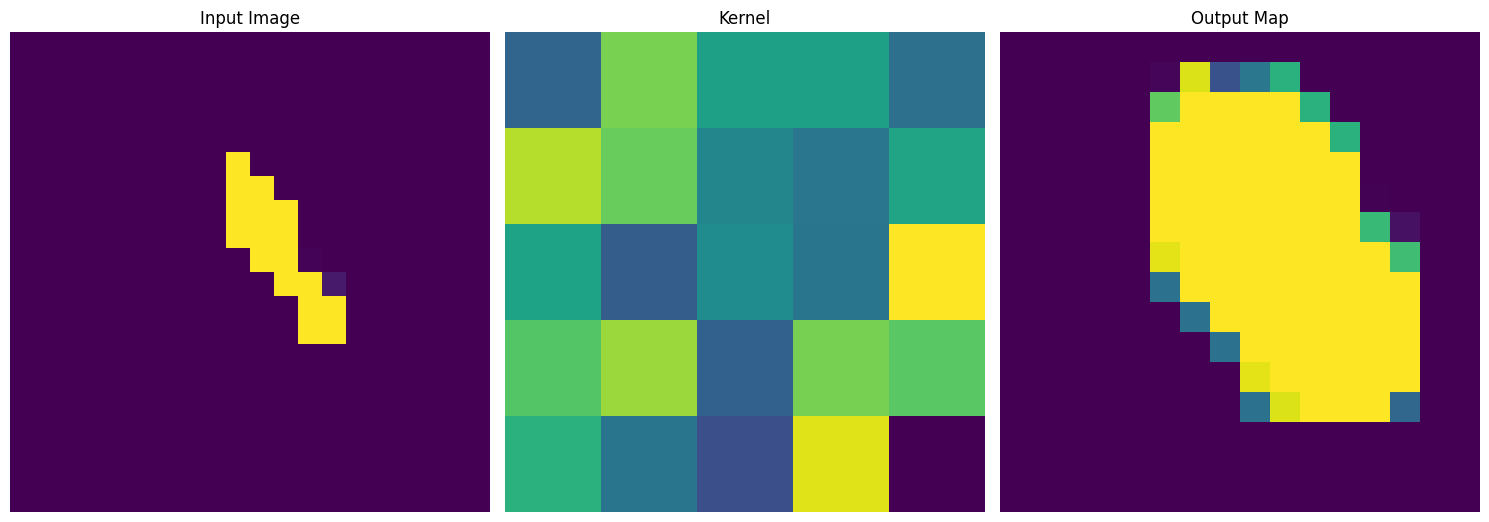

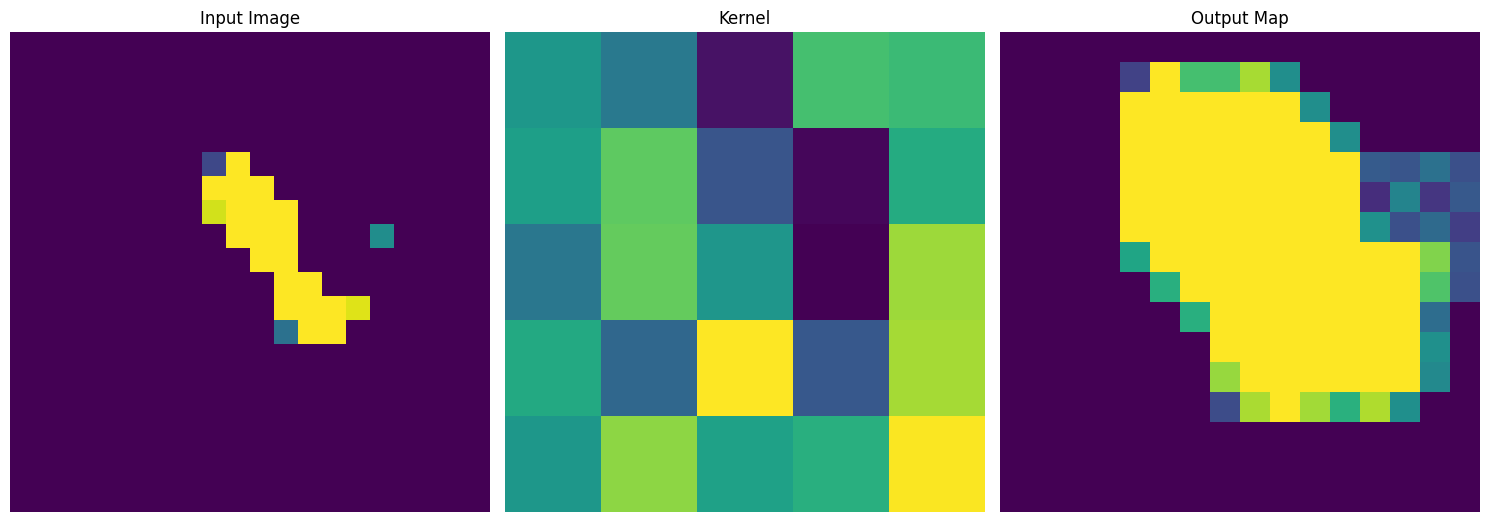

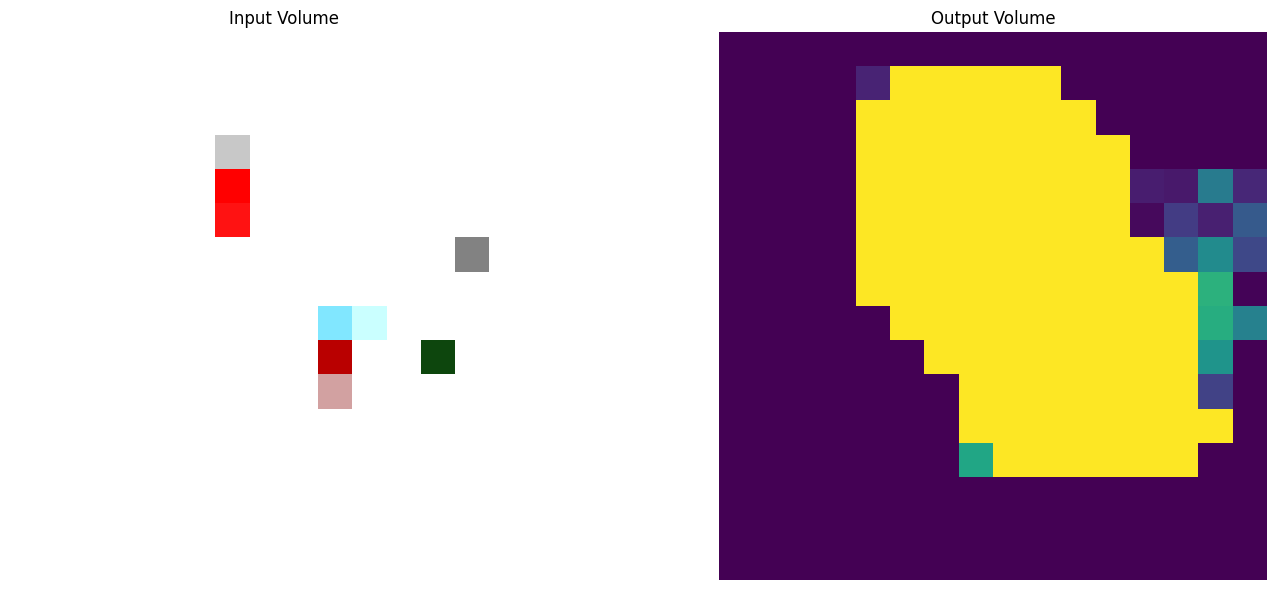

(16, 16, 4)


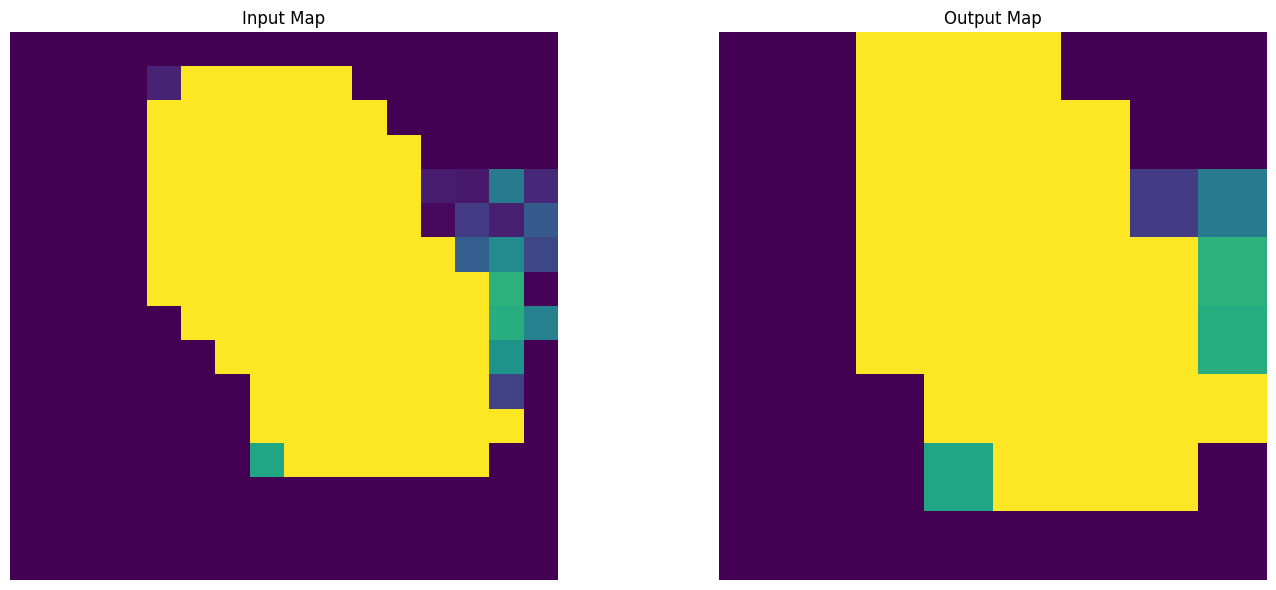

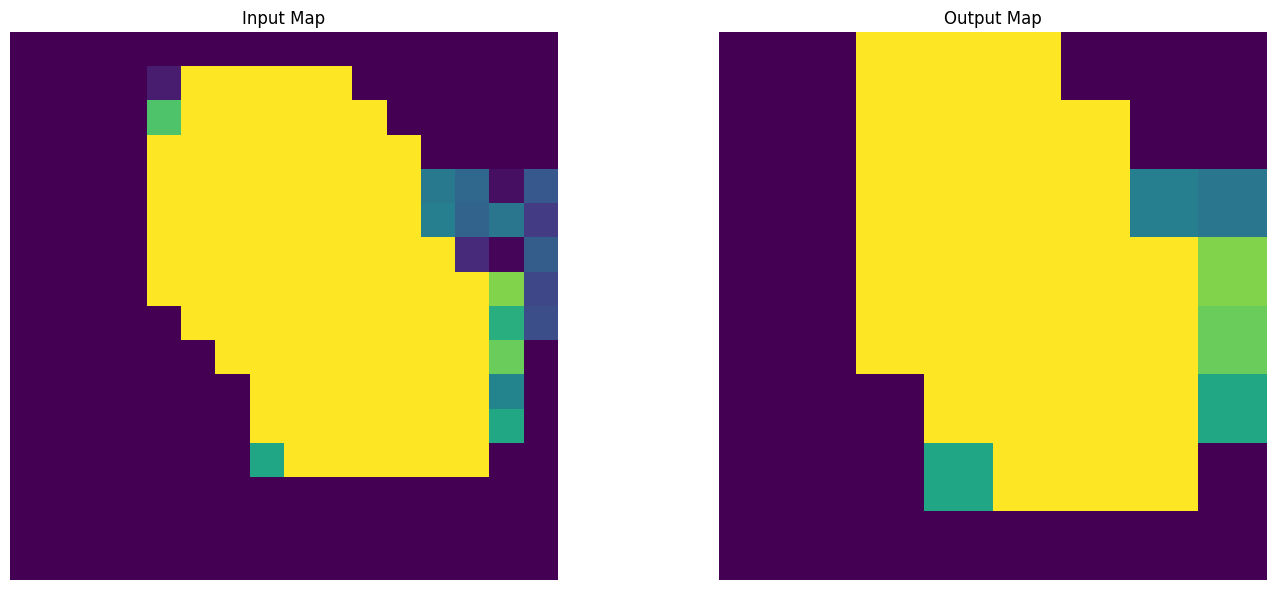

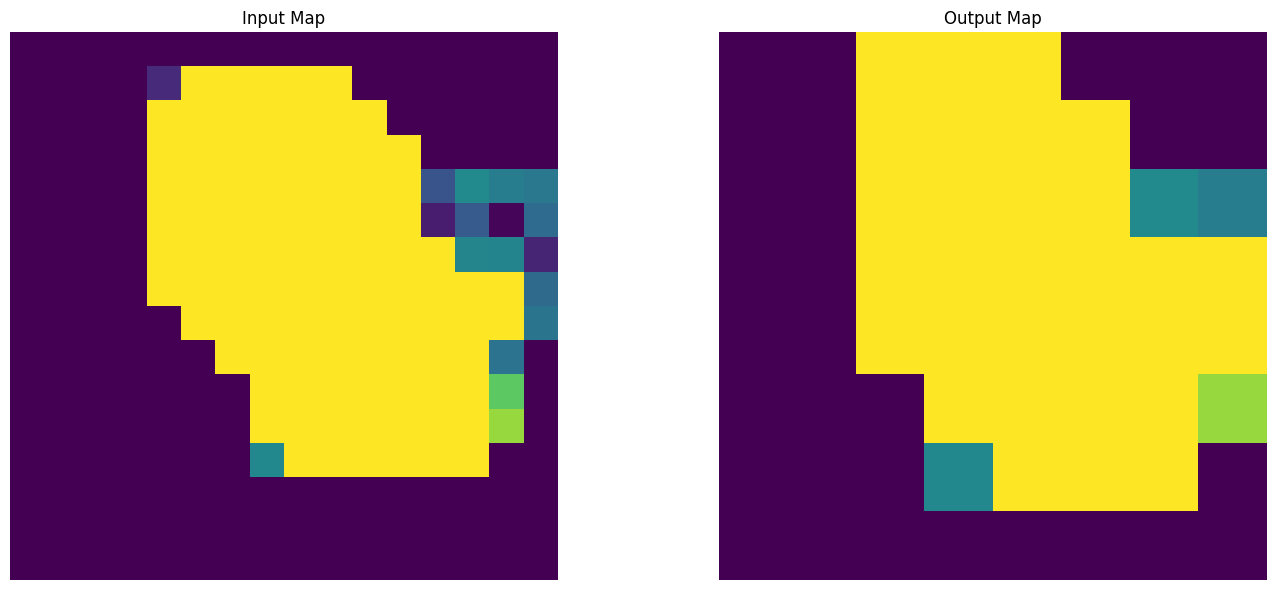

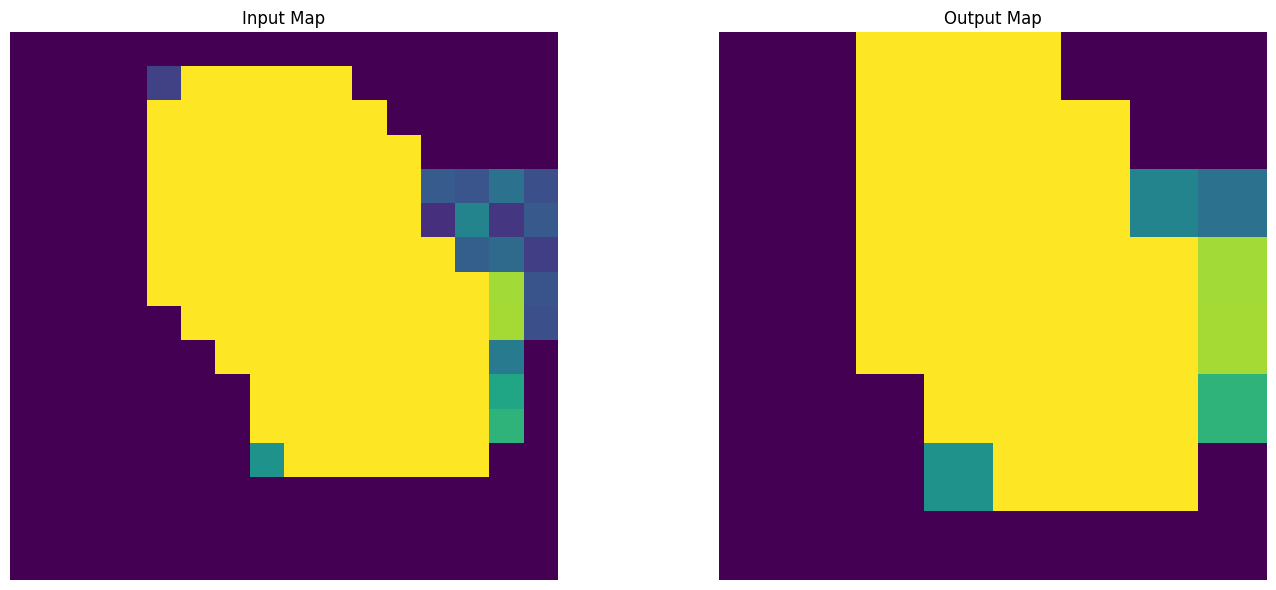

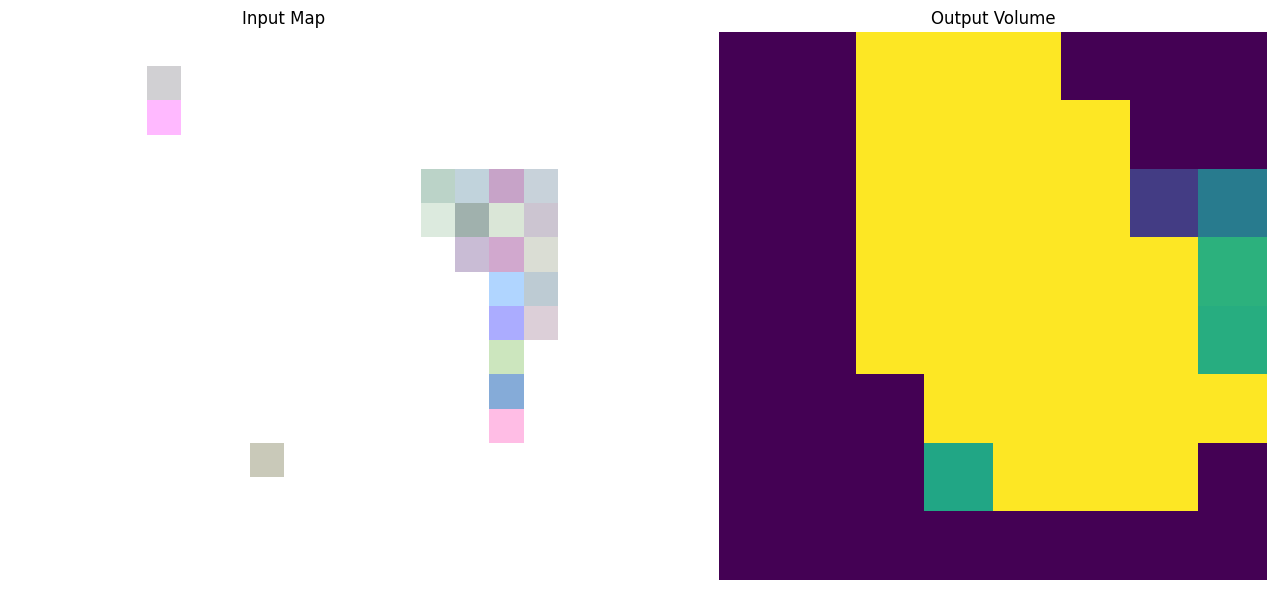

(8, 8, 4)


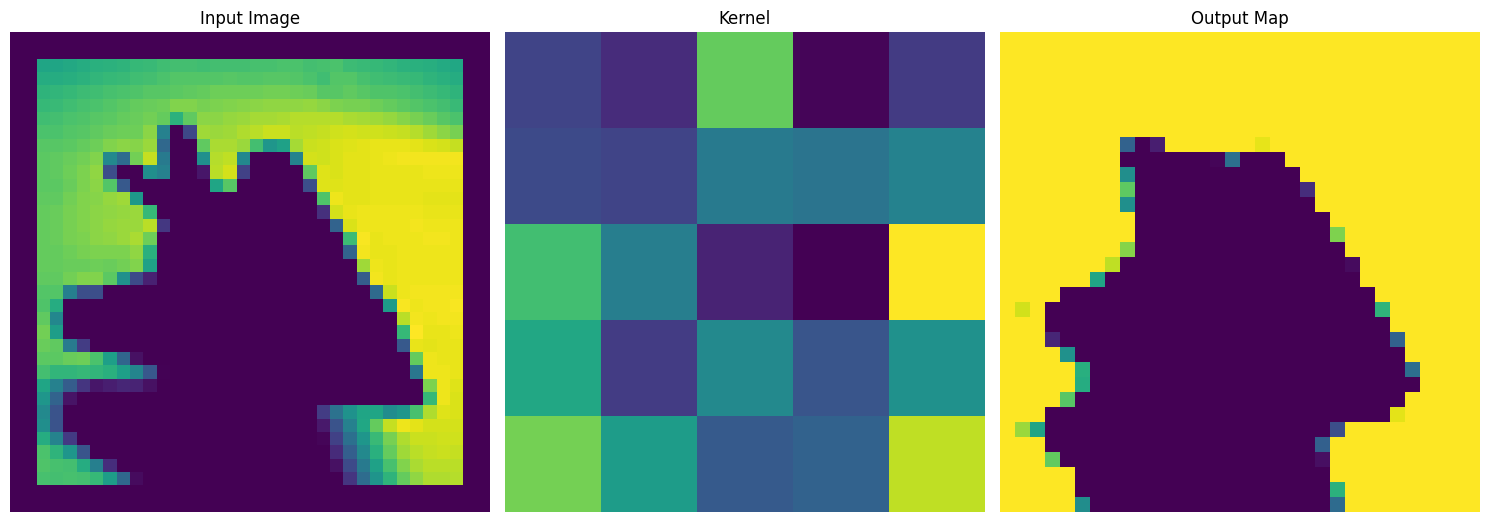

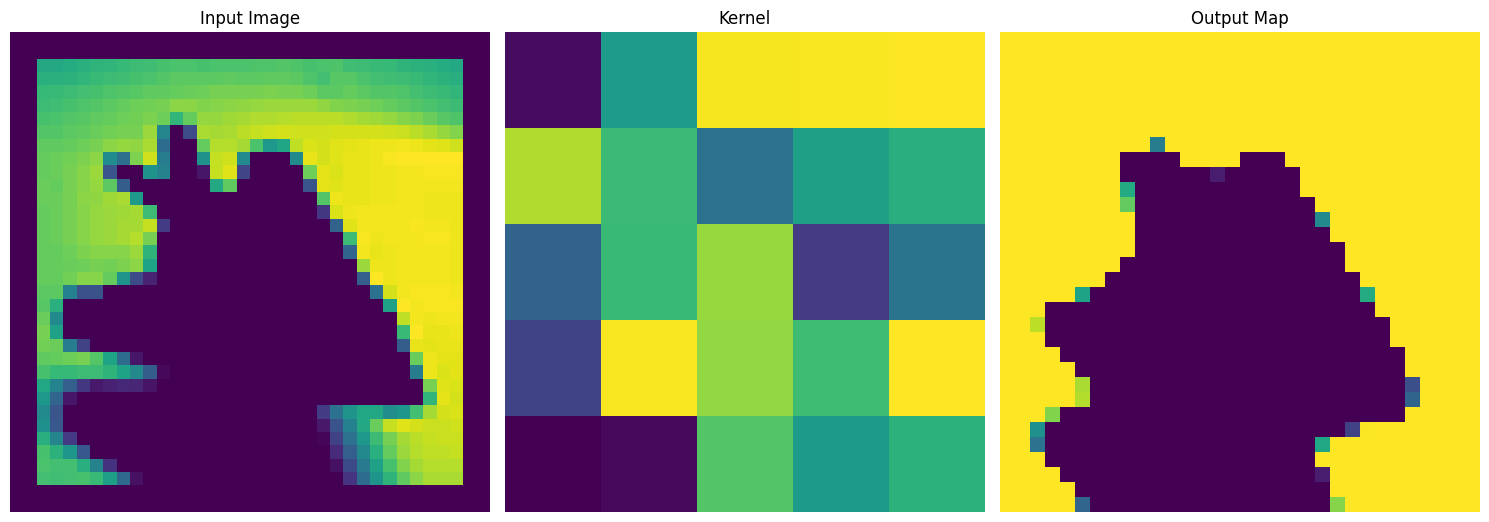

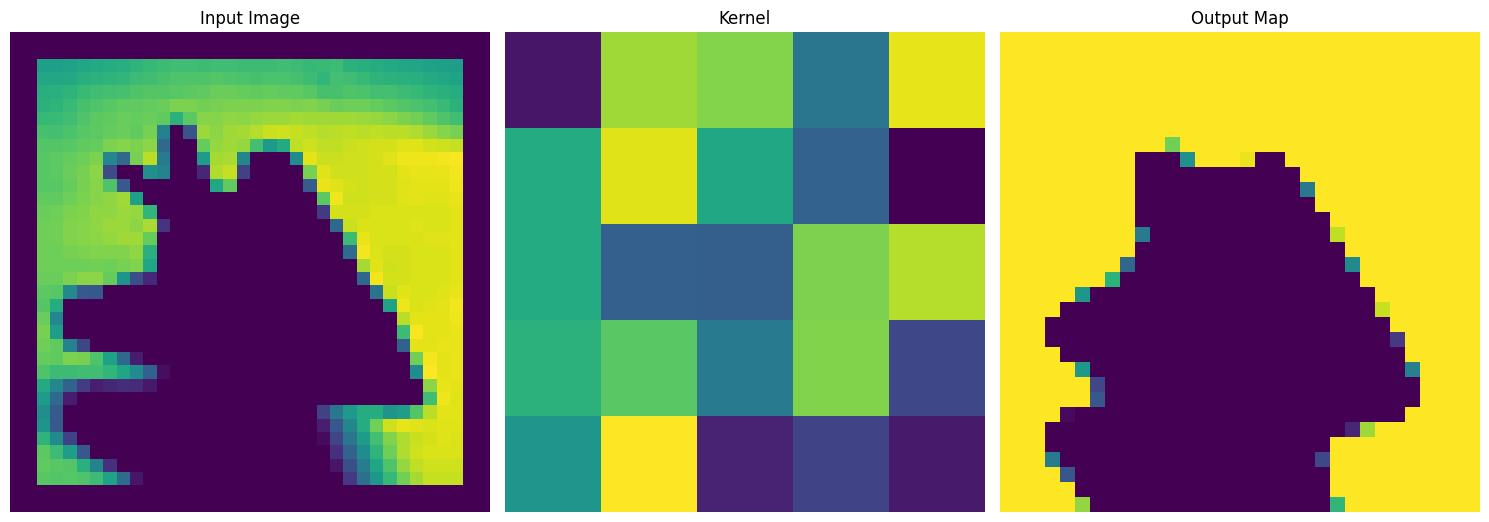

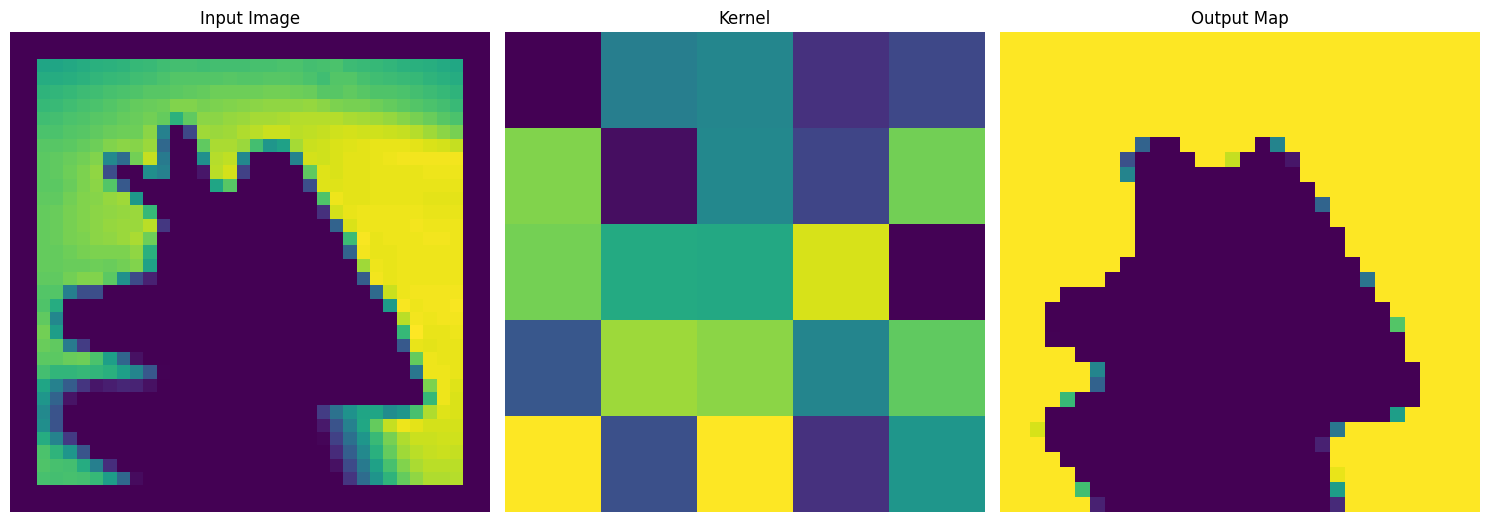

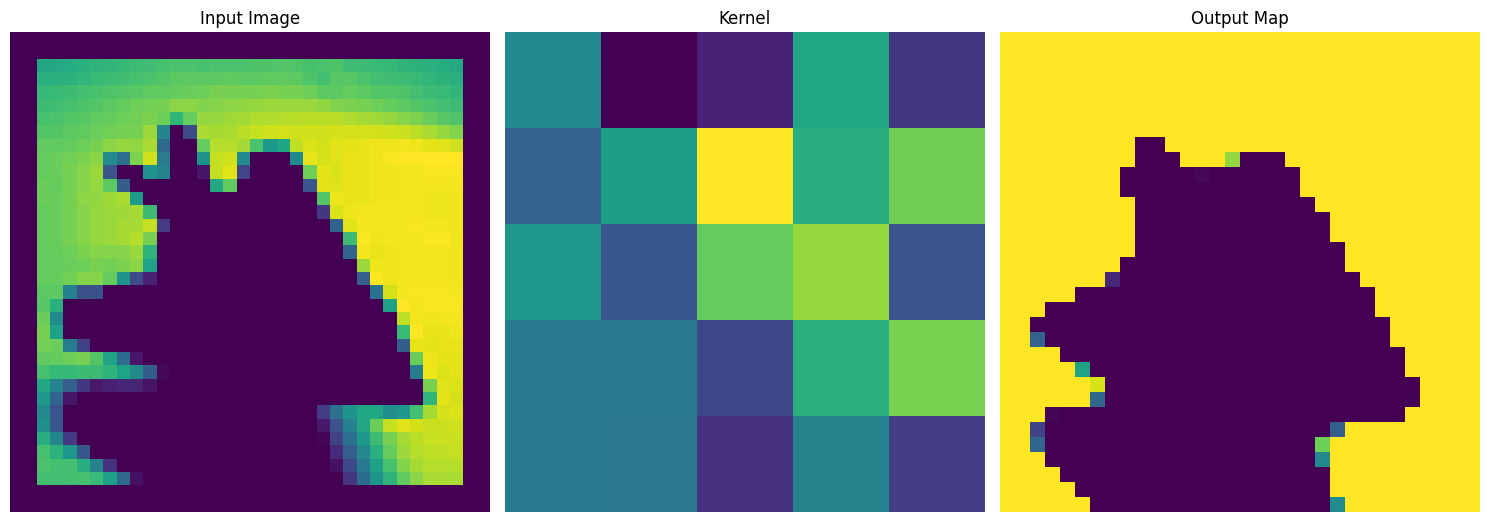

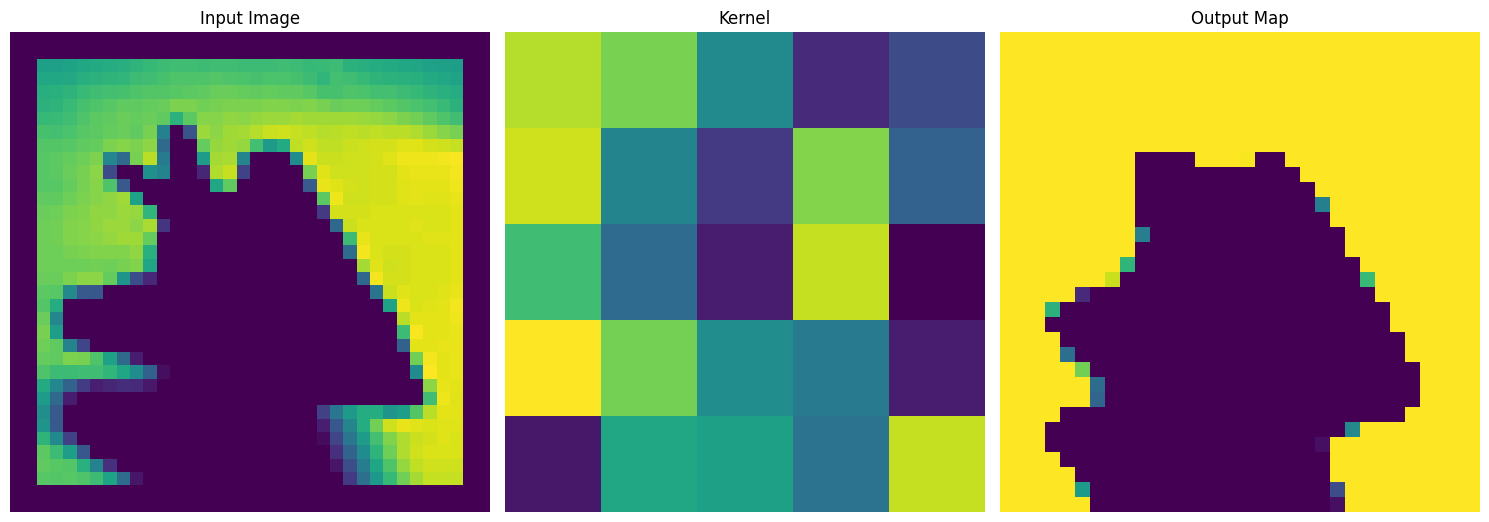

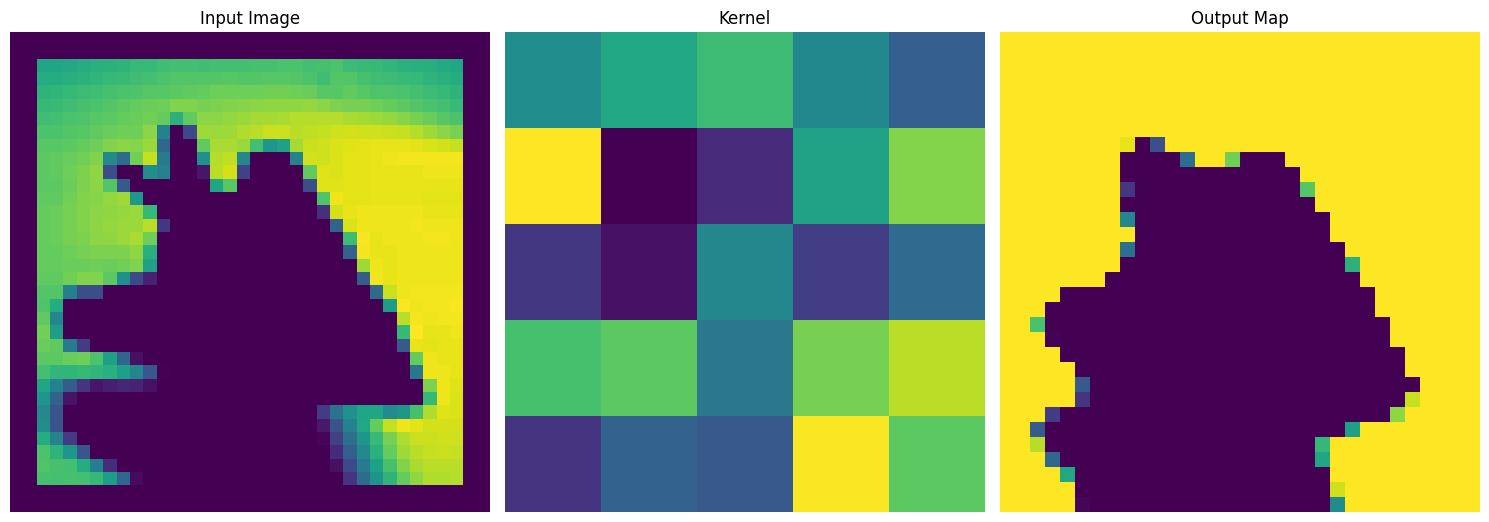

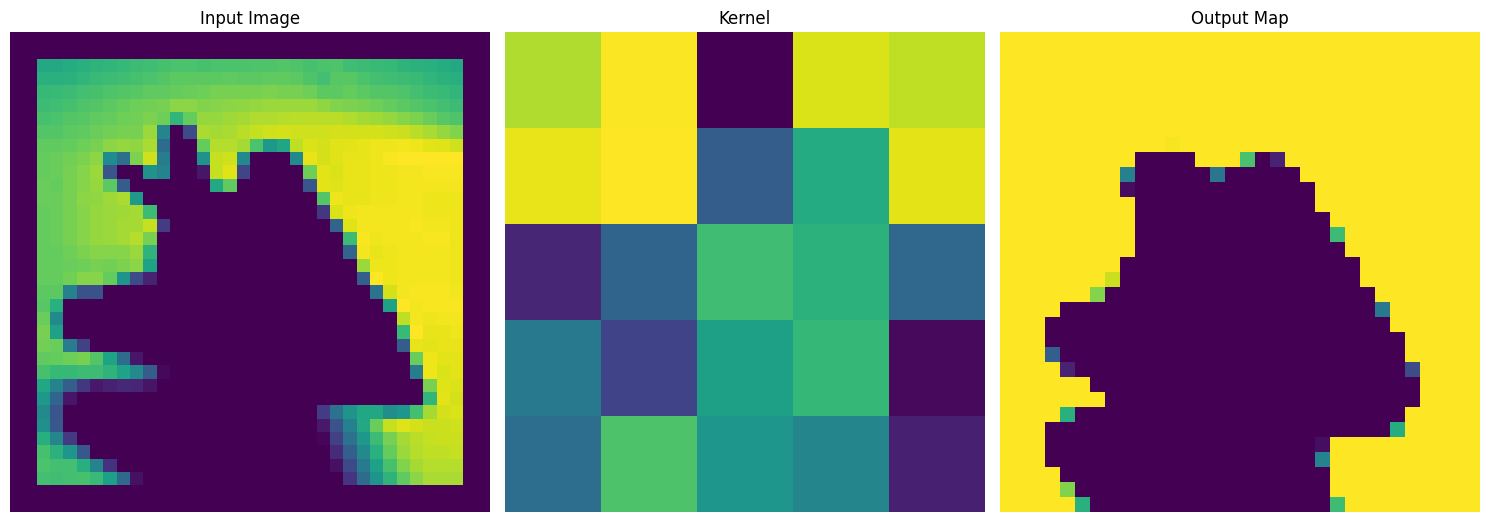

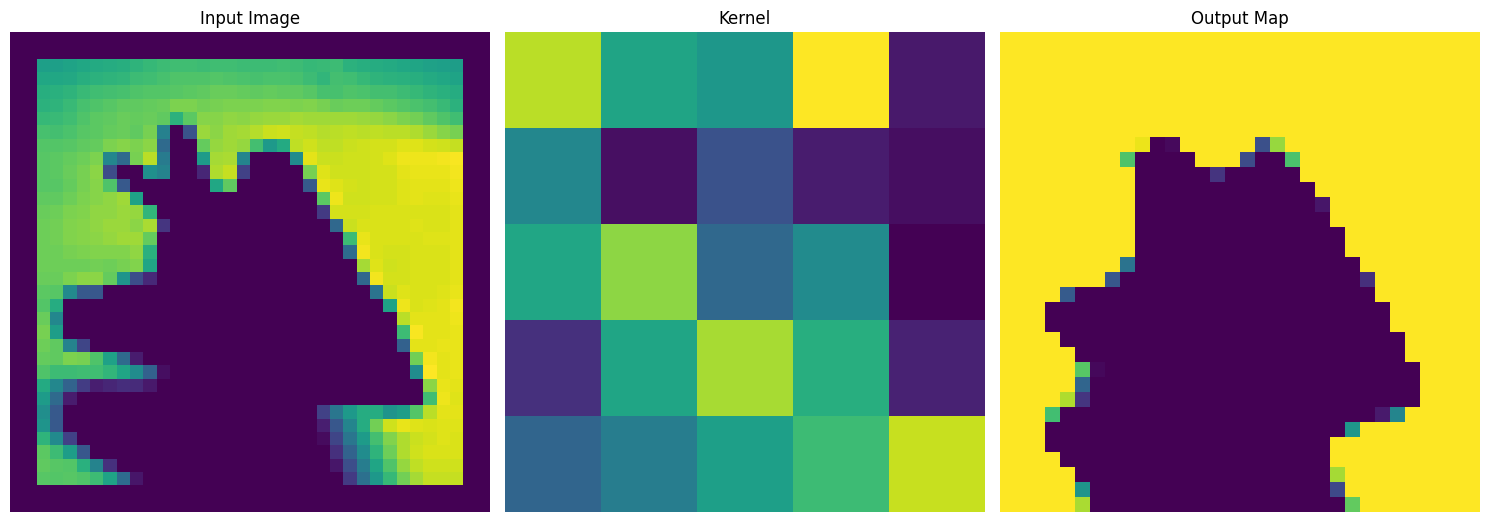

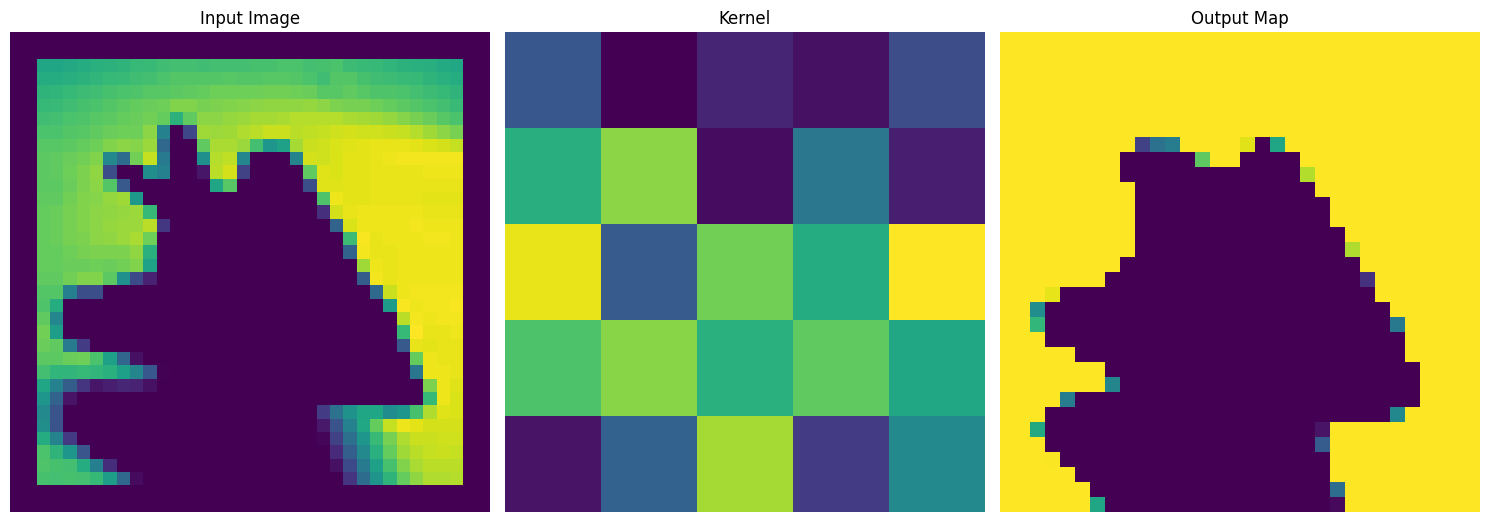

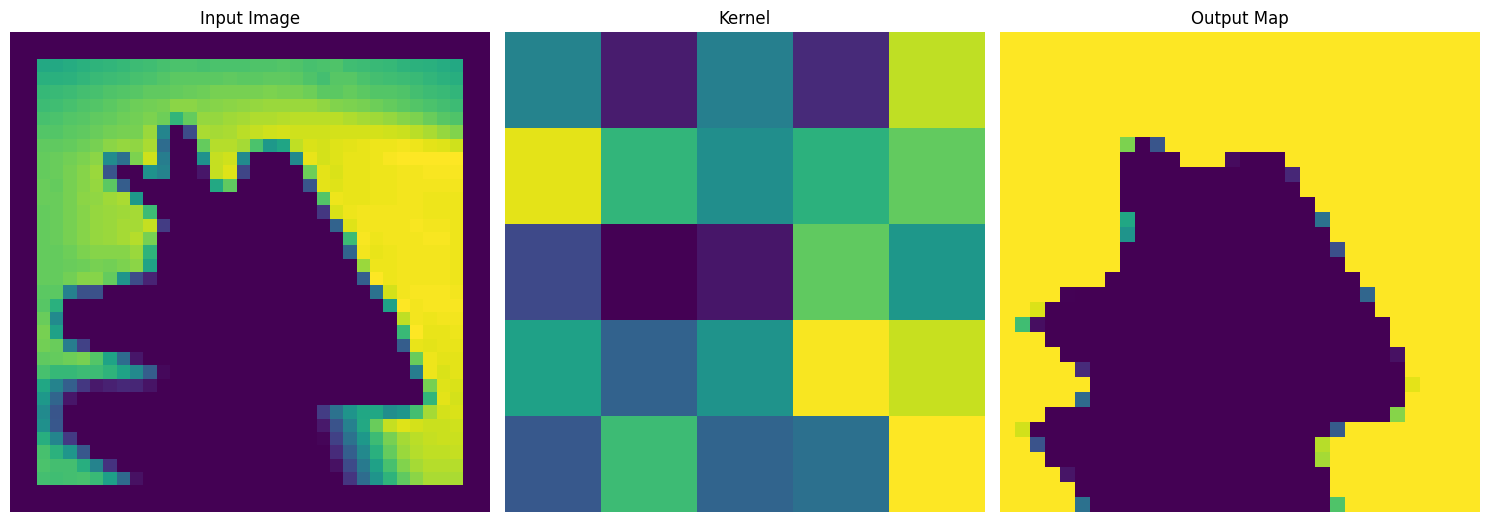

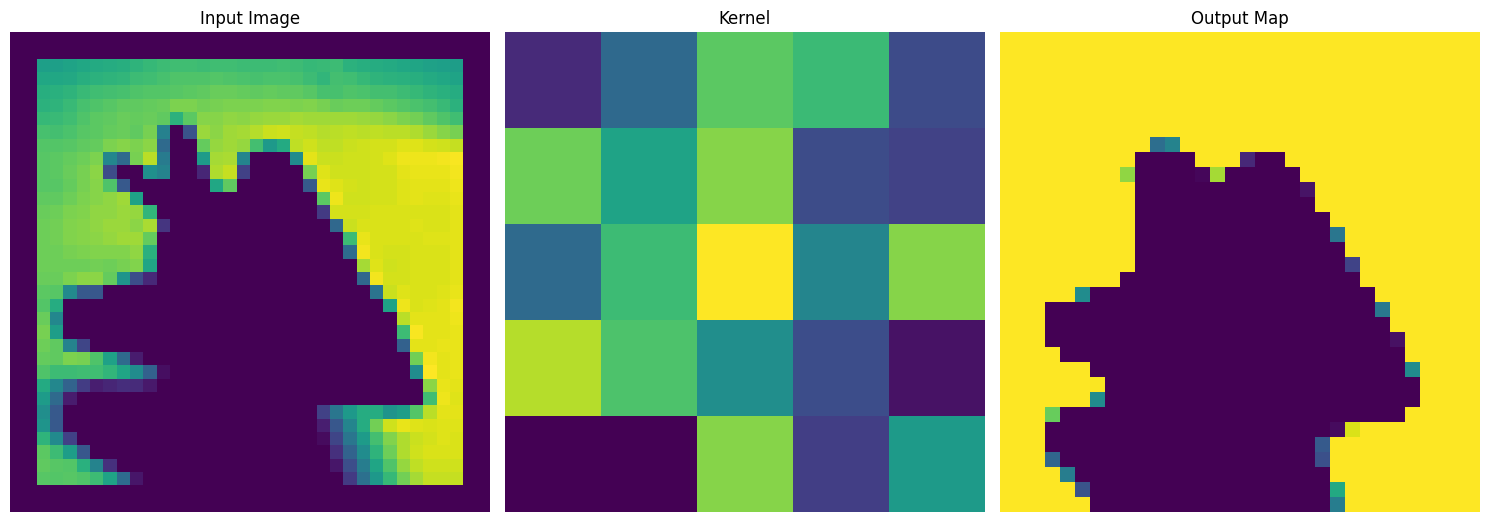

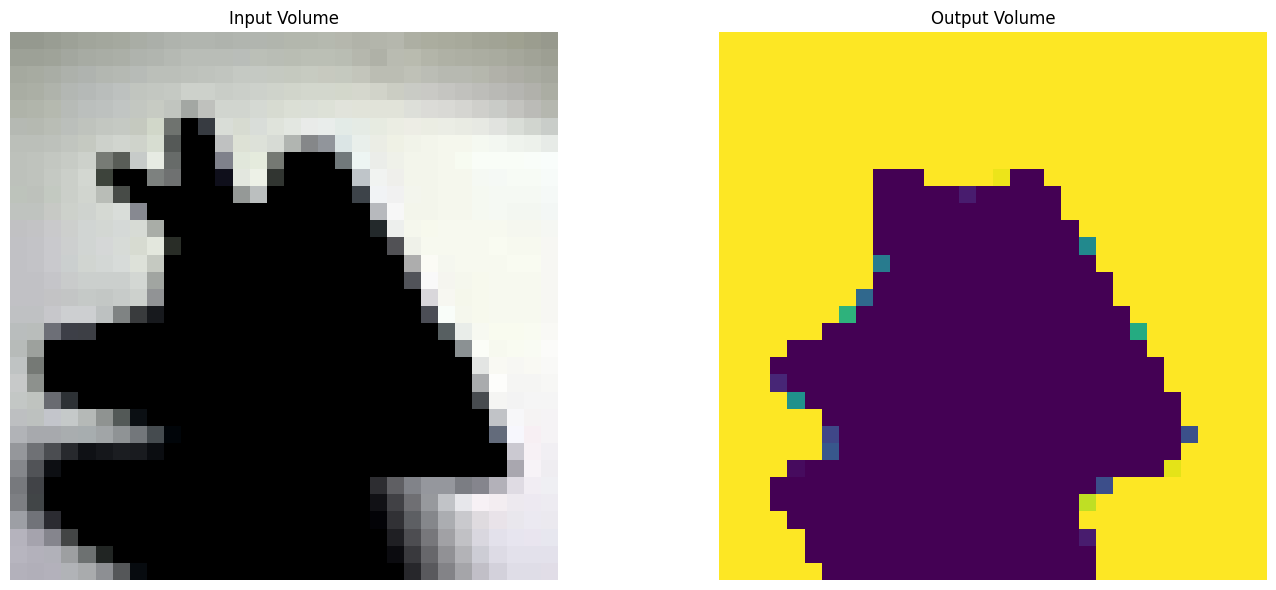

(32, 32, 4)


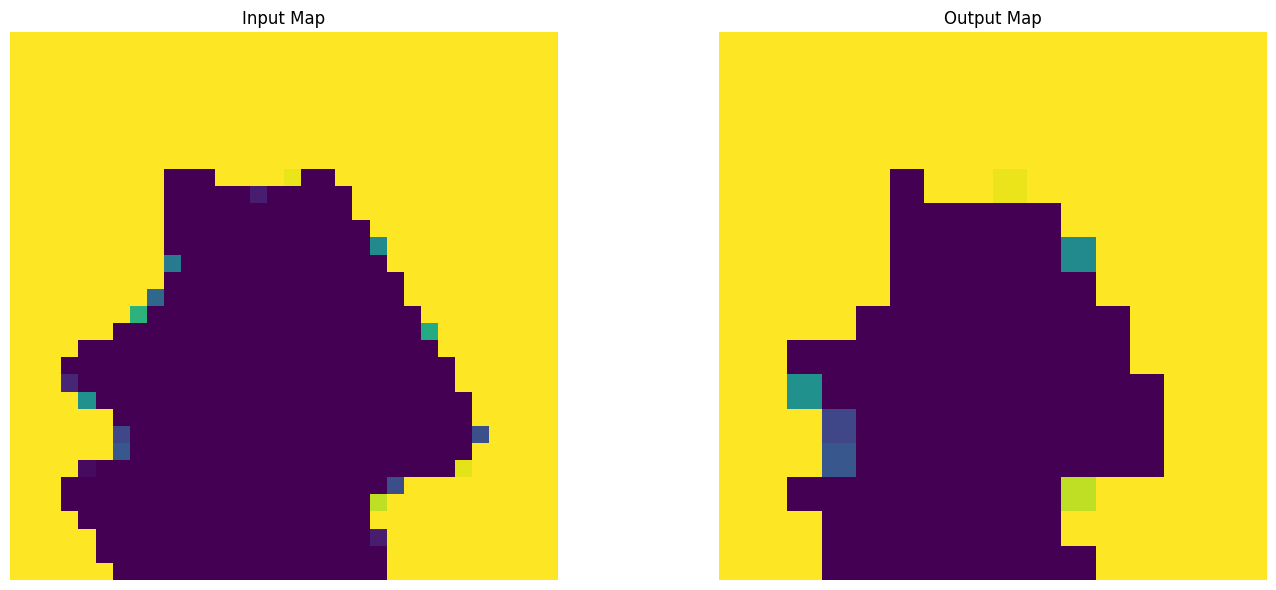

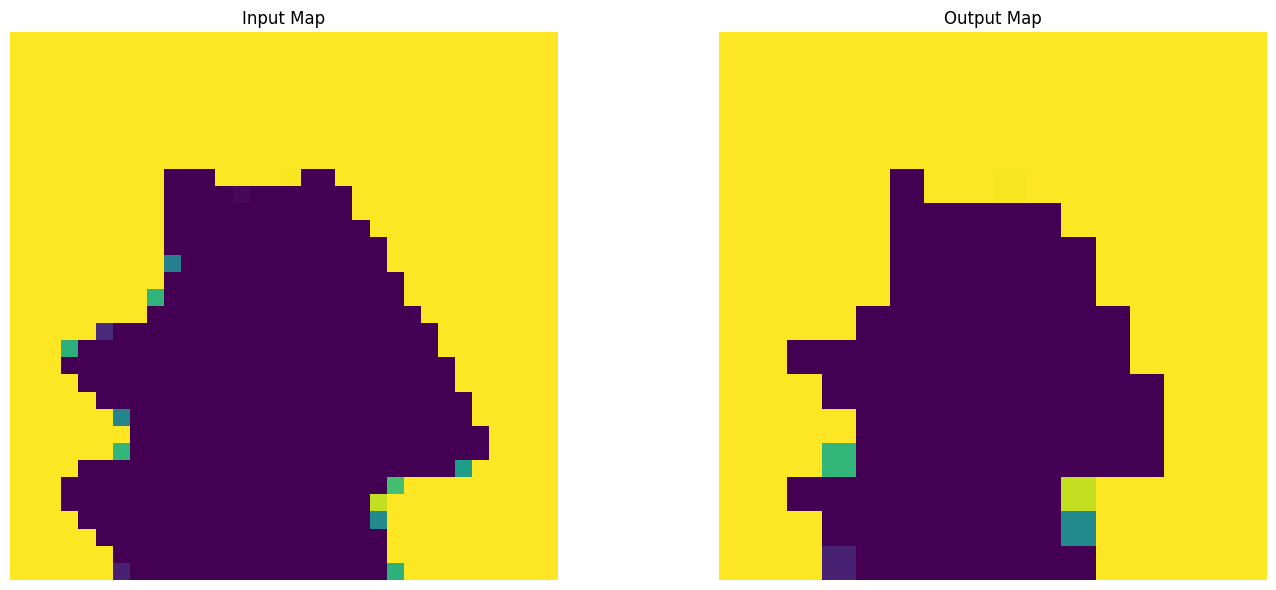

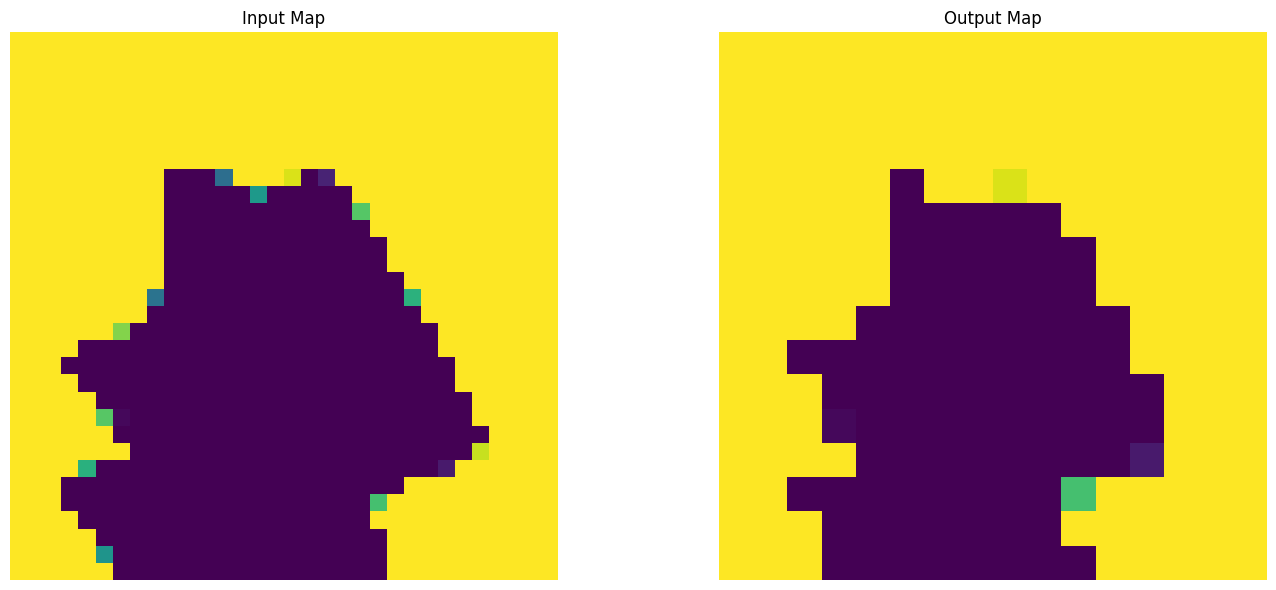

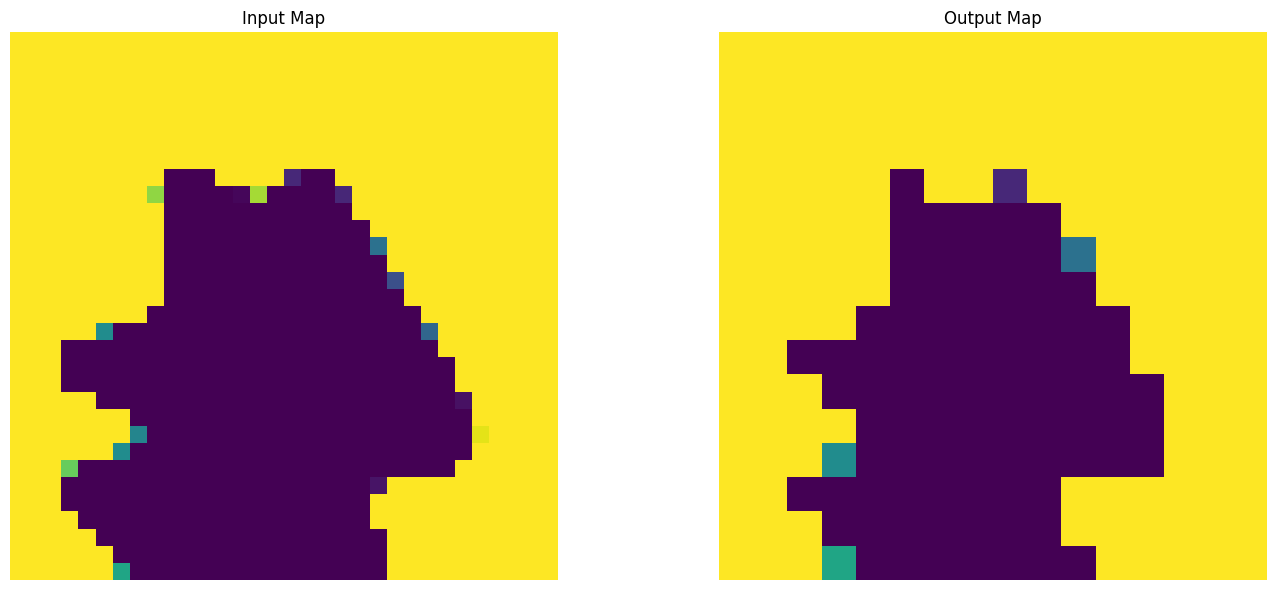

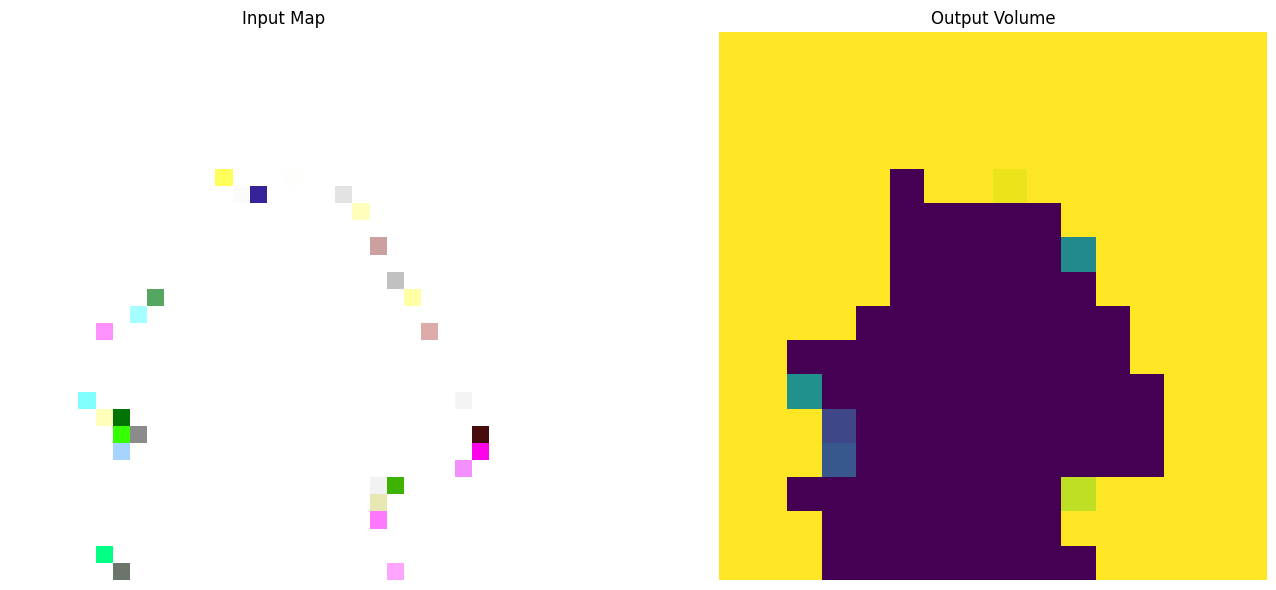

(16, 16, 4)


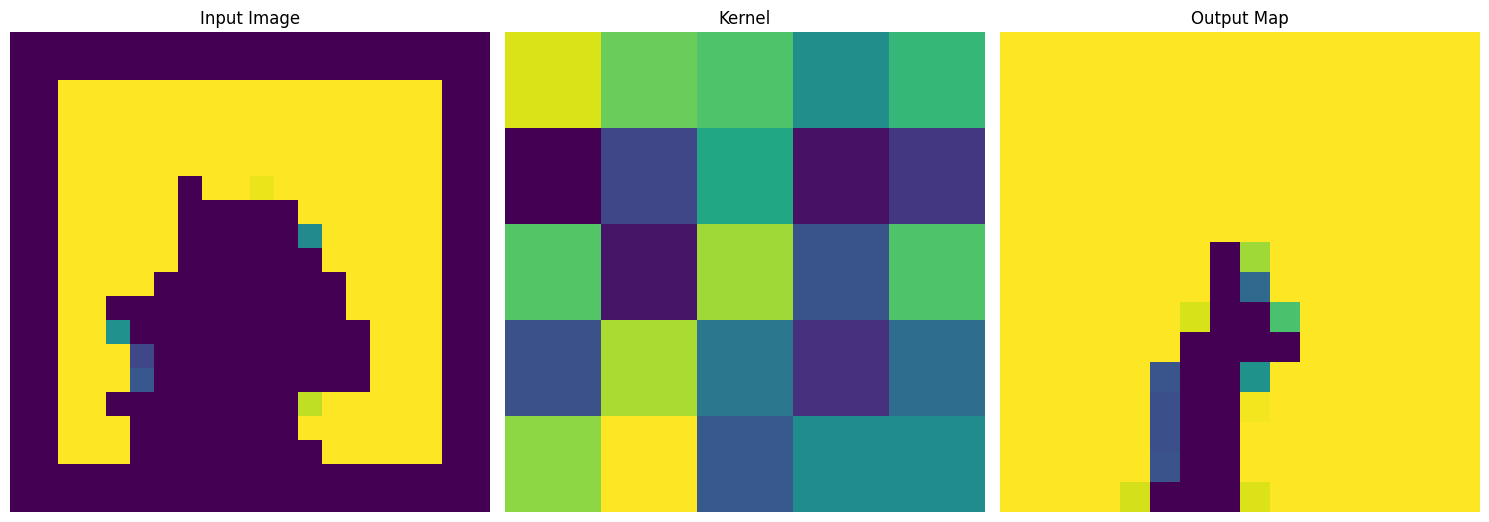

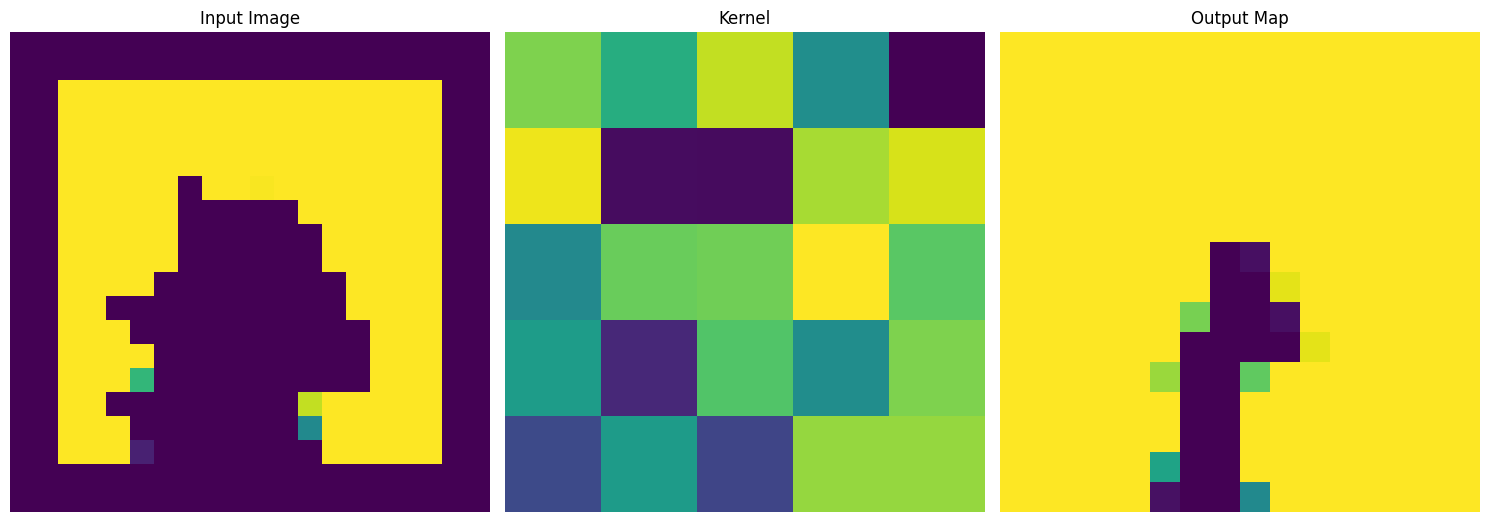

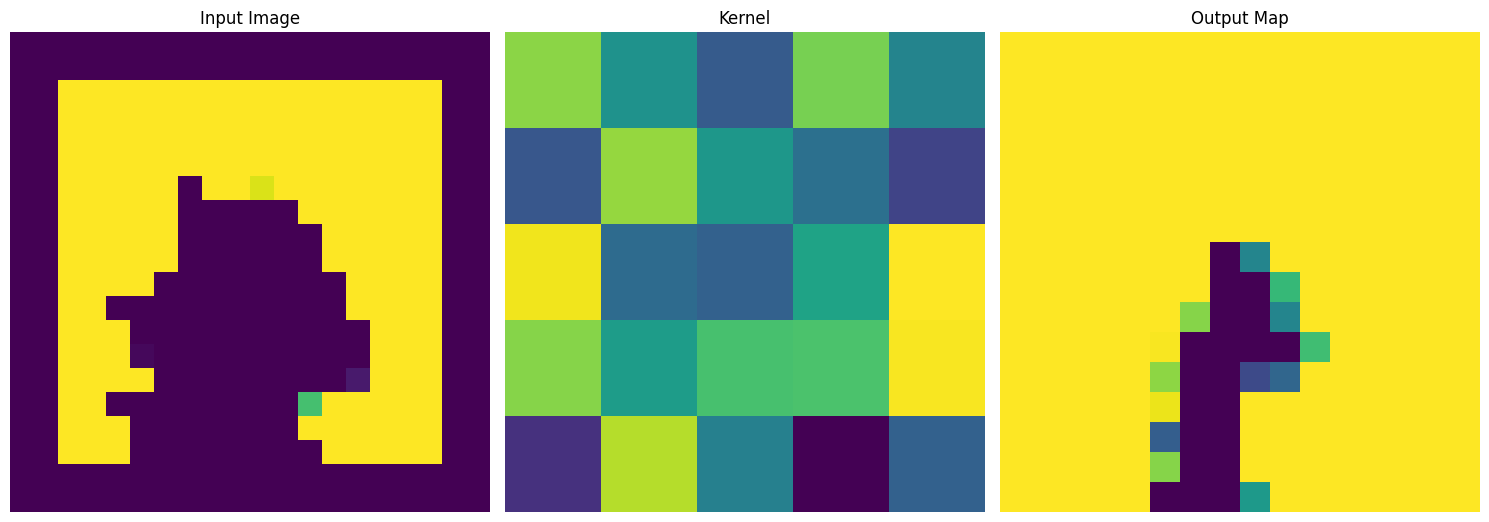

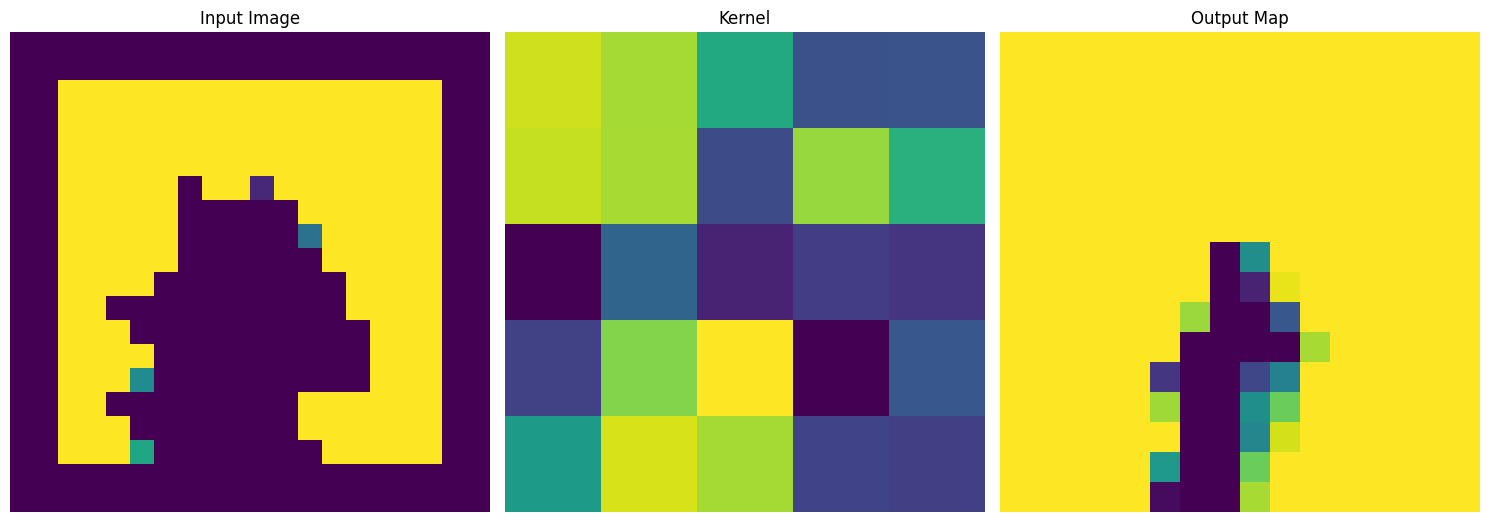

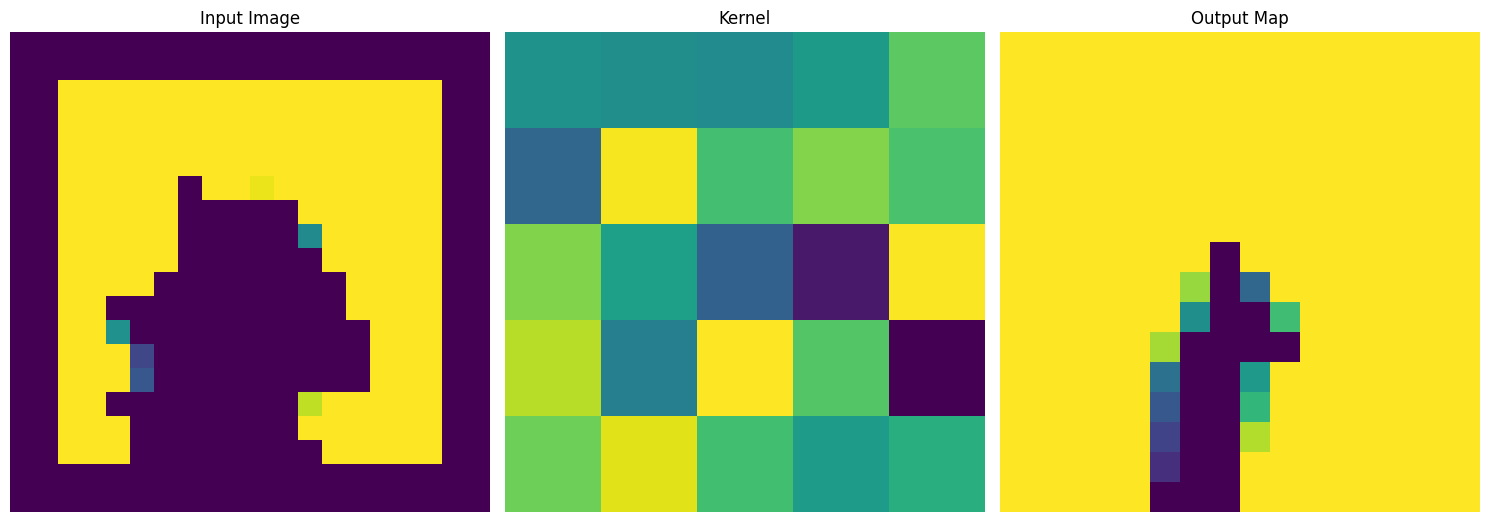

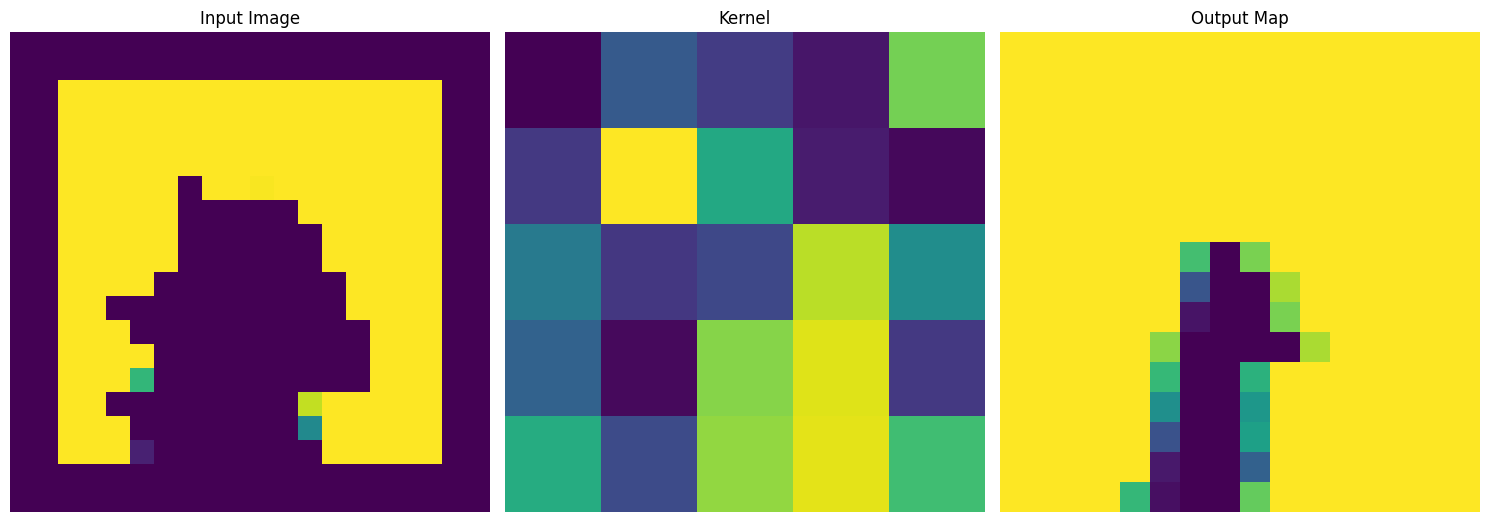

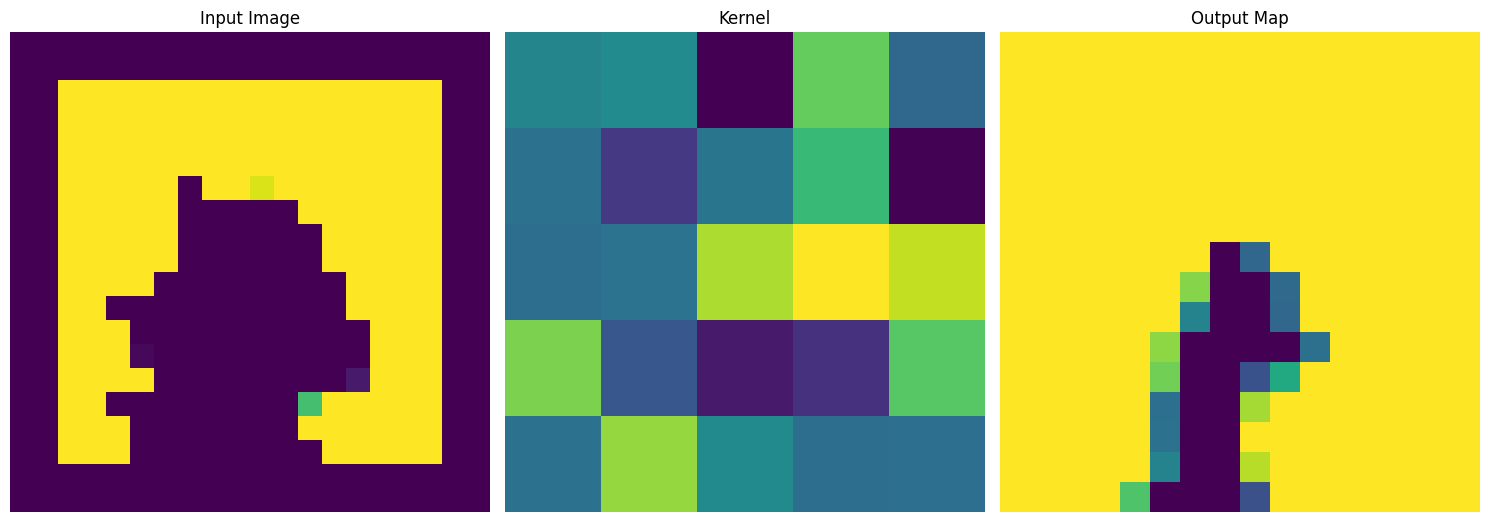

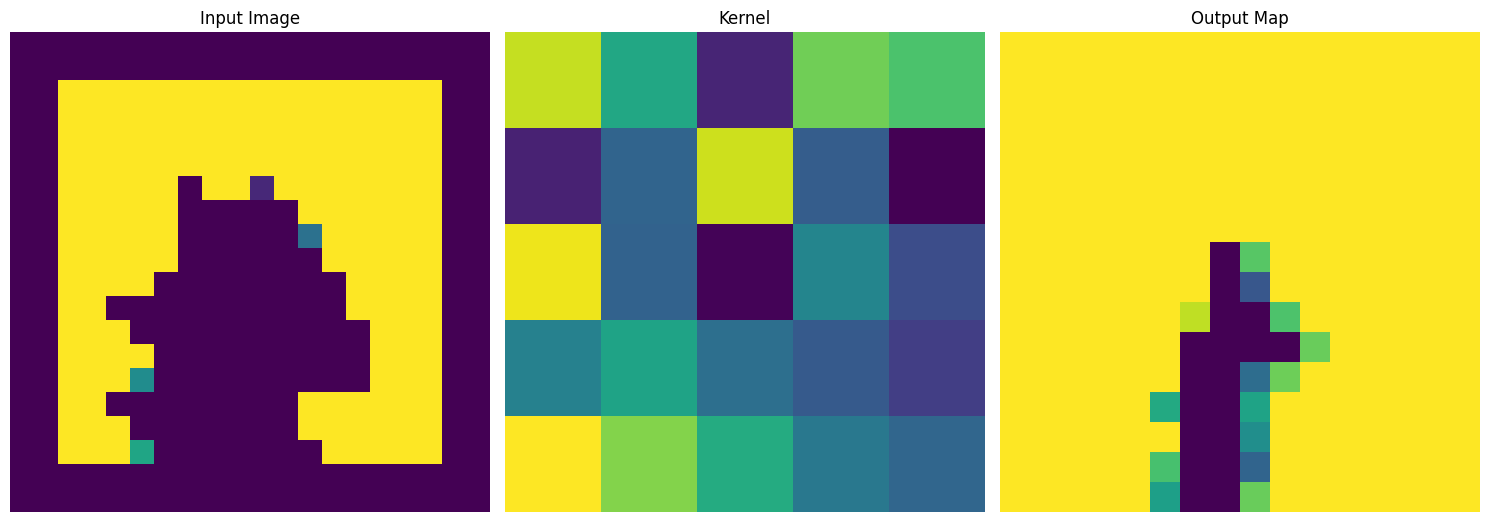

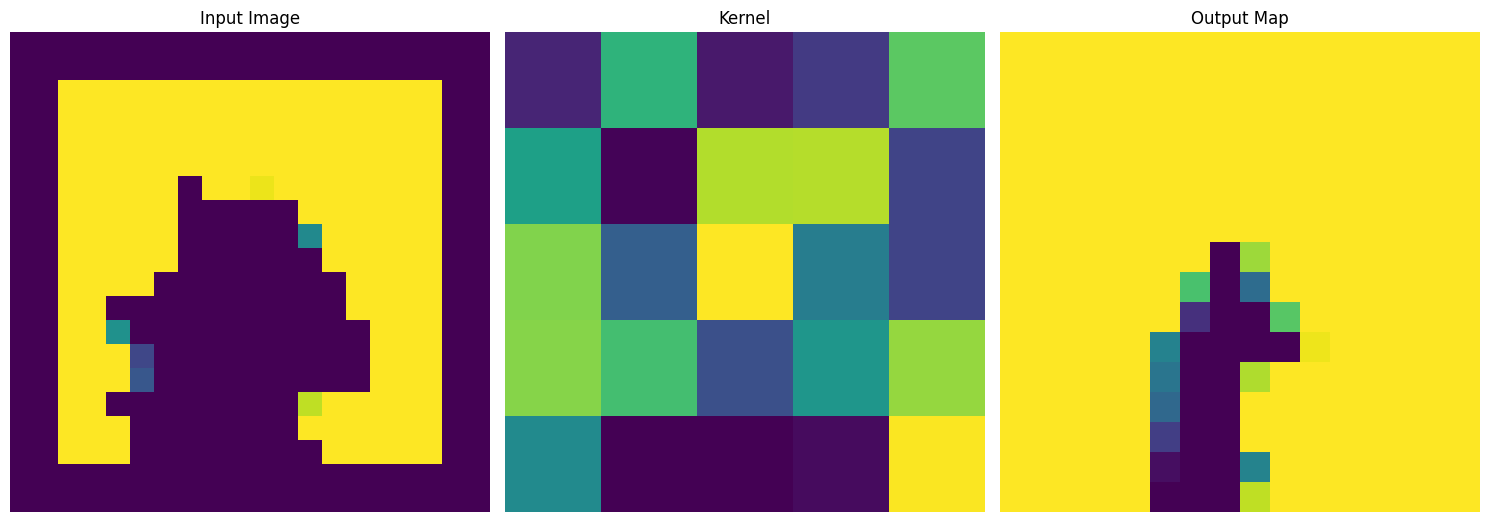

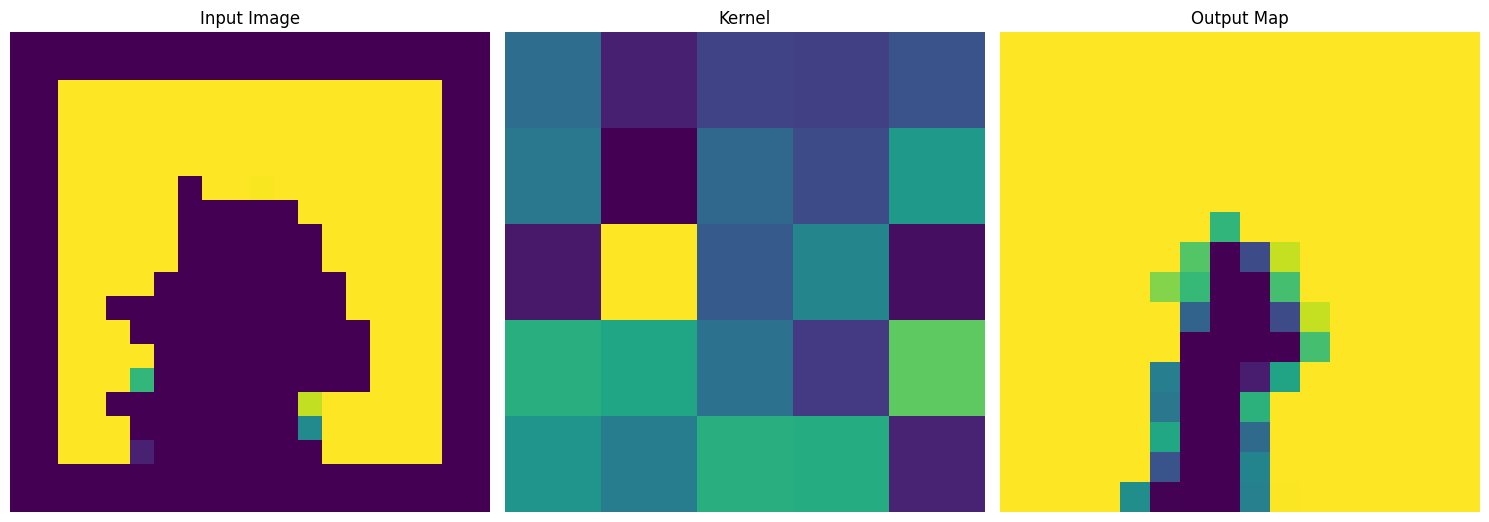

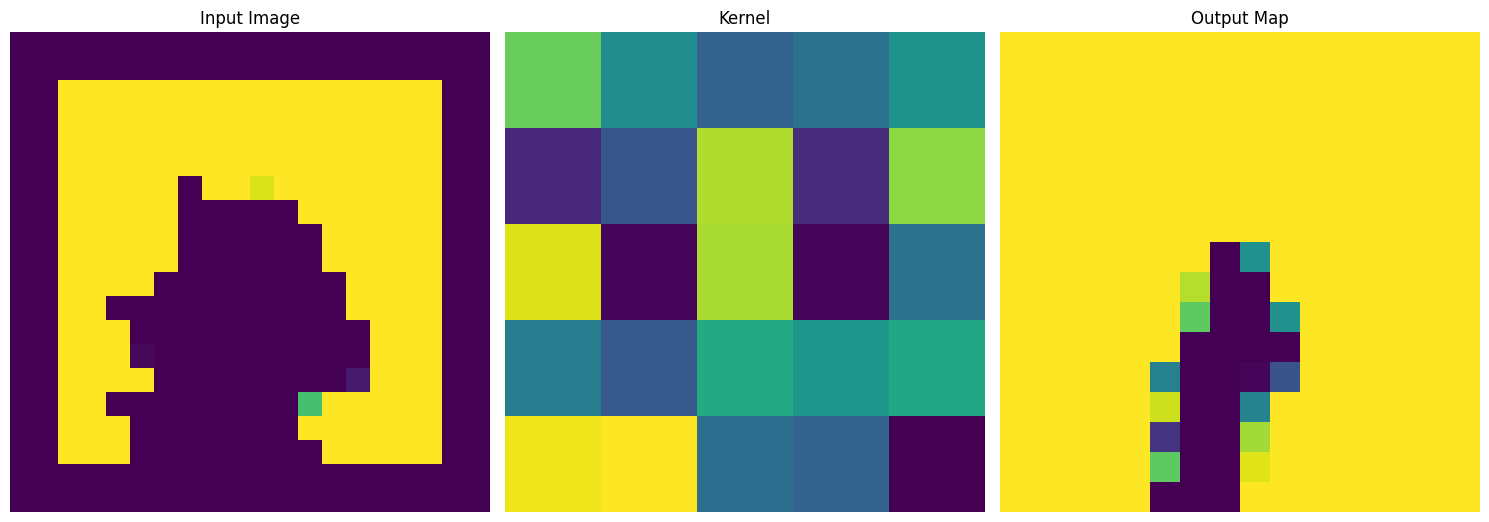

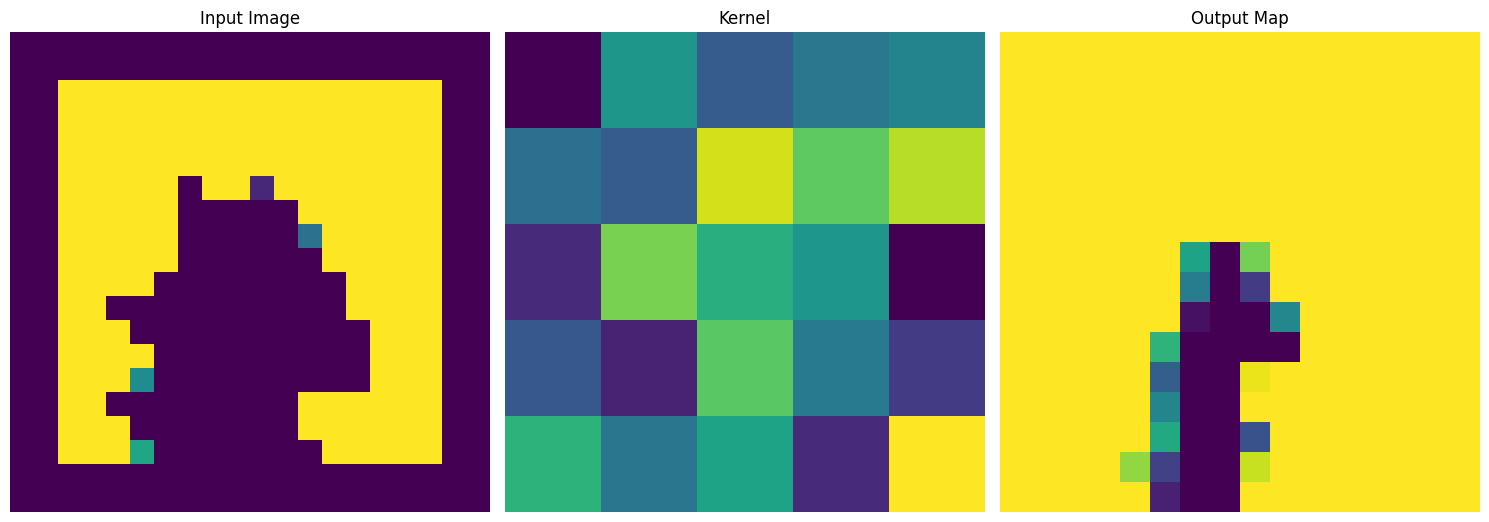

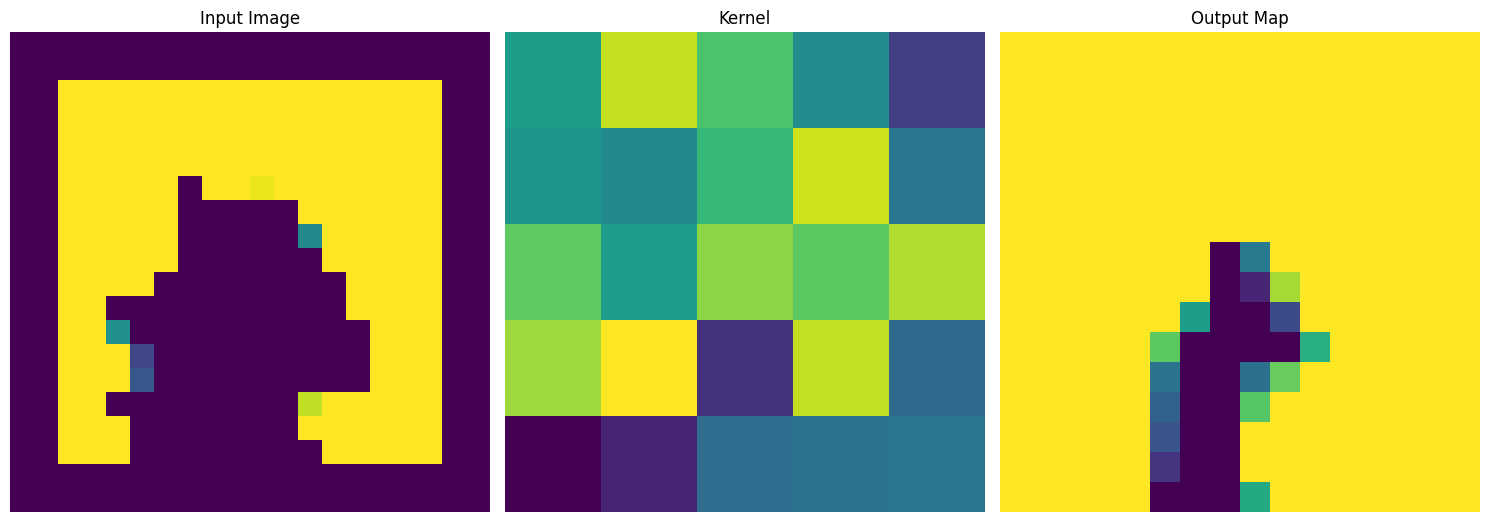

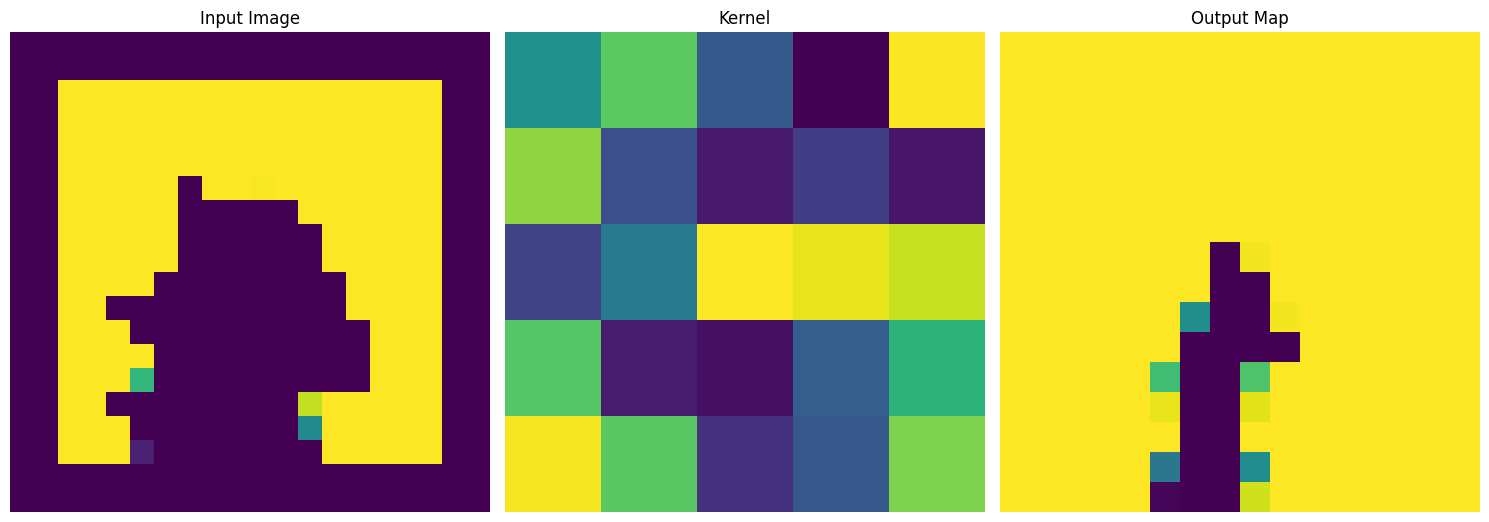

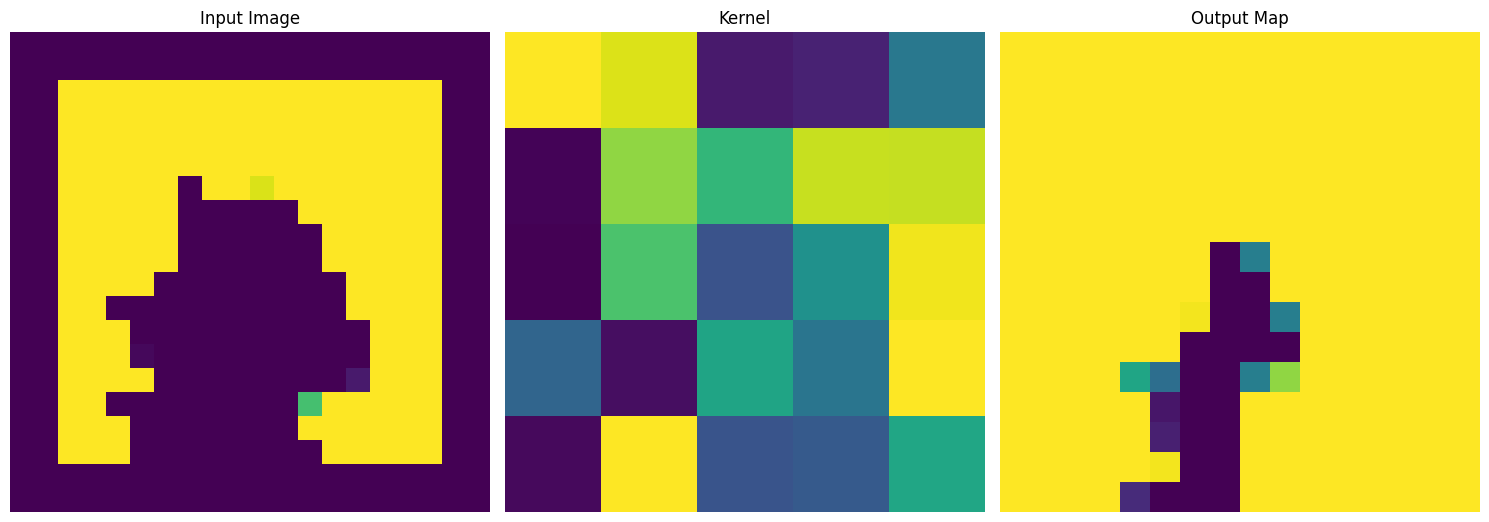

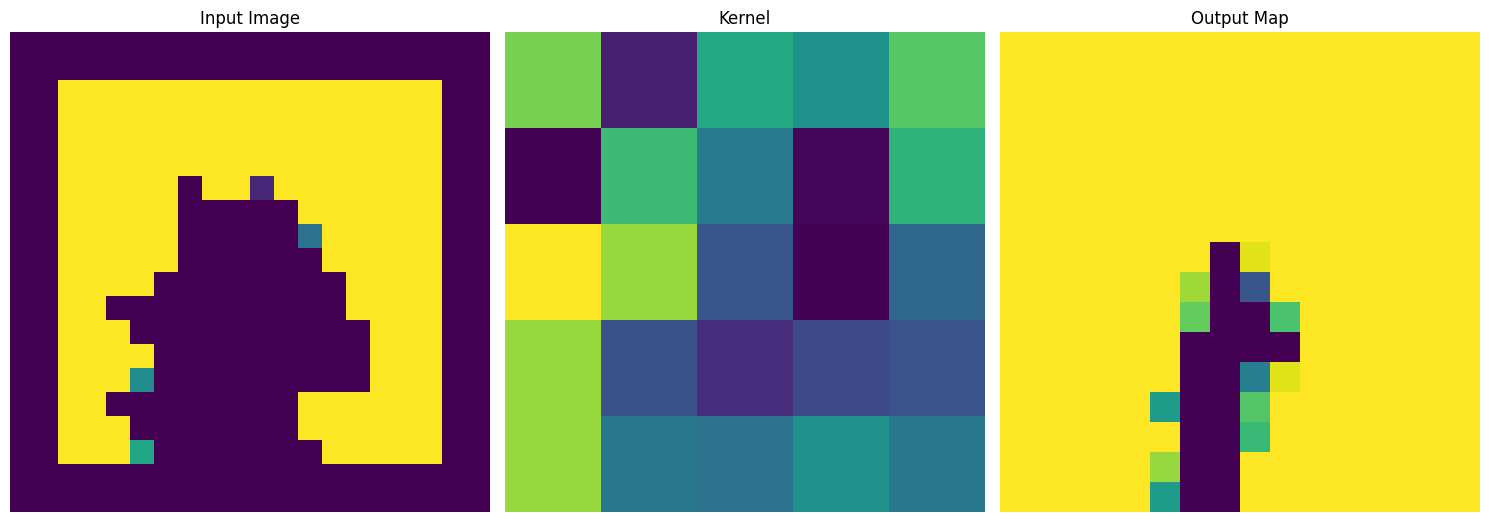

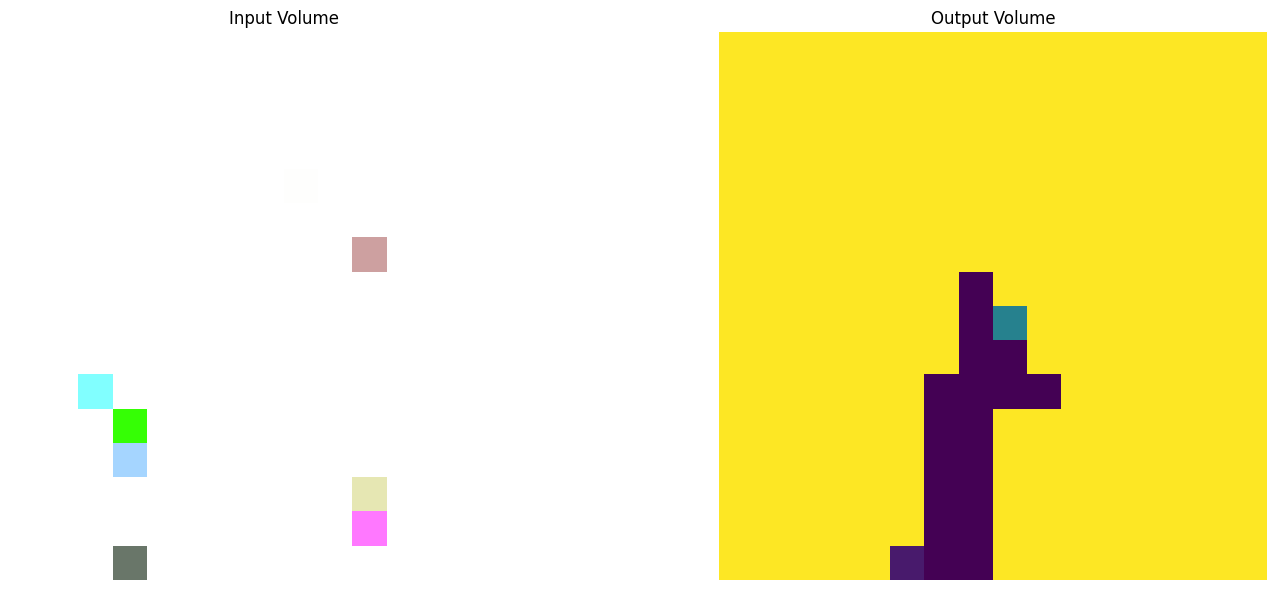

(16, 16, 4)


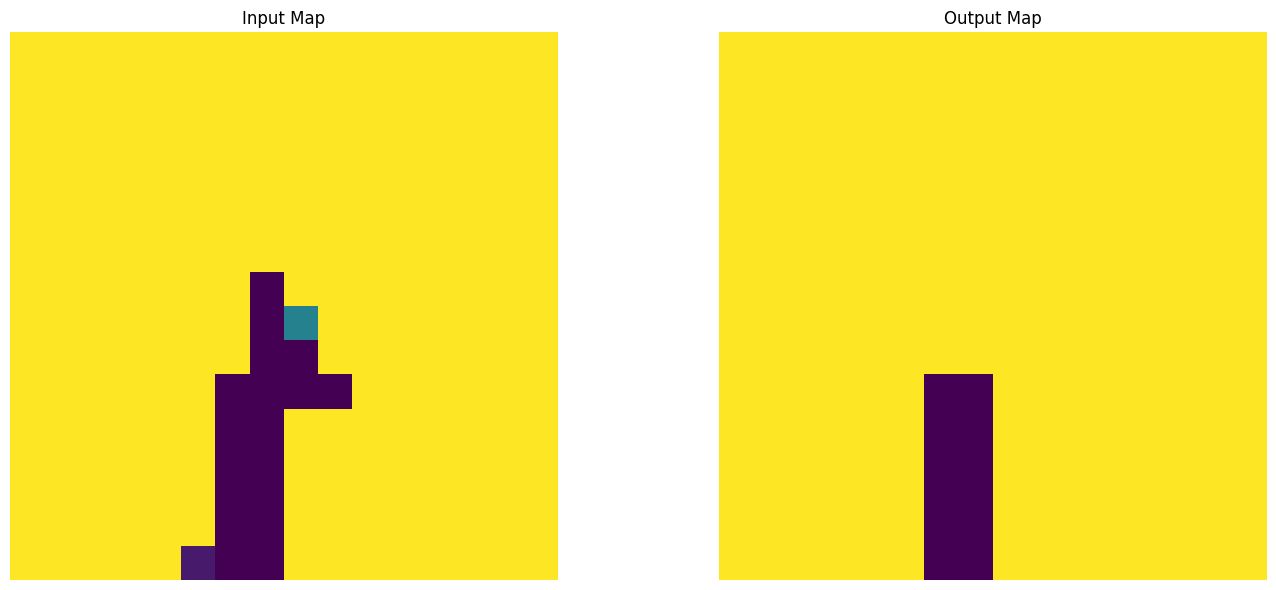

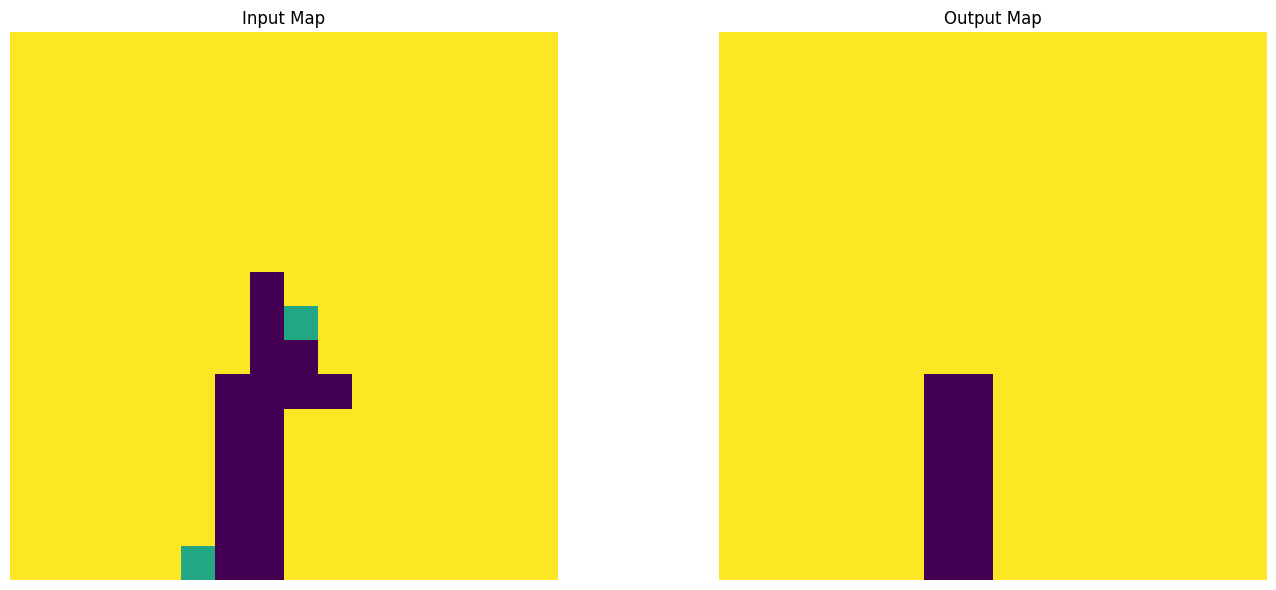

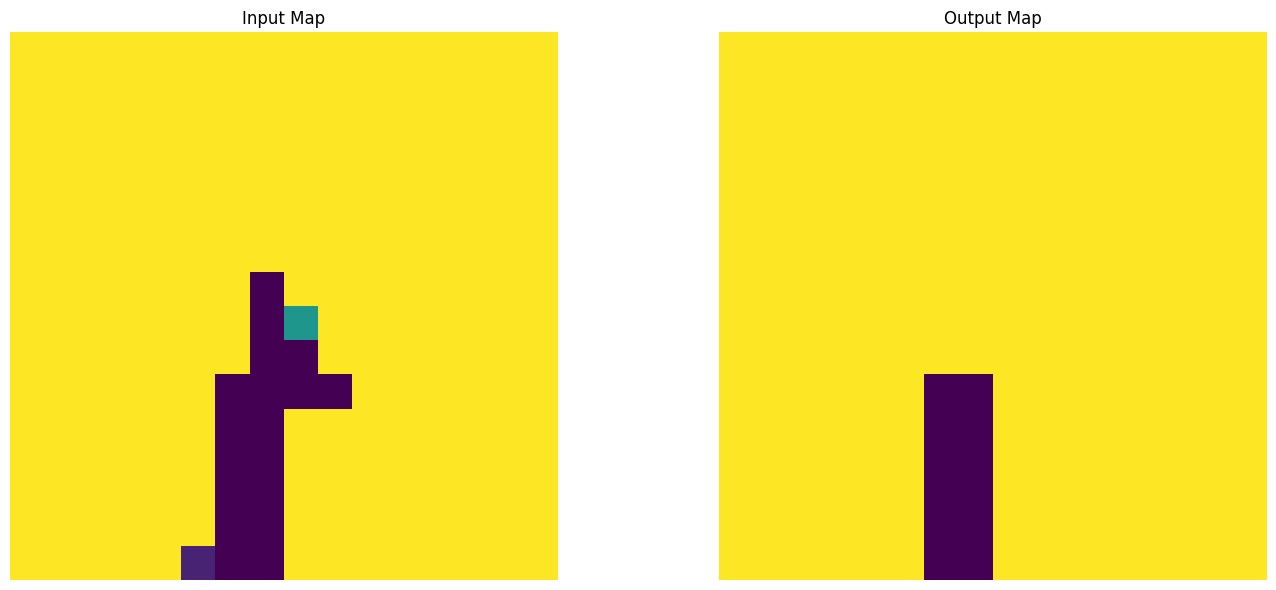

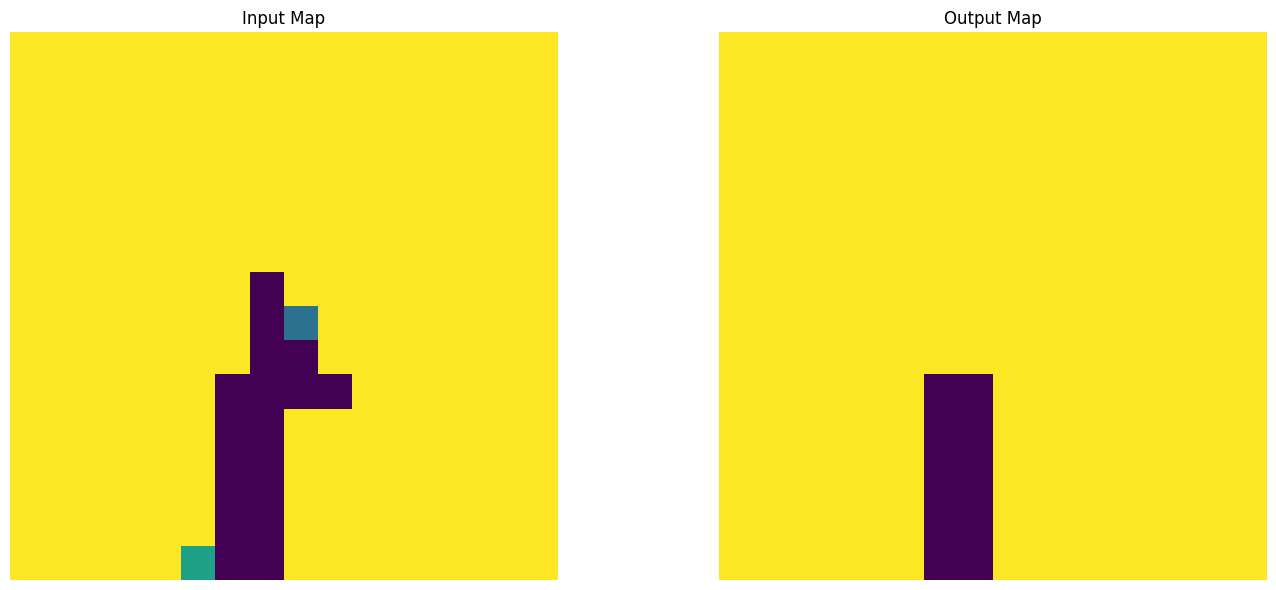

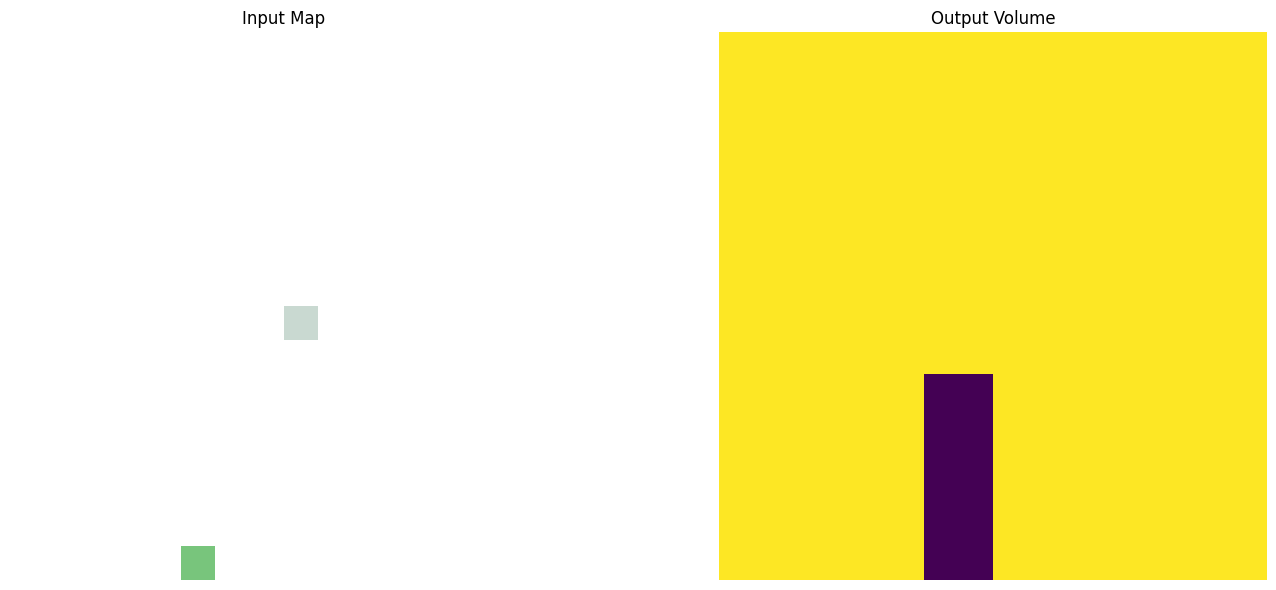

(8, 8, 4)


In [35]:
import numpy as np
import matplotlib.pyplot as plt

outputs = []
flattened_outputs = []

for label, img in images.items():
    img = img.permute(1, 2, 0).numpy()
    flat = flattend(img, label)
    pred = label_pred(flat)
    outputs.append(pred)
    flattened_outputs.append(flat)


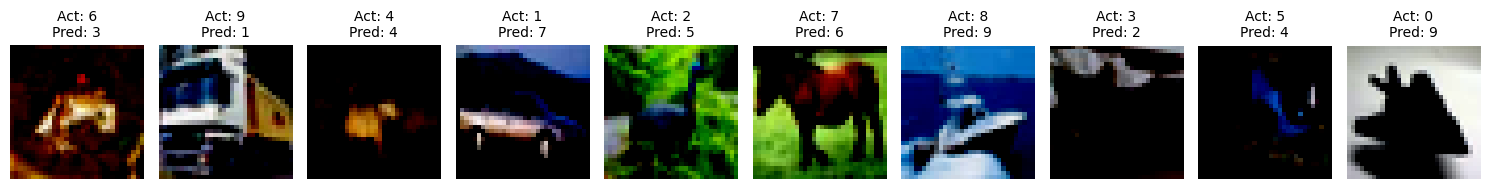

In [36]:
def plot_images_with_labels(images, predicted_outputs):
    plt.figure(figsize=(15, 5))

    for i, (label, img) in enumerate(images.items()):
        plt.subplot(2, 10, i + 1)
        img = img.permute(1, 2, 0).numpy()
        img = normalize_image(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f'Act: {label}\nPred: {np.argmax(predicted_outputs[i])}', fontsize=10)

    plt.tight_layout()
    plt.show()
plot_images_with_labels(images, outputs)

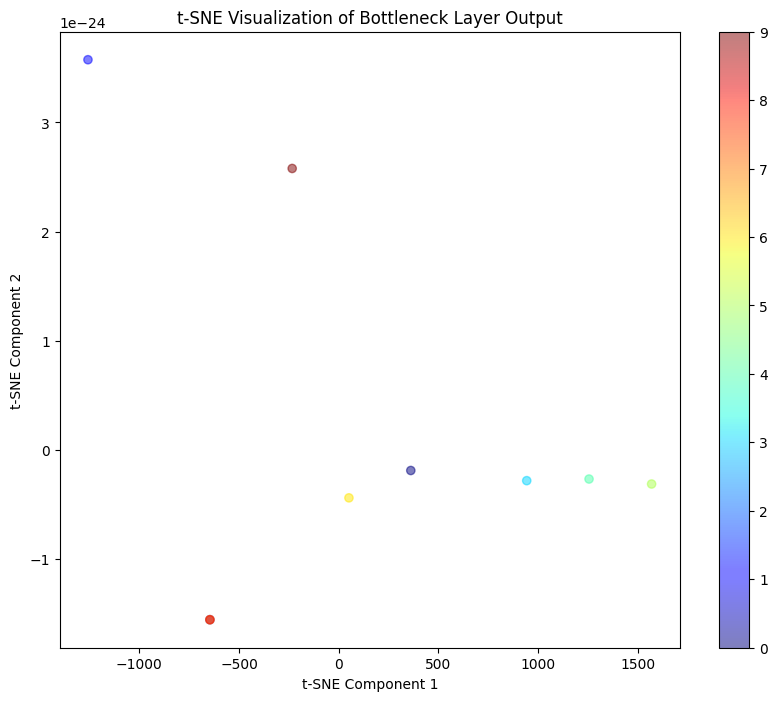

In [40]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

labels = []
for label, img in images.items():
    labels.append(label)

labels = np.array(labels)

perplexity_value = 5

tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
reduced_data = tsne.fit_transform(flattened_outputs)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='jet', alpha=0.5)
plt.colorbar(scatter, ticks=range(10))
plt.title('t-SNE Visualization of Bottleneck Layer Output')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.show()


# Question 2

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/15], Train Loss: 2.3042, Test Loss: 2.3021
Epoch [2/15], Train Loss: 2.3041, Test Loss: 2.3020
Epoch [3/15], Train Loss: 2.3040, Test Loss: 2.3019
Epoch [4/15], Train Loss: 2.3039, Test Loss: 2.3019
Epoch [5/15], Train Loss: 2.3038, Test Loss: 2.3018
Epoch [6/15], Train Loss: 2.3037, Test Loss: 2.3017
Epoch [7/15], Train Loss: 2.3036, Test Loss: 2.3017
Epoch [8/15], Train Loss: 2.3035, Test Loss: 2.3016
Epoch [9/15], Train Loss: 2.3035, Test Loss: 2.3015
Epoch [10/15], Train Loss: 2.3034, Test Loss: 2.3015
Epoch [11/15], Train Loss: 2.3033, Test Loss: 2.3014
Epoch [12/15], Train Loss: 2.3032, Test Loss: 2.3014
Epoch [13/15], Train Loss: 2.3031, Test Loss: 2.3013
Epoch [14/15], Train Loss: 2.3030, Test Loss: 2.3012
Epoch [15/15], Train Loss: 2.3030, Test Loss: 2.3012
Vanilla SGD Accuracy: 11.00%


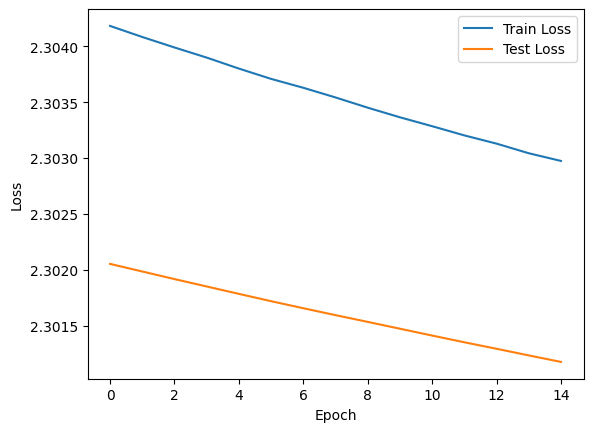

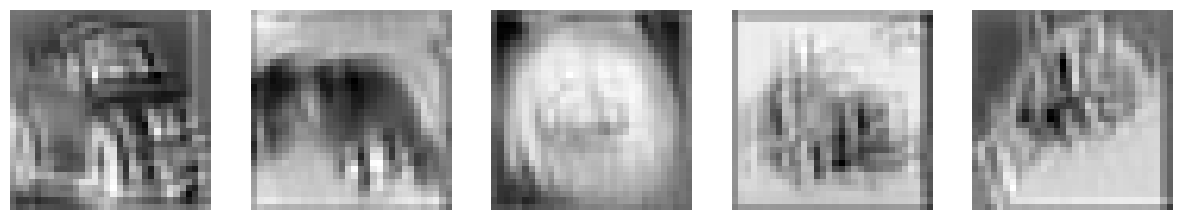

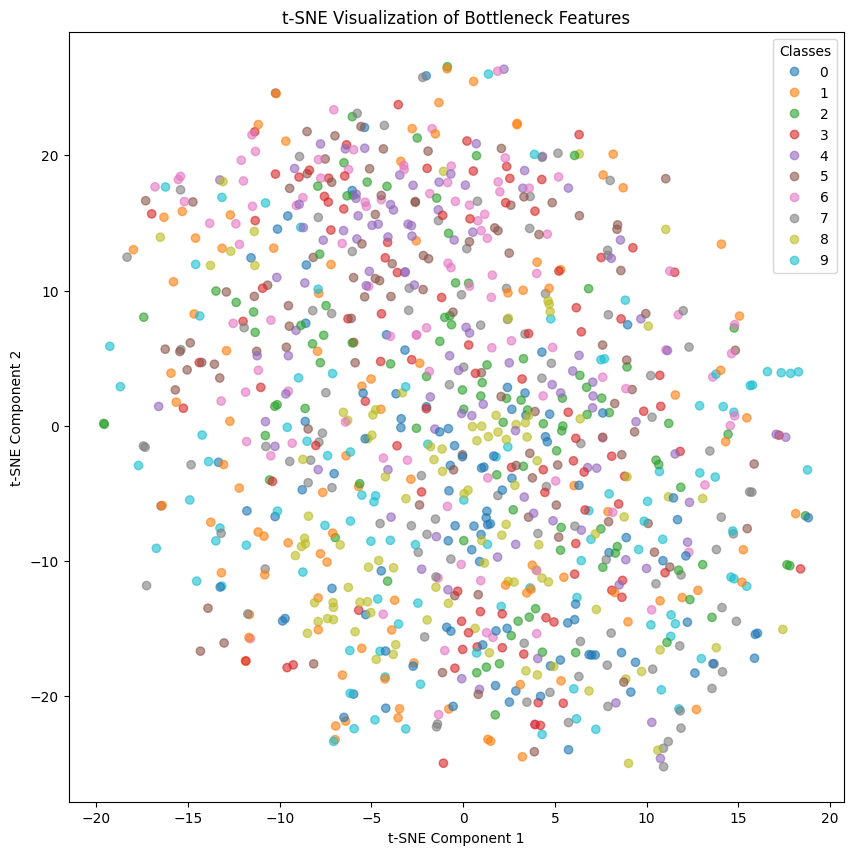

Epoch [1/15], Train Loss: 2.3088, Test Loss: 2.3076
Epoch [2/15], Train Loss: 2.3073, Test Loss: 2.3062
Epoch [3/15], Train Loss: 2.3059, Test Loss: 2.3049
Epoch [4/15], Train Loss: 2.3047, Test Loss: 2.3035
Epoch [5/15], Train Loss: 2.3034, Test Loss: 2.3024
Epoch [6/15], Train Loss: 2.3021, Test Loss: 2.3011
Epoch [7/15], Train Loss: 2.3007, Test Loss: 2.2998
Epoch [8/15], Train Loss: 2.2993, Test Loss: 2.2984
Epoch [9/15], Train Loss: 2.2974, Test Loss: 2.2964
Epoch [10/15], Train Loss: 2.2952, Test Loss: 2.2936
Epoch [11/15], Train Loss: 2.2922, Test Loss: 2.2904
Epoch [12/15], Train Loss: 2.2881, Test Loss: 2.2854
Epoch [13/15], Train Loss: 2.2823, Test Loss: 2.2782
Epoch [14/15], Train Loss: 2.2733, Test Loss: 2.2664
Epoch [15/15], Train Loss: 2.2587, Test Loss: 2.2486
Momentum Accuracy: 19.00%


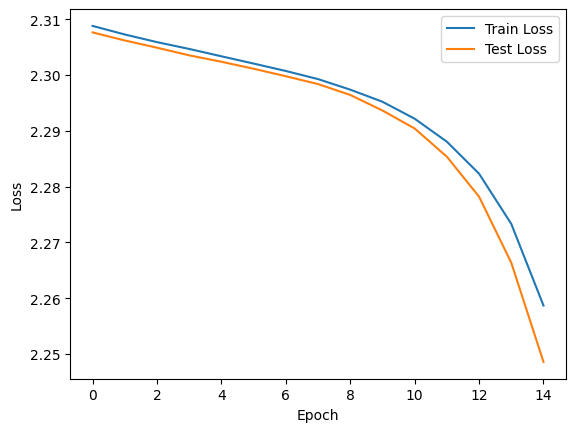

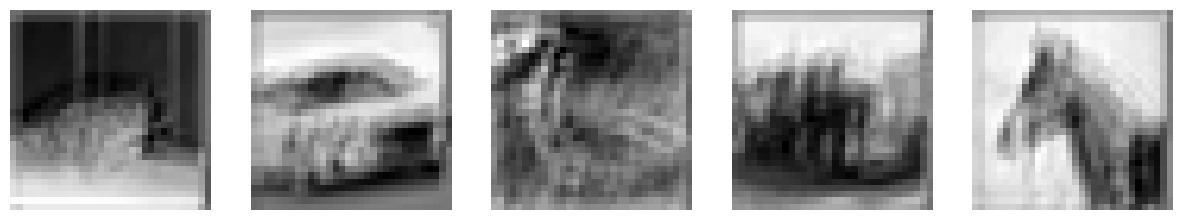

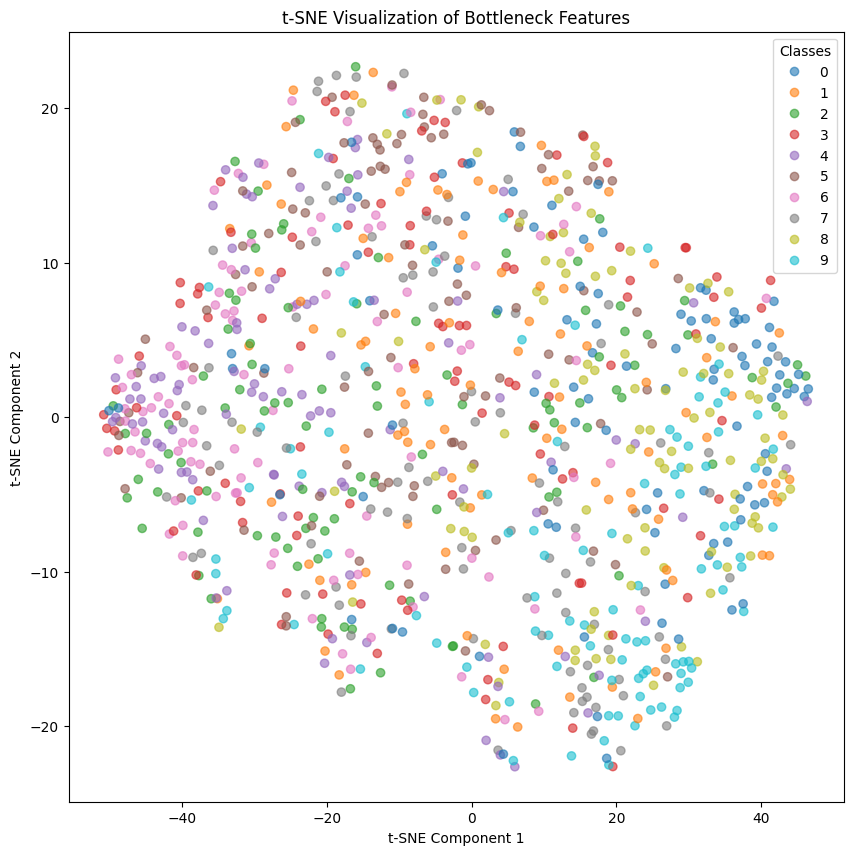

Epoch [1/15], Train Loss: 2.2061, Test Loss: 2.0689
Epoch [2/15], Train Loss: 2.0370, Test Loss: 2.0116
Epoch [3/15], Train Loss: 1.9528, Test Loss: 1.9972
Epoch [4/15], Train Loss: 1.8918, Test Loss: 1.9998
Epoch [5/15], Train Loss: 1.8527, Test Loss: 1.9343
Epoch [6/15], Train Loss: 1.8020, Test Loss: 1.8959
Epoch [7/15], Train Loss: 1.7557, Test Loss: 1.9373
Epoch [8/15], Train Loss: 1.7030, Test Loss: 1.8393
Epoch [9/15], Train Loss: 1.6661, Test Loss: 1.8968
Epoch [10/15], Train Loss: 1.6323, Test Loss: 1.8375
Epoch [11/15], Train Loss: 1.5798, Test Loss: 1.8412
Epoch [12/15], Train Loss: 1.5300, Test Loss: 1.8526
Epoch [13/15], Train Loss: 1.4891, Test Loss: 1.8804
Epoch [14/15], Train Loss: 1.4541, Test Loss: 1.8424
Epoch [15/15], Train Loss: 1.4119, Test Loss: 1.9295
RMSProp Accuracy: 34.00%


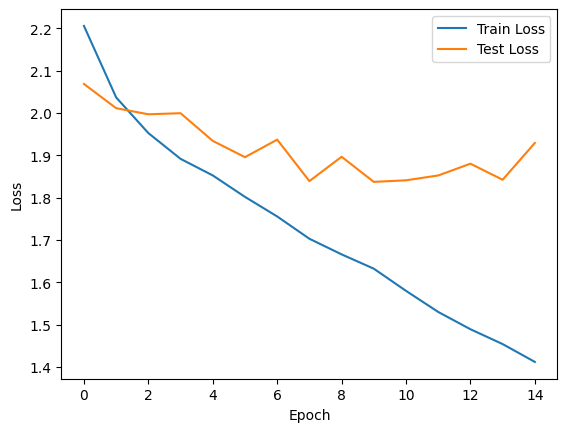

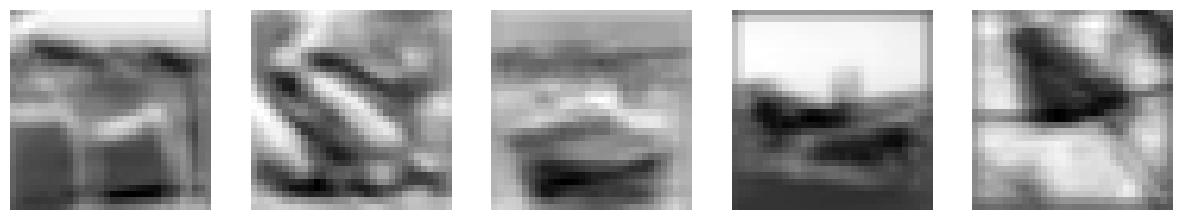

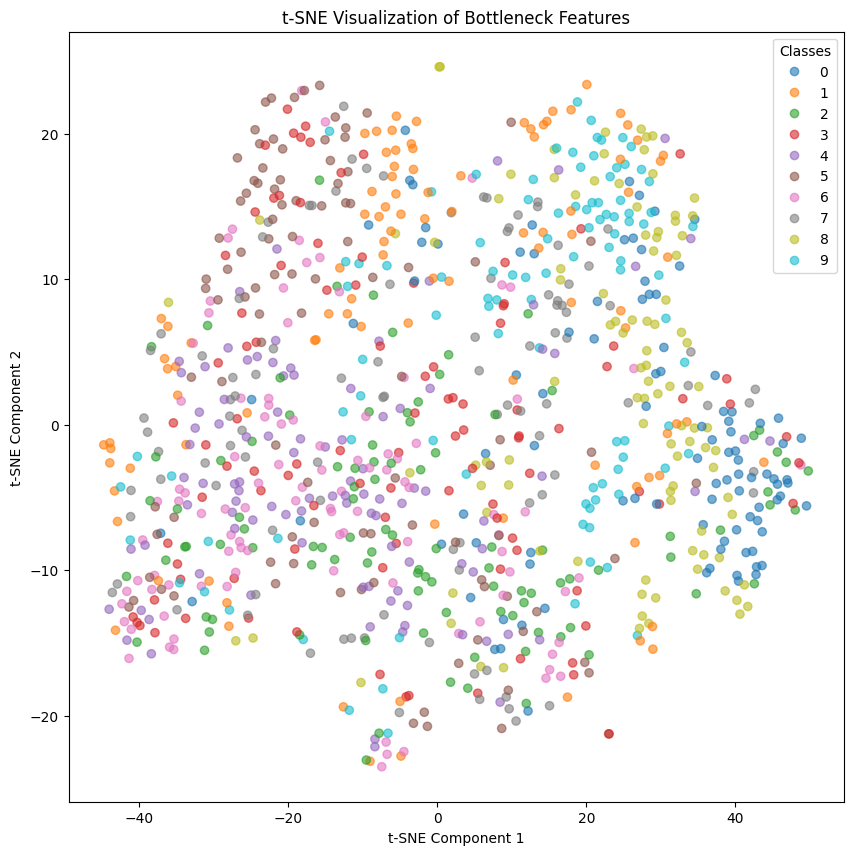

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

learning_rate = 0.001
batch_size = 25
num_epochs = 15
num_classes = 10
momentum = 0.9
rho = 0.9

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

def get_class_subset(dataset, images_per_class):
    targets = np.array(dataset.targets)
    subset_indices = []
    for class_id in range(num_classes):
        class_indices = np.where(targets == class_id)[0]
        subset_indices.extend(class_indices[:images_per_class])
    return Subset(dataset, subset_indices)

train_dataset = get_class_subset(dataset, 100)
test_dataset = get_class_subset(test_dataset, 10)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

class CNN(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 8 * 8, 49)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(49, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_bottleneck_features(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

def train_model(model, optimizer, num_epochs):
    criterion = nn.CrossEntropyLoss()
    train_losses, test_losses = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item()

        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}')

    return train_losses, test_losses

def evaluate_model(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

def plot_losses(train_losses, test_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def visualize_activation_maps(model, data_loader):
    model.eval()
    images, _ = next(iter(data_loader))
    images = images[:5]
    with torch.no_grad():
        x = model.conv1(images)
    fig, ax = plt.subplots(1, 5, figsize=(15, 15))
    for i in range(5):
        ax[i].imshow(x[i, 0].cpu(), cmap='gray')
        ax[i].axis('off')
    plt.show()

def visualize_tsne(model, data_loader):
    model.eval()
    features, labels = [], []

    with torch.no_grad():
        for images, lbl in data_loader:
            output = model.get_bottleneck_features(images)
            features.append(output.cpu().numpy())
            labels.append(lbl.cpu().numpy())

    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)

    tsne = TSNE(n_components=2, random_state=0)
    features_2d = tsne.fit_transform(features)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='tab10', alpha=0.6)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title('t-SNE Visualization of Bottleneck Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Vanilla SGD
model = CNN(dropout_rate=0.0)
optimizer_sgd = optim.SGD(model.parameters(), lr=learning_rate)
train_losses_sgd, test_losses_sgd = train_model(model, optimizer_sgd, num_epochs)
accuracy_sgd = evaluate_model(model)
print(f'Vanilla SGD Accuracy: {accuracy_sgd:.2f}%')
plot_losses(train_losses_sgd, test_losses_sgd)
visualize_activation_maps(model, train_loader)
visualize_tsne(model, train_loader)

# Momentum
model = CNN(dropout_rate=0.0)
optimizer_momentum = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
train_losses_momentum, test_losses_momentum = train_model(model, optimizer_momentum, num_epochs)
accuracy_momentum = evaluate_model(model)
print(f'Momentum Accuracy: {accuracy_momentum:.2f}%')
plot_losses(train_losses_momentum, test_losses_momentum)
visualize_activation_maps(model, train_loader)
visualize_tsne(model, train_loader)

# RMSProp
model = CNN(dropout_rate=0.0)
optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=rho)
train_losses_rmsprop, test_losses_rmsprop = train_model(model, optimizer_rmsprop, num_epochs)
accuracy_rmsprop = evaluate_model(model)
print(f'RMSProp Accuracy: {accuracy_rmsprop:.2f}%')
plot_losses(train_losses_rmsprop, test_losses_rmsprop)
visualize_activation_maps(model, train_loader)
visualize_tsne(model, train_loader)



Training with dropout rate 0.0:
Epoch [1/15], Train Loss: 2.2139, Test Loss: 2.1014
Epoch [2/15], Train Loss: 2.0394, Test Loss: 2.0237
Epoch [3/15], Train Loss: 1.9624, Test Loss: 1.9901
Epoch [4/15], Train Loss: 1.8873, Test Loss: 1.9741
Epoch [5/15], Train Loss: 1.8419, Test Loss: 1.9308
Epoch [6/15], Train Loss: 1.8034, Test Loss: 1.9029
Epoch [7/15], Train Loss: 1.7430, Test Loss: 1.8925
Epoch [8/15], Train Loss: 1.7066, Test Loss: 1.8620
Epoch [9/15], Train Loss: 1.6692, Test Loss: 1.9062
Epoch [10/15], Train Loss: 1.6250, Test Loss: 1.8447
Epoch [11/15], Train Loss: 1.5773, Test Loss: 1.8377
Epoch [12/15], Train Loss: 1.5325, Test Loss: 1.8426
Epoch [13/15], Train Loss: 1.5011, Test Loss: 1.8290
Epoch [14/15], Train Loss: 1.4634, Test Loss: 1.8474
Epoch [15/15], Train Loss: 1.4286, Test Loss: 1.8136

Training with dropout rate 0.2:
Epoch [1/15], Train Loss: 2.1918, Test Loss: 2.1156
Epoch [2/15], Train Loss: 2.0684, Test Loss: 2.0447
Epoch [3/15], Train Loss: 2.0046, Test Loss:

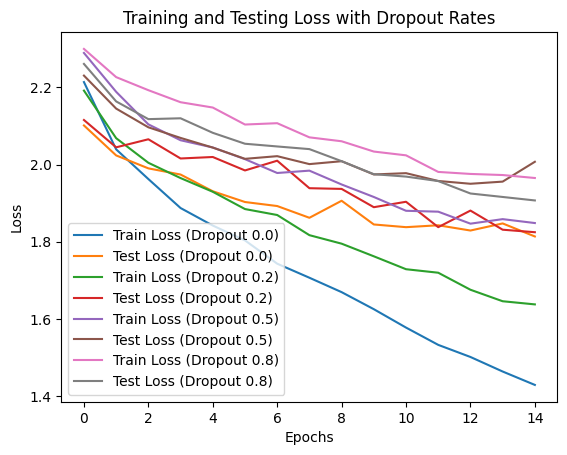

Dropout Rate 0.0: Test Accuracy = 36.00%
Dropout Rate 0.2: Test Accuracy = 33.00%
Dropout Rate 0.5: Test Accuracy = 27.00%
Dropout Rate 0.8: Test Accuracy = 36.00%


In [9]:
dropout_rates = [0.0, 0.2, 0.5, 0.8]
results = {}

for rate in dropout_rates:
    print(f"\nTraining with dropout rate {rate}:")
    model = CNN(dropout_rate=rate)
    optimizer_rmsprop = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=rho)
    train_losses, test_losses = train_model(model, optimizer_rmsprop, num_epochs)
    accuracy = evaluate_model(model)
    results[rate] = {'train_losses': train_losses, 'test_losses': test_losses, 'accuracy': accuracy}

for rate, metrics in results.items():
    plt.plot(metrics['train_losses'], label=f'Train Loss (Dropout {rate})')
    plt.plot(metrics['test_losses'], label=f'Test Loss (Dropout {rate})')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss with Dropout Rates')
plt.legend()
plt.show()

# Print accuracies
for rate, metrics in results.items():
    print(f"Dropout Rate {rate}: Test Accuracy = {metrics['accuracy']:.2f}%")


In [57]:
class CNN(nn.Module):
    def __init__(self, dropout_rate=0.0):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(4)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=4, out_channels=4, kernel_size=5, stride=1, padding=2)
        self.bn2 = nn.BatchNorm2d(4)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(4 * 8 * 8, 49)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(49, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

    def get_bottleneck_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        x = self.flatten(x)
        x = self.fc1(x)
        return x


Epoch [1/15], Train Loss: 2.3241, Test Loss: 2.3140
Epoch [2/15], Train Loss: 2.3049, Test Loss: 2.3129
Epoch [3/15], Train Loss: 2.2974, Test Loss: 2.3044
Epoch [4/15], Train Loss: 2.2892, Test Loss: 2.2979
Epoch [5/15], Train Loss: 2.2746, Test Loss: 2.2926
Epoch [6/15], Train Loss: 2.2688, Test Loss: 2.2875
Epoch [7/15], Train Loss: 2.2719, Test Loss: 2.2826
Epoch [8/15], Train Loss: 2.2624, Test Loss: 2.2779
Epoch [9/15], Train Loss: 2.2592, Test Loss: 2.2740
Epoch [10/15], Train Loss: 2.2448, Test Loss: 2.2693
Epoch [11/15], Train Loss: 2.2384, Test Loss: 2.2656
Epoch [12/15], Train Loss: 2.2330, Test Loss: 2.2608
Epoch [13/15], Train Loss: 2.2355, Test Loss: 2.2568
Epoch [14/15], Train Loss: 2.2247, Test Loss: 2.2513
Epoch [15/15], Train Loss: 2.2203, Test Loss: 2.2468
Vanilla SGD with BN and Dropout Accuracy: 17.00%


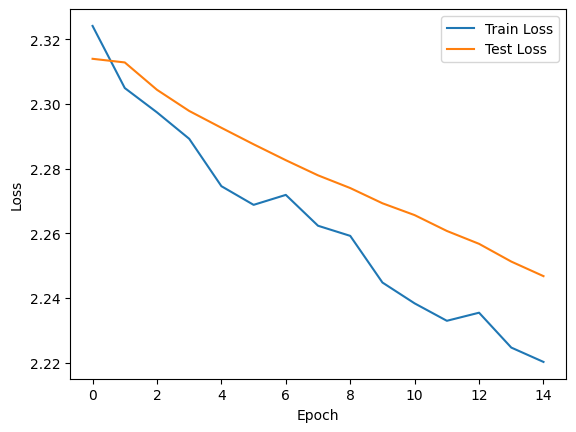

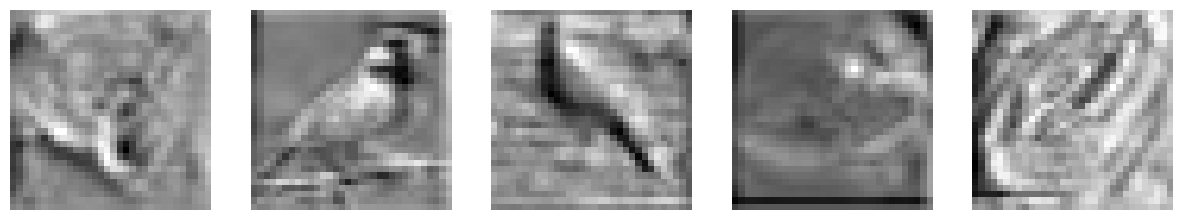

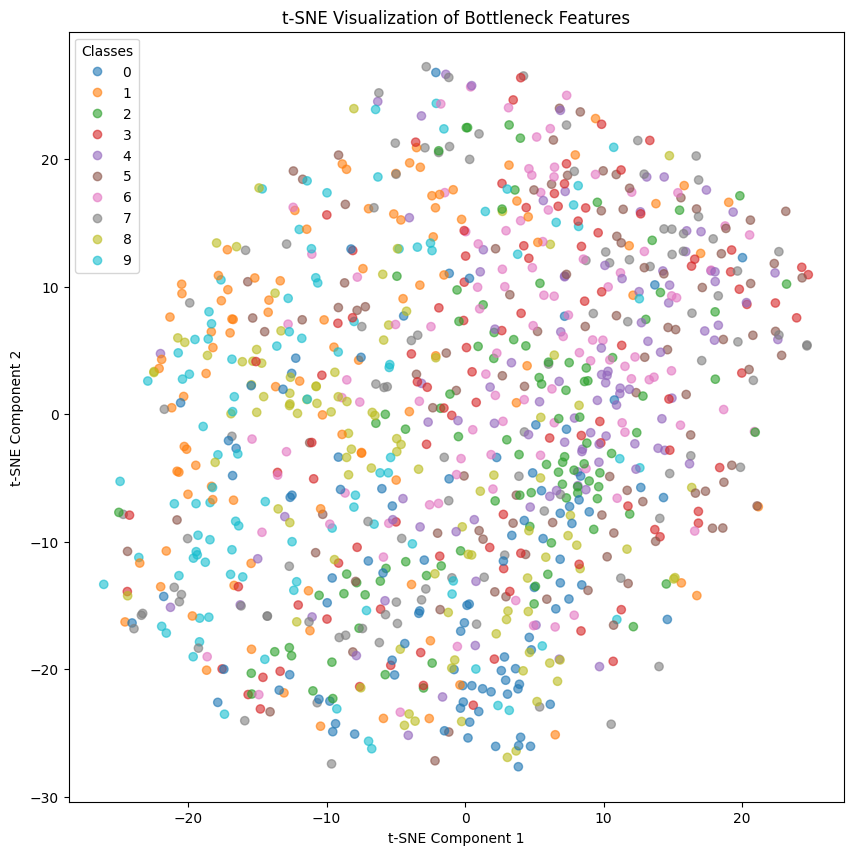

Epoch [1/15], Train Loss: 2.2927, Test Loss: 2.2547
Epoch [2/15], Train Loss: 2.2219, Test Loss: 2.2123
Epoch [3/15], Train Loss: 2.1746, Test Loss: 2.1851
Epoch [4/15], Train Loss: 2.1317, Test Loss: 2.1447
Epoch [5/15], Train Loss: 2.0929, Test Loss: 2.0973
Epoch [6/15], Train Loss: 2.0442, Test Loss: 2.0376
Epoch [7/15], Train Loss: 1.9882, Test Loss: 1.9746
Epoch [8/15], Train Loss: 1.9498, Test Loss: 1.9427
Epoch [9/15], Train Loss: 1.8885, Test Loss: 1.8742
Epoch [10/15], Train Loss: 1.8497, Test Loss: 1.9068
Epoch [11/15], Train Loss: 1.8272, Test Loss: 1.8393
Epoch [12/15], Train Loss: 1.7641, Test Loss: 1.8053
Epoch [13/15], Train Loss: 1.7775, Test Loss: 1.8864
Epoch [14/15], Train Loss: 1.7670, Test Loss: 1.8450
Epoch [15/15], Train Loss: 1.7219, Test Loss: 1.7718
Momentum with BN and Dropout Accuracy: 44.00%


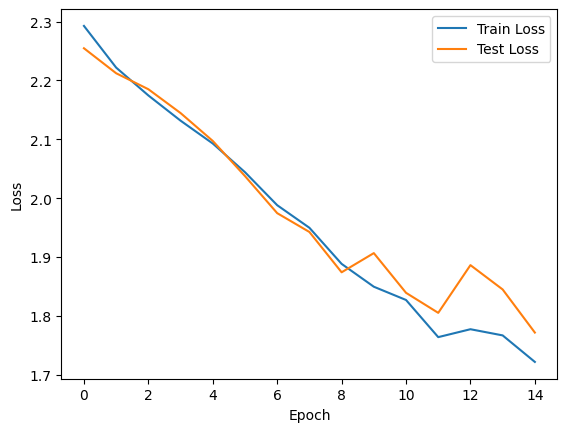

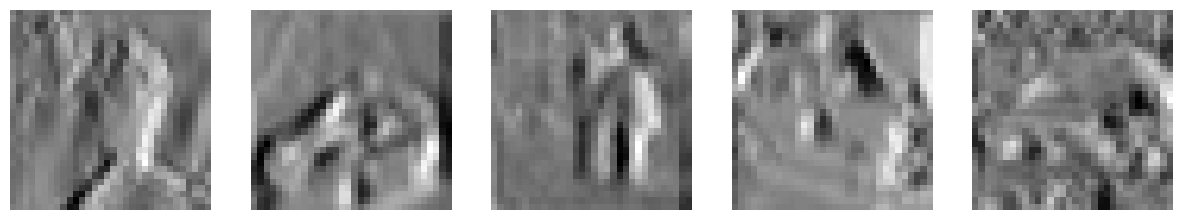

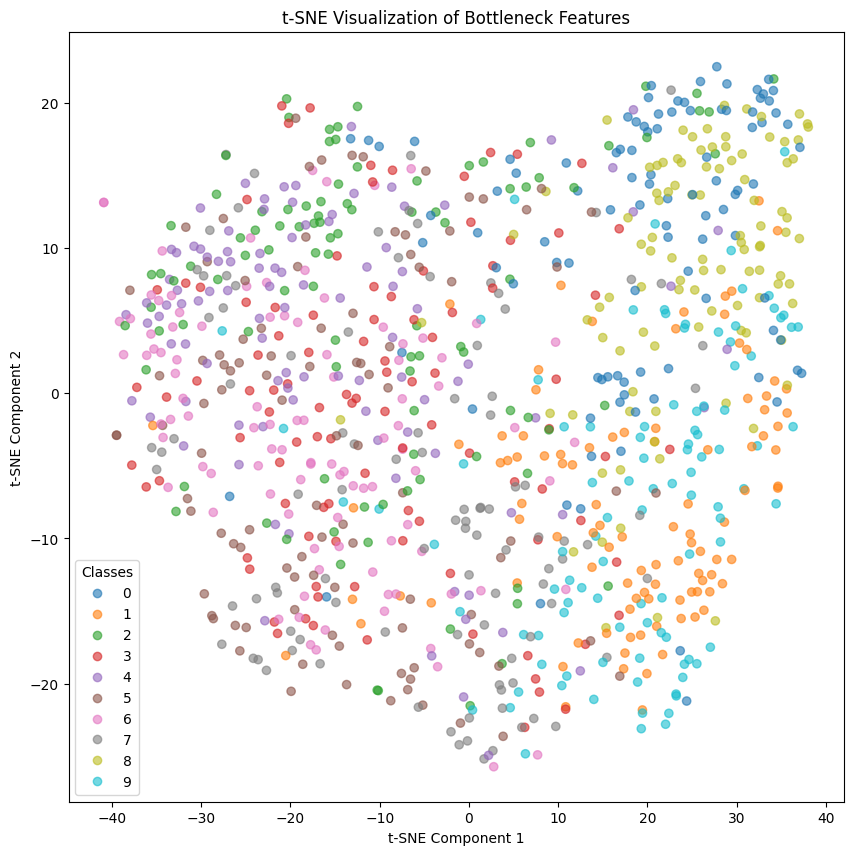

Epoch [1/15], Train Loss: 2.2070, Test Loss: 2.0865
Epoch [2/15], Train Loss: 1.9991, Test Loss: 1.9248
Epoch [3/15], Train Loss: 1.8843, Test Loss: 1.8115
Epoch [4/15], Train Loss: 1.7809, Test Loss: 1.7736
Epoch [5/15], Train Loss: 1.7155, Test Loss: 1.6968
Epoch [6/15], Train Loss: 1.6611, Test Loss: 1.6686
Epoch [7/15], Train Loss: 1.5926, Test Loss: 1.6900
Epoch [8/15], Train Loss: 1.5507, Test Loss: 1.6341
Epoch [9/15], Train Loss: 1.4753, Test Loss: 1.7092
Epoch [10/15], Train Loss: 1.4305, Test Loss: 1.6632
Epoch [11/15], Train Loss: 1.3925, Test Loss: 1.6238
Epoch [12/15], Train Loss: 1.3446, Test Loss: 1.6461
Epoch [13/15], Train Loss: 1.3450, Test Loss: 1.6536
Epoch [14/15], Train Loss: 1.2819, Test Loss: 1.5727
Epoch [15/15], Train Loss: 1.2294, Test Loss: 1.6564
RMSProp with BN and Dropout Accuracy: 39.00%


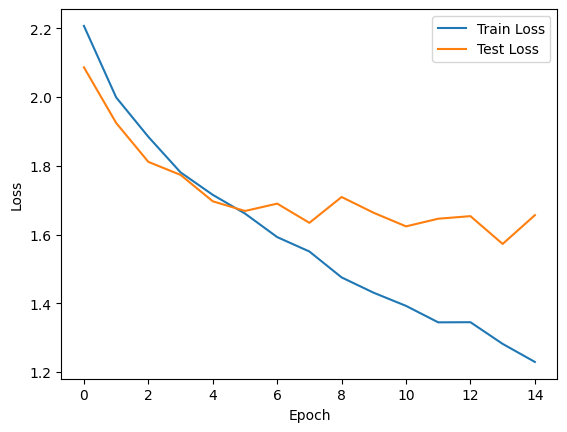

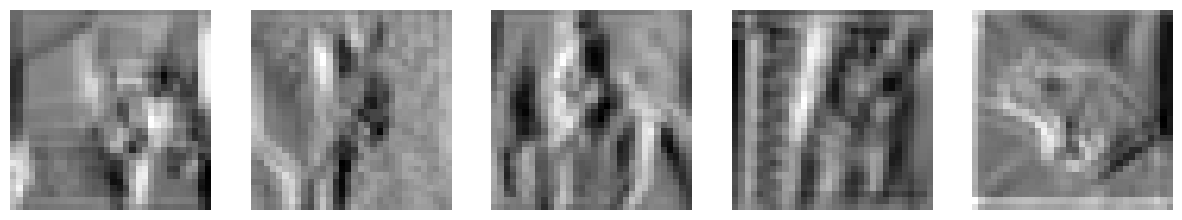

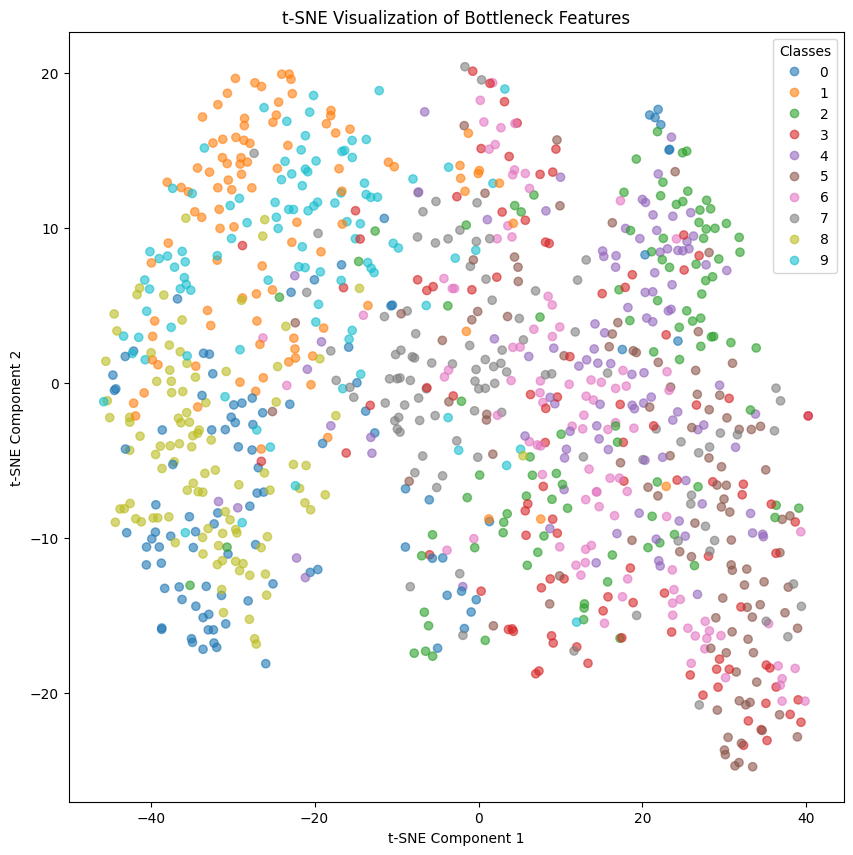

In [58]:

dropout_rate = 0.2
model_bn_dropout = CNN(dropout_rate=dropout_rate)  #

# Vanilla SGD
optimizer_sgd_bn_dropout = optim.SGD(model_bn_dropout.parameters(), lr=learning_rate)
train_losses_sgd_bn_dropout, test_losses_sgd_bn_dropout = train_model(model_bn_dropout, optimizer_sgd_bn_dropout, num_epochs)
accuracy_sgd_bn_dropout = evaluate_model(model_bn_dropout)
print(f'Vanilla SGD with BN and Dropout Accuracy: {accuracy_sgd_bn_dropout:.2f}%')
plot_losses(train_losses_sgd_bn_dropout, test_losses_sgd_bn_dropout)
visualize_activation_maps(model_bn_dropout, train_loader)
visualize_tsne(model_bn_dropout, train_loader)

# Momentum
model_bn_dropout = CNN(dropout_rate=dropout_rate)
optimizer_momentum_bn_dropout = optim.SGD(model_bn_dropout.parameters(), lr=learning_rate, momentum=momentum)
train_losses_momentum_bn_dropout, test_losses_momentum_bn_dropout = train_model(model_bn_dropout, optimizer_momentum_bn_dropout, num_epochs)
accuracy_momentum_bn_dropout = evaluate_model(model_bn_dropout)
print(f'Momentum with BN and Dropout Accuracy: {accuracy_momentum_bn_dropout:.2f}%')
plot_losses(train_losses_momentum_bn_dropout, test_losses_momentum_bn_dropout)
visualize_activation_maps(model_bn_dropout, train_loader)
visualize_tsne(model_bn_dropout, train_loader)

# RMSProp
model_bn_dropout = CNN(dropout_rate=dropout_rate)
optimizer_rmsprop_bn_dropout = optim.RMSprop(model_bn_dropout.parameters(), lr=learning_rate, alpha=rho)
train_losses_rmsprop_bn_dropout, test_losses_rmsprop_bn_dropout = train_model(model_bn_dropout, optimizer_rmsprop_bn_dropout, num_epochs)
accuracy_rmsprop_bn_dropout = evaluate_model(model_bn_dropout)
print(f'RMSProp with BN and Dropout Accuracy: {accuracy_rmsprop_bn_dropout:.2f}%')
plot_losses(train_losses_rmsprop_bn_dropout, test_losses_rmsprop_bn_dropout)
visualize_activation_maps(model_bn_dropout, train_loader)
visualize_tsne(model_bn_dropout, train_loader)


In [59]:
import pandas as pd
dic = {"Accuracy":[accuracy_sgd,accuracy_momentum,accuracy_rmsprop],
       "Accuracy With dropout and BN":[accuracy_sgd_bn_dropout,accuracy_momentum_bn_dropout,accuracy_rmsprop_bn_dropout]}
df = pd.DataFrame(dic)

In [60]:
df

Accuracy  Accuracy With dropout and BN
0      11.0                          17.0
1      19.0                          44.0
2      34.0                          39.0

From above table we can say that there is significant improvement in the accuracy of model for various optimizers using dropout and Batch Normalization techniques.